RNN LSTM for text classification
=============
<span style="color: lightsteelblue;">Deep Learning</span>

The goal of this notebook is to train recurrent neural network with LSTM cell for the purpose of text classification.

## 1. Data preparation

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
import collections
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# custom libraries
from nlp.preparer import Corpus
from nlp.iterator import BatchIterator

# View
from IPython.display import Markdown, display

### Loading corpora

In [2]:
corpora_paths = ['./articles/good.articles', './articles/bad.articles'] 
corpora = []
lengths = []

for path in corpora_paths:
  corpus = Corpus(path)
  corpora.append(corpus)
  length = [len(article) for article in corpus.articles]
  lengths.append(length)

  print(f"Corpus label: {corpus.label}, ",
        f"length: {len(corpus.articles)} articles, ",
        f"av length: {round(corpus.average_length())} words, ",
        f"max length: {max(length)} words.")
  print(f"Corpus raw article: {corpus.raw[0][:200]}")
  print(f"Corpus data (words): {corpus.articles[0][:20]}\n")

Corpus label: good,  length: 6666 articles,  av length: 321 words,  max length: 4977 words.
Corpus raw article: 3 февраля в большинстве европейских стран закрылось зимнее трансферное окно — период, когда клубы могут заявлять новых футболистов, купленных у других команд. Ценники меняются чуть ли не ежемесячно. Н
Corpus data (words): ['num', 'феврал', 'в', 'большинств', 'европейск', 'стран', 'закр', 'зимн', 'трансферн', 'окн', 'период', ',', 'когд', 'клуб', 'могут', 'заявля', 'нов', 'футболист', ',', 'куплен']

Corpus label: bad,  length: 7519 articles,  av length: 84 words,  max length: 594 words.
Corpus raw article: Неизвестный угрожает взорвать аэропорт Кишинева, если ему не дадут миллион. Неизвестный сообщил о бомбе в аэропорту Международного аэропорта Кишинева и требует миллион рублей, сообщили в пограничной п
Corpus data (words): ['неизвестн', 'угрожа', 'взорва', 'аэропорт', 'кишинев', ',', 'есл', 'ем', 'не', 'дадут', 'миллион', '.', 'неизвестн', 'сообщ', 'о', 'бомб', 'в', 'аэропор

### Visualizing articles lengths

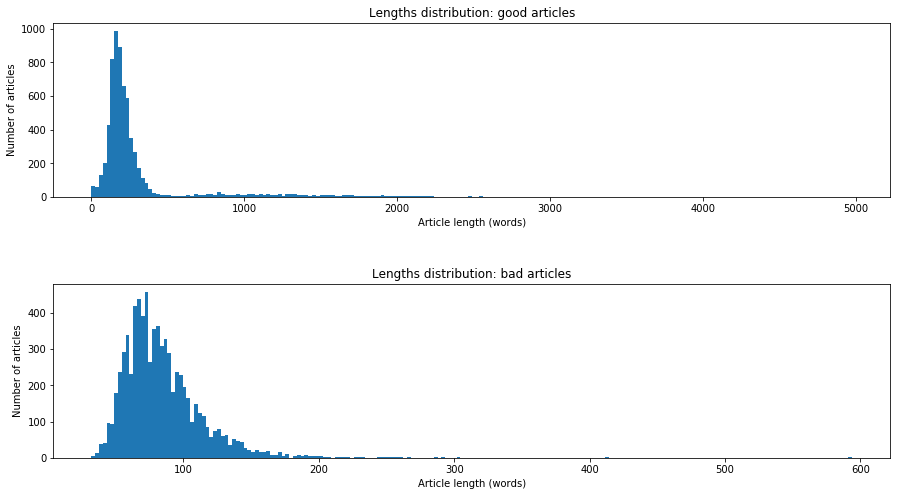

In [3]:
# visualization
plt.figure().set_size_inches(15, 8)

plt.subplot(211)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[0].label} articles')
plt.hist(lengths[0], 200)

plt.subplots_adjust(hspace=.5)

plt.subplot(212)
plt.xlabel('Article length (words)')
plt.ylabel('Number of articles')
plt.title(f'Lengths distribution: {corpora[1].label} articles')
plt.hist(lengths[1], 200)

plt.show()

### Building a dictionary

In [3]:
validation_size = 20 # articles per each class
vocabulary_size = 25000

def build_dictionary(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 

  return dictionary, reverse_dictionary, count

def build_dataset(words, dictionary, count):
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)

  count[0][1] = count[0][1] + unk_count

  return data

# flatten all words into a single bag
all_words = [word for corpus in corpora for words in corpus.articles for word in words]

dictionary, reverse_dictionary, count = build_dictionary(all_words)
good_data = [build_dataset(article, dictionary, count) for article in corpora[0].articles]
bad_data  = [build_dataset(article, dictionary, count) for article in corpora[1].articles]

# Splitting between train and validation datasets
good_train_data = good_data[:-validation_size]
good_validation_data = good_data[-validation_size:]
bad_train_data = bad_data[:-validation_size]
bad_validation_data = bad_data[-validation_size:]
validation_data = [item for ga, ba in zip(good_validation_data, bad_validation_data) for item in [ga, ba]]

print(f"Top popular words counts: {count[:15]}\n")
print(f"Example word: {dictionary['слон']} => {reverse_dictionary[dictionary['слон']]}\n")
print(f'Example data: {good_data[0][:20]}\n')
print(f'Validation sizes split train / validation: {len(good_train_data)} / {len(good_validation_data)}')
print(f'Validation dataset size: {len(validation_data)}')

Top popular words counts: [['UNK', 54385], (',', 191060), ('.', 167323), ('в', 121865), ('num', 70531), ('и', 59470), ('на', 47402), ('с', 26509), ('что', 22411), ('по', 21900), ('эт', 21548), ('не', 21271), ('из', 16381), ('год', 15883), ('он', 14053)]

Example word: 3144 => слон

Example data: [4, 385, 3, 606, 600, 50, 1918, 1257, 10524, 1302, 540, 1, 89, 359, 255, 2110, 49, 999, 1, 6767]

Validation sizes split train / validation: 6646 / 20
Validation dataset size: 40


Below is an **example** of two training batches spat out by `BatchIterator`:

In [4]:
batch_size = 20
good = [1, 0] # Representation of first class
bad  = [0, 1] # Representation of second class

batches = BatchIterator(batch_size, good_train_data, bad_train_data, good, bad)

for i in range(20):
  batch = batches.next()
  if i > 17: print(batch)

batches.rewind()

[[3315, 2421, 0, 2, 48, 2536, 3, 2944, 5207, 20, 4, 87, 473, 1, 113, 3, 1098, 14989, 20, 4], [[1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0], [1, 0]], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
[[87, 2, 347, 1857, 1702, 363, 10311, 1, 105, 254, 11, 6736, 87, 2, 347, 47, 23, 1379, 3, 363], [[1, 0], [1, 0], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]], [1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]


## 2. LSTM Model

In [5]:
num_nodes = 64 # Dimension of lstm cell
num_classes = 2 # Number of classes among which to predict
embedding_size = 128 # Dimension of a word vector
num_unrollings = 20 # Number of recurrent steps

graph = tf.Graph()
with graph.as_default():
  
  # Parameters:
  # Input gate: input, previous output, and bias.
  ix = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  im = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ib = tf.Variable(tf.zeros([1, num_nodes]))
  # Forget gate: input, previous output, and bias.
  fx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  fm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  fb = tf.Variable(tf.zeros([1, num_nodes]))
  # Output gate: input, previous output, and bias.
  ox = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  om = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  ob = tf.Variable(tf.zeros([1, num_nodes]))
  # Memory cell: input, state and bias.                             
  cx = tf.Variable(tf.truncated_normal([embedding_size, num_nodes], -0.1, 0.1))
  cm = tf.Variable(tf.truncated_normal([num_nodes, num_nodes], -0.1, 0.1))
  cb = tf.Variable(tf.zeros([1, num_nodes]))
  # Variables saving state across unrollings.
  saved_output = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  saved_state = tf.Variable(tf.zeros([1, num_nodes]), trainable=False)
  # Classifier weights and biases.
  w = tf.Variable(tf.truncated_normal([num_nodes, num_classes], -0.1, 0.1))
  b = tf.Variable(tf.zeros([num_classes]))
  # Embeddings
  embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))


  # Definition of the cell computation.
  def lstm_cell(i, o, state):
    # Create an LSTM cell
    input_gate =  tf.sigmoid(tf.matmul(i, ix) + tf.matmul(o, im) + ib)
    forget_gate = tf.sigmoid(tf.matmul(i, fx) + tf.matmul(o, fm) + fb)
    output_gate = tf.sigmoid(tf.matmul(i, ox) + tf.matmul(o, om) + ob)
    update = tf.matmul(i, cx) + tf.matmul(o, cm) + cb
    state = forget_gate * state + input_gate * tf.tanh(update)

    return output_gate * tf.tanh(state), state

  # Input data.
  train_inputs         = tf.placeholder(tf.int32, shape=[num_unrollings])
  train_state_cleaners = tf.placeholder(tf.float32, shape=[num_unrollings])
  train_labels         = tf.placeholder(tf.int32, shape=[num_unrollings, num_classes])

  # Unrolled LSTM loop.
  lstm_outputs = list()
  output = saved_output
  state  = saved_state
  lstm_inputs = tf.unstack(tf.nn.embedding_lookup(embeddings, train_inputs)) # ~ (num_unrollings, embedding_size)
  lstm_state_cleaners = tf.unstack(train_state_cleaners)

  for lstm_input, state_cleaner in zip(lstm_inputs, lstm_state_cleaners):
    reshaped_lstm_input = tf.reshape(lstm_input, (1, embedding_size))
    output, state = lstm_cell(reshaped_lstm_input,
                              tf.multiply(state_cleaner, output),
                              tf.multiply(state_cleaner, state))
    lstm_outputs.append(output)

  # State saving across unrollings.
  with tf.control_dependencies([saved_output.assign(output),
                                saved_state.assign(state)]):
    # Classifier.
    logits = tf.nn.xw_plus_b(tf.concat(lstm_outputs, 0), w, b) # ~ (num_unrollings, num_classes)
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
      labels=train_labels,
      logits=logits
    ))

  # Optimizer.
  global_step = tf.Variable(0)
  learning_rate = tf.train.exponential_decay(
    5.0, global_step, 4000, 0.6, staircase=True)
  optimizer = tf.train.GradientDescentOptimizer(learning_rate)
  gradients, v = zip(*optimizer.compute_gradients(loss))
  gradients, _ = tf.clip_by_global_norm(gradients, 1.25)
  optimizer = optimizer.apply_gradients(
    zip(gradients, v), global_step=global_step)

  # Predictions.
  train_prediction = tf.nn.softmax(logits)

  # Sampling and validation eval: batch 1, no unrolling.
  sample_input = tf.placeholder(tf.int32, shape=[1])
  sample_lstm_input = tf.nn.embedding_lookup(embeddings, sample_input)
  saved_sample_output = tf.Variable(tf.zeros([1, num_nodes]))
  saved_sample_state = tf.Variable(tf.zeros([1, num_nodes]))
  reset_sample_state = tf.group(
    saved_sample_output.assign(tf.zeros([1, num_nodes])),
    saved_sample_state.assign(tf.zeros([1, num_nodes])))
  sample_output, sample_state = lstm_cell(
    sample_lstm_input, saved_sample_output, saved_sample_state)
  with tf.control_dependencies([saved_sample_output.assign(sample_output),
                                saved_sample_state.assign(sample_state)]):
    sample_prediction = tf.nn.softmax(tf.nn.xw_plus_b(sample_output, w, b))

## 3. Training

### Representation helpers

Before we dive into the very learning - let us define some useful helpers to better represent training process.

In [16]:
def print_md(string):
  display(Markdown(string))

def colored_p(text, prediction):
  g, r = [round(probability * 255) for probability in prediction]
  return f"<span style='color: rgb({r}, {g}, 0)'>{text}</span>"

def represent(words, predictions, tail=3):
  result = []
  temp = []
  changed_ago = 0
  for word, label, i in zip(words, predictions, range(len(words))):
    word_to_add = colored_p(word, label)

    if i == 0:
      temp.append(word_to_add)
      continue

    if label_to_color(predictions[i - 1]) == label_to_color(label):
      temp.append(word_to_add)
    else:
      if len(temp) > tail * 2:
        result += temp[:tail] + ['...'] + temp[-tail:]
      else:
        result += temp
      temp = [word_to_add]

  if len(temp) > tail * 2:
    result += temp[:tail] + ['...'] + temp[-tail:]
  else:
    result += temp

  overall_label = colored_p('=>', predictions[-1])
  article = " ".join(result)

  return f"{overall_label} {article}"

def label_to_color(label):
  if abs(label[0] - label[1]) < 0.2: color = 'black'
  elif label[0] > label[1]:          color = 'green'
  else:                              color = 'red'

  return color

def colored(text, color='black'):
  colors = { 'black':'30',
             'red':'31',
             'green':'32',
             'yellow':'33',
             'blue':'34',
             'purple':'35',
             'sea-blue':'36' }

  return f"\x1b[{colors[color]}m{text}\x1b[0m"


def logprob(predictions, labels):
  """Log-probability of the true labels in a predicted batch."""
  predictions[predictions < 1e-10] = 1e-10
  return np.sum(np.multiply(labels, -np.log(predictions))) / labels.shape[0]

### Training process

In [17]:
num_steps = 30001
summary_frequency = 100
validation_frequency = 2000

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  mean_loss = 0
  losses = []
  perpls = []
  for step in range(num_steps):
    batch = batches.next()
    feed_dict = { train_inputs: batch[0],
                  train_labels: batch[1],
                  train_state_cleaners: batch[2] }
    _, l, predictions, lr = session.run(
      [optimizer, loss, train_prediction, learning_rate], feed_dict=feed_dict)
    mean_loss += l

    if step % summary_frequency == 0:
      if step > 0:
        mean_loss = mean_loss / summary_frequency
      # The mean loss is an estimate of the loss over the last few batches.
      labels = np.array(batch[1])
      perpl = float(np.exp(logprob(predictions, labels)))
      print(
        'Average loss at step %d: %.4f, perplexity: %.2f, learning rate: %.4f' % (step, mean_loss, perpl, lr))

      losses.append(mean_loss)
      perpls.append(perpl)
      mean_loss = 0

      if step % (summary_frequency * 20) == 0:
        print('=' * 80)
        for article in validation_data:
          reset_sample_state.run()
          predicted = []
          article_as_words = []
          for word in article:
            article_as_words.append(reverse_dictionary[word])
            prediction = sample_prediction.eval({ sample_input: [word] })
            predicted.append(prediction[0])

          print_md(represent(article_as_words, predicted))

        print('=' * 80)

Initialized
Average loss at step 0: 0.7181, perplexity: 2.05, learning rate: 5.0000


<span style='color: rgb(1.2907654442824423, 253.70922446250916, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(0.6534218438901007, 254.34655666351318, 0)'>конц</span> <span style='color: rgb(0.3156536043388769, 254.6843433380127, 0)'>феврал</span> ... <span style='color: rgb(3.653773027472198, 251.34622246026993, 0)'>и</span> <span style='color: rgb(1.63684826111421, 253.3631694316864, 0)'>казан</span> <span style='color: rgb(1.2907654442824423, 253.70922446250916, 0)'>.</span>

<span style='color: rgb(0.2610649319831282, 254.73893880844116, 0)'>=></span> <span style='color: rgb(0.18696653307415545, 254.81303483247757, 0)'>дом</span> <span style='color: rgb(2.7176234358921647, 252.28238582611084, 0)'>обруш</span> <span style='color: rgb(3.6773711862042546, 251.3226181268692, 0)'>под</span> ... <span style='color: rgb(0.017872947682917584, 254.98212575912476, 0)'>в</span> <span style='color: rgb(1.2693304382264614, 253.73068571090698, 0)'>сообщен</span> <span style='color: rgb(0.2610649319831282, 254.73893880844116, 0)'>.</span>

<span style='color: rgb(0.23284791328478605, 254.76714849472046, 0)'>=></span> <span style='color: rgb(0.8785273460671306, 254.12148714065552, 0)'>воздухоплавател</span> <span style='color: rgb(0.05685125055606477, 254.9431398510933, 0)'>федор</span> <span style='color: rgb(1.660193377174437, 253.33982348442078, 0)'>конюхов</span> ... <span style='color: rgb(2.1894603269174695, 252.81055748462677, 0)'>num</span> <span style='color: rgb(1.2716293148696423, 253.72836023569107, 0)'>минут</span> <span style='color: rgb(0.23284791328478605, 254.76714849472046, 0)'>.</span>

<span style='color: rgb(0.061916608829051256, 254.9380937218666, 0)'>=></span> <span style='color: rgb(0.22333565808366984, 254.77667838335037, 0)'>жертв</span> <span style='color: rgb(1.4567401818931103, 253.54326456785202, 0)'>урага</span> <span style='color: rgb(0.013678520117537118, 254.98632073402405, 0)'>харв</span> ... <span style='color: rgb(3.2285114843398333, 251.77148044109344, 0)'>рассказа</span> <span style='color: rgb(3.7429725285619497, 251.25703364610672, 0)'>о</span> <span style='color: rgb(0.061916608829051256, 254.9380937218666, 0)'>кошмар</span>

<span style='color: rgb(0.9286574623547494, 254.07134503126144, 0)'>=></span> <span style='color: rgb(0.007723659355178825, 254.9922788143158, 0)'>москв</span> <span style='color: rgb(1.5911175962537527, 253.4088733792305, 0)'>и</span> <span style='color: rgb(4.706785585731268, 250.29319256544113, 0)'>симферопол</span> ... <span style='color: rgb(2.800457803532481, 252.19955027103424, 0)'>и</span> <span style='color: rgb(0.8219980169087648, 254.17801290750504, 0)'>вен</span> <span style='color: rgb(0.9286574623547494, 254.07134503126144, 0)'>.</span>

<span style='color: rgb(0.06165534316096455, 254.9383369088173, 0)'>=></span> <span style='color: rgb(3.4068254660815, 251.59317880868912, 0)'>герман</span> <span style='color: rgb(5.032005859538913, 249.9679908156395, 0)'>предлож</span> <span style='color: rgb(1.5018165693618357, 253.49818378686905, 0)'>сша</span> ... <span style='color: rgb(3.2388426549732685, 251.7611601948738, 0)'>рассказа</span> <span style='color: rgb(3.747195526957512, 251.2528082728386, 0)'>о</span> <span style='color: rgb(0.06165534316096455, 254.9383369088173, 0)'>кошмар</span>

<span style='color: rgb(0.2126764878630638, 254.7873330116272, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(0.7359195733442903, 254.2640858888626, 0)'>феврал</span> <span style='color: rgb(0.16335283376974985, 254.8366543650627, 0)'>наибольш</span> ... <span style='color: rgb(2.0613851118832827, 252.9386106133461, 0)'>и</span> <span style='color: rgb(1.20231200940907, 253.79769891500473, 0)'>итал</span> <span style='color: rgb(0.2126764878630638, 254.7873330116272, 0)'>.</span>

<span style='color: rgb(1.4582694810815156, 253.54172945022583, 0)'>=></span> <span style='color: rgb(3.4998185886070132, 251.50017499923706, 0)'>сконча</span> <span style='color: rgb(0.029897619533585384, 254.97008800506592, 0)'>в</span> <span style='color: rgb(0.0249886224992224, 254.97501254081726, 0)'>москв</span> ... <span style='color: rgb(0.21640891180140898, 254.78359401226044, 0)'>сообщ</span> <span style='color: rgb(0.05482297208800446, 254.94517654180527, 0)'>источник</span> <span style='color: rgb(1.4582694810815156, 253.54172945022583, 0)'>.</span>

<span style='color: rgb(0.15861352323554456, 254.84138131141663, 0)'>=></span> <span style='color: rgb(0.09973939333576709, 254.9002781510353, 0)'>путешеств</span> <span style='color: rgb(1.7213373212143779, 253.27866196632385, 0)'>с</span> <span style='color: rgb(5.798104600980878, 249.20190632343292, 0)'>домашн</span> ... <span style='color: rgb(0.4986827471293509, 254.50131475925446, 0)'>треб</span> <span style='color: rgb(2.506606034003198, 252.4933961033821, 0)'>прав</span> <span style='color: rgb(0.15861352323554456, 254.84138131141663, 0)'>.</span>

<span style='color: rgb(0.20801069447770715, 254.79199916124344, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(1.7375062848441303, 253.2624900341034, 0)'>мексиканск</span> <span style='color: rgb(0.2434377817553468, 254.7565546631813, 0)'>залив</span> ... <span style='color: rgb(2.031784700229764, 252.96823382377625, 0)'>num</span> <span style='color: rgb(2.502037016674876, 252.49795585870743, 0)'>г</span> <span style='color: rgb(0.20801069447770715, 254.79199916124344, 0)'>.</span>

<span style='color: rgb(0.36913086601998657, 254.63085740804672, 0)'>=></span> <span style='color: rgb(2.7835280494764447, 252.21646696329117, 0)'>президент</span> <span style='color: rgb(1.609935611486435, 253.39005678892136, 0)'>русск</span> <span style='color: rgb(1.1420638673007488, 253.85793328285217, 0)'>географическ</span> ... <span style='color: rgb(2.2921548038721085, 252.7078413963318, 0)'>поручен</span> <span style='color: rgb(1.8143819784745574, 253.18559736013412, 0)'>шойг</span> <span style='color: rgb(0.36913086601998657, 254.63085740804672, 0)'>.</span>

<span style='color: rgb(1.5970125049352646, 253.40299129486084, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(0.026832547773665283, 254.9731582403183, 0)'>атлантическ</span> <span style='color: rgb(1.860709567554295, 253.13928544521332, 0)'>океан</span> ... <span style='color: rgb(1.8979575438424945, 253.1020474433899, 0)'>сообща</span> <span style='color: rgb(0.025450735593040008, 254.97455656528473, 0)'>эксперт</span> <span style='color: rgb(1.5970125049352646, 253.40299129486084, 0)'>.</span>

<span style='color: rgb(1.5394620993174613, 253.46052020788193, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(2.2490670159459114, 252.75093108415604, 0)'>амстердамск</span> <span style='color: rgb(2.5193583872169256, 252.48064398765564, 0)'>аэропорт</span> ... <span style='color: rgb(2.1808820497244596, 252.81912982463837, 0)'>отпечатк</span> <span style='color: rgb(0.006931934822205221, 254.99306917190552, 0)'>пальц</span> <span style='color: rgb(1.5394620993174613, 253.46052020788193, 0)'>.</span>

<span style='color: rgb(0.06163406949781347, 254.93836730718613, 0)'>=></span> <span style='color: rgb(2.5940706906840205, 252.4059247970581, 0)'>сотрудник</span> <span style='color: rgb(0.25338257546536624, 254.7466143965721, 0)'>госдепартамент</span> <span style='color: rgb(1.7400978645309806, 253.2599213719368, 0)'>сша</span> ... <span style='color: rgb(3.2402367051690817, 251.7597770690918, 0)'>рассказа</span> <span style='color: rgb(3.7476564897224307, 251.25233709812164, 0)'>о</span> <span style='color: rgb(0.06163406949781347, 254.93836730718613, 0)'>кошмар</span>

<span style='color: rgb(0.47180070367176086, 254.52821731567383, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(0.24204298941185698, 254.75795298814774, 0)'>начал</span> <span style='color: rgb(1.0112093389034271, 253.98878306150436, 0)'>феврал</span> ... <span style='color: rgb(1.6023495560511947, 253.39765638113022, 0)'>num</span> <span style='color: rgb(1.5701787010766566, 253.42983305454254, 0)'>кресел</span> <span style='color: rgb(0.47180070367176086, 254.52821731567383, 0)'>.</span>

<span style='color: rgb(0.35153484146576375, 254.64847326278687, 0)'>=></span> <span style='color: rgb(2.311859834007919, 252.68814325332642, 0)'>во</span> <span style='color: rgb(0.8440650359261781, 254.15592849254608, 0)'>флорид</span> <span style='color: rgb(1.5063012787140906, 253.49371522665024, 0)'>наблюда</span> ... <span style='color: rgb(1.5156521019525826, 253.4843373298645, 0)'>и</span> <span style='color: rgb(4.640698106959462, 250.35932421684265, 0)'>барж</span> <span style='color: rgb(0.35153484146576375, 254.64847326278687, 0)'>.</span>

<span style='color: rgb(0.699594235047698, 254.30039674043655, 0)'>=></span> <span style='color: rgb(0.9331278630997986, 254.06687647104263, 0)'>на</span> <span style='color: rgb(0.017333270880044438, 254.9826729297638, 0)'>фестивал</span> <span style='color: rgb(1.4235706930048764, 253.5764443874359, 0)'>уличн</span> ... <span style='color: rgb(1.4799950527958572, 253.51999461650848, 0)'>соб</span> <span style='color: rgb(6.101873125880957, 248.89813542366028, 0)'>размер</span> <span style='color: rgb(0.699594235047698, 254.30039674043655, 0)'>.</span>

<span style='color: rgb(0.6336957367602736, 254.36631560325623, 0)'>=></span> <span style='color: rgb(0.7365313998889178, 254.2634779214859, 0)'>урага</span> <span style='color: rgb(0.9809700271580368, 254.01902943849564, 0)'>ирм</span> <span style='color: rgb(0.002280159678775817, 254.99772012233734, 0)'>разруш</span> ... <span style='color: rgb(1.6344907251186669, 253.36551010608673, 0)'>местн</span> <span style='color: rgb(0.6791900424286723, 254.32079404592514, 0)'>совет</span> <span style='color: rgb(0.6336957367602736, 254.36631560325623, 0)'>.</span>

<span style='color: rgb(1.558132991194725, 253.44187080860138, 0)'>=></span> <span style='color: rgb(2.909257602877915, 252.09073930978775, 0)'>российск</span> <span style='color: rgb(0.44136038864962757, 254.5586460828781, 0)'>воздухоплавател</span> <span style='color: rgb(0.22703507129335776, 254.77296978235245, 0)'>федор</span> ... <span style='color: rgb(1.5199386281892657, 253.48008155822754, 0)'>принадлежа</span> <span style='color: rgb(0.02585414480563486, 254.97413098812103, 0)'>им</span> <span style='color: rgb(1.558132991194725, 253.44187080860138, 0)'>.</span>

<span style='color: rgb(0.19549499731510878, 254.80450809001923, 0)'>=></span> <span style='color: rgb(0.062406930956058204, 254.93760734796524, 0)'>глав</span> <span style='color: rgb(1.9340736558660865, 253.06591898202896, 0)'>минобрнаук</span> <span style='color: rgb(0.2277364008477889, 254.77227061986923, 0)'>стреля</span> ... <span style='color: rgb(0.797267162706703, 254.20272678136826, 0)'>сказа</span> <span style='color: rgb(2.4792857374995947, 252.52070903778076, 0)'>васильев</span> <span style='color: rgb(0.19549499731510878, 254.80450809001923, 0)'>.</span>

<span style='color: rgb(0.4488161229528487, 254.5511680841446, 0)'>=></span> <span style='color: rgb(2.2854923363775015, 252.71449863910675, 0)'>пожил</span> <span style='color: rgb(0.10621489898767322, 254.89377290010452, 0)'>жительниц</span> <span style='color: rgb(2.230130019597709, 252.76986926794052, 0)'>штат</span> ... <span style='color: rgb(0.02451602471410297, 254.9754685163498, 0)'>регион</span> <span style='color: rgb(1.725095675792545, 253.27490776777267, 0)'>стран</span> <span style='color: rgb(0.4488161229528487, 254.5511680841446, 0)'>.</span>

<span style='color: rgb(0.23450373380910605, 254.76550698280334, 0)'>=></span> <span style='color: rgb(1.8351915618404746, 253.16480487585068, 0)'>num</span> <span style='color: rgb(0.026311881083529443, 254.9736750125885, 0)'>тысяч</span> <span style='color: rgb(1.570281176827848, 253.4297114610672, 0)'>жител</span> ... <span style='color: rgb(0.025155717048619408, 254.97483015060425, 0)'>губернатор</span> <span style='color: rgb(1.443904945626855, 253.55609267950058, 0)'>телеканал</span> <span style='color: rgb(0.23450373380910605, 254.76550698280334, 0)'>.</span>

<span style='color: rgb(0.12587802746566013, 254.8741203546524, 0)'>=></span> <span style='color: rgb(0.012592923194461036, 254.98741507530212, 0)'>федор</span> <span style='color: rgb(1.7194641404785216, 253.28054666519165, 0)'>конюх</span> <span style='color: rgb(0.21040477382484823, 254.78959769010544, 0)'>соверш</span> ... <span style='color: rgb(1.5217335568740964, 253.47827285528183, 0)'>num</span> <span style='color: rgb(0.8773107582237571, 254.12268787622452, 0)'>год</span> <span style='color: rgb(0.12587802746566013, 254.8741203546524, 0)'>.</span>

<span style='color: rgb(1.498323844280094, 253.50167959928513, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(1.4890620787627995, 253.5109207034111, 0)'>атлант</span> <span style='color: rgb(1.9021240202710032, 253.09789806604385, 0)'>застрел</span> ... <span style='color: rgb(0.8465420873835683, 254.1534662246704, 0)'>,</span> <span style='color: rgb(0.005251219881756697, 254.99474108219147, 0)'>неизвестн</span> <span style='color: rgb(1.498323844280094, 253.50167959928513, 0)'>.</span>

<span style='color: rgb(0.35174513643141836, 254.64826047420502, 0)'>=></span> <span style='color: rgb(0.7623847969807684, 254.23760890960693, 0)'>британск</span> <span style='color: rgb(1.0690731089562178, 253.9309197664261, 0)'>совет</span> <span style='color: rgb(1.2787431268952787, 253.721262216568, 0)'>совместн</span> ... <span style='color: rgb(2.502130586653948, 252.49786466360092, 0)'>и</span> <span style='color: rgb(2.0680176559835672, 252.93196856975555, 0)'>репортаж</span> <span style='color: rgb(0.35174513643141836, 254.64826047420502, 0)'>.</span>

<span style='color: rgb(1.3879521167837083, 253.61204087734222, 0)'>=></span> <span style='color: rgb(2.1499490970745683, 252.85006016492844, 0)'>москвич</span> <span style='color: rgb(0.4832509736297652, 254.51675713062286, 0)'>четверт</span> <span style='color: rgb(0.46462458092719316, 254.535391330719, 0)'>ден</span> ... <span style='color: rgb(1.1693941382691264, 253.8306051492691, 0)'>num</span> <span style='color: rgb(0.03635237844719086, 254.9636435508728, 0)'>раз</span> <span style='color: rgb(1.3879521167837083, 253.61204087734222, 0)'>.</span>

<span style='color: rgb(1.7687042732723057, 253.2312861084938, 0)'>=></span> <span style='color: rgb(1.9565043272450566, 253.0434849858284, 0)'>воздушн</span> <span style='color: rgb(1.594423537608236, 253.40557515621185, 0)'>шар</span> <span style='color: rgb(2.7024501375854015, 252.29755461215973, 0)'>с</span> ... <span style='color: rgb(1.8498878669925034, 253.15009206533432, 0)'>num</span> <span style='color: rgb(0.08826037999824621, 254.9117535352707, 0)'>час</span> <span style='color: rgb(1.7687042732723057, 253.2312861084938, 0)'>.</span>

<span style='color: rgb(0.13824749185005203, 254.8617634177208, 0)'>=></span> <span style='color: rgb(2.8551328321918845, 252.14487880468369, 0)'>один</span> <span style='color: rgb(1.0316603165119886, 253.96834015846252, 0)'>из</span> <span style='color: rgb(2.1705793775618076, 252.82943487167358, 0)'>num</span> ... <span style='color: rgb(0.9000273642595857, 254.09996509552002, 0)'>бригад</span> <span style='color: rgb(1.7700599692761898, 253.22993338108063, 0)'>UNK</span> <span style='color: rgb(0.13824749185005203, 254.8617634177208, 0)'>.</span>

<span style='color: rgb(0.26369106606580317, 254.7363245487213, 0)'>=></span> <span style='color: rgb(3.9823677577078342, 251.01764649152756, 0)'>петербургск</span> <span style='color: rgb(3.227156144566834, 251.77284836769104, 0)'>аэропорт</span> <span style='color: rgb(0.010337943658669246, 254.98966455459595, 0)'>пулков</span> ... <span style='color: rgb(1.4444122184067965, 253.55557590723038, 0)'>и</span> <span style='color: rgb(3.0446360260248184, 251.9553753733635, 0)'>лондон</span> <span style='color: rgb(0.26369106606580317, 254.7363245487213, 0)'>.</span>

<span style='color: rgb(0.23603790148627013, 254.76395666599274, 0)'>=></span> <span style='color: rgb(3.0719710467383265, 251.92804723978043, 0)'>банд</span> <span style='color: rgb(1.0030461894348264, 253.9969602227211, 0)'>из</span> <span style='color: rgb(2.3111074743792415, 252.68888801336288, 0)'>num</span> ... <span style='color: rgb(1.541033077519387, 253.4589546918869, 0)'>вооруж</span> <span style='color: rgb(2.451379084959626, 252.5486147403717, 0)'>палк</span> <span style='color: rgb(0.23603790148627013, 254.76395666599274, 0)'>.</span>

<span style='color: rgb(0.34224618051666766, 254.65774476528168, 0)'>=></span> <span style='color: rgb(2.2947624139487743, 252.70524233579636, 0)'>поездк</span> <span style='color: rgb(0.03084399697399931, 254.96914565563202, 0)'>в</span> <span style='color: rgb(1.2576821632683277, 253.74232828617096, 0)'>риг</span> ... <span style='color: rgb(0.909136306727305, 254.09087598323822, 0)'>вам</span> <span style='color: rgb(2.825457137078047, 252.17454761266708, 0)'>надолг</span> <span style='color: rgb(0.34224618051666766, 254.65774476528168, 0)'>.</span>

<span style='color: rgb(0.6683141947723925, 254.33169186115265, 0)'>=></span> <span style='color: rgb(1.114699279423803, 253.88529181480408, 0)'>следств</span> <span style='color: rgb(0.6451780081260949, 254.35482501983643, 0)'>прос</span> <span style='color: rgb(3.0537078017368913, 251.9462862610817, 0)'>об</span> ... <span style='color: rgb(3.231805432587862, 251.7681822180748, 0)'>и</span> <span style='color: rgb(1.489169541746378, 253.510844707489, 0)'>халатн</span> <span style='color: rgb(0.6683141947723925, 254.33169186115265, 0)'>.</span>

<span style='color: rgb(1.511212990153581, 253.4887906908989, 0)'>=></span> <span style='color: rgb(0.18303340271813795, 254.81698662042618, 0)'>лиссабон</span> <span style='color: rgb(0.24226517358329147, 254.7577401995659, 0)'>,</span> <span style='color: rgb(0.32078175572678447, 254.67922121286392, 0)'>как</span> ... <span style='color: rgb(0.04180422496574465, 254.95820224285126, 0)'>тысяч</span> <span style='color: rgb(0.01015769175864989, 254.98984694480896, 0)'>рубл</span> <span style='color: rgb(1.511212990153581, 253.4887906908989, 0)'>.</span>

<span style='color: rgb(0.6870693352539092, 254.31293606758118, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(0.6033386313356459, 254.396653175354, 0)'>смоленск</span> <span style='color: rgb(0.5211742746178061, 254.47881996631622, 0)'>област</span> ... <span style='color: rgb(1.631453144364059, 253.36853474378586, 0)'>инцидент</span> <span style='color: rgb(0.2967037836788222, 254.7032967209816, 0)'>уточня</span> <span style='color: rgb(0.6870693352539092, 254.31293606758118, 0)'>.</span>

<span style='color: rgb(0.23921182961203158, 254.76078003644943, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(1.2407898134551942, 253.75921458005905, 0)'>num</span> <span style='color: rgb(0.25645824323873967, 254.74354416131973, 0)'>е</span> ... <span style='color: rgb(0.1686950502335094, 254.83130425214767, 0)'>параметр</span> <span style='color: rgb(1.2345491233281791, 253.76544624567032, 0)'>друг</span> <span style='color: rgb(0.23921182961203158, 254.76078003644943, 0)'>.</span>

<span style='color: rgb(0.27535771660041064, 254.7246515750885, 0)'>=></span> <span style='color: rgb(0.7365313998889178, 254.2634779214859, 0)'>урага</span> <span style='color: rgb(0.9809700271580368, 254.01902943849564, 0)'>ирм</span> <span style='color: rgb(1.3867665803991258, 253.61324161291122, 0)'>лиш</span> ... <span style='color: rgb(1.953989693429321, 253.04600805044174, 0)'>сам</span> <span style='color: rgb(3.573934561572969, 251.42606377601624, 0)'>траектор</span> <span style='color: rgb(0.27535771660041064, 254.7246515750885, 0)'>.</span>

<span style='color: rgb(0.12559583323309198, 254.87439393997192, 0)'>=></span> <span style='color: rgb(0.3712262457702309, 254.6287751197815, 0)'>экономик</span> <span style='color: rgb(4.392410404980183, 250.60757249593735, 0)'>не</span> <span style='color: rgb(2.1748562855646014, 252.82513350248337, 0)'>работа</span> ... <span style='color: rgb(0.6844451604411006, 254.31556552648544, 0)'>себ</span> <span style='color: rgb(1.692430016119033, 253.30757081508636, 0)'>UNK</span> <span style='color: rgb(0.12559583323309198, 254.87439393997192, 0)'>.</span>

<span style='color: rgb(0.5887873121537268, 254.41121399402618, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(1.320047623012215, 253.67995083332062, 0)'>погон</span> <span style='color: rgb(0.03392440150491893, 254.96607542037964, 0)'>со</span> ... <span style='color: rgb(0.12542601500172168, 254.87457633018494, 0)'>серг</span> <span style='color: rgb(1.6892920969985425, 253.31071704626083, 0)'>казаков</span> <span style='color: rgb(0.5887873121537268, 254.41121399402618, 0)'>.</span>

<span style='color: rgb(0.21841320034582168, 254.7815877199173, 0)'>=></span> <span style='color: rgb(2.25889946334064, 252.74109721183777, 0)'>пномпен</span> <span style='color: rgb(0.02249730510811787, 254.97750520706177, 0)'>город</span> <span style='color: rgb(1.523217021021992, 253.47676813602448, 0)'>,</span> ... <span style='color: rgb(1.5190079156309366, 253.48097831010818, 0)'>плат</span> <span style='color: rgb(4.148116763681173, 250.85188418626785, 0)'>отдельн</span> <span style='color: rgb(0.21841320034582168, 254.7815877199173, 0)'>.</span>

<span style='color: rgb(0.627981674624607, 254.3720304965973, 0)'>=></span> <span style='color: rgb(0.09143132469034754, 254.90856170654297, 0)'>в</span> <span style='color: rgb(0.10055058301077224, 254.89945739507675, 0)'>центр</span> <span style='color: rgb(0.8111206849571317, 254.1888803243637, 0)'>тбилис</span> ... <span style='color: rgb(3.241493725217879, 251.7585003376007, 0)'>цел</span> <span style='color: rgb(1.1708048125728965, 253.82919162511826, 0)'>ограблен</span> <span style='color: rgb(0.627981674624607, 254.3720304965973, 0)'>.</span>

Average loss at step 100: 0.2415, perplexity: 1.00, learning rate: 5.0000
Average loss at step 200: 0.2917, perplexity: 1.02, learning rate: 5.0000
Average loss at step 300: 0.5863, perplexity: 1.01, learning rate: 5.0000
Average loss at step 400: 0.4765, perplexity: 1.00, learning rate: 5.0000
Average loss at step 500: 0.2619, perplexity: 1.01, learning rate: 5.0000
Average loss at step 600: 0.4905, perplexity: 1.00, learning rate: 5.0000
Average loss at step 700: 0.2806, perplexity: 1.01, learning rate: 5.0000
Average loss at step 800: 0.7776, perplexity: 1.01, learning rate: 5.0000
Average loss at step 900: 0.6274, perplexity: 1.04, learning rate: 5.0000
Average loss at step 1000: 0.5750, perplexity: 508.05, learning rate: 5.0000
Average loss at step 1100: 0.5822, perplexity: 2.46, learning rate: 5.0000
Average loss at step 1200: 0.3715, perplexity: 1.01, learning rate: 5.0000
Average loss at step 1300: 0.3788, perplexity: 1.00, learning rate: 5.0000
Average loss at step 1400: 0.635

<span style='color: rgb(0.018940035442938097, 254.98106181621552, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(244.61474686861038, 10.385255981236696, 0)'>конц</span> <span style='color: rgb(254.8540422320366, 0.14594344451325014, 0)'>феврал</span> <span style='color: rgb(254.99540984630585, 0.004597954130076687, 0)'>в</span> <span style='color: rgb(252.2177740931511, 2.782214507460594, 0)'>москв</span> <span style='color: rgb(244.17123466730118, 10.82878053188324, 0)'>заработа</span> <span style='color: rgb(3.2981617469340563, 251.701822578907, 0)'>перв</span> <span style='color: rgb(198.24791729450226, 56.752086505293846, 0)'>в</span> <span style='color: rgb(184.65589463710785, 70.34411296248436, 0)'>мир</span> <span style='color: rgb(118.29048737883568, 136.70952022075653, 0)'>гаджет</span> <span style='color: rgb(246.81127220392227, 8.188733495771885, 0)'>рестора</span> <span style='color: rgb(98.59860643744469, 156.40140116214752, 0)'>.</span> <span style='color: rgb(7.959434324875474, 247.04055190086365, 0)'>об</span> <span style='color: rgb(1.639268018770963, 253.36073756217957, 0)'>эт</span> ... <span style='color: rgb(3.09775005094707, 251.90225422382355, 0)'>заведен</span> <span style='color: rgb(32.37818419933319, 222.6218158006668, 0)'>.</span> <span style='color: rgb(6.118147652596235, 248.8818570971489, 0)'>откроет</span> <span style='color: rgb(244.92101043462753, 10.078978165984154, 0)'>на</span> <span style='color: rgb(252.21046328544617, 2.7895248401910067, 0)'>тверск</span> <span style='color: rgb(248.70569854974747, 6.294296225532889, 0)'>улиц</span> ... <span style='color: rgb(254.78240847587585, 0.21757628041086718, 0)'>а</span> <span style='color: rgb(254.98799264431, 0.011995348668278893, 0)'>на</span> <span style='color: rgb(254.3374067544937, 0.6625953828915954, 0)'>втор</span> <span style='color: rgb(97.86136999726295, 157.13863760232925, 0)'>сам</span> <span style='color: rgb(253.37496399879456, 1.6250456194393337, 0)'>рестора</span> <span style='color: rgb(247.66184896230698, 7.3381491377949715, 0)'>с</span> <span style='color: rgb(241.51522278785706, 13.484772462397814, 0)'>бар</span> ... <span style='color: rgb(254.75719302892685, 0.24281261139549315, 0)'>,</span> <span style='color: rgb(238.41632187366486, 16.5836838260293, 0)'>дизайнер</span> <span style='color: rgb(249.55840319395065, 5.4415930062532425, 0)'>и</span> <span style='color: rgb(136.46575570106506, 118.53423669934273, 0)'>проч</span> <span style='color: rgb(252.09242641925812, 2.907576668076217, 0)'>рестора</span> <span style='color: rgb(71.58193454146385, 183.41808825731277, 0)'>ест</span> <span style='color: rgb(88.74359205365181, 166.2564155459404, 0)'>,</span> <span style='color: rgb(15.076940227299929, 239.92306262254715, 0)'>для</span> ... <span style='color: rgb(0.010458582546561956, 254.9895429611206, 0)'>заведен</span> <span style='color: rgb(0.0071955020757741295, 254.992795586586, 0)'>такж</span> <span style='color: rgb(0.012111189571442083, 254.9879014492035, 0)'>планир</span> <span style='color: rgb(201.07653111219406, 53.923465088009834, 0)'>откр</span> <span style='color: rgb(0.4532625968568027, 254.54674512147903, 0)'>в</span> <span style='color: rgb(0.11343544669216499, 254.88656848669052, 0)'>санкт</span> <span style='color: rgb(0.019731777138076723, 254.9802714586258, 0)'>петербург</span> <span style='color: rgb(0.27454337279777974, 254.72545713186264, 0)'>и</span> <span style='color: rgb(0.647593253524974, 254.3523931503296, 0)'>казан</span> <span style='color: rgb(0.018940035442938097, 254.98106181621552, 0)'>.</span>

<span style='color: rgb(254.99951362609863, 0.0004901476643226488, 0)'>=></span> <span style='color: rgb(254.91932272911072, 0.08068756447755732, 0)'>дом</span> <span style='color: rgb(254.66175734996796, 0.3382590663386509, 0)'>обруш</span> <span style='color: rgb(254.7550955414772, 0.2449064326356165, 0)'>под</span> ... <span style='color: rgb(254.9993920326233, 0.0006076943475363805, 0)'>в</span> <span style='color: rgb(254.99996960163116, 3.6270061514187546e-05, 0)'>сообщен</span> <span style='color: rgb(254.99951362609863, 0.0004901476643226488, 0)'>.</span>

<span style='color: rgb(0.000148226894225445, 254.99984800815582, 0)'>=></span> <span style='color: rgb(5.753163937479258, 249.2468199133873, 0)'>воздухоплавател</span> <span style='color: rgb(144.65531945228577, 110.34468054771423, 0)'>федор</span> <span style='color: rgb(2.459486899897456, 252.54052877426147, 0)'>конюхов</span> <span style='color: rgb(152.87788063287735, 102.12212696671486, 0)'>и</span> <span style='color: rgb(10.315596219152212, 244.6843895316124, 0)'>иван</span> <span style='color: rgb(48.78320351243019, 206.2167888879776, 0)'>меняйл</span> <span style='color: rgb(123.59269246459007, 131.40731513500214, 0)'>уда</span> <span style='color: rgb(13.608927000313997, 241.39107584953308, 0)'>поб</span> <span style='color: rgb(0.12922886875458062, 254.8707765340805, 0)'>рекорд</span> <span style='color: rgb(1.2319799861870706, 253.7680149078369, 0)'>росс</span> ... <span style='color: rgb(8.434766493737698, 246.56524300575256, 0)'>из</span> <span style='color: rgb(0.28639924130402505, 254.71360176801682, 0)'>рыбинск</span> <span style='color: rgb(26.87382236123085, 228.12618523836136, 0)'>утр</span> <span style='color: rgb(237.2578552365303, 17.74213146418333, 0)'>во</span> <span style='color: rgb(165.6160283088684, 89.3839792907238, 0)'>вторник</span> <span style='color: rgb(122.89201766252518, 132.10799753665924, 0)'>,</span> <span style='color: rgb(26.828789077699184, 228.17120522260666, 0)'>num</span> <span style='color: rgb(152.79451310634613, 102.20550209283829, 0)'>феврал</span> <span style='color: rgb(141.56464129686356, 113.43536630272865, 0)'>,</span> <span style='color: rgb(71.06881007552147, 183.93118232488632, 0)'>смогл</span> <span style='color: rgb(227.954723238945, 27.04527486115694, 0)'>продержа</span> <span style='color: rgb(254.09691005945206, 0.9030782443005592, 0)'>в</span> <span style='color: rgb(242.63190686702728, 12.3680997826159, 0)'>воздух</span> <span style='color: rgb(19.044893458485603, 235.9551027417183, 0)'>бол</span> <span style='color: rgb(3.0456788325682282, 251.95432662963867, 0)'>num</span> <span style='color: rgb(1.9699599989689887, 253.03004890680313, 0)'>час</span> ... <span style='color: rgb(0.00046571711948217853, 254.99954402446747, 0)'>num</span> <span style='color: rgb(0.0007000589164363191, 254.99930083751678, 0)'>минут</span> <span style='color: rgb(0.000148226894225445, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(255.0, 3.2669715333000227e-06, 0)'>=></span> <span style='color: rgb(254.69019502401352, 0.30981251620687544, 0)'>жертв</span> <span style='color: rgb(254.56419378519058, 0.43581541744060814, 0)'>урага</span> <span style='color: rgb(253.29355716705322, 1.7064263275824487, 0)'>харв</span> ... <span style='color: rgb(255.0, 3.1608757611323313e-06, 0)'>рассказа</span> <span style='color: rgb(254.99960482120514, 0.0004042302714424295, 0)'>о</span> <span style='color: rgb(255.0, 3.2669715333000227e-06, 0)'>кошмар</span>

<span style='color: rgb(0.004957372075296007, 254.99504506587982, 0)'>=></span> <span style='color: rgb(248.3763474225998, 6.623662076890469, 0)'>москв</span> <span style='color: rgb(187.96945363283157, 67.03053876757622, 0)'>и</span> <span style='color: rgb(230.10230720043182, 24.897698499262333, 0)'>симферопол</span> <span style='color: rgb(141.54088497161865, 113.45909222960472, 0)'>оказа</span> <span style='color: rgb(27.05678254365921, 227.9432174563408, 0)'>наибол</span> <span style='color: rgb(24.565451927483082, 230.43454617261887, 0)'>выгодн</span> <span style='color: rgb(3.03335870616138, 251.96665316820145, 0)'>направлен</span> <span style='color: rgb(128.74379485845566, 126.25621274113655, 0)'>для</span> <span style='color: rgb(1.8149036192335188, 253.18509578704834, 0)'>перелет</span> <span style='color: rgb(26.12731821835041, 228.87267798185349, 0)'>по</span> <span style='color: rgb(29.780799373984337, 225.21920442581177, 0)'>росс</span> <span style='color: rgb(242.76696681976318, 12.233019880950451, 0)'>в</span> <span style='color: rgb(26.102554947137833, 228.89743745326996, 0)'>длин</span> <span style='color: rgb(224.09747421741486, 30.902537181973457, 0)'>выходн</span> <span style='color: rgb(254.81732100248337, 0.18267920531798154, 0)'>в</span> <span style='color: rgb(250.69253593683243, 4.307467387989163, 0)'>чест</span> <span style='color: rgb(244.8321408033371, 10.167846847325563, 0)'>num</span> <span style='color: rgb(254.98853981494904, 0.011462430047686212, 0)'>феврал</span> <span style='color: rgb(248.22897613048553, 6.771038118749857, 0)'>.</span> <span style='color: rgb(67.90516823530197, 187.09483176469803, 0)'>об</span> <span style='color: rgb(13.756464533507824, 241.24353736639023, 0)'>эт</span> <span style='color: rgb(67.03813076019287, 187.96186923980713, 0)'>сообща</span> ... <span style='color: rgb(17.89946962147951, 237.10051327943802, 0)'>пресс</span> <span style='color: rgb(16.394809260964394, 238.6051869392395, 0)'>релиз</span> <span style='color: rgb(3.351996070705354, 251.64800226688385, 0)'>турсервис</span> <span style='color: rgb(248.16100537776947, 6.8389922473579645, 0)'>,</span> <span style='color: rgb(0.0335451120918151, 254.96644020080566, 0)'>поступ</span> <span style='color: rgb(11.523090675473213, 243.47690552473068, 0)'>в</span> <span style='color: rgb(3.516150824725628, 251.48385107517242, 0)'>лент</span> <span style='color: rgb(0.9003931540064514, 254.099600315094, 0)'>.</span> <span style='color: rgb(4.54420798458159, 250.45579344034195, 0)'>ру</span> <span style='color: rgb(247.97925353050232, 7.020749794319272, 0)'>в</span> <span style='color: rgb(234.77462768554688, 20.22535901516676, 0)'>сред</span> <span style='color: rgb(224.31947350502014, 30.6805207952857, 0)'>,</span> <span style='color: rgb(234.9213606119156, 20.078635588288307, 0)'>num</span> <span style='color: rgb(249.52107399702072, 5.4789169784635305, 0)'>феврал</span> <span style='color: rgb(149.63852405548096, 105.36146074533463, 0)'>.</span> <span style='color: rgb(254.89182740449905, 0.10818664435646497, 0)'>специалист</span> <span style='color: rgb(254.69756662845612, 0.30244192108511925, 0)'>проанализирова</span> <span style='color: rgb(254.49341118335724, 0.5065773578826338, 0)'>десятк</span> ... <span style='color: rgb(190.55246382951736, 64.44752857089043, 0)'>авиабилет</span> <span style='color: rgb(253.56621533632278, 1.4337670896202326, 0)'>на</span> <span style='color: rgb(235.750932097435, 19.249064102768898, 0)'>аналогичн</span> <span style='color: rgb(25.185723043978214, 229.81428265571594, 0)'>период</span> <span style='color: rgb(247.95628756284714, 7.0437119621783495, 0)'>в</span> <span style='color: rgb(250.21619349718094, 4.783798428252339, 0)'>num</span> <span style='color: rgb(246.04521811008453, 8.954772390425205, 0)'>num</span> <span style='color: rgb(229.12559241056442, 25.874407589435577, 0)'>год</span> <span style='color: rgb(30.93722552061081, 224.0627744793892, 0)'>.</span> <span style='color: rgb(191.05494886636734, 63.94504353404045, 0)'>в</span> <span style='color: rgb(232.4754774570465, 22.524524442851543, 0)'>итог</span> <span style='color: rgb(124.22169551253319, 130.7782968878746, 0)'>он</span> <span style='color: rgb(137.66337543725967, 117.33661696314812, 0)'>спрогнозирова</span> <span style='color: rgb(102.8562019765377, 152.1438056230545, 0)'>,</span> <span style='color: rgb(73.9485539495945, 181.0514536499977, 0)'>что</span> <span style='color: rgb(0.03346425139170606, 254.96653139591217, 0)'>цен</span> <span style='color: rgb(80.26389867067337, 174.73610132932663, 0)'>на</span> <span style='color: rgb(248.41986268758774, 6.580124963074923, 0)'>перелет</span> <span style='color: rgb(213.3982515335083, 41.60175986588001, 0)'>в</span> <span style='color: rgb(233.8914030790329, 21.10859502106905, 0)'>москв</span> ... <span style='color: rgb(254.75609868764877, 0.24390350910834968, 0)'>num</span> <span style='color: rgb(254.88013923168182, 0.11987011195742525, 0)'>год</span> <span style='color: rgb(228.73217672109604, 26.267817579209805, 0)'>останут</span> <span style='color: rgb(1.1349848471581936, 253.86501610279083, 0)'>примерн</span> <span style='color: rgb(242.27575957775116, 12.724242322146893, 0)'>на</span> <span style='color: rgb(129.93095755577087, 125.06903484463692, 0)'>одн</span> <span style='color: rgb(64.19466733932495, 190.80533266067505, 0)'>уровн</span> <span style='color: rgb(0.5941490025725216, 254.40584868192673, 0)'>вне</span> <span style='color: rgb(0.11047293417504989, 254.88951712846756, 0)'>зависим</span> ... <span style='color: rgb(0.08694382486282848, 254.91306066513062, 0)'>и</span> <span style='color: rgb(0.5017552978824824, 254.49822932481766, 0)'>вен</span> <span style='color: rgb(0.004957372075296007, 254.99504506587982, 0)'>.</span>

<span style='color: rgb(255.0, 3.3032945978561656e-06, 0)'>=></span> <span style='color: rgb(218.29594552516937, 36.704069674015045, 0)'>герман</span> <span style='color: rgb(117.02293619513512, 137.97705620527267, 0)'>предлож</span> <span style='color: rgb(239.4537118077278, 15.546278692781925, 0)'>сша</span> <span style='color: rgb(245.0526049733162, 9.947405476123095, 0)'>помощ</span> <span style='color: rgb(254.99616980552673, 0.0038235724287005723, 0)'>посл</span> ... <span style='color: rgb(254.82165277004242, 0.17835221718996763, 0)'>сообщ</span> <span style='color: rgb(254.87855851650238, 0.12145551008870825, 0)'>официальн</span> <span style='color: rgb(254.74963903427124, 0.25036993087269366, 0)'>представител</span> <span style='color: rgb(80.09933710098267, 174.90067809820175, 0)'>правительств</span> <span style='color: rgb(254.53841596841812, 0.4615686245961115, 0)'>герман</span> <span style='color: rgb(252.6520299911499, 2.3479811707511544, 0)'>штефф</span> <span style='color: rgb(219.5330223441124, 35.46698905527592, 0)'>UNK</span> ... <span style='color: rgb(255.0, 2.9764332198922716e-06, 0)'>рассказа</span> <span style='color: rgb(254.99960482120514, 0.00038871628305514605, 0)'>о</span> <span style='color: rgb(255.0, 3.3032945978561656e-06, 0)'>кошмар</span>

<span style='color: rgb(0.3901723853778094, 254.6098217368126, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(254.95984375476837, 0.04014207392174285, 0)'>феврал</span> <span style='color: rgb(254.89960938692093, 0.10039172630058601, 0)'>наибольш</span> ... <span style='color: rgb(254.9972641468048, 0.002725922099671152, 0)'>у</span> <span style='color: rgb(240.10762631893158, 14.892378430813551, 0)'>российск</span> <span style='color: rgb(180.99242001771927, 74.00759518146515, 0)'>путешественник</span> <span style='color: rgb(76.68972685933113, 178.31026554107666, 0)'>будет</span> <span style='color: rgb(204.81255143880844, 50.18744096159935, 0)'>пользова</span> <span style='color: rgb(221.05747014284134, 33.942541256546974, 0)'>таиланд</span> <span style='color: rgb(232.2665798664093, 22.733418233692646, 0)'>.</span> <span style='color: rgb(5.31408229842782, 249.68592435121536, 0)'>об</span> <span style='color: rgb(4.386815205216408, 250.6131809949875, 0)'>эт</span> <span style='color: rgb(17.45650079101324, 237.5434935092926, 0)'>корреспондент</span> ... <span style='color: rgb(0.41467955627013, 254.5853054523468, 0)'>и</span> <span style='color: rgb(0.30945566191803664, 254.69055980443954, 0)'>итал</span> <span style='color: rgb(0.3901723853778094, 254.6098217368126, 0)'>.</span>

<span style='color: rgb(254.99860167503357, 0.0014027008546690922, 0)'>=></span> <span style='color: rgb(253.40773344039917, 1.5922777215018868, 0)'>сконча</span> <span style='color: rgb(254.06860917806625, 0.9313898126129061, 0)'>в</span> <span style='color: rgb(254.95073944330215, 0.04925225948682055, 0)'>москв</span> ... <span style='color: rgb(254.98838782310486, 0.011611770569288637, 0)'>сообщ</span> <span style='color: rgb(254.99881446361542, 0.001185389114652935, 0)'>источник</span> <span style='color: rgb(254.99860167503357, 0.0014027008546690922, 0)'>.</span>

<span style='color: rgb(0.0002044680192625492, 254.99978721141815, 0)'>=></span> <span style='color: rgb(0.01267514016944915, 254.98732388019562, 0)'>путешеств</span> <span style='color: rgb(7.292659878730774, 247.70734012126923, 0)'>с</span> <span style='color: rgb(0.6844873738009483, 254.31550472974777, 0)'>домашн</span> ... <span style='color: rgb(0.005269595922072767, 254.99474108219147, 0)'>треб</span> <span style='color: rgb(0.03972740261815488, 254.96026933193207, 0)'>прав</span> <span style='color: rgb(0.0002044680192625492, 254.99978721141815, 0)'>.</span>

<span style='color: rgb(25.336147472262383, 229.6638411283493, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(225.8586037158966, 29.14140958338976, 0)'>мексиканск</span> <span style='color: rgb(8.483177796006203, 246.5168336033821, 0)'>залив</span> <span style='color: rgb(24.097265750169754, 230.90274184942245, 0)'>тропическ</span> <span style='color: rgb(9.976934641599655, 245.02307295799255, 0)'>шторм</span> <span style='color: rgb(202.0115089416504, 52.988487258553505, 0)'>кат</span> <span style='color: rgb(232.85896807909012, 22.14104901999235, 0)'>усил</span> <span style='color: rgb(232.85025894641876, 22.149723954498768, 0)'>до</span> <span style='color: rgb(83.64823266863823, 171.35177493095398, 0)'>урага</span> <span style='color: rgb(253.94427984952927, 1.0557168256491423, 0)'>.</span> <span style='color: rgb(253.54124307632446, 1.4587610797025263, 0)'>как</span> <span style='color: rgb(253.2895141839981, 1.710485341027379, 0)'>сообща</span> ... <span style='color: rgb(245.52852183580399, 9.471493363380432, 0)'>шторм</span> <span style='color: rgb(232.46979296207428, 22.530186139047146, 0)'>кат</span> <span style='color: rgb(237.3831421136856, 17.616850286722183, 0)'>,</span> <span style='color: rgb(46.07171081006527, 208.92827779054642, 0)'>сформирова</span> <span style='color: rgb(188.6573687195778, 66.34263128042221, 0)'>в</span> <span style='color: rgb(183.7993597984314, 71.2006326019764, 0)'>мексиканск</span> <span style='color: rgb(16.89399227499962, 238.10600012540817, 0)'>залив</span> <span style='color: rgb(48.24107140302658, 206.75892859697342, 0)'>,</span> <span style='color: rgb(80.07351368665695, 174.92648631334305, 0)'>по</span> <span style='color: rgb(215.2408790588379, 39.75912854075432, 0)'>всем</span> <span style='color: rgb(241.80817186832428, 13.191819582134485, 0)'>признак</span> <span style='color: rgb(248.710957467556, 6.289051081985235, 0)'>усил</span> <span style='color: rgb(253.22582960128784, 1.7741835792548954, 0)'>до</span> <span style='color: rgb(109.43915873765945, 145.56084126234055, 0)'>урага</span> <span style='color: rgb(252.6118889451027, 2.38809728063643, 0)'>.</span> <span style='color: rgb(243.77050817012787, 11.229484230279922, 0)'>тропическ</span> <span style='color: rgb(254.40648704767227, 0.5935037496965379, 0)'>шторм</span> ... <span style='color: rgb(252.54881232976913, 2.451171758584678, 0)'>(</span> <span style='color: rgb(249.87810283899307, 5.1218886114656925, 0)'>)</span> <span style='color: rgb(216.28600537776947, 38.713990822434425, 0)'>num</span> <span style='color: rgb(0.245710905874148, 254.75428998470306, 0)'>сентябр</span> <span style='color: rgb(100.68378254771233, 154.31622505187988, 0)'>num</span> <span style='color: rgb(16.83286115527153, 238.16713124513626, 0)'>г</span> <span style='color: rgb(25.336147472262383, 229.6638411283493, 0)'>.</span>

<span style='color: rgb(0.002195150141233171, 254.99781131744385, 0)'>=></span> <span style='color: rgb(28.12626175582409, 226.8737268447876, 0)'>президент</span> <span style='color: rgb(64.82766017317772, 190.1723474264145, 0)'>русск</span> <span style='color: rgb(15.511824041604996, 239.4881835579872, 0)'>географическ</span> <span style='color: rgb(231.89319670200348, 23.106799498200417, 0)'>обществ</span> <span style='color: rgb(24.302074760198593, 230.6979176402092, 0)'>(</span> <span style='color: rgb(11.06404110789299, 243.93596649169922, 0)'>рго</span> <span style='color: rgb(0.38213899300899357, 254.61786210536957, 0)'>)</span> ... <span style='color: rgb(0.006732990541422623, 254.99328196048737, 0)'>он</span> <span style='color: rgb(0.0442723669402767, 254.95572477579117, 0)'>.</span> <span style='color: rgb(51.86285465955734, 203.13714534044266, 0)'>представител</span> <span style='color: rgb(127.39856824278831, 127.60142415761948, 0)'>московск</span> <span style='color: rgb(112.03074887394905, 142.96924352645874, 0)'>отделен</span> <span style='color: rgb(0.5435275845229626, 254.45647716522217, 0)'>рго</span> <span style='color: rgb(4.283766634762287, 250.71623146533966, 0)'>алекс</span> <span style='color: rgb(0.29904024268034846, 254.70095604658127, 0)'>UNK</span> ... <span style='color: rgb(0.2002908891881816, 254.79970514774323, 0)'>поручен</span> <span style='color: rgb(0.5008432280737907, 254.49917167425156, 0)'>шойг</span> <span style='color: rgb(0.002195150141233171, 254.99781131744385, 0)'>.</span>

<span style='color: rgb(254.99993920326233, 4.627658938716195e-05, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(240.6073147058487, 14.392682444304228, 0)'>атлантическ</span> <span style='color: rgb(241.08610421419144, 13.913899585604668, 0)'>океан</span> ... <span style='color: rgb(254.99629139900208, 0.0037032610134701827, 0)'>сообща</span> <span style='color: rgb(254.99875366687775, 0.0012512932198660565, 0)'>эксперт</span> <span style='color: rgb(254.99993920326233, 4.627658938716195e-05, 0)'>.</span>

<span style='color: rgb(0.014469813741015969, 254.98553037643433, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(254.36710596084595, 0.632895048474893, 0)'>амстердамск</span> <span style='color: rgb(254.9971729516983, 0.0028235179979674285, 0)'>аэропорт</span> <span style='color: rgb(254.75170612335205, 0.24828038440318778, 0)'>UNK</span> <span style='color: rgb(254.6844345331192, 0.31557051348499954, 0)'>тестир</span> <span style='color: rgb(217.96776473522186, 37.032250463962555, 0)'>нов</span> <span style='color: rgb(138.28009754419327, 116.71990245580673, 0)'>сист</span> <span style='color: rgb(253.65399062633514, 1.346004386432469, 0)'>безопасн</span> <span style='color: rgb(84.61932376027107, 170.38068383932114, 0)'>с</span> <span style='color: rgb(246.26183688640594, 8.738169763237238, 0)'>распознаван</span> <span style='color: rgb(241.90625220537186, 13.09374114498496, 0)'>лиц</span> <span style='color: rgb(249.11153197288513, 5.888482751324773, 0)'>пассажир</span> <span style='color: rgb(178.94740015268326, 76.05259224772453, 0)'>.</span> <span style='color: rgb(169.16774332523346, 85.83224907517433, 0)'>проверя</span> <span style='color: rgb(50.50604246556759, 204.4939461350441, 0)'>паспорт</span> <span style='color: rgb(5.114456685259938, 249.88555043935776, 0)'>путешественник</span> <span style='color: rgb(45.426699221134186, 209.5733007788658, 0)'>ил</span> ... <span style='color: rgb(8.469458632171154, 246.5305432677269, 0)'>персональн</span> <span style='color: rgb(1.3461079308763146, 253.65389943122864, 0)'>дан</span> <span style='color: rgb(1.3054939289577305, 253.6945116519928, 0)'>будут</span> <span style='color: rgb(142.6924967765808, 112.30750322341919, 0)'>удаля</span> <span style='color: rgb(25.536328330636024, 229.4636830687523, 0)'>через</span> <span style='color: rgb(11.649427246302366, 243.35056990385056, 0)'>деся</span> <span style='color: rgb(0.8825605327729136, 254.1174441576004, 0)'>час</span> <span style='color: rgb(1.148689880501479, 253.85130643844604, 0)'>.</span> <span style='color: rgb(218.39866161346436, 36.60133458673954, 0)'>на</span> <span style='color: rgb(24.974188394844532, 230.025794506073, 0)'>двер</span> <span style='color: rgb(214.00741964578629, 40.99258795380592, 0)'>перед</span> <span style='color: rgb(0.38280731183476746, 254.6171933412552, 0)'>выход</span> <span style='color: rgb(143.83842408657074, 111.16159871220589, 0)'>на</span> <span style='color: rgb(47.702321112155914, 207.29767888784409, 0)'>посадк</span> <span style='color: rgb(2.972029047086835, 252.02798187732697, 0)'>установ</span> <span style='color: rgb(2.4561361921951175, 252.54387259483337, 0)'>прибор</span> ... <span style='color: rgb(0.546738471603021, 254.45327013731003, 0)'>отпечатк</span> <span style='color: rgb(0.00768379628425464, 254.99230921268463, 0)'>пальц</span> <span style='color: rgb(0.014469813741015969, 254.98553037643433, 0)'>.</span>

<span style='color: rgb(255.0, 2.8676264163252085e-06, 0)'>=></span> <span style='color: rgb(243.58716040849686, 11.412824392318726, 0)'>сотрудник</span> <span style='color: rgb(254.81242686510086, 0.1875653423485346, 0)'>госдепартамент</span> <span style='color: rgb(254.2448741197586, 0.7551382295787334, 0)'>сша</span> ... <span style='color: rgb(255.0, 2.676206989349339e-06, 0)'>рассказа</span> <span style='color: rgb(254.99960482120514, 0.00038698226660471846, 0)'>о</span> <span style='color: rgb(255.0, 2.8676264163252085e-06, 0)'>кошмар</span>

<span style='color: rgb(0.00046550441879844584, 254.99954402446747, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(250.27946770191193, 4.7205299232155085, 0)'>начал</span> <span style='color: rgb(254.8978766798973, 0.10213723537162878, 0)'>феврал</span> ... <span style='color: rgb(254.90409314632416, 0.09590711342752911, 0)'>в</span> <span style='color: rgb(253.96270126104355, 1.0372932767495513, 0)'>окленд</span> <span style='color: rgb(216.2201625108719, 38.77983748912811, 0)'>(</span> <span style='color: rgb(1.18478485615924, 253.81522357463837, 0)'>нов</span> <span style='color: rgb(0.021994774651830085, 254.97799158096313, 0)'>зеланд</span> <span style='color: rgb(0.18896645779022947, 254.81102854013443, 0)'>)</span> ... <span style='color: rgb(0.05691166879842058, 254.94307905435562, 0)'>о</span> <span style='color: rgb(0.010457695680088364, 254.9895429611206, 0)'>сам</span> <span style='color: rgb(0.09153728853561915, 254.90847051143646, 0)'>продолжительн</span> <span style='color: rgb(124.65022131800652, 130.34977108240128, 0)'>из</span> <span style='color: rgb(0.16027813078835607, 254.8397246003151, 0)'>существ</span> <span style='color: rgb(3.630354884080589, 251.36964440345764, 0)'>UNK</span> <span style='color: rgb(0.38046580622904, 254.6195188164711, 0)'>.</span> ... <span style='color: rgb(0.04654278964153491, 254.95347529649734, 0)'>num</span> <span style='color: rgb(28.33301056176424, 226.66700273752213, 0)'>утр</span> <span style='color: rgb(12.399811930954456, 242.60017096996307, 0)'>по</span> <span style='color: rgb(198.3306920528412, 56.66931934654713, 0)'>местн</span> <span style='color: rgb(10.232925955206156, 244.76707309484482, 0)'>времен</span> <span style='color: rgb(6.515758791938424, 248.48424643278122, 0)'>,</span> <span style='color: rgb(103.16169798374176, 151.83830201625824, 0)'>но</span> <span style='color: rgb(90.10033205151558, 164.89967554807663, 0)'>на</span> <span style='color: rgb(4.306358797475696, 250.6936302781105, 0)'>два</span> <span style='color: rgb(0.18125417787814513, 254.81873452663422, 0)'>час</span> ... <span style='color: rgb(0.0019515339045028668, 254.99805450439453, 0)'>num</span> <span style='color: rgb(0.0006123139849023573, 254.9993920326233, 0)'>кресел</span> <span style='color: rgb(0.00046550441879844584, 254.99954402446747, 0)'>.</span>

<span style='color: rgb(0.009838866972131655, 254.99015092849731, 0)'>=></span> <span style='color: rgb(239.88798290491104, 15.112017095088959, 0)'>во</span> <span style='color: rgb(225.42951554059982, 29.570493958890438, 0)'>флорид</span> <span style='color: rgb(244.55802351236343, 10.441978387534618, 0)'>наблюда</span> <span style='color: rgb(4.354251427575946, 250.64575284719467, 0)'>перебо</span> <span style='color: rgb(94.59701836109161, 160.4029816389084, 0)'>с</span> <span style='color: rgb(6.481117000803351, 248.5188853740692, 0)'>бензин</span> ... <span style='color: rgb(36.84650503098965, 218.15348356962204, 0)'>ураган</span> <span style='color: rgb(0.007718497718087747, 254.9922788143158, 0)'>ирм</span> <span style='color: rgb(4.004682535305619, 250.99531888961792, 0)'>,</span> <span style='color: rgb(146.07691437005997, 108.92309322953224, 0)'>наблюда</span> <span style='color: rgb(0.597003836883232, 254.4030064344406, 0)'>перебо</span> <span style='color: rgb(2.2907039942219853, 252.7093005180359, 0)'>с</span> <span style='color: rgb(0.0017687642684904858, 254.99823689460754, 0)'>доставк</span> ... <span style='color: rgb(0.08449369110167027, 254.9155229330063, 0)'>и</span> <span style='color: rgb(0.0060186924201843794, 254.99398112297058, 0)'>барж</span> <span style='color: rgb(0.009838866972131655, 254.99015092849731, 0)'>.</span>

<span style='color: rgb(0.00045088468937137804, 254.99954402446747, 0)'>=></span> <span style='color: rgb(249.55688327550888, 5.4431091248989105, 0)'>на</span> <span style='color: rgb(140.2557635307312, 114.74422886967659, 0)'>фестивал</span> <span style='color: rgb(0.7239530654624104, 254.27606284618378, 0)'>уличн</span> <span style='color: rgb(0.04808765537745785, 254.95192497968674, 0)'>ед</span> <span style='color: rgb(0.3737820539390668, 254.62622165679932, 0)'>в</span> ... <span style='color: rgb(0.0006763574447177234, 254.99933123588562, 0)'>соб</span> <span style='color: rgb(0.0030377966731975903, 254.99696016311646, 0)'>размер</span> <span style='color: rgb(0.00045088468937137804, 254.99954402446747, 0)'>.</span>

<span style='color: rgb(0.0027255322402197635, 254.9972641468048, 0)'>=></span> <span style='color: rgb(188.35829436779022, 66.64170563220978, 0)'>урага</span> <span style='color: rgb(211.3075277209282, 43.6924684792757, 0)'>ирм</span> <span style='color: rgb(210.43223708868027, 44.56775911152363, 0)'>разруш</span> <span style='color: rgb(191.04525178670883, 63.954763412475586, 0)'>почт</span> <span style='color: rgb(244.7102889418602, 10.289711058139801, 0)'>все</span> <span style='color: rgb(9.861850216984749, 245.13814598321915, 0)'>строен</span> <span style='color: rgb(149.13345515727997, 105.86656004190445, 0)'>на</span> <span style='color: rgb(50.143728107213974, 204.85626429319382, 0)'>остров</span> <span style='color: rgb(34.481500536203384, 220.5184918642044, 0)'>сен</span> <span style='color: rgb(87.5975051522255, 167.40251004695892, 0)'>март</span> <span style='color: rgb(250.47321170568466, 4.5267916191369295, 0)'>.</span> <span style='color: rgb(246.3060361146927, 8.69396673515439, 0)'>как</span> <span style='color: rgb(239.32889610528946, 15.671117193996906, 0)'>переда</span> ... <span style='color: rgb(254.41081881523132, 0.5891871813219041, 0)'>.</span> <span style='color: rgb(250.7547613978386, 4.245231477543712, 0)'>глав</span> <span style='color: rgb(232.89875954389572, 22.10124235600233, 0)'>местн</span> <span style='color: rgb(100.20407348871231, 154.79591131210327, 0)'>совет</span> <span style='color: rgb(39.6068175137043, 215.3931748867035, 0)'>назва</span> <span style='color: rgb(8.726978413760662, 246.2730386853218, 0)'>произошедш</span> <span style='color: rgb(1.3740620808675885, 253.62593293190002, 0)'>огромн</span> <span style='color: rgb(45.794899463653564, 209.20511573553085, 0)'>катастроф</span> <span style='color: rgb(185.27492702007294, 69.72506538033485, 0)'>.</span> <span style='color: rgb(0.23805014585377648, 254.76196557283401, 0)'>эт</span> <span style='color: rgb(0.035265655315015465, 254.96473789215088, 0)'>огромн</span> <span style='color: rgb(0.011163649742229609, 254.9888437986374, 0)'>катастроф</span> ... <span style='color: rgb(0.5215900554321706, 254.47839438915253, 0)'>местн</span> <span style='color: rgb(0.010246194724459201, 254.98975574970245, 0)'>совет</span> <span style='color: rgb(0.0027255322402197635, 254.9972641468048, 0)'>.</span>

<span style='color: rgb(0.005762992395830224, 254.99422430992126, 0)'>=></span> <span style='color: rgb(22.927276231348515, 232.07272946834564, 0)'>российск</span> <span style='color: rgb(2.687123422510922, 252.3128905892372, 0)'>воздухоплавател</span> <span style='color: rgb(62.057160437107086, 192.9428243637085, 0)'>федор</span> <span style='color: rgb(46.19417443871498, 208.80583316087723, 0)'>конюх</span> <span style='color: rgb(95.49598932266235, 159.50399547815323, 0)'>и</span> <span style='color: rgb(7.990719471126795, 247.0092871785164, 0)'>ива</span> <span style='color: rgb(241.7045134305954, 13.295497968792915, 0)'>меняйл</span> <span style='color: rgb(113.07898342609406, 141.92103177309036, 0)'>поб</span> <span style='color: rgb(205.1581808924675, 49.84182670712471, 0)'>миров</span> <span style='color: rgb(3.4717449825257063, 251.5282478928566, 0)'>рекорд</span> <span style='color: rgb(2.1904397243633866, 252.80956953763962, 0)'>по</span> <span style='color: rgb(0.06812693769461475, 254.93186205625534, 0)'>длительн</span> ... <span style='color: rgb(0.0008265313169886213, 254.99917924404144, 0)'>принадлежа</span> <span style='color: rgb(0.45064192498102784, 254.54934418201447, 0)'>им</span> <span style='color: rgb(0.005762992395830224, 254.99422430992126, 0)'>.</span>

<span style='color: rgb(254.99911844730377, 0.0008911034990433109, 0)'>=></span> <span style='color: rgb(240.90722501277924, 14.092772137373686, 0)'>глав</span> <span style='color: rgb(216.4428609609604, 38.55713903903961, 0)'>минобрнаук</span> <span style='color: rgb(240.91762125492096, 14.082389194518328, 0)'>стреля</span> ... <span style='color: rgb(254.9971729516983, 0.002828207211678091, 0)'>сказа</span> <span style='color: rgb(254.99902725219727, 0.000972989928413881, 0)'>васильев</span> <span style='color: rgb(254.99911844730377, 0.0008911034990433109, 0)'>.</span>

<span style='color: rgb(0.00023008431895732429, 254.99975681304932, 0)'>=></span> <span style='color: rgb(37.15501807630062, 217.84498572349548, 0)'>пожил</span> <span style='color: rgb(236.8496811389923, 18.15032836049795, 0)'>жительниц</span> <span style='color: rgb(254.89200979471207, 0.10800039497553371, 0)'>штат</span> <span style='color: rgb(254.9968385696411, 0.0031567896166961873, 0)'>монта</span> ... <span style='color: rgb(254.99987840652466, 0.00012021755964042313, 0)'>макдоналд</span> <span style='color: rgb(254.0403386950493, 0.9596570301800966, 0)'>(</span> <span style='color: rgb(252.0686700940132, 2.9313306184485555, 0)'>)</span> <span style='color: rgb(55.9157931804657, 199.0842068195343, 0)'>преодолел</span> <span style='color: rgb(58.89135271310806, 196.10864728689194, 0)'>бол</span> <span style='color: rgb(28.06024979799986, 226.9397521018982, 0)'>num</span> ... <span style='color: rgb(36.73765987157822, 218.2623553276062, 0)'>передвиг</span> <span style='color: rgb(83.290626257658, 171.7093813419342, 0)'>по</span> <span style='color: rgb(1.0069842031225562, 253.9930084347725, 0)'>мир</span> <span style='color: rgb(241.98849499225616, 13.0114964582026, 0)'>на</span> <span style='color: rgb(136.2430876493454, 118.75691995024681, 0)'>велосипед</span> <span style='color: rgb(254.13247615098953, 0.8675264019984752, 0)'>.</span> <span style='color: rgb(249.54218566417694, 5.4578181356191635, 0)'>пенсионерк</span> <span style='color: rgb(137.86236315965652, 117.13764443993568, 0)'>объеха</span> <span style='color: rgb(237.86571621894836, 17.134274281561375, 0)'>по</span> <span style='color: rgb(228.19265127182007, 26.807352527976036, 0)'>меньш</span> <span style='color: rgb(242.55186796188354, 12.44814058765769, 0)'>мер</span> <span style='color: rgb(231.18154048919678, 23.818463310599327, 0)'>сем</span> <span style='color: rgb(120.29663532972336, 134.70336467027664, 0)'>стран</span> <span style='color: rgb(193.91614973545074, 61.08384646475315, 0)'>.</span> <span style='color: rgb(13.232158217579126, 241.76783323287964, 0)'>об</span> <span style='color: rgb(167.03560173511505, 87.96439066529274, 0)'>эт</span> <span style='color: rgb(83.97528111934662, 171.02471888065338, 0)'>сообща</span> <span style='color: rgb(5.657297456637025, 249.3426963686943, 0)'>телекана</span> <span style='color: rgb(12.395521011203527, 242.6044723391533, 0)'>.</span> ... <span style='color: rgb(37.92101137340069, 217.07899242639542, 0)'>.</span> <span style='color: rgb(3.726971112191677, 251.27302318811417, 0)'>путешествова</span> <span style='color: rgb(21.390004120767117, 233.61000537872314, 0)'>бывш</span> <span style='color: rgb(161.99109882116318, 93.00890877842903, 0)'>учительниц</span> <span style='color: rgb(211.3970509171486, 43.6029414832592, 0)'>французск</span> <span style='color: rgb(176.81270509958267, 78.18728730082512, 0)'>нача</span> <span style='color: rgb(11.735650319606066, 243.26436012983322, 0)'>в</span> <span style='color: rgb(7.824564836919308, 247.17544466257095, 0)'>num</span> <span style='color: rgb(0.36201138398610055, 254.63798582553864, 0)'>год</span> <span style='color: rgb(1.2970390263944864, 253.70296239852905, 0)'>,</span> <span style='color: rgb(93.68853271007538, 161.31148248910904, 0)'>посл</span> <span style='color: rgb(5.896172113716602, 249.10384118556976, 0)'>выход</span> <span style='color: rgb(240.88492780923843, 14.115072190761566, 0)'>на</span> <span style='color: rgb(54.41383637487888, 200.58617502450943, 0)'>пенс</span> <span style='color: rgb(134.39371168613434, 120.60628071427345, 0)'>.</span> <span style='color: rgb(7.699371529743075, 247.30062514543533, 0)'>сво</span> <span style='color: rgb(0.1299356753588654, 254.87004697322845, 0)'>перв</span> <span style='color: rgb(0.5238462437409908, 254.47616010904312, 0)'>поездк</span> ... <span style='color: rgb(0.005968377126919222, 254.99404191970825, 0)'>регион</span> <span style='color: rgb(0.026297860058548395, 254.97370541095734, 0)'>стран</span> <span style='color: rgb(0.00023008431895732429, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(0.014580903043679427, 254.98540878295898, 0)'>=></span> <span style='color: rgb(63.60335826873779, 191.3966265320778, 0)'>num</span> <span style='color: rgb(2.2865294432267547, 252.71348029375076, 0)'>тысяч</span> <span style='color: rgb(18.870270028710365, 236.12974137067795, 0)'>жител</span> ... <span style='color: rgb(0.00335575500230334, 254.9966561794281, 0)'>губернатор</span> <span style='color: rgb(0.006396598655555863, 254.99361634254456, 0)'>телеканал</span> <span style='color: rgb(0.014580903043679427, 254.98540878295898, 0)'>.</span>

<span style='color: rgb(0.00021453787610425934, 254.99978721141815, 0)'>=></span> <span style='color: rgb(213.814055621624, 41.185951977968216, 0)'>федор</span> <span style='color: rgb(254.3203228712082, 0.6796815223060548, 0)'>конюх</span> <span style='color: rgb(228.53659361600876, 26.46338928490877, 0)'>соверш</span> <span style='color: rgb(0.07449987853760831, 254.9254783987999, 0)'>нов</span> <span style='color: rgb(0.32396859722211957, 254.6760293841362, 0)'>полет</span> <span style='color: rgb(0.08572614606237039, 254.91427659988403, 0)'>на</span> ... <span style='color: rgb(0.006487223699878086, 254.99352514743805, 0)'>num</span> <span style='color: rgb(0.00018838617194205654, 254.999817609787, 0)'>год</span> <span style='color: rgb(0.00021453787610425934, 254.99978721141815, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.00013587844108542413, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(253.01571607589722, 1.9842959172092378, 0)'>атлант</span> <span style='color: rgb(252.5292205810547, 2.4707703944295645, 0)'>застрел</span> ... <span style='color: rgb(254.30646121501923, 0.6935298792086542, 0)'>,</span> <span style='color: rgb(253.91021847724915, 1.0897964844480157, 0)'>неизвестн</span> <span style='color: rgb(254.99987840652466, 0.00013587844108542413, 0)'>.</span>

<span style='color: rgb(0.0025714285220601596, 254.997416138649, 0)'>=></span> <span style='color: rgb(8.520912621170282, 246.47907882928848, 0)'>британск</span> <span style='color: rgb(0.2217280029435642, 254.77828949689865, 0)'>совет</span> <span style='color: rgb(0.16176696808543056, 254.83823508024216, 0)'>совместн</span> ... <span style='color: rgb(0.0059051605239801574, 254.99410271644592, 0)'>,</span> <span style='color: rgb(0.17967092455364764, 254.82031524181366, 0)'>лидер</span> <span style='color: rgb(0.08308897624374367, 254.91692125797272, 0)'>рок</span> <span style='color: rgb(166.4448246359825, 88.55517536401749, 0)'>групп</span> <span style='color: rgb(9.14343036711216, 245.85658103227615, 0)'>гриф</span> <span style='color: rgb(0.07211835632915609, 254.9278798699379, 0)'>риз</span> <span style='color: rgb(2.4519787402823567, 252.548006772995, 0)'>,</span> ... <span style='color: rgb(0.08962248815805651, 254.9103856086731, 0)'>и</span> <span style='color: rgb(0.0016111980835376016, 254.99838888645172, 0)'>репортаж</span> <span style='color: rgb(0.0025714285220601596, 254.997416138649, 0)'>.</span>

<span style='color: rgb(8.319510786947149e-06, 255.0, 0)'>=></span> <span style='color: rgb(9.022051580250263, 245.97794651985168, 0)'>москвич</span> <span style='color: rgb(0.08259780064690858, 254.91740763187408, 0)'>четверт</span> <span style='color: rgb(0.021287754680088256, 254.97872114181519, 0)'>ден</span> ... <span style='color: rgb(0.00046584948847794294, 254.99954402446747, 0)'>num</span> <span style='color: rgb(0.01819351837184513, 254.98179137706757, 0)'>раз</span> <span style='color: rgb(8.319510786947149e-06, 255.0, 0)'>.</span>

<span style='color: rgb(4.133000480521787e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(167.18885511159897, 87.81115248799324, 0)'>воздушн</span> <span style='color: rgb(239.19128268957138, 15.808710660785437, 0)'>шар</span> <span style='color: rgb(205.23679107427597, 49.76320892572403, 0)'>с</span> <span style='color: rgb(0.849310535704717, 254.15068477392197, 0)'>путешественник</span> <span style='color: rgb(4.419021802023053, 250.58097392320633, 0)'>федор</span> <span style='color: rgb(0.028705518852802925, 254.97130393981934, 0)'>конюхов</span> ... <span style='color: rgb(0.0075227400338917505, 254.99249160289764, 0)'>num</span> <span style='color: rgb(0.0014624638038185367, 254.9985408782959, 0)'>час</span> <span style='color: rgb(4.133000480521787e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 3.734563570390037e-05, 0)'>=></span> <span style='color: rgb(84.52199578285217, 170.47800421714783, 0)'>один</span> <span style='color: rgb(211.08961701393127, 43.910382986068726, 0)'>из</span> <span style='color: rgb(133.9753845334053, 121.02460026741028, 0)'>num</span> <span style='color: rgb(254.96917605400085, 0.03081671748077497, 0)'>пострада</span> <span style='color: rgb(254.97756600379944, 0.022438814594352152, 0)'>в</span> <span style='color: rgb(255.0, 1.3810272978531657e-05, 0)'>дтп</span> ... <span style='color: rgb(255.0, 1.7925067830049102e-06, 0)'>бригад</span> <span style='color: rgb(254.99857127666473, 0.001424553508968529, 0)'>UNK</span> <span style='color: rgb(254.99996960163116, 3.734563570390037e-05, 0)'>.</span>

<span style='color: rgb(254.47827279567719, 0.5217184172943234, 0)'>=></span> <span style='color: rgb(241.1764633655548, 13.823537584394217, 0)'>петербургск</span> <span style='color: rgb(254.9128782749176, 0.087118021765491, 0)'>аэропорт</span> <span style='color: rgb(254.9931299686432, 0.006855797892058035, 0)'>пулков</span> ... <span style='color: rgb(239.30720686912537, 15.692810229957104, 0)'>эт</span> <span style='color: rgb(241.94741159677505, 13.052590303122997, 0)'>сообща</span> <span style='color: rgb(254.37124013900757, 0.6287560611963272, 0)'>на</span> <span style='color: rgb(81.5882796049118, 173.4117203950882, 0)'>официальн</span> <span style='color: rgb(144.24042731523514, 110.75956508517265, 0)'>страниц</span> <span style='color: rgb(254.38467621803284, 0.6153144605923444, 0)'>пулков</span> <span style='color: rgb(250.61176747083664, 4.3882339540869, 0)'>в</span> <span style='color: rgb(254.96409952640533, 0.035890465733245946, 0)'>.</span> ... <span style='color: rgb(254.99720335006714, 0.002807450964610325, 0)'>призна</span> <span style='color: rgb(254.9849832057953, 0.015015975986898411, 0)'>лучш</span> <span style='color: rgb(254.99823689460754, 0.0017719788115755364, 0)'>сред</span> <span style='color: rgb(128.9840179681778, 126.01598963141441, 0)'>крупн</span> <span style='color: rgb(254.99568343162537, 0.004322011100157397, 0)'>аэропорт</span> <span style='color: rgb(252.7381181716919, 2.2618813533335924, 0)'>росс</span> <span style='color: rgb(254.70714211463928, 0.2928546495968476, 0)'>с</span> <span style='color: rgb(254.69647228717804, 0.303518955479376, 0)'>пассажиропоток</span> <span style='color: rgb(63.896664530038834, 191.10334306955338, 0)'>бол</span> <span style='color: rgb(214.75102454423904, 40.248983055353165, 0)'>num</span> <span style='color: rgb(108.68371367454529, 146.3162711262703, 0)'>миллион</span> <span style='color: rgb(254.98872220516205, 0.011264472359471256, 0)'>человек</span> <span style='color: rgb(254.9938291311264, 0.006185869069668115, 0)'>в</span> <span style='color: rgb(254.9346587061882, 0.06535238891956396, 0)'>год</span> ... <span style='color: rgb(252.9187908768654, 2.0812119729816914, 0)'>эксперт</span> <span style='color: rgb(174.4355982542038, 80.564394146204, 0)'>призна</span> <span style='color: rgb(156.07127487659454, 98.92871752381325, 0)'>ег</span> <span style='color: rgb(97.40353256464005, 157.59646743535995, 0)'>одн</span> <span style='color: rgb(251.47850096225739, 3.5214821761474013, 0)'>из</span> <span style='color: rgb(253.3467847108841, 1.6532214637845755, 0)'>лучш</span> <span style='color: rgb(254.6918973326683, 0.3080959286307916, 0)'>в</span> ... <span style='color: rgb(249.9989515542984, 5.001035146415234, 0)'>нов</span> <span style='color: rgb(242.38919109106064, 12.61079465970397, 0)'>централизова</span> <span style='color: rgb(154.30306255817413, 100.69693744182587, 0)'>термина</span> <span style='color: rgb(81.91494047641754, 173.08505952358246, 0)'>,</span> <span style='color: rgb(160.67822366952896, 94.32178393006325, 0)'>разработк</span> <span style='color: rgb(2.078429334796965, 252.92157232761383, 0)'>котор</span> <span style='color: rgb(9.948888346552849, 245.05111545324326, 0)'>занима</span> <span style='color: rgb(0.37937885674182326, 254.62061315774918, 0)'>компан</span> <span style='color: rgb(31.7007964476943, 223.29921305179596, 0)'>,</span> <span style='color: rgb(3.867342467419803, 251.13265872001648, 0)'>известн</span> <span style='color: rgb(93.68695199489594, 161.31306320428848, 0)'>,</span> <span style='color: rgb(231.58693313598633, 23.413083963096142, 0)'>в</span> <span style='color: rgb(3.023347668349743, 251.9766542315483, 0)'>частност</span> <span style='color: rgb(101.48367762565613, 153.51630717515945, 0)'>,</span> <span style='color: rgb(0.34709234547335654, 254.65289622545242, 0)'>проект</span> <span style='color: rgb(4.150485461577773, 250.84949791431427, 0)'>железнодорожн</span> <span style='color: rgb(0.007417522510877461, 254.99258279800415, 0)'>станц</span> <span style='color: rgb(35.37965454161167, 219.62034165859222, 0)'>в</span> <span style='color: rgb(151.36200517416, 103.63798722624779, 0)'>амстердам</span> <span style='color: rgb(226.32648020982742, 28.67351409047842, 0)'>и</span> <span style='color: rgb(82.67033234238625, 172.32966005802155, 0)'>лондон</span> <span style='color: rgb(254.47827279567719, 0.5217184172943234, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.00012970520742783265, 0)'>=></span> <span style='color: rgb(135.53570240736008, 119.46428999304771, 0)'>банд</span> <span style='color: rgb(82.09986135363579, 172.900131046772, 0)'>из</span> <span style='color: rgb(48.07047575712204, 206.92952424287796, 0)'>num</span> <span style='color: rgb(254.56813037395477, 0.43185318005271256, 0)'>человек</span> <span style='color: rgb(251.03737503290176, 3.9626183174550533, 0)'>напа</span> <span style='color: rgb(254.96045172214508, 0.039555866314913146, 0)'>на</span> ... <span style='color: rgb(254.99972641468048, 0.0002834336481782884, 0)'>вооруж</span> <span style='color: rgb(254.98844861984253, 0.011549925548024476, 0)'>палк</span> <span style='color: rgb(254.99987840652466, 0.00012970520742783265, 0)'>.</span>

<span style='color: rgb(0.00029080882768539595, 254.99969601631165, 0)'>=></span> <span style='color: rgb(236.5089002251625, 18.491109274327755, 0)'>поездк</span> <span style='color: rgb(238.91528069972992, 16.08471930027008, 0)'>в</span> <span style='color: rgb(254.95453923940659, 0.045470627446775325, 0)'>риг</span> ... <span style='color: rgb(254.77689117193222, 0.22311252396320924, 0)'>прилавк</span> <span style='color: rgb(245.47806054353714, 9.521958455443382, 0)'>,</span> <span style='color: rgb(251.97400957345963, 3.02599280141294, 0)'>начин</span> <span style='color: rgb(140.8726680278778, 114.12732437252998, 0)'>от</span> <span style='color: rgb(143.91568154096603, 111.08431085944176, 0)'>UNK</span> <span style='color: rgb(239.2265447974205, 15.773460902273655, 0)'>мед</span> <span style='color: rgb(243.816576898098, 11.183406952768564, 0)'>и</span> <span style='color: rgb(182.04921931028366, 72.95077309012413, 0)'>заканчив</span> <span style='color: rgb(15.352181307971478, 239.64782059192657, 0)'>шерстян</span> <span style='color: rgb(50.19947491586208, 204.80052888393402, 0)'>UNK</span> <span style='color: rgb(1.3956045499071479, 253.6043956875801, 0)'>ручн</span> <span style='color: rgb(0.057873596088029444, 254.94213670492172, 0)'>работ</span> <span style='color: rgb(0.8966092695482075, 254.10340011119843, 0)'>.</span> <span style='color: rgb(9.896178524941206, 245.1038110256195, 0)'>в</span> <span style='color: rgb(113.25264930725098, 141.74735069274902, 0)'>городск</span> <span style='color: rgb(1.0443491418845952, 253.95564883947372, 0)'>совет</span> <span style='color: rgb(6.747459908947349, 248.252534866333, 0)'>уж</span> <span style='color: rgb(17.046379297971725, 237.95362830162048, 0)'>в</span> ... <span style='color: rgb(0.803007585927844, 254.19698148965836, 0)'>простира</span> <span style='color: rgb(0.6177469238173217, 254.38225954771042, 0)'>и</span> <span style='color: rgb(3.5904083400964737, 251.40958786010742, 0)'>за</span> <span style='color: rgb(140.89449405670166, 114.10550594329834, 0)'>предел</span> <span style='color: rgb(7.834707917645574, 247.1652916073799, 0)'>эт</span> <span style='color: rgb(1.8009480368345976, 253.19906383752823, 0)'>помещен</span> <span style='color: rgb(0.009263925167033449, 254.9907284975052, 0)'>)</span> ... <span style='color: rgb(0.15371525951195508, 254.84627544879913, 0)'>печ</span> <span style='color: rgb(1.1486387019976974, 253.85136723518372, 0)'>.</span> <span style='color: rgb(1.5379248443059623, 253.46208572387695, 0)'>для</span> <span style='color: rgb(128.11267912387848, 126.88731327652931, 0)'>тех</span> <span style='color: rgb(1.5945828915573657, 253.40542316436768, 0)'>,</span> <span style='color: rgb(0.2267996026785113, 254.7731825709343, 0)'>кто</span> <span style='color: rgb(0.0007265110889420612, 254.99927043914795, 0)'>придержива</span> ... <span style='color: rgb(0.7596387912053615, 254.24035996198654, 0)'>в</span> <span style='color: rgb(3.5785665130242705, 251.42142802476883, 0)'>сам</span> <span style='color: rgb(0.0637977453880012, 254.9362090229988, 0)'>отдел</span> <span style='color: rgb(118.14503118395805, 136.85496121644974, 0)'>у</span> <span style='color: rgb(31.27975434064865, 223.72024565935135, 0)'>ест</span> <span style='color: rgb(1.9362147222273052, 253.06379109621048, 0)'>лавк</span> <span style='color: rgb(0.13393411471042782, 254.86607998609543, 0)'>,</span> ... <span style='color: rgb(0.0009342512112198165, 254.9990576505661, 0)'>вам</span> <span style='color: rgb(0.0047917975371092325, 254.995197057724, 0)'>надолг</span> <span style='color: rgb(0.00029080882768539595, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(254.99993920326233, 4.781241109697021e-05, 0)'>=></span> <span style='color: rgb(142.0689958333969, 112.9310193657875, 0)'>следств</span> <span style='color: rgb(3.383908183313906, 251.61608397960663, 0)'>прос</span> <span style='color: rgb(0.27059060521423817, 254.72940891981125, 0)'>об</span> <span style='color: rgb(0.7241985679138452, 254.2758196592331, 0)'>арест</span> ... <span style='color: rgb(0.058179494517389685, 254.94183272123337, 0)'>пресс</span> <span style='color: rgb(0.6591235566884279, 254.34087216854095, 0)'>секретар</span> <span style='color: rgb(0.4712678713258356, 254.5287188887596, 0)'>басма</span> <span style='color: rgb(173.54013830423355, 81.45983889698982, 0)'>суд</span> <span style='color: rgb(244.4020038843155, 10.597998965531588, 0)'>юнон</span> <span style='color: rgb(251.62667781114578, 3.3733110269531608, 0)'>царев</span> ... <span style='color: rgb(243.01065534353256, 11.989325657486916, 0)'>взрыва</span> <span style='color: rgb(239.58761662244797, 15.41238147765398, 0)'>в</span> <span style='color: rgb(190.93738317489624, 64.06260922551155, 0)'>класс</span> <span style='color: rgb(87.02164605259895, 167.97834634780884, 0)'>петард</span> <span style='color: rgb(121.9480799138546, 133.0519124865532, 0)'>и</span> <span style='color: rgb(24.10507433116436, 230.89491426944733, 0)'>стреля</span> <span style='color: rgb(223.4387719631195, 31.561231836676598, 0)'>из</span> <span style='color: rgb(113.59196349978447, 141.40802890062332, 0)'>пневматическ</span> <span style='color: rgb(233.76511305570602, 21.234871745109558, 0)'>пистолет</span> <span style='color: rgb(253.9790403842926, 1.0209534410387278, 0)'>.</span> <span style='color: rgb(232.54242986440659, 22.45757393538952, 0)'>в</span> ... <span style='color: rgb(254.997780919075, 0.0022195287647264195, 0)'>и</span> <span style='color: rgb(254.99996960163116, 2.9606825577843665e-05, 0)'>халатн</span> <span style='color: rgb(254.99993920326233, 4.781241109697021e-05, 0)'>.</span>

<span style='color: rgb(0.0017048663971763744, 254.99829769134521, 0)'>=></span> <span style='color: rgb(2.98413401003927, 252.01586812734604, 0)'>лиссабон</span> <span style='color: rgb(0.27872222824953496, 254.72127735614777, 0)'>,</span> <span style='color: rgb(0.43987104669213295, 254.56013560295105, 0)'>как</span> ... <span style='color: rgb(0.1292515339446254, 254.87074613571167, 0)'>одн</span> <span style='color: rgb(0.1574241870548576, 254.8425668478012, 0)'>.</span> <span style='color: rgb(2.2335044760257006, 252.76647984981537, 0)'>для</span> <span style='color: rgb(184.52847987413406, 70.47153532505035, 0)'>тех</span> <span style='color: rgb(8.413138054311275, 246.58684104681015, 0)'>,</span> <span style='color: rgb(0.0796693230222445, 254.9203258752823, 0)'>кто</span> <span style='color: rgb(1.8771612597629428, 253.12283992767334, 0)'>не</span> ... <span style='color: rgb(6.099257441237569, 248.9007344841957, 0)'>выстраива</span> <span style='color: rgb(46.20074808597565, 208.79925191402435, 0)'>очеред</span> <span style='color: rgb(25.717628002166748, 229.28238719701767, 0)'>.</span> <span style='color: rgb(128.17567974328995, 126.82432025671005, 0)'>UNK</span> <span style='color: rgb(0.2261401599389501, 254.77385133504868, 0)'>и</span> <span style='color: rgb(0.13951597065897658, 254.8604866862297, 0)'>чашечк</span> <span style='color: rgb(0.22030290128896013, 254.77971822023392, 0)'>эспресс</span> ... <span style='color: rgb(0.031486505758948624, 254.96850728988647, 0)'>тысяч</span> <span style='color: rgb(0.005821444410685217, 254.9941635131836, 0)'>рубл</span> <span style='color: rgb(0.0017048663971763744, 254.99829769134521, 0)'>.</span>

<span style='color: rgb(254.99993920326233, 5.433720822622945e-05, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(253.85866284370422, 1.1413511680439115, 0)'>смоленск</span> <span style='color: rgb(254.15744841098785, 0.8425435738172382, 0)'>област</span> ... <span style='color: rgb(254.99942243099213, 0.0005883183212063159, 0)'>инцидент</span> <span style='color: rgb(254.99972641468048, 0.00026751249322387594, 0)'>уточня</span> <span style='color: rgb(254.99993920326233, 5.433720822622945e-05, 0)'>.</span>

<span style='color: rgb(0.00024247667766985614, 254.99975681304932, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(238.9503300189972, 16.04967948049307, 0)'>num</span> <span style='color: rgb(253.67423593997955, 1.3257809216156602, 0)'>е</span> <span style='color: rgb(227.6008254289627, 27.39915557205677, 0)'>год</span> <span style='color: rgb(237.43066996335983, 17.569318637251854, 0)'>физик</span> <span style='color: rgb(235.8336916565895, 19.16632354259491, 0)'>ненадолг</span> <span style='color: rgb(59.826049357652664, 195.17395824193954, 0)'>показа</span> <span style='color: rgb(179.4032844901085, 75.59670031070709, 0)'>,</span> <span style='color: rgb(148.24247896671295, 106.75753623247147, 0)'>что</span> <span style='color: rgb(139.41655576229095, 115.58344423770905, 0)'>он</span> <span style='color: rgb(19.289269745349884, 235.7107150554657, 0)'>нашл</span> <span style='color: rgb(32.94189915060997, 222.05810844898224, 0)'>способ</span> <span style='color: rgb(113.96470829844475, 141.03529930114746, 0)'>удовлетворительн</span> <span style='color: rgb(6.608172208070755, 248.39183539152145, 0)'>описан</span> <span style='color: rgb(236.81071043014526, 18.189281970262527, 0)'>сильн</span> <span style='color: rgb(113.67444187402725, 141.32557332515717, 0)'>взаимодейств</span> <span style='color: rgb(151.3142341375351, 103.6857658624649, 0)'>.</span> <span style='color: rgb(165.17342805862427, 89.82657954096794, 0)'>тогд</span> <span style='color: rgb(234.887937605381, 20.112068094313145, 0)'>же</span> <span style='color: rgb(254.81054216623306, 0.18944497976917773, 0)'>возник</span> ... <span style='color: rgb(254.94891554117203, 0.05107711527671199, 0)'>.</span> <span style='color: rgb(254.89884942770004, 0.10116752295289189, 0)'>популярн</span> <span style='color: rgb(252.30655252933502, 2.693437971174717, 0)'>об</span> <span style='color: rgb(20.216332599520683, 234.78367120027542, 0)'>эт</span> <span style='color: rgb(26.279410757124424, 228.72057974338531, 0)'>написа</span> <span style='color: rgb(9.139684718102217, 245.8603048324585, 0)'>UNK</span> ... <span style='color: rgb(8.022877145558596, 246.97712570428848, 0)'>.</span> <span style='color: rgb(2.2337284265086055, 252.76628226041794, 0)'>как</span> <span style='color: rgb(59.517566710710526, 195.48242568969727, 0)'>выясн</span> <span style='color: rgb(128.04093897342682, 126.95905342698097, 0)'>поздн</span> <span style='color: rgb(1.7474002414382994, 253.25259536504745, 0)'>,</span> <span style='color: rgb(242.09409892559052, 12.90590487420559, 0)'>все</span> <span style='color: rgb(253.8690134882927, 1.1309717874974012, 0)'>дел</span> <span style='color: rgb(241.51896178722382, 13.481030613183975, 0)'>в</span> ... <span style='color: rgb(247.23102807998657, 7.768981419503689, 0)'>квантов</span> <span style='color: rgb(254.98562157154083, 0.014367678450071253, 0)'>хромодинамик</span> <span style='color: rgb(251.80124044418335, 3.1987605057656765, 0)'>так</span> <span style='color: rgb(40.4529333114624, 214.5470666885376, 0)'>сегодн</span> <span style='color: rgb(248.09149950742722, 6.908484818413854, 0)'>называ</span> <span style='color: rgb(46.983669474720955, 208.01634192466736, 0)'>теор</span> <span style='color: rgb(152.51053154468536, 102.48946845531464, 0)'>сильн</span> <span style='color: rgb(35.97150698304176, 219.02848541736603, 0)'>взаимодейств</span> <span style='color: rgb(85.35324677824974, 169.64676082134247, 0)'>.</span> <span style='color: rgb(2.0951714739203453, 252.9048228263855, 0)'>при</span> <span style='color: rgb(73.29082444310188, 181.7091679573059, 0)'>удален</span> <span style='color: rgb(112.78735667467117, 142.2126281261444, 0)'>друг</span> <span style='color: rgb(9.959276989102364, 245.04073441028595, 0)'>от</span> <span style='color: rgb(24.44533657282591, 230.55468052625656, 0)'>друг</span> <span style='color: rgb(19.24695521593094, 235.75302958488464, 0)'>взаимодейств</span> <span style='color: rgb(85.76068371534348, 169.23933148384094, 0)'>межд</span> <span style='color: rgb(48.332220911979675, 206.66777908802032, 0)'>кварк</span> <span style='color: rgb(238.28399777412415, 16.716000325977802, 0)'>,</span> <span style='color: rgb(22.998503409326077, 232.00149089097977, 0)'>частиц</span> <span style='color: rgb(227.02815055847168, 27.971868440508842, 0)'>,</span> <span style='color: rgb(183.55164349079132, 71.44834890961647, 0)'>из</span> <span style='color: rgb(29.73178770393133, 225.2682065963745, 0)'>котор</span> <span style='color: rgb(1.4585411665029824, 253.5414558649063, 0)'>состо</span> <span style='color: rgb(1.8445049808360636, 253.1554877758026, 0)'>адрон</span> ... <span style='color: rgb(0.00023925666994273342, 254.99975681304932, 0)'>существ</span> <span style='color: rgb(0.00025616212724344223, 254.99975681304932, 0)'>.</span> <span style='color: rgb(0.10168983164476231, 254.898302257061, 0)'>однак</span> <span style='color: rgb(158.19482892751694, 96.80516347289085, 0)'>откр</span> <span style='color: rgb(0.001007862520054914, 254.99899685382843, 0)'>нов</span> <span style='color: rgb(0.008548004061594838, 254.99145805835724, 0)'>бутстрапн</span> <span style='color: rgb(0.030629484754172154, 254.96935844421387, 0)'>метод</span> ... <span style='color: rgb(0.0007138881426271837, 254.99930083751678, 0)'>параметр</span> <span style='color: rgb(0.0020975303550585522, 254.99790251255035, 0)'>друг</span> <span style='color: rgb(0.00024247667766985614, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 2.6382474764830022e-05, 0)'>=></span> <span style='color: rgb(188.35829436779022, 66.64170563220978, 0)'>урага</span> <span style='color: rgb(211.3075277209282, 43.6924684792757, 0)'>ирм</span> <span style='color: rgb(185.6480973958969, 69.3519102036953, 0)'>лиш</span> <span style='color: rgb(233.81365925073624, 21.186335049569607, 0)'>num</span> <span style='color: rgb(54.58049163222313, 200.41950076818466, 0)'>тысяч</span> <span style='color: rgb(242.02006369829178, 12.979942951351404, 0)'>UNK</span> <span style='color: rgb(160.91846197843552, 94.08153802156448, 0)'>электричеств</span> <span style='color: rgb(253.21753084659576, 1.7824794840998948, 0)'>.</span> ... <span style='color: rgb(254.99993920326233, 7.372030452756917e-05, 0)'>сам</span> <span style='color: rgb(254.99808490276337, 0.00191048733995558, 0)'>траектор</span> <span style='color: rgb(254.99996960163116, 2.6382474764830022e-05, 0)'>.</span>

<span style='color: rgb(0.00040402368767900043, 254.99960482120514, 0)'>=></span> <span style='color: rgb(30.13938993215561, 224.8606252670288, 0)'>экономик</span> <span style='color: rgb(14.515582099556923, 240.4844292998314, 0)'>не</span> <span style='color: rgb(107.54338726401329, 147.45662033557892, 0)'>работа</span> <span style='color: rgb(254.49660301208496, 0.5034173524472862, 0)'>на</span> <span style='color: rgb(254.69534754753113, 0.30464612937066704, 0)'>женщин</span> <span style='color: rgb(241.0315239429474, 13.968458008021116, 0)'>,</span> ... <span style='color: rgb(188.96542578935623, 66.03457421064377, 0)'>,</span> <span style='color: rgb(230.47757506370544, 24.522442035377026, 0)'>международн</span> <span style='color: rgb(254.87740337848663, 0.12261299329111353, 0)'>объединен</span> <span style='color: rgb(55.63518583774567, 199.36482936143875, 0)'>,</span> <span style='color: rgb(40.822379887104034, 214.17760491371155, 0)'>специализир</span> <span style='color: rgb(254.62926149368286, 0.37075287429615855, 0)'>на</span> <span style='color: rgb(252.98189789056778, 2.018103771843016, 0)'>борьб</span> <span style='color: rgb(100.97676202654839, 154.0232303738594, 0)'>с</span> <span style='color: rgb(233.57542723417282, 21.42455566674471, 0)'>бедност</span> <span style='color: rgb(253.81175816059113, 1.1882412456907332, 0)'>.</span> <span style='color: rgb(254.06687647104263, 0.9331105265300721, 0)'>средн</span> <span style='color: rgb(254.26635056734085, 0.7336585165467113, 0)'>по</span> <span style='color: rgb(183.96123111248016, 71.03877648711205, 0)'>мир</span> <span style='color: rgb(248.6162057518959, 6.383798522874713, 0)'>гендерн</span> <span style='color: rgb(89.65476036071777, 165.34523963928223, 0)'>разр</span> <span style='color: rgb(167.68826991319656, 87.31173008680344, 0)'>в</span> <span style='color: rgb(254.8169258236885, 0.18307089601876214, 0)'>зарплат</span> <span style='color: rgb(250.1999607682228, 4.800053955987096, 0)'>составля</span> <span style='color: rgb(16.48264154791832, 238.5173660516739, 0)'>num</span> <span style='color: rgb(19.799363873898983, 235.20064562559128, 0)'>процент</span> <span style='color: rgb(162.13906288146973, 92.86092951893806, 0)'>.</span> <span style='color: rgb(60.24405352771282, 194.75593507289886, 0)'>в</span> <span style='color: rgb(251.74942642450333, 3.2505676383152604, 0)'>росс</span> <span style='color: rgb(244.05534088611603, 10.944647714495659, 0)'>он</span> <span style='color: rgb(189.21087741851807, 65.78911498188972, 0)'>достига</span> <span style='color: rgb(3.816978307440877, 251.18302881717682, 0)'>num</span> <span style='color: rgb(252.69477009773254, 2.3052453389391303, 0)'>но</span> <span style='color: rgb(105.20261406898499, 149.79738593101501, 0)'>не</span> <span style='color: rgb(71.43744349479675, 183.56255650520325, 0)'>в</span> <span style='color: rgb(57.79087096452713, 197.20912903547287, 0)'>эт</span> <span style='color: rgb(0.11059405267587863, 254.88939553499222, 0)'>главн</span> ... <span style='color: rgb(0.6334209046326578, 254.36658918857574, 0)'>прав</span> <span style='color: rgb(10.100385267287493, 244.89960998296738, 0)'>.</span> <span style='color: rgb(0.5854879610706121, 254.41451221704483, 0)'>не</span> <span style='color: rgb(138.9573884010315, 116.0426039993763, 0)'>мен</span> <span style='color: rgb(237.55509048700333, 17.444896213710308, 0)'>показательн</span> <span style='color: rgb(0.598912046989426, 254.4011065363884, 0)'>и</span> <span style='color: rgb(14.551236536353827, 240.4487720131874, 0)'>гендерн</span> <span style='color: rgb(4.9950058199465275, 250.00500082969666, 0)'>структур</span> ... <span style='color: rgb(2.4644463110234938e-05, 254.99996960163116, 0)'>заставля</span> <span style='color: rgb(0.0009610977656393516, 254.99902725219727, 0)'>соотечественниц</span> <span style='color: rgb(74.60595667362213, 180.3940585255623, 0)'>реша</span> <span style='color: rgb(119.95899304747581, 135.04099935293198, 0)'>на</span> <span style='color: rgb(1.0046141990460455, 253.99537950754166, 0)'>аборт</span> <span style='color: rgb(0.09198118932545185, 254.90801453590393, 0)'>.</span> <span style='color: rgb(0.5737608997151256, 254.4262459874153, 0)'>при</span> ... <span style='color: rgb(0.0022783075564802857, 254.99772012233734, 0)'>себ</span> <span style='color: rgb(0.006977345910854638, 254.99300837516785, 0)'>UNK</span> <span style='color: rgb(0.00040402368767900043, 254.99960482120514, 0)'>.</span>

<span style='color: rgb(254.9999088048935, 8.860518505571235e-05, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(251.52206182479858, 3.4779443498700857, 0)'>погон</span> <span style='color: rgb(254.8027753829956, 0.1972132473019883, 0)'>со</span> ... <span style='color: rgb(255.0, 1.0314431508895439e-06, 0)'>серг</span> <span style='color: rgb(255.0, 5.589931584282226e-06, 0)'>казаков</span> <span style='color: rgb(254.9999088048935, 8.860518505571235e-05, 0)'>.</span>

<span style='color: rgb(0.010972714626404922, 254.9890261888504, 0)'>=></span> <span style='color: rgb(227.22691029310226, 27.773104906082153, 0)'>пномпен</span> <span style='color: rgb(5.136444205418229, 249.8635420203209, 0)'>город</span> <span style='color: rgb(56.02175809442997, 198.97823810577393, 0)'>,</span> <span style='color: rgb(234.1888815164566, 20.81113178282976, 0)'>в</span> <span style='color: rgb(245.5555459856987, 9.444442614912987, 0)'>котор</span> <span style='color: rgb(160.01871585845947, 94.98126894235611, 0)'>относительн</span> <span style='color: rgb(18.19869976490736, 236.8013021349907, 0)'>немн</span> <span style='color: rgb(21.00866038352251, 233.99133771657944, 0)'>достопримечательн</span> <span style='color: rgb(20.143547505140305, 234.8564448952675, 0)'>.</span> ... <span style='color: rgb(0.24899045645724982, 254.75100696086884, 0)'>сокровищ</span> <span style='color: rgb(0.01128210393289919, 254.98872220516205, 0)'>камбодж</span> <span style='color: rgb(8.063285127282143, 246.93672627210617, 0)'>храмов</span> <span style='color: rgb(143.28550815582275, 111.71449944376945, 0)'>комплекс</span> <span style='color: rgb(33.795185163617134, 221.20481103658676, 0)'>ангкор</span> <span style='color: rgb(151.7935860157013, 103.20642158389091, 0)'>ват</span> <span style='color: rgb(243.53434324264526, 11.46567290648818, 0)'>наход</span> <span style='color: rgb(1.0465366370044649, 253.953475356102, 0)'>в</span> <span style='color: rgb(0.9483456902671605, 254.05164688825607, 0)'>восьм</span> <span style='color: rgb(0.23967301502125338, 254.7603240609169, 0)'>час</span> ... <span style='color: rgb(11.843959707766771, 243.15605074167252, 0)'>столиц</span> <span style='color: rgb(88.9069452881813, 166.09303951263428, 0)'>уда</span> <span style='color: rgb(9.80912709608674, 245.19088715314865, 0)'>практическ</span> <span style='color: rgb(236.43957674503326, 18.560438454151154, 0)'>полност</span> <span style='color: rgb(185.59385150671005, 69.40612569451332, 0)'>зачист</span> <span style='color: rgb(167.66758382320404, 87.33240857720375, 0)'>.</span> <span style='color: rgb(21.411605961620808, 233.58839213848114, 0)'>мног</span> <span style='color: rgb(99.37653869390488, 155.62346130609512, 0)'>здан</span> <span style='color: rgb(43.1048072129488, 211.8951889872551, 0)'>,</span> ... <span style='color: rgb(4.307358143851161, 250.69262713193893, 0)'>практикова</span> <span style='color: rgb(2.1466924343258142, 252.85331279039383, 0)'>пул</span> <span style='color: rgb(4.122475739568472, 250.87754040956497, 0)'>для</span> <span style='color: rgb(173.2405623793602, 81.75944522023201, 0)'>молод</span> <span style='color: rgb(6.690928442403674, 248.30907583236694, 0)'>демократическ</span> <span style='color: rgb(7.296335706487298, 247.70366191864014, 0)'>кампуч</span> <span style='color: rgb(0.7785932428669184, 254.22142177820206, 0)'>был</span> ... <span style='color: rgb(0.002940784520433226, 254.99705135822296, 0)'>,</span> <span style='color: rgb(0.0021057315507277963, 254.99790251255035, 0)'>что</span> <span style='color: rgb(0.0006599364996873192, 254.99933123588562, 0)'>цел</span> <span style='color: rgb(233.21008443832397, 21.789925061166286, 0)'>групп</span> <span style='color: rgb(0.005326618374965619, 254.9946802854538, 0)'>люд</span> <span style='color: rgb(0.12222364777699113, 254.87776815891266, 0)'>палач</span> <span style='color: rgb(0.03015225967828883, 254.96984481811523, 0)'>UNK</span> ... <span style='color: rgb(0.0008331196170274779, 254.99917924404144, 0)'>единствен</span> <span style='color: rgb(0.09453361330088228, 254.90546107292175, 0)'>пол</span> <span style='color: rgb(3.2137314649298787, 251.7862692475319, 0)'>смерт</span> <span style='color: rgb(106.76859363913536, 148.23142915964127, 0)'>,</span> <span style='color: rgb(22.760753966867924, 232.23923653364182, 0)'>UNK</span> <span style='color: rgb(1.4694632054306567, 253.53054285049438, 0)'>власт</span> <span style='color: rgb(22.301979884505272, 232.69800871610641, 0)'>и</span> ... <span style='color: rgb(0.17140497278887779, 254.82861399650574, 0)'>плат</span> <span style='color: rgb(0.0008634277685359848, 254.9991488456726, 0)'>отдельн</span> <span style='color: rgb(0.010972714626404922, 254.9890261888504, 0)'>.</span>

<span style='color: rgb(254.9999088048935, 8.97949260547648e-05, 0)'>=></span> <span style='color: rgb(251.59614264965057, 3.403864949941635, 0)'>в</span> <span style='color: rgb(252.02608197927475, 2.9739303700625896, 0)'>центр</span> <span style='color: rgb(254.48199659585953, 0.5180089257191867, 0)'>тбилис</span> <span style='color: rgb(248.07139098644257, 6.928620412945747, 0)'>напа</span> <span style='color: rgb(254.98197376728058, 0.018039711976598483, 0)'>на</span> <span style='color: rgb(253.11469316482544, 1.8852950795553625, 0)'>российск</span> <span style='color: rgb(10.357405375689268, 244.64257657527924, 0)'>турист</span> <span style='color: rgb(210.46521931886673, 44.534776881337166, 0)'>.</span> <span style='color: rgb(254.99787211418152, 0.0021347752681322163, 0)'>тро</span> <span style='color: rgb(254.92800146341324, 0.07199531566584483, 0)'>неизвестн</span> ... <span style='color: rgb(254.99996960163116, 2.0459094471902972e-05, 0)'>цел</span> <span style='color: rgb(254.9999088048935, 9.593926378670403e-05, 0)'>ограблен</span> <span style='color: rgb(254.9999088048935, 8.97949260547648e-05, 0)'>.</span>

Average loss at step 2100: 0.5220, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2200: 0.1695, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2300: 0.5359, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2400: 0.1471, perplexity: 1.76, learning rate: 5.0000
Average loss at step 2500: 0.1279, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2600: 0.3159, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2700: 0.0688, perplexity: 1.06, learning rate: 5.0000
Average loss at step 2800: 0.0411, perplexity: 1.00, learning rate: 5.0000
Average loss at step 2900: 0.5373, perplexity: 1.00, learning rate: 5.0000
Average loss at step 3000: 0.0112, perplexity: 1.00, learning rate: 5.0000
Average loss at step 3100: 0.3143, perplexity: 1.00, learning rate: 5.0000
Average loss at step 3200: 0.0137, perplexity: 1.00, learning rate: 5.0000
Average loss at step 3300: 0.3371, perplexity: 1.00, learning rate: 5.0000
Average loss at step 3400

<span style='color: rgb(8.322812039551764e-06, 255.0, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(102.67505809664726, 152.32494950294495, 0)'>конц</span> <span style='color: rgb(254.9721246957779, 0.027857160566782113, 0)'>феврал</span> <span style='color: rgb(254.97209429740906, 0.027901238572667353, 0)'>в</span> <span style='color: rgb(254.99461948871613, 0.005374311103878426, 0)'>москв</span> ... <span style='color: rgb(254.55138087272644, 0.4486209084279835, 0)'>эт</span> <span style='color: rgb(160.06996750831604, 94.93003249168396, 0)'>сообща</span> <span style='color: rgb(216.77984207868576, 38.220161721110344, 0)'>на</span> <span style='color: rgb(139.5807981491089, 115.41920185089111, 0)'>сайт</span> <span style='color: rgb(30.16379602253437, 224.83620017766953, 0)'>заведен</span> <span style='color: rgb(253.47860723733902, 1.5213864692486823, 0)'>.</span> <span style='color: rgb(253.99294763803482, 1.0070563992485404, 0)'>откроет</span> <span style='color: rgb(254.97510373592377, 0.024901845026761293, 0)'>на</span> ... <span style='color: rgb(254.66663628816605, 0.33338060311507434, 0)'>.</span> <span style='color: rgb(249.74121898412704, 5.258780540898442, 0)'>располож</span> <span style='color: rgb(222.16336280107498, 32.83664099872112, 0)'>на</span> <span style='color: rgb(123.34673926234245, 131.65325313806534, 0)'>двух</span> <span style='color: rgb(6.412379164248705, 248.58763128519058, 0)'>этаж</span> <span style='color: rgb(2.265560505911708, 252.7344399690628, 0)'>на</span> <span style='color: rgb(186.81066781282425, 68.18931698799133, 0)'>перв</span> <span style='color: rgb(3.5742841428145766, 251.42571419477463, 0)'>будут</span> <span style='color: rgb(0.513876766199246, 254.48611557483673, 0)'>зон</span> <span style='color: rgb(0.05530704162083566, 254.9446901679039, 0)'>для</span> ... <span style='color: rgb(1.3931709066383746e-05, 255.0, 0)'>и</span> <span style='color: rgb(0.0001461540554714702, 254.99984800815582, 0)'>казан</span> <span style='color: rgb(8.322812039551764e-06, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 4.3844565811301806e-07, 0)'>=></span> <span style='color: rgb(55.55414378643036, 199.44585621356964, 0)'>дом</span> <span style='color: rgb(210.27299523353577, 44.72698576748371, 0)'>обруш</span> <span style='color: rgb(51.672454476356506, 203.3275455236435, 0)'>под</span> <span style='color: rgb(16.578630097210407, 238.42136800289154, 0)'>краснодар</span> <span style='color: rgb(10.096077248454094, 244.903926551342, 0)'>из</span> <span style='color: rgb(0.061249659265740775, 254.938762485981, 0)'>за</span> <span style='color: rgb(0.8928798290435225, 254.10710871219635, 0)'>самодельн</span> <span style='color: rgb(136.5765881538391, 118.42341184616089, 0)'>UNK</span> <span style='color: rgb(47.6191283762455, 207.3808640241623, 0)'>.</span> <span style='color: rgb(254.86474245786667, 0.13527355768019333, 0)'>как</span> <span style='color: rgb(254.98197376728058, 0.01801679074560525, 0)'>сообщ</span> <span style='color: rgb(254.94535893201828, 0.05463980261993129, 0)'>в</span> ... <span style='color: rgb(255.0, 2.484373561040254e-08, 0)'>в</span> <span style='color: rgb(255.0, 2.6492832427837953e-07, 0)'>сообщен</span> <span style='color: rgb(255.0, 4.3844565811301806e-07, 0)'>.</span>

<span style='color: rgb(1.2525504383686936e-07, 255.0, 0)'>=></span> <span style='color: rgb(8.751667588949203, 246.248340010643, 0)'>воздухоплавател</span> <span style='color: rgb(1.302533175330609, 253.69746029376984, 0)'>федор</span> <span style='color: rgb(0.010689103819458978, 254.98929977416992, 0)'>конюхов</span> ... <span style='color: rgb(5.901915356432141e-06, 255.0, 0)'>num</span> <span style='color: rgb(2.7523213361746457e-05, 254.99996960163116, 0)'>минут</span> <span style='color: rgb(1.2525504383686936e-07, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 3.159897626892061e-07, 0)'>=></span> <span style='color: rgb(250.9394010901451, 4.060609359294176, 0)'>жертв</span> <span style='color: rgb(100.97904190421104, 154.02096569538116, 0)'>урага</span> <span style='color: rgb(10.29453869909048, 244.70547080039978, 0)'>харв</span> <span style='color: rgb(75.76601162552834, 179.23399597406387, 0)'>в</span> <span style='color: rgb(239.52242732048035, 15.47756128013134, 0)'>техас</span> <span style='color: rgb(249.42053139209747, 5.579461483284831, 0)'>числ</span> <span style='color: rgb(31.647470109164715, 223.35253179073334, 0)'>уж</span> <span style='color: rgb(4.873529663309455, 250.1264727115631, 0)'>num</span> <span style='color: rgb(254.63971853256226, 0.3602754115127027, 0)'>человек</span> <span style='color: rgb(254.98762786388397, 0.01237212776686647, 0)'>.</span> <span style='color: rgb(254.86000031232834, 0.14001239323988557, 0)'>как</span> ... <span style='color: rgb(255.0, 1.1800688863583542e-08, 0)'>рассказа</span> <span style='color: rgb(254.99993920326233, 6.398178328481663e-05, 0)'>о</span> <span style='color: rgb(255.0, 3.159897626892061e-07, 0)'>кошмар</span>

<span style='color: rgb(254.2803794145584, 0.7196239102631807, 0)'>=></span> <span style='color: rgb(176.79165422916412, 78.20835337042809, 0)'>москв</span> <span style='color: rgb(188.18502366542816, 66.81496873497963, 0)'>и</span> <span style='color: rgb(82.25326672196388, 172.74674087762833, 0)'>симферопол</span> <span style='color: rgb(218.72555047273636, 36.274453327059746, 0)'>оказа</span> <span style='color: rgb(0.5856046860571951, 254.4143906235695, 0)'>наибол</span> <span style='color: rgb(0.11998305941233411, 254.88001763820648, 0)'>выгодн</span> <span style='color: rgb(0.20969581499230117, 254.79029685258865, 0)'>направлен</span> <span style='color: rgb(0.8817983174230903, 254.11818891763687, 0)'>для</span> <span style='color: rgb(0.0070317402332875645, 254.992977976799, 0)'>перелет</span> <span style='color: rgb(0.4669721721438691, 254.53302025794983, 0)'>по</span> <span style='color: rgb(222.54338800907135, 32.45662719011307, 0)'>росс</span> <span style='color: rgb(40.64946636557579, 214.350526034832, 0)'>в</span> <span style='color: rgb(8.255960438400507, 246.74403101205826, 0)'>длин</span> <span style='color: rgb(0.6522972823586315, 254.34771180152893, 0)'>выходн</span> <span style='color: rgb(8.57729209586978, 246.42272025346756, 0)'>в</span> <span style='color: rgb(0.6889555184170604, 254.31103616952896, 0)'>чест</span> <span style='color: rgb(40.75697019696236, 214.24303740262985, 0)'>num</span> <span style='color: rgb(242.22917407751083, 12.770824022591114, 0)'>феврал</span> <span style='color: rgb(215.0010359287262, 39.998956471681595, 0)'>.</span> <span style='color: rgb(160.26439547538757, 94.73559692502022, 0)'>об</span> <span style='color: rgb(0.0066544611127028475, 254.99334275722504, 0)'>эт</span> <span style='color: rgb(0.5103615391999483, 254.48962658643723, 0)'>сообща</span> <span style='color: rgb(0.00978689344265149, 254.99021172523499, 0)'>в</span> ... <span style='color: rgb(0.7136192824691534, 254.28639829158783, 0)'>сред</span> <span style='color: rgb(2.004708065651357, 252.9953035712242, 0)'>,</span> <span style='color: rgb(66.04636877775192, 188.9536464214325, 0)'>num</span> <span style='color: rgb(151.58104062080383, 103.41895937919617, 0)'>феврал</span> <span style='color: rgb(244.7669818997383, 10.233004800975323, 0)'>.</span> <span style='color: rgb(241.61383509635925, 13.386160153895617, 0)'>специалист</span> <span style='color: rgb(254.9990576505661, 0.0009482841801400355, 0)'>проанализирова</span> ... <span style='color: rgb(192.40904420614243, 62.59096339344978, 0)'>спрогнозирова</span> <span style='color: rgb(197.51566618680954, 57.48434141278267, 0)'>,</span> <span style='color: rgb(217.44167536497116, 37.55831703543663, 0)'>что</span> <span style='color: rgb(14.78513203561306, 240.21485656499863, 0)'>цен</span> <span style='color: rgb(2.245328491553664, 252.75465488433838, 0)'>на</span> <span style='color: rgb(10.373844243586063, 244.6261614561081, 0)'>перелет</span> <span style='color: rgb(41.47793211042881, 213.52206408977509, 0)'>в</span> <span style='color: rgb(254.60822582244873, 0.39179267187137157, 0)'>москв</span> <span style='color: rgb(250.6977492570877, 4.302264992147684, 0)'>и</span> <span style='color: rgb(250.45804291963577, 4.5419675298035145, 0)'>симферопол</span> ... <span style='color: rgb(255.0, 1.1668453989699401e-05, 0)'>по</span> <span style='color: rgb(254.97680604457855, 0.02318682523764437, 0)'>росс</span> <span style='color: rgb(254.99756813049316, 0.0024226898358392646, 0)'>и</span> <span style='color: rgb(33.121219128370285, 221.8787732720375, 0)'>за</span> <span style='color: rgb(254.35715049505234, 0.6428445177152753, 0)'>рубеж</span> <span style='color: rgb(43.10851961374283, 211.89146518707275, 0)'>,</span> <span style='color: rgb(208.40866327285767, 46.59133292734623, 0)'>то</span> <span style='color: rgb(252.71246194839478, 2.2875290270894766, 0)'>рад</span> <span style='color: rgb(228.23248833417892, 26.767526865005493, 0)'>эконом</span> <span style='color: rgb(243.08174192905426, 11.918252371251583, 0)'>билет</span> <span style='color: rgb(66.05496391654015, 188.94502848386765, 0)'>лучш</span> <span style='color: rgb(231.8036887049675, 23.19632839411497, 0)'>покупа</span> <span style='color: rgb(215.57664424180984, 39.423363357782364, 0)'>заран</span> <span style='color: rgb(252.98537850379944, 2.014620308764279, 0)'>.</span> ... <span style='color: rgb(254.93538826704025, 0.06460450444137678, 0)'>num</span> <span style='color: rgb(254.96482908725739, 0.035174571530660614, 0)'>num</span> <span style='color: rgb(250.98747611045837, 4.0125200897455215, 0)'>тысяч</span> <span style='color: rgb(121.92259088158607, 133.07743191719055, 0)'>.</span> <span style='color: rgb(253.77201229333878, 1.2279994622804224, 0)'>билет</span> <span style='color: rgb(254.49926286935806, 0.5007427115924656, 0)'>в</span> <span style='color: rgb(254.9820041656494, 0.017980028460442554, 0)'>груз</span> ... <span style='color: rgb(242.66248762607574, 12.3375285230577, 0)'>сто</span> <span style='color: rgb(254.55510467290878, 0.4448951786616817, 0)'>порядк</span> <span style='color: rgb(191.2981814146042, 63.70183378458023, 0)'>восьм</span> <span style='color: rgb(0.5582062562461942, 254.44180995225906, 0)'>тысяч</span> <span style='color: rgb(0.0026545569471636554, 254.99735534191132, 0)'>рубл</span> <span style='color: rgb(0.04835428677324671, 254.95165139436722, 0)'>.</span> <span style='color: rgb(0.00797225517089828, 254.9920356273651, 0)'>в</span> <span style='color: rgb(1.8225945252925158, 253.17738980054855, 0)'>период</span> <span style='color: rgb(14.914941620081663, 240.08507072925568, 0)'>февральск</span> <span style='color: rgb(235.9823700785637, 19.017635621130466, 0)'>выходн</span> <span style='color: rgb(228.5510328412056, 26.448957659304142, 0)'>,</span> <span style='color: rgb(72.02888175845146, 182.97114104032516, 0)'>по</span> <span style='color: rgb(242.75576502084732, 12.244246378540993, 0)'>прогноз</span> <span style='color: rgb(7.05003434792161, 247.94996470212936, 0)'>эксперт</span> <span style='color: rgb(254.01673436164856, 0.9832512110006064, 0)'>,</span> <span style='color: rgb(254.22280490398407, 0.7772020425181836, 0)'>он</span> <span style='color: rgb(252.5354826450348, 2.4644964560866356, 0)'>подорожа</span> <span style='color: rgb(254.59743440151215, 0.4025604628259316, 0)'>до</span> <span style='color: rgb(254.8667487502098, 0.13326497952220961, 0)'>num</span> <span style='color: rgb(10.174550637602806, 244.8254531621933, 0)'>тысяч</span> <span style='color: rgb(1.3587163668125868, 253.64129930734634, 0)'>.</span> <span style='color: rgb(151.53869569301605, 103.46131950616837, 0)'>из</span> <span style='color: rgb(130.3527957201004, 124.6472118794918, 0)'>заграничн</span> <span style='color: rgb(181.8295606970787, 73.17043170332909, 0)'>направлен</span> <span style='color: rgb(0.5431392334867269, 254.4568419456482, 0)'>относительн</span> <span style='color: rgb(0.28700103401206434, 254.7129938006401, 0)'>стабильн</span> <span style='color: rgb(0.1413503964431584, 254.85863238573074, 0)'>останут</span> ... <span style='color: rgb(29.27044875919819, 225.72956264019012, 0)'>.</span> <span style='color: rgb(29.64714914560318, 225.35285085439682, 0)'>специалист</span> <span style='color: rgb(91.28142267465591, 163.7185925245285, 0)'>такж</span> <span style='color: rgb(138.81089866161346, 116.18911653757095, 0)'>заяв</span> <span style='color: rgb(252.23803460597992, 2.7619725186377764, 0)'>,</span> <span style='color: rgb(20.35855706781149, 234.64143723249435, 0)'>что</span> <span style='color: rgb(254.37399119138718, 0.6260088086128235, 0)'>ран</span> <span style='color: rgb(243.94218295812607, 11.057828441262245, 0)'>бронирован</span> <span style='color: rgb(251.08496367931366, 3.9150396455079317, 0)'>помога</span> <span style='color: rgb(221.26717329025269, 33.73283050954342, 0)'>сэконом</span> <span style='color: rgb(248.624869287014, 6.375115513801575, 0)'>до</span> <span style='color: rgb(254.94900673627853, 0.05100037349620834, 0)'>num</span> <span style='color: rgb(59.29958760738373, 195.70039719343185, 0)'>процент</span> <span style='color: rgb(254.61774051189423, 0.3822552430210635, 0)'>на</span> <span style='color: rgb(247.6807263493538, 7.319291699677706, 0)'>перелет</span> <span style='color: rgb(249.05287832021713, 5.947107430547476, 0)'>.</span> <span style='color: rgb(254.46435034275055, 0.5356360017322004, 0)'>по</span> <span style='color: rgb(254.94763880968094, 0.05236696051724721, 0)'>дан</span> <span style='color: rgb(124.1022527217865, 130.89776247739792, 0)'>ассоциац</span> <span style='color: rgb(254.73077684640884, 0.2692126447800547, 0)'>туроператор</span> <span style='color: rgb(254.24481332302094, 0.7551930891349912, 0)'>росс</span> <span style='color: rgb(253.6530938744545, 1.3469177624210715, 0)'>,</span> <span style='color: rgb(254.43503111600876, 0.5649634811561555, 0)'>наибольш</span> <span style='color: rgb(254.9721246957779, 0.02785992135613924, 0)'>спрос</span> <span style='color: rgb(254.20135885477066, 0.7986428670119494, 0)'>для</span> <span style='color: rgb(0.622607694240287, 254.37738060951233, 0)'>путешеств</span> <span style='color: rgb(0.6807962281163782, 254.31919813156128, 0)'>на</span> <span style='color: rgb(0.48682117892894894, 254.5131853222847, 0)'>num</span> <span style='color: rgb(106.3301807641983, 148.6698192358017, 0)'>феврал</span> <span style='color: rgb(4.840451963245869, 250.15954613685608, 0)'>польз</span> <span style='color: rgb(0.14848798688035458, 254.85150396823883, 0)'>у</span> <span style='color: rgb(8.771217539906502, 246.2287786602974, 0)'>россия</span> ... <span style='color: rgb(0.8062670391518623, 254.19374406337738, 0)'>частност</span> <span style='color: rgb(10.250756498426199, 244.74925965070724, 0)'>,</span> <span style='color: rgb(30.417185425758362, 224.58282977342606, 0)'>праг</span> <span style='color: rgb(167.49969363212585, 87.50031396746635, 0)'>,</span> <span style='color: rgb(254.44504737854004, 0.5549611116293818, 0)'>будапешт</span> <span style='color: rgb(254.29428666830063, 0.7057282933965325, 0)'>и</span> <span style='color: rgb(37.23610572516918, 217.76389807462692, 0)'>вен</span> <span style='color: rgb(254.2803794145584, 0.7196239102631807, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.0001140485223061205, 0)'>=></span> <span style='color: rgb(146.13178342580795, 108.86821657419205, 0)'>герман</span> <span style='color: rgb(0.753645800286904, 254.24634844064713, 0)'>предлож</span> <span style='color: rgb(9.842019081115723, 245.15798091888428, 0)'>сша</span> <span style='color: rgb(2.2055890364572406, 252.79441595077515, 0)'>помощ</span> <span style='color: rgb(247.02415198087692, 7.97583756968379, 0)'>посл</span> <span style='color: rgb(235.38826435804367, 19.611747041344643, 0)'>удар</span> <span style='color: rgb(182.93949633836746, 72.06050366163254, 0)'>урага</span> <span style='color: rgb(120.4483611881733, 134.5516312122345, 0)'>харв</span> <span style='color: rgb(149.4973236322403, 105.50268396735191, 0)'>по</span> <span style='color: rgb(161.80840462446213, 93.19160297513008, 0)'>техас</span> <span style='color: rgb(245.5532357096672, 9.446773789823055, 0)'>.</span> <span style='color: rgb(155.84448784589767, 99.1554893553257, 0)'>как</span> <span style='color: rgb(254.98136579990387, 0.018640250455064233, 0)'>сообщ</span> <span style='color: rgb(254.88147675991058, 0.11853552263346501, 0)'>официальн</span> <span style='color: rgb(209.57469910383224, 45.425293296575546, 0)'>представител</span> <span style='color: rgb(1.5415992471389472, 253.45839232206345, 0)'>правительств</span> <span style='color: rgb(201.62265300750732, 53.37733939290047, 0)'>герман</span> <span style='color: rgb(244.84531849622726, 10.154681503772736, 0)'>штефф</span> <span style='color: rgb(240.36342859268188, 14.636578056961298, 0)'>UNK</span> <span style='color: rgb(71.67666345834732, 183.32333654165268, 0)'>,</span> <span style='color: rgb(3.6829523742198944, 251.3170400261879, 0)'>канцлер</span> <span style='color: rgb(21.37834444642067, 233.62166315317154, 0)'>фрг</span> ... <span style='color: rgb(26.639498434960842, 228.360495865345, 0)'>техас</span> <span style='color: rgb(3.590850541368127, 251.4091318845749, 0)'>,</span> <span style='color: rgb(12.221800982952118, 242.77818381786346, 0)'>серьезн</span> <span style='color: rgb(253.55016499757767, 1.4498334587551653, 0)'>пострада</span> <span style='color: rgb(254.18495893478394, 0.815028240904212, 0)'>от</span> <span style='color: rgb(254.32799845933914, 0.6720100902020931, 0)'>удар</span> ... <span style='color: rgb(254.9999088048935, 8.386778247881921e-05, 0)'>рассказа</span> <span style='color: rgb(254.99911844730377, 0.0008679130075961439, 0)'>о</span> <span style='color: rgb(254.99987840652466, 0.0001140485223061205, 0)'>кошмар</span>

<span style='color: rgb(2.9478002439020656e-06, 255.0, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(254.9970817565918, 0.0029285042955962126, 0)'>феврал</span> <span style='color: rgb(254.84054535627365, 0.159475201216992, 0)'>наибольш</span> <span style='color: rgb(254.9966561794281, 0.003349034855091304, 0)'>спрос</span> <span style='color: rgb(254.9976897239685, 0.0023237105278894887, 0)'>у</span> <span style='color: rgb(254.82271671295166, 0.17727124941302463, 0)'>российск</span> <span style='color: rgb(20.101485662162304, 234.89850103855133, 0)'>путешественник</span> <span style='color: rgb(69.00253415107727, 185.99746584892273, 0)'>будет</span> <span style='color: rgb(14.171405117958784, 240.82859963178635, 0)'>пользова</span> ... <span style='color: rgb(1.109923704945004e-05, 255.0, 0)'>и</span> <span style='color: rgb(4.5611957730784525e-05, 254.99993920326233, 0)'>итал</span> <span style='color: rgb(2.9478002439020656e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.99942243099213, 0.0005901958388676576, 0)'>=></span> <span style='color: rgb(57.58344009518623, 197.41655230522156, 0)'>сконча</span> <span style='color: rgb(138.11450242996216, 116.88548997044563, 0)'>в</span> <span style='color: rgb(249.5603182911873, 5.439681233838201, 0)'>москв</span> <span style='color: rgb(192.56442546844482, 62.435574531555176, 0)'>испанск</span> <span style='color: rgb(253.0332863330841, 1.9667236413806677, 0)'>футболист</span> <span style='color: rgb(240.1767674088478, 14.823229741305113, 0)'>уч</span> <span style='color: rgb(135.31563341617584, 119.68437418341637, 0)'>в</span> <span style='color: rgb(254.86995577812195, 0.1300385221838951, 0)'>рудн</span> <span style='color: rgb(157.79803901910782, 97.2019761800766, 0)'>.</span> <span style='color: rgb(254.32576417922974, 0.6742342771030962, 0)'>как</span> ... <span style='color: rgb(254.99668657779694, 0.0033040317157428944, 0)'>сообщ</span> <span style='color: rgb(254.99987840652466, 0.00013053202081891868, 0)'>источник</span> <span style='color: rgb(254.99942243099213, 0.0005901958388676576, 0)'>.</span>

<span style='color: rgb(2.7949363490265e-07, 255.0, 0)'>=></span> <span style='color: rgb(0.013045224168308778, 254.9869590997696, 0)'>путешеств</span> <span style='color: rgb(0.005380557204262004, 254.99461948871613, 0)'>с</span> <span style='color: rgb(3.209655346836371e-05, 254.99996960163116, 0)'>домашн</span> ... <span style='color: rgb(2.35379356006149e-06, 255.0, 0)'>треб</span> <span style='color: rgb(0.00044977796164857864, 254.99954402446747, 0)'>прав</span> <span style='color: rgb(2.7949363490265e-07, 255.0, 0)'>.</span>

<span style='color: rgb(252.9977050423622, 2.0022899704054, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(250.34474819898605, 4.655247051268816, 0)'>мексиканск</span> <span style='color: rgb(221.86381727457047, 33.136190325021744, 0)'>залив</span> ... <span style='color: rgb(254.42899703979492, 0.5709859798662364, 0)'>шторм</span> <span style='color: rgb(226.14460676908493, 28.85540083050728, 0)'>кат</span> <span style='color: rgb(220.45696556568146, 34.543045833706856, 0)'>,</span> <span style='color: rgb(3.5839327750727534, 251.4160779118538, 0)'>сформирова</span> <span style='color: rgb(39.22395385801792, 215.7760575413704, 0)'>в</span> <span style='color: rgb(221.46915525197983, 33.530856147408485, 0)'>мексиканск</span> <span style='color: rgb(192.37277895212173, 62.62723244726658, 0)'>залив</span> <span style='color: rgb(207.82989352941513, 47.170110270380974, 0)'>,</span> ... <span style='color: rgb(254.8440259695053, 0.15598467289237306, 0)'>признак</span> <span style='color: rgb(254.94493335485458, 0.055083911211113445, 0)'>усил</span> <span style='color: rgb(220.6941944360733, 34.30580176413059, 0)'>до</span> <span style='color: rgb(102.92943924665451, 152.0705607533455, 0)'>урага</span> <span style='color: rgb(254.92939978837967, 0.07058568779029883, 0)'>.</span> <span style='color: rgb(254.81964647769928, 0.18035407149000093, 0)'>тропическ</span> <span style='color: rgb(254.97674524784088, 0.02325383004063042, 0)'>шторм</span> <span style='color: rgb(253.7686076760292, 1.2314026546664536, 0)'>кат</span> <span style='color: rgb(254.645676612854, 0.3543064958648756, 0)'>присво</span> <span style='color: rgb(248.54019463062286, 6.45979349501431, 0)'>статус</span> <span style='color: rgb(124.86959114670753, 130.13041645288467, 0)'>урага</span> <span style='color: rgb(236.13153487443924, 18.86846512556076, 0)'>,</span> <span style='color: rgb(254.17933523654938, 0.8206664258614182, 0)'>говор</span> <span style='color: rgb(251.36786609888077, 3.6321386508643627, 0)'>в</span> ... <span style='color: rgb(251.43913507461548, 3.5608786996454, 0)'>num</span> <span style='color: rgb(254.92803186178207, 0.07195558107923716, 0)'>г</span> <span style='color: rgb(252.9977050423622, 2.0022899704054, 0)'>.</span>

<span style='color: rgb(9.912042936432996e-08, 255.0, 0)'>=></span> <span style='color: rgb(3.3350613294169307, 251.6649341583252, 0)'>президент</span> <span style='color: rgb(1.7140675988048315, 253.28594237565994, 0)'>русск</span> <span style='color: rgb(1.1938023660331964, 253.80618005990982, 0)'>географическ</span> ... <span style='color: rgb(1.543376541235375e-05, 254.99996960163116, 0)'>поручен</span> <span style='color: rgb(0.00014325462075248652, 254.99984800815582, 0)'>шойг</span> <span style='color: rgb(9.912042936432996e-08, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 8.148670738172825e-07, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(145.55315047502518, 109.44684192538261, 0)'>атлантическ</span> <span style='color: rgb(35.60465186834335, 219.39534813165665, 0)'>океан</span> <span style='color: rgb(233.79985839128494, 21.200145408511162, 0)'>тропическ</span> <span style='color: rgb(233.72115701436996, 21.27883728593588, 0)'>шторм</span> <span style='color: rgb(243.2248878479004, 11.775101702660322, 0)'>хос</span> ... <span style='color: rgb(255.0, 6.285636597880284e-06, 0)'>сообща</span> <span style='color: rgb(255.0, 2.189758721016233e-06, 0)'>эксперт</span> <span style='color: rgb(255.0, 8.148670738172825e-07, 0)'>.</span>

<span style='color: rgb(4.79446978784992e-07, 255.0, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(245.06295561790466, 9.937040582299232, 0)'>амстердамск</span> <span style='color: rgb(254.9968385696411, 0.0031497677400693647, 0)'>аэропорт</span> <span style='color: rgb(253.14814656972885, 1.8518444057554007, 0)'>UNK</span> <span style='color: rgb(254.4672229886055, 0.5327580717857927, 0)'>тестир</span> <span style='color: rgb(2.7864636294543743, 252.21351832151413, 0)'>нов</span> <span style='color: rgb(117.19606250524521, 137.8039374947548, 0)'>сист</span> <span style='color: rgb(244.72094357013702, 10.279037430882454, 0)'>безопасн</span> <span style='color: rgb(146.8791577219963, 108.12084227800369, 0)'>с</span> <span style='color: rgb(245.25604605674744, 9.743952043354511, 0)'>распознаван</span> <span style='color: rgb(86.588986068964, 168.4110063314438, 0)'>лиц</span> <span style='color: rgb(251.13999992609024, 3.8599810749292374, 0)'>пассажир</span> <span style='color: rgb(254.704330265522, 0.29569006932433695, 0)'>.</span> <span style='color: rgb(252.88469910621643, 2.1153027936816216, 0)'>проверя</span> <span style='color: rgb(218.12425553798676, 36.875744462013245, 0)'>паспорт</span> <span style='color: rgb(0.573297324590385, 254.42670196294785, 0)'>путешественник</span> <span style='color: rgb(3.9144495858067785e-05, 254.99996960163116, 0)'>ил</span> <span style='color: rgb(0.0002003373876391379, 254.99978721141815, 0)'>ег</span> ... <span style='color: rgb(2.099514397002622e-05, 254.99996960163116, 0)'>отпечатк</span> <span style='color: rgb(9.279598209843698e-06, 255.0, 0)'>пальц</span> <span style='color: rgb(4.79446978784992e-07, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 1.4718310070716e-07, 0)'>=></span> <span style='color: rgb(168.25080692768097, 86.74918547272682, 0)'>сотрудник</span> <span style='color: rgb(195.95385879278183, 59.04615260660648, 0)'>госдепартамент</span> <span style='color: rgb(210.1728630065918, 44.8271369934082, 0)'>сша</span> <span style='color: rgb(254.73696291446686, 0.26304982078727335, 0)'>эвакуир</span> <span style='color: rgb(253.9383977651596, 1.0616016411222517, 0)'>с</span> <span style='color: rgb(254.95578557252884, 0.04423490332555957, 0)'>баг</span> <span style='color: rgb(149.89938765764236, 105.10060474276543, 0)'>из</span> <span style='color: rgb(174.92419123649597, 80.07580876350403, 0)'>за</span> <span style='color: rgb(12.570266034454107, 242.42974251508713, 0)'>урага</span> <span style='color: rgb(89.51292157173157, 165.48709362745285, 0)'>ирм</span> <span style='color: rgb(252.37792789936066, 2.622071150690317, 0)'>.</span> <span style='color: rgb(254.63031023740768, 0.3696845972444862, 0)'>как</span> <span style='color: rgb(253.13863188028336, 1.8613632512278855, 0)'>сообща</span> <span style='color: rgb(220.8286616206169, 34.17133837938309, 0)'>пресс</span> <span style='color: rgb(211.83702170848846, 43.162978291511536, 0)'>служб</span> <span style='color: rgb(173.3204036951065, 81.67961910367012, 0)'>американск</span> <span style='color: rgb(102.10907086730003, 152.89093673229218, 0)'>внешнеполитическ</span> <span style='color: rgb(251.97600066661835, 3.0239929212257266, 0)'>ведомств</span> <span style='color: rgb(229.0509644150734, 25.949033685028553, 0)'>,</span> <span style='color: rgb(245.41933089494705, 9.580665305256844, 0)'>все</span> ... <span style='color: rgb(255.0, 7.825513622522484e-09, 0)'>рассказа</span> <span style='color: rgb(254.99996960163116, 1.8772781302800468e-05, 0)'>о</span> <span style='color: rgb(255.0, 1.4718310070716e-07, 0)'>кошмар</span>

<span style='color: rgb(7.77990351308322e-08, 255.0, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(251.59895449876785, 3.401034576818347, 0)'>начал</span> <span style='color: rgb(254.99978721141815, 0.00020597186846771365, 0)'>феврал</span> <span style='color: rgb(254.99996960163116, 3.745231218488243e-05, 0)'>самолет</span> <span style='color: rgb(243.57465147972107, 11.425352320075035, 0)'>авиакомпан</span> <span style='color: rgb(240.55136650800705, 14.448640141636133, 0)'>соверш</span> <span style='color: rgb(4.079601690173149, 250.92038691043854, 0)'>сам</span> <span style='color: rgb(52.189450934529305, 202.81053006649017, 0)'>длин</span> <span style='color: rgb(204.9507424235344, 50.0492499768734, 0)'>в</span> <span style='color: rgb(226.13729596138, 28.86272493749857, 0)'>мир</span> <span style='color: rgb(254.94000881910324, 0.060006194544257596, 0)'>коммерческ</span> ... <span style='color: rgb(253.83347779512405, 1.1665269546210766, 0)'>из</span> <span style='color: rgb(254.99577462673187, 0.004231672710375278, 0)'>дох</span> <span style='color: rgb(181.3512271642685, 73.64875763654709, 0)'>(</span> <span style='color: rgb(113.05174648761749, 141.9482383131981, 0)'>катар</span> <span style='color: rgb(18.953588157892227, 236.04640424251556, 0)'>)</span> <span style='color: rgb(0.2358829855802469, 254.7641086578369, 0)'>в</span> <span style='color: rgb(8.683321606367826, 246.3166755437851, 0)'>окленд</span> ... <span style='color: rgb(1.2663081583319524e-06, 255.0, 0)'>num</span> <span style='color: rgb(0.00028980107231291186, 254.99969601631165, 0)'>кресел</span> <span style='color: rgb(7.77990351308322e-08, 255.0, 0)'>.</span>

<span style='color: rgb(2.510039109893114e-06, 255.0, 0)'>=></span> <span style='color: rgb(217.76069104671478, 37.239324152469635, 0)'>во</span> <span style='color: rgb(253.74723762273788, 1.2527602398768067, 0)'>флорид</span> <span style='color: rgb(234.10186618566513, 20.89811861515045, 0)'>наблюда</span> <span style='color: rgb(122.79513046145439, 132.2048619389534, 0)'>перебо</span> <span style='color: rgb(30.03834195435047, 224.96166944503784, 0)'>с</span> <span style='color: rgb(1.8875147541984916, 253.11247408390045, 0)'>бензин</span> <span style='color: rgb(0.16316750465193763, 254.83683675527573, 0)'>и</span> ... <span style='color: rgb(0.0025581911586414208, 254.99744653701782, 0)'>и</span> <span style='color: rgb(0.00012700822537681233, 254.99987840652466, 0)'>барж</span> <span style='color: rgb(2.510039109893114e-06, 255.0, 0)'>.</span>

<span style='color: rgb(1.308576863534583e-07, 255.0, 0)'>=></span> <span style='color: rgb(1.4632766623981297, 253.53671371936798, 0)'>на</span> <span style='color: rgb(0.08451608911855146, 254.91549253463745, 0)'>фестивал</span> <span style='color: rgb(0.14732688199728727, 254.8526895046234, 0)'>уличн</span> ... <span style='color: rgb(3.7139406758313065e-08, 255.0, 0)'>соб</span> <span style='color: rgb(5.587519513738926e-07, 255.0, 0)'>размер</span> <span style='color: rgb(1.308576863534583e-07, 255.0, 0)'>.</span>

<span style='color: rgb(254.99993920326233, 4.577685729145742e-05, 0)'>=></span> <span style='color: rgb(24.666729792952538, 230.33327400684357, 0)'>урага</span> <span style='color: rgb(33.76192554831505, 221.23805165290833, 0)'>ирм</span> <span style='color: rgb(0.018847391293093096, 254.98115301132202, 0)'>разруш</span> <span style='color: rgb(2.093538036569953, 252.9064643383026, 0)'>почт</span> <span style='color: rgb(107.74004191160202, 147.25994288921356, 0)'>все</span> <span style='color: rgb(0.035516148709575646, 254.96446430683136, 0)'>строен</span> <span style='color: rgb(0.0009646781063565868, 254.99902725219727, 0)'>на</span> <span style='color: rgb(0.0002032312127653313, 254.99978721141815, 0)'>остров</span> ... <span style='color: rgb(0.1841841175337322, 254.81583148241043, 0)'>на</span> <span style='color: rgb(70.52042350172997, 184.47956889867783, 0)'>местн</span> <span style='color: rgb(77.64125660061836, 177.35873579978943, 0)'>власт</span> <span style='color: rgb(191.19996428489685, 63.80003571510315, 0)'>,</span> <span style='color: rgb(126.05666264891624, 128.94332975149155, 0)'>шест</span> <span style='color: rgb(254.99078929424286, 0.009202580167766428, 0)'>человек</span> <span style='color: rgb(254.99963521957397, 0.00035016330571124854, 0)'>погибл</span> <span style='color: rgb(254.8245406150818, 0.17547486611874774, 0)'>из</span> <span style='color: rgb(16.047629490494728, 238.95238190889359, 0)'>за</span> <span style='color: rgb(40.589589178562164, 214.41041082143784, 0)'>урага</span> <span style='color: rgb(87.835303992033, 167.1647036075592, 0)'>ирм</span> <span style='color: rgb(90.90927824378014, 164.09072935581207, 0)'>на</span> <span style='color: rgb(62.53064163029194, 192.46935456991196, 0)'>французск</span> <span style='color: rgb(2.2188256261870265, 252.7811774611473, 0)'>част</span> <span style='color: rgb(215.2924346923828, 39.70756530761719, 0)'>остров</span> <span style='color: rgb(245.5413195490837, 9.458677601069212, 0)'>сен</span> <span style='color: rgb(49.74885329604149, 205.25115430355072, 0)'>март</span> <span style='color: rgb(254.9804538488388, 0.019530254357960075, 0)'>в</span> <span style='color: rgb(254.9854999780655, 0.014497962474706583, 0)'>карибск</span> <span style='color: rgb(254.97938990592957, 0.020613441156456247, 0)'>мор</span> ... <span style='color: rgb(255.0, 5.432403220595461e-06, 0)'>местн</span> <span style='color: rgb(254.99996960163116, 2.5626578512571996e-05, 0)'>совет</span> <span style='color: rgb(254.99993920326233, 4.577685729145742e-05, 0)'>.</span>

<span style='color: rgb(5.926789352628248e-06, 255.0, 0)'>=></span> <span style='color: rgb(0.0014967609990890196, 254.99851047992706, 0)'>российск</span> <span style='color: rgb(0.06267675358685665, 254.93733376264572, 0)'>воздухоплавател</span> <span style='color: rgb(0.05212112781009637, 254.94788199663162, 0)'>федор</span> ... <span style='color: rgb(3.8725106321635394e-05, 254.99996960163116, 0)'>принадлежа</span> <span style='color: rgb(0.013150817867426667, 254.98683750629425, 0)'>им</span> <span style='color: rgb(5.926789352628248e-06, 255.0, 0)'>.</span>

<span style='color: rgb(5.141184544754651e-07, 255.0, 0)'>=></span> <span style='color: rgb(68.04148212075233, 186.95851027965546, 0)'>глав</span> <span style='color: rgb(2.294613034464419, 252.70539432764053, 0)'>минобрнаук</span> <span style='color: rgb(0.4188703454565257, 254.58112567663193, 0)'>стреля</span> ... <span style='color: rgb(0.016926219577726442, 254.98306810855865, 0)'>е</span> <span style='color: rgb(0.3876567422412336, 254.61234480142593, 0)'>мнен</span> <span style='color: rgb(1.6723236325196922, 253.3276641368866, 0)'>,</span> <span style='color: rgb(242.64382302761078, 12.356175072491169, 0)'>откр</span> <span style='color: rgb(254.46193367242813, 0.5380753520876169, 0)'>стрельб</span> <span style='color: rgb(253.12948197126389, 1.8705073418095708, 0)'>подросток</span> ... <span style='color: rgb(225.93326210975647, 29.066739790141582, 0)'>котор</span> <span style='color: rgb(180.0964280962944, 74.90354910492897, 0)'>ем</span> <span style='color: rgb(183.38685393333435, 71.61313846707344, 0)'>не</span> <span style='color: rgb(29.63089171797037, 225.36911398172379, 0)'>оказа</span> <span style='color: rgb(85.36831676959991, 169.6316984295845, 0)'>ни</span> <span style='color: rgb(101.2026447057724, 153.7973552942276, 0)'>родител</span> ... <span style='color: rgb(87.8046852350235, 167.19529956579208, 0)'>ни</span> <span style='color: rgb(2.5800147699192166, 252.4199840426445, 0)'>школ</span> <span style='color: rgb(1.8302886374294758, 253.16972941160202, 0)'>.</span> <span style='color: rgb(207.02486872673035, 47.975123673677444, 0)'>о</span> <span style='color: rgb(98.2435990869999, 156.75640851259232, 0)'>сво</span> <span style='color: rgb(196.42605185508728, 58.573951944708824, 0)'>план</span> <span style='color: rgb(235.87393909692764, 19.12604570388794, 0)'>он</span> <span style='color: rgb(211.11989378929138, 43.880121409893036, 0)'>писа</span> <span style='color: rgb(75.49516975879669, 179.5048302412033, 0)'>в</span> <span style='color: rgb(77.1192330121994, 177.88075178861618, 0)'>соцсет</span> <span style='color: rgb(163.88470441102982, 91.11528038978577, 0)'>.</span> <span style='color: rgb(210.8492723107338, 44.150720089673996, 0)'>в</span> <span style='color: rgb(252.97945082187653, 2.020562714897096, 0)'>связ</span> <span style='color: rgb(124.4807656109333, 130.5192419886589, 0)'>с</span> <span style='color: rgb(238.5130798816681, 16.48692201822996, 0)'>эт</span> <span style='color: rgb(244.9617138504982, 10.038296598941088, 0)'>ольг</span> <span style='color: rgb(241.30691796541214, 13.693081084638834, 0)'>васильев</span> <span style='color: rgb(0.491853563580662, 254.508139193058, 0)'>счита</span> <span style='color: rgb(62.75113619863987, 192.24886000156403, 0)'>,</span> <span style='color: rgb(0.7727001747116446, 254.22731906175613, 0)'>что</span> <span style='color: rgb(242.16213047504425, 12.837877124547958, 0)'>инцидент</span> <span style='color: rgb(40.17532400786877, 214.82467979192734, 0)'>стал</span> <span style='color: rgb(190.91572433710098, 64.0842604637146, 0)'>повод</span> <span style='color: rgb(13.138118963688612, 241.8618705868721, 0)'>задума</span> <span style='color: rgb(234.4660386443138, 20.533976554870605, 0)'>о</span> <span style='color: rgb(0.313676493242383, 254.68630403280258, 0)'>восстановлен</span> <span style='color: rgb(0.791569190332666, 254.2084264755249, 0)'>институт</span> <span style='color: rgb(0.056812295224517584, 254.94320064783096, 0)'>школьн</span> ... <span style='color: rgb(0.0008434900291831582, 254.9991488456726, 0)'>сказа</span> <span style='color: rgb(1.0643049055403253e-05, 255.0, 0)'>васильев</span> <span style='color: rgb(5.141184544754651e-07, 255.0, 0)'>.</span>

<span style='color: rgb(2.489307759923065e-07, 255.0, 0)'>=></span> <span style='color: rgb(0.001882321791981667, 254.9981153011322, 0)'>пожил</span> <span style='color: rgb(1.4309927634894848, 253.56901198625565, 0)'>жительниц</span> <span style='color: rgb(0.3902463329723105, 254.60976094007492, 0)'>штат</span> <span style='color: rgb(2.191330539062619, 252.80867278575897, 0)'>монта</span> <span style='color: rgb(156.89241081476212, 98.10758918523788, 0)'>UNK</span> <span style='color: rgb(254.92833584547043, 0.07166304872953333, 0)'>макдоналд</span> <span style='color: rgb(73.97663444280624, 181.02335035800934, 0)'>(</span> <span style='color: rgb(5.02247454598546, 249.97753590345383, 0)'>)</span> <span style='color: rgb(7.0192640740424395, 247.98074305057526, 0)'>преодолел</span> ... <span style='color: rgb(1.584506188519299, 253.4154850244522, 0)'>по</span> <span style='color: rgb(1.2639348465017974, 253.73606622219086, 0)'>нидерланд</span> <span style='color: rgb(28.675394989550114, 226.32461071014404, 0)'>,</span> <span style='color: rgb(119.43894535303116, 135.56105464696884, 0)'>герман</span> <span style='color: rgb(136.51995599269867, 118.48005920648575, 0)'>,</span> <span style='color: rgb(2.405853965319693, 252.5941514968872, 0)'>бельг</span> <span style='color: rgb(226.20192289352417, 28.798075206577778, 0)'>,</span> <span style='color: rgb(0.10590487421723083, 254.8941072821617, 0)'>стран</span> <span style='color: rgb(0.2973922295495868, 254.70259755849838, 0)'>скандинав</span> <span style='color: rgb(0.002189993838328519, 254.99781131744385, 0)'>(</span> ... <span style='color: rgb(0.00018396149329191758, 254.999817609787, 0)'>регион</span> <span style='color: rgb(0.0007349369002440653, 254.99927043914795, 0)'>стран</span> <span style='color: rgb(2.489307759923065e-07, 255.0, 0)'>.</span>

<span style='color: rgb(3.4916685649477586e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(10.236113984137774, 244.7638812661171, 0)'>num</span> <span style='color: rgb(0.0015151885259001574, 254.99848008155823, 0)'>тысяч</span> <span style='color: rgb(0.002809567013173364, 254.99720335006714, 0)'>жител</span> ... <span style='color: rgb(7.806653584907508e-05, 254.9999088048935, 0)'>губернатор</span> <span style='color: rgb(0.0035772485125562525, 254.99641299247742, 0)'>телеканал</span> <span style='color: rgb(3.4916685649477586e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(1.4899675410129376e-07, 255.0, 0)'>=></span> <span style='color: rgb(0.24638569622766227, 254.75362122058868, 0)'>федор</span> <span style='color: rgb(0.0900280792848207, 254.9099600315094, 0)'>конюх</span> <span style='color: rgb(31.327939555048943, 223.67204904556274, 0)'>соверш</span> ... <span style='color: rgb(3.983226708470511e-06, 255.0, 0)'>num</span> <span style='color: rgb(8.541146748197725e-08, 255.0, 0)'>год</span> <span style='color: rgb(1.4899675410129376e-07, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 9.263965274897146e-06, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(254.93341237306595, 0.06657457997789606, 0)'>атлант</span> <span style='color: rgb(254.1139331459999, 0.8860540296882391, 0)'>застрел</span> ... <span style='color: rgb(254.99978721141815, 0.00020770317433971286, 0)'>,</span> <span style='color: rgb(254.99996960163116, 2.7607545689534163e-05, 0)'>неизвестн</span> <span style='color: rgb(255.0, 9.263965274897146e-06, 0)'>.</span>

<span style='color: rgb(8.62246034988301e-09, 255.0, 0)'>=></span> <span style='color: rgb(0.235834582708776, 254.76416945457458, 0)'>британск</span> <span style='color: rgb(0.0010446731607771653, 254.9989664554596, 0)'>совет</span> <span style='color: rgb(0.01901847488625208, 254.980970621109, 0)'>совместн</span> ... <span style='color: rgb(1.0677492969790592e-05, 255.0, 0)'>и</span> <span style='color: rgb(1.0567528060945186e-07, 255.0, 0)'>репортаж</span> <span style='color: rgb(8.62246034988301e-09, 255.0, 0)'>.</span>

<span style='color: rgb(1.0241754860862429e-07, 255.0, 0)'>=></span> <span style='color: rgb(236.09020829200745, 18.909799307584763, 0)'>москвич</span> <span style='color: rgb(0.08882356618414633, 254.91117596626282, 0)'>четверт</span> <span style='color: rgb(0.02798359841108322, 254.97200310230255, 0)'>ден</span> <span style='color: rgb(0.039983347087400034, 254.95999574661255, 0)'>подряд</span> ... <span style='color: rgb(4.613763691097006e-06, 255.0, 0)'>num</span> <span style='color: rgb(7.359077656587942e-05, 254.99993920326233, 0)'>раз</span> <span style='color: rgb(1.0241754860862429e-07, 255.0, 0)'>.</span>

<span style='color: rgb(1.4502518652648178e-06, 255.0, 0)'>=></span> <span style='color: rgb(72.00863644480705, 182.99135595560074, 0)'>воздушн</span> <span style='color: rgb(5.816982463002205, 249.1830289363861, 0)'>шар</span> <span style='color: rgb(102.46433660387993, 152.53565579652786, 0)'>с</span> <span style='color: rgb(0.000415119462218172, 254.9995744228363, 0)'>путешественник</span> <span style='color: rgb(0.00034142999595587753, 254.9996656179428, 0)'>федор</span> <span style='color: rgb(4.084941345183779e-06, 255.0, 0)'>конюхов</span> ... <span style='color: rgb(0.00011232213751100062, 254.99987840652466, 0)'>num</span> <span style='color: rgb(0.00020644501660171954, 254.99978721141815, 0)'>час</span> <span style='color: rgb(1.4502518652648178e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.0001247073646482022, 0)'>=></span> <span style='color: rgb(0.9439950424712151, 254.05599385499954, 0)'>один</span> <span style='color: rgb(7.145983474329114, 247.85399705171585, 0)'>из</span> <span style='color: rgb(0.9564620547462255, 254.043530523777, 0)'>num</span> <span style='color: rgb(254.9301901459694, 0.06980441408813931, 0)'>пострада</span> <span style='color: rgb(254.9920356273651, 0.007968470217747381, 0)'>в</span> <span style='color: rgb(254.99984800815582, 0.0001413804224625892, 0)'>дтп</span> ... <span style='color: rgb(237.6259034872055, 17.374106012284756, 0)'>,</span> <span style='color: rgb(251.41767382621765, 3.5823342483490705, 0)'>что</span> <span style='color: rgb(254.96267080307007, 0.037317552632885054, 0)'>один</span> <span style='color: rgb(2.1349268406629562, 252.86506175994873, 0)'>из</span> <span style='color: rgb(254.65371698141098, 0.34629364614374936, 0)'>участник</span> <span style='color: rgb(253.69899541139603, 1.3010077946819365, 0)'>дтп</span> <span style='color: rgb(253.77737760543823, 1.2226254818961024, 0)'>,</span> <span style='color: rgb(254.65320020914078, 0.34680106735322624, 0)'>в</span> <span style='color: rgb(96.78681045770645, 158.21317434310913, 0)'>котор</span> <span style='color: rgb(254.99996960163116, 2.343433116891447e-05, 0)'>пострада</span> <span style='color: rgb(254.87576186656952, 0.12423718348145485, 0)'>num</span> <span style='color: rgb(255.0, 9.182077178593318e-06, 0)'>человек</span> ... <span style='color: rgb(255.0, 6.47396698916225e-06, 0)'>бригад</span> <span style='color: rgb(254.98446643352509, 0.01552144070956274, 0)'>UNK</span> <span style='color: rgb(254.99987840652466, 0.0001247073646482022, 0)'>.</span>

<span style='color: rgb(7.159142692003684e-06, 255.0, 0)'>=></span> <span style='color: rgb(190.77782213687897, 64.22217026352882, 0)'>петербургск</span> <span style='color: rgb(254.99902725219727, 0.0009711895825148531, 0)'>аэропорт</span> <span style='color: rgb(254.99012053012848, 0.009889891480270308, 0)'>пулков</span> ... <span style='color: rgb(236.8683761358261, 18.131618164479733, 0)'>эт</span> <span style='color: rgb(231.2449210882187, 23.75506941229105, 0)'>сообща</span> <span style='color: rgb(167.0854550600052, 87.9145373404026, 0)'>на</span> <span style='color: rgb(83.52859228849411, 171.47139251232147, 0)'>официальн</span> <span style='color: rgb(90.52983820438385, 164.47016179561615, 0)'>страниц</span> <span style='color: rgb(241.63750022649765, 13.362495973706245, 0)'>пулков</span> <span style='color: rgb(236.63291037082672, 18.367087729275227, 0)'>в</span> <span style='color: rgb(209.26034957170486, 45.73966562747955, 0)'>.</span> ... <span style='color: rgb(247.71329820156097, 7.286699898540974, 0)'>призна</span> <span style='color: rgb(245.08721351623535, 9.91278363391757, 0)'>лучш</span> <span style='color: rgb(254.07394409179688, 0.926048249239102, 0)'>сред</span> <span style='color: rgb(5.158906700089574, 249.84110802412033, 0)'>крупн</span> <span style='color: rgb(248.66744220256805, 6.33256777189672, 0)'>аэропорт</span> <span style='color: rgb(41.941621229052544, 213.05838257074356, 0)'>росс</span> <span style='color: rgb(44.03524048626423, 210.96475571393967, 0)'>с</span> <span style='color: rgb(56.96837089955807, 198.03163290023804, 0)'>пассажиропоток</span> <span style='color: rgb(17.488816156983376, 237.51118004322052, 0)'>бол</span> <span style='color: rgb(99.17558267712593, 155.82439452409744, 0)'>num</span> <span style='color: rgb(82.4953593313694, 172.5046482682228, 0)'>миллион</span> <span style='color: rgb(236.29866510629654, 18.70133489370346, 0)'>человек</span> <span style='color: rgb(251.18801414966583, 3.811973975971341, 0)'>в</span> <span style='color: rgb(19.18942630290985, 235.81057369709015, 0)'>год</span> <span style='color: rgb(241.36011511087418, 13.639880139380693, 0)'>.</span> <span style='color: rgb(254.91786360740662, 0.08212588378228247, 0)'>в</span> <span style='color: rgb(254.96485948562622, 0.0351503626734484, 0)'>конц</span> <span style='color: rgb(254.94301825761795, 0.05699932014977094, 0)'>num</span> <span style='color: rgb(107.43550345301628, 147.56450414657593, 0)'>год</span> <span style='color: rgb(223.92579942941666, 31.074219569563866, 0)'>пулков</span> <span style='color: rgb(234.05315279960632, 20.946839600801468, 0)'>уж</span> <span style='color: rgb(178.52474123239517, 76.47526636719704, 0)'>вход</span> <span style='color: rgb(217.39563703536987, 37.604351565241814, 0)'>в</span> <span style='color: rgb(254.78857934474945, 0.2114419697318226, 0)'>тройк</span> <span style='color: rgb(39.99162666499615, 215.00836193561554, 0)'>лучш</span> <span style='color: rgb(254.61067289113998, 0.3893331054132432, 0)'>аэропорт</span> <span style='color: rgb(222.43919759988785, 32.56079860031605, 0)'>росс</span> <span style='color: rgb(254.7291049361229, 0.27089945739135146, 0)'>по</span> <span style='color: rgb(195.12215942144394, 59.877844378352165, 0)'>верс</span> <span style='color: rgb(249.22654420137405, 5.773456273600459, 0)'>,</span> <span style='color: rgb(88.1131298840046, 166.88687771558762, 0)'>весн</span> <span style='color: rgb(246.11109137535095, 8.888914324343204, 0)'>тог</span> <span style='color: rgb(253.3388963341713, 1.6611153027042747, 0)'>же</span> <span style='color: rgb(1.1808606167323887, 253.81912976503372, 0)'>год</span> <span style='color: rgb(41.383385583758354, 213.61661821603775, 0)'>эксперт</span> <span style='color: rgb(2.918053180910647, 252.0819389820099, 0)'>призна</span> ... <span style='color: rgb(0.05628241291560698, 254.94371742010117, 0)'>в</span> <span style='color: rgb(0.6254290428478271, 254.37456876039505, 0)'>европ</span> <span style='color: rgb(0.95863999100402, 254.04135704040527, 0)'>.</span> <span style='color: rgb(242.22148329019547, 12.778510060161352, 0)'>пулков</span> <span style='color: rgb(4.665985275059938, 250.33400237560272, 0)'>счита</span> <span style='color: rgb(218.55299413204193, 36.44700586795807, 0)'>одн</span> <span style='color: rgb(12.171028107404709, 242.8289794921875, 0)'>из</span> <span style='color: rgb(35.13516806066036, 219.86483573913574, 0)'>сам</span> <span style='color: rgb(0.10468221560586244, 254.89532321691513, 0)'>современ</span> ... <span style='color: rgb(52.54515364766121, 202.454853951931, 0)'>ежегодн</span> <span style='color: rgb(72.87259608507156, 182.12740391492844, 0)'>пассажиропоток</span> <span style='color: rgb(3.8374364096671343, 251.16257071495056, 0)'>превыша</span> <span style='color: rgb(161.5174162387848, 93.48256856203079, 0)'>num</span> <span style='color: rgb(65.02880617976189, 189.97120141983032, 0)'>миллион</span> <span style='color: rgb(253.76879006624222, 1.231208627577871, 0)'>человек</span> <span style='color: rgb(253.402960896492, 1.5970450406894088, 0)'>.</span> <span style='color: rgb(254.88614290952682, 0.11385815916582942, 0)'>с</span> ... <span style='color: rgb(238.47632825374603, 16.52366414666176, 0)'>год</span> <span style='color: rgb(254.9522289633751, 0.04777191235916689, 0)'>пассажир</span> <span style='color: rgb(242.44144588708878, 12.558557912707329, 0)'>обслужива</span> <span style='color: rgb(9.37830051407218, 245.62169283628464, 0)'>нов</span> <span style='color: rgb(19.067857526242733, 235.9321367740631, 0)'>централизова</span> <span style='color: rgb(33.37237045168877, 221.62762194871902, 0)'>термина</span> ... <span style='color: rgb(0.0002300463563642552, 254.99975681304932, 0)'>и</span> <span style='color: rgb(0.006700348567392211, 254.9933123588562, 0)'>лондон</span> <span style='color: rgb(7.159142692003684e-06, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 6.802890970547537e-06, 0)'>=></span> <span style='color: rgb(79.58017855882645, 175.41983664035797, 0)'>банд</span> <span style='color: rgb(6.121676238253713, 248.87833088636398, 0)'>из</span> <span style='color: rgb(8.337936289608479, 246.66206181049347, 0)'>num</span> <span style='color: rgb(254.89617437124252, 0.1038295918260701, 0)'>человек</span> <span style='color: rgb(254.97391819953918, 0.02606632111564977, 0)'>напа</span> <span style='color: rgb(254.9921876192093, 0.007803552016412141, 0)'>на</span> ... <span style='color: rgb(254.999817609787, 0.00019122603191590315, 0)'>вооруж</span> <span style='color: rgb(254.99951362609863, 0.0004936472384997614, 0)'>палк</span> <span style='color: rgb(255.0, 6.802890970547537e-06, 0)'>.</span>

<span style='color: rgb(3.493279041033581e-08, 255.0, 0)'>=></span> <span style='color: rgb(0.15639239398296922, 254.8436003923416, 0)'>поездк</span> <span style='color: rgb(5.3328480664640665, 249.66715335845947, 0)'>в</span> <span style='color: rgb(2.60277958586812, 252.39723086357117, 0)'>риг</span> ... <span style='color: rgb(4.089755138714235e-08, 255.0, 0)'>вам</span> <span style='color: rgb(2.4917943441948864e-05, 254.99996960163116, 0)'>надолг</span> <span style='color: rgb(3.493279041033581e-08, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 2.389912108213821e-06, 0)'>=></span> <span style='color: rgb(117.57744044065475, 137.42255955934525, 0)'>следств</span> <span style='color: rgb(251.87890827655792, 3.1210988480597734, 0)'>прос</span> <span style='color: rgb(5.378268929198384, 249.6217381954193, 0)'>об</span> <span style='color: rgb(44.99213933944702, 210.00784546136856, 0)'>арест</span> <span style='color: rgb(1.4566753478720784, 253.5433253645897, 0)'>ивантеевск</span> ... <span style='color: rgb(2.676154598593712, 252.32383400201797, 0)'>.</span> <span style='color: rgb(11.342194732278585, 243.65780621767044, 0)'>пресс</span> <span style='color: rgb(96.43890112638474, 158.56108367443085, 0)'>секретар</span> <span style='color: rgb(209.46787923574448, 45.532120764255524, 0)'>басма</span> <span style='color: rgb(254.9542048573494, 0.04580133216222748, 0)'>суд</span> <span style='color: rgb(254.7913607954979, 0.20862246165052056, 0)'>юнон</span> ... <span style='color: rgb(255.0, 4.548586374220065e-07, 0)'>и</span> <span style='color: rgb(255.0, 3.813280258224694e-07, 0)'>халатн</span> <span style='color: rgb(255.0, 2.389912108213821e-06, 0)'>.</span>

<span style='color: rgb(6.0863965169882794e-09, 255.0, 0)'>=></span> <span style='color: rgb(7.453835355117917, 247.5461831688881, 0)'>лиссабон</span> <span style='color: rgb(0.5443464999552816, 254.45567160844803, 0)'>,</span> <span style='color: rgb(233.12016606330872, 21.879843436181545, 0)'>как</span> <span style='color: rgb(192.5678300857544, 62.43217371404171, 0)'>и</span> <span style='color: rgb(0.05244465595751535, 254.94754761457443, 0)'>сам</span> <span style='color: rgb(0.005849252684129169, 254.9941635131836, 0)'>португал</span> <span style='color: rgb(8.918471976926412e-05, 254.9999088048935, 0)'>,</span> ... <span style='color: rgb(1.3908443796672998e-06, 255.0, 0)'>тысяч</span> <span style='color: rgb(6.33206906908157e-07, 255.0, 0)'>рубл</span> <span style='color: rgb(6.0863965169882794e-09, 255.0, 0)'>.</span>

<span style='color: rgb(255.0, 2.4955415467431408e-06, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(214.28267687559128, 40.71733072400093, 0)'>смоленск</span> <span style='color: rgb(200.5922394990921, 54.407749101519585, 0)'>област</span> ... <span style='color: rgb(254.99996960163116, 3.632766130579057e-05, 0)'>инцидент</span> <span style='color: rgb(255.0, 1.1557417209928644e-05, 0)'>уточня</span> <span style='color: rgb(255.0, 2.4955415467431408e-06, 0)'>.</span>

<span style='color: rgb(4.7891664176069604e-08, 255.0, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(218.57070118188858, 36.42929121851921, 0)'>num</span> <span style='color: rgb(0.22219940030481666, 254.77780312299728, 0)'>е</span> <span style='color: rgb(0.03392087259271648, 254.96607542037964, 0)'>год</span> <span style='color: rgb(0.005300683560562902, 254.99471068382263, 0)'>физик</span> ... <span style='color: rgb(1.671753775411844e-05, 254.99996960163116, 0)'>параметр</span> <span style='color: rgb(1.4077384991040276e-06, 255.0, 0)'>друг</span> <span style='color: rgb(4.7891664176069604e-08, 255.0, 0)'>.</span>

<span style='color: rgb(3.432953567250596e-08, 255.0, 0)'>=></span> <span style='color: rgb(24.666729792952538, 230.33327400684357, 0)'>урага</span> <span style='color: rgb(33.76192554831505, 221.23805165290833, 0)'>ирм</span> <span style='color: rgb(27.957376018166542, 227.04262018203735, 0)'>лиш</span> <span style='color: rgb(155.10045737028122, 99.89953503012657, 0)'>num</span> <span style='color: rgb(0.14205454615876079, 254.85793322324753, 0)'>тысяч</span> <span style='color: rgb(89.48960602283478, 165.51039397716522, 0)'>UNK</span> <span style='color: rgb(0.34584999026264995, 254.65414255857468, 0)'>электричеств</span> ... <span style='color: rgb(5.156258853222795e-07, 255.0, 0)'>сам</span> <span style='color: rgb(8.425015884938603e-06, 255.0, 0)'>траектор</span> <span style='color: rgb(3.432953567250596e-08, 255.0, 0)'>.</span>

<span style='color: rgb(2.840282709026809e-07, 255.0, 0)'>=></span> <span style='color: rgb(1.5490956511348486, 253.45091432332993, 0)'>экономик</span> <span style='color: rgb(0.02850894619768951, 254.97148633003235, 0)'>не</span> <span style='color: rgb(1.2692785472609103, 253.73071610927582, 0)'>работа</span> <span style='color: rgb(0.02211785798863275, 254.9778699874878, 0)'>на</span> <span style='color: rgb(200.88401824235916, 54.11596275866032, 0)'>женщин</span> <span style='color: rgb(2.272828328423202, 252.72718995809555, 0)'>,</span> <span style='color: rgb(37.26722605526447, 217.732754945755, 0)'>утвержда</span> <span style='color: rgb(4.60249163210392, 250.39750456809998, 0)'>автор</span> ... <span style='color: rgb(6.233688525369985e-06, 255.0, 0)'>себ</span> <span style='color: rgb(0.0008265415794994624, 254.99917924404144, 0)'>UNK</span> <span style='color: rgb(2.840282709026809e-07, 255.0, 0)'>.</span>

<span style='color: rgb(254.9289134144783, 0.07107968354830518, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(100.35965234041214, 154.64036285877228, 0)'>погон</span> <span style='color: rgb(251.11470848321915, 3.8852848671376705, 0)'>со</span> <span style='color: rgb(254.8934081196785, 0.10660793297574855, 0)'>стрельб</span> <span style='color: rgb(254.99723374843597, 0.002766821626210003, 0)'>уб</span> ... <span style='color: rgb(254.4123539328575, 0.5876419111154974, 0)'>категор</span> <span style='color: rgb(254.3415105342865, 0.6585019337944686, 0)'>до</span> <span style='color: rgb(252.41610825061798, 2.58388414978981, 0)'>num</span> <span style='color: rgb(29.78302415460348, 225.21697014570236, 0)'>кг</span> <span style='color: rgb(246.55271887779236, 8.447277322411537, 0)'>,</span> <span style='color: rgb(254.95847582817078, 0.041516739220242016, 0)'>погиб</span> <span style='color: rgb(254.91470217704773, 0.08530730017810129, 0)'>в</span> ... <span style='color: rgb(254.9865335226059, 0.013452717976178974, 0)'>серг</span> <span style='color: rgb(254.99920964241028, 0.0007776652989832655, 0)'>казаков</span> <span style='color: rgb(254.9289134144783, 0.07107968354830518, 0)'>.</span>

<span style='color: rgb(4.152971133652983e-08, 255.0, 0)'>=></span> <span style='color: rgb(40.471483916044235, 214.52850848436356, 0)'>пномпен</span> <span style='color: rgb(0.2037717547500506, 254.79622453451157, 0)'>город</span> <span style='color: rgb(4.730213703587651, 250.26977062225342, 0)'>,</span> <span style='color: rgb(221.73129558563232, 33.26870061457157, 0)'>в</span> <span style='color: rgb(64.82510671019554, 190.17488569021225, 0)'>котор</span> <span style='color: rgb(6.689381450414658, 248.31062614917755, 0)'>относительн</span> <span style='color: rgb(30.289394482970238, 224.71059411764145, 0)'>немн</span> ... <span style='color: rgb(3.8063786789166443e-06, 255.0, 0)'>плат</span> <span style='color: rgb(2.701680096306447e-07, 255.0, 0)'>отдельн</span> <span style='color: rgb(4.152971133652983e-08, 255.0, 0)'>.</span>

<span style='color: rgb(254.99954402446747, 0.0004482834327745877, 0)'>=></span> <span style='color: rgb(208.83022785186768, 46.16976834833622, 0)'>в</span> <span style='color: rgb(239.42553251981735, 15.574472229927778, 0)'>центр</span> <span style='color: rgb(14.252618160098791, 240.74737519025803, 0)'>тбилис</span> <span style='color: rgb(199.95686799287796, 55.04312440752983, 0)'>напа</span> <span style='color: rgb(243.49137514829636, 11.508629601448774, 0)'>на</span> <span style='color: rgb(0.5377523100469261, 254.46223765611649, 0)'>российск</span> <span style='color: rgb(20.806891210377216, 234.19310688972473, 0)'>турист</span> <span style='color: rgb(2.9376712907105684, 252.06234723329544, 0)'>.</span> <span style='color: rgb(240.87431877851486, 14.125660322606564, 0)'>тро</span> <span style='color: rgb(92.2224573791027, 162.7775502204895, 0)'>неизвестн</span> <span style='color: rgb(247.2791638970375, 7.72084797732532, 0)'>в</span> <span style='color: rgb(230.80575585365295, 24.194246046245098, 0)'>центр</span> <span style='color: rgb(0.4845459619536996, 254.51546519994736, 0)'>тбилис</span> <span style='color: rgb(235.64380824565887, 19.356208853423595, 0)'>соверш</span> <span style='color: rgb(244.96799111366272, 10.031997486948967, 0)'>нападен</span> <span style='color: rgb(249.14671808481216, 5.853264816105366, 0)'>на</span> <span style='color: rgb(226.33026480674744, 28.66974089294672, 0)'>турист</span> <span style='color: rgb(241.7236340045929, 13.276371695101261, 0)'>из</span> <span style='color: rgb(166.18624091148376, 88.81375908851624, 0)'>росс</span> <span style='color: rgb(104.16606768965721, 150.83392471075058, 0)'>.</span> <span style='color: rgb(248.3608290553093, 6.639175694435835, 0)'>состоян</span> <span style='color: rgb(252.85161048173904, 2.148378831334412, 0)'>здоров</span> <span style='color: rgb(254.9990576505661, 0.0009298886004671658, 0)'>пациент</span> ... <span style='color: rgb(254.9999088048935, 0.00010082405950129214, 0)'>цел</span> <span style='color: rgb(254.99945282936096, 0.0005465551203087671, 0)'>ограблен</span> <span style='color: rgb(254.99954402446747, 0.0004482834327745877, 0)'>.</span>

Average loss at step 4100: 0.0061, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4200: 0.5942, perplexity: 1.50, learning rate: 3.0000
Average loss at step 4300: 0.1471, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4400: 0.0486, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4500: 0.1034, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4600: 0.0159, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4700: 0.2056, perplexity: 1.89, learning rate: 3.0000
Average loss at step 4800: 0.0823, perplexity: 1.00, learning rate: 3.0000
Average loss at step 4900: 0.0113, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5000: 0.1126, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5100: 0.0421, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5200: 0.1551, perplexity: 1.00, learning rate: 3.0000
Average loss at step 5300: 0.2303, perplexity: 3.59, learning rate: 3.0000
Average loss at step 5400

<span style='color: rgb(2.544994655018229e-06, 255.0, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(224.34938549995422, 30.650620199739933, 0)'>конц</span> <span style='color: rgb(254.976167678833, 0.02381980299105635, 0)'>феврал</span> ... <span style='color: rgb(229.46628212928772, 25.533719770610332, 0)'>сообща</span> <span style='color: rgb(242.53738313913345, 12.462624460458755, 0)'>на</span> <span style='color: rgb(235.51675826311111, 19.483260735869408, 0)'>сайт</span> <span style='color: rgb(131.40498965978622, 123.59501034021378, 0)'>заведен</span> <span style='color: rgb(245.4743367433548, 9.525657556951046, 0)'>.</span> <span style='color: rgb(254.2156156897545, 0.7843818166293204, 0)'>откроет</span> <span style='color: rgb(254.9623668193817, 0.03762888358323835, 0)'>на</span> ... <span style='color: rgb(254.9985408782959, 0.0014683992458230932, 0)'>,</span> <span style='color: rgb(223.80832493305206, 31.191667467355728, 0)'>рестора</span> <span style='color: rgb(254.299575984478, 0.7004344649612904, 0)'>будет</span> <span style='color: rgb(82.1071569621563, 172.8928506374359, 0)'>организовыва</span> <span style='color: rgb(216.18839621543884, 38.81160758435726, 0)'>прям</span> <span style='color: rgb(16.828567385673523, 238.17143261432648, 0)'>трансляц</span> <span style='color: rgb(85.09237557649612, 169.90760922431946, 0)'>презентац</span> <span style='color: rgb(153.33685040473938, 101.66314199566841, 0)'>новинок</span> <span style='color: rgb(211.01463943719864, 43.985371962189674, 0)'>и</span> <span style='color: rgb(239.6083027124405, 15.391685888171196, 0)'>друг</span> <span style='color: rgb(125.46814262866974, 129.53185737133026, 0)'>посвящен</span> <span style='color: rgb(231.19590371847153, 23.804096281528473, 0)'>высок</span> <span style='color: rgb(56.62732779979706, 198.37267220020294, 0)'>технолог</span> <span style='color: rgb(12.88248673081398, 242.1175056695938, 0)'>мероприят</span> <span style='color: rgb(195.53700596094131, 59.463001638650894, 0)'>.</span> <span style='color: rgb(13.274036720395088, 241.72597467899323, 0)'>располож</span> <span style='color: rgb(61.61227270960808, 193.38773488998413, 0)'>на</span> <span style='color: rgb(125.40837183594704, 129.59162056446075, 0)'>двух</span> <span style='color: rgb(248.96337032318115, 6.036626351997256, 0)'>этаж</span> <span style='color: rgb(253.30988109111786, 1.6901307832449675, 0)'>на</span> <span style='color: rgb(4.79565616697073, 250.20435333251953, 0)'>перв</span> <span style='color: rgb(0.6988101708702743, 254.30117189884186, 0)'>будут</span> <span style='color: rgb(20.113464519381523, 234.88653928041458, 0)'>зон</span> ... <span style='color: rgb(2.0466189809553725e-06, 255.0, 0)'>и</span> <span style='color: rgb(7.876057438238604e-05, 254.9999088048935, 0)'>казан</span> <span style='color: rgb(2.544994655018229e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 2.4574759933670975e-05, 0)'>=></span> <span style='color: rgb(67.67721086740494, 187.32278913259506, 0)'>дом</span> <span style='color: rgb(235.06575286388397, 19.934262335300446, 0)'>обруш</span> <span style='color: rgb(196.0862284898758, 58.913779109716415, 0)'>под</span> <span style='color: rgb(74.47666481137276, 180.52334278821945, 0)'>краснодар</span> <span style='color: rgb(157.7640536427498, 97.23595395684242, 0)'>из</span> <span style='color: rgb(130.14880746603012, 124.85119253396988, 0)'>за</span> <span style='color: rgb(20.97930695861578, 234.02067214250565, 0)'>самодельн</span> <span style='color: rgb(201.8453362584114, 53.15465994179249, 0)'>UNK</span> <span style='color: rgb(219.2388877272606, 35.7611008733511, 0)'>.</span> <span style='color: rgb(65.86379617452621, 189.1362190246582, 0)'>как</span> <span style='color: rgb(104.54566732048988, 150.45434027910233, 0)'>сообщ</span> <span style='color: rgb(188.76133114099503, 66.23866885900497, 0)'>в</span> <span style='color: rgb(118.80380183458328, 136.1961829662323, 0)'>следствен</span> <span style='color: rgb(248.77713471651077, 6.222852934151888, 0)'>комитет</span> <span style='color: rgb(186.37519598007202, 68.62480401992798, 0)'>росс</span> <span style='color: rgb(230.3883558511734, 24.611647948622704, 0)'>по</span> ... <span style='color: rgb(254.99993920326233, 4.926253794224067e-05, 0)'>в</span> <span style='color: rgb(254.87165808677673, 0.128351561143063, 0)'>сообщен</span> <span style='color: rgb(254.99996960163116, 2.4574759933670975e-05, 0)'>.</span>

<span style='color: rgb(2.1965981300553494e-06, 255.0, 0)'>=></span> <span style='color: rgb(6.20760815218091, 248.79237949848175, 0)'>воздухоплавател</span> <span style='color: rgb(9.092298410832882, 245.90769588947296, 0)'>федор</span> <span style='color: rgb(0.45725042349658906, 254.54274773597717, 0)'>конюхов</span> ... <span style='color: rgb(2.4049114273339e-05, 254.99996960163116, 0)'>num</span> <span style='color: rgb(1.9017296404300055e-06, 255.0, 0)'>минут</span> <span style='color: rgb(2.1965981300553494e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.9898773431778, 0.010109015220223228, 0)'>=></span> <span style='color: rgb(252.6980835199356, 2.301935004070401, 0)'>жертв</span> <span style='color: rgb(243.35178583860397, 11.64820846170187, 0)'>урага</span> <span style='color: rgb(63.325722366571426, 191.67427003383636, 0)'>харв</span> <span style='color: rgb(254.26248997449875, 0.7375273620709777, 0)'>в</span> <span style='color: rgb(254.0074172616005, 0.9925949689932168, 0)'>техас</span> <span style='color: rgb(252.99261331558228, 2.0073938090354204, 0)'>числ</span> ... <span style='color: rgb(255.0, 7.888542405964927e-06, 0)'>рассказа</span> <span style='color: rgb(254.99963521957397, 0.0003727454969748578, 0)'>о</span> <span style='color: rgb(254.9898773431778, 0.010109015220223228, 0)'>кошмар</span>

<span style='color: rgb(7.766034588740922e-06, 255.0, 0)'>=></span> <span style='color: rgb(212.4377390742302, 42.562260925769806, 0)'>москв</span> <span style='color: rgb(26.14050541073084, 228.85950028896332, 0)'>и</span> <span style='color: rgb(16.802588179707527, 238.1974232196808, 0)'>симферопол</span> <span style='color: rgb(37.97995001077652, 217.02004998922348, 0)'>оказа</span> ... <span style='color: rgb(0.041825595108093694, 254.95817184448242, 0)'>чест</span> <span style='color: rgb(1.4998822356574237, 253.5001140832901, 0)'>num</span> <span style='color: rgb(7.4846583511680365, 247.5153288245201, 0)'>феврал</span> <span style='color: rgb(111.95305064320564, 143.04694175720215, 0)'>.</span> <span style='color: rgb(14.123461190611124, 240.87655305862427, 0)'>об</span> <span style='color: rgb(4.447804307565093, 250.55218666791916, 0)'>эт</span> <span style='color: rgb(1.7664561001583934, 253.23353558778763, 0)'>сообща</span> ... <span style='color: rgb(0.0002168015569736781, 254.99978721141815, 0)'>и</span> <span style='color: rgb(0.00038703543452811573, 254.99960482120514, 0)'>вен</span> <span style='color: rgb(7.766034588740922e-06, 255.0, 0)'>.</span>

<span style='color: rgb(9.399053002567825e-06, 255.0, 0)'>=></span> <span style='color: rgb(242.76407897472382, 12.235928624868393, 0)'>герман</span> <span style='color: rgb(4.953665938228369, 250.04632741212845, 0)'>предлож</span> <span style='color: rgb(12.371413204818964, 242.6285782456398, 0)'>сша</span> <span style='color: rgb(46.85712866485119, 208.1428599357605, 0)'>помощ</span> <span style='color: rgb(243.80865812301636, 11.191339027136564, 0)'>посл</span> <span style='color: rgb(245.09963124990463, 9.90037064999342, 0)'>удар</span> <span style='color: rgb(151.0809874534607, 103.9190049469471, 0)'>урага</span> <span style='color: rgb(21.917670406401157, 233.08232009410858, 0)'>харв</span> <span style='color: rgb(104.16579410433769, 150.83422869443893, 0)'>по</span> <span style='color: rgb(136.41689032316208, 118.58310207724571, 0)'>техас</span> <span style='color: rgb(0.35399621876422316, 254.6460109949112, 0)'>.</span> <span style='color: rgb(0.772619666531682, 254.2273646593094, 0)'>как</span> <span style='color: rgb(10.830660481005907, 244.16933476924896, 0)'>сообщ</span> ... <span style='color: rgb(3.594498325654172e-06, 255.0, 0)'>рассказа</span> <span style='color: rgb(2.981917837985293e-05, 254.99996960163116, 0)'>о</span> <span style='color: rgb(9.399053002567825e-06, 255.0, 0)'>кошмар</span>

<span style='color: rgb(2.4756307084317086e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(254.9963217973709, 0.0036788988563785097, 0)'>феврал</span> <span style='color: rgb(253.33532452583313, 1.6646679933182895, 0)'>наибольш</span> ... <span style='color: rgb(253.64902049303055, 1.3509793882258236, 0)'>у</span> <span style='color: rgb(227.24153190851212, 27.758462391793728, 0)'>российск</span> <span style='color: rgb(156.61092191934586, 98.38906288146973, 0)'>путешественник</span> <span style='color: rgb(145.92170029878616, 109.07829970121384, 0)'>будет</span> <span style='color: rgb(69.83044892549515, 185.16956627368927, 0)'>пользова</span> <span style='color: rgb(254.4378125667572, 0.5621923017315567, 0)'>таиланд</span> <span style='color: rgb(254.97987627983093, 0.02013378183619352, 0)'>.</span> <span style='color: rgb(250.33842533826828, 4.661563262343407, 0)'>об</span> <span style='color: rgb(247.68195748329163, 7.3180543910712, 0)'>эт</span> <span style='color: rgb(227.05014377832413, 27.94985242187977, 0)'>корреспондент</span> <span style='color: rgb(2.1678041014820337, 252.8321859240532, 0)'>лент</span> <span style='color: rgb(0.8973287371918559, 254.10267055034637, 0)'>.</span> <span style='color: rgb(2.2298336355015635, 252.77015805244446, 0)'>ру</span> ... <span style='color: rgb(0.0004931286628107046, 254.99951362609863, 0)'>и</span> <span style='color: rgb(6.324470163576734e-05, 254.99993920326233, 0)'>итал</span> <span style='color: rgb(2.4756307084317086e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(254.99945282936096, 0.0005571887629685079, 0)'>=></span> <span style='color: rgb(254.73419666290283, 0.2658126287860796, 0)'>сконча</span> <span style='color: rgb(254.95593756437302, 0.044083991306251846, 0)'>в</span> <span style='color: rgb(252.60147750377655, 2.398530808277428, 0)'>москв</span> <span style='color: rgb(231.0800251364708, 23.919980563223362, 0)'>испанск</span> <span style='color: rgb(54.960395246744156, 200.03959715366364, 0)'>футболист</span> <span style='color: rgb(177.60943114757538, 77.390546053648, 0)'>уч</span> <span style='color: rgb(84.30951118469238, 170.69048881530762, 0)'>в</span> <span style='color: rgb(252.48967230319977, 2.5103248469531536, 0)'>рудн</span> <span style='color: rgb(241.1845037341118, 13.815483916550875, 0)'>.</span> <span style='color: rgb(245.61833381652832, 9.38164908438921, 0)'>как</span> ... <span style='color: rgb(254.99945282936096, 0.0005579741639394342, 0)'>сообщ</span> <span style='color: rgb(254.76611495018005, 0.2338720325496979, 0)'>источник</span> <span style='color: rgb(254.99945282936096, 0.0005571887629685079, 0)'>.</span>

<span style='color: rgb(4.3181206776932157e-07, 255.0, 0)'>=></span> <span style='color: rgb(2.2970083309337497, 252.70300805568695, 0)'>путешеств</span> <span style='color: rgb(5.482090283185244, 249.51789736747742, 0)'>с</span> <span style='color: rgb(0.44802300457376987, 254.55198884010315, 0)'>домашн</span> ... <span style='color: rgb(3.441586279961939e-05, 254.99996960163116, 0)'>треб</span> <span style='color: rgb(3.561816015462682e-05, 254.99996960163116, 0)'>прав</span> <span style='color: rgb(4.3181206776932157e-07, 255.0, 0)'>.</span>

<span style='color: rgb(254.97707962989807, 0.02291730503202416, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(201.65451049804688, 53.345489501953125, 0)'>мексиканск</span> <span style='color: rgb(163.22630614042282, 91.77369385957718, 0)'>залив</span> ... <span style='color: rgb(247.77760595083237, 7.222407823428512, 0)'>до</span> <span style='color: rgb(251.33489906787872, 3.6651092441752553, 0)'>урага</span> <span style='color: rgb(254.19123619794846, 0.8087703923229128, 0)'>.</span> <span style='color: rgb(151.06945127248764, 103.93053352832794, 0)'>как</span> <span style='color: rgb(248.15294981002808, 6.847060164436698, 0)'>сообща</span> <span style='color: rgb(253.30144554376602, 1.6985383071005344, 0)'>,</span> <span style='color: rgb(254.0106850862503, 0.9893317159730941, 0)'>тропическ</span> <span style='color: rgb(254.80956941843033, 0.1904378249309957, 0)'>шторм</span> <span style='color: rgb(212.8997790813446, 42.10021331906319, 0)'>кат</span> <span style='color: rgb(253.30907553434372, 1.6909204283729196, 0)'>,</span> <span style='color: rgb(109.32878226041794, 145.67121773958206, 0)'>сформирова</span> <span style='color: rgb(254.4917544722557, 0.5082505743484944, 0)'>в</span> <span style='color: rgb(179.6838614344597, 75.31614616513252, 0)'>мексиканск</span> <span style='color: rgb(251.39802128076553, 3.6019791942089796, 0)'>залив</span> ... <span style='color: rgb(254.4041007757187, 0.5959108017850667, 0)'>num</span> <span style='color: rgb(254.5648929476738, 0.4351106146350503, 0)'>г</span> <span style='color: rgb(254.97707962989807, 0.02291730503202416, 0)'>.</span>

<span style='color: rgb(2.238114535368929e-07, 255.0, 0)'>=></span> <span style='color: rgb(1.8802994163706899, 253.11969369649887, 0)'>президент</span> <span style='color: rgb(0.10135361648281105, 254.8986366391182, 0)'>русск</span> <span style='color: rgb(0.004470052863325691, 254.9955314397812, 0)'>географическ</span> ... <span style='color: rgb(5.036403747382678e-06, 255.0, 0)'>поручен</span> <span style='color: rgb(6.880495773131656e-06, 255.0, 0)'>шойг</span> <span style='color: rgb(2.238114535368929e-07, 255.0, 0)'>.</span>

<span style='color: rgb(254.99817609786987, 0.0018114152635462233, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(247.39128828048706, 7.608697945252061, 0)'>атлантическ</span> <span style='color: rgb(254.10744309425354, 0.8925523341167718, 0)'>океан</span> ... <span style='color: rgb(254.9981153011322, 0.0018915117834694684, 0)'>сообща</span> <span style='color: rgb(254.98920857906342, 0.010802276701724622, 0)'>эксперт</span> <span style='color: rgb(254.99817609786987, 0.0018114152635462233, 0)'>.</span>

<span style='color: rgb(7.643037562843347e-06, 255.0, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(245.47284722328186, 9.527147077023983, 0)'>амстердамск</span> <span style='color: rgb(254.4917544722557, 0.5082515242975205, 0)'>аэропорт</span> ... <span style='color: rgb(236.1463388800621, 18.853666819632053, 0)'>ег</span> <span style='color: rgb(254.89845424890518, 0.10155605952604674, 0)'>посадочн</span> <span style='color: rgb(240.39777874946594, 14.602207951247692, 0)'>талон</span> <span style='color: rgb(72.76788890361786, 182.23209589719772, 0)'>при</span> <span style='color: rgb(126.69715628027916, 128.30286651849747, 0)'>эт</span> <span style='color: rgb(3.8998815463855863, 251.10011726617813, 0)'>не</span> <span style='color: rgb(0.13560667808633298, 254.86440807580948, 0)'>будут</span> <span style='color: rgb(0.07440129906171933, 254.92559999227524, 0)'>.</span> ... <span style='color: rgb(8.526424313259895e-06, 255.0, 0)'>отпечатк</span> <span style='color: rgb(1.785335346227157e-05, 254.99996960163116, 0)'>пальц</span> <span style='color: rgb(7.643037562843347e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.95116502046585, 0.048847254656720906, 0)'>=></span> <span style='color: rgb(254.38776165246964, 0.6122252263594419, 0)'>сотрудник</span> <span style='color: rgb(251.08779072761536, 3.9121893234550953, 0)'>госдепартамент</span> <span style='color: rgb(248.93576860427856, 6.064249444752932, 0)'>сша</span> ... <span style='color: rgb(254.1088718175888, 0.8911284792702645, 0)'>пресс</span> <span style='color: rgb(251.1742740869522, 3.8257263880223036, 0)'>служб</span> <span style='color: rgb(236.41583561897278, 18.58416248112917, 0)'>американск</span> <span style='color: rgb(2.5095724873244762, 252.49041706323624, 0)'>внешнеполитическ</span> <span style='color: rgb(187.9192355275154, 67.08075687289238, 0)'>ведомств</span> <span style='color: rgb(2.8565235575661063, 252.14348047971725, 0)'>,</span> <span style='color: rgb(10.752477776259184, 244.24751937389374, 0)'>все</span> <span style='color: rgb(253.83028596639633, 1.1697228206321597, 0)'>сотрудник</span> <span style='color: rgb(177.18310922384262, 77.81688317656517, 0)'>госдеп</span> <span style='color: rgb(221.81671500205994, 33.18329259753227, 0)'>,</span> ... <span style='color: rgb(161.2966024875641, 93.70339751243591, 0)'>багамск</span> <span style='color: rgb(254.63283330202103, 0.3671753068920225, 0)'>остров</span> <span style='color: rgb(254.3084979057312, 0.6914927728939801, 0)'>,</span> <span style='color: rgb(67.1047867834568, 187.8952208161354, 0)'>будут</span> <span style='color: rgb(251.98550015687943, 3.014495330862701, 0)'>эвакуирова</span> <span style='color: rgb(254.99942243099213, 0.0005908530454235006, 0)'>в</span> <span style='color: rgb(254.95844542980194, 0.04156169481575489, 0)'>связ</span> ... <span style='color: rgb(254.99644339084625, 0.0035645772686621058, 0)'>num</span> <span style='color: rgb(254.9869590997696, 0.013048396849626442, 0)'>сентябр</span> <span style='color: rgb(254.99534904956818, 0.0046575587930419715, 0)'>госдепартамент</span> <span style='color: rgb(113.15441697835922, 141.84556782245636, 0)'>объяв</span> <span style='color: rgb(52.09386706352234, 202.90614813566208, 0)'>об</span> <span style='color: rgb(254.34559911489487, 0.6544040911830962, 0)'>эвакуац</span> <span style='color: rgb(254.6675482392311, 0.33247248153202236, 0)'>с</span> <span style='color: rgb(242.81194120645523, 12.188044544309378, 0)'>багамск</span> ... <span style='color: rgb(254.999817609787, 0.00018759785746169655, 0)'>рассказа</span> <span style='color: rgb(254.99668657779694, 0.0032985850475597545, 0)'>о</span> <span style='color: rgb(254.95116502046585, 0.048847254656720906, 0)'>кошмар</span>

<span style='color: rgb(6.918193717897481e-07, 255.0, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(253.55074256658554, 1.4492678828537464, 0)'>начал</span> <span style='color: rgb(254.99805450439453, 0.0019451829757599626, 0)'>феврал</span> <span style='color: rgb(254.992613196373, 0.007398405714411638, 0)'>самолет</span> <span style='color: rgb(253.04106831550598, 1.9589398778043687, 0)'>авиакомпан</span> <span style='color: rgb(254.25496637821198, 0.7450488803442568, 0)'>соверш</span> <span style='color: rgb(35.52634187042713, 219.47363913059235, 0)'>сам</span> <span style='color: rgb(218.54054600000381, 36.459453999996185, 0)'>длин</span> <span style='color: rgb(222.5460782647133, 32.453914135694504, 0)'>в</span> <span style='color: rgb(196.73319697380066, 58.26680302619934, 0)'>мир</span> ... <span style='color: rgb(252.73276805877686, 2.267230278812349, 0)'>дох</span> <span style='color: rgb(216.8790927529335, 38.12089964747429, 0)'>(</span> <span style='color: rgb(202.92843014001846, 52.07154706120491, 0)'>катар</span> <span style='color: rgb(52.4181454628706, 202.5818583369255, 0)'>)</span> <span style='color: rgb(13.72588662430644, 241.2741181254387, 0)'>в</span> <span style='color: rgb(16.50016810745001, 238.49984139204025, 0)'>окленд</span> ... <span style='color: rgb(4.5696497519287504e-06, 255.0, 0)'>num</span> <span style='color: rgb(1.2325629517029313e-06, 255.0, 0)'>кресел</span> <span style='color: rgb(6.918193717897481e-07, 255.0, 0)'>.</span>

<span style='color: rgb(3.988051936687498e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(162.55403101444244, 92.44596138596535, 0)'>во</span> <span style='color: rgb(16.96993499994278, 238.03006500005722, 0)'>флорид</span> <span style='color: rgb(0.6686277373228222, 254.3313878774643, 0)'>наблюда</span> <span style='color: rgb(63.03017422556877, 191.96983337402344, 0)'>перебо</span> ... <span style='color: rgb(0.0023217899888550164, 254.9976897239685, 0)'>и</span> <span style='color: rgb(0.00019061152784161095, 254.999817609787, 0)'>барж</span> <span style='color: rgb(3.988051936687498e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(1.7950650216258524e-07, 255.0, 0)'>=></span> <span style='color: rgb(196.02866917848587, 58.97133082151413, 0)'>на</span> <span style='color: rgb(30.476980917155743, 224.5230209827423, 0)'>фестивал</span> <span style='color: rgb(6.828181352466345, 248.17181199789047, 0)'>уличн</span> <span style='color: rgb(0.30652373330667615, 254.69346284866333, 0)'>ед</span> ... <span style='color: rgb(3.397979464470069e-07, 255.0, 0)'>соб</span> <span style='color: rgb(2.8605070145903966e-07, 255.0, 0)'>размер</span> <span style='color: rgb(1.7950650216258524e-07, 255.0, 0)'>.</span>

<span style='color: rgb(9.15542653956436e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(14.678216222673655, 240.32178282737732, 0)'>урага</span> <span style='color: rgb(5.147820319980383, 249.85218822956085, 0)'>ирм</span> <span style='color: rgb(0.027616975603450555, 254.97236788272858, 0)'>разруш</span> ... <span style='color: rgb(0.04643626918550581, 254.95356649160385, 0)'>,</span> <span style='color: rgb(1.5364027884788811, 253.4635904431343, 0)'>шест</span> <span style='color: rgb(4.851818103343248, 250.1481619477272, 0)'>человек</span> <span style='color: rgb(240.79601258039474, 14.203995019197464, 0)'>погибл</span> <span style='color: rgb(213.64510148763657, 41.35489471256733, 0)'>из</span> <span style='color: rgb(127.07975775003433, 127.92024224996567, 0)'>за</span> <span style='color: rgb(63.684696704149246, 191.31529569625854, 0)'>урага</span> <span style='color: rgb(114.7929498553276, 140.20703494548798, 0)'>ирм</span> <span style='color: rgb(215.23648649454117, 39.76352870464325, 0)'>на</span> <span style='color: rgb(1.1532241059467196, 253.84679228067398, 0)'>французск</span> <span style='color: rgb(0.23758052964694798, 254.76242154836655, 0)'>част</span> <span style='color: rgb(0.22972836974076927, 254.7702795267105, 0)'>остров</span> ... <span style='color: rgb(0.0046282295807031915, 254.995379447937, 0)'>местн</span> <span style='color: rgb(3.220623405297829e-05, 254.99996960163116, 0)'>совет</span> <span style='color: rgb(9.15542653956436e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(3.5486255001160316e-06, 255.0, 0)'>=></span> <span style='color: rgb(0.3956850286340341, 254.60430443286896, 0)'>российск</span> <span style='color: rgb(0.03016931237652898, 254.9698144197464, 0)'>воздухоплавател</span> <span style='color: rgb(0.27897473657503724, 254.72103416919708, 0)'>федор</span> ... <span style='color: rgb(1.1859373110212346e-05, 255.0, 0)'>принадлежа</span> <span style='color: rgb(1.2237464375175477e-05, 255.0, 0)'>им</span> <span style='color: rgb(3.5486255001160316e-06, 255.0, 0)'>.</span>

<span style='color: rgb(3.078889868390888e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(183.61861109733582, 71.38141170144081, 0)'>глав</span> <span style='color: rgb(101.08824044466019, 153.91177475452423, 0)'>минобрнаук</span> <span style='color: rgb(175.308897793293, 79.69108700752258, 0)'>стреля</span> <span style='color: rgb(242.92560070753098, 12.074379343539476, 0)'>в</span> <span style='color: rgb(241.54762744903564, 13.452370651066303, 0)'>школ</span> <span style='color: rgb(235.8731335401535, 19.126862660050392, 0)'>подросток</span> <span style='color: rgb(36.47906094789505, 218.52095425128937, 0)'>нужда</span> <span style='color: rgb(250.0388190150261, 4.961185734719038, 0)'>в</span> <span style='color: rgb(244.9154019355774, 10.084591414779425, 0)'>психологическ</span> <span style='color: rgb(238.5287806391716, 16.471234560012817, 0)'>помощ</span> ... <span style='color: rgb(254.8736035823822, 0.12638046144274995, 0)'>пол</span> <span style='color: rgb(203.2213944196701, 51.77858658134937, 0)'>восточн</span> <span style='color: rgb(153.8415089249611, 101.15849107503891, 0)'>экономическ</span> <span style='color: rgb(65.56216076016426, 189.43784683942795, 0)'>форум</span> <span style='color: rgb(83.22849199175835, 171.77151560783386, 0)'>прокомментирова</span> <span style='color: rgb(254.66956973075867, 0.33043406903743744, 0)'>инцидент</span> <span style='color: rgb(254.8175945878029, 0.18240608013002202, 0)'>в</span> <span style='color: rgb(254.237320125103, 0.7627017237246037, 0)'>ивантеевск</span> <span style='color: rgb(227.40674704313278, 27.593251056969166, 0)'>школ</span> <span style='color: rgb(173.17637622356415, 81.82361617684364, 0)'>.</span> <span style='color: rgb(54.441688880324364, 200.55829972028732, 0)'>по</span> <span style='color: rgb(5.082247713580728, 249.91775751113892, 0)'>е</span> <span style='color: rgb(13.747490365058184, 241.2525048851967, 0)'>мнен</span> <span style='color: rgb(136.99938386678696, 118.00061613321304, 0)'>,</span> <span style='color: rgb(227.76552379131317, 27.234472408890724, 0)'>откр</span> <span style='color: rgb(253.74127954244614, 1.258716182783246, 0)'>стрельб</span> <span style='color: rgb(254.95856702327728, 0.041439025226281956, 0)'>подросток</span> ... <span style='color: rgb(253.4423267841339, 1.5576603915542364, 0)'>эт</span> <span style='color: rgb(244.44855898618698, 10.551454313099384, 0)'>ольг</span> <span style='color: rgb(254.67236638069153, 0.32763207564130425, 0)'>васильев</span> <span style='color: rgb(144.26459401845932, 110.73539838194847, 0)'>счита</span> <span style='color: rgb(254.98583436012268, 0.014179353838699171, 0)'>,</span> <span style='color: rgb(254.91445899009705, 0.08554861691663973, 0)'>что</span> <span style='color: rgb(254.4394388794899, 0.5605683044996113, 0)'>инцидент</span> <span style='color: rgb(253.6431384086609, 1.3568642036989331, 0)'>стал</span> <span style='color: rgb(203.3290958404541, 51.6709041595459, 0)'>повод</span> <span style='color: rgb(20.57787749916315, 234.4221130013466, 0)'>задума</span> <span style='color: rgb(247.8688770532608, 7.131131496280432, 0)'>о</span> <span style='color: rgb(247.651589512825, 7.348405737429857, 0)'>восстановлен</span> <span style='color: rgb(90.84696158766747, 164.15304601192474, 0)'>институт</span> <span style='color: rgb(117.49794870615005, 137.50203609466553, 0)'>школьн</span> <span style='color: rgb(163.25102001428604, 91.74898758530617, 0)'>психолог</span> <span style='color: rgb(45.586993619799614, 209.4130101799965, 0)'>.</span> <span style='color: rgb(216.83179289102554, 38.16820710897446, 0)'>мальчик</span> <span style='color: rgb(252.13218748569489, 2.8678241511806846, 0)'>нужда</span> <span style='color: rgb(254.82408463954926, 0.17591194657143205, 0)'>в</span> ... <span style='color: rgb(249.11590933799744, 5.8840906620025635, 0)'>над</span> <span style='color: rgb(254.29193079471588, 0.7080785266589373, 0)'>сер</span> <span style='color: rgb(231.06342762708664, 23.936568573117256, 0)'>зно</span> <span style='color: rgb(3.020943822339177, 251.9790557026863, 0)'>задума</span> <span style='color: rgb(70.45040845870972, 184.54959154129028, 0)'>о</span> <span style='color: rgb(0.9179740981198847, 254.0820300579071, 0)'>возвращен</span> ... <span style='color: rgb(0.0005163076741609984, 254.9994832277298, 0)'>сказа</span> <span style='color: rgb(3.86635167615168e-05, 254.99996960163116, 0)'>васильев</span> <span style='color: rgb(3.078889868390888e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(6.020983764898347e-06, 255.0, 0)'>=></span> <span style='color: rgb(14.811001047492027, 240.18898755311966, 0)'>пожил</span> <span style='color: rgb(245.0327244400978, 9.967280309647322, 0)'>жительниц</span> <span style='color: rgb(253.22996377944946, 1.7700448888354003, 0)'>штат</span> <span style='color: rgb(242.83504396677017, 12.164944633841515, 0)'>монта</span> <span style='color: rgb(254.32073324918747, 0.6792763096746057, 0)'>UNK</span> <span style='color: rgb(254.87481951713562, 0.1251815218711272, 0)'>макдоналд</span> <span style='color: rgb(49.869040846824646, 205.13095915317535, 0)'>(</span> <span style='color: rgb(33.75761277973652, 221.24238342046738, 0)'>)</span> <span style='color: rgb(13.66009695455432, 241.33991539478302, 0)'>преодолел</span> <span style='color: rgb(7.787276962772012, 247.2127130627632, 0)'>бол</span> <span style='color: rgb(192.11808621883392, 62.88192518055439, 0)'>num</span> <span style='color: rgb(98.49216654896736, 156.50784105062485, 0)'>тысяч</span> <span style='color: rgb(36.929313987493515, 218.07067841291428, 0)'>километр</span> <span style='color: rgb(24.057580679655075, 230.94242691993713, 0)'>,</span> <span style='color: rgb(1.335109539795667, 253.66487324237823, 0)'>передвиг</span> <span style='color: rgb(197.20680356025696, 57.793207839131355, 0)'>по</span> <span style='color: rgb(0.6834043131675571, 254.31659907102585, 0)'>мир</span> <span style='color: rgb(0.23969268193468451, 254.7603240609169, 0)'>на</span> <span style='color: rgb(0.2718176128109917, 254.72819298505783, 0)'>велосипед</span> ... <span style='color: rgb(1.2419830497378825e-07, 255.0, 0)'>регион</span> <span style='color: rgb(0.00021499913827938144, 254.99978721141815, 0)'>стран</span> <span style='color: rgb(6.020983764898347e-06, 255.0, 0)'>.</span>

<span style='color: rgb(2.1717316078806448e-06, 255.0, 0)'>=></span> <span style='color: rgb(50.85350342094898, 204.14650797843933, 0)'>num</span> <span style='color: rgb(2.988067273981869, 252.01194673776627, 0)'>тысяч</span> <span style='color: rgb(0.6795108283404261, 254.3204900622368, 0)'>жител</span> ... <span style='color: rgb(1.9830118880292957e-06, 255.0, 0)'>губернатор</span> <span style='color: rgb(2.9867446968978584e-05, 254.99996960163116, 0)'>телеканал</span> <span style='color: rgb(2.1717316078806448e-06, 255.0, 0)'>.</span>

<span style='color: rgb(8.892019354167502e-07, 255.0, 0)'>=></span> <span style='color: rgb(23.513105995953083, 231.48690730333328, 0)'>федор</span> <span style='color: rgb(210.89503705501556, 44.10495914518833, 0)'>конюх</span> <span style='color: rgb(250.00896781682968, 4.99102458357811, 0)'>соверш</span> <span style='color: rgb(92.53511980175972, 162.4648877978325, 0)'>нов</span> <span style='color: rgb(19.319079145789146, 235.68092465400696, 0)'>полет</span> <span style='color: rgb(2.4410913744941354, 252.5588893890381, 0)'>на</span> ... <span style='color: rgb(5.769509670017214e-06, 255.0, 0)'>num</span> <span style='color: rgb(4.8688017617593e-07, 255.0, 0)'>год</span> <span style='color: rgb(8.892019354167502e-07, 255.0, 0)'>.</span>

<span style='color: rgb(254.8365631699562, 0.16344252973794937, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(254.13923978805542, 0.8607612212654203, 0)'>атлант</span> <span style='color: rgb(226.47759050130844, 28.522417098283768, 0)'>застрел</span> ... <span style='color: rgb(254.74527686834335, 0.25472301291301847, 0)'>е</span> <span style='color: rgb(245.91146528720856, 9.088525213301182, 0)'>собак</span> <span style='color: rgb(254.83078747987747, 0.16922121809329838, 0)'>,</span> <span style='color: rgb(15.668738521635532, 239.33126717805862, 0)'>переда</span> <span style='color: rgb(247.1270352602005, 7.8729642648249865, 0)'>.</span> <span style='color: rgb(254.72940891981125, 0.2705942268949002, 0)'>тел</span> <span style='color: rgb(254.3943277001381, 0.6056731310673058, 0)'>животн</span> ... <span style='color: rgb(240.0022655725479, 14.997752476483583, 0)'>расследован</span> <span style='color: rgb(196.780147254467, 58.2198603451252, 0)'>выясн</span> <span style='color: rgb(242.34626859426498, 12.653737105429173, 0)'>,</span> <span style='color: rgb(108.5218271613121, 146.47818803787231, 0)'>что</span> <span style='color: rgb(69.94937494397163, 185.05063265562057, 0)'>тигр</span> <span style='color: rgb(228.23887199163437, 26.761133708059788, 0)'>перевоз</span> <span style='color: rgb(28.216315023601055, 226.78367167711258, 0)'>из</span> <span style='color: rgb(37.948620691895485, 217.05139070749283, 0)'>флорид</span> <span style='color: rgb(41.59441865980625, 213.40556234121323, 0)'>в</span> <span style='color: rgb(251.0876539349556, 3.912342027761042, 0)'>теннесс</span> <span style='color: rgb(239.20388281345367, 15.796122886240482, 0)'>,</span> <span style='color: rgb(195.81846445798874, 59.18153174221516, 0)'>а</span> <span style='color: rgb(125.49613192677498, 129.5038604736328, 0)'>оттуд</span> <span style='color: rgb(21.814466044306755, 233.18552255630493, 0)'>хотел</span> <span style='color: rgb(28.394422866404057, 226.6055828332901, 0)'>направ</span> <span style='color: rgb(16.53794378042221, 238.4620562195778, 0)'>в</span> <span style='color: rgb(254.39692676067352, 0.6030674802605063, 0)'>герман</span> <span style='color: rgb(241.17634177207947, 13.823643028736115, 0)'>,</span> <span style='color: rgb(3.947678944095969, 251.0523158311844, 0)'>чтоб</span> <span style='color: rgb(0.12702719861408696, 254.87296521663666, 0)'>прода</span> <span style='color: rgb(43.63084338605404, 211.36916041374207, 0)'>в</span> <span style='color: rgb(95.34421026706696, 159.65578973293304, 0)'>цирк</span> <span style='color: rgb(7.152125369757414, 247.84788697957993, 0)'>.</span> <span style='color: rgb(19.76233296096325, 235.23765563964844, 0)'>однак</span> <span style='color: rgb(156.5570256114006, 98.4429819881916, 0)'>хищник</span> <span style='color: rgb(1.9992126105353236, 253.0007752776146, 0)'>сбежа</span> <span style='color: rgb(50.86398705840111, 204.13600534200668, 0)'>во</span> <span style='color: rgb(199.12015289068222, 55.87983950972557, 0)'>врем</span> <span style='color: rgb(222.5249058008194, 32.47508279979229, 0)'>одн</span> <span style='color: rgb(232.31232941150665, 22.687661089003086, 0)'>из</span> <span style='color: rgb(50.156138241291046, 204.84384655952454, 0)'>ночевок</span> <span style='color: rgb(189.45638984441757, 65.54361015558243, 0)'>.</span> <span style='color: rgb(195.54785817861557, 59.45215322077274, 0)'>как</span> <span style='color: rgb(176.48732095956802, 78.51266384124756, 0)'>эт</span> <span style='color: rgb(55.55181451141834, 199.44819688796997, 0)'>могл</span> <span style='color: rgb(200.07400810718536, 54.925999492406845, 0)'>произойт</span> <span style='color: rgb(238.22665125131607, 16.773346848785877, 0)'>,</span> <span style='color: rgb(254.07038748264313, 0.9296096081379801, 0)'>неизвестн</span> <span style='color: rgb(254.8365631699562, 0.16344252973794937, 0)'>.</span>

<span style='color: rgb(1.8151104885788527e-06, 255.0, 0)'>=></span> <span style='color: rgb(3.564815050922334, 251.43516808748245, 0)'>британск</span> <span style='color: rgb(1.4928916795179248, 253.50710570812225, 0)'>совет</span> <span style='color: rgb(3.252225536853075, 251.7477697134018, 0)'>совместн</span> <span style='color: rgb(97.81951904296875, 157.18048095703125, 0)'>с</span> <span style='color: rgb(155.21575838327408, 99.78424921631813, 0)'>сайт</span> <span style='color: rgb(0.2185414286213927, 254.78146612644196, 0)'>запуст</span> <span style='color: rgb(0.3030749433673918, 254.69692826271057, 0)'>мультимедийн</span> <span style='color: rgb(0.001477715750297648, 254.99851047992706, 0)'>проект</span> ... <span style='color: rgb(7.19329308118688e-06, 255.0, 0)'>и</span> <span style='color: rgb(2.702011161481721e-06, 255.0, 0)'>репортаж</span> <span style='color: rgb(1.8151104885788527e-06, 255.0, 0)'>.</span>

<span style='color: rgb(5.147339514621763e-06, 255.0, 0)'>=></span> <span style='color: rgb(3.423425587825477, 251.57658129930496, 0)'>москвич</span> <span style='color: rgb(0.03914037864888087, 254.96084690093994, 0)'>четверт</span> <span style='color: rgb(0.8665819745510817, 254.133403301239, 0)'>ден</span> ... <span style='color: rgb(1.2820839376814774e-05, 255.0, 0)'>num</span> <span style='color: rgb(3.922364257391564e-05, 254.99996960163116, 0)'>раз</span> <span style='color: rgb(5.147339514621763e-06, 255.0, 0)'>.</span>

<span style='color: rgb(1.3544191475034495e-05, 255.0, 0)'>=></span> <span style='color: rgb(13.757596872746944, 241.24241262674332, 0)'>воздушн</span> <span style='color: rgb(3.1926739448681474, 251.80733531713486, 0)'>шар</span> <span style='color: rgb(39.04555723071098, 215.9544351696968, 0)'>с</span> ... <span style='color: rgb(0.00015205852150756982, 254.99984800815582, 0)'>num</span> <span style='color: rgb(1.4301860655763221e-05, 255.0, 0)'>час</span> <span style='color: rgb(1.3544191475034495e-05, 255.0, 0)'>.</span>

<span style='color: rgb(254.9999088048935, 8.486707272936655e-05, 0)'>=></span> <span style='color: rgb(10.547509174793959, 244.45249557495117, 0)'>один</span> <span style='color: rgb(1.3131455308757722, 253.68686646223068, 0)'>из</span> <span style='color: rgb(3.4294698759913445, 251.5705168247223, 0)'>num</span> <span style='color: rgb(252.23154455423355, 2.7684411965310574, 0)'>пострада</span> <span style='color: rgb(254.94909793138504, 0.05090315957204439, 0)'>в</span> <span style='color: rgb(254.99969601631165, 0.0003148546153397547, 0)'>дтп</span> ... <span style='color: rgb(254.99410271644592, 0.005910833779125824, 0)'>бригад</span> <span style='color: rgb(254.99738574028015, 0.0026268630108461366, 0)'>UNK</span> <span style='color: rgb(254.9999088048935, 8.486707272936655e-05, 0)'>.</span>

<span style='color: rgb(3.906288679189629e-06, 255.0, 0)'>=></span> <span style='color: rgb(5.582979144528508, 249.41700518131256, 0)'>петербургск</span> <span style='color: rgb(253.57478767633438, 1.4251983119174838, 0)'>аэропорт</span> <span style='color: rgb(57.83147178590298, 197.16853201389313, 0)'>пулков</span> <span style='color: rgb(40.930556282401085, 214.0694323182106, 0)'>получ</span> <span style='color: rgb(43.04196238517761, 211.95802241563797, 0)'>отраслев</span> <span style='color: rgb(132.35016614198685, 122.64981865882874, 0)'>прем</span> <span style='color: rgb(16.072837337851524, 238.92716646194458, 0)'>воздушн</span> <span style='color: rgb(227.4881386756897, 27.511853724718094, 0)'>ворот</span> <span style='color: rgb(8.399151004850864, 246.6008698940277, 0)'>росс</span> <span style='color: rgb(238.28921109437943, 16.710790805518627, 0)'>как</span> <span style='color: rgb(59.47093181312084, 195.52907198667526, 0)'>лучш</span> <span style='color: rgb(201.3721552491188, 53.62785615026951, 0)'>авиагаван</span> <span style='color: rgb(180.56646287441254, 74.43353712558746, 0)'>стран</span> <span style='color: rgb(206.634401679039, 48.365586921572685, 0)'>.</span> <span style='color: rgb(1.8054993613623083, 253.1945040822029, 0)'>об</span> <span style='color: rgb(1.4292872487567365, 253.570699095726, 0)'>эт</span> <span style='color: rgb(0.05668530262482818, 254.9433222413063, 0)'>сообща</span> ... <span style='color: rgb(8.342010762163454e-06, 255.0, 0)'>и</span> <span style='color: rgb(0.00038667349258503236, 254.99960482120514, 0)'>лондон</span> <span style='color: rgb(3.906288679189629e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.97592449188232, 0.024073546992440242, 0)'>=></span> <span style='color: rgb(10.059684701263905, 244.94029819965363, 0)'>банд</span> <span style='color: rgb(1.570290201343596, 253.4297114610672, 0)'>из</span> <span style='color: rgb(14.177765026688576, 240.82223117351532, 0)'>num</span> <span style='color: rgb(254.97258067131042, 0.027425846601545345, 0)'>человек</span> <span style='color: rgb(254.68584805727005, 0.31413080636411905, 0)'>напа</span> <span style='color: rgb(254.94909793138504, 0.050894424493890256, 0)'>на</span> ... <span style='color: rgb(254.73171919584274, 0.2682981110410765, 0)'>вооруж</span> <span style='color: rgb(254.8361375927925, 0.1638688045204617, 0)'>палк</span> <span style='color: rgb(254.97592449188232, 0.024073546992440242, 0)'>.</span>

<span style='color: rgb(8.41326878997517e-08, 255.0, 0)'>=></span> <span style='color: rgb(0.9929009713232517, 254.0070828795433, 0)'>поездк</span> <span style='color: rgb(55.29980443418026, 199.70019936561584, 0)'>в</span> <span style='color: rgb(6.253262227401137, 248.74673634767532, 0)'>риг</span> <span style='color: rgb(48.53125423192978, 206.46874576807022, 0)'>идеальн</span> <span style='color: rgb(61.20293967425823, 193.79704892635345, 0)'>маршрут</span> <span style='color: rgb(9.312235359102488, 245.6877636909485, 0)'>на</span> <span style='color: rgb(200.0619399547577, 54.93807524442673, 0)'>выходн</span> <span style='color: rgb(118.42558532953262, 136.57441467046738, 0)'>для</span> <span style='color: rgb(11.575098484754562, 243.42489391565323, 0)'>жител</span> <span style='color: rgb(1.5076734800823033, 253.49233210086823, 0)'>центральн</span> <span style='color: rgb(0.01524959201560705, 254.9847400188446, 0)'>росс</span> ... <span style='color: rgb(6.907491032492885e-06, 255.0, 0)'>вам</span> <span style='color: rgb(4.998620983798219e-06, 255.0, 0)'>надолг</span> <span style='color: rgb(8.41326878997517e-08, 255.0, 0)'>.</span>

<span style='color: rgb(254.999817609787, 0.00017292413389213834, 0)'>=></span> <span style='color: rgb(161.2648817896843, 93.73512580990791, 0)'>следств</span> <span style='color: rgb(164.5226749777794, 90.47732502222061, 0)'>прос</span> <span style='color: rgb(3.2309934636577964, 251.76901817321777, 0)'>об</span> <span style='color: rgb(103.8298237323761, 151.17019146680832, 0)'>арест</span> <span style='color: rgb(20.92963982373476, 234.0703582763672, 0)'>ивантеевск</span> <span style='color: rgb(84.53632101416588, 170.46368658542633, 0)'>стрелк</span> <span style='color: rgb(242.49671012163162, 12.503271829336882, 0)'>.</span> <span style='color: rgb(253.18555176258087, 1.8144483561627567, 0)'>пресс</span> <span style='color: rgb(254.6138647198677, 0.38615585246589035, 0)'>секретар</span> ... <span style='color: rgb(254.99857127666473, 0.001434684868399927, 0)'>и</span> <span style='color: rgb(254.98470962047577, 0.01530196259409422, 0)'>халатн</span> <span style='color: rgb(254.999817609787, 0.00017292413389213834, 0)'>.</span>

<span style='color: rgb(1.6710645800444013e-06, 255.0, 0)'>=></span> <span style='color: rgb(61.752158403396606, 193.24782639741898, 0)'>лиссабон</span> <span style='color: rgb(6.292615765705705, 248.70737046003342, 0)'>,</span> <span style='color: rgb(127.7953353524208, 127.2046722471714, 0)'>как</span> <span style='color: rgb(113.27750757336617, 141.72248482704163, 0)'>и</span> <span style='color: rgb(4.825139734894037, 250.17485171556473, 0)'>сам</span> <span style='color: rgb(0.9938867809250951, 254.006125330925, 0)'>португал</span> <span style='color: rgb(0.043733601123676635, 254.9562567472458, 0)'>,</span> ... <span style='color: rgb(8.671549153405067e-05, 254.9999088048935, 0)'>тысяч</span> <span style='color: rgb(1.4685992741902965e-05, 255.0, 0)'>рубл</span> <span style='color: rgb(1.6710645800444013e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 3.729424342679977e-05, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(253.41850966215134, 1.5814876067452133, 0)'>смоленск</span> <span style='color: rgb(251.18280082941055, 3.817207720130682, 0)'>област</span> ... <span style='color: rgb(254.99398112297058, 0.006013689417159185, 0)'>инцидент</span> <span style='color: rgb(254.98929977416992, 0.010691927691368619, 0)'>уточня</span> <span style='color: rgb(254.99996960163116, 3.729424342679977e-05, 0)'>.</span>

<span style='color: rgb(8.519365213288665e-07, 255.0, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(234.26372230052948, 20.736289098858833, 0)'>num</span> <span style='color: rgb(4.624651093035936, 250.37534415721893, 0)'>е</span> <span style='color: rgb(7.870807405561209, 247.12920874357224, 0)'>год</span> <span style='color: rgb(0.005903898872929858, 254.99410271644592, 0)'>физик</span> ... <span style='color: rgb(6.753429346417761e-05, 254.99993920326233, 0)'>параметр</span> <span style='color: rgb(3.44218886727532e-06, 255.0, 0)'>друг</span> <span style='color: rgb(8.519365213288665e-07, 255.0, 0)'>.</span>

<span style='color: rgb(2.3582502284291706e-07, 255.0, 0)'>=></span> <span style='color: rgb(14.678216222673655, 240.32178282737732, 0)'>урага</span> <span style='color: rgb(5.147820319980383, 249.85218822956085, 0)'>ирм</span> <span style='color: rgb(33.36578920483589, 221.6342031955719, 0)'>лиш</span> ... <span style='color: rgb(1.627221291045089e-07, 255.0, 0)'>сам</span> <span style='color: rgb(8.323887279448883e-07, 255.0, 0)'>траектор</span> <span style='color: rgb(2.3582502284291706e-07, 255.0, 0)'>.</span>

<span style='color: rgb(2.651230848194075e-06, 255.0, 0)'>=></span> <span style='color: rgb(5.007854830473661, 249.99214231967926, 0)'>экономик</span> <span style='color: rgb(0.6735503731761128, 254.32644814252853, 0)'>не</span> <span style='color: rgb(0.1152743179409299, 254.88471418619156, 0)'>работа</span> <span style='color: rgb(0.5855656787753105, 254.41445142030716, 0)'>на</span> <span style='color: rgb(229.39435958862305, 25.605657510459423, 0)'>женщин</span> <span style='color: rgb(30.191061459481716, 224.80893284082413, 0)'>,</span> <span style='color: rgb(96.67575001716614, 158.32426518201828, 0)'>утвержда</span> <span style='color: rgb(190.501546561718, 64.4984458386898, 0)'>автор</span> <span style='color: rgb(1.3255657581612468, 253.6744487285614, 0)'>исследован</span> <span style='color: rgb(10.266209319233894, 244.73380208015442, 0)'>,</span> <span style='color: rgb(84.00986686348915, 170.99014073610306, 0)'>международн</span> <span style='color: rgb(240.75191974639893, 14.248069804161787, 0)'>объединен</span> <span style='color: rgb(44.30792145431042, 210.69206714630127, 0)'>,</span> <span style='color: rgb(235.3206279873848, 19.679379612207413, 0)'>специализир</span> <span style='color: rgb(203.84588330984116, 51.15411289036274, 0)'>на</span> <span style='color: rgb(241.16074740886688, 13.839269690215588, 0)'>борьб</span> ... <span style='color: rgb(168.2459431886673, 86.75406441092491, 0)'>он</span> <span style='color: rgb(208.11925560235977, 46.88074819743633, 0)'>достига</span> <span style='color: rgb(153.2538476586342, 101.7461447417736, 0)'>num</span> <span style='color: rgb(96.06582954525948, 158.93417805433273, 0)'>но</span> <span style='color: rgb(22.486038208007812, 232.5139769911766, 0)'>не</span> <span style='color: rgb(12.861095778644085, 242.13890612125397, 0)'>в</span> <span style='color: rgb(166.68430298566818, 88.31568941473961, 0)'>эт</span> <span style='color: rgb(2.437500567175448, 252.5625067949295, 0)'>главн</span> <span style='color: rgb(1.508790145162493, 253.49122256040573, 0)'>повод</span> <span style='color: rgb(0.02650035505212145, 254.9734926223755, 0)'>для</span> ... <span style='color: rgb(4.19356415193306e-05, 254.99996960163116, 0)'>себ</span> <span style='color: rgb(1.5900892655906773e-05, 254.99996960163116, 0)'>UNK</span> <span style='color: rgb(2.651230848194075e-06, 255.0, 0)'>.</span>

<span style='color: rgb(254.9728238582611, 0.027182379490113817, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(229.34395909309387, 25.65604280680418, 0)'>погон</span> <span style='color: rgb(254.75121974945068, 0.2487734821625054, 0)'>со</span> ... <span style='color: rgb(167.2033855319023, 87.7966220676899, 0)'>весов</span> <span style='color: rgb(254.12133514881134, 0.8786738163325936, 0)'>категор</span> <span style='color: rgb(252.94122487306595, 2.0587687147781253, 0)'>до</span> <span style='color: rgb(94.0671443939209, 160.9328556060791, 0)'>num</span> <span style='color: rgb(193.99849891662598, 61.00150488317013, 0)'>кг</span> <span style='color: rgb(191.02050751447678, 63.97950008511543, 0)'>,</span> <span style='color: rgb(254.82493579387665, 0.17507438838947564, 0)'>погиб</span> ... <span style='color: rgb(252.9188820719719, 2.081134314648807, 0)'>серг</span> <span style='color: rgb(254.93350356817245, 0.06649243165156804, 0)'>казаков</span> <span style='color: rgb(254.9728238582611, 0.027182379490113817, 0)'>.</span>

<span style='color: rgb(4.859597957374007e-07, 255.0, 0)'>=></span> <span style='color: rgb(136.65294885635376, 118.34705114364624, 0)'>пномпен</span> <span style='color: rgb(71.35080054402351, 183.6492070555687, 0)'>город</span> <span style='color: rgb(18.58042538166046, 236.41957461833954, 0)'>,</span> <span style='color: rgb(249.46596175432205, 5.534035870805383, 0)'>в</span> <span style='color: rgb(168.69808852672577, 86.30190387368202, 0)'>котор</span> <span style='color: rgb(23.194301202893257, 231.80569499731064, 0)'>относительн</span> <span style='color: rgb(4.674151986837387, 250.32585561275482, 0)'>немн</span> <span style='color: rgb(0.10299372574081644, 254.89699512720108, 0)'>достопримечательн</span> ... <span style='color: rgb(6.014174591673083e-07, 255.0, 0)'>плат</span> <span style='color: rgb(1.542934373599536e-06, 255.0, 0)'>отдельн</span> <span style='color: rgb(4.859597957374007e-07, 255.0, 0)'>.</span>

<span style='color: rgb(254.99616980552673, 0.003832889628938574, 0)'>=></span> <span style='color: rgb(249.35251504182816, 5.647490657866001, 0)'>в</span> <span style='color: rgb(254.7146961092949, 0.2852901758160442, 0)'>центр</span> <span style='color: rgb(247.20505267381668, 7.794944476336241, 0)'>тбилис</span> ... <span style='color: rgb(254.9605429172516, 0.03946435950638261, 0)'>цел</span> <span style='color: rgb(254.88095998764038, 0.11903348888154142, 0)'>ограблен</span> <span style='color: rgb(254.99616980552673, 0.003832889628938574, 0)'>.</span>

Average loss at step 6100: 0.0972, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6200: 0.0971, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6300: 0.1802, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6400: 0.3203, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6500: 0.5872, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6600: 0.2294, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6700: 0.0701, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6800: 0.0849, perplexity: 1.00, learning rate: 3.0000
Average loss at step 6900: 0.0481, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7000: 0.0246, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7100: 0.2633, perplexity: 1.23, learning rate: 3.0000
Average loss at step 7200: 0.0449, perplexity: 1.00, learning rate: 3.0000
Average loss at step 7300: 0.2869, perplexity: 1.07, learning rate: 3.0000
Average loss at step 7400

<span style='color: rgb(0.00046111473125165503, 254.99954402446747, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(192.76791214942932, 62.23207265138626, 0)'>конц</span> <span style='color: rgb(250.5835273861885, 4.41645503975451, 0)'>феврал</span> <span style='color: rgb(253.67507189512253, 1.324915043078363, 0)'>в</span> <span style='color: rgb(250.14872431755066, 4.851285181939602, 0)'>москв</span> <span style='color: rgb(189.55702364444733, 65.44298395514488, 0)'>заработа</span> <span style='color: rgb(128.9996275305748, 126.00035727024078, 0)'>перв</span> <span style='color: rgb(70.63588410615921, 184.36410069465637, 0)'>в</span> <span style='color: rgb(37.67914295196533, 217.32085704803467, 0)'>мир</span> <span style='color: rgb(252.16808795928955, 2.831918690353632, 0)'>гаджет</span> <span style='color: rgb(246.22104227542877, 8.77894727513194, 0)'>рестора</span> <span style='color: rgb(206.9857308268547, 48.01428057253361, 0)'>.</span> <span style='color: rgb(16.27038113772869, 238.7296226620674, 0)'>об</span> <span style='color: rgb(0.4032308893511072, 254.59676563739777, 0)'>эт</span> <span style='color: rgb(1.3638453790917993, 253.63616198301315, 0)'>сообща</span> <span style='color: rgb(168.7849822640419, 86.2150177359581, 0)'>на</span> <span style='color: rgb(39.79024887084961, 215.2097511291504, 0)'>сайт</span> <span style='color: rgb(168.38840514421463, 86.61158725619316, 0)'>заведен</span> <span style='color: rgb(198.42664450407028, 56.57334789633751, 0)'>.</span> <span style='color: rgb(196.26480370759964, 58.73519629240036, 0)'>откроет</span> <span style='color: rgb(253.05268049240112, 1.9473125017248094, 0)'>на</span> <span style='color: rgb(193.1500044465065, 61.84998035430908, 0)'>тверск</span> <span style='color: rgb(51.529384553432465, 203.47060024738312, 0)'>улиц</span> <span style='color: rgb(118.67167532444, 136.32832467556, 0)'>.</span> <span style='color: rgb(222.63730376958847, 32.36268103122711, 0)'>заведен</span> <span style='color: rgb(252.06739336252213, 2.9326147120445967, 0)'>предлож</span> <span style='color: rgb(240.59083878993988, 14.409179259091616, 0)'>гост</span> ... <span style='color: rgb(251.53397798538208, 3.466027951799333, 0)'>высокоскоростн</span> <span style='color: rgb(242.21909701824188, 12.780903931707144, 0)'>бесплатн</span> <span style='color: rgb(188.26734244823456, 66.73267275094986, 0)'>и</span> <span style='color: rgb(32.93554589152336, 222.06446170806885, 0)'>беспроводн</span> <span style='color: rgb(174.72435235977173, 80.27565523982048, 0)'>зарядк</span> <span style='color: rgb(232.23548233509064, 22.76451576501131, 0)'>люб</span> <span style='color: rgb(27.27253496646881, 227.7274650335312, 0)'>гаджет</span> <span style='color: rgb(10.033467058092356, 244.96653199195862, 0)'>.</span> <span style='color: rgb(105.34322932362556, 149.65679347515106, 0)'>кром</span> <span style='color: rgb(60.3548251837492, 194.6451786160469, 0)'>тог</span> <span style='color: rgb(26.290363669395447, 228.70962113142014, 0)'>,</span> <span style='color: rgb(83.40550929307938, 171.59450590610504, 0)'>рестора</span> <span style='color: rgb(11.411029938608408, 243.58896911144257, 0)'>будет</span> <span style='color: rgb(135.7892096042633, 119.2107903957367, 0)'>организовыва</span> <span style='color: rgb(116.2470330297947, 138.75297456979752, 0)'>прям</span> <span style='color: rgb(10.961176827549934, 244.03883457183838, 0)'>трансляц</span> <span style='color: rgb(161.2561422586441, 93.7438577413559, 0)'>презентац</span> <span style='color: rgb(39.14174146950245, 215.85825473070145, 0)'>новинок</span> <span style='color: rgb(14.739224798977375, 240.26077330112457, 0)'>и</span> <span style='color: rgb(124.36126962304115, 130.63873797655106, 0)'>друг</span> <span style='color: rgb(27.8441895917058, 227.15582370758057, 0)'>посвящен</span> <span style='color: rgb(120.46308919787407, 134.53691840171814, 0)'>высок</span> <span style='color: rgb(9.744927641004324, 245.25505810976028, 0)'>технолог</span> <span style='color: rgb(0.693894837750122, 254.30611163377762, 0)'>мероприят</span> <span style='color: rgb(4.722305852919817, 250.27770459651947, 0)'>.</span> ... <span style='color: rgb(0.01608710845175665, 254.98391926288605, 0)'>и</span> <span style='color: rgb(0.0013422670735963038, 254.99866247177124, 0)'>казан</span> <span style='color: rgb(0.00046111473125165503, 254.99954402446747, 0)'>.</span>

<span style='color: rgb(254.99756813049316, 0.002429761111670814, 0)'>=></span> <span style='color: rgb(15.487663988023996, 239.5123502612114, 0)'>дом</span> <span style='color: rgb(215.92438638210297, 39.07562501728535, 0)'>обруш</span> <span style='color: rgb(221.16774022579193, 33.832248374819756, 0)'>под</span> <span style='color: rgb(160.59848874807358, 94.40152645111084, 0)'>краснодар</span> <span style='color: rgb(206.0922771692276, 48.90773043036461, 0)'>из</span> <span style='color: rgb(246.52906894683838, 8.470917753875256, 0)'>за</span> <span style='color: rgb(206.16426050662994, 48.83572809398174, 0)'>самодельн</span> <span style='color: rgb(57.55191318690777, 197.44809061288834, 0)'>UNK</span> <span style='color: rgb(206.2288874387741, 48.77112776041031, 0)'>.</span> <span style='color: rgb(4.36112193390727, 250.63888281583786, 0)'>как</span> <span style='color: rgb(187.62763917446136, 67.37235322594643, 0)'>сообщ</span> <span style='color: rgb(253.5544055700302, 1.4455983485095203, 0)'>в</span> <span style='color: rgb(253.88348311185837, 1.1165104759857059, 0)'>следствен</span> ... <span style='color: rgb(254.999817609787, 0.00018345325258906087, 0)'>в</span> <span style='color: rgb(254.6793732047081, 0.32062566722743213, 0)'>сообщен</span> <span style='color: rgb(254.99756813049316, 0.002429761111670814, 0)'>.</span>

<span style='color: rgb(8.287488455493985e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(33.551333248615265, 221.44868195056915, 0)'>воздухоплавател</span> <span style='color: rgb(2.136263893917203, 252.8637394309044, 0)'>федор</span> <span style='color: rgb(0.30467064992990345, 254.6953171491623, 0)'>конюхов</span> ... <span style='color: rgb(0.04720294113212731, 254.95280653238297, 0)'>num</span> <span style='color: rgb(0.0003506819683707363, 254.99963521957397, 0)'>минут</span> <span style='color: rgb(8.287488455493985e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(253.92028033733368, 1.0797184752300382, 0)'>=></span> <span style='color: rgb(254.84515070915222, 0.1548505376558751, 0)'>жертв</span> <span style='color: rgb(218.12156528234482, 36.87842711806297, 0)'>урага</span> <span style='color: rgb(81.62205219268799, 173.3779326081276, 0)'>харв</span> <span style='color: rgb(251.64275854825974, 3.357241926714778, 0)'>в</span> <span style='color: rgb(254.42188382148743, 0.5781035916879773, 0)'>техас</span> <span style='color: rgb(245.85556268692017, 9.144447762519121, 0)'>числ</span> ... <span style='color: rgb(252.02979058027267, 2.970203007571399, 0)'>num</span> <span style='color: rgb(234.59048956632614, 20.409504733979702, 0)'>человек</span> <span style='color: rgb(253.6316478252411, 1.368357518222183, 0)'>.</span> <span style='color: rgb(4.708047118037939, 250.29194623231888, 0)'>как</span> <span style='color: rgb(232.25931465625763, 22.74069294333458, 0)'>сообща</span> <span style='color: rgb(39.265538826584816, 215.7344725728035, 0)'>власт</span> <span style='color: rgb(1.0179884126409888, 253.98201942443848, 0)'>американск</span> <span style='color: rgb(18.845124877989292, 236.15486562252045, 0)'>штат</span> <span style='color: rgb(54.30078484117985, 200.69919615983963, 0)'>техас</span> <span style='color: rgb(88.23836356401443, 166.76163643598557, 0)'>,</span> <span style='color: rgb(231.3994663953781, 23.60052600502968, 0)'>числ</span> <span style='color: rgb(254.9931299686432, 0.00687970386024972, 0)'>жертв</span> <span style='color: rgb(218.47315281629562, 36.526847183704376, 0)'>урага</span> <span style='color: rgb(190.2114549279213, 64.7885374724865, 0)'>харв</span> <span style='color: rgb(48.349054008722305, 206.6509535908699, 0)'>увелич</span> <span style='color: rgb(143.8760420680046, 111.12395793199539, 0)'>до</span> <span style='color: rgb(217.97621548175812, 37.02378071844578, 0)'>num</span> <span style='color: rgb(223.20084393024445, 31.79916176944971, 0)'>человек</span> <span style='color: rgb(196.88949018716812, 58.11050221323967, 0)'>.</span> <span style='color: rgb(18.73531837016344, 236.2646797299385, 0)'>по</span> <span style='color: rgb(1.1187496245838702, 253.88124883174896, 0)'>уточнен</span> <span style='color: rgb(0.24148268275894225, 254.7585305571556, 0)'>дан</span> <span style='color: rgb(1.1507582757622004, 253.84922415018082, 0)'>,</span> <span style='color: rgb(16.606872081756592, 238.3931279182434, 0)'>в</span> <span style='color: rgb(215.7408258318901, 39.25918936729431, 0)'>результат</span> <span style='color: rgb(135.92165529727936, 119.07835230231285, 0)'>удар</span> <span style='color: rgb(34.77736406028271, 220.22262454032898, 0)'>урага</span> <span style='color: rgb(10.480210036039352, 244.51978236436844, 0)'>харв</span> <span style='color: rgb(37.69827872514725, 217.30172127485275, 0)'>в</span> <span style='color: rgb(209.07546669244766, 45.92453710734844, 0)'>в</span> <span style='color: rgb(131.4936313033104, 123.50635349750519, 0)'>num</span> <span style='color: rgb(57.792212292551994, 197.2077763080597, 0)'>округ</span> <span style='color: rgb(55.58874852955341, 199.41124767065048, 0)'>штат</span> <span style='color: rgb(41.404626443982124, 213.59536975622177, 0)'>техас</span> <span style='color: rgb(247.61228442192078, 7.387711778283119, 0)'>погибл</span> <span style='color: rgb(48.41204322874546, 206.58793777227402, 0)'>num</span> <span style='color: rgb(202.089906334877, 52.910093665122986, 0)'>человек</span> <span style='color: rgb(155.582195520401, 99.417804479599, 0)'>.</span> <span style='color: rgb(199.34663593769073, 55.653371661901474, 0)'>большинств</span> <span style='color: rgb(211.6104170680046, 43.389567732810974, 0)'>из</span> <span style='color: rgb(213.21651488542557, 41.78348131477833, 0)'>них</span> <span style='color: rgb(15.266214720904827, 239.73380237817764, 0)'>(</span> <span style='color: rgb(61.787135526537895, 193.2128530740738, 0)'>num</span> <span style='color: rgb(49.789248928427696, 205.21077007055283, 0)'>человек</span> <span style='color: rgb(47.601219937205315, 207.3987838625908, 0)'>)</span> <span style='color: rgb(247.17311918735504, 7.826877012848854, 0)'>погибл</span> <span style='color: rgb(247.75591671466827, 7.2440870851278305, 0)'>в</span> <span style='color: rgb(69.18964371085167, 185.81036388874054, 0)'>округ</span> <span style='color: rgb(254.32261794805527, 0.6773914326913655, 0)'>харрис</span> <span style='color: rgb(228.66557389497757, 26.334428004920483, 0)'>,</span> <span style='color: rgb(246.30164355039597, 8.698356449604034, 0)'>сообщ</span> ... <span style='color: rgb(249.30328488349915, 5.696696117520332, 0)'>рассказа</span> <span style='color: rgb(225.18366873264313, 29.81634646654129, 0)'>о</span> <span style='color: rgb(253.92028033733368, 1.0797184752300382, 0)'>кошмар</span>

<span style='color: rgb(0.04073289026564453, 254.9592661857605, 0)'>=></span> <span style='color: rgb(159.1674855351448, 95.8325220644474, 0)'>москв</span> <span style='color: rgb(16.720246598124504, 238.2797572016716, 0)'>и</span> <span style='color: rgb(33.44321385025978, 221.556778550148, 0)'>симферопол</span> <span style='color: rgb(89.0342004597187, 165.9658071398735, 0)'>оказа</span> ... <span style='color: rgb(0.011049536187783815, 254.9889349937439, 0)'>и</span> <span style='color: rgb(0.018383244714641478, 254.98160898685455, 0)'>вен</span> <span style='color: rgb(0.04073289026564453, 254.9592661857605, 0)'>.</span>

<span style='color: rgb(0.011528818868100643, 254.98847901821136, 0)'>=></span> <span style='color: rgb(129.45475190877914, 125.54524809122086, 0)'>герман</span> <span style='color: rgb(98.07005479931831, 156.9299528002739, 0)'>предлож</span> <span style='color: rgb(34.669392853975296, 220.3305995464325, 0)'>сша</span> <span style='color: rgb(251.79522156715393, 3.2047862699255347, 0)'>помощ</span> <span style='color: rgb(54.56834368407726, 200.43166011571884, 0)'>посл</span> <span style='color: rgb(123.21984887123108, 131.7801359295845, 0)'>удар</span> <span style='color: rgb(185.0975525379181, 69.90246266126633, 0)'>урага</span> <span style='color: rgb(100.76063722372055, 154.23936277627945, 0)'>харв</span> <span style='color: rgb(94.5441859960556, 160.45582920312881, 0)'>по</span> <span style='color: rgb(144.86727207899094, 110.13274312019348, 0)'>техас</span> <span style='color: rgb(225.07507055997849, 29.92492564022541, 0)'>.</span> <span style='color: rgb(0.12981895037228242, 254.8701685667038, 0)'>как</span> <span style='color: rgb(24.46415886282921, 230.53583353757858, 0)'>сообщ</span> <span style='color: rgb(33.726336658000946, 221.27366334199905, 0)'>официальн</span> <span style='color: rgb(205.97670257091522, 49.02330122888088, 0)'>представител</span> <span style='color: rgb(0.4029809933854267, 254.59700882434845, 0)'>правительств</span> <span style='color: rgb(11.018802635371685, 243.98118406534195, 0)'>герман</span> <span style='color: rgb(76.16594776511192, 178.83404463529587, 0)'>штефф</span> <span style='color: rgb(166.368068754673, 88.6319388449192, 0)'>UNK</span> <span style='color: rgb(18.226512372493744, 236.77348762750626, 0)'>,</span> <span style='color: rgb(1.2089301855303347, 253.7910720705986, 0)'>канцлер</span> <span style='color: rgb(23.450939431786537, 231.54905676841736, 0)'>фрг</span> ... <span style='color: rgb(10.82607602700591, 244.17394012212753, 0)'>техас</span> <span style='color: rgb(1.7304653814062476, 253.26954245567322, 0)'>,</span> <span style='color: rgb(31.54280662536621, 223.4572085738182, 0)'>серьезн</span> <span style='color: rgb(235.91458171606064, 19.08541828393936, 0)'>пострада</span> <span style='color: rgb(108.97998377680779, 146.0200086236, 0)'>от</span> <span style='color: rgb(132.85371512174606, 122.14626207947731, 0)'>удар</span> <span style='color: rgb(18.850547187030315, 236.14943951368332, 0)'>урага</span> <span style='color: rgb(177.37136632204056, 77.62864887714386, 0)'>харв</span> <span style='color: rgb(17.83016324043274, 237.16983675956726, 0)'>,</span> <span style='color: rgb(22.70432509481907, 232.29568630456924, 0)'>грег</span> <span style='color: rgb(21.89159620553255, 233.1084018945694, 0)'>UNK</span> <span style='color: rgb(38.63351114094257, 216.36650025844574, 0)'>предложен</span> <span style='color: rgb(42.62340344488621, 212.3765927553177, 0)'>по</span> <span style='color: rgb(66.52575105428696, 188.47424894571304, 0)'>оказан</span> <span style='color: rgb(239.0562379360199, 15.943754464387894, 0)'>помощ</span> <span style='color: rgb(130.60274630784988, 124.39726889133453, 0)'>в</span> <span style='color: rgb(28.514956198632717, 226.48503810167313, 0)'>ликвидац</span> <span style='color: rgb(177.8093308210373, 77.19065397977829, 0)'>последств</span> <span style='color: rgb(21.17070458829403, 233.82929921150208, 0)'>стихийн</span> <span style='color: rgb(116.80721417069435, 138.19279342889786, 0)'>бедств</span> <span style='color: rgb(49.01692897081375, 205.98307102918625, 0)'>.</span> <span style='color: rgb(4.403743771836162, 250.59624910354614, 0)'>ангел</span> <span style='color: rgb(0.45974923472385854, 254.54027026891708, 0)'>меркел</span> ... <span style='color: rgb(0.2017442072974518, 254.79826122522354, 0)'>рассказа</span> <span style='color: rgb(0.02487163776095258, 254.9751341342926, 0)'>о</span> <span style='color: rgb(0.011528818868100643, 254.98847901821136, 0)'>кошмар</span>

<span style='color: rgb(0.016063118528109044, 254.98394966125488, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(245.8699107170105, 9.13007978349924, 0)'>феврал</span> <span style='color: rgb(111.56765252351761, 143.4323474764824, 0)'>наибольш</span> <span style='color: rgb(254.63825941085815, 0.36173221771605313, 0)'>спрос</span> <span style='color: rgb(232.8730121254921, 22.126989774405956, 0)'>у</span> <span style='color: rgb(127.8243961930275, 127.17561140656471, 0)'>российск</span> <span style='color: rgb(10.36341855302453, 244.63658809661865, 0)'>путешественник</span> <span style='color: rgb(8.44526058062911, 246.5547251701355, 0)'>будет</span> <span style='color: rgb(37.05225259065628, 217.94774740934372, 0)'>пользова</span> ... <span style='color: rgb(0.04656156597775407, 254.9534448981285, 0)'>и</span> <span style='color: rgb(0.026079497947648633, 254.97391819953918, 0)'>итал</span> <span style='color: rgb(0.016063118528109044, 254.98394966125488, 0)'>.</span>

<span style='color: rgb(254.68645602464676, 0.3135342977475375, 0)'>=></span> <span style='color: rgb(239.0994644165039, 15.900518484413624, 0)'>сконча</span> <span style='color: rgb(253.81835460662842, 1.1816398124210536, 0)'>в</span> <span style='color: rgb(254.2766860127449, 0.7232954632490873, 0)'>москв</span> <span style='color: rgb(239.77318346500397, 15.226796586066484, 0)'>испанск</span> <span style='color: rgb(65.89965105056763, 189.10034894943237, 0)'>футболист</span> <span style='color: rgb(185.73052257299423, 69.26947742700577, 0)'>уч</span> <span style='color: rgb(246.18131160736084, 8.81868364289403, 0)'>в</span> <span style='color: rgb(246.32008016109467, 8.679922688752413, 0)'>рудн</span> <span style='color: rgb(152.7115711569786, 102.2884364426136, 0)'>.</span> <span style='color: rgb(141.28543227910995, 113.71456772089005, 0)'>как</span> <span style='color: rgb(237.52972304821014, 17.470276951789856, 0)'>сообщ</span> <span style='color: rgb(254.29501622915268, 0.7049815740901977, 0)'>источник</span> <span style='color: rgb(248.9998635649681, 6.0001440346241, 0)'>,</span> ... <span style='color: rgb(254.64006811380386, 0.35992835357319564, 0)'>сообщ</span> <span style='color: rgb(254.84840333461761, 0.15159057977143675, 0)'>источник</span> <span style='color: rgb(254.68645602464676, 0.3135342977475375, 0)'>.</span>

<span style='color: rgb(0.0001281734262192913, 254.99987840652466, 0)'>=></span> <span style='color: rgb(0.03172235286911018, 254.9682641029358, 0)'>путешеств</span> <span style='color: rgb(3.008775212801993, 251.9912302494049, 0)'>с</span> <span style='color: rgb(0.31228520383592695, 254.687702357769, 0)'>домашн</span> ... <span style='color: rgb(0.005410390149336308, 254.9945890903473, 0)'>треб</span> <span style='color: rgb(0.002222411312686745, 254.997780919075, 0)'>прав</span> <span style='color: rgb(0.0001281734262192913, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(0.00012547886484526316, 254.99987840652466, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(114.28972005844116, 140.71029514074326, 0)'>мексиканск</span> <span style='color: rgb(67.44540050625801, 187.55459189414978, 0)'>залив</span> <span style='color: rgb(27.19750989228487, 227.80248820781708, 0)'>тропическ</span> <span style='color: rgb(100.8779065310955, 154.1220858693123, 0)'>шторм</span> <span style='color: rgb(139.9232053756714, 115.07679462432861, 0)'>кат</span> <span style='color: rgb(17.170102559030056, 237.8298917412758, 0)'>усил</span> <span style='color: rgb(94.80848461389542, 160.19151538610458, 0)'>до</span> <span style='color: rgb(0.41854326613247395, 254.58146005868912, 0)'>урага</span> ... <span style='color: rgb(0.028015690731990617, 254.97197270393372, 0)'>num</span> <span style='color: rgb(0.00025895184876389976, 254.99972641468048, 0)'>г</span> <span style='color: rgb(0.00012547886484526316, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(0.001335853874024906, 254.99866247177124, 0)'>=></span> <span style='color: rgb(3.403421323746443, 251.5965834259987, 0)'>президент</span> <span style='color: rgb(0.11226005546632223, 254.88772362470627, 0)'>русск</span> <span style='color: rgb(1.0307069239206612, 253.96929770708084, 0)'>географическ</span> ... <span style='color: rgb(0.0006316610790690902, 254.99936163425446, 0)'>поручен</span> <span style='color: rgb(0.0007323258159885881, 254.99927043914795, 0)'>шойг</span> <span style='color: rgb(0.001335853874024906, 254.99866247177124, 0)'>.</span>

<span style='color: rgb(253.49944531917572, 1.5005542058497667, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(122.8303849697113, 132.1696150302887, 0)'>атлантическ</span> <span style='color: rgb(210.03869980573654, 44.96129259467125, 0)'>океан</span> <span style='color: rgb(219.7880494594574, 35.21196573972702, 0)'>тропическ</span> <span style='color: rgb(241.9069665670395, 13.093026783317327, 0)'>шторм</span> ... <span style='color: rgb(230.07745653390884, 24.922551065683365, 0)'>стал</span> <span style='color: rgb(254.78040218353271, 0.2195945064886473, 0)'>ураган</span> <span style='color: rgb(253.42428535223007, 1.575720109976828, 0)'>.</span> <span style='color: rgb(42.63786166906357, 212.362123131752, 0)'>как</span> <span style='color: rgb(183.18868696689606, 71.81132063269615, 0)'>сообща</span> <span style='color: rgb(60.422909930348396, 194.5770862698555, 0)'>специалист</span> <span style='color: rgb(237.58878707885742, 17.411209121346474, 0)'>национальн</span> <span style='color: rgb(253.55296164751053, 1.4470265968702734, 0)'>центр</span> <span style='color: rgb(241.8687254190445, 13.131263181567192, 0)'>сша</span> <span style='color: rgb(211.0786584019661, 43.92133019864559, 0)'>по</span> <span style='color: rgb(151.5853875875473, 103.41462761163712, 0)'>предупрежден</span> <span style='color: rgb(251.58848226070404, 3.4115267638117075, 0)'>ураган</span> <span style='color: rgb(250.34148037433624, 4.65851535089314, 0)'>,</span> <span style='color: rgb(253.68596971035004, 1.3140473887324333, 0)'>тропическ</span> ... <span style='color: rgb(254.54683631658554, 0.45315905241295695, 0)'>сообща</span> <span style='color: rgb(254.79424864053726, 0.20576131908455864, 0)'>эксперт</span> <span style='color: rgb(253.49944531917572, 1.5005542058497667, 0)'>.</span>

<span style='color: rgb(0.008528868711437099, 254.99145805835724, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(234.56828355789185, 20.43171264231205, 0)'>амстердамск</span> <span style='color: rgb(252.7265363931656, 2.2734792809933424, 0)'>аэропорт</span> <span style='color: rgb(18.286780938506126, 236.71322286128998, 0)'>UNK</span> <span style='color: rgb(119.6375834941864, 135.3624165058136, 0)'>тестир</span> <span style='color: rgb(0.12170257847174071, 254.87828493118286, 0)'>нов</span> <span style='color: rgb(1.6177001385949552, 253.38232040405273, 0)'>сист</span> <span style='color: rgb(6.029942985624075, 248.97007316350937, 0)'>безопасн</span> ... <span style='color: rgb(14.545977618545294, 240.45401573181152, 0)'>путешественник</span> <span style='color: rgb(0.08716707772691734, 254.91284787654877, 0)'>ил</span> <span style='color: rgb(0.9219629934523255, 254.07804787158966, 0)'>ег</span> <span style='color: rgb(138.38779896497726, 116.61221623420715, 0)'>посадочн</span> <span style='color: rgb(0.3879625367699191, 254.61204081773758, 0)'>талон</span> <span style='color: rgb(93.68360057473183, 161.3164222240448, 0)'>при</span> <span style='color: rgb(5.644710157066584, 249.35528129339218, 0)'>эт</span> ... <span style='color: rgb(0.0038668579600198427, 254.9961394071579, 0)'>отпечатк</span> <span style='color: rgb(0.0004243178318574792, 254.9995744228363, 0)'>пальц</span> <span style='color: rgb(0.008528868711437099, 254.99145805835724, 0)'>.</span>

<span style='color: rgb(254.86583679914474, 0.1341827044961974, 0)'>=></span> <span style='color: rgb(185.83123236894608, 69.16876003146172, 0)'>сотрудник</span> <span style='color: rgb(125.80567851662636, 129.19431388378143, 0)'>госдепартамент</span> <span style='color: rgb(170.4100638628006, 84.5899361371994, 0)'>сша</span> <span style='color: rgb(239.1953256726265, 15.804693326354027, 0)'>эвакуир</span> <span style='color: rgb(227.8507760167122, 27.14922398328781, 0)'>с</span> ... <span style='color: rgb(252.11759626865387, 2.88239280693233, 0)'>урага</span> <span style='color: rgb(235.2823868393898, 19.71761506050825, 0)'>ирм</span> <span style='color: rgb(230.60172200202942, 24.398283697664738, 0)'>.</span> <span style='color: rgb(25.264291428029537, 229.73571807146072, 0)'>как</span> <span style='color: rgb(45.74508413672447, 209.25492346286774, 0)'>сообща</span> <span style='color: rgb(180.39495527744293, 74.60505232214928, 0)'>пресс</span> <span style='color: rgb(188.21856826543808, 66.78143933415413, 0)'>служб</span> <span style='color: rgb(94.27832946181297, 160.72167813777924, 0)'>американск</span> <span style='color: rgb(13.511692117899656, 241.48832023143768, 0)'>внешнеполитическ</span> <span style='color: rgb(181.06034517288208, 73.93967002630234, 0)'>ведомств</span> <span style='color: rgb(157.57731646299362, 97.42268353700638, 0)'>,</span> <span style='color: rgb(62.29935564100742, 192.70064055919647, 0)'>все</span> <span style='color: rgb(177.59818375110626, 77.40180864930153, 0)'>сотрудник</span> <span style='color: rgb(224.7439107298851, 30.256093069911003, 0)'>госдеп</span> <span style='color: rgb(187.1941128373146, 67.80587956309319, 0)'>,</span> ... <span style='color: rgb(254.11527067422867, 0.8847321756184101, 0)'>на</span> <span style='color: rgb(224.85211372375488, 30.14789767563343, 0)'>багамск</span> <span style='color: rgb(254.67709332704544, 0.3229194972664118, 0)'>остров</span> <span style='color: rgb(152.04926669597626, 102.95072570443153, 0)'>,</span> <span style='color: rgb(12.156148105859756, 242.84385949373245, 0)'>будут</span> <span style='color: rgb(252.49357849359512, 2.5064345682039857, 0)'>эвакуирова</span> <span style='color: rgb(254.24069434404373, 0.7593051809817553, 0)'>в</span> <span style='color: rgb(254.35880720615387, 0.6411726074293256, 0)'>связ</span> ... <span style='color: rgb(254.34617668390274, 0.6538438587449491, 0)'>.</span> <span style='color: rgb(254.70847964286804, 0.2915196743560955, 0)'>чита</span> <span style='color: rgb(235.3154906630516, 19.68449603766203, 0)'>по</span> <span style='color: rgb(88.67807596921921, 166.32190883159637, 0)'>тем</span> <span style='color: rgb(253.1367015838623, 1.8633035221137106, 0)'>чуд</span> <span style='color: rgb(254.68303620815277, 0.3169661370338872, 0)'>выж</span> <span style='color: rgb(254.9968385696411, 0.0031548421748084365, 0)'>в</span> ... <span style='color: rgb(254.94973629713058, 0.05027393708587624, 0)'>рассказа</span> <span style='color: rgb(254.84399557113647, 0.15600153448758647, 0)'>о</span> <span style='color: rgb(254.86583679914474, 0.1341827044961974, 0)'>кошмар</span>

<span style='color: rgb(0.004722780586234876, 254.9952882528305, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(249.06290978193283, 5.937069794163108, 0)'>начал</span> <span style='color: rgb(251.55078828334808, 3.44921147916466, 0)'>феврал</span> <span style='color: rgb(254.96653139591217, 0.03345302269735839, 0)'>самолет</span> <span style='color: rgb(254.24946427345276, 0.7505356671754271, 0)'>авиакомпан</span> <span style='color: rgb(254.83078747987747, 0.1692045049276203, 0)'>соверш</span> <span style='color: rgb(101.05430066585541, 153.9456993341446, 0)'>сам</span> <span style='color: rgb(236.30238890647888, 18.69759399443865, 0)'>длин</span> <span style='color: rgb(219.01649326086044, 35.983521938323975, 0)'>в</span> <span style='color: rgb(242.40817487239838, 12.59182607755065, 0)'>мир</span> ... <span style='color: rgb(241.02246522903442, 13.977540470659733, 0)'>в</span> <span style='color: rgb(242.33979374170303, 12.660218607634306, 0)'>окленд</span> <span style='color: rgb(201.85782998800278, 53.14217001199722, 0)'>(</span> <span style='color: rgb(4.05027961358428, 250.94973653554916, 0)'>нов</span> <span style='color: rgb(8.817445859313011, 246.1825579404831, 0)'>зеланд</span> <span style='color: rgb(14.077941533178091, 240.92204421758652, 0)'>)</span> ... <span style='color: rgb(0.11152849823702127, 254.88845318555832, 0)'>num</span> <span style='color: rgb(0.0022915456156624714, 254.99772012233734, 0)'>кресел</span> <span style='color: rgb(0.004722780586234876, 254.9952882528305, 0)'>.</span>

<span style='color: rgb(0.002115667284670053, 254.99787211418152, 0)'>=></span> <span style='color: rgb(20.662390664219856, 234.33760553598404, 0)'>во</span> <span style='color: rgb(19.227813743054867, 235.77218055725098, 0)'>флорид</span> <span style='color: rgb(0.22409726487239823, 254.77588802576065, 0)'>наблюда</span> ... <span style='color: rgb(0.0032512172401766293, 254.9967473745346, 0)'>и</span> <span style='color: rgb(0.0009818705370889802, 254.99902725219727, 0)'>барж</span> <span style='color: rgb(0.002115667284670053, 254.99787211418152, 0)'>.</span>

<span style='color: rgb(0.0004841407616140714, 254.99951362609863, 0)'>=></span> <span style='color: rgb(200.85517019033432, 54.144826009869576, 0)'>на</span> <span style='color: rgb(23.1472160294652, 231.85278207063675, 0)'>фестивал</span> <span style='color: rgb(16.833028346300125, 238.16697925329208, 0)'>уличн</span> <span style='color: rgb(2.1066546952351928, 252.89334744215012, 0)'>ед</span> ... <span style='color: rgb(4.416691503195125e-05, 254.99996960163116, 0)'>соб</span> <span style='color: rgb(0.0010785779454636213, 254.99893605709076, 0)'>размер</span> <span style='color: rgb(0.0004841407616140714, 254.99951362609863, 0)'>.</span>

<span style='color: rgb(0.2531199739314616, 254.74688798189163, 0)'>=></span> <span style='color: rgb(15.519107300788164, 239.4808879494667, 0)'>урага</span> <span style='color: rgb(7.61322065256536, 247.386774122715, 0)'>ирм</span> <span style='color: rgb(0.1567946231807582, 254.84320521354675, 0)'>разруш</span> ... <span style='color: rgb(0.3600980679038912, 254.63990092277527, 0)'>,</span> <span style='color: rgb(0.5836987914517522, 254.4162905216217, 0)'>шест</span> <span style='color: rgb(15.084382127970457, 239.91561502218246, 0)'>человек</span> <span style='color: rgb(216.90825998783112, 38.091740012168884, 0)'>погибл</span> <span style='color: rgb(62.766437977552414, 192.23355442285538, 0)'>из</span> <span style='color: rgb(244.37304943799973, 10.626944862306118, 0)'>за</span> <span style='color: rgb(224.69565331935883, 30.304339081048965, 0)'>урага</span> <span style='color: rgb(66.07390210032463, 188.92610549926758, 0)'>ирм</span> <span style='color: rgb(186.42854511737823, 68.57145488262177, 0)'>на</span> <span style='color: rgb(0.6126631528604776, 254.38733607530594, 0)'>французск</span> <span style='color: rgb(0.470714169787243, 254.5292964577675, 0)'>част</span> <span style='color: rgb(24.994739592075348, 230.00527560710907, 0)'>остров</span> <span style='color: rgb(41.05874240398407, 213.94125759601593, 0)'>сен</span> <span style='color: rgb(69.20307978987694, 185.79691261053085, 0)'>март</span> <span style='color: rgb(114.30076226592064, 140.69924533367157, 0)'>в</span> <span style='color: rgb(97.28649124503136, 157.71351635456085, 0)'>карибск</span> <span style='color: rgb(25.585136711597443, 229.41484808921814, 0)'>мор</span> <span style='color: rgb(67.69389197230339, 187.30611562728882, 0)'>.</span> <span style='color: rgb(12.91904741898179, 242.08095163106918, 0)'>почт</span> <span style='color: rgb(13.287452850490808, 241.71253859996796, 0)'>все</span> <span style='color: rgb(155.97821027040482, 99.02178213000298, 0)'>здан</span> <span style='color: rgb(1.48400466889143, 253.51601243019104, 0)'>разруш</span> <span style='color: rgb(0.992995728738606, 254.0069916844368, 0)'>.</span> <span style='color: rgb(7.893291274085641, 247.106713950634, 0)'>глав</span> <span style='color: rgb(43.52383732795715, 211.47614747285843, 0)'>местн</span> <span style='color: rgb(0.9741821663919836, 254.02582347393036, 0)'>совет</span> <span style='color: rgb(153.04757952690125, 101.95242047309875, 0)'>назва</span> <span style='color: rgb(116.17697238922119, 138.8230124115944, 0)'>произошедш</span> <span style='color: rgb(9.75252153351903, 245.24747371673584, 0)'>огромн</span> <span style='color: rgb(70.20653754472733, 184.79346245527267, 0)'>катастроф</span> <span style='color: rgb(236.718208193779, 18.2817842066288, 0)'>.</span> <span style='color: rgb(2.2795943403616548, 252.72041112184525, 0)'>эт</span> <span style='color: rgb(0.2121150679886341, 254.78788018226624, 0)'>огромн</span> <span style='color: rgb(0.074576920887921, 254.92541760206223, 0)'>катастроф</span> ... <span style='color: rgb(1.627361832652241, 253.37265372276306, 0)'>местн</span> <span style='color: rgb(0.020979882137908135, 254.97902512550354, 0)'>совет</span> <span style='color: rgb(0.2531199739314616, 254.74688798189163, 0)'>.</span>

<span style='color: rgb(0.0028886205836897716, 254.99711215496063, 0)'>=></span> <span style='color: rgb(12.330769635736942, 242.66923606395721, 0)'>российск</span> <span style='color: rgb(7.118919901549816, 247.88108199834824, 0)'>воздухоплавател</span> <span style='color: rgb(0.5597743846010417, 254.44022923707962, 0)'>федор</span> ... <span style='color: rgb(0.007070747979014413, 254.99291718006134, 0)'>принадлежа</span> <span style='color: rgb(0.00047873589721803, 254.99951362609863, 0)'>им</span> <span style='color: rgb(0.0028886205836897716, 254.99711215496063, 0)'>.</span>

<span style='color: rgb(0.004971888020008919, 254.995014667511, 0)'>=></span> <span style='color: rgb(106.79601296782494, 148.20399463176727, 0)'>глав</span> <span style='color: rgb(17.84227319061756, 237.15772300958633, 0)'>минобрнаук</span> <span style='color: rgb(66.62488013505936, 188.37511986494064, 0)'>стреля</span> <span style='color: rgb(136.3313341140747, 118.66865828633308, 0)'>в</span> <span style='color: rgb(73.50515574216843, 181.49484425783157, 0)'>школ</span> <span style='color: rgb(9.854456763714552, 245.14553278684616, 0)'>подросток</span> <span style='color: rgb(3.016527509316802, 251.98347866535187, 0)'>нужда</span> ... <span style='color: rgb(2.750689974054694, 252.24929720163345, 0)'>он</span> <span style='color: rgb(14.360823053866625, 240.63917219638824, 0)'>писа</span> <span style='color: rgb(45.285088419914246, 209.71491158008575, 0)'>в</span> <span style='color: rgb(239.86418098211288, 15.135821867734194, 0)'>соцсет</span> <span style='color: rgb(18.93301986157894, 236.06698393821716, 0)'>.</span> <span style='color: rgb(96.29014670848846, 158.70986849069595, 0)'>в</span> <span style='color: rgb(160.37642866373062, 94.62357893586159, 0)'>связ</span> <span style='color: rgb(11.81519715115428, 243.18479239940643, 0)'>с</span> <span style='color: rgb(4.523258758708835, 250.476753115654, 0)'>эт</span> <span style='color: rgb(0.639816673938185, 254.36017513275146, 0)'>ольг</span> ... <span style='color: rgb(0.0026759662841868703, 254.99732494354248, 0)'>сказа</span> <span style='color: rgb(0.04056119068991393, 254.95941817760468, 0)'>васильев</span> <span style='color: rgb(0.004971888020008919, 254.995014667511, 0)'>.</span>

<span style='color: rgb(0.21604732261039317, 254.78395879268646, 0)'>=></span> <span style='color: rgb(2.2218901617452502, 252.77810722589493, 0)'>пожил</span> <span style='color: rgb(7.182945040985942, 247.81704783439636, 0)'>жительниц</span> <span style='color: rgb(21.273593567311764, 233.7264159321785, 0)'>штат</span> <span style='color: rgb(3.084140606224537, 251.915842294693, 0)'>монта</span> <span style='color: rgb(118.6253710091114, 136.3746365904808, 0)'>UNK</span> <span style='color: rgb(216.0563001036644, 38.9436998963356, 0)'>макдоналд</span> <span style='color: rgb(99.27800238132477, 155.7219824194908, 0)'>(</span> <span style='color: rgb(6.433905009180307, 248.56610924005508, 0)'>)</span> <span style='color: rgb(4.304338730871677, 250.69565176963806, 0)'>преодолел</span> <span style='color: rgb(102.34413385391235, 152.65586614608765, 0)'>бол</span> <span style='color: rgb(208.66288483142853, 46.33710756897926, 0)'>num</span> <span style='color: rgb(34.61361564695835, 220.38639575242996, 0)'>тысяч</span> <span style='color: rgb(24.976137690246105, 230.02387940883636, 0)'>километр</span> <span style='color: rgb(1.6847114427946508, 253.31527680158615, 0)'>,</span> ... <span style='color: rgb(0.031198433716781437, 254.96881127357483, 0)'>регион</span> <span style='color: rgb(0.24477976287016645, 254.75521713495255, 0)'>стран</span> <span style='color: rgb(0.21604732261039317, 254.78395879268646, 0)'>.</span>

<span style='color: rgb(0.026257316530973185, 254.97373580932617, 0)'>=></span> <span style='color: rgb(68.87752085924149, 186.12247914075851, 0)'>num</span> <span style='color: rgb(21.204720363020897, 233.7952834367752, 0)'>тысяч</span> <span style='color: rgb(21.425564512610435, 233.57443928718567, 0)'>жител</span> ... <span style='color: rgb(0.003737908641596732, 254.99626100063324, 0)'>губернатор</span> <span style='color: rgb(0.007982875304151094, 254.99200522899628, 0)'>телеканал</span> <span style='color: rgb(0.026257316530973185, 254.97373580932617, 0)'>.</span>

<span style='color: rgb(0.0003656457528222745, 254.99963521957397, 0)'>=></span> <span style='color: rgb(2.6917710481211543, 252.30820924043655, 0)'>федор</span> <span style='color: rgb(2.288068598136306, 252.71192997694016, 0)'>конюх</span> <span style='color: rgb(54.303038120269775, 200.69696187973022, 0)'>соверш</span> ... <span style='color: rgb(0.008967807316366816, 254.99103248119354, 0)'>num</span> <span style='color: rgb(0.0007773071547489963, 254.99920964241028, 0)'>год</span> <span style='color: rgb(0.0003656457528222745, 254.99963521957397, 0)'>.</span>

<span style='color: rgb(230.2508944272995, 24.74910367280245, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(249.3203991651535, 5.679581360891461, 0)'>атлант</span> <span style='color: rgb(197.3752561211586, 57.62473247945309, 0)'>застрел</span> <span style='color: rgb(218.87447208166122, 36.12552031874657, 0)'>бенгальск</span> <span style='color: rgb(84.97850328683853, 170.02149671316147, 0)'>тигриц</span> <span style='color: rgb(232.3725789785385, 22.627426721155643, 0)'>.</span> <span style='color: rgb(251.01902961730957, 3.9809748949483037, 0)'>в</span> <span style='color: rgb(246.1567497253418, 8.843257874250412, 0)'>одн</span> <span style='color: rgb(133.1251573562622, 121.87482744455338, 0)'>из</span> <span style='color: rgb(229.83589589595795, 25.16410030424595, 0)'>пригород</span> <span style='color: rgb(241.5736484527588, 13.426352497190237, 0)'>атлант</span> <span style='color: rgb(206.2110435962677, 48.788952603936195, 0)'>застрел</span> <span style='color: rgb(124.52960819005966, 130.47039180994034, 0)'>шестилетн</span> <span style='color: rgb(142.51305520534515, 112.48693719506264, 0)'>бенгальск</span> <span style='color: rgb(23.214295729994774, 231.7856928706169, 0)'>тигриц</span> <span style='color: rgb(226.6290807723999, 28.370905928313732, 0)'>сьюз</span> <span style='color: rgb(29.581971243023872, 225.41804015636444, 0)'>,</span> <span style='color: rgb(4.856016403064132, 250.14398217201233, 0)'>котор</span> <span style='color: rgb(19.471931643784046, 235.5280664563179, 0)'>num</span> <span style='color: rgb(179.3070736527443, 75.69291114807129, 0)'>час</span> <span style='color: rgb(166.7398864030838, 88.26010599732399, 0)'>гуля</span> <span style='color: rgb(238.0018401145935, 16.9981636852026, 0)'>по</span> <span style='color: rgb(81.63532108068466, 173.36467891931534, 0)'>улиц</span> <span style='color: rgb(225.74021726846695, 29.259794130921364, 0)'>населен</span> <span style='color: rgb(225.51385581493378, 29.4861251860857, 0)'>пункт</span> <span style='color: rgb(237.45476067066193, 17.545229829847813, 0)'>и</span> <span style='color: rgb(250.2834802865982, 4.7165206633508205, 0)'>попыта</span> <span style='color: rgb(252.90252774953842, 2.0974812749773264, 0)'>напаст</span> <span style='color: rgb(254.5542535185814, 0.44573478517122567, 0)'>на</span> <span style='color: rgb(108.03460210561752, 146.96538269519806, 0)'>UNK</span> <span style='color: rgb(14.579165987670422, 240.42083591222763, 0)'>е</span> <span style='color: rgb(150.0314685702324, 104.9685238301754, 0)'>собак</span> <span style='color: rgb(110.98597213625908, 144.0140202641487, 0)'>,</span> <span style='color: rgb(73.07110503315926, 181.92890256643295, 0)'>переда</span> <span style='color: rgb(170.67991018295288, 84.32008981704712, 0)'>.</span> <span style='color: rgb(254.22546476125717, 0.7745323295239359, 0)'>тел</span> <span style='color: rgb(224.67630475759506, 30.323678143322468, 0)'>животн</span> <span style='color: rgb(198.6926606297493, 56.3073393702507, 0)'>кремирова</span> <span style='color: rgb(67.207692861557, 187.792307138443, 0)'>.</span> <span style='color: rgb(49.049003049731255, 205.95100075006485, 0)'>в</span> <span style='color: rgb(160.04508644342422, 94.95492875576019, 0)'>результат</span> <span style='color: rgb(110.64955338835716, 144.35045421123505, 0)'>расследован</span> <span style='color: rgb(29.143153689801693, 225.85684061050415, 0)'>выясн</span> <span style='color: rgb(0.5117890157271177, 254.48821306228638, 0)'>,</span> <span style='color: rgb(23.474070690572262, 231.525938808918, 0)'>что</span> <span style='color: rgb(250.20865470170975, 4.791345773264766, 0)'>тигр</span> <span style='color: rgb(115.2235047519207, 139.7765028476715, 0)'>перевоз</span> <span style='color: rgb(229.60854649543762, 25.39144780486822, 0)'>из</span> <span style='color: rgb(150.99698156118393, 104.00303363800049, 0)'>флорид</span> <span style='color: rgb(251.26051425933838, 3.739500939846039, 0)'>в</span> <span style='color: rgb(241.82788521051407, 13.172126188874245, 0)'>теннесс</span> <span style='color: rgb(216.41428649425507, 38.585705906152725, 0)'>,</span> <span style='color: rgb(172.3320159316063, 82.66799926757812, 0)'>а</span> <span style='color: rgb(81.48896053433418, 173.5110318660736, 0)'>оттуд</span> <span style='color: rgb(235.05965799093246, 19.940347708761692, 0)'>хотел</span> <span style='color: rgb(247.14322239160538, 7.856775708496571, 0)'>направ</span> <span style='color: rgb(228.95289927721024, 26.047091223299503, 0)'>в</span> <span style='color: rgb(232.30444103479385, 22.695557065308094, 0)'>герман</span> <span style='color: rgb(202.06104308366776, 52.93896071612835, 0)'>,</span> <span style='color: rgb(144.6029582619667, 110.39705693721771, 0)'>чтоб</span> <span style='color: rgb(26.42948940396309, 228.57051819562912, 0)'>прода</span> <span style='color: rgb(130.6473559141159, 124.3526440858841, 0)'>в</span> <span style='color: rgb(103.65332320332527, 151.34666919708252, 0)'>цирк</span> <span style='color: rgb(5.1860386691987514, 249.81396228075027, 0)'>.</span> <span style='color: rgb(1.6238511772826314, 253.37616473436356, 0)'>однак</span> <span style='color: rgb(4.440587069839239, 250.55940628051758, 0)'>хищник</span> <span style='color: rgb(13.819073773920536, 241.1809167265892, 0)'>сбежа</span> <span style='color: rgb(27.3252210393548, 227.67478466033936, 0)'>во</span> <span style='color: rgb(152.23913490772247, 102.76086509227753, 0)'>врем</span> <span style='color: rgb(168.67150515317917, 86.32849484682083, 0)'>одн</span> <span style='color: rgb(154.15938466787338, 100.84062293171883, 0)'>из</span> <span style='color: rgb(164.07970994710922, 90.92029765248299, 0)'>ночевок</span> <span style='color: rgb(11.6094951890409, 243.39049816131592, 0)'>.</span> <span style='color: rgb(0.8690184750594199, 254.131001830101, 0)'>как</span> <span style='color: rgb(0.2975455275736749, 254.7024455666542, 0)'>эт</span> <span style='color: rgb(8.970265109091997, 246.0297453403473, 0)'>могл</span> <span style='color: rgb(0.8052988036070019, 254.19471681118011, 0)'>произойт</span> <span style='color: rgb(32.224417850375175, 222.77560114860535, 0)'>,</span> <span style='color: rgb(110.26159420609474, 144.73841339349747, 0)'>неизвестн</span> <span style='color: rgb(230.2508944272995, 24.74910367280245, 0)'>.</span>

<span style='color: rgb(0.006580073795703356, 254.99343395233154, 0)'>=></span> <span style='color: rgb(3.7399013433605433, 251.26008868217468, 0)'>британск</span> <span style='color: rgb(0.04192493528535124, 254.95808064937592, 0)'>совет</span> <span style='color: rgb(7.566483160480857, 247.43349641561508, 0)'>совместн</span> ... <span style='color: rgb(0.016011639454518445, 254.98398005962372, 0)'>и</span> <span style='color: rgb(0.0007854646912619501, 254.99920964241028, 0)'>репортаж</span> <span style='color: rgb(0.006580073795703356, 254.99343395233154, 0)'>.</span>

<span style='color: rgb(0.00011573851722346262, 254.99987840652466, 0)'>=></span> <span style='color: rgb(67.98080697655678, 187.019185423851, 0)'>москвич</span> <span style='color: rgb(10.587931405752897, 244.41208094358444, 0)'>четверт</span> <span style='color: rgb(0.2684735250659287, 254.73153680562973, 0)'>ден</span> ... <span style='color: rgb(0.05465731359436177, 254.94535893201828, 0)'>num</span> <span style='color: rgb(0.0008927162207328365, 254.99911844730377, 0)'>раз</span> <span style='color: rgb(0.00011573851722346262, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(0.00016664134648181061, 254.99984800815582, 0)'>=></span> <span style='color: rgb(4.198910063132644, 250.80108851194382, 0)'>воздушн</span> <span style='color: rgb(0.24600067001301795, 254.75401639938354, 0)'>шар</span> <span style='color: rgb(0.9396768710575998, 254.060340821743, 0)'>с</span> ... <span style='color: rgb(0.45889131200965494, 254.54110622406006, 0)'>num</span> <span style='color: rgb(7.580842833476709e-05, 254.99993920326233, 0)'>час</span> <span style='color: rgb(0.00016664134648181061, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(254.9886918067932, 0.011316909731249325, 0)'>=></span> <span style='color: rgb(62.53006786108017, 192.46993213891983, 0)'>один</span> <span style='color: rgb(103.79909858107567, 151.20089381933212, 0)'>из</span> <span style='color: rgb(78.17516595125198, 176.82483404874802, 0)'>num</span> <span style='color: rgb(254.5578709244728, 0.44214222638402134, 0)'>пострада</span> <span style='color: rgb(254.514978826046, 0.48503002035431564, 0)'>в</span> <span style='color: rgb(254.99474108219147, 0.005266943207971053, 0)'>дтп</span> ... <span style='color: rgb(243.6013412475586, 11.398649252951145, 0)'>,</span> <span style='color: rgb(246.97514981031418, 8.02484828978777, 0)'>что</span> <span style='color: rgb(202.4551123380661, 52.54487246274948, 0)'>один</span> <span style='color: rgb(33.108603805303574, 221.89140379428864, 0)'>из</span> <span style='color: rgb(207.9795902967453, 47.020405903458595, 0)'>участник</span> <span style='color: rgb(254.68525528907776, 0.3147608897415921, 0)'>дтп</span> <span style='color: rgb(219.78494882583618, 35.21504357457161, 0)'>,</span> <span style='color: rgb(248.65842908620834, 6.341566639021039, 0)'>в</span> <span style='color: rgb(68.0114409327507, 186.98857426643372, 0)'>котор</span> <span style='color: rgb(254.74138587713242, 0.25860183290205896, 0)'>пострада</span> <span style='color: rgb(252.39928275346756, 2.600710359402001, 0)'>num</span> <span style='color: rgb(252.80645370483398, 2.193544157780707, 0)'>человек</span> ... <span style='color: rgb(254.9967473745346, 0.003257135404055589, 0)'>бригад</span> <span style='color: rgb(254.93891447782516, 0.061075640478520654, 0)'>UNK</span> <span style='color: rgb(254.9886918067932, 0.011316909731249325, 0)'>.</span>

<span style='color: rgb(0.0007743935293547111, 254.9992400407791, 0)'>=></span> <span style='color: rgb(45.844722390174866, 209.15527760982513, 0)'>петербургск</span> <span style='color: rgb(208.77748668193817, 46.22252471745014, 0)'>аэропорт</span> <span style='color: rgb(81.17980912327766, 173.82018327713013, 0)'>пулков</span> <span style='color: rgb(56.30452372133732, 198.69547247886658, 0)'>получ</span> <span style='color: rgb(16.011430732905865, 238.98855596780777, 0)'>отраслев</span> ... <span style='color: rgb(0.0019079892012996424, 254.99808490276337, 0)'>и</span> <span style='color: rgb(0.007815475546522066, 254.9921876192093, 0)'>лондон</span> <span style='color: rgb(0.0007743935293547111, 254.9992400407791, 0)'>.</span>

<span style='color: rgb(254.96273159980774, 0.03725881164427847, 0)'>=></span> <span style='color: rgb(22.438918836414814, 232.56109446287155, 0)'>банд</span> <span style='color: rgb(12.648794520646334, 242.35120832920074, 0)'>из</span> <span style='color: rgb(41.47863507270813, 213.52136492729187, 0)'>num</span> <span style='color: rgb(254.47679847478867, 0.5231946974527091, 0)'>человек</span> <span style='color: rgb(245.44039696455002, 9.559598285704851, 0)'>напа</span> <span style='color: rgb(252.22949266433716, 2.770510660484433, 0)'>на</span> ... <span style='color: rgb(253.53815764188766, 1.4618405769579113, 0)'>num</span> <span style='color: rgb(244.5276403427124, 10.472354907542467, 0)'>люд</span> <span style='color: rgb(237.57665812969208, 17.423351369798183, 0)'>,</span> <span style='color: rgb(97.95541495084763, 157.04458504915237, 0)'>котор</span> <span style='color: rgb(141.62226140499115, 113.37771579623222, 0)'>предположительн</span> <span style='color: rgb(219.9507111310959, 35.04928506910801, 0)'>напа</span> <span style='color: rgb(218.34447652101517, 36.65552727878094, 0)'>на</span> <span style='color: rgb(96.53935253620148, 158.46064746379852, 0)'>торгов</span> <span style='color: rgb(248.91991585493088, 6.080069895833731, 0)'>центр</span> <span style='color: rgb(230.95531582832336, 24.04467847198248, 0)'>кит</span> <span style='color: rgb(253.93554031848907, 1.0644621751271188, 0)'>в</span> ... <span style='color: rgb(253.56642812490463, 1.4335768623277545, 0)'>вооруж</span> <span style='color: rgb(254.87764656543732, 0.12234049892867915, 0)'>палк</span> <span style='color: rgb(254.96273159980774, 0.03725881164427847, 0)'>.</span>

<span style='color: rgb(0.0002980545951913882, 254.99969601631165, 0)'>=></span> <span style='color: rgb(55.28552480041981, 199.7144713997841, 0)'>поездк</span> <span style='color: rgb(132.9221722483635, 122.0778277516365, 0)'>в</span> <span style='color: rgb(250.45330077409744, 4.546720124781132, 0)'>риг</span> <span style='color: rgb(250.32898664474487, 4.671012880280614, 0)'>идеальн</span> <span style='color: rgb(251.1803537607193, 3.8196524139493704, 0)'>маршрут</span> <span style='color: rgb(253.24356704950333, 1.7564350878819823, 0)'>на</span> <span style='color: rgb(254.23341393470764, 0.7665759127121419, 0)'>выходн</span> <span style='color: rgb(214.93908405303955, 40.06090834736824, 0)'>для</span> <span style='color: rgb(82.16160044074059, 172.8383919596672, 0)'>жител</span> <span style='color: rgb(30.693474300205708, 224.30650860071182, 0)'>центральн</span> <span style='color: rgb(14.547331295907497, 240.45266300439835, 0)'>росс</span> ... <span style='color: rgb(0.00034608943678904325, 254.9996656179428, 0)'>вам</span> <span style='color: rgb(0.0009736006927596463, 254.99902725219727, 0)'>надолг</span> <span style='color: rgb(0.0002980545951913882, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(254.98322010040283, 0.016772019844211172, 0)'>=></span> <span style='color: rgb(27.096600607037544, 227.90338039398193, 0)'>следств</span> <span style='color: rgb(199.85988199710846, 55.14014080166817, 0)'>прос</span> <span style='color: rgb(27.98241477459669, 227.01758712530136, 0)'>об</span> <span style='color: rgb(246.67613625526428, 8.323872294276953, 0)'>арест</span> <span style='color: rgb(180.12098997831345, 74.87901762127876, 0)'>ивантеевск</span> <span style='color: rgb(82.90474936366081, 172.09524303674698, 0)'>стрелк</span> <span style='color: rgb(206.87530875205994, 48.12469124794006, 0)'>.</span> <span style='color: rgb(190.9334161877632, 64.066591411829, 0)'>пресс</span> <span style='color: rgb(236.18044584989548, 18.81956174969673, 0)'>секретар</span> ... <span style='color: rgb(246.57272100448608, 8.427277095615864, 0)'>заяв</span> <span style='color: rgb(239.54024076461792, 15.459775384515524, 0)'>о</span> <span style='color: rgb(239.3935990333557, 15.606411416083574, 0)'>получен</span> <span style='color: rgb(20.256382450461388, 234.7436061501503, 0)'>материал</span> <span style='color: rgb(146.6871464252472, 108.31283077597618, 0)'>дел</span> <span style='color: rgb(155.96749484539032, 99.03250515460968, 0)'>по</span> <span style='color: rgb(254.61810529232025, 0.3818932530703023, 0)'>арест</span> <span style='color: rgb(254.96419072151184, 0.035800472905975766, 0)'>девятиклассник</span> ... <span style='color: rgb(254.80189383029938, 0.19810662983218208, 0)'>и</span> <span style='color: rgb(254.99638259410858, 0.0036065255426365184, 0)'>халатн</span> <span style='color: rgb(254.98322010040283, 0.016772019844211172, 0)'>.</span>

<span style='color: rgb(0.000848523761760589, 254.9991488456726, 0)'>=></span> <span style='color: rgb(8.717204388231039, 246.28278136253357, 0)'>лиссабон</span> <span style='color: rgb(0.26437496999278665, 254.7356253862381, 0)'>,</span> <span style='color: rgb(4.494474353268743, 250.50552517175674, 0)'>как</span> ... <span style='color: rgb(0.017147691287391353, 254.9828553199768, 0)'>тысяч</span> <span style='color: rgb(0.001619804213532916, 254.99838888645172, 0)'>рубл</span> <span style='color: rgb(0.000848523761760589, 254.9991488456726, 0)'>.</span>

<span style='color: rgb(254.96516346931458, 0.034843885368900374, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(100.09697243571281, 154.90300476551056, 0)'>смоленск</span> <span style='color: rgb(176.80112332105637, 78.19888427853584, 0)'>област</span> <span style='color: rgb(234.9669125676155, 20.033076032996178, 0)'>в</span> <span style='color: rgb(254.82037603855133, 0.17961941950488836, 0)'>дтп</span> ... <span style='color: rgb(253.5124558210373, 1.4875339670106769, 0)'>инцидент</span> <span style='color: rgb(254.97714042663574, 0.022871132314321585, 0)'>уточня</span> <span style='color: rgb(254.96516346931458, 0.034843885368900374, 0)'>.</span>

<span style='color: rgb(0.0026887180047197035, 254.99732494354248, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(30.131590850651264, 224.86839205026627, 0)'>num</span> <span style='color: rgb(0.07576544070616364, 254.92423206567764, 0)'>е</span> <span style='color: rgb(16.01436797529459, 238.98562252521515, 0)'>год</span> ... <span style='color: rgb(5.105910787506218e-05, 254.99993920326233, 0)'>параметр</span> <span style='color: rgb(0.0008494491851251951, 254.9991488456726, 0)'>друг</span> <span style='color: rgb(0.0026887180047197035, 254.99732494354248, 0)'>.</span>

<span style='color: rgb(0.0005253694132534292, 254.9994832277298, 0)'>=></span> <span style='color: rgb(15.519107300788164, 239.4808879494667, 0)'>урага</span> <span style='color: rgb(7.61322065256536, 247.386774122715, 0)'>ирм</span> <span style='color: rgb(1.6137390886433423, 253.38627219200134, 0)'>лиш</span> <span style='color: rgb(125.0080481171608, 129.99196708202362, 0)'>num</span> <span style='color: rgb(5.954872313886881, 249.0451419353485, 0)'>тысяч</span> <span style='color: rgb(8.371051512658596, 246.62895798683167, 0)'>UNK</span> <span style='color: rgb(7.7840756345540285, 247.21592009067535, 0)'>электричеств</span> ... <span style='color: rgb(0.00012288665317328196, 254.99987840652466, 0)'>сам</span> <span style='color: rgb(1.9331528271493426e-05, 254.99996960163116, 0)'>траектор</span> <span style='color: rgb(0.0005253694132534292, 254.9994832277298, 0)'>.</span>

<span style='color: rgb(0.0002854921223161, 254.99972641468048, 0)'>=></span> <span style='color: rgb(16.06637578457594, 238.9336261153221, 0)'>экономик</span> <span style='color: rgb(0.03449152849498205, 254.96549785137177, 0)'>не</span> <span style='color: rgb(0.30082228768151253, 254.69916254281998, 0)'>работа</span> <span style='color: rgb(12.425940278917551, 242.57407397031784, 0)'>на</span> <span style='color: rgb(171.01681530475616, 83.98318469524384, 0)'>женщин</span> <span style='color: rgb(128.94214421510696, 126.05785578489304, 0)'>,</span> <span style='color: rgb(3.233275953680277, 251.76673829555511, 0)'>утвержда</span> <span style='color: rgb(0.9446015255525708, 254.05538588762283, 0)'>автор</span> <span style='color: rgb(0.9831494477111846, 254.0168559551239, 0)'>исследован</span> ... <span style='color: rgb(5.674465410411358, 249.32552129030228, 0)'>на</span> <span style='color: rgb(27.811112366616726, 227.18888193368912, 0)'>борьб</span> <span style='color: rgb(10.114965084940195, 244.88503396511078, 0)'>с</span> <span style='color: rgb(131.11219257116318, 123.88783022761345, 0)'>бедност</span> <span style='color: rgb(57.860316038131714, 197.1396991610527, 0)'>.</span> <span style='color: rgb(1.3019938417710364, 253.69800746440887, 0)'>средн</span> <span style='color: rgb(4.749567965045571, 250.25042206048965, 0)'>по</span> ... <span style='color: rgb(0.0010631248073877941, 254.99893605709076, 0)'>себ</span> <span style='color: rgb(0.026427476150274742, 254.973583817482, 0)'>UNK</span> <span style='color: rgb(0.0002854921223161, 254.99972641468048, 0)'>.</span>

<span style='color: rgb(60.03458596765995, 194.96541023254395, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(219.3317547440529, 35.66824905574322, 0)'>погон</span> <span style='color: rgb(253.1278708577156, 1.8721362669020891, 0)'>со</span> ... <span style='color: rgb(212.68867760896683, 42.31132239103317, 0)'>,</span> <span style='color: rgb(248.78003776073456, 6.219978388398886, 0)'>выступа</span> <span style='color: rgb(253.6096090078354, 1.390412247274071, 0)'>в</span> <span style='color: rgb(91.85858130455017, 163.14141869544983, 0)'>весов</span> <span style='color: rgb(179.53275114297867, 75.46724885702133, 0)'>категор</span> <span style='color: rgb(51.94578520953655, 203.05421859025955, 0)'>до</span> <span style='color: rgb(51.778176203370094, 203.2218199968338, 0)'>num</span> <span style='color: rgb(4.0355663280934095, 250.9644341468811, 0)'>кг</span> <span style='color: rgb(29.402717761695385, 225.59729933738708, 0)'>,</span> <span style='color: rgb(96.89560621976852, 158.10439378023148, 0)'>погиб</span> <span style='color: rgb(84.18306156992912, 170.81693083047867, 0)'>в</span> <span style='color: rgb(218.0473628640175, 36.95263333618641, 0)'>город</span> <span style='color: rgb(8.545716740190983, 246.45428895950317, 0)'>ла</span> <span style='color: rgb(3.0707641365006566, 251.929232776165, 0)'>пас</span> <span style='color: rgb(0.050815871873055585, 254.94918912649155, 0)'>посл</span> ... <span style='color: rgb(28.97616595029831, 226.0238340497017, 0)'>боксер</span> <span style='color: rgb(0.10143738269107416, 254.89857584238052, 0)'>достав</span> <span style='color: rgb(9.951430410146713, 245.04856199026108, 0)'>в</span> <span style='color: rgb(246.63870066404343, 8.36129268631339, 0)'>больниц</span> <span style='color: rgb(74.93885681033134, 180.06113559007645, 0)'>,</span> <span style='color: rgb(18.623140789568424, 236.37686491012573, 0)'>но</span> <span style='color: rgb(145.98550647497177, 109.01449352502823, 0)'>спаст</span> <span style='color: rgb(200.94002723693848, 54.05996896326542, 0)'>ем</span> <span style='color: rgb(80.65999701619148, 174.34001058340073, 0)'>жизн</span> <span style='color: rgb(0.8450436021666974, 254.15497094392776, 0)'>не</span> <span style='color: rgb(242.96589374542236, 12.034093905240297, 0)'>уда</span> <span style='color: rgb(188.79533171653748, 66.20468348264694, 0)'>,</span> <span style='color: rgb(243.0309310555458, 11.969070844352245, 0)'>пишет</span> <span style='color: rgb(230.90468734502792, 24.095320254564285, 0)'>спорт</span> <span style='color: rgb(173.72596353292465, 81.27402886748314, 0)'>экспресс</span> <span style='color: rgb(102.43367984890938, 152.5663125514984, 0)'>.</span> <span style='color: rgb(75.42954728007317, 179.57046031951904, 0)'>UNK</span> <span style='color: rgb(1.4385277591645718, 253.56147319078445, 0)'>не</span> <span style='color: rgb(61.65461003780365, 193.34540516138077, 0)'>выход</span> <span style='color: rgb(140.4691144824028, 114.53090071678162, 0)'>на</span> <span style='color: rgb(1.6465142299421132, 253.3534723520279, 0)'>ринг</span> <span style='color: rgb(53.59385557472706, 201.40612542629242, 0)'>с</span> <span style='color: rgb(104.20959055423737, 150.79040944576263, 0)'>num</span> <span style='color: rgb(62.9973553866148, 192.0026332139969, 0)'>июл</span> <span style='color: rgb(212.2373530268669, 42.762654572725296, 0)'>num</span> <span style='color: rgb(236.88304334878922, 18.11695095151663, 0)'>год</span> <span style='color: rgb(194.76133078336716, 60.23866921663284, 0)'>,</span> ... <span style='color: rgb(226.42237186431885, 28.577628135681152, 0)'>выигра</span> <span style='color: rgb(180.05181849002838, 74.94817391037941, 0)'>бо</span> <span style='color: rgb(231.46336376667023, 23.536630533635616, 0)'>у</span> <span style='color: rgb(4.118465054780245, 250.88153779506683, 0)'>соотечественник</span> <span style='color: rgb(1.3137667975388467, 253.68624329566956, 0)'>андрес</span> <span style='color: rgb(43.47475916147232, 211.52524083852768, 0)'>гарс</span> <span style='color: rgb(18.37690830230713, 236.62309169769287, 0)'>.</span> <span style='color: rgb(7.56474950350821, 247.43524432182312, 0)'>он</span> <span style='color: rgb(11.471633836627007, 243.5283699631691, 0)'>нескольк</span> <span style='color: rgb(137.96821027994156, 117.03177452087402, 0)'>раз</span> <span style='color: rgb(65.50796046853065, 189.49204713106155, 0)'>попада</span> <span style='color: rgb(207.56039679050446, 47.43959181010723, 0)'>в</span> <span style='color: rgb(60.972406044602394, 194.0275901556015, 0)'>тюрьм</span> <span style='color: rgb(39.51286755502224, 215.48712104558945, 0)'>по</span> <span style='color: rgb(33.32008145749569, 221.67992234230042, 0)'>обвинен</span> <span style='color: rgb(56.24685041606426, 198.75313818454742, 0)'>в</span> <span style='color: rgb(157.18493431806564, 97.81506568193436, 0)'>краж</span> <span style='color: rgb(6.957436166703701, 248.04257333278656, 0)'>.</span> <span style='color: rgb(19.33003205806017, 235.66996604204178, 0)'>в</span> <span style='color: rgb(235.3550237417221, 19.644976258277893, 0)'>карьер</span> <span style='color: rgb(210.77095091342926, 44.229045286774635, 0)'>UNK</span> <span style='color: rgb(197.35876500606537, 57.64122739434242, 0)'>num</span> <span style='color: rgb(247.6746466755867, 7.325365673750639, 0)'>побед</span> <span style='color: rgb(96.78776040673256, 158.21224719285965, 0)'>в</span> <span style='color: rgb(52.162935957312584, 202.83706784248352, 0)'>num</span> <span style='color: rgb(110.37403777241707, 144.62595462799072, 0)'>бо</span> <span style='color: rgb(5.790561055764556, 249.2094451189041, 0)'>.</span> <span style='color: rgb(38.68925414979458, 216.31074965000153, 0)'>на</span> <span style='color: rgb(74.91102710366249, 180.08898049592972, 0)'>олимпиад</span> ... <span style='color: rgb(5.684055620804429, 249.3159306049347, 0)'>серг</span> <span style='color: rgb(43.666702061891556, 211.33330553770065, 0)'>казаков</span> <span style='color: rgb(60.03458596765995, 194.96541023254395, 0)'>.</span>

<span style='color: rgb(0.001965950818885176, 254.9980241060257, 0)'>=></span> <span style='color: rgb(182.89260685443878, 72.10740834474564, 0)'>пномпен</span> <span style='color: rgb(211.48820042610168, 43.51179577410221, 0)'>город</span> <span style='color: rgb(68.93809720873833, 186.06191039085388, 0)'>,</span> <span style='color: rgb(252.4864500761032, 2.5135413743555546, 0)'>в</span> <span style='color: rgb(25.697430185973644, 229.30255651474, 0)'>котор</span> <span style='color: rgb(7.921960260719061, 247.07804828882217, 0)'>относительн</span> <span style='color: rgb(2.7498143585398793, 252.2501939535141, 0)'>немн</span> ... <span style='color: rgb(0.0023232561943586916, 254.9976897239685, 0)'>плат</span> <span style='color: rgb(4.003122462847841e-05, 254.99996960163116, 0)'>отдельн</span> <span style='color: rgb(0.001965950818885176, 254.9980241060257, 0)'>.</span>

<span style='color: rgb(110.70332810282707, 144.29667949676514, 0)'>=></span> <span style='color: rgb(225.59466987848282, 29.405326321721077, 0)'>в</span> <span style='color: rgb(240.71586728096008, 14.284143168479204, 0)'>центр</span> <span style='color: rgb(254.10841584205627, 0.8915923512540758, 0)'>тбилис</span> ... <span style='color: rgb(249.0723940730095, 5.927595952525735, 0)'>здоров</span> <span style='color: rgb(241.76783323287964, 13.232161067426205, 0)'>пациент</span> <span style='color: rgb(251.4536502957344, 3.5463402047753334, 0)'>стабильн</span> <span style='color: rgb(117.02010154724121, 137.9799136519432, 0)'>и</span> <span style='color: rgb(200.10966539382935, 54.89034600555897, 0)'>удовлетворительн</span> <span style='color: rgb(114.54969450831413, 140.45029789209366, 0)'>.</span> <span style='color: rgb(234.12536412477493, 20.874641574919224, 0)'>сейчас</span> <span style='color: rgb(225.81935942173004, 29.18064247816801, 0)'>он</span> <span style='color: rgb(103.04375991225243, 151.95624768733978, 0)'>проход</span> <span style='color: rgb(217.0250505208969, 37.97494187951088, 0)'>дополнительн</span> <span style='color: rgb(3.8406657613813877, 251.159348487854, 0)'>обследован</span> <span style='color: rgb(4.257299629971385, 250.74270844459534, 0)'>и</span> <span style='color: rgb(48.042877838015556, 206.95712596178055, 0)'>с</span> <span style='color: rgb(51.77244611084461, 203.22753489017487, 0)'>больш</span> <span style='color: rgb(71.56630218029022, 183.43368262052536, 0)'>вероятн</span> <span style='color: rgb(120.05537867546082, 134.94460612535477, 0)'>до</span> <span style='color: rgb(239.8159083724022, 15.184087827801704, 0)'>конц</span> <span style='color: rgb(86.73003450036049, 168.26994270086288, 0)'>сегодняшн</span> <span style='color: rgb(98.17436680197716, 156.82562559843063, 0)'>дня</span> <span style='color: rgb(2.305385456420481, 252.69461810588837, 0)'>будет</span> <span style='color: rgb(0.06553295344929211, 254.9344763159752, 0)'>выписа</span> <span style='color: rgb(0.6837218336295336, 254.31626468896866, 0)'>из</span> <span style='color: rgb(228.03115993738174, 26.968832463026047, 0)'>больниц</span> <span style='color: rgb(35.91186538338661, 219.08812701702118, 0)'>,</span> <span style='color: rgb(114.70637530088425, 140.29363989830017, 0)'>заяв</span> <span style='color: rgb(147.73876279592514, 107.26122960448265, 0)'>в</span> <span style='color: rgb(5.514186210930347, 249.4858118891716, 0)'>медучрежден</span> <span style='color: rgb(47.469583600759506, 207.53040879964828, 0)'>,</span> <span style='color: rgb(56.844379752874374, 198.15561264753342, 0)'>куд</span> <span style='color: rgb(164.15689140558243, 90.84309339523315, 0)'>госпитализирова</span> <span style='color: rgb(85.12867122888565, 169.87132877111435, 0)'>россиянин</span> <span style='color: rgb(16.5447511151433, 238.45524698495865, 0)'>.</span> <span style='color: rgb(14.314872119575739, 240.68511933088303, 0)'>по</span> ... <span style='color: rgb(0.04363396408734843, 254.9563479423523, 0)'>дан</span> <span style='color: rgb(0.4841190786100924, 254.51589077711105, 0)'>,</span> <span style='color: rgb(22.950489185750484, 232.04950511455536, 0)'>у</span> <span style='color: rgb(227.60419964790344, 27.395798452198505, 0)'>пострада</span> <span style='color: rgb(9.063620399683714, 245.9363767504692, 0)'>зафиксирова</span> <span style='color: rgb(35.004219487309456, 219.99577671289444, 0)'>поврежден</span> <span style='color: rgb(228.61564457416534, 26.38435922563076, 0)'>в</span> <span style='color: rgb(253.18392544984818, 1.8160726502537727, 0)'>област</span> <span style='color: rgb(201.46797090768814, 53.53203669190407, 0)'>голов</span> <span style='color: rgb(11.355722956359386, 243.64426374435425, 0)'>и</span> <span style='color: rgb(12.45152810588479, 242.54846334457397, 0)'>лиц</span> <span style='color: rgb(45.50370588898659, 209.49630171060562, 0)'>.</span> <span style='color: rgb(10.493174940347672, 244.50681746006012, 0)'>он</span> <span style='color: rgb(61.39692306518555, 193.60307693481445, 0)'>был</span> <span style='color: rgb(166.8011239171028, 88.19886088371277, 0)'>получ</span> <span style='color: rgb(155.4461172223091, 99.55387517809868, 0)'>,</span> <span style='color: rgb(126.88570976257324, 128.11429023742676, 0)'>когд</span> <span style='color: rgb(254.0773183107376, 0.9226771770045161, 0)'>тро</span> <span style='color: rgb(254.23513144254684, 0.7648636295925826, 0)'>грабител</span> <span style='color: rgb(250.0025537610054, 4.997457163408399, 0)'>нача</span> <span style='color: rgb(252.508564889431, 2.4914379604160786, 0)'>избива</span> <span style='color: rgb(55.98627179861069, 199.0137282013893, 0)'>сво</span> <span style='color: rgb(254.9612420797348, 0.03876716742524877, 0)'>жертв</span> <span style='color: rgb(52.58625604212284, 202.41374015808105, 0)'>с</span> <span style='color: rgb(197.72441178560257, 57.27556921541691, 0)'>цел</span> <span style='color: rgb(36.242288053035736, 218.75772714614868, 0)'>ограблен</span> <span style='color: rgb(110.70332810282707, 144.29667949676514, 0)'>.</span>

Average loss at step 8100: 0.0393, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8200: 0.1156, perplexity: 370.82, learning rate: 1.8000
Average loss at step 8300: 0.1480, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8400: 0.0249, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8500: 0.0405, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8600: 0.0326, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8700: 0.0495, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8800: 0.2698, perplexity: 1.00, learning rate: 1.8000
Average loss at step 8900: 0.1736, perplexity: 1.00, learning rate: 1.8000
Average loss at step 9000: 0.2273, perplexity: 9.45, learning rate: 1.8000
Average loss at step 9100: 0.0557, perplexity: 1.00, learning rate: 1.8000
Average loss at step 9200: 0.0544, perplexity: 1.00, learning rate: 1.8000
Average loss at step 9300: 0.1199, perplexity: 1.00, learning rate: 1.8000
Average loss at step 94

<span style='color: rgb(0.34476114087738097, 254.65523689985275, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(190.14245063066483, 64.85754176974297, 0)'>конц</span> <span style='color: rgb(254.3564209342003, 0.6435864872764796, 0)'>феврал</span> ... <span style='color: rgb(247.3206728696823, 7.679317630827427, 0)'>трансляц</span> <span style='color: rgb(215.98518311977386, 39.014824479818344, 0)'>презентац</span> <span style='color: rgb(243.35956782102585, 11.64042267948389, 0)'>новинок</span> <span style='color: rgb(8.88393184170127, 246.11606150865555, 0)'>и</span> <span style='color: rgb(25.80391377210617, 229.19608622789383, 0)'>друг</span> <span style='color: rgb(43.51306490600109, 211.4869236946106, 0)'>посвящен</span> ... <span style='color: rgb(34.878104254603386, 220.12189954519272, 0)'>располож</span> <span style='color: rgb(2.157856710255146, 252.8421413898468, 0)'>на</span> <span style='color: rgb(9.117397014051676, 245.8826020359993, 0)'>двух</span> <span style='color: rgb(178.79525631666183, 76.20475128293037, 0)'>этаж</span> <span style='color: rgb(41.08521558344364, 213.91478061676025, 0)'>на</span> <span style='color: rgb(71.85593783855438, 183.14406216144562, 0)'>перв</span> <span style='color: rgb(1.4473223872482777, 253.5526728630066, 0)'>будут</span> ... <span style='color: rgb(100.86539000272751, 154.13459479808807, 0)'>втор</span> <span style='color: rgb(17.879912070930004, 237.12010502815247, 0)'>сам</span> <span style='color: rgb(50.49873165786266, 204.50125694274902, 0)'>рестора</span> <span style='color: rgb(122.47656315565109, 132.5234368443489, 0)'>с</span> <span style='color: rgb(224.29398447275162, 30.706011727452278, 0)'>бар</span> <span style='color: rgb(49.329815581440926, 205.6701958179474, 0)'>и</span> <span style='color: rgb(18.245042078197002, 236.75495982170105, 0)'>сцен</span> <span style='color: rgb(15.315020252019167, 239.6849825978279, 0)'>.</span> <span style='color: rgb(0.796860228292644, 254.20313715934753, 0)'>для</span> <span style='color: rgb(134.34554547071457, 120.65445452928543, 0)'>хипстер</span> <span style='color: rgb(135.63764333724976, 119.36237186193466, 0)'>,</span> <span style='color: rgb(0.034373037196928635, 254.9656194448471, 0)'>дизайнер</span> <span style='color: rgb(0.42676210636273026, 254.5732221007347, 0)'>и</span> <span style='color: rgb(1.117515997029841, 253.88249516487122, 0)'>проч</span> ... <span style='color: rgb(0.0038779808983235853, 254.99610900878906, 0)'>и</span> <span style='color: rgb(0.0042371813015051885, 254.99577462673187, 0)'>казан</span> <span style='color: rgb(0.34476114087738097, 254.65523689985275, 0)'>.</span>

<span style='color: rgb(254.99993920326233, 6.921934556203269e-05, 0)'>=></span> <span style='color: rgb(206.59176796674728, 48.4082206338644, 0)'>дом</span> <span style='color: rgb(244.45279955863953, 10.547189991921186, 0)'>обруш</span> <span style='color: rgb(251.7091789841652, 3.290821253322065, 0)'>под</span> <span style='color: rgb(254.63600993156433, 0.3639843687415123, 0)'>краснодар</span> <span style='color: rgb(236.4697015285492, 18.530288971960545, 0)'>из</span> <span style='color: rgb(228.42604994773865, 26.573944352567196, 0)'>за</span> <span style='color: rgb(136.93644404411316, 118.06357875466347, 0)'>самодельн</span> <span style='color: rgb(246.37668192386627, 8.623318076133728, 0)'>UNK</span> <span style='color: rgb(254.38709288835526, 0.6129118020180613, 0)'>.</span> <span style='color: rgb(232.5061798095703, 22.493810690939426, 0)'>как</span> ... <span style='color: rgb(254.9999088048935, 9.520346495150989e-05, 0)'>в</span> <span style='color: rgb(254.99972641468048, 0.0002807509582680723, 0)'>сообщен</span> <span style='color: rgb(254.99993920326233, 6.921934556203269e-05, 0)'>.</span>

<span style='color: rgb(0.000864588765807639, 254.9991488456726, 0)'>=></span> <span style='color: rgb(190.53033381700516, 64.46966618299484, 0)'>воздухоплавател</span> <span style='color: rgb(5.292259594425559, 249.7077351808548, 0)'>федор</span> <span style='color: rgb(0.2868606790434569, 254.71314579248428, 0)'>конюхов</span> <span style='color: rgb(0.9873140242416412, 254.01269137859344, 0)'>и</span> ... <span style='color: rgb(0.0004317366415307333, 254.9995744228363, 0)'>num</span> <span style='color: rgb(0.0012192383542242169, 254.99878406524658, 0)'>минут</span> <span style='color: rgb(0.000864588765807639, 254.9991488456726, 0)'>.</span>

<span style='color: rgb(254.99984800815582, 0.00015740571001288117, 0)'>=></span> <span style='color: rgb(254.2175155878067, 0.782480671769008, 0)'>жертв</span> <span style='color: rgb(248.1226122379303, 6.877391561865807, 0)'>урага</span> <span style='color: rgb(26.379586681723595, 228.6204019188881, 0)'>харв</span> <span style='color: rgb(250.76996058225632, 4.2300446424633265, 0)'>в</span> <span style='color: rgb(254.40584868192673, 0.5941467464435846, 0)'>техас</span> <span style='color: rgb(118.74640971422195, 136.25359028577805, 0)'>числ</span> <span style='color: rgb(249.71414923667908, 5.285850763320923, 0)'>уж</span> <span style='color: rgb(42.92456768453121, 212.0754361152649, 0)'>num</span> <span style='color: rgb(99.9621632695198, 155.03782153129578, 0)'>человек</span> <span style='color: rgb(252.26926892995834, 2.7307210955768824, 0)'>.</span> <span style='color: rgb(7.0064592361450195, 247.99354076385498, 0)'>как</span> <span style='color: rgb(244.47971731424332, 10.520297884941101, 0)'>сообща</span> <span style='color: rgb(185.90926498174667, 69.09075021743774, 0)'>власт</span> <span style='color: rgb(17.8501083701849, 237.1498802304268, 0)'>американск</span> <span style='color: rgb(174.93780970573425, 80.06220549345016, 0)'>штат</span> <span style='color: rgb(82.43805840611458, 172.5619339942932, 0)'>техас</span> <span style='color: rgb(59.14465472102165, 195.85533767938614, 0)'>,</span> <span style='color: rgb(193.15170675516129, 61.848293244838715, 0)'>числ</span> <span style='color: rgb(254.82818841934204, 0.17181400005938485, 0)'>жертв</span> <span style='color: rgb(175.97735792398453, 79.02264207601547, 0)'>урага</span> ... <span style='color: rgb(172.4432435631752, 82.55674123764038, 0)'>num</span> <span style='color: rgb(202.95768857002258, 52.04232282936573, 0)'>человек</span> <span style='color: rgb(247.12475538253784, 7.875245567411184, 0)'>.</span> <span style='color: rgb(86.7498542368412, 168.250153362751, 0)'>по</span> <span style='color: rgb(21.644257977604866, 233.35573822259903, 0)'>уточнен</span> <span style='color: rgb(43.945660293102264, 211.05433970689774, 0)'>дан</span> <span style='color: rgb(27.71916300058365, 227.28085219860077, 0)'>,</span> <span style='color: rgb(251.11495167016983, 3.8850623415783048, 0)'>в</span> <span style='color: rgb(253.56609374284744, 1.4338949765078723, 0)'>результат</span> <span style='color: rgb(254.30465251207352, 0.6953601341228932, 0)'>удар</span> <span style='color: rgb(250.2278208732605, 4.772189101204276, 0)'>урага</span> <span style='color: rgb(123.930494338274, 131.0694980621338, 0)'>харв</span> <span style='color: rgb(254.48526442050934, 0.5147196678444743, 0)'>в</span> <span style='color: rgb(254.92870062589645, 0.07130639482056722, 0)'>в</span> <span style='color: rgb(254.96704816818237, 0.032944120903266594, 0)'>num</span> ... <span style='color: rgb(254.99996960163116, 4.012631954708468e-05, 0)'>рассказа</span> <span style='color: rgb(254.9999088048935, 0.00010200134923366022, 0)'>о</span> <span style='color: rgb(254.99984800815582, 0.00015740571001288117, 0)'>кошмар</span>

<span style='color: rgb(0.2632954122964293, 254.73671972751617, 0)'>=></span> <span style='color: rgb(240.08485794067383, 14.915163908153772, 0)'>москв</span> <span style='color: rgb(95.50488844513893, 159.49510395526886, 0)'>и</span> <span style='color: rgb(132.00895965099335, 122.99105554819107, 0)'>симферопол</span> <span style='color: rgb(165.45186191797256, 89.54813808202744, 0)'>оказа</span> <span style='color: rgb(7.941467463970184, 247.05853253602982, 0)'>наибол</span> <span style='color: rgb(3.14473666716367, 251.85524314641953, 0)'>выгодн</span> <span style='color: rgb(3.287201472558081, 251.7127811908722, 0)'>направлен</span> ... <span style='color: rgb(0.04523007512034383, 254.95478242635727, 0)'>и</span> <span style='color: rgb(0.3246274165576324, 254.67536062002182, 0)'>вен</span> <span style='color: rgb(0.2632954122964293, 254.73671972751617, 0)'>.</span>

<span style='color: rgb(0.000724432727565727, 254.99927043914795, 0)'>=></span> <span style='color: rgb(206.08897894620895, 48.91100965440273, 0)'>герман</span> <span style='color: rgb(2.5898681161925197, 252.4101197719574, 0)'>предлож</span> <span style='color: rgb(3.020788743160665, 251.9792076945305, 0)'>сша</span> <span style='color: rgb(133.90148609876633, 121.09851390123367, 0)'>помощ</span> <span style='color: rgb(17.73630067706108, 237.26370692253113, 0)'>посл</span> <span style='color: rgb(206.52597069740295, 48.47403310239315, 0)'>удар</span> <span style='color: rgb(66.01952701807022, 188.98047298192978, 0)'>урага</span> <span style='color: rgb(7.943987203761935, 247.0560246706009, 0)'>харв</span> <span style='color: rgb(13.335674162954092, 241.66431158781052, 0)'>по</span> ... <span style='color: rgb(0.0006576219846010645, 254.99933123588562, 0)'>рассказа</span> <span style='color: rgb(0.008603270871390123, 254.99139726161957, 0)'>о</span> <span style='color: rgb(0.000724432727565727, 254.99927043914795, 0)'>кошмар</span>

<span style='color: rgb(0.3459140524500981, 254.654081761837, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(254.9181067943573, 0.08188398816855624, 0)'>феврал</span> <span style='color: rgb(253.75562757253647, 1.244353309739381, 0)'>наибольш</span> ... <span style='color: rgb(252.60231345891953, 2.3976696794852614, 0)'>у</span> <span style='color: rgb(245.16599088907242, 9.834010060876608, 0)'>российск</span> <span style='color: rgb(243.0330589413643, 11.966932509094477, 0)'>путешественник</span> <span style='color: rgb(30.91670472174883, 224.08329337835312, 0)'>будет</span> <span style='color: rgb(148.68582397699356, 106.31419122219086, 0)'>пользова</span> <span style='color: rgb(252.92955189943314, 2.0704412134364247, 0)'>таиланд</span> <span style='color: rgb(253.34804624319077, 1.6519538755528629, 0)'>.</span> <span style='color: rgb(253.30877155065536, 1.6912150313146412, 0)'>об</span> <span style='color: rgb(122.5312802195549, 132.4687197804451, 0)'>эт</span> <span style='color: rgb(33.92886199057102, 221.0711494088173, 0)'>корреспондент</span> <span style='color: rgb(0.11126972618512809, 254.88872677087784, 0)'>лент</span> <span style='color: rgb(12.670382112264633, 242.32961028814316, 0)'>.</span> ... <span style='color: rgb(0.09168235614197329, 254.90831851959229, 0)'>инд</span> <span style='color: rgb(3.4781177155673504, 251.52187943458557, 0)'>.</span> <span style='color: rgb(0.044397118253982626, 254.95560318231583, 0)'>ран</span> <span style='color: rgb(111.38068735599518, 143.61931264400482, 0)'>сообща</span> <span style='color: rgb(1.118519261945039, 253.88149201869965, 0)'>,</span> <span style='color: rgb(4.9936222191900015, 250.00636875629425, 0)'>что</span> <span style='color: rgb(1.4387276046909392, 253.5612604022026, 0)'>наибол</span> ... <span style='color: rgb(0.05063575634267181, 254.94937151670456, 0)'>и</span> <span style='color: rgb(0.527680772356689, 254.47231471538544, 0)'>итал</span> <span style='color: rgb(0.3459140524500981, 254.654081761837, 0)'>.</span>

<span style='color: rgb(254.9999088048935, 8.256391453187462e-05, 0)'>=></span> <span style='color: rgb(254.8787409067154, 0.12126850371714681, 0)'>сконча</span> <span style='color: rgb(254.76380467414856, 0.23618357023224235, 0)'>в</span> <span style='color: rgb(254.98039305210114, 0.019617575453594327, 0)'>москв</span> <span style='color: rgb(243.8041591644287, 11.195851285010576, 0)'>испанск</span> <span style='color: rgb(54.30676192045212, 200.69323807954788, 0)'>футболист</span> <span style='color: rgb(232.06657379865646, 22.933431901037693, 0)'>уч</span> <span style='color: rgb(18.893363289535046, 236.106638610363, 0)'>в</span> <span style='color: rgb(248.66674304008484, 6.333244610577822, 0)'>рудн</span> <span style='color: rgb(225.02392530441284, 29.976074695587158, 0)'>.</span> <span style='color: rgb(238.66133272647858, 16.338676773011684, 0)'>как</span> ... <span style='color: rgb(255.0, 7.070704182154941e-06, 0)'>сообщ</span> <span style='color: rgb(255.0, 8.416583376913422e-06, 0)'>источник</span> <span style='color: rgb(254.9999088048935, 8.256391453187462e-05, 0)'>.</span>

<span style='color: rgb(0.017598069171071984, 254.98239934444427, 0)'>=></span> <span style='color: rgb(0.1595571343204938, 254.84045416116714, 0)'>путешеств</span> <span style='color: rgb(7.859273124486208, 247.1407449245453, 0)'>с</span> <span style='color: rgb(0.6315351964440197, 254.36845868825912, 0)'>домашн</span> ... <span style='color: rgb(0.025479291580268182, 254.9745261669159, 0)'>треб</span> <span style='color: rgb(0.07468763447832316, 254.92529600858688, 0)'>прав</span> <span style='color: rgb(0.017598069171071984, 254.98239934444427, 0)'>.</span>

<span style='color: rgb(0.008060874097282067, 254.9919444322586, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(251.8214249610901, 3.17858406342566, 0)'>мексиканск</span> <span style='color: rgb(77.69257664680481, 177.3074385523796, 0)'>залив</span> <span style='color: rgb(51.442107036709785, 203.5578891634941, 0)'>тропическ</span> <span style='color: rgb(76.22549816966057, 178.77450942993164, 0)'>шторм</span> <span style='color: rgb(133.3799108862877, 121.6200739145279, 0)'>кат</span> <span style='color: rgb(12.23325926810503, 242.76675403118134, 0)'>усил</span> <span style='color: rgb(17.656947635114193, 237.34304666519165, 0)'>до</span> <span style='color: rgb(2.876122905872762, 252.1238735318184, 0)'>урага</span> ... <span style='color: rgb(0.0008230209004977951, 254.99917924404144, 0)'>num</span> <span style='color: rgb(0.0033080926550610457, 254.99668657779694, 0)'>г</span> <span style='color: rgb(0.008060874097282067, 254.9919444322586, 0)'>.</span>

<span style='color: rgb(0.013468764136632672, 254.9865335226059, 0)'>=></span> <span style='color: rgb(26.450004503130913, 228.5499992966652, 0)'>президент</span> <span style='color: rgb(0.3436143446015194, 254.6563920378685, 0)'>русск</span> <span style='color: rgb(0.6819993979297578, 254.31798219680786, 0)'>географическ</span> ... <span style='color: rgb(0.0063908488664310426, 254.99361634254456, 0)'>поручен</span> <span style='color: rgb(0.005721337038266938, 254.99428510665894, 0)'>шойг</span> <span style='color: rgb(0.013468764136632672, 254.9865335226059, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.00012334149403159245, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(241.33534044027328, 13.66468045860529, 0)'>атлантическ</span> <span style='color: rgb(251.28981828689575, 3.7101905001327395, 0)'>океан</span> ... <span style='color: rgb(254.99841928482056, 0.0015705058945059136, 0)'>сообща</span> <span style='color: rgb(254.99975681304932, 0.00025253748958675715, 0)'>эксперт</span> <span style='color: rgb(254.99987840652466, 0.00012334149403159245, 0)'>.</span>

<span style='color: rgb(0.045354711401159875, 254.95466083288193, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(254.5449060201645, 0.45509712654165924, 0)'>амстердамск</span> <span style='color: rgb(254.64307755231857, 0.356934618903324, 0)'>аэропорт</span> <span style='color: rgb(130.21483272314072, 124.78516727685928, 0)'>UNK</span> <span style='color: rgb(253.9712280035019, 1.0287658218294382, 0)'>тестир</span> <span style='color: rgb(139.78416323661804, 115.21582916378975, 0)'>нов</span> <span style='color: rgb(134.4326063990593, 120.56740880012512, 0)'>сист</span> <span style='color: rgb(222.09607601165771, 32.903916388750076, 0)'>безопасн</span> <span style='color: rgb(183.75277429819107, 71.24724090099335, 0)'>с</span> <span style='color: rgb(240.31583994627, 14.68417240306735, 0)'>распознаван</span> ... <span style='color: rgb(254.97005760669708, 0.02994112979649799, 0)'>проверя</span> <span style='color: rgb(254.84103173017502, 0.15898085664957762, 0)'>паспорт</span> <span style='color: rgb(246.66370332241058, 8.336288128048182, 0)'>путешественник</span> <span style='color: rgb(59.94628630578518, 195.0537022948265, 0)'>ил</span> <span style='color: rgb(34.57148730754852, 220.42849749326706, 0)'>ег</span> <span style='color: rgb(19.809440933167934, 235.1905533671379, 0)'>посадочн</span> <span style='color: rgb(72.88201197981834, 182.11798042058945, 0)'>талон</span> <span style='color: rgb(183.58684480190277, 71.41315519809723, 0)'>при</span> <span style='color: rgb(244.54808324575424, 10.451921503990889, 0)'>эт</span> <span style='color: rgb(89.53340247273445, 165.46658992767334, 0)'>не</span> <span style='color: rgb(22.045231461524963, 232.95476853847504, 0)'>будут</span> <span style='color: rgb(40.35622090101242, 214.64377909898758, 0)'>.</span> ... <span style='color: rgb(0.055293549376074225, 254.94472056627274, 0)'>посадочн</span> <span style='color: rgb(0.024332961002073716, 254.9756509065628, 0)'>талон</span> <span style='color: rgb(0.2605470910202712, 254.73945558071136, 0)'>.</span> <span style='color: rgb(123.20583522319794, 131.79416477680206, 0)'>сотрудник</span> <span style='color: rgb(1.1404877831228077, 253.8594987988472, 0)'>окажут</span> <span style='color: rgb(2.862111870199442, 252.13790237903595, 0)'>помощ</span> <span style='color: rgb(0.8457289903890342, 254.15427178144455, 0)'>в</span> ... <span style='color: rgb(0.029167049360694364, 254.97081756591797, 0)'>отпечатк</span> <span style='color: rgb(0.009388849030074198, 254.99060690402985, 0)'>пальц</span> <span style='color: rgb(0.045354711401159875, 254.95466083288193, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.00013621655313045267, 0)'>=></span> <span style='color: rgb(253.735671043396, 1.2643215944990516, 0)'>сотрудник</span> <span style='color: rgb(202.20610409975052, 52.79389210045338, 0)'>госдепартамент</span> <span style='color: rgb(253.72522920370102, 1.2747584469616413, 0)'>сша</span> ... <span style='color: rgb(223.667474091053, 31.332537308335304, 0)'>,</span> <span style='color: rgb(167.70688891410828, 87.29311868548393, 0)'>все</span> <span style='color: rgb(249.42779660224915, 5.572211472317576, 0)'>сотрудник</span> <span style='color: rgb(96.69848799705505, 158.30151200294495, 0)'>госдеп</span> <span style='color: rgb(130.70807665586472, 124.29192334413528, 0)'>,</span> <span style='color: rgb(217.57989674806595, 37.42011085152626, 0)'>находя</span> <span style='color: rgb(251.15725100040436, 3.842749474570155, 0)'>на</span> <span style='color: rgb(250.89416831731796, 4.105830732733011, 0)'>багамск</span> <span style='color: rgb(229.2664584517479, 25.73355294764042, 0)'>остров</span> <span style='color: rgb(46.22212953865528, 208.77786666154861, 0)'>,</span> <span style='color: rgb(132.64007538557053, 122.35990941524506, 0)'>будут</span> <span style='color: rgb(174.94654923677444, 80.05345076322556, 0)'>эвакуирова</span> <span style='color: rgb(254.9734926223755, 0.026516838152019773, 0)'>в</span> <span style='color: rgb(254.96993601322174, 0.030074874084675685, 0)'>связ</span> ... <span style='color: rgb(254.99996960163116, 2.1922083881520393e-05, 0)'>рассказа</span> <span style='color: rgb(254.99993920326233, 4.609234977692722e-05, 0)'>о</span> <span style='color: rgb(254.99987840652466, 0.00013621655313045267, 0)'>кошмар</span>

<span style='color: rgb(0.061354628633125685, 254.93864089250565, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(250.08871793746948, 4.911282537505031, 0)'>начал</span> <span style='color: rgb(254.98443603515625, 0.01557719548145542, 0)'>феврал</span> ... <span style='color: rgb(254.88890916109085, 0.11107397731393576, 0)'>дох</span> <span style='color: rgb(239.32784736156464, 15.672146938741207, 0)'>(</span> <span style='color: rgb(197.3040783405304, 57.6959178596735, 0)'>катар</span> <span style='color: rgb(96.1714106798172, 158.8285893201828, 0)'>)</span> <span style='color: rgb(36.06506176292896, 218.93493443727493, 0)'>в</span> <span style='color: rgb(228.34447592496872, 26.65551457554102, 0)'>окленд</span> <span style='color: rgb(3.784930114634335, 251.21506869792938, 0)'>(</span> <span style='color: rgb(0.04130430686927866, 254.95868861675262, 0)'>нов</span> <span style='color: rgb(0.09800555824767798, 254.9019956588745, 0)'>зеланд</span> ... <span style='color: rgb(0.008535736360499868, 254.99145805835724, 0)'>num</span> <span style='color: rgb(0.005457136176119093, 254.99452829360962, 0)'>кресел</span> <span style='color: rgb(0.061354628633125685, 254.93864089250565, 0)'>.</span>

<span style='color: rgb(0.8161687734536827, 254.18383419513702, 0)'>=></span> <span style='color: rgb(50.57752422988415, 204.42247956991196, 0)'>во</span> <span style='color: rgb(58.74379523098469, 196.2562009692192, 0)'>флорид</span> <span style='color: rgb(10.658904947340488, 244.34108555316925, 0)'>наблюда</span> ... <span style='color: rgb(0.6618231337051839, 254.33818191289902, 0)'>и</span> <span style='color: rgb(0.18369866389548406, 254.8163178563118, 0)'>барж</span> <span style='color: rgb(0.8161687734536827, 254.18383419513702, 0)'>.</span>

<span style='color: rgb(0.005558571529036271, 254.9944370985031, 0)'>=></span> <span style='color: rgb(228.1798231601715, 26.8201844394207, 0)'>на</span> <span style='color: rgb(5.302814478054643, 249.69717174768448, 0)'>фестивал</span> <span style='color: rgb(0.8329521166160703, 254.16705429553986, 0)'>уличн</span> <span style='color: rgb(0.10164758859900758, 254.89836305379868, 0)'>ед</span> ... <span style='color: rgb(0.15399792871903628, 254.84600186347961, 0)'>доллар</span> <span style='color: rgb(0.0041412670634599635, 254.99586582183838, 0)'>(</span> <span style='color: rgb(0.2114821644499898, 254.78851854801178, 0)'>окол</span> <span style='color: rgb(130.9281000494957, 124.07188475131989, 0)'>четырех</span> <span style='color: rgb(0.36630289745517075, 254.63371485471725, 0)'>тысяч</span> <span style='color: rgb(0.4088889341801405, 254.59109634160995, 0)'>рубл</span> <span style='color: rgb(0.06419679819373414, 254.93581384420395, 0)'>)</span> ... <span style='color: rgb(0.04490165621973574, 254.95511680841446, 0)'>соб</span> <span style='color: rgb(0.0038502326924572117, 254.9961394071579, 0)'>размер</span> <span style='color: rgb(0.005558571529036271, 254.9944370985031, 0)'>.</span>

<span style='color: rgb(253.51882427930832, 1.4811750082299113, 0)'>=></span> <span style='color: rgb(128.05290073156357, 126.94709926843643, 0)'>урага</span> <span style='color: rgb(66.21444895863533, 188.78554344177246, 0)'>ирм</span> <span style='color: rgb(3.729371395893395, 251.27063691616058, 0)'>разруш</span> <span style='color: rgb(7.4137959536165, 247.58620262145996, 0)'>почт</span> ... <span style='color: rgb(0.06661381732556038, 254.9333819746971, 0)'>со</span> <span style='color: rgb(0.7407977990806103, 254.2591917514801, 0)'>ссылк</span> <span style='color: rgb(0.2764316339744255, 254.72355723381042, 0)'>на</span> <span style='color: rgb(106.9480200111866, 148.0519875884056, 0)'>местн</span> <span style='color: rgb(23.495167158544064, 231.5048423409462, 0)'>власт</span> <span style='color: rgb(65.37219375371933, 189.6278214454651, 0)'>,</span> <span style='color: rgb(13.356611989438534, 241.64339751005173, 0)'>шест</span> <span style='color: rgb(87.1173857152462, 167.8826066851616, 0)'>человек</span> <span style='color: rgb(253.7635463476181, 1.2364427279680967, 0)'>погибл</span> <span style='color: rgb(206.55054777860641, 48.449467420578, 0)'>из</span> <span style='color: rgb(130.95688730478287, 124.04312789440155, 0)'>за</span> <span style='color: rgb(177.71859169006348, 77.28141590952873, 0)'>урага</span> <span style='color: rgb(45.91415226459503, 209.08584773540497, 0)'>ирм</span> <span style='color: rgb(210.83579063415527, 44.16420176625252, 0)'>на</span> <span style='color: rgb(81.98554828763008, 173.01445931196213, 0)'>французск</span> <span style='color: rgb(8.960550930351019, 246.03945761919022, 0)'>част</span> <span style='color: rgb(0.460731482016854, 254.5392671227455, 0)'>остров</span> <span style='color: rgb(7.75742718949914, 247.24257946014404, 0)'>сен</span> <span style='color: rgb(29.89601109176874, 225.10399460792542, 0)'>март</span> <span style='color: rgb(245.01475900411606, 9.985234346240759, 0)'>в</span> <span style='color: rgb(248.9253267645836, 6.0746570862829685, 0)'>карибск</span> <span style='color: rgb(123.57760727405548, 131.42239272594452, 0)'>мор</span> <span style='color: rgb(245.64133018255234, 9.358678366988897, 0)'>.</span> <span style='color: rgb(216.8909329175949, 38.109063282608986, 0)'>почт</span> <span style='color: rgb(42.97622211277485, 212.02375888824463, 0)'>все</span> <span style='color: rgb(235.61112999916077, 19.38887570053339, 0)'>здан</span> <span style='color: rgb(123.28256830573082, 131.71742409467697, 0)'>разруш</span> <span style='color: rgb(164.0645107626915, 90.9354816377163, 0)'>.</span> <span style='color: rgb(115.62531039118767, 139.37469720840454, 0)'>глав</span> <span style='color: rgb(241.8687254190445, 13.13125653192401, 0)'>местн</span> <span style='color: rgb(133.32209318876266, 121.67790681123734, 0)'>совет</span> <span style='color: rgb(253.84078860282898, 1.1592172156088054, 0)'>назва</span> <span style='color: rgb(233.13840508460999, 21.86158161610365, 0)'>произошедш</span> <span style='color: rgb(159.92144107818604, 95.07855132222176, 0)'>огромн</span> <span style='color: rgb(233.57203781604767, 21.42795078456402, 0)'>катастроф</span> <span style='color: rgb(254.36359494924545, 0.6364049320109189, 0)'>.</span> <span style='color: rgb(81.99452340602875, 173.00547659397125, 0)'>эт</span> <span style='color: rgb(99.80837032198906, 155.19163727760315, 0)'>огромн</span> <span style='color: rgb(166.58163249492645, 88.41838270425797, 0)'>катастроф</span> <span style='color: rgb(90.04054605960846, 164.95946913957596, 0)'>,</span> <span style='color: rgb(154.11579340696335, 100.88419899344444, 0)'>num</span> <span style='color: rgb(1.1061940295621753, 253.89381855726242, 0)'>остров</span> <span style='color: rgb(7.2197009436786175, 247.7802962064743, 0)'>разруш</span> <span style='color: rgb(3.9036849047988653, 251.0963174700737, 0)'>.</span> ... <span style='color: rgb(23.411630541086197, 231.5883618593216, 0)'>в</span> <span style='color: rgb(24.290107302367687, 230.70989459753036, 0)'>шок</span> <span style='color: rgb(8.69149211794138, 246.30851358175278, 0)'>и</span> <span style='color: rgb(122.01706141233444, 132.98292338848114, 0)'>полн</span> <span style='color: rgb(4.521314213052392, 250.47869861125946, 0)'>UNK</span> <span style='color: rgb(10.352635681629181, 244.64736431837082, 0)'>от</span> <span style='color: rgb(78.81035506725311, 176.1896449327469, 0)'>произошедш</span> <span style='color: rgb(112.07144469022751, 142.9285553097725, 0)'>,</span> <span style='color: rgb(207.31207251548767, 47.68793128430843, 0)'>заяв</span> <span style='color: rgb(176.060771048069, 78.93924415111542, 0)'>агентств</span> <span style='color: rgb(160.01742392778397, 94.98258367180824, 0)'>глав</span> <span style='color: rgb(184.42418307065964, 70.57580932974815, 0)'>местн</span> <span style='color: rgb(37.56442330777645, 217.43556529283524, 0)'>совет</span> <span style='color: rgb(253.51882427930832, 1.4811750082299113, 0)'>.</span>

<span style='color: rgb(0.011518686696945224, 254.98847901821136, 0)'>=></span> <span style='color: rgb(107.91308462619781, 147.08691537380219, 0)'>российск</span> <span style='color: rgb(206.02588713169098, 48.97412046790123, 0)'>воздухоплавател</span> <span style='color: rgb(12.36341843381524, 242.63658821582794, 0)'>федор</span> <span style='color: rgb(16.092544980347157, 238.90743792057037, 0)'>конюх</span> <span style='color: rgb(3.714347002096474, 251.2856537103653, 0)'>и</span> ... <span style='color: rgb(0.004507479834501282, 254.99550104141235, 0)'>принадлежа</span> <span style='color: rgb(0.006722236821588012, 254.99328196048737, 0)'>им</span> <span style='color: rgb(0.011518686696945224, 254.98847901821136, 0)'>.</span>

<span style='color: rgb(0.1001568662468344, 254.8998525738716, 0)'>=></span> <span style='color: rgb(80.45032426714897, 174.54966813325882, 0)'>глав</span> <span style='color: rgb(31.079609580338, 223.92037332057953, 0)'>минобрнаук</span> <span style='color: rgb(56.39680936932564, 198.60319823026657, 0)'>стреля</span> <span style='color: rgb(182.73550808429718, 72.26449191570282, 0)'>в</span> <span style='color: rgb(162.79771953821182, 92.20228806138039, 0)'>школ</span> <span style='color: rgb(82.18873098492622, 172.81126141548157, 0)'>подросток</span> <span style='color: rgb(1.0656496114097536, 253.9343547821045, 0)'>нужда</span> <span style='color: rgb(187.5434508919716, 67.45656430721283, 0)'>в</span> <span style='color: rgb(15.038795974105597, 239.96119737625122, 0)'>психологическ</span> <span style='color: rgb(166.33400738239288, 88.66600021719933, 0)'>помощ</span> <span style='color: rgb(208.94630402326584, 46.05371117591858, 0)'>.</span> <span style='color: rgb(133.16364169120789, 121.83633551001549, 0)'>глав</span> <span style='color: rgb(212.71758645772934, 42.28242114186287, 0)'>минобрнаук</span> <span style='color: rgb(80.1378746330738, 174.8621329665184, 0)'>ольг</span> <span style='color: rgb(211.28903031349182, 43.710958287119865, 0)'>васил</span> <span style='color: rgb(163.6393591761589, 91.36062562465668, 0)'>на</span> <span style='color: rgb(253.8787865638733, 1.1212045303545892, 0)'>пол</span> <span style='color: rgb(104.5925036072731, 150.4074963927269, 0)'>восточн</span> <span style='color: rgb(22.69811622798443, 232.30188757181168, 0)'>экономическ</span> <span style='color: rgb(9.223172888159752, 245.77683091163635, 0)'>форум</span> <span style='color: rgb(7.7812376618385315, 247.2187775373459, 0)'>прокомментирова</span> <span style='color: rgb(239.48008239269257, 15.51991380751133, 0)'>инцидент</span> <span style='color: rgb(33.78102332353592, 221.21897667646408, 0)'>в</span> <span style='color: rgb(0.8113169088028371, 254.18866753578186, 0)'>ивантеевск</span> <span style='color: rgb(30.08973229676485, 224.9102658033371, 0)'>школ</span> ... <span style='color: rgb(0.025359065512020607, 254.97464776039124, 0)'>е</span> <span style='color: rgb(0.8613770850934088, 254.1386318206787, 0)'>мнен</span> <span style='color: rgb(1.177826717030257, 253.82218480110168, 0)'>,</span> <span style='color: rgb(218.58226776123047, 36.41773983836174, 0)'>откр</span> <span style='color: rgb(227.2308012843132, 27.769215814769268, 0)'>стрельб</span> <span style='color: rgb(187.3090946674347, 67.6908977329731, 0)'>подросток</span> <span style='color: rgb(4.5085744466632605, 250.4914203286171, 0)'>нужда</span> <span style='color: rgb(44.494670033454895, 210.50534516572952, 0)'>в</span> <span style='color: rgb(4.568272093310952, 250.43171793222427, 0)'>психологическ</span> <span style='color: rgb(192.15535461902618, 62.84464918076992, 0)'>помощ</span> <span style='color: rgb(13.43891842290759, 241.56107872724533, 0)'>,</span> <span style='color: rgb(19.668816179037094, 235.33119142055511, 0)'>котор</span> <span style='color: rgb(8.429197892546654, 246.57079070806503, 0)'>ем</span> ... <span style='color: rgb(14.423523489385843, 240.5764603614807, 0)'>ни</span> <span style='color: rgb(13.619157951325178, 241.38084679841995, 0)'>школ</span> <span style='color: rgb(0.9265380667056888, 254.0734577178955, 0)'>.</span> <span style='color: rgb(139.31803464889526, 115.68196535110474, 0)'>о</span> <span style='color: rgb(2.5810269406065345, 252.4189656972885, 0)'>сво</span> <span style='color: rgb(0.7565630343742669, 254.24344539642334, 0)'>план</span> <span style='color: rgb(12.045984417200089, 242.95402318239212, 0)'>он</span> ... <span style='color: rgb(5.152666484937072, 249.8473396897316, 0)'>васильев</span> <span style='color: rgb(0.03157673607347533, 254.96841609477997, 0)'>счита</span> <span style='color: rgb(5.2412796299904585, 249.75872844457626, 0)'>,</span> <span style='color: rgb(176.7718344926834, 78.22816550731659, 0)'>что</span> <span style='color: rgb(236.58972948789597, 18.41026671230793, 0)'>инцидент</span> <span style='color: rgb(68.6049234867096, 186.39509171247482, 0)'>стал</span> <span style='color: rgb(90.52899464964867, 164.47099775075912, 0)'>повод</span> <span style='color: rgb(107.84151166677475, 147.15848833322525, 0)'>задума</span> <span style='color: rgb(190.77824771404266, 64.22175988554955, 0)'>о</span> <span style='color: rgb(44.97714914381504, 210.02284705638885, 0)'>восстановлен</span> <span style='color: rgb(38.13963644206524, 216.86036735773087, 0)'>институт</span> <span style='color: rgb(0.4781880718655884, 254.52181845903397, 0)'>школьн</span> ... <span style='color: rgb(100.61543181538582, 154.38456058502197, 0)'>мальчик</span> <span style='color: rgb(13.709831535816193, 241.2901684641838, 0)'>нужда</span> <span style='color: rgb(87.35013842582703, 167.64984637498856, 0)'>в</span> <span style='color: rgb(223.81157755851746, 31.188430041074753, 0)'>помощ</span> <span style='color: rgb(114.63930130004883, 140.36069869995117, 0)'>.</span> <span style='color: rgb(140.01622438430786, 114.98376801609993, 0)'>над</span> <span style='color: rgb(58.45024198293686, 196.54975801706314, 0)'>сер</span> <span style='color: rgb(96.70517563819885, 158.29482436180115, 0)'>зно</span> <span style='color: rgb(32.907792180776596, 222.0922002196312, 0)'>задума</span> <span style='color: rgb(116.23423531651497, 138.76575708389282, 0)'>о</span> <span style='color: rgb(0.40126511827111244, 254.59874153137207, 0)'>возвращен</span> <span style='color: rgb(0.11176355867064558, 254.88824039697647, 0)'>школьн</span> <span style='color: rgb(0.26306374347768724, 254.73693251609802, 0)'>психолог</span> ... <span style='color: rgb(0.16177976271137595, 254.83823508024216, 0)'>сказа</span> <span style='color: rgb(0.09628986124880612, 254.9036979675293, 0)'>васильев</span> <span style='color: rgb(0.1001568662468344, 254.8998525738716, 0)'>.</span>

<span style='color: rgb(0.3596780716907233, 254.64031130075455, 0)'>=></span> <span style='color: rgb(2.3311069887131453, 252.66888588666916, 0)'>пожил</span> <span style='color: rgb(14.92310643196106, 240.07690876722336, 0)'>жительниц</span> <span style='color: rgb(56.399951800704, 198.60003679990768, 0)'>штат</span> <span style='color: rgb(5.481914067640901, 249.51807975769043, 0)'>монта</span> <span style='color: rgb(209.55842077732086, 45.44158682227135, 0)'>UNK</span> <span style='color: rgb(233.47050726413727, 21.529488936066628, 0)'>макдоналд</span> <span style='color: rgb(11.567406747490168, 243.43259990215302, 0)'>(</span> <span style='color: rgb(0.4604592325631529, 254.53954070806503, 0)'>)</span> <span style='color: rgb(0.07949716702569276, 254.9205082654953, 0)'>преодолел</span> ... <span style='color: rgb(0.014454504162131343, 254.98553037643433, 0)'>регион</span> <span style='color: rgb(0.004468876559258206, 254.9955314397812, 0)'>стран</span> <span style='color: rgb(0.3596780716907233, 254.64031130075455, 0)'>.</span>

<span style='color: rgb(0.09868474211543798, 254.9013116955757, 0)'>=></span> <span style='color: rgb(141.9485118985176, 113.05150330066681, 0)'>num</span> <span style='color: rgb(173.31616312265396, 81.68385967612267, 0)'>тысяч</span> <span style='color: rgb(176.0381242632866, 78.96187573671341, 0)'>жител</span> <span style='color: rgb(219.11101698875427, 35.8889602124691, 0)'>пуэрт</span> <span style='color: rgb(3.3296841429546475, 251.67031466960907, 0)'>рик</span> <span style='color: rgb(0.33115332887973636, 254.66884016990662, 0)'>оста</span> <span style='color: rgb(10.570651832967997, 244.42934721708298, 0)'>без</span> ... <span style='color: rgb(0.9313111449591815, 254.06870037317276, 0)'>губернатор</span> <span style='color: rgb(0.04473886983760167, 254.95526880025864, 0)'>телеканал</span> <span style='color: rgb(0.09868474211543798, 254.9013116955757, 0)'>.</span>

<span style='color: rgb(0.0022569870452571195, 254.99775052070618, 0)'>=></span> <span style='color: rgb(1.6851091152057052, 253.3148968219757, 0)'>федор</span> <span style='color: rgb(0.6684191641397774, 254.33160066604614, 0)'>конюх</span> <span style='color: rgb(3.316706414334476, 251.6832947731018, 0)'>соверш</span> ... <span style='color: rgb(0.00022980099828373568, 254.99975681304932, 0)'>num</span> <span style='color: rgb(1.930153615603558e-05, 254.99996960163116, 0)'>год</span> <span style='color: rgb(0.0022569870452571195, 254.99775052070618, 0)'>.</span>

<span style='color: rgb(244.47471678256989, 10.525281317532063, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(248.20632934570312, 6.7936659045517445, 0)'>атлант</span> <span style='color: rgb(252.76096254587173, 2.2390474285930395, 0)'>застрел</span> <span style='color: rgb(253.46433520317078, 1.5356493601575494, 0)'>бенгальск</span> <span style='color: rgb(155.67988067865372, 99.32011172175407, 0)'>тигриц</span> <span style='color: rgb(182.32411175966263, 72.67587304115295, 0)'>.</span> <span style='color: rgb(139.60719913244247, 115.39281606674194, 0)'>в</span> <span style='color: rgb(247.96309679746628, 7.036892278119922, 0)'>одн</span> <span style='color: rgb(186.29301398992538, 68.70698601007462, 0)'>из</span> <span style='color: rgb(220.88426023721695, 34.115751162171364, 0)'>пригород</span> ... <span style='color: rgb(251.96519404649734, 3.034799541346729, 0)'>застрел</span> <span style='color: rgb(252.2898030281067, 2.710212883539498, 0)'>шестилетн</span> <span style='color: rgb(237.3646143078804, 17.635374292731285, 0)'>бенгальск</span> <span style='color: rgb(62.603099942207336, 192.39691525697708, 0)'>тигриц</span> <span style='color: rgb(234.1851881146431, 20.814802385866642, 0)'>сьюз</span> <span style='color: rgb(38.238795921206474, 216.76120787858963, 0)'>,</span> <span style='color: rgb(47.00260005891323, 207.99738854169846, 0)'>котор</span> <span style='color: rgb(222.8190404176712, 32.180967181921005, 0)'>num</span> <span style='color: rgb(203.16760450601578, 51.83238789439201, 0)'>час</span> <span style='color: rgb(10.524534657597542, 244.47546154260635, 0)'>гуля</span> <span style='color: rgb(227.9712751507759, 27.028738148510456, 0)'>по</span> <span style='color: rgb(2.9906632471829653, 252.00933247804642, 0)'>улиц</span> <span style='color: rgb(195.92087656259537, 59.079142436385155, 0)'>населен</span> <span style='color: rgb(32.68249846994877, 222.31751292943954, 0)'>пункт</span> <span style='color: rgb(30.77430546283722, 224.2257097363472, 0)'>и</span> <span style='color: rgb(213.45353096723557, 41.54648803174496, 0)'>попыта</span> <span style='color: rgb(80.59288501739502, 174.4071301817894, 0)'>напаст</span> <span style='color: rgb(35.24039201438427, 219.75961178541183, 0)'>на</span> <span style='color: rgb(4.47778232395649, 250.52222907543182, 0)'>UNK</span> <span style='color: rgb(2.3922307463362813, 252.6077851653099, 0)'>е</span> <span style='color: rgb(57.213765531778336, 197.78622686862946, 0)'>собак</span> <span style='color: rgb(17.10267137736082, 237.89733052253723, 0)'>,</span> <span style='color: rgb(141.09898388385773, 113.90100851655006, 0)'>переда</span> <span style='color: rgb(200.00729888677597, 54.992704913020134, 0)'>.</span> <span style='color: rgb(248.24475288391113, 6.755244741216302, 0)'>тел</span> <span style='color: rgb(38.946918323636055, 216.05307787656784, 0)'>животн</span> <span style='color: rgb(194.61572259664536, 60.38427360355854, 0)'>кремирова</span> <span style='color: rgb(235.30366569757462, 19.696332402527332, 0)'>.</span> <span style='color: rgb(189.81419384479523, 65.18582135438919, 0)'>в</span> <span style='color: rgb(153.23676377534866, 101.76323622465134, 0)'>результат</span> <span style='color: rgb(182.59693711996078, 72.40306288003922, 0)'>расследован</span> <span style='color: rgb(26.576839797198772, 228.42316210269928, 0)'>выясн</span> <span style='color: rgb(111.11219376325607, 143.88780623674393, 0)'>,</span> <span style='color: rgb(5.263313222676516, 249.73667442798615, 0)'>что</span> <span style='color: rgb(202.0247170329094, 52.97529436647892, 0)'>тигр</span> <span style='color: rgb(230.38686633110046, 24.613139368593693, 0)'>перевоз</span> <span style='color: rgb(218.00781458616257, 36.99218921363354, 0)'>из</span> <span style='color: rgb(131.65693134069443, 123.34306865930557, 0)'>флорид</span> <span style='color: rgb(249.33958053588867, 5.660418514162302, 0)'>в</span> <span style='color: rgb(144.4728684425354, 110.5271315574646, 0)'>теннесс</span> <span style='color: rgb(147.57985532283783, 107.42015227675438, 0)'>,</span> <span style='color: rgb(8.05732799693942, 246.94268435239792, 0)'>а</span> <span style='color: rgb(130.25963991880417, 124.74038287997246, 0)'>оттуд</span> <span style='color: rgb(157.80604898929596, 97.19394341111183, 0)'>хотел</span> <span style='color: rgb(192.5699883699417, 62.42999643087387, 0)'>направ</span> <span style='color: rgb(240.2028188109398, 14.797178339213133, 0)'>в</span> <span style='color: rgb(252.92868554592133, 2.071308991871774, 0)'>герман</span> <span style='color: rgb(201.6015261411667, 53.39847005903721, 0)'>,</span> <span style='color: rgb(29.77122388780117, 225.22877991199493, 0)'>чтоб</span> <span style='color: rgb(29.018195495009422, 225.98180830478668, 0)'>прода</span> <span style='color: rgb(229.5096606016159, 25.490324199199677, 0)'>в</span> <span style='color: rgb(81.17676928639412, 173.82322311401367, 0)'>цирк</span> <span style='color: rgb(145.9194204211235, 109.0805795788765, 0)'>.</span> <span style='color: rgb(95.98743215203285, 159.01257544755936, 0)'>однак</span> <span style='color: rgb(239.11673069000244, 15.883267410099506, 0)'>хищник</span> <span style='color: rgb(33.21518808603287, 221.78481191396713, 0)'>сбежа</span> <span style='color: rgb(229.55530375242233, 25.444701947271824, 0)'>во</span> <span style='color: rgb(70.83265274763107, 184.16736245155334, 0)'>врем</span> <span style='color: rgb(2.6380846789106727, 252.36190795898438, 0)'>одн</span> <span style='color: rgb(1.8616858776658773, 253.138327896595, 0)'>из</span> ... <span style='color: rgb(0.8419540117029101, 254.15805637836456, 0)'>могл</span> <span style='color: rgb(22.94464509934187, 232.05535680055618, 0)'>произойт</span> <span style='color: rgb(1.7130245547741652, 253.28696072101593, 0)'>,</span> <span style='color: rgb(188.19090574979782, 66.80910184979439, 0)'>неизвестн</span> <span style='color: rgb(244.47471678256989, 10.525281317532063, 0)'>.</span>

<span style='color: rgb(0.009574394298397237, 254.99042451381683, 0)'>=></span> <span style='color: rgb(41.7476986348629, 213.2523089647293, 0)'>британск</span> <span style='color: rgb(2.1565469680354, 252.84344851970673, 0)'>совет</span> <span style='color: rgb(1.398100540973246, 253.6019030213356, 0)'>совместн</span> ... <span style='color: rgb(0.002796772619149124, 254.99720335006714, 0)'>и</span> <span style='color: rgb(0.0004876374077866785, 254.99951362609863, 0)'>репортаж</span> <span style='color: rgb(0.009574394298397237, 254.99042451381683, 0)'>.</span>

<span style='color: rgb(0.004874981623288477, 254.99513626098633, 0)'>=></span> <span style='color: rgb(121.4984804391861, 133.50153475999832, 0)'>москвич</span> <span style='color: rgb(2.753262910991907, 252.24674373865128, 0)'>четверт</span> <span style='color: rgb(3.653709855861962, 251.34629845619202, 0)'>ден</span> <span style='color: rgb(2.753979885019362, 252.24602937698364, 0)'>подряд</span> ... <span style='color: rgb(0.3423516545444727, 254.65765357017517, 0)'>UNK</span> <span style='color: rgb(32.64331117272377, 222.35668122768402, 0)'>сообщ</span> <span style='color: rgb(4.287501834332943, 250.7124924659729, 0)'>,</span> <span style='color: rgb(126.3306051492691, 128.6693948507309, 0)'>что</span> <span style='color: rgb(0.4572861356427893, 254.54271733760834, 0)'>четверт</span> <span style='color: rgb(17.65951819717884, 237.34049320220947, 0)'>ден</span> <span style='color: rgb(1.2386761768721044, 253.76132726669312, 0)'>подряд</span> ... <span style='color: rgb(0.002748473184510658, 254.9972641468048, 0)'>num</span> <span style='color: rgb(0.004350449735284201, 254.99565303325653, 0)'>раз</span> <span style='color: rgb(0.004874981623288477, 254.99513626098633, 0)'>.</span>

<span style='color: rgb(0.020830766115977895, 254.97917711734772, 0)'>=></span> <span style='color: rgb(181.19262367486954, 73.80738392472267, 0)'>воздушн</span> <span style='color: rgb(32.114911526441574, 222.88508087396622, 0)'>шар</span> <span style='color: rgb(67.52986997365952, 187.4701452255249, 0)'>с</span> <span style='color: rgb(6.667055273428559, 248.33293855190277, 0)'>путешественник</span> ... <span style='color: rgb(0.01549094957226771, 254.98449683189392, 0)'>num</span> <span style='color: rgb(0.005174243397050304, 254.99483227729797, 0)'>час</span> <span style='color: rgb(0.020830766115977895, 254.97917711734772, 0)'>.</span>

<span style='color: rgb(254.99972641468048, 0.00028136798448485933, 0)'>=></span> <span style='color: rgb(101.7182694375515, 153.2817381620407, 0)'>один</span> <span style='color: rgb(41.20931312441826, 213.79067927598953, 0)'>из</span> <span style='color: rgb(40.17171800136566, 214.82828199863434, 0)'>num</span> <span style='color: rgb(254.91448938846588, 0.0855136320751626, 0)'>пострада</span> <span style='color: rgb(254.76544618606567, 0.23454640730051324, 0)'>в</span> <span style='color: rgb(254.99993920326233, 7.141565333768085e-05, 0)'>дтп</span> ... <span style='color: rgb(254.99996960163116, 2.1854326668346857e-05, 0)'>бригад</span> <span style='color: rgb(254.99933123588562, 0.0006579130456429994, 0)'>UNK</span> <span style='color: rgb(254.99972641468048, 0.00028136798448485933, 0)'>.</span>

<span style='color: rgb(0.01566717717651045, 254.98434484004974, 0)'>=></span> <span style='color: rgb(99.85935598611832, 155.14064401388168, 0)'>петербургск</span> <span style='color: rgb(234.27270501852036, 20.727293081581593, 0)'>аэропорт</span> <span style='color: rgb(189.59797024726868, 65.40202975273132, 0)'>пулков</span> <span style='color: rgb(252.56796330213547, 2.432049047201872, 0)'>получ</span> ... <span style='color: rgb(252.52055704593658, 2.4794579157605767, 0)'>воздушн</span> <span style='color: rgb(253.59738886356354, 1.4025989058427513, 0)'>ворот</span> <span style='color: rgb(235.24590879678726, 19.754098802804947, 0)'>росс</span> <span style='color: rgb(60.07219634950161, 194.9278074502945, 0)'>как</span> <span style='color: rgb(5.3974265512079, 249.60257202386856, 0)'>лучш</span> <span style='color: rgb(96.93500250577927, 158.06499749422073, 0)'>авиагаван</span> <span style='color: rgb(5.430739838629961, 249.5692554116249, 0)'>стран</span> <span style='color: rgb(86.09834119677544, 168.90165120363235, 0)'>.</span> <span style='color: rgb(202.87681370973587, 52.12318629026413, 0)'>об</span> <span style='color: rgb(73.04021269083023, 181.95978730916977, 0)'>эт</span> <span style='color: rgb(3.182879495434463, 251.81712359189987, 0)'>сообща</span> <span style='color: rgb(1.3796811481006444, 253.62030923366547, 0)'>на</span> ... <span style='color: rgb(0.004581613893606118, 254.99540984630585, 0)'>и</span> <span style='color: rgb(0.011590828089538263, 254.9884182214737, 0)'>лондон</span> <span style='color: rgb(0.01566717717651045, 254.98434484004974, 0)'>.</span>

<span style='color: rgb(254.99680817127228, 0.003179864611411176, 0)'>=></span> <span style='color: rgb(132.2113671898842, 122.7886252105236, 0)'>банд</span> <span style='color: rgb(6.867335876449943, 248.1326588988304, 0)'>из</span> <span style='color: rgb(125.05236133933067, 129.94764626026154, 0)'>num</span> <span style='color: rgb(245.1436784863472, 9.856323413550854, 0)'>человек</span> <span style='color: rgb(250.6562402844429, 4.34378013946116, 0)'>напа</span> <span style='color: rgb(252.95423537492752, 2.0457691373303533, 0)'>на</span> ... <span style='color: rgb(254.9782955646515, 0.021714767899538856, 0)'>вооруж</span> <span style='color: rgb(254.99917924404144, 0.0008057194668253942, 0)'>палк</span> <span style='color: rgb(254.99680817127228, 0.003179864611411176, 0)'>.</span>

<span style='color: rgb(0.0035986137845611665, 254.99641299247742, 0)'>=></span> <span style='color: rgb(116.88720747828484, 138.1128153204918, 0)'>поездк</span> <span style='color: rgb(240.76953560113907, 14.230452999472618, 0)'>в</span> <span style='color: rgb(239.16953265666962, 15.830475892871618, 0)'>риг</span> <span style='color: rgb(92.37087741494179, 162.62913018465042, 0)'>идеальн</span> <span style='color: rgb(62.9254100471735, 192.0746013522148, 0)'>маршрут</span> <span style='color: rgb(27.521501407027245, 227.47850239276886, 0)'>на</span> <span style='color: rgb(140.2278882265091, 114.77212697267532, 0)'>выходн</span> <span style='color: rgb(185.7008993625641, 69.2990854382515, 0)'>для</span> <span style='color: rgb(239.97770369052887, 15.022297259420156, 0)'>жител</span> <span style='color: rgb(252.99446761608124, 2.005536896176636, 0)'>центральн</span> <span style='color: rgb(181.25763058662415, 73.74237701296806, 0)'>росс</span> <span style='color: rgb(120.04237577319145, 134.95761662721634, 0)'>.</span> <span style='color: rgb(3.4631937788799405, 251.53678983449936, 0)'>перелет</span> <span style='color: rgb(0.3465016552945599, 254.65350419282913, 0)'>сюд</span> <span style='color: rgb(3.323085797019303, 251.67692631483078, 0)'>займет</span> ... <span style='color: rgb(0.0007872908383887989, 254.99920964241028, 0)'>вам</span> <span style='color: rgb(0.01147132097685244, 254.98853981494904, 0)'>надолг</span> <span style='color: rgb(0.0035986137845611665, 254.99641299247742, 0)'>.</span>

<span style='color: rgb(254.9999088048935, 8.36152638328258e-05, 0)'>=></span> <span style='color: rgb(227.43741899728775, 27.562596201896667, 0)'>следств</span> <span style='color: rgb(253.49439918994904, 1.5055858483538032, 0)'>прос</span> <span style='color: rgb(247.65181750059128, 7.348170625045896, 0)'>об</span> ... <span style='color: rgb(254.99987840652466, 0.00011348391751653253, 0)'>и</span> <span style='color: rgb(254.999817609787, 0.0001946284601217485, 0)'>халатн</span> <span style='color: rgb(254.9999088048935, 8.36152638328258e-05, 0)'>.</span>

<span style='color: rgb(1.7840558057650924, 253.2159349322319, 0)'>=></span> <span style='color: rgb(101.050174087286, 153.94980311393738, 0)'>лиссабон</span> <span style='color: rgb(21.706211753189564, 233.29378634691238, 0)'>,</span> <span style='color: rgb(197.13053405284882, 57.86946214735508, 0)'>как</span> <span style='color: rgb(172.2827249765396, 82.7172826230526, 0)'>и</span> <span style='color: rgb(42.90473274886608, 212.0952558517456, 0)'>сам</span> <span style='color: rgb(3.4402895579114556, 251.5597102046013, 0)'>португал</span> <span style='color: rgb(0.6876635877415538, 254.31232810020447, 0)'>,</span> ... <span style='color: rgb(0.0880959868663922, 254.91190552711487, 0)'>тысяч</span> <span style='color: rgb(0.2188485738588497, 254.78113174438477, 0)'>рубл</span> <span style='color: rgb(1.7840558057650924, 253.2159349322319, 0)'>.</span>

<span style='color: rgb(254.99984800815582, 0.00016393128987601813, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(231.76105499267578, 23.238926008343697, 0)'>смоленск</span> <span style='color: rgb(251.97177529335022, 3.0282235192134976, 0)'>област</span> ... <span style='color: rgb(254.9995744228363, 0.0004116192212677561, 0)'>инцидент</span> <span style='color: rgb(254.99972641468048, 0.00027238680900154577, 0)'>уточня</span> <span style='color: rgb(254.99984800815582, 0.00016393128987601813, 0)'>.</span>

<span style='color: rgb(0.011915928662347142, 254.9880838394165, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(250.28598815202713, 4.714015172794461, 0)'>num</span> <span style='color: rgb(28.948976509273052, 226.051025390625, 0)'>е</span> <span style='color: rgb(8.030725624412298, 246.96928292512894, 0)'>год</span> <span style='color: rgb(1.45424775313586, 253.54575723409653, 0)'>физик</span> ... <span style='color: rgb(0.004791573501279345, 254.995197057724, 0)'>параметр</span> <span style='color: rgb(0.0009354057726795872, 254.9990576505661, 0)'>друг</span> <span style='color: rgb(0.011915928662347142, 254.9880838394165, 0)'>.</span>

<span style='color: rgb(0.09336525763501413, 254.9066162109375, 0)'>=></span> <span style='color: rgb(128.05290073156357, 126.94709926843643, 0)'>урага</span> <span style='color: rgb(66.21444895863533, 188.78554344177246, 0)'>ирм</span> <span style='color: rgb(59.91236932575703, 195.0876420736313, 0)'>лиш</span> <span style='color: rgb(6.45579943433404, 248.54422241449356, 0)'>num</span> <span style='color: rgb(19.049939587712288, 235.95007181167603, 0)'>тысяч</span> <span style='color: rgb(187.90906727313995, 67.09092512726784, 0)'>UNK</span> <span style='color: rgb(144.98410820960999, 110.01589179039001, 0)'>электричеств</span> <span style='color: rgb(207.61450588703156, 47.38547891378403, 0)'>.</span> <span style='color: rgb(11.985002439469099, 243.01500231027603, 0)'>урага</span> <span style='color: rgb(0.09082345379283652, 254.90916967391968, 0)'>ирм</span> <span style='color: rgb(0.00435478341387352, 254.99565303325653, 0)'>достиг</span> ... <span style='color: rgb(0.006641205427513341, 254.99337315559387, 0)'>сам</span> <span style='color: rgb(0.0012912103284179466, 254.9987232685089, 0)'>траектор</span> <span style='color: rgb(0.09336525763501413, 254.9066162109375, 0)'>.</span>

<span style='color: rgb(0.005105103991809301, 254.99489307403564, 0)'>=></span> <span style='color: rgb(52.7314842492342, 202.2685119509697, 0)'>экономик</span> <span style='color: rgb(2.3493170365691185, 252.65067726373672, 0)'>не</span> <span style='color: rgb(83.5440194606781, 171.4559805393219, 0)'>работа</span> <span style='color: rgb(88.00881028175354, 166.99118971824646, 0)'>на</span> <span style='color: rgb(250.36514550447464, 4.634839771315455, 0)'>женщин</span> <span style='color: rgb(134.21699076890945, 120.78302443027496, 0)'>,</span> <span style='color: rgb(246.45590007305145, 8.544083777815104, 0)'>утвержда</span> <span style='color: rgb(226.2442222237587, 28.755770176649094, 0)'>автор</span> <span style='color: rgb(168.07518035173416, 86.92481204867363, 0)'>исследован</span> <span style='color: rgb(98.68732407689095, 156.31268352270126, 0)'>,</span> <span style='color: rgb(127.63364642858505, 127.36635357141495, 0)'>международн</span> <span style='color: rgb(253.71987909078598, 1.2801112909801304, 0)'>объединен</span> <span style='color: rgb(134.00120794773102, 120.99878445267677, 0)'>,</span> <span style='color: rgb(168.78217041492462, 86.21783718466759, 0)'>специализир</span> <span style='color: rgb(244.617680311203, 10.382305439561605, 0)'>на</span> <span style='color: rgb(251.59105092287064, 3.4089497895911336, 0)'>борьб</span> ... <span style='color: rgb(249.7761619091034, 5.223831916227937, 0)'>.</span> <span style='color: rgb(254.06000643968582, 0.9400049597024918, 0)'>средн</span> <span style='color: rgb(248.11993718147278, 6.880077542737126, 0)'>по</span> <span style='color: rgb(148.50451290607452, 106.49546429514885, 0)'>мир</span> <span style='color: rgb(253.34050744771957, 1.6594894649460912, 0)'>гендерн</span> <span style='color: rgb(254.70101684331894, 0.29898440348915756, 0)'>разр</span> <span style='color: rgb(29.233811125159264, 225.76617747545242, 0)'>в</span> <span style='color: rgb(226.9808354973793, 28.01918350160122, 0)'>зарплат</span> <span style='color: rgb(237.51680374145508, 17.483209557831287, 0)'>составля</span> <span style='color: rgb(239.64788138866425, 15.352118611335754, 0)'>num</span> <span style='color: rgb(9.403664153069258, 245.59634059667587, 0)'>процент</span> <span style='color: rgb(3.533295742236078, 251.46670639514923, 0)'>.</span> <span style='color: rgb(5.917980093508959, 249.08203035593033, 0)'>в</span> <span style='color: rgb(194.81261283159256, 60.18739856779575, 0)'>росс</span> <span style='color: rgb(68.46836641430855, 186.53162598609924, 0)'>он</span> <span style='color: rgb(0.16307764541124925, 254.83692795038223, 0)'>достига</span> <span style='color: rgb(111.43784388899803, 143.56214851140976, 0)'>num</span> <span style='color: rgb(1.0326274833641946, 253.9673674106598, 0)'>но</span> <span style='color: rgb(2.31035606469959, 252.68963277339935, 0)'>не</span> <span style='color: rgb(0.08717821736354381, 254.91281747817993, 0)'>в</span> ... <span style='color: rgb(0.0037845883389309165, 254.99620020389557, 0)'>себ</span> <span style='color: rgb(0.012727161010843702, 254.98726308345795, 0)'>UNK</span> <span style='color: rgb(0.005105103991809301, 254.99489307403564, 0)'>.</span>

<span style='color: rgb(254.99972641468048, 0.0002766145576060808, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(218.29127937555313, 36.70872062444687, 0)'>погон</span> <span style='color: rgb(253.01229625940323, 1.9876934099011123, 0)'>со</span> ... <span style='color: rgb(254.99838888645172, 0.0016224975138356967, 0)'>серг</span> <span style='color: rgb(254.9991488456726, 0.0008583744386214676, 0)'>казаков</span> <span style='color: rgb(254.99972641468048, 0.0002766145576060808, 0)'>.</span>

<span style='color: rgb(0.049992626009043306, 254.9500098824501, 0)'>=></span> <span style='color: rgb(185.4658591747284, 69.5341408252716, 0)'>пномпен</span> <span style='color: rgb(17.494029477238655, 237.50595152378082, 0)'>город</span> <span style='color: rgb(19.29037168622017, 235.70962071418762, 0)'>,</span> <span style='color: rgb(246.62252873182297, 8.377470318228006, 0)'>в</span> <span style='color: rgb(23.73723316937685, 231.2627649307251, 0)'>котор</span> <span style='color: rgb(7.600712198764086, 247.39928305149078, 0)'>относительн</span> <span style='color: rgb(7.375885862857103, 247.62412458658218, 0)'>немн</span> ... <span style='color: rgb(0.0010029762893282168, 254.99899685382843, 0)'>плат</span> <span style='color: rgb(0.00010337333677057359, 254.9999088048935, 0)'>отдельн</span> <span style='color: rgb(0.049992626009043306, 254.9500098824501, 0)'>.</span>

<span style='color: rgb(254.99993920326233, 7.27844157211166e-05, 0)'>=></span> <span style='color: rgb(234.24432814121246, 20.755668058991432, 0)'>в</span> <span style='color: rgb(254.15433257818222, 0.8456803648732603, 0)'>центр</span> <span style='color: rgb(252.4114117026329, 2.5886084837839007, 0)'>тбилис</span> ... <span style='color: rgb(255.0, 7.365984195928377e-06, 0)'>цел</span> <span style='color: rgb(254.99993920326233, 5.7470397720749133e-05, 0)'>ограблен</span> <span style='color: rgb(254.99993920326233, 7.27844157211166e-05, 0)'>.</span>

Average loss at step 10100: 0.0310, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10200: 0.0543, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10300: 0.0144, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10400: 0.0027, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10500: 0.0293, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10600: 0.3645, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10700: 0.0112, perplexity: 1.00, learning rate: 1.8000
Average loss at step 10800: 0.0429, perplexity: 1.04, learning rate: 1.8000
Average loss at step 10900: 0.0306, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11000: 0.0171, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11100: 0.3118, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11200: 0.0600, perplexity: 1.00, learning rate: 1.8000
Average loss at step 11300: 0.1646, perplexity: 1.08, learning rate: 1.8000
Average loss

<span style='color: rgb(0.1559491388616152, 254.84405636787415, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(217.17503607273102, 37.8249791264534, 0)'>конц</span> <span style='color: rgb(254.9859255552292, 0.014062332920730114, 0)'>феврал</span> ... <span style='color: rgb(173.86854708194733, 81.13145291805267, 0)'>,</span> <span style='color: rgb(210.60929238796234, 44.390703812241554, 0)'>а</span> <span style='color: rgb(237.04075008630753, 17.95926321297884, 0)'>на</span> <span style='color: rgb(40.616009160876274, 214.38399463891983, 0)'>втор</span> <span style='color: rgb(216.54352515935898, 38.456478640437126, 0)'>сам</span> <span style='color: rgb(67.90905922651291, 187.0909407734871, 0)'>рестора</span> <span style='color: rgb(187.13282972574234, 67.86717027425766, 0)'>с</span> <span style='color: rgb(243.4475862979889, 11.5524061024189, 0)'>бар</span> <span style='color: rgb(109.73477527499199, 145.26523232460022, 0)'>и</span> <span style='color: rgb(134.23798084259033, 120.76201155781746, 0)'>сцен</span> <span style='color: rgb(16.226216107606888, 238.7737762928009, 0)'>.</span> <span style='color: rgb(41.74263350665569, 213.2573702931404, 0)'>для</span> <span style='color: rgb(214.34535831212997, 40.65466068685055, 0)'>хипстер</span> <span style='color: rgb(251.31535291671753, 3.6846280843019485, 0)'>,</span> <span style='color: rgb(1.935762190259993, 253.0642318725586, 0)'>дизайнер</span> <span style='color: rgb(84.27915081381798, 170.72085678577423, 0)'>и</span> <span style='color: rgb(85.35661339759827, 169.64338660240173, 0)'>проч</span> ... <span style='color: rgb(0.0880923354998231, 254.91190552711487, 0)'>и</span> <span style='color: rgb(0.005759416171713383, 254.9942547082901, 0)'>казан</span> <span style='color: rgb(0.1559491388616152, 254.84405636787415, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.00013092099607092678, 0)'>=></span> <span style='color: rgb(234.7797042131424, 20.22028248757124, 0)'>дом</span> <span style='color: rgb(249.47564363479614, 5.524359215050936, 0)'>обруш</span> <span style='color: rgb(253.96417558193207, 1.0358195495791733, 0)'>под</span> ... <span style='color: rgb(254.99987840652466, 0.00013050898814981338, 0)'>в</span> <span style='color: rgb(254.9976897239685, 0.0023142759755501174, 0)'>сообщен</span> <span style='color: rgb(254.99987840652466, 0.00013092099607092678, 0)'>.</span>

<span style='color: rgb(0.0010037284096142685, 254.99899685382843, 0)'>=></span> <span style='color: rgb(176.4183470606804, 78.5816453397274, 0)'>воздухоплавател</span> <span style='color: rgb(20.306448563933372, 234.6935400366783, 0)'>федор</span> <span style='color: rgb(0.7673463807441294, 254.23265397548676, 0)'>конюхов</span> <span style='color: rgb(5.947780469432473, 249.05220955610275, 0)'>и</span> ... <span style='color: rgb(1.3747277396447544e-05, 255.0, 0)'>num</span> <span style='color: rgb(0.0014298808537205332, 254.99857127666473, 0)'>минут</span> <span style='color: rgb(0.0010037284096142685, 254.99899685382843, 0)'>.</span>

<span style='color: rgb(254.99954402446747, 0.0004449051823485206, 0)'>=></span> <span style='color: rgb(254.86197620630264, 0.13801996421534568, 0)'>жертв</span> <span style='color: rgb(251.9955924153328, 3.0044087721034884, 0)'>урага</span> <span style='color: rgb(167.4560871720314, 87.5439128279686, 0)'>харв</span> ... <span style='color: rgb(239.66399252414703, 15.336022675037384, 0)'>как</span> <span style='color: rgb(254.66697067022324, 0.3330359497340396, 0)'>сообща</span> <span style='color: rgb(252.94672697782516, 2.0532910712063313, 0)'>власт</span> <span style='color: rgb(127.71307736635208, 127.2869074344635, 0)'>американск</span> <span style='color: rgb(121.37965321540833, 133.62034678459167, 0)'>штат</span> <span style='color: rgb(183.78001123666763, 71.21999636292458, 0)'>техас</span> <span style='color: rgb(254.1295427083969, 0.8704617444891483, 0)'>,</span> <span style='color: rgb(254.71917986869812, 0.28079952928237617, 0)'>числ</span> ... <span style='color: rgb(254.99899685382843, 0.0010104051875714504, 0)'>рассказа</span> <span style='color: rgb(254.99984800815582, 0.00014451676463522745, 0)'>о</span> <span style='color: rgb(254.99954402446747, 0.0004449051823485206, 0)'>кошмар</span>

<span style='color: rgb(0.4482680914225057, 254.55174565315247, 0)'>=></span> <span style='color: rgb(176.06063425540924, 78.93936574459076, 0)'>москв</span> <span style='color: rgb(106.25640392303467, 148.74359607696533, 0)'>и</span> <span style='color: rgb(223.66767168045044, 31.332322619855404, 0)'>симферопол</span> <span style='color: rgb(250.66628694534302, 4.3337173294276, 0)'>оказа</span> <span style='color: rgb(15.85906270891428, 239.14092779159546, 0)'>наибол</span> <span style='color: rgb(79.19579118490219, 175.80422401428223, 0)'>выгодн</span> <span style='color: rgb(14.056135453283787, 240.94387024641037, 0)'>направлен</span> ... <span style='color: rgb(26.861539520323277, 228.13845098018646, 0)'>в</span> <span style='color: rgb(45.34414865076542, 209.6558627486229, 0)'>чест</span> <span style='color: rgb(51.40476644039154, 203.59523355960846, 0)'>num</span> <span style='color: rgb(250.91696709394455, 4.083017706871033, 0)'>феврал</span> <span style='color: rgb(254.19652551412582, 0.803487547673285, 0)'>.</span> <span style='color: rgb(225.59772491455078, 29.40226748585701, 0)'>об</span> <span style='color: rgb(2.344047431834042, 252.6559665799141, 0)'>эт</span> <span style='color: rgb(23.494819477200508, 231.5051767230034, 0)'>сообща</span> <span style='color: rgb(84.23579514026642, 170.76420485973358, 0)'>в</span> ... <span style='color: rgb(0.617518579820171, 254.38247233629227, 0)'>и</span> <span style='color: rgb(0.02550858600443462, 254.97449576854706, 0)'>вен</span> <span style='color: rgb(0.4482680914225057, 254.55174565315247, 0)'>.</span>

<span style='color: rgb(0.0007015948142452544, 254.99930083751678, 0)'>=></span> <span style='color: rgb(252.79247045516968, 2.207537619397044, 0)'>герман</span> <span style='color: rgb(114.14321511983871, 140.85678488016129, 0)'>предлож</span> <span style='color: rgb(2.1961422683671117, 252.80385464429855, 0)'>сша</span> <span style='color: rgb(69.8764568567276, 185.12352794408798, 0)'>помощ</span> <span style='color: rgb(205.96208095550537, 49.03792284429073, 0)'>посл</span> <span style='color: rgb(249.38414454460144, 5.6158464308828115, 0)'>удар</span> <span style='color: rgb(250.51447749137878, 4.485511584207416, 0)'>урага</span> <span style='color: rgb(67.17042446136475, 187.82957553863525, 0)'>харв</span> <span style='color: rgb(238.9721104502678, 16.02790094912052, 0)'>по</span> <span style='color: rgb(250.50760746002197, 4.492381615564227, 0)'>техас</span> <span style='color: rgb(201.49051129817963, 53.50949630141258, 0)'>.</span> <span style='color: rgb(118.62298473715782, 136.3770228624344, 0)'>как</span> <span style='color: rgb(251.28709763288498, 3.7129040295258164, 0)'>сообщ</span> <span style='color: rgb(192.61505395174026, 62.38494224846363, 0)'>официальн</span> <span style='color: rgb(100.88833317160606, 154.11167442798615, 0)'>представител</span> <span style='color: rgb(72.5041526556015, 182.4958473443985, 0)'>правительств</span> <span style='color: rgb(52.83799633383751, 202.1620112657547, 0)'>герман</span> <span style='color: rgb(18.418656662106514, 236.58132433891296, 0)'>штефф</span> <span style='color: rgb(231.2094309926033, 23.790586106479168, 0)'>UNK</span> <span style='color: rgb(19.460262469947338, 235.5397242307663, 0)'>,</span> <span style='color: rgb(2.100992761552334, 252.89901673793793, 0)'>канцлер</span> <span style='color: rgb(135.69812089204788, 119.3018639087677, 0)'>фрг</span> <span style='color: rgb(3.03918260615319, 251.96083188056946, 0)'>ангел</span> <span style='color: rgb(24.321132637560368, 230.6788730621338, 0)'>меркел</span> <span style='color: rgb(16.630035638809204, 238.36994916200638, 0)'>направ</span> ... <span style='color: rgb(5.126774674281478, 249.8732390999794, 0)'>,</span> <span style='color: rgb(4.173351209610701, 250.82665354013443, 0)'>серьезн</span> <span style='color: rgb(38.646468445658684, 216.35353535413742, 0)'>пострада</span> <span style='color: rgb(250.24365842342377, 4.75634727627039, 0)'>от</span> <span style='color: rgb(139.85122203826904, 115.14877036213875, 0)'>удар</span> <span style='color: rgb(110.8014464378357, 144.1985535621643, 0)'>урага</span> <span style='color: rgb(12.861156575381756, 242.1388453245163, 0)'>харв</span> <span style='color: rgb(7.858896944671869, 247.1411097049713, 0)'>,</span> <span style='color: rgb(5.061930678784847, 249.9380788207054, 0)'>грег</span> ... <span style='color: rgb(0.0012312124431446136, 254.99875366687775, 0)'>рассказа</span> <span style='color: rgb(0.0011494348427731893, 254.99884486198425, 0)'>о</span> <span style='color: rgb(0.0007015948142452544, 254.99930083751678, 0)'>кошмар</span>

<span style='color: rgb(1.8983384734019637, 253.10166746377945, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(254.99413311481476, 0.005879194168301183, 0)'>феврал</span> <span style='color: rgb(254.8042345046997, 0.195764382078778, 0)'>наибольш</span> ... <span style='color: rgb(254.86465126276016, 0.13536604412365705, 0)'>у</span> <span style='color: rgb(217.8648206591606, 37.13517174124718, 0)'>российск</span> <span style='color: rgb(205.77178716659546, 49.228224232792854, 0)'>путешественник</span> <span style='color: rgb(21.028808802366257, 233.97119879722595, 0)'>будет</span> <span style='color: rgb(14.838706310838461, 240.16129463911057, 0)'>пользова</span> <span style='color: rgb(171.88813894987106, 83.11185345053673, 0)'>таиланд</span> <span style='color: rgb(253.84888976812363, 1.1511162878014147, 0)'>.</span> <span style='color: rgb(245.60217708349228, 9.397831466048956, 0)'>об</span> <span style='color: rgb(1.1716749658808112, 253.82832527160645, 0)'>эт</span> <span style='color: rgb(4.510518042370677, 250.48949003219604, 0)'>корреспондент</span> <span style='color: rgb(0.21861930959858, 254.78137493133545, 0)'>лент</span> ... <span style='color: rgb(0.07070180421578698, 254.92930859327316, 0)'>и</span> <span style='color: rgb(0.022344437529682182, 254.97765719890594, 0)'>итал</span> <span style='color: rgb(1.8983384734019637, 253.10166746377945, 0)'>.</span>

<span style='color: rgb(254.9941635131836, 0.00584612963393738, 0)'>=></span> <span style='color: rgb(254.70635175704956, 0.293634973349981, 0)'>сконча</span> <span style='color: rgb(252.0383781194687, 2.96162330545485, 0)'>в</span> <span style='color: rgb(254.46777015924454, 0.5322145228274167, 0)'>москв</span> <span style='color: rgb(162.97266215085983, 92.02733784914017, 0)'>испанск</span> <span style='color: rgb(107.84014374017715, 147.15987145900726, 0)'>футболист</span> <span style='color: rgb(187.17260599136353, 67.82738640904427, 0)'>уч</span> <span style='color: rgb(4.621595581993461, 250.3783991932869, 0)'>в</span> <span style='color: rgb(250.05602449178696, 4.943958409130573, 0)'>рудн</span> <span style='color: rgb(192.280732691288, 62.71927110850811, 0)'>.</span> <span style='color: rgb(224.94858294725418, 30.051407553255558, 0)'>как</span> ... <span style='color: rgb(254.99996960163116, 3.0279116067788436e-05, 0)'>сообщ</span> <span style='color: rgb(254.99993920326233, 6.681908487848887e-05, 0)'>источник</span> <span style='color: rgb(254.9941635131836, 0.00584612963393738, 0)'>.</span>

<span style='color: rgb(0.0021890332209295593, 254.99781131744385, 0)'>=></span> <span style='color: rgb(5.830856468528509, 249.1691216826439, 0)'>путешеств</span> <span style='color: rgb(22.700743786990643, 232.29927331209183, 0)'>с</span> <span style='color: rgb(8.481727223843336, 246.5182775259018, 0)'>домашн</span> ... <span style='color: rgb(0.003339492227496521, 254.9966561794281, 0)'>треб</span> <span style='color: rgb(0.059578056971076876, 254.94043439626694, 0)'>прав</span> <span style='color: rgb(0.0021890332209295593, 254.99781131744385, 0)'>.</span>

<span style='color: rgb(0.06678144622128457, 254.93322998285294, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(249.30459201335907, 5.695406086742878, 0)'>мексиканск</span> <span style='color: rgb(168.5525107383728, 86.4474892616272, 0)'>залив</span> <span style='color: rgb(164.08934623003006, 90.91066896915436, 0)'>тропическ</span> <span style='color: rgb(23.132489919662476, 231.86751008033752, 0)'>шторм</span> <span style='color: rgb(191.77469104528427, 63.225297555327415, 0)'>кат</span> <span style='color: rgb(102.51737415790558, 152.48262584209442, 0)'>усил</span> <span style='color: rgb(10.607714094221592, 244.39229160547256, 0)'>до</span> <span style='color: rgb(42.15220972895622, 212.847797870636, 0)'>урага</span> <span style='color: rgb(34.99068841338158, 220.00930398702621, 0)'>.</span> <span style='color: rgb(72.93428957462311, 182.0657256245613, 0)'>как</span> <span style='color: rgb(237.59462356567383, 17.405372634530067, 0)'>сообща</span> <span style='color: rgb(26.241061314940453, 228.75892728567123, 0)'>,</span> <span style='color: rgb(124.70990091562271, 130.2900990843773, 0)'>тропическ</span> <span style='color: rgb(11.762819811701775, 243.2371687889099, 0)'>шторм</span> <span style='color: rgb(158.16535770893097, 96.83464989066124, 0)'>кат</span> <span style='color: rgb(104.92177113890648, 150.07823646068573, 0)'>,</span> <span style='color: rgb(45.585819482803345, 209.41418051719666, 0)'>сформирова</span> <span style='color: rgb(37.762624472379684, 217.23738312721252, 0)'>в</span> <span style='color: rgb(174.41728323698044, 80.58273196220398, 0)'>мексиканск</span> <span style='color: rgb(67.34092891216278, 187.65907108783722, 0)'>залив</span> <span style='color: rgb(39.41235154867172, 215.5876636505127, 0)'>,</span> <span style='color: rgb(40.000233203172684, 214.99977439641953, 0)'>по</span> <span style='color: rgb(181.58100843429565, 73.41899916529655, 0)'>всем</span> <span style='color: rgb(164.9038401246071, 90.0961446762085, 0)'>признак</span> <span style='color: rgb(42.05384060740471, 212.94615179300308, 0)'>усил</span> <span style='color: rgb(9.514824338257313, 245.48518896102905, 0)'>до</span> <span style='color: rgb(35.26766695082188, 219.73232924938202, 0)'>урага</span> ... <span style='color: rgb(0.0005598418829322327, 254.99945282936096, 0)'>num</span> <span style='color: rgb(0.000415313116377547, 254.9995744228363, 0)'>г</span> <span style='color: rgb(0.06678144622128457, 254.93322998285294, 0)'>.</span>

<span style='color: rgb(0.005696586877093068, 254.99431550502777, 0)'>=></span> <span style='color: rgb(7.698992975056171, 247.30100512504578, 0)'>президент</span> <span style='color: rgb(27.782450504601, 227.21754759550095, 0)'>русск</span> <span style='color: rgb(9.625251162797213, 245.37473648786545, 0)'>географическ</span> ... <span style='color: rgb(0.00198453187749692, 254.9980241060257, 0)'>поручен</span> <span style='color: rgb(0.0011546007704055228, 254.99884486198425, 0)'>шойг</span> <span style='color: rgb(0.005696586877093068, 254.99431550502777, 0)'>.</span>

<span style='color: rgb(254.9980241060257, 0.0019866073398588924, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(189.90441620349884, 65.09559139609337, 0)'>атлантическ</span> <span style='color: rgb(219.26440715789795, 35.73560804128647, 0)'>океан</span> <span style='color: rgb(224.15781497955322, 30.84217932075262, 0)'>тропическ</span> <span style='color: rgb(206.11539512872696, 48.88460487127304, 0)'>шторм</span> <span style='color: rgb(148.37127685546875, 106.62873834371567, 0)'>хос</span> <span style='color: rgb(251.5198427438736, 3.480151556432247, 0)'>стал</span> <span style='color: rgb(254.46675181388855, 0.5332587542943656, 0)'>ураган</span> <span style='color: rgb(254.86989498138428, 0.13010046182898805, 0)'>.</span> ... <span style='color: rgb(254.99984800815582, 0.00014987076582428926, 0)'>сообща</span> <span style='color: rgb(254.98802304267883, 0.011983870426774956, 0)'>эксперт</span> <span style='color: rgb(254.9980241060257, 0.0019866073398588924, 0)'>.</span>

<span style='color: rgb(0.0024474775682392647, 254.99753773212433, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(252.66330778598785, 2.336697676219046, 0)'>амстердамск</span> <span style='color: rgb(254.37312483787537, 0.626892379950732, 0)'>аэропорт</span> ... <span style='color: rgb(254.90676820278168, 0.09323981241323054, 0)'>проверя</span> <span style='color: rgb(254.8280668258667, 0.1719469335512258, 0)'>паспорт</span> <span style='color: rgb(250.41160941123962, 4.588398663327098, 0)'>путешественник</span> <span style='color: rgb(23.56119431555271, 231.4388170838356, 0)'>ил</span> <span style='color: rgb(31.293133422732353, 223.70688557624817, 0)'>ег</span> <span style='color: rgb(112.2588962316513, 142.7411189675331, 0)'>посадочн</span> <span style='color: rgb(23.777264021337032, 231.2227150797844, 0)'>талон</span> <span style='color: rgb(234.4992944598198, 20.50069984048605, 0)'>при</span> <span style='color: rgb(0.582443077582866, 254.4175672531128, 0)'>эт</span> <span style='color: rgb(3.5801975755020976, 251.41980171203613, 0)'>не</span> <span style='color: rgb(1.8206947459839284, 253.1793048977852, 0)'>будут</span> ... <span style='color: rgb(0.000952853084754679, 254.9990576505661, 0)'>отпечатк</span> <span style='color: rgb(0.0030959657442508615, 254.99689936637878, 0)'>пальц</span> <span style='color: rgb(0.0024474775682392647, 254.99753773212433, 0)'>.</span>

<span style='color: rgb(254.9996656179428, 0.0003419024773165802, 0)'>=></span> <span style='color: rgb(250.00705271959305, 4.992950605228543, 0)'>сотрудник</span> <span style='color: rgb(218.59956443309784, 36.400431767106056, 0)'>госдепартамент</span> <span style='color: rgb(217.3471364378929, 37.652871161699295, 0)'>сша</span> ... <span style='color: rgb(254.95947897434235, 0.04051175623317249, 0)'>из</span> <span style='color: rgb(254.8896387219429, 0.11037336764275096, 0)'>за</span> <span style='color: rgb(219.11057621240616, 35.88943138718605, 0)'>урага</span> <span style='color: rgb(51.82313919067383, 203.17684561014175, 0)'>ирм</span> <span style='color: rgb(249.04380440711975, 5.956193218007684, 0)'>.</span> <span style='color: rgb(240.1580572128296, 14.841935187578201, 0)'>как</span> <span style='color: rgb(246.181281208992, 8.818724490702152, 0)'>сообща</span> <span style='color: rgb(232.91798651218414, 22.08202488720417, 0)'>пресс</span> <span style='color: rgb(254.79829162359238, 0.20171038020635024, 0)'>служб</span> <span style='color: rgb(66.64944961667061, 188.3505579829216, 0)'>американск</span> <span style='color: rgb(1.8836959591135383, 253.11630427837372, 0)'>внешнеполитическ</span> <span style='color: rgb(40.01518540084362, 214.98481839895248, 0)'>ведомств</span> <span style='color: rgb(55.58403678238392, 199.4159746170044, 0)'>,</span> <span style='color: rgb(75.85040509700775, 179.14959490299225, 0)'>все</span> <span style='color: rgb(74.04281169176102, 180.95718830823898, 0)'>сотрудник</span> <span style='color: rgb(196.18411123752594, 58.81590016186237, 0)'>госдеп</span> <span style='color: rgb(51.81901641190052, 203.18097978830338, 0)'>,</span> <span style='color: rgb(184.3783575296402, 70.62165006995201, 0)'>находя</span> <span style='color: rgb(223.30983728170395, 31.69016271829605, 0)'>на</span> <span style='color: rgb(253.89504969120026, 1.1049415217712522, 0)'>багамск</span> ... <span style='color: rgb(254.99972641468048, 0.0002773652863652387, 0)'>рассказа</span> <span style='color: rgb(254.9965649843216, 0.0034494597275624983, 0)'>о</span> <span style='color: rgb(254.9996656179428, 0.0003419024773165802, 0)'>кошмар</span>

<span style='color: rgb(0.0172630989618483, 254.98273372650146, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(204.87775593996048, 50.12223646044731, 0)'>начал</span> <span style='color: rgb(254.98556077480316, 0.014446857258008095, 0)'>феврал</span> ... <span style='color: rgb(241.94481253623962, 13.05519886314869, 0)'>сам</span> <span style='color: rgb(173.44904959201813, 81.55094280838966, 0)'>длин</span> <span style='color: rgb(244.10957157611847, 10.890426523983479, 0)'>в</span> <span style='color: rgb(101.90688371658325, 153.09311628341675, 0)'>мир</span> <span style='color: rgb(232.86498695611954, 22.135007344186306, 0)'>коммерческ</span> <span style='color: rgb(254.94377821683884, 0.05622255499474704, 0)'>рейс</span> <span style='color: rgb(254.98510479927063, 0.01489382775616832, 0)'>из</span> <span style='color: rgb(254.85150396823883, 0.1485135464463383, 0)'>дох</span> <span style='color: rgb(187.1270540356636, 67.87293076515198, 0)'>(</span> <span style='color: rgb(183.99596124887466, 71.00403115153313, 0)'>катар</span> <span style='color: rgb(50.585256814956665, 204.41474318504333, 0)'>)</span> <span style='color: rgb(43.59091512858868, 211.40908867120743, 0)'>в</span> <span style='color: rgb(241.50006920099258, 13.499945998191833, 0)'>окленд</span> <span style='color: rgb(0.19981107587227598, 254.8001915216446, 0)'>(</span> <span style='color: rgb(0.08819216178380884, 254.91181433200836, 0)'>нов</span> <span style='color: rgb(0.002130264633706247, 254.99787211418152, 0)'>зеланд</span> ... <span style='color: rgb(0.00026141427156289865, 254.99972641468048, 0)'>num</span> <span style='color: rgb(0.0015025473157948, 254.99851047992706, 0)'>кресел</span> <span style='color: rgb(0.0172630989618483, 254.98273372650146, 0)'>.</span>

<span style='color: rgb(11.966759618371725, 243.0332413315773, 0)'>=></span> <span style='color: rgb(202.69266039133072, 52.30734720826149, 0)'>во</span> <span style='color: rgb(182.2833627462387, 72.7166448533535, 0)'>флорид</span> <span style='color: rgb(1.1152830231003463, 253.8847142457962, 0)'>наблюда</span> <span style='color: rgb(55.171842500567436, 199.82814610004425, 0)'>перебо</span> <span style='color: rgb(11.05533767491579, 243.94464522600174, 0)'>с</span> ... <span style='color: rgb(1.959240180440247, 253.04076433181763, 0)'>.</span> <span style='color: rgb(5.788590861484408, 249.21142101287842, 0)'>в</span> <span style='color: rgb(10.822534617036581, 244.17748153209686, 0)'>штат</span> <span style='color: rgb(132.9172021150589, 122.08279028534889, 0)'>нет</span> <span style='color: rgb(3.90343910548836, 251.09654545783997, 0)'>нефтеперерабатыва</span> <span style='color: rgb(59.50239412486553, 195.49759447574615, 0)'>завод</span> <span style='color: rgb(28.990840762853622, 226.00915163755417, 0)'>,</span> ... <span style='color: rgb(29.682150967419147, 225.3178471326828, 0)'>и</span> <span style='color: rgb(0.24795095989247784, 254.75204050540924, 0)'>барж</span> <span style='color: rgb(11.966759618371725, 243.0332413315773, 0)'>.</span>

<span style='color: rgb(0.0008636682707674481, 254.9991488456726, 0)'>=></span> <span style='color: rgb(252.0448225736618, 2.9551845509558916, 0)'>на</span> <span style='color: rgb(16.15771148353815, 238.842294216156, 0)'>фестивал</span> <span style='color: rgb(3.725392296910286, 251.27461910247803, 0)'>уличн</span> <span style='color: rgb(0.19886679685441777, 254.8011338710785, 0)'>ед</span> ... <span style='color: rgb(0.002462266484144493, 254.99753773212433, 0)'>соб</span> <span style='color: rgb(0.003154950481984997, 254.9968385696411, 0)'>размер</span> <span style='color: rgb(0.0008636682707674481, 254.9991488456726, 0)'>.</span>

<span style='color: rgb(254.97446537017822, 0.025534722590236925, 0)'>=></span> <span style='color: rgb(186.30754441022873, 68.69245558977127, 0)'>урага</span> <span style='color: rgb(10.285822916775942, 244.71417993307114, 0)'>ирм</span> <span style='color: rgb(8.0775685608387, 246.9224390387535, 0)'>разруш</span> <span style='color: rgb(27.47336369007826, 227.5266382098198, 0)'>почт</span> ... <span style='color: rgb(0.21666526445187628, 254.78332042694092, 0)'>остров</span> <span style='color: rgb(0.33088458236306906, 254.66911375522614, 0)'>сен</span> <span style='color: rgb(2.8801801381632686, 252.11983054876328, 0)'>март</span> <span style='color: rgb(188.12427252531052, 66.87572747468948, 0)'>.</span> <span style='color: rgb(1.1456577619537711, 253.8543462753296, 0)'>как</span> <span style='color: rgb(170.1846143603325, 84.8153780400753, 0)'>переда</span> <span style='color: rgb(1.964684932027012, 253.03532302379608, 0)'>со</span> <span style='color: rgb(8.041936922818422, 246.95808112621307, 0)'>ссылк</span> <span style='color: rgb(16.817893758416176, 238.18211764097214, 0)'>на</span> ... <span style='color: rgb(16.132416240870953, 238.8675856590271, 0)'>,</span> <span style='color: rgb(26.359544657170773, 228.6404648423195, 0)'>шест</span> <span style='color: rgb(46.558700278401375, 208.44129592180252, 0)'>человек</span> <span style='color: rgb(253.73998761177063, 1.260010963305831, 0)'>погибл</span> <span style='color: rgb(248.5557433962822, 6.444248054176569, 0)'>из</span> <span style='color: rgb(220.71215987205505, 34.28784392774105, 0)'>за</span> <span style='color: rgb(189.82123106718063, 65.17876893281937, 0)'>урага</span> <span style='color: rgb(8.770145047456026, 246.22985780239105, 0)'>ирм</span> <span style='color: rgb(206.27943992614746, 48.720556274056435, 0)'>на</span> <span style='color: rgb(187.79030084609985, 67.20971435308456, 0)'>французск</span> <span style='color: rgb(24.210476875305176, 230.78952312469482, 0)'>част</span> <span style='color: rgb(16.770635694265366, 238.22935670614243, 0)'>остров</span> <span style='color: rgb(174.53231066465378, 80.46768933534622, 0)'>сен</span> <span style='color: rgb(193.79739850759506, 61.202582493424416, 0)'>март</span> <span style='color: rgb(251.73871099948883, 3.2612875755876303, 0)'>в</span> ... <span style='color: rgb(168.70398581027985, 86.29599899053574, 0)'>катастроф</span> <span style='color: rgb(245.71463584899902, 9.285360351204872, 0)'>,</span> <span style='color: rgb(224.27232563495636, 30.72767436504364, 0)'>num</span> <span style='color: rgb(118.69294658303261, 136.30704581737518, 0)'>остров</span> <span style='color: rgb(239.64557111263275, 15.354427937418222, 0)'>разруш</span> <span style='color: rgb(162.54247963428497, 92.45751276612282, 0)'>.</span> <span style='color: rgb(241.62328898906708, 13.376720510423183, 0)'>я</span> ... <span style='color: rgb(254.97267186641693, 0.027316979103488848, 0)'>местн</span> <span style='color: rgb(254.97054398059845, 0.02943987954495242, 0)'>совет</span> <span style='color: rgb(254.97446537017822, 0.025534722590236925, 0)'>.</span>

<span style='color: rgb(0.008508883602189599, 254.99148845672607, 0)'>=></span> <span style='color: rgb(45.81303209066391, 209.1869679093361, 0)'>российск</span> <span style='color: rgb(37.92051739990711, 217.07947880029678, 0)'>воздухоплавател</span> <span style='color: rgb(6.606520721688867, 248.39347690343857, 0)'>федор</span> ... <span style='color: rgb(0.00035150899918789946, 254.99963521957397, 0)'>принадлежа</span> <span style='color: rgb(0.0026185838896708447, 254.99738574028015, 0)'>им</span> <span style='color: rgb(0.008508883602189599, 254.99148845672607, 0)'>.</span>

<span style='color: rgb(254.08728897571564, 0.9127112617716193, 0)'>=></span> <span style='color: rgb(245.48585772514343, 9.514142274856567, 0)'>глав</span> <span style='color: rgb(216.71740382909775, 38.28259237110615, 0)'>минобрнаук</span> <span style='color: rgb(221.2746360898018, 33.725356310606, 0)'>стреля</span> <span style='color: rgb(223.620463013649, 31.379540786147118, 0)'>в</span> <span style='color: rgb(189.8139050602913, 65.18610253930092, 0)'>школ</span> <span style='color: rgb(250.75567334890366, 4.244338050484657, 0)'>подросток</span> <span style='color: rgb(44.60002698004246, 210.39996922016144, 0)'>нужда</span> <span style='color: rgb(253.95724475383759, 1.0427539399825037, 0)'>в</span> <span style='color: rgb(174.2340722680092, 80.76594293117523, 0)'>психологическ</span> <span style='color: rgb(254.06751483678818, 0.9324812446720898, 0)'>помощ</span> ... <span style='color: rgb(254.92129862308502, 0.07870743284001946, 0)'>сказа</span> <span style='color: rgb(254.84045416116714, 0.15954101487295702, 0)'>васильев</span> <span style='color: rgb(254.08728897571564, 0.9127112617716193, 0)'>.</span>

<span style='color: rgb(0.2834259899100289, 254.7165808081627, 0)'>=></span> <span style='color: rgb(64.49178859591484, 190.50820380449295, 0)'>пожил</span> <span style='color: rgb(62.91901499032974, 192.08098500967026, 0)'>жительниц</span> <span style='color: rgb(56.82979233562946, 198.17021906375885, 0)'>штат</span> <span style='color: rgb(90.8980992436409, 164.10188555717468, 0)'>монта</span> <span style='color: rgb(218.06017577648163, 36.93983182311058, 0)'>UNK</span> <span style='color: rgb(246.81235134601593, 8.18764865398407, 0)'>макдоналд</span> <span style='color: rgb(0.6306793517433107, 254.36930984258652, 0)'>(</span> <span style='color: rgb(1.89858284778893, 253.10142427682877, 0)'>)</span> <span style='color: rgb(0.5127413989976048, 254.48727071285248, 0)'>преодолел</span> ... <span style='color: rgb(0.00022824915589580996, 254.99975681304932, 0)'>регион</span> <span style='color: rgb(0.007988228971953504, 254.99200522899628, 0)'>стран</span> <span style='color: rgb(0.2834259899100289, 254.7165808081627, 0)'>.</span>

<span style='color: rgb(3.6339760897681117, 251.36602699756622, 0)'>=></span> <span style='color: rgb(135.06078869104385, 119.93918851017952, 0)'>num</span> <span style='color: rgb(160.89695513248444, 94.10305246710777, 0)'>тысяч</span> <span style='color: rgb(136.5835189819336, 118.4164734184742, 0)'>жител</span> <span style='color: rgb(150.71186006069183, 104.28813233971596, 0)'>пуэрт</span> <span style='color: rgb(3.0649224249646068, 251.93506926298141, 0)'>рик</span> <span style='color: rgb(1.6461407812312245, 253.35386753082275, 0)'>оста</span> <span style='color: rgb(48.87979052960873, 206.12019807100296, 0)'>без</span> <span style='color: rgb(46.911492347717285, 208.08852285146713, 0)'>электроэнерг</span> <span style='color: rgb(162.15201258659363, 92.84799501299858, 0)'>из</span> <span style='color: rgb(85.86226746439934, 169.13772493600845, 0)'>за</span> <span style='color: rgb(10.70871552452445, 244.29127782583237, 0)'>урага</span> <span style='color: rgb(0.17668204352958128, 254.82332468032837, 0)'>ирм</span> <span style='color: rgb(150.63279390335083, 104.36719849705696, 0)'>.</span> <span style='color: rgb(1.8255144311115146, 253.17448675632477, 0)'>власт</span> <span style='color: rgb(0.08692331932252273, 254.91309106349945, 0)'>пуэрт</span> <span style='color: rgb(0.24973868974484503, 254.75024700164795, 0)'>рик</span> ... <span style='color: rgb(0.15712012915173545, 254.84287083148956, 0)'>губернатор</span> <span style='color: rgb(0.014432797270274023, 254.98556077480316, 0)'>телеканал</span> <span style='color: rgb(3.6339760897681117, 251.36602699756622, 0)'>.</span>

<span style='color: rgb(0.0012477254608711519, 254.99875366687775, 0)'>=></span> <span style='color: rgb(6.9088011514395475, 248.09121072292328, 0)'>федор</span> <span style='color: rgb(0.23952063726028427, 254.76047605276108, 0)'>конюх</span> <span style='color: rgb(2.434357423335314, 252.56563782691956, 0)'>соверш</span> ... <span style='color: rgb(1.7630652990874296e-05, 254.99996960163116, 0)'>num</span> <span style='color: rgb(1.3520961310575785e-05, 255.0, 0)'>год</span> <span style='color: rgb(0.0012477254608711519, 254.99875366687775, 0)'>.</span>

<span style='color: rgb(246.542626619339, 8.457370530813932, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(244.6181058883667, 10.381895061582327, 0)'>атлант</span> <span style='color: rgb(248.87331515550613, 6.126686744391918, 0)'>застрел</span> <span style='color: rgb(242.77356326580048, 12.22643293440342, 0)'>бенгальск</span> <span style='color: rgb(187.92757987976074, 67.07241252064705, 0)'>тигриц</span> <span style='color: rgb(121.18622079491615, 133.81377160549164, 0)'>.</span> <span style='color: rgb(104.20120060443878, 150.79879939556122, 0)'>в</span> <span style='color: rgb(244.45279955863953, 10.547192841768265, 0)'>одн</span> <span style='color: rgb(235.07979691028595, 19.920182190835476, 0)'>из</span> <span style='color: rgb(203.44804465770721, 51.55195154249668, 0)'>пригород</span> <span style='color: rgb(70.09033218026161, 184.9096754193306, 0)'>атлант</span> <span style='color: rgb(232.85639941692352, 22.14358728379011, 0)'>застрел</span> <span style='color: rgb(254.50930953025818, 0.49067892192397267, 0)'>шестилетн</span> <span style='color: rgb(76.06733545660973, 178.93265694379807, 0)'>бенгальск</span> <span style='color: rgb(6.680869432166219, 248.31913769245148, 0)'>тигриц</span> <span style='color: rgb(25.903483629226685, 229.09651637077332, 0)'>сьюз</span> ... <span style='color: rgb(0.008599612083344255, 254.99139726161957, 0)'>,</span> <span style='color: rgb(20.33559489995241, 234.66440320014954, 0)'>переда</span> <span style='color: rgb(6.14154489710927, 248.85846555233002, 0)'>.</span> <span style='color: rgb(173.01818311214447, 81.98182448744774, 0)'>тел</span> <span style='color: rgb(0.17262593930354342, 254.82736766338348, 0)'>животн</span> <span style='color: rgb(31.10437285155058, 223.89562904834747, 0)'>кремирова</span> <span style='color: rgb(37.96831123530865, 217.03167736530304, 0)'>.</span> ... <span style='color: rgb(17.60079614818096, 237.39920765161514, 0)'>выясн</span> <span style='color: rgb(2.7082510013133287, 252.29176372289658, 0)'>,</span> <span style='color: rgb(8.326707892119884, 246.67329400777817, 0)'>что</span> <span style='color: rgb(162.9274445772171, 92.0725554227829, 0)'>тигр</span> <span style='color: rgb(47.94842630624771, 207.05155849456787, 0)'>перевоз</span> <span style='color: rgb(70.5385485291481, 184.4614514708519, 0)'>из</span> <span style='color: rgb(1.7379844654351473, 253.26201885938644, 0)'>флорид</span> <span style='color: rgb(131.8386071920395, 123.1613852083683, 0)'>в</span> <span style='color: rgb(8.373603075742722, 246.62638932466507, 0)'>теннесс</span> <span style='color: rgb(3.7500061886385083, 251.2499964237213, 0)'>,</span> <span style='color: rgb(2.272338392212987, 252.7276611328125, 0)'>а</span> <span style='color: rgb(18.505599796772003, 236.49438500404358, 0)'>оттуд</span> <span style='color: rgb(46.918309181928635, 208.08169841766357, 0)'>хотел</span> <span style='color: rgb(32.301439717411995, 222.69857168197632, 0)'>направ</span> <span style='color: rgb(225.3276202082634, 29.672383591532707, 0)'>в</span> <span style='color: rgb(245.37010073661804, 9.629911612719297, 0)'>герман</span> <span style='color: rgb(38.42144452035427, 216.57855927944183, 0)'>,</span> <span style='color: rgb(0.8334827818907797, 254.16650712490082, 0)'>чтоб</span> <span style='color: rgb(2.3901501204818487, 252.6098370552063, 0)'>прода</span> ... <span style='color: rgb(3.0476352525874972, 251.95236593484879, 0)'>цирк</span> <span style='color: rgb(92.57855147123337, 162.42144852876663, 0)'>.</span> <span style='color: rgb(8.541687056422234, 246.45831674337387, 0)'>однак</span> <span style='color: rgb(237.01390832662582, 17.986097373068333, 0)'>хищник</span> <span style='color: rgb(4.963774345815182, 250.03620475530624, 0)'>сбежа</span> <span style='color: rgb(159.93820577859879, 95.06180182099342, 0)'>во</span> <span style='color: rgb(111.52354449033737, 143.47647070884705, 0)'>врем</span> <span style='color: rgb(6.990663958713412, 248.00931751728058, 0)'>одн</span> <span style='color: rgb(88.09872105717659, 166.90128654241562, 0)'>из</span> <span style='color: rgb(121.35898992419243, 133.64101767539978, 0)'>ночевок</span> <span style='color: rgb(55.40615312755108, 199.5938354730606, 0)'>.</span> <span style='color: rgb(1.0670355870388448, 253.93297165632248, 0)'>как</span> <span style='color: rgb(0.5901611759327352, 254.4098460674286, 0)'>эт</span> <span style='color: rgb(0.7604123465716839, 254.23958480358124, 0)'>могл</span> <span style='color: rgb(8.063116986304522, 246.93689346313477, 0)'>произойт</span> <span style='color: rgb(3.9404042344540358, 251.05959624052048, 0)'>,</span> <span style='color: rgb(198.42401504516602, 56.57598115503788, 0)'>неизвестн</span> <span style='color: rgb(246.542626619339, 8.457370530813932, 0)'>.</span>

<span style='color: rgb(0.002188565667893272, 254.99781131744385, 0)'>=></span> <span style='color: rgb(125.39979189634323, 129.60019290447235, 0)'>британск</span> <span style='color: rgb(4.984243847429752, 250.01574665308, 0)'>совет</span> <span style='color: rgb(0.6320148019585758, 254.36797231435776, 0)'>совместн</span> <span style='color: rgb(2.436548718251288, 252.56346434354782, 0)'>с</span> ... <span style='color: rgb(0.024441772839054465, 254.9755597114563, 0)'>и</span> <span style='color: rgb(0.0020549781584122684, 254.9979329109192, 0)'>репортаж</span> <span style='color: rgb(0.002188565667893272, 254.99781131744385, 0)'>.</span>

<span style='color: rgb(0.15551587304798886, 254.84448194503784, 0)'>=></span> <span style='color: rgb(115.28187721967697, 139.71812278032303, 0)'>москвич</span> <span style='color: rgb(0.1565231752465479, 254.84347879886627, 0)'>четверт</span> <span style='color: rgb(9.659302085638046, 245.34069031476974, 0)'>ден</span> <span style='color: rgb(0.24279616540297866, 254.75719302892685, 0)'>подряд</span> ... <span style='color: rgb(0.0019922759565815795, 254.99799370765686, 0)'>num</span> <span style='color: rgb(0.33044380601495504, 254.66953933238983, 0)'>раз</span> <span style='color: rgb(0.15551587304798886, 254.84448194503784, 0)'>.</span>

<span style='color: rgb(0.0019146606450703985, 254.99808490276337, 0)'>=></span> <span style='color: rgb(147.20533221960068, 107.79467537999153, 0)'>воздушн</span> <span style='color: rgb(61.990796998143196, 193.0091992020607, 0)'>шар</span> <span style='color: rgb(61.982391849160194, 193.0176043510437, 0)'>с</span> <span style='color: rgb(53.9297841489315, 201.0702082514763, 0)'>путешественник</span> ... <span style='color: rgb(0.00021789452887333027, 254.99978721141815, 0)'>num</span> <span style='color: rgb(3.764148374330034e-05, 254.99996960163116, 0)'>час</span> <span style='color: rgb(0.0019146606450703985, 254.99808490276337, 0)'>.</span>

<span style='color: rgb(255.0, 6.5838862894906924e-06, 0)'>=></span> <span style='color: rgb(18.614558950066566, 236.38543725013733, 0)'>один</span> <span style='color: rgb(210.354326069355, 44.64567773044109, 0)'>из</span> <span style='color: rgb(12.758062407374382, 242.2419261932373, 0)'>num</span> <span style='color: rgb(254.99823689460754, 0.0017603737092031224, 0)'>пострада</span> <span style='color: rgb(254.97914671897888, 0.020841334298893344, 0)'>в</span> <span style='color: rgb(254.99996960163116, 3.083453279373316e-05, 0)'>дтп</span> ... <span style='color: rgb(254.99996960163116, 2.4749273350721523e-05, 0)'>бригад</span> <span style='color: rgb(255.0, 4.218455904592133e-06, 0)'>UNK</span> <span style='color: rgb(255.0, 6.5838862894906924e-06, 0)'>.</span>

<span style='color: rgb(0.0038261075587797677, 254.99616980552673, 0)'>=></span> <span style='color: rgb(70.87663918733597, 184.12337601184845, 0)'>петербургск</span> <span style='color: rgb(254.75103735923767, 0.24895616923458874, 0)'>аэропорт</span> <span style='color: rgb(253.74781519174576, 1.25219929497689, 0)'>пулков</span> <span style='color: rgb(254.67818766832352, 0.3218225733144209, 0)'>получ</span> ... <span style='color: rgb(238.160899579525, 16.83910232037306, 0)'>как</span> <span style='color: rgb(204.5769640803337, 50.423032119870186, 0)'>лучш</span> <span style='color: rgb(251.1637106537819, 3.8362755719572306, 0)'>авиагаван</span> <span style='color: rgb(107.62510567903519, 147.3748943209648, 0)'>стран</span> <span style='color: rgb(134.44756239652634, 120.55243000388145, 0)'>.</span> <span style='color: rgb(185.48648446798325, 69.51351553201675, 0)'>об</span> <span style='color: rgb(121.79685562849045, 133.20312917232513, 0)'>эт</span> <span style='color: rgb(2.0220752712339163, 252.97791570425034, 0)'>сообща</span> <span style='color: rgb(35.17432875931263, 219.82566744089127, 0)'>на</span> <span style='color: rgb(2.190126716159284, 252.80985832214355, 0)'>официальн</span> ... <span style='color: rgb(0.0065007113062165445, 254.9934947490692, 0)'>и</span> <span style='color: rgb(0.13578847458120435, 254.86422568559647, 0)'>лондон</span> <span style='color: rgb(0.0038261075587797677, 254.99616980552673, 0)'>.</span>

<span style='color: rgb(254.99644339084625, 0.003557493005246215, 0)'>=></span> <span style='color: rgb(214.84159648418427, 40.158395916223526, 0)'>банд</span> <span style='color: rgb(164.08838868141174, 90.91161131858826, 0)'>из</span> <span style='color: rgb(147.23003089427948, 107.76996150612831, 0)'>num</span> <span style='color: rgb(253.45532208681107, 1.544666513800621, 0)'>человек</span> <span style='color: rgb(254.93265241384506, 0.06734520386089571, 0)'>напа</span> <span style='color: rgb(254.99799370765686, 0.0020048746091561043, 0)'>на</span> ... <span style='color: rgb(254.9355098605156, 0.0644811149686575, 0)'>вооруж</span> <span style='color: rgb(254.99702095985413, 0.0029688789845749852, 0)'>палк</span> <span style='color: rgb(254.99644339084625, 0.003557493005246215, 0)'>.</span>

<span style='color: rgb(0.0006946613575564697, 254.99930083751678, 0)'>=></span> <span style='color: rgb(75.77838376164436, 179.22162383794785, 0)'>поездк</span> <span style='color: rgb(218.69588166475296, 36.30410693585873, 0)'>в</span> <span style='color: rgb(115.78968197107315, 139.21031802892685, 0)'>риг</span> <span style='color: rgb(32.45997481048107, 222.54002898931503, 0)'>идеальн</span> <span style='color: rgb(104.50928807258606, 150.49071192741394, 0)'>маршрут</span> <span style='color: rgb(23.01920659840107, 231.98078960180283, 0)'>на</span> <span style='color: rgb(242.13268965482712, 12.867326494306326, 0)'>выходн</span> <span style='color: rgb(245.62752932310104, 9.37247447669506, 0)'>для</span> <span style='color: rgb(219.2835733294487, 35.716430470347404, 0)'>жител</span> <span style='color: rgb(192.22650200128555, 62.77350179851055, 0)'>центральн</span> <span style='color: rgb(154.39228177070618, 100.60771822929382, 0)'>росс</span> <span style='color: rgb(3.199876695871353, 251.80013090372086, 0)'>.</span> <span style='color: rgb(0.14999470993643627, 254.8500144481659, 0)'>перелет</span> <span style='color: rgb(0.048073350480990484, 254.95192497968674, 0)'>сюд</span> ... <span style='color: rgb(0.0005370777205371269, 254.99945282936096, 0)'>вам</span> <span style='color: rgb(0.0016538418890377216, 254.99835848808289, 0)'>надолг</span> <span style='color: rgb(0.0006946613575564697, 254.99930083751678, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 2.925257508223922e-05, 0)'>=></span> <span style='color: rgb(243.17014038562775, 11.829849164932966, 0)'>следств</span> <span style='color: rgb(251.7030993103981, 3.2969111390411854, 0)'>прос</span> <span style='color: rgb(247.94268429279327, 7.057312382385135, 0)'>об</span> <span style='color: rgb(247.21043318510056, 7.789555415511131, 0)'>арест</span> <span style='color: rgb(146.81299567222595, 108.18701952695847, 0)'>ивантеевск</span> <span style='color: rgb(232.9701653122902, 22.029821388423443, 0)'>стрелк</span> <span style='color: rgb(254.9673217535019, 0.0326803950156318, 0)'>.</span> <span style='color: rgb(254.96899366378784, 0.031007579309516586, 0)'>пресс</span> ... <span style='color: rgb(254.99996960163116, 1.5591614932475295e-05, 0)'>и</span> <span style='color: rgb(254.99996960163116, 3.037681647555246e-05, 0)'>халатн</span> <span style='color: rgb(254.99996960163116, 2.925257508223922e-05, 0)'>.</span>

<span style='color: rgb(0.021776664871140383, 254.97823476791382, 0)'>=></span> <span style='color: rgb(96.17765754461288, 158.82234245538712, 0)'>лиссабон</span> <span style='color: rgb(3.9387325616553426, 251.06126815080643, 0)'>,</span> <span style='color: rgb(66.31057620048523, 188.68942379951477, 0)'>как</span> <span style='color: rgb(175.00254303216934, 79.99746456742287, 0)'>и</span> <span style='color: rgb(2.3761851573362947, 252.6238203048706, 0)'>сам</span> <span style='color: rgb(0.24241859035100788, 254.7575882077217, 0)'>португал</span> <span style='color: rgb(0.00787694392784033, 254.99212682247162, 0)'>,</span> ... <span style='color: rgb(0.0003081937529714196, 254.99969601631165, 0)'>тысяч</span> <span style='color: rgb(0.0006144027827303944, 254.9993920326233, 0)'>рубл</span> <span style='color: rgb(0.021776664871140383, 254.97823476791382, 0)'>.</span>

<span style='color: rgb(254.99954402446747, 0.0004633470013004626, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(218.59705656766891, 36.4029586315155, 0)'>смоленск</span> <span style='color: rgb(254.4416579604149, 0.558340911520645, 0)'>област</span> ... <span style='color: rgb(254.99878406524658, 0.0012144709830863576, 0)'>инцидент</span> <span style='color: rgb(254.99963521957397, 0.00036534147227484937, 0)'>уточня</span> <span style='color: rgb(254.99954402446747, 0.0004633470013004626, 0)'>.</span>

<span style='color: rgb(0.0012559079868879053, 254.99875366687775, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(217.84358739852905, 37.156427800655365, 0)'>num</span> <span style='color: rgb(56.42897084355354, 198.57102155685425, 0)'>е</span> <span style='color: rgb(2.732057673856616, 252.26796180009842, 0)'>год</span> <span style='color: rgb(0.5545475275721401, 254.44547295570374, 0)'>физик</span> ... <span style='color: rgb(0.0011701687094500812, 254.99884486198425, 0)'>параметр</span> <span style='color: rgb(3.315295067807256e-05, 254.99996960163116, 0)'>друг</span> <span style='color: rgb(0.0012559079868879053, 254.99875366687775, 0)'>.</span>

<span style='color: rgb(0.007020784278211067, 254.992977976799, 0)'>=></span> <span style='color: rgb(186.30754441022873, 68.69245558977127, 0)'>урага</span> <span style='color: rgb(10.285822916775942, 244.71417993307114, 0)'>ирм</span> <span style='color: rgb(238.092640042305, 16.9073523581028, 0)'>лиш</span> <span style='color: rgb(85.42685642838478, 169.57315117120743, 0)'>num</span> <span style='color: rgb(118.95752638578415, 136.04248881340027, 0)'>тысяч</span> <span style='color: rgb(248.36373209953308, 6.63624937646091, 0)'>UNK</span> <span style='color: rgb(224.1017147898674, 30.898271910846233, 0)'>электричеств</span> <span style='color: rgb(253.93456757068634, 1.0654310043901205, 0)'>.</span> <span style='color: rgb(237.22271472215652, 17.777300477027893, 0)'>урага</span> <span style='color: rgb(77.62582182884216, 177.37417817115784, 0)'>ирм</span> <span style='color: rgb(0.49596022290643305, 254.50405061244965, 0)'>достиг</span> <span style='color: rgb(0.42129853391088545, 254.5787090063095, 0)'>пуэрт</span> ... <span style='color: rgb(4.355046137050067e-06, 255.0, 0)'>сам</span> <span style='color: rgb(1.5155182815362878e-05, 255.0, 0)'>траектор</span> <span style='color: rgb(0.007020784278211067, 254.992977976799, 0)'>.</span>

<span style='color: rgb(0.203943190863356, 254.7960725426674, 0)'>=></span> <span style='color: rgb(120.91860875487328, 134.08138364553452, 0)'>экономик</span> <span style='color: rgb(47.809064984321594, 207.190919816494, 0)'>не</span> <span style='color: rgb(191.67837381362915, 63.321614786982536, 0)'>работа</span> <span style='color: rgb(254.54838663339615, 0.45163082191720605, 0)'>на</span> <span style='color: rgb(254.94706124067307, 0.052941594331059605, 0)'>женщин</span> ... <span style='color: rgb(254.50576812028885, 0.4942413792014122, 0)'>.</span> <span style='color: rgb(248.00905913114548, 6.9909213948994875, 0)'>средн</span> <span style='color: rgb(242.82938987016678, 12.17059588059783, 0)'>по</span> <span style='color: rgb(67.48696267604828, 187.51303732395172, 0)'>мир</span> <span style='color: rgb(253.6973387002945, 1.3026580936275423, 0)'>гендерн</span> <span style='color: rgb(231.84320658445358, 23.15679721534252, 0)'>разр</span> <span style='color: rgb(12.776097189635038, 242.22389996051788, 0)'>в</span> <span style='color: rgb(133.6110296845436, 121.38896271586418, 0)'>зарплат</span> <span style='color: rgb(244.42852646112442, 10.57146878913045, 0)'>составля</span> <span style='color: rgb(201.69794976711273, 53.302046433091164, 0)'>num</span> <span style='color: rgb(124.81444850564003, 130.18554389476776, 0)'>процент</span> <span style='color: rgb(21.411919444799423, 233.58808815479279, 0)'>.</span> <span style='color: rgb(26.129896380007267, 228.87009412050247, 0)'>в</span> <span style='color: rgb(220.24405539035797, 34.75594460964203, 0)'>росс</span> <span style='color: rgb(236.15421205759048, 18.845772743225098, 0)'>он</span> <span style='color: rgb(0.7837079465389252, 254.21628445386887, 0)'>достига</span> <span style='color: rgb(6.150216031819582, 248.8497868180275, 0)'>num</span> <span style='color: rgb(2.51843907404691, 252.48157113790512, 0)'>но</span> ... <span style='color: rgb(0.001704767134924623, 254.99829769134521, 0)'>себ</span> <span style='color: rgb(0.0006627381071666605, 254.99933123588562, 0)'>UNK</span> <span style='color: rgb(0.203943190863356, 254.7960725426674, 0)'>.</span>

<span style='color: rgb(254.99680817127228, 0.0031774851004229276, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(237.55752235651016, 17.44248904287815, 0)'>погон</span> <span style='color: rgb(254.94715243577957, 0.05285539758915547, 0)'>со</span> ... <span style='color: rgb(254.9985408782959, 0.0014653635139438848, 0)'>серг</span> <span style='color: rgb(254.99337315559387, 0.006633451375819277, 0)'>казаков</span> <span style='color: rgb(254.99680817127228, 0.0031774851004229276, 0)'>.</span>

<span style='color: rgb(0.054109801567392424, 254.94590610265732, 0)'>=></span> <span style='color: rgb(243.09194058179855, 11.90807556733489, 0)'>пномпен</span> <span style='color: rgb(104.3406455218792, 150.6593468785286, 0)'>город</span> <span style='color: rgb(40.54323546588421, 214.45675313472748, 0)'>,</span> <span style='color: rgb(246.70575946569443, 8.29423388466239, 0)'>в</span> <span style='color: rgb(177.7235010266304, 77.27648377418518, 0)'>котор</span> <span style='color: rgb(127.92425483465195, 127.07576036453247, 0)'>относительн</span> <span style='color: rgb(39.61578883230686, 215.38419216871262, 0)'>немн</span> <span style='color: rgb(4.568038880825043, 250.43194591999054, 0)'>достопримечательн</span> <span style='color: rgb(22.658210769295692, 232.3417854309082, 0)'>.</span> ... <span style='color: rgb(0.0007251522629303508, 254.99927043914795, 0)'>плат</span> <span style='color: rgb(0.0017569086912772036, 254.99823689460754, 0)'>отдельн</span> <span style='color: rgb(0.054109801567392424, 254.94590610265732, 0)'>.</span>

<span style='color: rgb(254.999817609787, 0.00018370675689993732, 0)'>=></span> <span style='color: rgb(217.06386923789978, 37.93613076210022, 0)'>в</span> <span style='color: rgb(254.9662882089615, 0.033715108438627794, 0)'>центр</span> <span style='color: rgb(249.83261168003082, 5.167392119765282, 0)'>тбилис</span> ... <span style='color: rgb(254.99996960163116, 1.8202769851427547e-05, 0)'>цел</span> <span style='color: rgb(254.99920964241028, 0.0007795409612754156, 0)'>ограблен</span> <span style='color: rgb(254.999817609787, 0.00018370675689993732, 0)'>.</span>

Average loss at step 12100: 0.0035, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12200: 0.0177, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12300: 0.1463, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12400: 0.0414, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12500: 0.0118, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12600: 0.0848, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12700: 0.0122, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12800: 0.0159, perplexity: 1.00, learning rate: 1.0800
Average loss at step 12900: 0.4665, perplexity: 1.01, learning rate: 1.0800
Average loss at step 13000: 0.0173, perplexity: 1.00, learning rate: 1.0800
Average loss at step 13100: 0.0105, perplexity: 1.00, learning rate: 1.0800
Average loss at step 13200: 0.0338, perplexity: 1.00, learning rate: 1.0800
Average loss at step 13300: 0.2837, perplexity: 1.00, learning rate: 1.0800
Average loss

<span style='color: rgb(0.0031600757074556896, 254.9968385696411, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(213.94925236701965, 41.05073623359203, 0)'>конц</span> <span style='color: rgb(254.13933098316193, 0.8606868283823133, 0)'>феврал</span> ... <span style='color: rgb(254.1989117860794, 0.8010899357032031, 0)'>гаджет</span> <span style='color: rgb(252.92404979467392, 2.0759587548673153, 0)'>рестора</span> <span style='color: rgb(254.30453091859818, 0.6954751966986805, 0)'>.</span> <span style='color: rgb(29.852569922804832, 225.14741867780685, 0)'>об</span> <span style='color: rgb(5.232531549409032, 249.76746797561646, 0)'>эт</span> <span style='color: rgb(14.19747456908226, 240.80251783132553, 0)'>сообща</span> <span style='color: rgb(233.2117411494255, 21.78827214986086, 0)'>на</span> <span style='color: rgb(152.12944239377975, 102.87055760622025, 0)'>сайт</span> <span style='color: rgb(206.9968718290329, 48.00313197076321, 0)'>заведен</span> <span style='color: rgb(187.36147105693817, 67.63852134346962, 0)'>.</span> <span style='color: rgb(213.1177657842636, 41.882222816348076, 0)'>откроет</span> ... <span style='color: rgb(249.4975608587265, 5.5024472158402205, 0)'>для</span> <span style='color: rgb(243.89397114515305, 11.10601270571351, 0)'>лекц</span> <span style='color: rgb(252.70249128341675, 2.2975120414048433, 0)'>и</span> <span style='color: rgb(106.06264472007751, 148.9373704791069, 0)'>UNK</span> <span style='color: rgb(215.22160649299622, 39.77840110659599, 0)'>,</span> <span style='color: rgb(158.2350915670395, 96.7649008333683, 0)'>а</span> <span style='color: rgb(198.94379675388336, 56.056191846728325, 0)'>на</span> <span style='color: rgb(174.20954078435898, 80.79045921564102, 0)'>втор</span> <span style='color: rgb(87.34261482954025, 167.65738517045975, 0)'>сам</span> <span style='color: rgb(125.28236299753189, 129.7176218032837, 0)'>рестора</span> <span style='color: rgb(244.79160457849503, 10.208403021097183, 0)'>с</span> <span style='color: rgb(245.1981371641159, 9.80186853557825, 0)'>бар</span> <span style='color: rgb(247.44065523147583, 7.559332894161344, 0)'>и</span> <span style='color: rgb(103.73359009623528, 151.26640230417252, 0)'>сцен</span> <span style='color: rgb(30.41780859231949, 224.5821914076805, 0)'>.</span> <span style='color: rgb(0.10268144484143704, 254.89732950925827, 0)'>для</span> <span style='color: rgb(91.34274378418922, 163.65723341703415, 0)'>хипстер</span> ... <span style='color: rgb(0.0236735665021115, 254.97631967067719, 0)'>и</span> <span style='color: rgb(0.004815183074242668, 254.995197057724, 0)'>казан</span> <span style='color: rgb(0.0031600757074556896, 254.9968385696411, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 2.788288501420766e-05, 0)'>=></span> <span style='color: rgb(123.78360942006111, 131.21638298034668, 0)'>дом</span> <span style='color: rgb(208.48376244306564, 46.51623375713825, 0)'>обруш</span> <span style='color: rgb(252.61736065149307, 2.382643623277545, 0)'>под</span> <span style='color: rgb(254.83127385377884, 0.16871345549589023, 0)'>краснодар</span> ... <span style='color: rgb(254.99996960163116, 2.7036258671842006e-05, 0)'>в</span> <span style='color: rgb(254.99860167503357, 0.0014102429304330144, 0)'>сообщен</span> <span style='color: rgb(254.99996960163116, 2.788288501420766e-05, 0)'>.</span>

<span style='color: rgb(0.00016113569785147774, 254.99984800815582, 0)'>=></span> <span style='color: rgb(166.70280039310455, 88.29719200730324, 0)'>воздухоплавател</span> <span style='color: rgb(10.484912283718586, 244.51508581638336, 0)'>федор</span> <span style='color: rgb(1.1051220120862126, 253.89486730098724, 0)'>конюхов</span> <span style='color: rgb(0.13441600603982806, 254.86559361219406, 0)'>и</span> ... <span style='color: rgb(0.0020675888708865386, 254.9979329109192, 0)'>num</span> <span style='color: rgb(0.0010213204404863063, 254.9989664554596, 0)'>минут</span> <span style='color: rgb(0.00016113569785147774, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(254.9995744228363, 0.00042653383843571646, 0)'>=></span> <span style='color: rgb(254.14910405874252, 0.8508878073189408, 0)'>жертв</span> <span style='color: rgb(248.9667597413063, 6.0332435835152864, 0)'>урага</span> <span style='color: rgb(218.35155934095383, 36.648452058434486, 0)'>харв</span> ... <span style='color: rgb(225.54429978132248, 29.455709718167782, 0)'>как</span> <span style='color: rgb(236.34395867586136, 18.656047023832798, 0)'>сообща</span> <span style='color: rgb(223.01621943712234, 31.98379196226597, 0)'>власт</span> <span style='color: rgb(17.64852538704872, 237.3514822125435, 0)'>американск</span> <span style='color: rgb(242.18263417482376, 12.817356325685978, 0)'>штат</span> <span style='color: rgb(142.67068594694138, 112.3292988538742, 0)'>техас</span> <span style='color: rgb(221.75041615962982, 33.24956864118576, 0)'>,</span> <span style='color: rgb(254.60000306367874, 0.39998981170356274, 0)'>числ</span> <span style='color: rgb(254.99878406524658, 0.0012013183868475608, 0)'>жертв</span> ... <span style='color: rgb(254.99993920326233, 6.266018786504901e-05, 0)'>рассказа</span> <span style='color: rgb(254.9990576505661, 0.0009489274134466541, 0)'>о</span> <span style='color: rgb(254.9995744228363, 0.00042653383843571646, 0)'>кошмар</span>

<span style='color: rgb(0.05227636283962056, 254.94773000478745, 0)'>=></span> <span style='color: rgb(92.32015773653984, 162.67984986305237, 0)'>москв</span> <span style='color: rgb(20.39512250572443, 234.6048679947853, 0)'>и</span> <span style='color: rgb(36.52754254639149, 218.4724536538124, 0)'>симферопол</span> ... <span style='color: rgb(0.11238233171752654, 254.88760203123093, 0)'>и</span> <span style='color: rgb(0.06668619898846373, 254.93332117795944, 0)'>вен</span> <span style='color: rgb(0.05227636283962056, 254.94773000478745, 0)'>.</span>

<span style='color: rgb(0.02157383776648203, 254.97841715812683, 0)'>=></span> <span style='color: rgb(202.57512509822845, 52.42488630115986, 0)'>герман</span> <span style='color: rgb(23.244488909840584, 231.7555072903633, 0)'>предлож</span> <span style='color: rgb(30.93011800199747, 224.0698876976967, 0)'>сша</span> <span style='color: rgb(140.62995225191116, 114.37004774808884, 0)'>помощ</span> <span style='color: rgb(77.23901018500328, 177.7609822154045, 0)'>посл</span> <span style='color: rgb(143.30418795347214, 111.69580444693565, 0)'>удар</span> <span style='color: rgb(58.09231258928776, 196.90768361091614, 0)'>урага</span> <span style='color: rgb(19.25519697368145, 235.74480682611465, 0)'>харв</span> <span style='color: rgb(20.299599431455135, 234.7003948688507, 0)'>по</span> ... <span style='color: rgb(0.07896862429333851, 254.9210250377655, 0)'>рассказа</span> <span style='color: rgb(0.17236375337233767, 254.827641248703, 0)'>о</span> <span style='color: rgb(0.02157383776648203, 254.97841715812683, 0)'>кошмар</span>

<span style='color: rgb(0.07176047045504674, 254.92824465036392, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(254.7981396317482, 0.20186545938486233, 0)'>феврал</span> <span style='color: rgb(228.86828541755676, 26.131720282137394, 0)'>наибольш</span> ... <span style='color: rgb(252.40443527698517, 2.5955708976835012, 0)'>у</span> <span style='color: rgb(211.72846913337708, 43.271538466215134, 0)'>российск</span> <span style='color: rgb(238.98794800043106, 16.01207099854946, 0)'>путешественник</span> <span style='color: rgb(102.70597323775291, 152.29401916265488, 0)'>будет</span> <span style='color: rgb(12.038023844361305, 242.9619723558426, 0)'>пользова</span> <span style='color: rgb(229.3751174211502, 25.62486357986927, 0)'>таиланд</span> <span style='color: rgb(249.11016404628754, 5.889822179451585, 0)'>.</span> <span style='color: rgb(92.22259417176247, 162.77741342782974, 0)'>об</span> <span style='color: rgb(5.665950067341328, 249.3340328335762, 0)'>эт</span> <span style='color: rgb(2.468773601576686, 252.53122687339783, 0)'>корреспондент</span> ... <span style='color: rgb(0.023349487310042605, 254.97665405273438, 0)'>и</span> <span style='color: rgb(0.04725905120722018, 254.9527457356453, 0)'>итал</span> <span style='color: rgb(0.07176047045504674, 254.92824465036392, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 2.9827426075712538e-05, 0)'>=></span> <span style='color: rgb(254.53002601861954, 0.4699668864486739, 0)'>сконча</span> <span style='color: rgb(254.5047041773796, 0.4953030659817159, 0)'>в</span> <span style='color: rgb(254.18789237737656, 0.8121268590912223, 0)'>москв</span> <span style='color: rgb(211.84877067804337, 43.15124832093716, 0)'>испанск</span> <span style='color: rgb(116.12926214933395, 138.87075304985046, 0)'>футболист</span> <span style='color: rgb(232.65801966190338, 22.341986037790775, 0)'>уч</span> <span style='color: rgb(237.20508366823196, 17.794923931360245, 0)'>в</span> <span style='color: rgb(252.684708237648, 2.315284637734294, 0)'>рудн</span> <span style='color: rgb(254.0708738565445, 0.9291234717238694, 0)'>.</span> <span style='color: rgb(91.78053349256516, 163.21948170661926, 0)'>как</span> <span style='color: rgb(246.91117644309998, 8.08881500735879, 0)'>сообщ</span> <span style='color: rgb(251.24052733182907, 3.7594809802249074, 0)'>источник</span> <span style='color: rgb(250.72357267141342, 4.2764368280768394, 0)'>,</span> ... <span style='color: rgb(254.99993920326233, 4.619937776340066e-05, 0)'>сообщ</span> <span style='color: rgb(254.99975681304932, 0.00024795429283130943, 0)'>источник</span> <span style='color: rgb(254.99996960163116, 2.9827426075712538e-05, 0)'>.</span>

<span style='color: rgb(0.0002659176584529632, 254.99972641468048, 0)'>=></span> <span style='color: rgb(0.34853561490308493, 254.65146750211716, 0)'>путешеств</span> <span style='color: rgb(3.0968879722058773, 251.90312057733536, 0)'>с</span> <span style='color: rgb(0.4748848616145551, 254.5251166820526, 0)'>домашн</span> ... <span style='color: rgb(0.009733709284773795, 254.99027252197266, 0)'>треб</span> <span style='color: rgb(0.031821759839658625, 254.96817290782928, 0)'>прав</span> <span style='color: rgb(0.0002659176584529632, 254.99972641468048, 0)'>.</span>

<span style='color: rgb(0.0002720607278661191, 254.99972641468048, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(112.85167962312698, 142.14832037687302, 0)'>мексиканск</span> <span style='color: rgb(9.372416529804468, 245.62759011983871, 0)'>залив</span> <span style='color: rgb(7.3790776915848255, 247.62091755867004, 0)'>тропическ</span> <span style='color: rgb(3.53873111307621, 251.46126508712769, 0)'>шторм</span> ... <span style='color: rgb(0.0029720150223511155, 254.99702095985413, 0)'>num</span> <span style='color: rgb(0.00021278389993995006, 254.99978721141815, 0)'>г</span> <span style='color: rgb(0.0002720607278661191, 254.99972641468048, 0)'>.</span>

<span style='color: rgb(4.6162208775513136e-05, 254.99993920326233, 0)'>=></span> <span style='color: rgb(10.822455771267414, 244.17755752801895, 0)'>президент</span> <span style='color: rgb(29.98789396136999, 225.01210033893585, 0)'>русск</span> <span style='color: rgb(5.391944870352745, 249.60804373025894, 0)'>географическ</span> <span style='color: rgb(142.98871368169785, 112.01130911707878, 0)'>обществ</span> <span style='color: rgb(0.341290888027288, 254.6587175130844, 0)'>(</span> <span style='color: rgb(2.55910187959671, 252.4408981204033, 0)'>рго</span> <span style='color: rgb(0.2090721289278008, 254.7909352183342, 0)'>)</span> ... <span style='color: rgb(0.00271166961738345, 254.99729454517365, 0)'>поручен</span> <span style='color: rgb(0.001102810690554179, 254.99890565872192, 0)'>шойг</span> <span style='color: rgb(4.6162208775513136e-05, 254.99993920326233, 0)'>.</span>

<span style='color: rgb(254.9992400407791, 0.0007494649628370098, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(149.1499462723732, 105.85006892681122, 0)'>атлантическ</span> <span style='color: rgb(213.80048274993896, 41.199509650468826, 0)'>океан</span> <span style='color: rgb(188.67287188768387, 66.32714331150055, 0)'>тропическ</span> <span style='color: rgb(16.529244147241116, 238.47075015306473, 0)'>шторм</span> <span style='color: rgb(163.51607859134674, 91.48393660783768, 0)'>хос</span> <span style='color: rgb(41.574997901916504, 213.4250020980835, 0)'>стал</span> <span style='color: rgb(244.04907882213593, 10.950932577252388, 0)'>ураган</span> <span style='color: rgb(247.22671151161194, 7.773277563974261, 0)'>.</span> <span style='color: rgb(162.63368993997574, 92.36631006002426, 0)'>как</span> <span style='color: rgb(75.89612424373627, 179.10389095544815, 0)'>сообща</span> <span style='color: rgb(249.93877798318863, 5.061221541836858, 0)'>специалист</span> <span style='color: rgb(234.71726596355438, 20.282732136547565, 0)'>национальн</span> <span style='color: rgb(249.81463104486465, 5.185375129804015, 0)'>центр</span> ... <span style='color: rgb(254.88593012094498, 0.11406505509512499, 0)'>сообща</span> <span style='color: rgb(254.99164044857025, 0.00836687828268623, 0)'>эксперт</span> <span style='color: rgb(254.9992400407791, 0.0007494649628370098, 0)'>.</span>

<span style='color: rgb(2.781367467008522e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(241.33231580257416, 13.667692746967077, 0)'>амстердамск</span> <span style='color: rgb(249.96590852737427, 5.0340829230844975, 0)'>аэропорт</span> <span style='color: rgb(57.62479707598686, 197.37521052360535, 0)'>UNK</span> <span style='color: rgb(175.05607455968857, 79.94392544031143, 0)'>тестир</span> <span style='color: rgb(164.1474375128746, 90.8525624871254, 0)'>нов</span> <span style='color: rgb(16.55224811285734, 238.4477537870407, 0)'>сист</span> <span style='color: rgb(59.66560296714306, 195.33440083265305, 0)'>безопасн</span> <span style='color: rgb(25.159679241478443, 229.8403036594391, 0)'>с</span> <span style='color: rgb(100.94738960266113, 154.05261039733887, 0)'>распознаван</span> <span style='color: rgb(195.80457240343094, 59.19543519616127, 0)'>лиц</span> <span style='color: rgb(60.13812281191349, 194.8618733882904, 0)'>пассажир</span> <span style='color: rgb(170.56249648332596, 84.43750351667404, 0)'>.</span> <span style='color: rgb(242.4655669927597, 12.534430157393217, 0)'>проверя</span> <span style='color: rgb(219.83489334583282, 35.16510285437107, 0)'>паспорт</span> <span style='color: rgb(57.639369294047356, 197.36063450574875, 0)'>путешественник</span> <span style='color: rgb(0.1680051497532986, 254.8320034146309, 0)'>ил</span> <span style='color: rgb(1.948998779989779, 253.05100858211517, 0)'>ег</span> ... <span style='color: rgb(0.0040918455943028675, 254.99589622020721, 0)'>отпечатк</span> <span style='color: rgb(0.0001592935046801358, 254.99984800815582, 0)'>пальц</span> <span style='color: rgb(2.781367467008522e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(254.9994832277298, 0.000511288146753941, 0)'>=></span> <span style='color: rgb(194.08809810876846, 60.91188669204712, 0)'>сотрудник</span> <span style='color: rgb(174.99428987503052, 80.00571012496948, 0)'>госдепартамент</span> <span style='color: rgb(212.2894862294197, 42.710517570376396, 0)'>сша</span> ... <span style='color: rgb(234.05996203422546, 20.940030366182327, 0)'>сообща</span> <span style='color: rgb(253.8739988207817, 1.12600201042369, 0)'>пресс</span> <span style='color: rgb(244.0738382935524, 10.926165506243706, 0)'>служб</span> <span style='color: rgb(139.80943948030472, 115.19056051969528, 0)'>американск</span> <span style='color: rgb(29.94548063725233, 225.05452126264572, 0)'>внешнеполитическ</span> <span style='color: rgb(191.02420091629028, 63.97582188248634, 0)'>ведомств</span> <span style='color: rgb(46.43314741551876, 208.56685638427734, 0)'>,</span> <span style='color: rgb(74.32290226221085, 180.67709773778915, 0)'>все</span> <span style='color: rgb(191.96443766355515, 63.035562336444855, 0)'>сотрудник</span> <span style='color: rgb(129.6250283718109, 125.3749868273735, 0)'>госдеп</span> <span style='color: rgb(119.30558770895004, 135.69442749023438, 0)'>,</span> <span style='color: rgb(242.76164710521698, 12.238334845751524, 0)'>находя</span> <span style='color: rgb(246.84513598680496, 8.154855463653803, 0)'>на</span> <span style='color: rgb(248.697749376297, 6.30224397405982, 0)'>багамск</span> ... <span style='color: rgb(254.99993920326233, 7.191786409066481e-05, 0)'>рассказа</span> <span style='color: rgb(254.99060690402985, 0.009385142002429347, 0)'>о</span> <span style='color: rgb(254.9994832277298, 0.000511288146753941, 0)'>кошмар</span>

<span style='color: rgb(0.00041441816165388445, 254.9995744228363, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(187.3301911354065, 67.66979366540909, 0)'>начал</span> <span style='color: rgb(254.80742633342743, 0.19259459513705224, 0)'>феврал</span> <span style='color: rgb(254.86088186502457, 0.13913052884163335, 0)'>самолет</span> <span style='color: rgb(118.00498589873314, 136.99500650167465, 0)'>авиакомпан</span> <span style='color: rgb(254.85477179288864, 0.14521303761284798, 0)'>соверш</span> <span style='color: rgb(240.5339938402176, 14.46600615978241, 0)'>сам</span> <span style='color: rgb(252.67557352781296, 2.324421009980142, 0)'>длин</span> ... <span style='color: rgb(254.9566215276718, 0.04336126563430298, 0)'>окленд</span> <span style='color: rgb(241.24429732561111, 13.755697924643755, 0)'>(</span> <span style='color: rgb(204.90836709737778, 50.091617703437805, 0)'>нов</span> <span style='color: rgb(16.694100201129913, 238.3058997988701, 0)'>зеланд</span> <span style='color: rgb(21.57751075923443, 233.42247784137726, 0)'>)</span> <span style='color: rgb(45.73753774166107, 209.2624470591545, 0)'>.</span> ... <span style='color: rgb(0.014155087465042016, 254.98583436012268, 0)'>num</span> <span style='color: rgb(0.002306410137862258, 254.9976897239685, 0)'>кресел</span> <span style='color: rgb(0.00041441816165388445, 254.9995744228363, 0)'>.</span>

<span style='color: rgb(0.31006092787720263, 254.68995183706284, 0)'>=></span> <span style='color: rgb(157.6623558998108, 97.33764410018921, 0)'>во</span> <span style='color: rgb(230.024593770504, 24.97540432959795, 0)'>флорид</span> <span style='color: rgb(235.9489470720291, 19.051052927970886, 0)'>наблюда</span> <span style='color: rgb(232.3140013217926, 22.685989178717136, 0)'>перебо</span> <span style='color: rgb(72.74792477488518, 182.2520676255226, 0)'>с</span> <span style='color: rgb(130.07759928703308, 124.92242351174355, 0)'>бензин</span> <span style='color: rgb(1.6124228155240417, 253.38756412267685, 0)'>и</span> <span style='color: rgb(9.891857206821442, 245.10814279317856, 0)'>очеред</span> <span style='color: rgb(58.946202769875526, 196.05379343032837, 0)'>к</span> ... <span style='color: rgb(0.06689155867206864, 254.9331083893776, 0)'>и</span> <span style='color: rgb(0.06140852710814215, 254.93858009576797, 0)'>барж</span> <span style='color: rgb(0.31006092787720263, 254.68995183706284, 0)'>.</span>

<span style='color: rgb(0.00010004850068412452, 254.9999088048935, 0)'>=></span> <span style='color: rgb(196.41190141439438, 58.58810618519783, 0)'>на</span> <span style='color: rgb(35.44042468070984, 219.55959051847458, 0)'>фестивал</span> <span style='color: rgb(7.371679963544011, 247.62830436229706, 0)'>уличн</span> <span style='color: rgb(1.3605554681271315, 253.63942980766296, 0)'>ед</span> <span style='color: rgb(5.682179471477866, 249.3178153038025, 0)'>в</span> <span style='color: rgb(3.2551492424681783, 251.74483627080917, 0)'>дуба</span> <span style='color: rgb(3.366526016034186, 251.6334566473961, 0)'>представ</span> <span style='color: rgb(132.61413037776947, 122.38587722182274, 0)'>украшен</span> <span style='color: rgb(3.771742209792137, 251.22826159000397, 0)'>пищев</span> <span style='color: rgb(0.07602584548294544, 254.92395848035812, 0)'>золот</span> <span style='color: rgb(0.06776365640689619, 254.93222683668137, 0)'>гамбургер</span> ... <span style='color: rgb(0.0002817525097498219, 254.99972641468048, 0)'>соб</span> <span style='color: rgb(0.006536686914841994, 254.99346435070038, 0)'>размер</span> <span style='color: rgb(0.00010004850068412452, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.99984800815582, 0.00016101450455607846, 0)'>=></span> <span style='color: rgb(61.87123641371727, 193.12877118587494, 0)'>урага</span> <span style='color: rgb(77.37370535731316, 177.62630224227905, 0)'>ирм</span> <span style='color: rgb(71.87874421477318, 183.1212481856346, 0)'>разруш</span> ... <span style='color: rgb(3.170429226011038, 251.829571723938, 0)'>на</span> <span style='color: rgb(0.345034280908294, 254.65496331453323, 0)'>остров</span> <span style='color: rgb(22.333375699818134, 232.6666224002838, 0)'>сен</span> <span style='color: rgb(148.55090081691742, 106.44908398389816, 0)'>март</span> <span style='color: rgb(240.82192718982697, 14.178079459816217, 0)'>.</span> <span style='color: rgb(9.270263761281967, 245.72972863912582, 0)'>как</span> <span style='color: rgb(226.0853299498558, 28.91465675085783, 0)'>переда</span> <span style='color: rgb(63.20429988205433, 191.79569631814957, 0)'>со</span> <span style='color: rgb(231.07409745454788, 23.925908245146275, 0)'>ссылк</span> <span style='color: rgb(219.48120832443237, 35.51878787577152, 0)'>на</span> <span style='color: rgb(120.2983832359314, 134.7016167640686, 0)'>местн</span> <span style='color: rgb(248.6395213007927, 6.360486773774028, 0)'>власт</span> <span style='color: rgb(241.926451921463, 13.073544278740883, 0)'>,</span> <span style='color: rgb(217.5264260172844, 37.47357398271561, 0)'>шест</span> ... <span style='color: rgb(254.99893605709076, 0.0010635284661475453, 0)'>местн</span> <span style='color: rgb(254.99954402446747, 0.00046398020401738904, 0)'>совет</span> <span style='color: rgb(254.99984800815582, 0.00016101450455607846, 0)'>.</span>

<span style='color: rgb(8.555031968171534e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(51.046894043684006, 203.95309835672379, 0)'>российск</span> <span style='color: rgb(60.93932881951332, 194.06066358089447, 0)'>воздухоплавател</span> <span style='color: rgb(4.5916299149394035, 250.40837198495865, 0)'>федор</span> ... <span style='color: rgb(0.001280102001146588, 254.9987232685089, 0)'>принадлежа</span> <span style='color: rgb(0.002746217287494801, 254.9972641468048, 0)'>им</span> <span style='color: rgb(8.555031968171534e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.96309638023376, 0.03688932229124475, 0)'>=></span> <span style='color: rgb(154.99746769666672, 100.00253230333328, 0)'>глав</span> <span style='color: rgb(214.50107395648956, 40.498933643102646, 0)'>минобрнаук</span> <span style='color: rgb(169.78618294000626, 85.21381705999374, 0)'>стреля</span> <span style='color: rgb(235.57375520467758, 19.42622769623995, 0)'>в</span> <span style='color: rgb(226.11727863550186, 28.88272136449814, 0)'>школ</span> <span style='color: rgb(193.54027390480042, 61.45972989499569, 0)'>подросток</span> <span style='color: rgb(79.7378320991993, 175.2621603012085, 0)'>нужда</span> <span style='color: rgb(243.8436770439148, 11.156321056187153, 0)'>в</span> <span style='color: rgb(216.11475616693497, 38.88524003326893, 0)'>психологическ</span> <span style='color: rgb(253.4494400024414, 1.5505453920923173, 0)'>помощ</span> ... <span style='color: rgb(254.5947289466858, 0.40527455625124276, 0)'>сказа</span> <span style='color: rgb(254.84797775745392, 0.15202464710455388, 0)'>васильев</span> <span style='color: rgb(254.96309638023376, 0.03688932229124475, 0)'>.</span>

<span style='color: rgb(0.001543299688364641, 254.9984496831894, 0)'>=></span> <span style='color: rgb(11.832434926182032, 243.16757172346115, 0)'>пожил</span> <span style='color: rgb(183.38314533233643, 71.61684706807137, 0)'>жительниц</span> <span style='color: rgb(236.86722099781036, 18.132786601781845, 0)'>штат</span> <span style='color: rgb(182.15546160936356, 72.84454599022865, 0)'>монта</span> <span style='color: rgb(171.78185105323792, 83.21814894676208, 0)'>UNK</span> <span style='color: rgb(252.77520418167114, 2.2248057927936316, 0)'>макдоналд</span> <span style='color: rgb(44.46786247193813, 210.53214132785797, 0)'>(</span> <span style='color: rgb(8.580034598708153, 246.41995400190353, 0)'>)</span> <span style='color: rgb(57.48969532549381, 197.51030087471008, 0)'>преодолел</span> ... <span style='color: rgb(0.0005334030458925554, 254.99945282936096, 0)'>регион</span> <span style='color: rgb(0.03084393945755437, 254.96914565563202, 0)'>стран</span> <span style='color: rgb(0.001543299688364641, 254.9984496831894, 0)'>.</span>

<span style='color: rgb(0.11761477711843327, 254.88238871097565, 0)'>=></span> <span style='color: rgb(54.614849388599396, 200.3851506114006, 0)'>num</span> <span style='color: rgb(109.35794949531555, 145.64203530550003, 0)'>тысяч</span> <span style='color: rgb(83.94688904285431, 171.0531109571457, 0)'>жител</span> <span style='color: rgb(34.18264277279377, 220.81735342741013, 0)'>пуэрт</span> <span style='color: rgb(8.601933773607016, 246.39808237552643, 0)'>рик</span> ... <span style='color: rgb(0.015102397228474729, 254.98489201068878, 0)'>губернатор</span> <span style='color: rgb(0.031414049881277606, 254.96856808662415, 0)'>телеканал</span> <span style='color: rgb(0.11761477711843327, 254.88238871097565, 0)'>.</span>

<span style='color: rgb(7.095361567621694e-05, 254.99993920326233, 0)'>=></span> <span style='color: rgb(5.338072311133146, 249.66190963983536, 0)'>федор</span> <span style='color: rgb(0.4765435913577676, 254.52345997095108, 0)'>конюх</span> <span style='color: rgb(1.4299395075067878, 253.5700759291649, 0)'>соверш</span> ... <span style='color: rgb(0.0007320869951854547, 254.99927043914795, 0)'>num</span> <span style='color: rgb(5.660293290077334e-05, 254.99993920326233, 0)'>год</span> <span style='color: rgb(7.095361567621694e-05, 254.99993920326233, 0)'>.</span>

<span style='color: rgb(254.88214552402496, 0.11785247217630967, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(215.31553745269775, 39.68445874750614, 0)'>атлант</span> <span style='color: rgb(251.2210875749588, 3.7789019756019115, 0)'>застрел</span> ... <span style='color: rgb(237.96948105096817, 17.03052654862404, 0)'>,</span> <span style='color: rgb(254.07066106796265, 0.9293486690148711, 0)'>неизвестн</span> <span style='color: rgb(254.88214552402496, 0.11785247217630967, 0)'>.</span>

<span style='color: rgb(0.00023576870631814018, 254.99975681304932, 0)'>=></span> <span style='color: rgb(0.8381352166179568, 254.161856174469, 0)'>британск</span> <span style='color: rgb(1.8448166828602552, 253.15518379211426, 0)'>совет</span> <span style='color: rgb(3.5181385930627584, 251.48184478282928, 0)'>совместн</span> ... <span style='color: rgb(0.009258784866688075, 254.9907284975052, 0)'>и</span> <span style='color: rgb(0.0018091104311679373, 254.99817609786987, 0)'>репортаж</span> <span style='color: rgb(0.00023576870631814018, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(0.0032779510229374864, 254.99671697616577, 0)'>=></span> <span style='color: rgb(62.057829201221466, 192.94217079877853, 0)'>москвич</span> <span style='color: rgb(4.246221324428916, 250.75378865003586, 0)'>четверт</span> <span style='color: rgb(1.543449629098177, 253.4565532207489, 0)'>ден</span> ... <span style='color: rgb(0.021349577436922118, 254.97866034507751, 0)'>num</span> <span style='color: rgb(0.05326858830812853, 254.94672685861588, 0)'>раз</span> <span style='color: rgb(0.0032779510229374864, 254.99671697616577, 0)'>.</span>

<span style='color: rgb(9.54671303077248e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(53.32526698708534, 201.67474061250687, 0)'>воздушн</span> <span style='color: rgb(47.27506443858147, 207.72492796182632, 0)'>шар</span> <span style='color: rgb(110.75902551412582, 144.24097448587418, 0)'>с</span> <span style='color: rgb(28.668270371854305, 226.33172392845154, 0)'>путешественник</span> <span style='color: rgb(0.3558149852324277, 254.64420229196548, 0)'>федор</span> <span style='color: rgb(0.26704821560997516, 254.73295032978058, 0)'>конюхов</span> ... <span style='color: rgb(0.0056386195774393855, 254.99437630176544, 0)'>num</span> <span style='color: rgb(0.00041011385008005163, 254.99960482120514, 0)'>час</span> <span style='color: rgb(9.54671303077248e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.99987840652466, 0.00012366599520419186, 0)'>=></span> <span style='color: rgb(149.39465314149857, 105.60535445809364, 0)'>один</span> <span style='color: rgb(243.56165617704391, 11.43835712224245, 0)'>из</span> <span style='color: rgb(63.12131993472576, 191.87868386507034, 0)'>num</span> <span style='color: rgb(254.96607542037964, 0.03391928810742684, 0)'>пострада</span> <span style='color: rgb(254.9812138080597, 0.018792546579788905, 0)'>в</span> <span style='color: rgb(254.99975681304932, 0.0002493835938821576, 0)'>дтп</span> ... <span style='color: rgb(254.99963521957397, 0.000352087410533386, 0)'>бригад</span> <span style='color: rgb(254.9991488456726, 0.0008397082069677708, 0)'>UNK</span> <span style='color: rgb(254.99987840652466, 0.00012366599520419186, 0)'>.</span>

<span style='color: rgb(0.00023819347092057797, 254.99975681304932, 0)'>=></span> <span style='color: rgb(19.20950822532177, 235.79048037528992, 0)'>петербургск</span> <span style='color: rgb(160.41196435689926, 94.58802804350853, 0)'>аэропорт</span> <span style='color: rgb(177.52483248710632, 77.47515991330147, 0)'>пулков</span> <span style='color: rgb(172.42787718772888, 82.57212281227112, 0)'>получ</span> <span style='color: rgb(135.25466948747635, 119.74533051252365, 0)'>отраслев</span> <span style='color: rgb(225.5598485469818, 29.440159052610397, 0)'>прем</span> <span style='color: rgb(167.7046850323677, 87.2953149676323, 0)'>воздушн</span> <span style='color: rgb(247.23128646612167, 7.768708784133196, 0)'>ворот</span> <span style='color: rgb(130.58005392551422, 124.41993087530136, 0)'>росс</span> <span style='color: rgb(5.519427079707384, 249.48056817054749, 0)'>как</span> <span style='color: rgb(7.318911720067263, 247.68109112977982, 0)'>лучш</span> <span style='color: rgb(16.130221858620644, 238.86977434158325, 0)'>авиагаван</span> ... <span style='color: rgb(0.004685340163632645, 254.99531865119934, 0)'>и</span> <span style='color: rgb(0.03016186492459383, 254.96984481811523, 0)'>лондон</span> <span style='color: rgb(0.00023819347092057797, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(254.99851047992706, 0.0014919639420440944, 0)'>=></span> <span style='color: rgb(23.96246988326311, 231.03754341602325, 0)'>банд</span> <span style='color: rgb(66.69640749692917, 188.30360770225525, 0)'>из</span> <span style='color: rgb(97.81849309802055, 157.18149930238724, 0)'>num</span> <span style='color: rgb(229.6908500790596, 25.3091499209404, 0)'>человек</span> <span style='color: rgb(250.69762766361237, 4.302377561107278, 0)'>напа</span> <span style='color: rgb(253.59703928232193, 1.4029648737050593, 0)'>на</span> ... <span style='color: rgb(254.98401045799255, 0.016002755946828984, 0)'>вооруж</span> <span style='color: rgb(254.9793291091919, 0.02067920100671472, 0)'>палк</span> <span style='color: rgb(254.99851047992706, 0.0014919639420440944, 0)'>.</span>

<span style='color: rgb(4.678035111282952e-05, 254.99993920326233, 0)'>=></span> <span style='color: rgb(70.41222810745239, 184.5877718925476, 0)'>поездк</span> <span style='color: rgb(213.056178689003, 41.943817511200905, 0)'>в</span> <span style='color: rgb(219.33696806430817, 35.66302813589573, 0)'>риг</span> <span style='color: rgb(178.19279104471207, 76.80720895528793, 0)'>идеальн</span> ... <span style='color: rgb(225.241516828537, 29.758483171463013, 0)'>выходн</span> <span style='color: rgb(169.57631260156631, 85.4236949980259, 0)'>для</span> <span style='color: rgb(213.42982023954391, 41.570172160863876, 0)'>жител</span> <span style='color: rgb(55.51060572266579, 199.489386677742, 0)'>центральн</span> <span style='color: rgb(17.113618589937687, 237.88638710975647, 0)'>росс</span> <span style='color: rgb(1.626604723278433, 253.37339848279953, 0)'>.</span> ... <span style='color: rgb(0.0001825443391112458, 254.999817609787, 0)'>вам</span> <span style='color: rgb(0.001608276572824252, 254.99838888645172, 0)'>надолг</span> <span style='color: rgb(4.678035111282952e-05, 254.99993920326233, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 2.81376685151713e-05, 0)'>=></span> <span style='color: rgb(136.5183600783348, 118.48163232207298, 0)'>следств</span> <span style='color: rgb(251.270834505558, 3.7291467329487205, 0)'>прос</span> <span style='color: rgb(43.77049349248409, 211.229510307312, 0)'>об</span> <span style='color: rgb(244.3202930688858, 10.67971833050251, 0)'>арест</span> <span style='color: rgb(250.84758281707764, 4.152403883635998, 0)'>ивантеевск</span> <span style='color: rgb(246.3789466023445, 8.621049597859383, 0)'>стрелк</span> ... <span style='color: rgb(254.99993920326233, 7.126073725771676e-05, 0)'>и</span> <span style='color: rgb(254.99984800815582, 0.0001588727997159367, 0)'>халатн</span> <span style='color: rgb(254.99996960163116, 2.81376685151713e-05, 0)'>.</span>

<span style='color: rgb(0.005176701297386899, 254.99483227729797, 0)'>=></span> <span style='color: rgb(95.89312881231308, 159.1068559885025, 0)'>лиссабон</span> <span style='color: rgb(23.62246222794056, 231.37753397226334, 0)'>,</span> <span style='color: rgb(22.36430414021015, 232.63570725917816, 0)'>как</span> ... <span style='color: rgb(0.006469905683843535, 254.99352514743805, 0)'>тысяч</span> <span style='color: rgb(0.047081306838663295, 254.9529281258583, 0)'>рубл</span> <span style='color: rgb(0.005176701297386899, 254.99483227729797, 0)'>.</span>

<span style='color: rgb(254.99996960163116, 3.35315583299689e-05, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(197.25848078727722, 57.74151921272278, 0)'>смоленск</span> <span style='color: rgb(193.60856384038925, 61.391432359814644, 0)'>област</span> ... <span style='color: rgb(254.99975681304932, 0.0002533958587491725, 0)'>инцидент</span> <span style='color: rgb(254.99975681304932, 0.0002348921023553885, 0)'>уточня</span> <span style='color: rgb(254.99996960163116, 3.35315583299689e-05, 0)'>.</span>

<span style='color: rgb(0.00015100387457778197, 254.99984800815582, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(99.44605976343155, 155.55394023656845, 0)'>num</span> <span style='color: rgb(34.41552087664604, 220.58447152376175, 0)'>е</span> <span style='color: rgb(68.3212611079216, 186.67875409126282, 0)'>год</span> ... <span style='color: rgb(0.0013600800093627186, 254.9986320734024, 0)'>параметр</span> <span style='color: rgb(0.00019564379641678897, 254.999817609787, 0)'>друг</span> <span style='color: rgb(0.00015100387457778197, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(0.0001337608705398452, 254.99987840652466, 0)'>=></span> <span style='color: rgb(61.87123641371727, 193.12877118587494, 0)'>урага</span> <span style='color: rgb(77.37370535731316, 177.62630224227905, 0)'>ирм</span> <span style='color: rgb(158.56521785259247, 96.43478214740753, 0)'>лиш</span> <span style='color: rgb(14.350967332720757, 240.64902126789093, 0)'>num</span> <span style='color: rgb(50.18502049148083, 204.81498330831528, 0)'>тысяч</span> <span style='color: rgb(14.68413820490241, 240.31587034463882, 0)'>UNK</span> <span style='color: rgb(88.47816869616508, 166.52183890342712, 0)'>электричеств</span> <span style='color: rgb(107.41514414548874, 147.58487105369568, 0)'>.</span> <span style='color: rgb(80.74286296963692, 174.25711423158646, 0)'>урага</span> <span style='color: rgb(142.73856550455093, 112.26141929626465, 0)'>ирм</span> <span style='color: rgb(2.412076606415212, 252.58790463209152, 0)'>достиг</span> <span style='color: rgb(2.159967734478414, 252.84004390239716, 0)'>пуэрт</span> <span style='color: rgb(0.5536737525835633, 254.4463089108467, 0)'>рик</span> ... <span style='color: rgb(0.0004066557897886014, 254.99960482120514, 0)'>сам</span> <span style='color: rgb(0.00017848073269988163, 254.999817609787, 0)'>траектор</span> <span style='color: rgb(0.0001337608705398452, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(0.0002964704287933273, 254.99969601631165, 0)'>=></span> <span style='color: rgb(0.9151181357447058, 254.08487230539322, 0)'>экономик</span> <span style='color: rgb(9.412529077380896, 245.58746427297592, 0)'>не</span> <span style='color: rgb(6.499773999676108, 248.50020557641983, 0)'>работа</span> <span style='color: rgb(29.007514268159866, 225.99249333143234, 0)'>на</span> <span style='color: rgb(222.29830116033554, 32.70169883966446, 0)'>женщин</span> <span style='color: rgb(155.47034472227097, 99.52966287732124, 0)'>,</span> <span style='color: rgb(86.223856061697, 168.7761515378952, 0)'>утвержда</span> <span style='color: rgb(25.569418855011463, 229.43057924509048, 0)'>автор</span> <span style='color: rgb(7.8538313414901495, 247.14617103338242, 0)'>исследован</span> ... <span style='color: rgb(10.737382136285305, 244.26262736320496, 0)'>специализир</span> <span style='color: rgb(66.43948808312416, 188.56050431728363, 0)'>на</span> <span style='color: rgb(55.086852461099625, 199.91313993930817, 0)'>борьб</span> <span style='color: rgb(208.94929826259613, 46.05069413781166, 0)'>с</span> <span style='color: rgb(246.91683053970337, 8.08317231014371, 0)'>бедност</span> <span style='color: rgb(252.18726933002472, 2.8127444442361593, 0)'>.</span> <span style='color: rgb(249.05160158872604, 5.94839746132493, 0)'>средн</span> <span style='color: rgb(201.7925038933754, 53.20749990642071, 0)'>по</span> <span style='color: rgb(51.03579103946686, 203.96420896053314, 0)'>мир</span> <span style='color: rgb(49.55027595162392, 205.44971644878387, 0)'>гендерн</span> <span style='color: rgb(52.847777009010315, 202.15222299098969, 0)'>разр</span> ... <span style='color: rgb(0.03048722803214332, 254.96951043605804, 0)'>себ</span> <span style='color: rgb(0.0017236568805856223, 254.99826729297638, 0)'>UNK</span> <span style='color: rgb(0.0002964704287933273, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(254.99930083751678, 0.0007005137138094142, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(197.54021286964417, 57.459794729948044, 0)'>погон</span> <span style='color: rgb(254.5023787021637, 0.49763343937229365, 0)'>со</span> ... <span style='color: rgb(254.98659431934357, 0.013418740600172896, 0)'>серг</span> <span style='color: rgb(254.99474108219147, 0.005259473955447902, 0)'>казаков</span> <span style='color: rgb(254.99930083751678, 0.0007005137138094142, 0)'>.</span>

<span style='color: rgb(0.0002455156129599345, 254.99975681304932, 0)'>=></span> <span style='color: rgb(168.98559629917145, 86.01439610123634, 0)'>пномпен</span> <span style='color: rgb(28.397001028060913, 226.60298377275467, 0)'>город</span> <span style='color: rgb(10.135526731610298, 244.86445426940918, 0)'>,</span> <span style='color: rgb(238.19625288248062, 16.80374711751938, 0)'>в</span> <span style='color: rgb(26.812885031104088, 228.18713396787643, 0)'>котор</span> <span style='color: rgb(79.97293308377266, 175.02705931663513, 0)'>относительн</span> <span style='color: rgb(57.563350573182106, 197.4366608262062, 0)'>немн</span> ... <span style='color: rgb(0.000923573097679764, 254.99908804893494, 0)'>плат</span> <span style='color: rgb(0.00047935535860688105, 254.99951362609863, 0)'>отдельн</span> <span style='color: rgb(0.0002455156129599345, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(255.0, 8.15305934764865e-06, 0)'>=></span> <span style='color: rgb(230.0573480129242, 24.942653886973858, 0)'>в</span> <span style='color: rgb(243.32657039165497, 11.673422008752823, 0)'>центр</span> <span style='color: rgb(247.49862492084503, 7.501363204792142, 0)'>тбилис</span> ... <span style='color: rgb(255.0, 3.3191087212003367e-06, 0)'>цел</span> <span style='color: rgb(254.99993920326233, 5.509108241597005e-05, 0)'>ограблен</span> <span style='color: rgb(255.0, 8.15305934764865e-06, 0)'>.</span>

Average loss at step 14100: 0.0135, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14200: 0.0285, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14300: 0.0002, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14400: 0.0022, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14500: 0.0402, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14600: 0.3211, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14700: 0.0077, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14800: 0.0104, perplexity: 1.00, learning rate: 1.0800
Average loss at step 14900: 0.1908, perplexity: 1.14, learning rate: 1.0800
Average loss at step 15000: 0.1444, perplexity: 1.00, learning rate: 1.0800
Average loss at step 15100: 0.1573, perplexity: 1.00, learning rate: 1.0800
Average loss at step 15200: 0.3223, perplexity: 1.03, learning rate: 1.0800
Average loss at step 15300: 0.0263, perplexity: 1.00, learning rate: 1.0800
Average loss

<span style='color: rgb(0.014043116862012539, 254.98595595359802, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(204.09388840198517, 50.906115397810936, 0)'>конц</span> <span style='color: rgb(253.4165033698082, 1.583503398578614, 0)'>феврал</span> ... <span style='color: rgb(246.73637062311172, 8.263628426939249, 0)'>трансляц</span> <span style='color: rgb(234.17787730693817, 20.822118893265724, 0)'>презентац</span> <span style='color: rgb(236.010579764843, 18.989427834749222, 0)'>новинок</span> <span style='color: rgb(22.511236555874348, 232.48877674341202, 0)'>и</span> <span style='color: rgb(145.7882970571518, 109.2117029428482, 0)'>друг</span> <span style='color: rgb(151.219300031662, 103.78071516752243, 0)'>посвящен</span> <span style='color: rgb(76.28225952386856, 178.71772527694702, 0)'>высок</span> <span style='color: rgb(12.922569829970598, 242.0774406194687, 0)'>технолог</span> <span style='color: rgb(1.7357200244441628, 253.2642987370491, 0)'>мероприят</span> ... <span style='color: rgb(0.012895917971036397, 254.98711109161377, 0)'>и</span> <span style='color: rgb(0.0026545265654931427, 254.99735534191132, 0)'>казан</span> <span style='color: rgb(0.014043116862012539, 254.98595595359802, 0)'>.</span>

<span style='color: rgb(254.9987232685089, 0.0012655262207772466, 0)'>=></span> <span style='color: rgb(67.03897431492805, 187.96103328466415, 0)'>дом</span> <span style='color: rgb(180.93779414892197, 74.06219825148582, 0)'>обруш</span> <span style='color: rgb(237.25806802511215, 17.741939574480057, 0)'>под</span> <span style='color: rgb(253.99185329675674, 1.0081398161128163, 0)'>краснодар</span> ... <span style='color: rgb(254.99547064304352, 0.004516906965363887, 0)'>в</span> <span style='color: rgb(254.99419391155243, 0.005806269809909281, 0)'>сообщен</span> <span style='color: rgb(254.9987232685089, 0.0012655262207772466, 0)'>.</span>

<span style='color: rgb(0.00023106437424758042, 254.99975681304932, 0)'>=></span> <span style='color: rgb(70.85550472140312, 184.1445028781891, 0)'>воздухоплавател</span> <span style='color: rgb(2.0996906189247966, 252.90030866861343, 0)'>федор</span> <span style='color: rgb(0.09079679584829137, 254.9092000722885, 0)'>конюхов</span> ... <span style='color: rgb(0.0004908408766368666, 254.99951362609863, 0)'>num</span> <span style='color: rgb(0.001084303962670674, 254.99890565872192, 0)'>минут</span> <span style='color: rgb(0.00023106437424758042, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(254.98857021331787, 0.011421162926126271, 0)'>=></span> <span style='color: rgb(232.72831588983536, 22.27168221026659, 0)'>жертв</span> <span style='color: rgb(204.92572456598282, 50.074279233813286, 0)'>урага</span> <span style='color: rgb(5.770147601142526, 249.22985762357712, 0)'>харв</span> <span style='color: rgb(182.2934854030609, 72.70651459693909, 0)'>в</span> <span style='color: rgb(247.29582220315933, 7.704159747809172, 0)'>техас</span> <span style='color: rgb(208.93767088651657, 46.062325313687325, 0)'>числ</span> <span style='color: rgb(196.45220965147018, 58.5477789491415, 0)'>уж</span> <span style='color: rgb(6.595968212932348, 248.40402513742447, 0)'>num</span> <span style='color: rgb(80.69518312811852, 174.3048244714737, 0)'>человек</span> <span style='color: rgb(225.84910422563553, 29.150888174772263, 0)'>.</span> <span style='color: rgb(65.74035599827766, 189.25965160131454, 0)'>как</span> <span style='color: rgb(173.08867692947388, 81.91133067011833, 0)'>сообща</span> <span style='color: rgb(145.07778078317642, 109.92220401763916, 0)'>власт</span> <span style='color: rgb(2.48477288056165, 252.51522213220596, 0)'>американск</span> <span style='color: rgb(13.186105638742447, 241.81388676166534, 0)'>штат</span> <span style='color: rgb(24.27486252039671, 230.72513937950134, 0)'>техас</span> <span style='color: rgb(11.976373102515936, 243.0236354470253, 0)'>,</span> <span style='color: rgb(155.01541793346405, 99.98458966612816, 0)'>числ</span> <span style='color: rgb(252.66826272010803, 2.331752716563642, 0)'>жертв</span> <span style='color: rgb(13.145545665174723, 241.85445338487625, 0)'>урага</span> <span style='color: rgb(29.01563823223114, 225.98436176776886, 0)'>харв</span> <span style='color: rgb(85.4516538977623, 169.5483461022377, 0)'>увелич</span> <span style='color: rgb(214.00711566209793, 40.99289573729038, 0)'>до</span> <span style='color: rgb(6.87535772100091, 248.12464892864227, 0)'>num</span> <span style='color: rgb(105.8690071105957, 149.1309928894043, 0)'>человек</span> <span style='color: rgb(162.99854636192322, 92.00144603848457, 0)'>.</span> <span style='color: rgb(204.27478909492493, 50.72522230446339, 0)'>по</span> <span style='color: rgb(37.936624735593796, 217.063367664814, 0)'>уточнен</span> <span style='color: rgb(15.861233342438936, 239.13876950740814, 0)'>дан</span> <span style='color: rgb(75.14434978365898, 179.85565781593323, 0)'>,</span> <span style='color: rgb(168.24171781539917, 86.75828218460083, 0)'>в</span> <span style='color: rgb(243.87998789548874, 11.1200244538486, 0)'>результат</span> <span style='color: rgb(239.2319405078888, 15.768045242875814, 0)'>удар</span> <span style='color: rgb(236.8042355775833, 18.19576632231474, 0)'>урага</span> <span style='color: rgb(112.48892828822136, 142.51106411218643, 0)'>харв</span> <span style='color: rgb(249.20286387205124, 5.797129953280091, 0)'>в</span> <span style='color: rgb(253.78812342882156, 1.211868377868086, 0)'>в</span> <span style='color: rgb(237.7187705039978, 17.281235195696354, 0)'>num</span> ... <span style='color: rgb(254.9845576286316, 0.01545438766697771, 0)'>рассказа</span> <span style='color: rgb(254.97039198875427, 0.029598663895740174, 0)'>о</span> <span style='color: rgb(254.98857021331787, 0.011421162926126271, 0)'>кошмар</span>

<span style='color: rgb(0.003326130554341944, 254.99668657779694, 0)'>=></span> <span style='color: rgb(108.683812469244, 146.3161799311638, 0)'>москв</span> <span style='color: rgb(9.037495851516724, 245.96250414848328, 0)'>и</span> <span style='color: rgb(7.205158649012446, 247.79482662677765, 0)'>симферопол</span> <span style='color: rgb(30.72371117770672, 224.2762926220894, 0)'>оказа</span> ... <span style='color: rgb(0.0014441234793594049, 254.9985408782959, 0)'>и</span> <span style='color: rgb(0.03745344358321745, 254.96254920959473, 0)'>вен</span> <span style='color: rgb(0.003326130554341944, 254.99668657779694, 0)'>.</span>

<span style='color: rgb(0.0004174474577212095, 254.9995744228363, 0)'>=></span> <span style='color: rgb(104.19413298368454, 150.80586701631546, 0)'>герман</span> <span style='color: rgb(6.200548131018877, 248.799447119236, 0)'>предлож</span> <span style='color: rgb(0.9006867476273328, 254.09932672977448, 0)'>сша</span> <span style='color: rgb(1.4862187625840306, 253.51377815008163, 0)'>помощ</span> ... <span style='color: rgb(2.7995940623804927, 252.20041662454605, 0)'>.</span> <span style='color: rgb(0.3997762216022238, 254.6002158522606, 0)'>как</span> <span style='color: rgb(9.501482304185629, 245.49850344657898, 0)'>сообщ</span> <span style='color: rgb(103.89821246266365, 151.10181033611298, 0)'>официальн</span> <span style='color: rgb(60.18907807767391, 194.8109257221222, 0)'>представител</span> <span style='color: rgb(2.886411091312766, 252.1135836839676, 0)'>правительств</span> <span style='color: rgb(50.866350531578064, 204.13364946842194, 0)'>герман</span> ... <span style='color: rgb(0.0010589417615847196, 254.99893605709076, 0)'>рассказа</span> <span style='color: rgb(0.01011416479741456, 254.9898773431778, 0)'>о</span> <span style='color: rgb(0.0004174474577212095, 254.9995744228363, 0)'>кошмар</span>

<span style='color: rgb(0.005935150711593451, 254.9940723180771, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(254.44957673549652, 0.5504175054375082, 0)'>феврал</span> <span style='color: rgb(198.77991914749146, 56.22005805373192, 0)'>наибольш</span> <span style='color: rgb(251.05055272579193, 3.9494458492845297, 0)'>спрос</span> <span style='color: rgb(249.9023911356926, 5.097589865326881, 0)'>у</span> <span style='color: rgb(18.74381471425295, 236.25616818666458, 0)'>российск</span> <span style='color: rgb(69.68491673469543, 185.31508326530457, 0)'>путешественник</span> <span style='color: rgb(3.006895501166582, 251.9930997490883, 0)'>будет</span> <span style='color: rgb(0.16536536015337333, 254.83464807271957, 0)'>пользова</span> <span style='color: rgb(24.535845816135406, 230.4641541838646, 0)'>таиланд</span> <span style='color: rgb(39.34121176600456, 215.65879583358765, 0)'>.</span> <span style='color: rgb(104.28779795765877, 150.71219444274902, 0)'>об</span> <span style='color: rgb(1.5201489231549203, 253.4798687696457, 0)'>эт</span> <span style='color: rgb(0.13855009514372796, 254.86145943403244, 0)'>корреспондент</span> <span style='color: rgb(0.01083566314264317, 254.98917818069458, 0)'>лент</span> ... <span style='color: rgb(0.0014422958247450879, 254.99857127666473, 0)'>и</span> <span style='color: rgb(0.0037698126425311784, 254.9962306022644, 0)'>итал</span> <span style='color: rgb(0.005935150711593451, 254.9940723180771, 0)'>.</span>

<span style='color: rgb(254.99975681304932, 0.00024150601518613257, 0)'>=></span> <span style='color: rgb(249.71513718366623, 5.284856166690588, 0)'>сконча</span> <span style='color: rgb(252.02375650405884, 2.976230909116566, 0)'>в</span> <span style='color: rgb(254.70481663942337, 0.2952031610766426, 0)'>москв</span> <span style='color: rgb(244.2734795808792, 10.726513769477606, 0)'>испанск</span> <span style='color: rgb(200.76754689216614, 54.23244930803776, 0)'>футболист</span> <span style='color: rgb(237.85241693258286, 17.147590667009354, 0)'>уч</span> <span style='color: rgb(145.99819779396057, 109.00178700685501, 0)'>в</span> <span style='color: rgb(236.19841128587723, 18.801581114530563, 0)'>рудн</span> <span style='color: rgb(242.5711253285408, 12.428887970745564, 0)'>.</span> <span style='color: rgb(200.52305281162262, 54.476950988173485, 0)'>как</span> ... <span style='color: rgb(254.99841928482056, 0.0015877717282819503, 0)'>сообщ</span> <span style='color: rgb(254.9971729516983, 0.0028286306996960775, 0)'>источник</span> <span style='color: rgb(254.99975681304932, 0.00024150601518613257, 0)'>.</span>

<span style='color: rgb(0.00023226182662483552, 254.99975681304932, 0)'>=></span> <span style='color: rgb(0.8980675006750971, 254.1019257903099, 0)'>путешеств</span> <span style='color: rgb(0.4587882128544152, 254.54119741916656, 0)'>с</span> <span style='color: rgb(0.030214889520721044, 254.96978402137756, 0)'>домашн</span> ... <span style='color: rgb(0.0017718098570185248, 254.99823689460754, 0)'>треб</span> <span style='color: rgb(0.00339415836151602, 254.99659538269043, 0)'>прав</span> <span style='color: rgb(0.00023226182662483552, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(0.0008319841890624957, 254.99917924404144, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(72.94388025999069, 182.0561197400093, 0)'>мексиканск</span> <span style='color: rgb(85.52988409996033, 169.47010070085526, 0)'>залив</span> <span style='color: rgb(14.051209017634392, 240.94880998134613, 0)'>тропическ</span> <span style='color: rgb(3.825277299620211, 251.17471486330032, 0)'>шторм</span> <span style='color: rgb(134.52782928943634, 120.47217831015587, 0)'>кат</span> <span style='color: rgb(42.685879692435265, 212.31410890817642, 0)'>усил</span> <span style='color: rgb(77.59741455316544, 177.40258544683456, 0)'>до</span> <span style='color: rgb(8.703498523682356, 246.29650622606277, 0)'>урага</span> ... <span style='color: rgb(0.003616569119913038, 254.99638259410858, 0)'>num</span> <span style='color: rgb(3.44297490784129e-05, 254.99996960163116, 0)'>г</span> <span style='color: rgb(0.0008319841890624957, 254.99917924404144, 0)'>.</span>

<span style='color: rgb(0.0003134118338721237, 254.99969601631165, 0)'>=></span> <span style='color: rgb(4.572129361331463, 250.4278725385666, 0)'>президент</span> <span style='color: rgb(1.8522432656027377, 253.1477665901184, 0)'>русск</span> <span style='color: rgb(0.26792190154083073, 254.73208397626877, 0)'>географическ</span> ... <span style='color: rgb(0.0003859657562088614, 254.99960482120514, 0)'>поручен</span> <span style='color: rgb(0.0009300500175868365, 254.9990576505661, 0)'>шойг</span> <span style='color: rgb(0.0003134118338721237, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(254.88348305225372, 0.1165104984829668, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(131.09795093536377, 123.90206426382065, 0)'>атлантическ</span> <span style='color: rgb(165.9032928943634, 89.0967071056366, 0)'>океан</span> <span style='color: rgb(91.25570565462112, 163.74427914619446, 0)'>тропическ</span> <span style='color: rgb(4.070305489003658, 250.92968881130219, 0)'>шторм</span> <span style='color: rgb(35.28301052749157, 219.71699327230453, 0)'>хос</span> <span style='color: rgb(14.735441152006388, 240.2645578980446, 0)'>стал</span> <span style='color: rgb(117.36323073506355, 137.63679206371307, 0)'>ураган</span> <span style='color: rgb(226.7998132109642, 28.20019818842411, 0)'>.</span> <span style='color: rgb(133.78504514694214, 121.21495485305786, 0)'>как</span> <span style='color: rgb(100.52656978368759, 154.473415017128, 0)'>сообща</span> <span style='color: rgb(187.09312945604324, 67.90687814354897, 0)'>специалист</span> <span style='color: rgb(229.1551548242569, 25.844845175743103, 0)'>национальн</span> <span style='color: rgb(241.28908932209015, 13.710921127349138, 0)'>центр</span> <span style='color: rgb(102.82269537448883, 152.17728942632675, 0)'>сша</span> <span style='color: rgb(247.4397736787796, 7.56022347137332, 0)'>по</span> <span style='color: rgb(223.72314870357513, 31.276849396526814, 0)'>предупрежден</span> <span style='color: rgb(249.44513887166977, 5.554862078279257, 0)'>ураган</span> <span style='color: rgb(248.57980370521545, 6.4201929699629545, 0)'>,</span> <span style='color: rgb(230.75663208961487, 24.24336601048708, 0)'>тропическ</span> <span style='color: rgb(150.80997079610825, 104.19003680348396, 0)'>шторм</span> <span style='color: rgb(192.29690462350845, 62.70308017730713, 0)'>хос</span> <span style='color: rgb(162.5100901722908, 92.4899174273014, 0)'>,</span> <span style='color: rgb(4.4275737181305885, 250.57243198156357, 0)'>котор</span> <span style='color: rgb(43.619744181632996, 211.380255818367, 0)'>ран</span> <span style='color: rgb(106.93560987710953, 148.06439012289047, 0)'>сформирова</span> <span style='color: rgb(201.2507289648056, 53.7492710351944, 0)'>над</span> <span style='color: rgb(204.34154391288757, 50.65845228731632, 0)'>атлантическ</span> <span style='color: rgb(229.14215952157974, 25.85784237831831, 0)'>океан</span> ... <span style='color: rgb(253.16600561141968, 1.8339921324513853, 0)'>присво</span> <span style='color: rgb(252.01161235570908, 2.9883838444948196, 0)'>статус</span> <span style='color: rgb(253.5937562584877, 1.4062445727176964, 0)'>урага</span> <span style='color: rgb(144.9301815032959, 110.0698184967041, 0)'>перв</span> <span style='color: rgb(141.698956489563, 113.30104351043701, 0)'>категор</span> <span style='color: rgb(199.27316308021545, 55.72682552039623, 0)'>.</span> <span style='color: rgb(235.7265070080757, 19.27349679172039, 0)'>скорост</span> <span style='color: rgb(240.92104107141495, 14.078970327973366, 0)'>ветр</span> ... <span style='color: rgb(254.18275505304337, 0.8172479155473411, 0)'>сообща</span> <span style='color: rgb(246.82264119386673, 8.17735405638814, 0)'>эксперт</span> <span style='color: rgb(254.88348305225372, 0.1165104984829668, 0)'>.</span>

<span style='color: rgb(0.0013480115285346983, 254.99866247177124, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(245.6303259730339, 9.36966547742486, 0)'>амстердамск</span> <span style='color: rgb(254.41244512796402, 0.5875516659580171, 0)'>аэропорт</span> <span style='color: rgb(194.77844506502151, 60.2215701341629, 0)'>UNK</span> <span style='color: rgb(248.0784434080124, 6.921568941324949, 0)'>тестир</span> <span style='color: rgb(105.35470470786095, 149.64528769254684, 0)'>нов</span> <span style='color: rgb(33.74248579144478, 221.257506608963, 0)'>сист</span> <span style='color: rgb(95.66143244504929, 159.33858275413513, 0)'>безопасн</span> <span style='color: rgb(145.18069446086884, 109.81929033994675, 0)'>с</span> <span style='color: rgb(107.77249217033386, 147.22750782966614, 0)'>распознаван</span> <span style='color: rgb(240.17407715320587, 14.825909547507763, 0)'>лиц</span> <span style='color: rgb(212.89722561836243, 42.10277058184147, 0)'>пассажир</span> <span style='color: rgb(242.28966683149338, 12.710328418761492, 0)'>.</span> <span style='color: rgb(249.63085770606995, 5.369153218343854, 0)'>проверя</span> <span style='color: rgb(225.695318877697, 29.304684922099113, 0)'>паспорт</span> <span style='color: rgb(28.11858046799898, 226.88143283128738, 0)'>путешественник</span> <span style='color: rgb(2.207553293555975, 252.79244005680084, 0)'>ил</span> <span style='color: rgb(4.747951151803136, 250.25206357240677, 0)'>ег</span> ... <span style='color: rgb(0.00828857335363864, 254.99170124530792, 0)'>отпечатк</span> <span style='color: rgb(9.0996480537342e-05, 254.9999088048935, 0)'>пальц</span> <span style='color: rgb(0.0013480115285346983, 254.99866247177124, 0)'>.</span>

<span style='color: rgb(254.99319076538086, 0.006805211251048604, 0)'>=></span> <span style='color: rgb(211.43703997135162, 43.56295622885227, 0)'>сотрудник</span> <span style='color: rgb(118.2069830596447, 136.7930093407631, 0)'>госдепартамент</span> <span style='color: rgb(196.88117623329163, 58.11882756650448, 0)'>сша</span> <span style='color: rgb(247.3325890302658, 7.667392920702696, 0)'>эвакуир</span> <span style='color: rgb(253.98507446050644, 1.0149374138563871, 0)'>с</span> ... <span style='color: rgb(254.997780919075, 0.0022192959158928716, 0)'>рассказа</span> <span style='color: rgb(254.99112367630005, 0.008890040444384795, 0)'>о</span> <span style='color: rgb(254.99319076538086, 0.006805211251048604, 0)'>кошмар</span>

<span style='color: rgb(0.0009096690189380752, 254.99908804893494, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(63.897933661937714, 191.1020663380623, 0)'>начал</span> <span style='color: rgb(254.23879444599152, 0.7612135692033917, 0)'>феврал</span> <span style='color: rgb(254.74738955497742, 0.2526098216185346, 0)'>самолет</span> <span style='color: rgb(124.29077580571175, 130.70921659469604, 0)'>авиакомпан</span> <span style='color: rgb(245.1031118631363, 9.89689003676176, 0)'>соверш</span> <span style='color: rgb(59.14421394467354, 195.85579365491867, 0)'>сам</span> <span style='color: rgb(211.06291204690933, 43.93708035349846, 0)'>длин</span> <span style='color: rgb(196.08625888824463, 58.91372971236706, 0)'>в</span> <span style='color: rgb(91.12816169857979, 163.87184590101242, 0)'>мир</span> <span style='color: rgb(188.84024530649185, 66.15974709391594, 0)'>коммерческ</span> <span style='color: rgb(252.00799494981766, 2.9919995879754424, 0)'>рейс</span> <span style='color: rgb(253.91769647598267, 1.0822966368868947, 0)'>из</span> <span style='color: rgb(253.79703015089035, 1.202955124899745, 0)'>дох</span> <span style='color: rgb(189.9841359257698, 65.0158640742302, 0)'>(</span> <span style='color: rgb(188.59576642513275, 66.40422597527504, 0)'>катар</span> <span style='color: rgb(22.647930420935154, 232.352075278759, 0)'>)</span> <span style='color: rgb(54.54025559127331, 200.45973300933838, 0)'>в</span> <span style='color: rgb(252.54350781440735, 2.456501447595656, 0)'>окленд</span> <span style='color: rgb(20.99328450858593, 234.0067344903946, 0)'>(</span> <span style='color: rgb(5.275232708081603, 249.72475826740265, 0)'>нов</span> <span style='color: rgb(0.34303131338674575, 254.65695440769196, 0)'>зеланд</span> ... <span style='color: rgb(0.0016348109033970104, 254.99835848808289, 0)'>num</span> <span style='color: rgb(0.0007192840780589904, 254.99927043914795, 0)'>кресел</span> <span style='color: rgb(0.0009096690189380752, 254.99908804893494, 0)'>.</span>

<span style='color: rgb(0.0010061502462122007, 254.99899685382843, 0)'>=></span> <span style='color: rgb(190.1419946551323, 64.8580053448677, 0)'>во</span> <span style='color: rgb(58.80320884287357, 196.19680255651474, 0)'>флорид</span> <span style='color: rgb(4.619298605248332, 250.3807094693184, 0)'>наблюда</span> <span style='color: rgb(5.694310795515776, 249.30570155382156, 0)'>перебо</span> ... <span style='color: rgb(0.004892922579529113, 254.9951058626175, 0)'>и</span> <span style='color: rgb(0.0019234196111028723, 254.99808490276337, 0)'>барж</span> <span style='color: rgb(0.0010061502462122007, 254.99899685382843, 0)'>.</span>

<span style='color: rgb(0.00014422252917256628, 254.99984800815582, 0)'>=></span> <span style='color: rgb(42.209803238511086, 212.7901777625084, 0)'>на</span> <span style='color: rgb(6.3449465576559305, 248.6550396680832, 0)'>фестивал</span> <span style='color: rgb(4.170731250196695, 250.82926779985428, 0)'>уличн</span> ... <span style='color: rgb(0.0002500558753126825, 254.99975681304932, 0)'>соб</span> <span style='color: rgb(0.0008213867840822786, 254.99917924404144, 0)'>размер</span> <span style='color: rgb(0.00014422252917256628, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(254.98933017253876, 0.010665125028026523, 0)'>=></span> <span style='color: rgb(23.380082733929157, 231.61990016698837, 0)'>урага</span> <span style='color: rgb(4.09690928645432, 250.90307503938675, 0)'>ирм</span> <span style='color: rgb(38.754105269908905, 216.2458947300911, 0)'>разруш</span> ... <span style='color: rgb(6.139144850894809, 248.86086702346802, 0)'>март</span> <span style='color: rgb(92.66439646482468, 162.33560353517532, 0)'>.</span> <span style='color: rgb(1.0426475456915796, 253.95736634731293, 0)'>как</span> <span style='color: rgb(150.54433465003967, 104.45566534996033, 0)'>переда</span> <span style='color: rgb(1.238058591261506, 253.76195043325424, 0)'>со</span> <span style='color: rgb(2.3305329820141196, 252.66944825649261, 0)'>ссылк</span> <span style='color: rgb(0.2949128032196313, 254.70507502555847, 0)'>на</span> ... <span style='color: rgb(9.087130688130856, 245.9128788113594, 0)'>,</span> <span style='color: rgb(12.216118387877941, 242.7838835120201, 0)'>шест</span> <span style='color: rgb(15.618950743228197, 239.38102930784225, 0)'>человек</span> <span style='color: rgb(246.78829103708267, 8.21171561256051, 0)'>погибл</span> <span style='color: rgb(250.51529824733734, 4.48470507748425, 0)'>из</span> <span style='color: rgb(228.3408585190773, 26.659145280718803, 0)'>за</span> <span style='color: rgb(244.83674615621567, 10.163265243172646, 0)'>урага</span> <span style='color: rgb(58.970958441495895, 196.0290339589119, 0)'>ирм</span> <span style='color: rgb(100.63357964158058, 154.36642795801163, 0)'>на</span> <span style='color: rgb(69.84732761979103, 185.15266478061676, 0)'>французск</span> <span style='color: rgb(114.81186524033546, 140.18814235925674, 0)'>част</span> <span style='color: rgb(220.17473191022873, 34.825271889567375, 0)'>остров</span> <span style='color: rgb(250.4393631219864, 4.560622153803706, 0)'>сен</span> <span style='color: rgb(245.28835952281952, 9.71162622794509, 0)'>март</span> ... <span style='color: rgb(210.54080486297607, 44.459176138043404, 0)'>мор</span> <span style='color: rgb(251.98005884885788, 3.0199321266263723, 0)'>.</span> <span style='color: rgb(236.14472776651382, 18.85528553277254, 0)'>почт</span> <span style='color: rgb(46.84371158480644, 208.15626561641693, 0)'>все</span> <span style='color: rgb(242.5878444314003, 12.412142269313335, 0)'>здан</span> <span style='color: rgb(242.3840081691742, 12.616007030010223, 0)'>разруш</span> <span style='color: rgb(244.33944404125214, 10.66057400777936, 0)'>.</span> ... <span style='color: rgb(254.95073944330215, 0.049275091660092585, 0)'>местн</span> <span style='color: rgb(254.9294301867485, 0.07057297480059788, 0)'>совет</span> <span style='color: rgb(254.98933017253876, 0.010665125028026523, 0)'>.</span>

<span style='color: rgb(8.96907717162776e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(0.9377497213426977, 254.06224071979523, 0)'>российск</span> <span style='color: rgb(3.064739084802568, 251.93525165319443, 0)'>воздухоплавател</span> <span style='color: rgb(0.34413755871355534, 254.6558752655983, 0)'>федор</span> ... <span style='color: rgb(0.0002544310677876638, 254.99975681304932, 0)'>принадлежа</span> <span style='color: rgb(0.000751828819147704, 254.9992400407791, 0)'>им</span> <span style='color: rgb(8.96907717162776e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.35862481594086, 0.6413825461640954, 0)'>=></span> <span style='color: rgb(99.14647623896599, 155.8535161614418, 0)'>глав</span> <span style='color: rgb(6.2509011290967464, 248.7491074204445, 0)'>минобрнаук</span> <span style='color: rgb(10.119043216109276, 244.88097578287125, 0)'>стреля</span> <span style='color: rgb(94.9361577630043, 160.0638422369957, 0)'>в</span> <span style='color: rgb(121.21907383203506, 133.78091096878052, 0)'>школ</span> <span style='color: rgb(111.58734306693077, 143.4126341342926, 0)'>подросток</span> <span style='color: rgb(8.890495039522648, 246.1095106601715, 0)'>нужда</span> <span style='color: rgb(68.47682476043701, 186.523175239563, 0)'>в</span> <span style='color: rgb(121.21435448527336, 133.78565311431885, 0)'>психологическ</span> <span style='color: rgb(198.03360879421234, 56.96639500558376, 0)'>помощ</span> <span style='color: rgb(248.25340121984482, 6.746592130511999, 0)'>.</span> <span style='color: rgb(229.94897782802582, 25.051024071872234, 0)'>глав</span> ... <span style='color: rgb(254.0391531586647, 0.9608558658510447, 0)'>сказа</span> <span style='color: rgb(251.21660381555557, 3.7833942845463753, 0)'>васильев</span> <span style='color: rgb(254.35862481594086, 0.6413825461640954, 0)'>.</span>

<span style='color: rgb(0.0005079783420569584, 254.9994832277298, 0)'>=></span> <span style='color: rgb(2.263406259007752, 252.73659825325012, 0)'>пожил</span> <span style='color: rgb(28.870413824915886, 226.12958997488022, 0)'>жительниц</span> <span style='color: rgb(9.648371022194624, 245.3516337275505, 0)'>штат</span> <span style='color: rgb(1.6992513625882566, 253.30076158046722, 0)'>монта</span> <span style='color: rgb(8.724663387984037, 246.27533376216888, 0)'>UNK</span> <span style='color: rgb(225.80314189195633, 29.196860007941723, 0)'>макдоналд</span> <span style='color: rgb(6.321869920939207, 248.67814242839813, 0)'>(</span> <span style='color: rgb(0.5027577315922827, 254.4972261786461, 0)'>)</span> <span style='color: rgb(0.2679421770153567, 254.73205357789993, 0)'>преодолел</span> ... <span style='color: rgb(0.00017624717258968303, 254.999817609787, 0)'>регион</span> <span style='color: rgb(0.00741081906198815, 254.99258279800415, 0)'>стран</span> <span style='color: rgb(0.0005079783420569584, 254.9994832277298, 0)'>.</span>

<span style='color: rgb(0.01587234019098105, 254.9841320514679, 0)'>=></span> <span style='color: rgb(35.00221699476242, 219.99778300523758, 0)'>num</span> <span style='color: rgb(108.26339542865753, 146.73660457134247, 0)'>тысяч</span> <span style='color: rgb(44.31340076029301, 210.6866106390953, 0)'>жител</span> <span style='color: rgb(154.63422238826752, 100.3657928109169, 0)'>пуэрт</span> <span style='color: rgb(10.143257416784763, 244.8567482829094, 0)'>рик</span> <span style='color: rgb(0.5960860673803836, 254.40391838550568, 0)'>оста</span> <span style='color: rgb(0.8027283009141684, 254.1972854733467, 0)'>без</span> ... <span style='color: rgb(0.0005973732186248526, 254.9993920326233, 0)'>губернатор</span> <span style='color: rgb(0.0010401471035947907, 254.9989664554596, 0)'>телеканал</span> <span style='color: rgb(0.01587234019098105, 254.9841320514679, 0)'>.</span>

<span style='color: rgb(0.00019661661866621216, 254.999817609787, 0)'>=></span> <span style='color: rgb(0.9902630816213787, 254.0097427368164, 0)'>федор</span> <span style='color: rgb(0.03602226002840325, 254.96397793293, 0)'>конюх</span> <span style='color: rgb(2.2369212051853538, 252.7630752325058, 0)'>соверш</span> ... <span style='color: rgb(8.948085408633233e-05, 254.9999088048935, 0)'>num</span> <span style='color: rgb(4.9556900236780166e-05, 254.99993920326233, 0)'>год</span> <span style='color: rgb(0.00019661661866621216, 254.999817609787, 0)'>.</span>

<span style='color: rgb(250.20680040121078, 4.793195324018598, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(144.5159277319908, 110.48407226800919, 0)'>атлант</span> <span style='color: rgb(249.73909109830856, 5.260895127430558, 0)'>застрел</span> <span style='color: rgb(247.86667317152023, 7.133339652791619, 0)'>бенгальск</span> <span style='color: rgb(190.805986225605, 64.19400617480278, 0)'>тигриц</span> ... <span style='color: rgb(250.8117887377739, 4.188198912888765, 0)'>,</span> <span style='color: rgb(199.98860388994217, 55.011399909853935, 0)'>неизвестн</span> <span style='color: rgb(250.20680040121078, 4.793195324018598, 0)'>.</span>

<span style='color: rgb(0.00029615788605497073, 254.99969601631165, 0)'>=></span> <span style='color: rgb(1.2777437805198133, 253.72225016355515, 0)'>британск</span> <span style='color: rgb(0.24427557742455974, 254.7557035088539, 0)'>совет</span> <span style='color: rgb(0.6684855418279767, 254.33150947093964, 0)'>совместн</span> ... <span style='color: rgb(0.00012341681042471464, 254.99987840652466, 0)'>и</span> <span style='color: rgb(0.0007225566594115662, 254.99927043914795, 0)'>репортаж</span> <span style='color: rgb(0.00029615788605497073, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(0.000802589053137126, 254.99920964241028, 0)'>=></span> <span style='color: rgb(59.43837136030197, 195.5616134405136, 0)'>москвич</span> <span style='color: rgb(1.474993214942515, 253.52502554655075, 0)'>четверт</span> <span style='color: rgb(0.4480208671884611, 254.55198884010315, 0)'>ден</span> ... <span style='color: rgb(0.0012028075525449822, 254.99878406524658, 0)'>num</span> <span style='color: rgb(0.017799265406210907, 254.98218655586243, 0)'>раз</span> <span style='color: rgb(0.000802589053137126, 254.99920964241028, 0)'>.</span>

<span style='color: rgb(0.0001734867456093525, 254.999817609787, 0)'>=></span> <span style='color: rgb(40.14469385147095, 214.85529094934464, 0)'>воздушн</span> <span style='color: rgb(0.807591030607, 254.19242173433304, 0)'>шар</span> <span style='color: rgb(6.589204575866461, 248.41077357530594, 0)'>с</span> ... <span style='color: rgb(0.00040203429705343297, 254.99960482120514, 0)'>num</span> <span style='color: rgb(5.0359155352452944e-05, 254.99993920326233, 0)'>час</span> <span style='color: rgb(0.0001734867456093525, 254.999817609787, 0)'>.</span>

<span style='color: rgb(254.9975073337555, 0.002498669291526312, 0)'>=></span> <span style='color: rgb(43.918202966451645, 211.08178943395615, 0)'>один</span> <span style='color: rgb(213.1831070780754, 41.816896721720695, 0)'>из</span> <span style='color: rgb(13.71524814516306, 241.2847575545311, 0)'>num</span> <span style='color: rgb(254.7802197933197, 0.21977903408696875, 0)'>пострада</span> <span style='color: rgb(254.49850291013718, 0.5014864623080939, 0)'>в</span> <span style='color: rgb(254.99753773212433, 0.0024747552060944145, 0)'>дтп</span> ... <span style='color: rgb(254.98553037643433, 0.01448372993763769, 0)'>бригад</span> <span style='color: rgb(254.98197376728058, 0.01803370800189441, 0)'>UNK</span> <span style='color: rgb(254.9975073337555, 0.002498669291526312, 0)'>.</span>

<span style='color: rgb(0.0006570590539922705, 254.99933123588562, 0)'>=></span> <span style='color: rgb(29.770473428070545, 225.22953987121582, 0)'>петербургск</span> <span style='color: rgb(223.00831586122513, 31.99169933795929, 0)'>аэропорт</span> <span style='color: rgb(137.68991321325302, 117.31008678674698, 0)'>пулков</span> <span style='color: rgb(192.254498898983, 62.745516300201416, 0)'>получ</span> <span style='color: rgb(111.23144656419754, 143.76856863498688, 0)'>отраслев</span> <span style='color: rgb(221.88473135232925, 33.11526104807854, 0)'>прем</span> <span style='color: rgb(217.6288229227066, 37.37116187810898, 0)'>воздушн</span> <span style='color: rgb(232.9093685746193, 22.090639024972916, 0)'>ворот</span> <span style='color: rgb(110.70893660187721, 144.2910861968994, 0)'>росс</span> <span style='color: rgb(61.30079202353954, 193.69919657707214, 0)'>как</span> <span style='color: rgb(8.608182538300753, 246.39183551073074, 0)'>лучш</span> <span style='color: rgb(21.055483371019363, 233.94450902938843, 0)'>авиагаван</span> ... <span style='color: rgb(0.000318173725872839, 254.99969601631165, 0)'>и</span> <span style='color: rgb(0.004280018529243534, 254.9957138299942, 0)'>лондон</span> <span style='color: rgb(0.0006570590539922705, 254.99933123588562, 0)'>.</span>

<span style='color: rgb(254.9885094165802, 0.011483589605632005, 0)'>=></span> <span style='color: rgb(38.13724637031555, 216.86276882886887, 0)'>банд</span> <span style='color: rgb(71.62840604782104, 183.37160915136337, 0)'>из</span> <span style='color: rgb(113.9749601483345, 141.02505505084991, 0)'>num</span> <span style='color: rgb(232.37095266580582, 22.629037834703922, 0)'>человек</span> <span style='color: rgb(244.34518933296204, 10.654797367751598, 0)'>напа</span> <span style='color: rgb(253.7681820988655, 1.2318145763128996, 0)'>на</span> ... <span style='color: rgb(254.8856869339943, 0.11431895865825936, 0)'>вооруж</span> <span style='color: rgb(254.81251806020737, 0.18747868918580934, 0)'>палк</span> <span style='color: rgb(254.9885094165802, 0.011483589605632005, 0)'>.</span>

<span style='color: rgb(1.7139005521471518e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(23.470354489982128, 231.52964740991592, 0)'>поездк</span> <span style='color: rgb(217.30281561613083, 37.697188183665276, 0)'>в</span> <span style='color: rgb(195.77063262462616, 59.22937497496605, 0)'>риг</span> <span style='color: rgb(75.53151100873947, 179.46848899126053, 0)'>идеальн</span> <span style='color: rgb(158.2386937737465, 96.76130622625351, 0)'>маршрут</span> <span style='color: rgb(20.820578075945377, 234.17941242456436, 0)'>на</span> <span style='color: rgb(116.97736904025078, 138.02263855934143, 0)'>выходн</span> <span style='color: rgb(104.88256484270096, 150.11743515729904, 0)'>для</span> <span style='color: rgb(205.82793295383453, 49.17205944657326, 0)'>жител</span> <span style='color: rgb(115.23710802197456, 139.76288437843323, 0)'>центральн</span> <span style='color: rgb(51.63967743515968, 203.36033016443253, 0)'>росс</span> <span style='color: rgb(11.218461971729994, 243.78154277801514, 0)'>.</span> <span style='color: rgb(0.5903428536839783, 254.40966367721558, 0)'>перелет</span> ... <span style='color: rgb(7.951140279516267e-06, 255.0, 0)'>вам</span> <span style='color: rgb(0.0003455561341070279, 254.9996656179428, 0)'>надолг</span> <span style='color: rgb(1.7139005521471518e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(254.99860167503357, 0.0013970017403153179, 0)'>=></span> <span style='color: rgb(180.49274682998657, 74.50723797082901, 0)'>следств</span> <span style='color: rgb(248.44009280204773, 6.559897223487496, 0)'>прос</span> <span style='color: rgb(108.69980961084366, 146.30020558834076, 0)'>об</span> <span style='color: rgb(239.38066452741623, 15.619341172277927, 0)'>арест</span> <span style='color: rgb(231.79599791765213, 23.204005882143974, 0)'>ивантеевск</span> <span style='color: rgb(231.37710839509964, 23.62289160490036, 0)'>стрелк</span> ... <span style='color: rgb(254.98419284820557, 0.01582049189892132, 0)'>и</span> <span style='color: rgb(254.99103248119354, 0.008974378106358927, 0)'>халатн</span> <span style='color: rgb(254.99860167503357, 0.0013970017403153179, 0)'>.</span>

<span style='color: rgb(0.06600953842280433, 254.93398994207382, 0)'>=></span> <span style='color: rgb(46.69424660503864, 208.30574959516525, 0)'>лиссабон</span> <span style='color: rgb(8.199520166963339, 246.8004807829857, 0)'>,</span> <span style='color: rgb(51.8041668087244, 203.1958445906639, 0)'>как</span> ... <span style='color: rgb(0.011642329427559162, 254.98835742473602, 0)'>тысяч</span> <span style='color: rgb(0.06429430897696875, 254.9356922507286, 0)'>рубл</span> <span style='color: rgb(0.06600953842280433, 254.93398994207382, 0)'>.</span>

<span style='color: rgb(254.9987232685089, 0.001285014207041968, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(211.73582553863525, 43.26417066156864, 0)'>смоленск</span> <span style='color: rgb(199.263177216053, 55.73682278394699, 0)'>област</span> ... <span style='color: rgb(254.99094128608704, 0.009044002690643538, 0)'>инцидент</span> <span style='color: rgb(254.99103248119354, 0.008952366933954181, 0)'>уточня</span> <span style='color: rgb(254.9987232685089, 0.001285014207041968, 0)'>.</span>

<span style='color: rgb(0.00041724806351339794, 254.9995744228363, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(85.4775533080101, 169.52246189117432, 0)'>num</span> <span style='color: rgb(4.160596719011664, 250.8394056558609, 0)'>е</span> <span style='color: rgb(15.699592866003513, 239.30039763450623, 0)'>год</span> ... <span style='color: rgb(0.00020165829454299455, 254.99978721141815, 0)'>параметр</span> <span style='color: rgb(5.411586847969829e-05, 254.99993920326233, 0)'>друг</span> <span style='color: rgb(0.00041724806351339794, 254.9995744228363, 0)'>.</span>

<span style='color: rgb(0.0010133320324712258, 254.99899685382843, 0)'>=></span> <span style='color: rgb(23.380082733929157, 231.61990016698837, 0)'>урага</span> <span style='color: rgb(4.09690928645432, 250.90307503938675, 0)'>ирм</span> <span style='color: rgb(11.5313751809299, 243.46862196922302, 0)'>лиш</span> ... <span style='color: rgb(11.385839190334082, 243.61415416002274, 0)'>тысяч</span> <span style='color: rgb(10.175933763384819, 244.82407003641129, 0)'>UNK</span> <span style='color: rgb(53.82301367819309, 201.17696732282639, 0)'>электричеств</span> <span style='color: rgb(135.36924093961716, 119.63076665997505, 0)'>.</span> <span style='color: rgb(74.98610347509384, 180.01389652490616, 0)'>урага</span> <span style='color: rgb(12.422703802585602, 242.57728099822998, 0)'>ирм</span> <span style='color: rgb(2.145796394906938, 252.85420954227448, 0)'>достиг</span> ... <span style='color: rgb(0.00041734915214419743, 254.9995744228363, 0)'>сам</span> <span style='color: rgb(0.00010515425202584083, 254.9999088048935, 0)'>траектор</span> <span style='color: rgb(0.0010133320324712258, 254.99899685382843, 0)'>.</span>

<span style='color: rgb(6.362679897620183e-05, 254.99993920326233, 0)'>=></span> <span style='color: rgb(3.454057644121349, 251.5459245443344, 0)'>экономик</span> <span style='color: rgb(1.8750681658275425, 253.124937415123, 0)'>не</span> <span style='color: rgb(9.151836466044188, 245.84816068410873, 0)'>работа</span> <span style='color: rgb(98.81094664335251, 156.18903815746307, 0)'>на</span> <span style='color: rgb(251.1074584722519, 3.8925382029265165, 0)'>женщин</span> <span style='color: rgb(91.18912562727928, 163.81088197231293, 0)'>,</span> <span style='color: rgb(108.468227237463, 146.5317651629448, 0)'>утвержда</span> <span style='color: rgb(23.70666190981865, 231.29334568977356, 0)'>автор</span> <span style='color: rgb(8.765766732394695, 246.23421996831894, 0)'>исследован</span> <span style='color: rgb(10.350438449531794, 244.64955300092697, 0)'>,</span> ... <span style='color: rgb(25.319282077252865, 229.68071222305298, 0)'>на</span> <span style='color: rgb(41.09412230551243, 213.90588909387589, 0)'>борьб</span> <span style='color: rgb(81.0488073527813, 173.9512002468109, 0)'>с</span> <span style='color: rgb(222.8021389245987, 32.19784967601299, 0)'>бедност</span> <span style='color: rgb(149.341000020504, 105.65900757908821, 0)'>.</span> <span style='color: rgb(7.931628366932273, 247.0683816075325, 0)'>средн</span> <span style='color: rgb(7.396646523848176, 247.60334730148315, 0)'>по</span> <span style='color: rgb(0.21077699057059363, 254.78920251131058, 0)'>мир</span> ... <span style='color: rgb(0.0021000501783419168, 254.99790251255035, 0)'>себ</span> <span style='color: rgb(0.0005880445962702652, 254.99942243099213, 0)'>UNK</span> <span style='color: rgb(6.362679897620183e-05, 254.99993920326233, 0)'>.</span>

<span style='color: rgb(254.9451157450676, 0.054901754774618894, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(184.28071796894073, 70.71927443146706, 0)'>погон</span> <span style='color: rgb(250.5069386959076, 4.493075078353286, 0)'>со</span> ... <span style='color: rgb(254.74707037210464, 0.2529296575812623, 0)'>серг</span> <span style='color: rgb(254.83701914548874, 0.1629841051180847, 0)'>казаков</span> <span style='color: rgb(254.9451157450676, 0.054901754774618894, 0)'>.</span>

<span style='color: rgb(0.0002734351795652401, 254.99972641468048, 0)'>=></span> <span style='color: rgb(43.17078687250614, 211.82920932769775, 0)'>пномпен</span> <span style='color: rgb(3.0444666976109147, 251.9555425643921, 0)'>город</span> <span style='color: rgb(1.2655478599481285, 253.73443990945816, 0)'>,</span> <span style='color: rgb(105.11986970901489, 149.8801150918007, 0)'>в</span> <span style='color: rgb(0.2889431157382205, 254.71106350421906, 0)'>котор</span> <span style='color: rgb(0.7465316914021969, 254.25347685813904, 0)'>относительн</span> <span style='color: rgb(2.605182006955147, 252.39481419324875, 0)'>немн</span> ... <span style='color: rgb(8.451645868490232e-05, 254.9999088048935, 0)'>плат</span> <span style='color: rgb(5.3848782286536334e-05, 254.99993920326233, 0)'>отдельн</span> <span style='color: rgb(0.0002734351795652401, 254.99972641468048, 0)'>.</span>

<span style='color: rgb(254.99954402446747, 0.00045624006759226177, 0)'>=></span> <span style='color: rgb(215.9001436829567, 39.0998525172472, 0)'>в</span> <span style='color: rgb(211.13830000162125, 43.861718997359276, 0)'>центр</span> <span style='color: rgb(216.6738125681877, 38.32618363201618, 0)'>тбилис</span> <span style='color: rgb(245.69303780794144, 9.306948892772198, 0)'>напа</span> <span style='color: rgb(195.94350814819336, 59.05649945139885, 0)'>на</span> <span style='color: rgb(23.879972510039806, 231.12001419067383, 0)'>российск</span> <span style='color: rgb(177.4133312702179, 77.58667632937431, 0)'>турист</span> <span style='color: rgb(202.4933686852455, 52.50661991536617, 0)'>.</span> <span style='color: rgb(253.5616859793663, 1.4383101020939648, 0)'>тро</span> ... <span style='color: rgb(254.99978721141815, 0.00021532745165586675, 0)'>цел</span> <span style='color: rgb(254.99455869197845, 0.0054330108105205, 0)'>ограблен</span> <span style='color: rgb(254.99954402446747, 0.00045624006759226177, 0)'>.</span>

Average loss at step 16100: 0.0806, perplexity: 5.48, learning rate: 0.6480
Average loss at step 16200: 0.1963, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16300: 0.2990, perplexity: 1.32, learning rate: 0.6480
Average loss at step 16400: 0.2927, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16500: 0.0477, perplexity: 1.21, learning rate: 0.6480
Average loss at step 16600: 0.0219, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16700: 0.0253, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16800: 0.2665, perplexity: 1.00, learning rate: 0.6480
Average loss at step 16900: 0.2024, perplexity: 1.14, learning rate: 0.6480
Average loss at step 17000: 0.0243, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17100: 0.0054, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17200: 0.0020, perplexity: 1.00, learning rate: 0.6480
Average loss at step 17300: 0.0216, perplexity: 1.00, learning rate: 0.6480
Average loss

<span style='color: rgb(0.0009511380278581782, 254.9990576505661, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(166.06250435113907, 88.9374728500843, 0)'>конц</span> <span style='color: rgb(253.16150665283203, 1.8384845601394773, 0)'>феврал</span> ... <span style='color: rgb(250.91046184301376, 4.089526757597923, 0)'>высокоскоростн</span> <span style='color: rgb(178.48539054393768, 76.51460945606232, 0)'>бесплатн</span> <span style='color: rgb(227.9775220155716, 27.022487483918667, 0)'>и</span> <span style='color: rgb(119.84155654907227, 135.15844345092773, 0)'>беспроводн</span> <span style='color: rgb(216.05076760053635, 38.949232399463654, 0)'>зарядк</span> <span style='color: rgb(244.60922956466675, 10.390761885792017, 0)'>люб</span> <span style='color: rgb(245.82685142755508, 9.173153322190046, 0)'>гаджет</span> <span style='color: rgb(251.3727754354477, 3.6272214772179723, 0)'>.</span> <span style='color: rgb(249.59261655807495, 5.407388191670179, 0)'>кром</span> <span style='color: rgb(181.69652223587036, 73.30346256494522, 0)'>тог</span> <span style='color: rgb(141.05107605457306, 113.94894674420357, 0)'>,</span> <span style='color: rgb(231.699680685997, 23.300315514206886, 0)'>рестора</span> <span style='color: rgb(78.15938159823418, 176.84061080217361, 0)'>будет</span> <span style='color: rgb(244.9353128671646, 10.064676683396101, 0)'>организовыва</span> <span style='color: rgb(201.22413039207458, 53.775854408741, 0)'>прям</span> <span style='color: rgb(244.75850075483322, 10.241505894809961, 0)'>трансляц</span> ... <span style='color: rgb(195.2144032716751, 59.7856043279171, 0)'>и</span> <span style='color: rgb(214.57550436258316, 40.42449563741684, 0)'>друг</span> <span style='color: rgb(164.83007848262787, 90.16992151737213, 0)'>посвящен</span> <span style='color: rgb(57.9841285943985, 197.0158714056015, 0)'>высок</span> <span style='color: rgb(3.052365523763001, 251.94762378931046, 0)'>технолог</span> <span style='color: rgb(8.345419988036156, 246.65458381175995, 0)'>мероприят</span> ... <span style='color: rgb(25.71343492716551, 229.28656697273254, 0)'>располож</span> <span style='color: rgb(2.0021771639585495, 252.99781143665314, 0)'>на</span> <span style='color: rgb(62.95621119439602, 192.04377740621567, 0)'>двух</span> <span style='color: rgb(172.7500694990158, 82.2499381005764, 0)'>этаж</span> <span style='color: rgb(25.57407170534134, 229.42592829465866, 0)'>на</span> <span style='color: rgb(76.32694512605667, 178.67307007312775, 0)'>перв</span> <span style='color: rgb(9.949534311890602, 245.0504618883133, 0)'>будут</span> ... <span style='color: rgb(0.0125017475693312, 254.98750627040863, 0)'>и</span> <span style='color: rgb(0.0011506720261422743, 254.99884486198425, 0)'>казан</span> <span style='color: rgb(0.0009511380278581782, 254.9990576505661, 0)'>.</span>

<span style='color: rgb(254.9907284975052, 0.009276885848521488, 0)'>=></span> <span style='color: rgb(166.0094591975212, 88.99053320288658, 0)'>дом</span> <span style='color: rgb(179.33639287948608, 75.66362231969833, 0)'>обруш</span> <span style='color: rgb(245.20819902420044, 9.791789576411247, 0)'>под</span> ... <span style='color: rgb(254.98373687267303, 0.01626530553039629, 0)'>в</span> <span style='color: rgb(254.97099995613098, 0.028997303488722537, 0)'>сообщен</span> <span style='color: rgb(254.9907284975052, 0.009276885848521488, 0)'>.</span>

<span style='color: rgb(9.5223163754099e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(140.21157950162888, 114.78842049837112, 0)'>воздухоплавател</span> <span style='color: rgb(5.36873571574688, 249.63126808404922, 0)'>федор</span> <span style='color: rgb(1.2624975736252964, 253.73751014471054, 0)'>конюхов</span> <span style='color: rgb(0.49378148512914777, 254.50622409582138, 0)'>и</span> ... <span style='color: rgb(0.0007031340749108494, 254.99930083751678, 0)'>num</span> <span style='color: rgb(0.0019324894674355164, 254.99805450439453, 0)'>минут</span> <span style='color: rgb(9.5223163754099e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.938762485981, 0.06124609695689287, 0)'>=></span> <span style='color: rgb(247.09121078252792, 7.908795867115259, 0)'>жертв</span> <span style='color: rgb(237.82060503959656, 17.17940255999565, 0)'>урага</span> <span style='color: rgb(114.61882039904594, 140.38115680217743, 0)'>харв</span> <span style='color: rgb(245.5100092291832, 9.489987920969725, 0)'>в</span> <span style='color: rgb(252.58472800254822, 2.4152803095057607, 0)'>техас</span> <span style='color: rgb(253.03819566965103, 1.961814423557371, 0)'>числ</span> <span style='color: rgb(151.27818167209625, 103.72181072831154, 0)'>уж</span> <span style='color: rgb(51.787147521972656, 203.21285247802734, 0)'>num</span> <span style='color: rgb(253.0012920498848, 1.9987193495035172, 0)'>человек</span> <span style='color: rgb(253.0307024717331, 1.969304890371859, 0)'>.</span> <span style='color: rgb(220.44830203056335, 34.55168277025223, 0)'>как</span> <span style='color: rgb(210.57754129171371, 44.42247770726681, 0)'>сообща</span> <span style='color: rgb(207.7349290251732, 47.26507097482681, 0)'>власт</span> <span style='color: rgb(3.3826395263895392, 251.61736071109772, 0)'>американск</span> <span style='color: rgb(14.16656132787466, 240.83343297243118, 0)'>штат</span> <span style='color: rgb(22.768258564174175, 232.2317585349083, 0)'>техас</span> <span style='color: rgb(29.38024576753378, 225.61974853277206, 0)'>,</span> <span style='color: rgb(250.8140230178833, 4.185976032167673, 0)'>числ</span> <span style='color: rgb(253.78398925065994, 1.2160175177268684, 0)'>жертв</span> <span style='color: rgb(74.80603113770485, 180.19399166107178, 0)'>урага</span> <span style='color: rgb(176.27167493104935, 78.72832506895065, 0)'>харв</span> <span style='color: rgb(214.6678850054741, 40.33212639391422, 0)'>увелич</span> <span style='color: rgb(198.46974939107895, 56.53025060892105, 0)'>до</span> <span style='color: rgb(57.59871147572994, 197.40129232406616, 0)'>num</span> <span style='color: rgb(252.154059112072, 2.8459285385906696, 0)'>человек</span> <span style='color: rgb(240.19600957632065, 14.804002773016691, 0)'>.</span> <span style='color: rgb(232.72580802440643, 22.274182476103306, 0)'>по</span> ... <span style='color: rgb(254.99106287956238, 0.008926867667469196, 0)'>рассказа</span> <span style='color: rgb(254.93012934923172, 0.06987793123698793, 0)'>о</span> <span style='color: rgb(254.938762485981, 0.06124609695689287, 0)'>кошмар</span>

<span style='color: rgb(0.0004020703318019514, 254.99960482120514, 0)'>=></span> <span style='color: rgb(107.32338666915894, 147.67659813165665, 0)'>москв</span> <span style='color: rgb(19.162005074322224, 235.83800822496414, 0)'>и</span> <span style='color: rgb(19.692310318350792, 235.3076782822609, 0)'>симферопол</span> <span style='color: rgb(73.61118525266647, 181.38881474733353, 0)'>оказа</span> ... <span style='color: rgb(0.013646586430695606, 254.98635113239288, 0)'>и</span> <span style='color: rgb(0.03177830338245258, 254.96820330619812, 0)'>вен</span> <span style='color: rgb(0.0004020703318019514, 254.99960482120514, 0)'>.</span>

<span style='color: rgb(0.0008877275968188769, 254.99911844730377, 0)'>=></span> <span style='color: rgb(153.87683182954788, 101.12316057085991, 0)'>герман</span> <span style='color: rgb(8.593776561319828, 246.40622913837433, 0)'>предлож</span> <span style='color: rgb(3.889709492214024, 251.1102855205536, 0)'>сша</span> <span style='color: rgb(4.750966764986515, 250.24903893470764, 0)'>помощ</span> ... <span style='color: rgb(0.0008898110024802008, 254.99911844730377, 0)'>рассказа</span> <span style='color: rgb(0.0028499484278654563, 254.99714255332947, 0)'>о</span> <span style='color: rgb(0.0008877275968188769, 254.99911844730377, 0)'>кошмар</span>

<span style='color: rgb(0.0019310101583869255, 254.99805450439453, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(253.16366493701935, 1.8363309069536626, 0)'>феврал</span> <span style='color: rgb(190.12018382549286, 64.87980857491493, 0)'>наибольш</span> <span style='color: rgb(243.73877227306366, 11.261239126324654, 0)'>спрос</span> <span style='color: rgb(184.41211491823196, 70.58788508176804, 0)'>у</span> <span style='color: rgb(19.081246107816696, 235.9187462925911, 0)'>российск</span> <span style='color: rgb(19.980600848793983, 235.0193953514099, 0)'>путешественник</span> <span style='color: rgb(6.893197763711214, 248.10680508613586, 0)'>будет</span> <span style='color: rgb(0.6444352073594928, 254.3555697798729, 0)'>пользова</span> <span style='color: rgb(122.85117745399475, 132.14882254600525, 0)'>таиланд</span> <span style='color: rgb(57.16796278953552, 197.8320524096489, 0)'>.</span> <span style='color: rgb(125.60241982340813, 129.39757257699966, 0)'>об</span> <span style='color: rgb(87.19587430357933, 167.80413329601288, 0)'>эт</span> <span style='color: rgb(3.3651497773826122, 251.63485497236252, 0)'>корреспондент</span> <span style='color: rgb(0.21166480699321255, 254.78833615779877, 0)'>лент</span> ... <span style='color: rgb(0.004456126462173415, 254.9955314397812, 0)'>и</span> <span style='color: rgb(0.00971770023170393, 254.99027252197266, 0)'>итал</span> <span style='color: rgb(0.0019310101583869255, 254.99805450439453, 0)'>.</span>

<span style='color: rgb(254.9804538488388, 0.019542831905710045, 0)'>=></span> <span style='color: rgb(247.59555011987686, 7.404457479715347, 0)'>сконча</span> <span style='color: rgb(252.7131763100624, 2.2868092032149434, 0)'>в</span> <span style='color: rgb(250.05316704511642, 4.946827255189419, 0)'>москв</span> <span style='color: rgb(179.0596917271614, 75.94032347202301, 0)'>испанск</span> <span style='color: rgb(108.03892627358437, 146.96106612682343, 0)'>футболист</span> <span style='color: rgb(93.42225059866905, 161.57774180173874, 0)'>уч</span> <span style='color: rgb(20.67408073693514, 234.3259173631668, 0)'>в</span> <span style='color: rgb(181.29666209220886, 73.70333790779114, 0)'>рудн</span> <span style='color: rgb(161.15842670202255, 93.84156569838524, 0)'>.</span> <span style='color: rgb(171.0545852780342, 83.94542992115021, 0)'>как</span> ... <span style='color: rgb(254.98489201068878, 0.01509889800217934, 0)'>сообщ</span> <span style='color: rgb(254.91190552711487, 0.08810429892037064, 0)'>источник</span> <span style='color: rgb(254.9804538488388, 0.019542831905710045, 0)'>.</span>

<span style='color: rgb(7.470062797665378e-05, 254.99993920326233, 0)'>=></span> <span style='color: rgb(2.425373042933643, 252.57463574409485, 0)'>путешеств</span> <span style='color: rgb(4.697402939200401, 250.3026008605957, 0)'>с</span> <span style='color: rgb(0.2837278658989817, 254.71627682447433, 0)'>домашн</span> ... <span style='color: rgb(0.000527583100620177, 254.9994832277298, 0)'>треб</span> <span style='color: rgb(0.001953589653567178, 254.99805450439453, 0)'>прав</span> <span style='color: rgb(7.470062797665378e-05, 254.99993920326233, 0)'>.</span>

<span style='color: rgb(0.0004693850104331432, 254.99954402446747, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(92.85336032509804, 162.14664727449417, 0)'>мексиканск</span> <span style='color: rgb(36.269452795386314, 218.7305510044098, 0)'>залив</span> <span style='color: rgb(10.618766751140356, 244.38122659921646, 0)'>тропическ</span> ... <span style='color: rgb(0.0037636769366145018, 254.9962306022644, 0)'>num</span> <span style='color: rgb(0.001364689790079865, 254.9986320734024, 0)'>г</span> <span style='color: rgb(0.0004693850104331432, 254.99954402446747, 0)'>.</span>

<span style='color: rgb(0.00027572540091114206, 254.99972641468048, 0)'>=></span> <span style='color: rgb(14.959257692098618, 240.0407499074936, 0)'>президент</span> <span style='color: rgb(1.5826720744371414, 253.41730892658234, 0)'>русск</span> <span style='color: rgb(0.34593845426570624, 254.65405136346817, 0)'>географическ</span> ... <span style='color: rgb(0.002756747203420673, 254.99723374843597, 0)'>поручен</span> <span style='color: rgb(0.0019222993159928592, 254.99808490276337, 0)'>шойг</span> <span style='color: rgb(0.00027572540091114206, 254.99972641468048, 0)'>.</span>

<span style='color: rgb(254.52361196279526, 0.4763961711432785, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(101.5910978615284, 153.4088945388794, 0)'>атлантическ</span> <span style='color: rgb(203.96422415971756, 51.03577584028244, 0)'>океан</span> <span style='color: rgb(105.0842048227787, 149.9157875776291, 0)'>тропическ</span> <span style='color: rgb(11.38709407299757, 243.61290782690048, 0)'>шторм</span> <span style='color: rgb(72.40968212485313, 182.59029507637024, 0)'>хос</span> <span style='color: rgb(41.24122001230717, 213.75877618789673, 0)'>стал</span> <span style='color: rgb(168.56801390647888, 86.43197849392891, 0)'>ураган</span> <span style='color: rgb(222.9104483127594, 32.089563086628914, 0)'>.</span> <span style='color: rgb(157.1382576227188, 97.86174237728119, 0)'>как</span> <span style='color: rgb(56.10969677567482, 198.89029562473297, 0)'>сообща</span> <span style='color: rgb(99.44256395101547, 155.55745124816895, 0)'>специалист</span> <span style='color: rgb(212.555730342865, 42.44425445795059, 0)'>национальн</span> <span style='color: rgb(223.57720613479614, 31.422797664999962, 0)'>центр</span> <span style='color: rgb(213.90999287366867, 41.08999952673912, 0)'>сша</span> ... <span style='color: rgb(212.26723462343216, 42.73275777697563, 0)'>ураган</span> <span style='color: rgb(210.08485972881317, 44.91514407098293, 0)'>,</span> <span style='color: rgb(216.08008682727814, 38.919905573129654, 0)'>тропическ</span> <span style='color: rgb(21.53361551463604, 233.46637308597565, 0)'>шторм</span> <span style='color: rgb(99.127446860075, 155.8725607395172, 0)'>хос</span> <span style='color: rgb(27.76355031877756, 227.23644018173218, 0)'>,</span> <span style='color: rgb(2.232352187857032, 252.76765018701553, 0)'>котор</span> <span style='color: rgb(129.5415696501732, 125.4584151506424, 0)'>ран</span> <span style='color: rgb(36.83730572462082, 218.16269427537918, 0)'>сформирова</span> <span style='color: rgb(24.826815202832222, 230.1731961965561, 0)'>над</span> <span style='color: rgb(62.01560966670513, 192.98439413309097, 0)'>атлантическ</span> <span style='color: rgb(178.3665481209755, 76.63345947861671, 0)'>океан</span> <span style='color: rgb(47.28950746357441, 207.7104887366295, 0)'>,</span> <span style='color: rgb(221.8540745973587, 33.14592160284519, 0)'>присво</span> <span style='color: rgb(203.86231362819672, 51.137686371803284, 0)'>статус</span> <span style='color: rgb(243.74676704406738, 11.253245305269957, 0)'>урага</span> <span style='color: rgb(75.40503099560738, 179.59497660398483, 0)'>перв</span> <span style='color: rgb(85.04931628704071, 169.95066851377487, 0)'>категор</span> <span style='color: rgb(173.65840315818787, 81.34160444140434, 0)'>.</span> <span style='color: rgb(152.1919110417366, 102.80808135867119, 0)'>скорост</span> <span style='color: rgb(228.27016711235046, 26.729830987751484, 0)'>ветр</span> <span style='color: rgb(252.48144954442978, 2.5185402436181903, 0)'>в</span> <span style='color: rgb(254.27627563476562, 0.7237369520589709, 0)'>район</span> ... <span style='color: rgb(229.40439105033875, 25.595593750476837, 0)'>,</span> <span style='color: rgb(204.3434438109398, 50.656533390283585, 0)'>что</span> <span style='color: rgb(189.3453750014305, 65.65462499856949, 0)'>шторм</span> <span style='color: rgb(117.26588755846024, 137.73412764072418, 0)'>приобрел</span> <span style='color: rgb(180.7829448580742, 74.21706274151802, 0)'>признак</span> <span style='color: rgb(245.56671738624573, 9.433284513652325, 0)'>урага</span> <span style='color: rgb(235.80175817012787, 19.198236130177975, 0)'>.</span> ... <span style='color: rgb(243.80976766347885, 11.190235186368227, 0)'>сообща</span> <span style='color: rgb(233.1900519132614, 21.80993288755417, 0)'>эксперт</span> <span style='color: rgb(254.52361196279526, 0.4763961711432785, 0)'>.</span>

<span style='color: rgb(7.788107865280836e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(226.52622789144516, 28.473785407841206, 0)'>амстердамск</span> <span style='color: rgb(250.43127715587616, 4.568717619404197, 0)'>аэропорт</span> <span style='color: rgb(123.4063808619976, 131.5936115384102, 0)'>UNK</span> <span style='color: rgb(247.52695620059967, 7.4730433244258165, 0)'>тестир</span> <span style='color: rgb(167.36756712198257, 87.63244047760963, 0)'>нов</span> <span style='color: rgb(115.1446969807148, 139.855295419693, 0)'>сист</span> <span style='color: rgb(194.3342337012291, 60.66577009856701, 0)'>безопасн</span> <span style='color: rgb(197.85044342279434, 57.14956417679787, 0)'>с</span> <span style='color: rgb(52.119511887431145, 202.88047671318054, 0)'>распознаван</span> <span style='color: rgb(238.69835793972015, 16.301651559770107, 0)'>лиц</span> <span style='color: rgb(204.9502408504486, 50.04974015057087, 0)'>пассажир</span> <span style='color: rgb(247.24937349557877, 7.750617004930973, 0)'>.</span> <span style='color: rgb(219.07969146966934, 35.920297130942345, 0)'>проверя</span> <span style='color: rgb(246.5770983695984, 8.422913029789925, 0)'>паспорт</span> <span style='color: rgb(68.71885657310486, 186.28114342689514, 0)'>путешественник</span> <span style='color: rgb(4.47497189976275, 250.5250409245491, 0)'>ил</span> <span style='color: rgb(2.320875325240195, 252.6791301369667, 0)'>ег</span> ... <span style='color: rgb(0.003957469552915427, 254.9960482120514, 0)'>отпечатк</span> <span style='color: rgb(0.0002846162431069388, 254.99972641468048, 0)'>пальц</span> <span style='color: rgb(7.788107865280836e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.87950086593628, 0.12051175799570046, 0)'>=></span> <span style='color: rgb(214.17330354452133, 40.82668885588646, 0)'>сотрудник</span> <span style='color: rgb(163.05251866579056, 91.94748893380165, 0)'>госдепартамент</span> <span style='color: rgb(183.04566264152527, 71.95433735847473, 0)'>сша</span> ... <span style='color: rgb(254.98674631118774, 0.01325548573731794, 0)'>рассказа</span> <span style='color: rgb(254.93754655122757, 0.062449070101138204, 0)'>о</span> <span style='color: rgb(254.87950086593628, 0.12051175799570046, 0)'>кошмар</span>

<span style='color: rgb(0.00024017454137492678, 254.99975681304932, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(87.01639473438263, 167.98359006643295, 0)'>начал</span> <span style='color: rgb(250.9382763504982, 4.0617141500115395, 0)'>феврал</span> <span style='color: rgb(252.63459652662277, 2.3654141603037715, 0)'>самолет</span> <span style='color: rgb(182.75082886219025, 72.24917113780975, 0)'>авиакомпан</span> ... <span style='color: rgb(244.66806560754776, 10.331922993063927, 0)'>рейс</span> <span style='color: rgb(253.02553474903107, 1.9744774815626442, 0)'>из</span> <span style='color: rgb(254.09996509552002, 0.9000290860421956, 0)'>дох</span> <span style='color: rgb(127.70404905080795, 127.29592815041542, 0)'>(</span> <span style='color: rgb(137.5840812921524, 117.41591110825539, 0)'>катар</span> <span style='color: rgb(14.792818073183298, 240.20716577768326, 0)'>)</span> <span style='color: rgb(9.622833542525768, 245.37716835737228, 0)'>в</span> <span style='color: rgb(217.36078530550003, 37.63922989368439, 0)'>окленд</span> <span style='color: rgb(5.5779586639255285, 249.42203611135483, 0)'>(</span> <span style='color: rgb(4.554586177691817, 250.44541239738464, 0)'>нов</span> <span style='color: rgb(0.6867788883391768, 254.3132096529007, 0)'>зеланд</span> ... <span style='color: rgb(0.0014459785006692982, 254.9985408782959, 0)'>num</span> <span style='color: rgb(0.002296044885952142, 254.9976897239685, 0)'>кресел</span> <span style='color: rgb(0.00024017454137492678, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(0.0011160901476614526, 254.9988752603531, 0)'>=></span> <span style='color: rgb(159.91820365190506, 95.08178114891052, 0)'>во</span> <span style='color: rgb(29.69766553491354, 225.30234396457672, 0)'>флорид</span> <span style='color: rgb(9.254897385835648, 245.74509501457214, 0)'>наблюда</span> <span style='color: rgb(37.22578167915344, 217.77421832084656, 0)'>перебо</span> ... <span style='color: rgb(0.017855794794741087, 254.9821561574936, 0)'>и</span> <span style='color: rgb(0.008610970653535333, 254.99139726161957, 0)'>барж</span> <span style='color: rgb(0.0011160901476614526, 254.9988752603531, 0)'>.</span>

<span style='color: rgb(8.550219604330778e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(90.45272514224052, 164.54726725816727, 0)'>на</span> <span style='color: rgb(10.429046731442213, 244.5709428191185, 0)'>фестивал</span> <span style='color: rgb(6.111246272921562, 248.88875752687454, 0)'>уличн</span> ... <span style='color: rgb(0.003483273367237416, 254.99650418758392, 0)'>соб</span> <span style='color: rgb(0.001084800389890006, 254.99890565872192, 0)'>размер</span> <span style='color: rgb(8.550219604330778e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.9867159128189, 0.013270890867715934, 0)'>=></span> <span style='color: rgb(59.1941774636507, 195.8058187365532, 0)'>урага</span> <span style='color: rgb(38.128005266189575, 216.87199473381042, 0)'>ирм</span> <span style='color: rgb(174.46817010641098, 80.53183749318123, 0)'>разруш</span> <span style='color: rgb(67.9220849275589, 187.07793027162552, 0)'>почт</span> <span style='color: rgb(17.980866953730583, 237.01913684606552, 0)'>все</span> <span style='color: rgb(15.599631629884243, 239.40037786960602, 0)'>строен</span> ... <span style='color: rgb(14.372465629130602, 240.62752962112427, 0)'>март</span> <span style='color: rgb(56.55903406441212, 198.44094693660736, 0)'>.</span> <span style='color: rgb(38.807211220264435, 216.19280397891998, 0)'>как</span> <span style='color: rgb(203.54135245084763, 51.45865894854069, 0)'>переда</span> <span style='color: rgb(17.35403548926115, 237.6459664106369, 0)'>со</span> <span style='color: rgb(104.55208137631416, 150.44792622327805, 0)'>ссылк</span> <span style='color: rgb(60.07609874010086, 194.92390125989914, 0)'>на</span> <span style='color: rgb(20.410061404109, 234.5899423956871, 0)'>местн</span> <span style='color: rgb(108.408372849226, 146.5916195511818, 0)'>власт</span> <span style='color: rgb(202.53302335739136, 52.46698044240475, 0)'>,</span> <span style='color: rgb(111.08647674322128, 143.9135080575943, 0)'>шест</span> <span style='color: rgb(249.5187485218048, 5.481248628348112, 0)'>человек</span> <span style='color: rgb(254.79570776224136, 0.2042811203864403, 0)'>погибл</span> <span style='color: rgb(253.7241804599762, 1.2758137215860188, 0)'>из</span> ... <span style='color: rgb(254.87217485904694, 0.12781069875927642, 0)'>местн</span> <span style='color: rgb(254.65817034244537, 0.3418417990906164, 0)'>совет</span> <span style='color: rgb(254.9867159128189, 0.013270890867715934, 0)'>.</span>

<span style='color: rgb(3.462154424482833e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(1.896027959883213, 253.10396254062653, 0)'>российск</span> <span style='color: rgb(5.918264128267765, 249.0817415714264, 0)'>воздухоплавател</span> <span style='color: rgb(0.4863565944833681, 254.51364129781723, 0)'>федор</span> ... <span style='color: rgb(0.00017122651456702442, 254.999817609787, 0)'>принадлежа</span> <span style='color: rgb(0.002055352479146677, 254.9979329109192, 0)'>им</span> <span style='color: rgb(3.462154424482833e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(234.14079129695892, 20.85921060293913, 0)'>=></span> <span style='color: rgb(91.74573495984077, 163.25425744056702, 0)'>глав</span> <span style='color: rgb(19.018292985856533, 235.9817013144493, 0)'>минобрнаук</span> <span style='color: rgb(78.93488198518753, 176.06511801481247, 0)'>стреля</span> <span style='color: rgb(162.09715873003006, 92.90284126996994, 0)'>в</span> <span style='color: rgb(85.68730965256691, 169.3126979470253, 0)'>школ</span> <span style='color: rgb(206.43804341554642, 48.56196038424969, 0)'>подросток</span> <span style='color: rgb(159.29854810237885, 95.70145949721336, 0)'>нужда</span> <span style='color: rgb(206.18243873119354, 48.81754606962204, 0)'>в</span> ... <span style='color: rgb(228.66356760263443, 26.336434297263622, 0)'>психолог</span> <span style='color: rgb(240.80888628959656, 14.191108960658312, 0)'>может</span> <span style='color: rgb(250.55142670869827, 4.44857994094491, 0)'>стат</span> <span style='color: rgb(100.7519280910492, 154.2480719089508, 0)'>эт</span> <span style='color: rgb(249.86953049898148, 5.130486600100994, 0)'>человек</span> <span style='color: rgb(232.5095236301422, 22.490464970469475, 0)'>,</span> <span style='color: rgb(201.57930493354797, 53.42068746685982, 0)'>сказа</span> <span style='color: rgb(215.1048919558525, 39.895111843943596, 0)'>васильев</span> <span style='color: rgb(234.14079129695892, 20.85921060293913, 0)'>.</span>

<span style='color: rgb(0.00013877259959826915, 254.99984800815582, 0)'>=></span> <span style='color: rgb(3.3219377836212516, 251.6780510544777, 0)'>пожил</span> <span style='color: rgb(38.392429277300835, 216.60757452249527, 0)'>жительниц</span> <span style='color: rgb(47.92750082910061, 207.07248777151108, 0)'>штат</span> <span style='color: rgb(6.993007007986307, 248.00699204206467, 0)'>монта</span> <span style='color: rgb(20.35639688372612, 234.64359551668167, 0)'>UNK</span> <span style='color: rgb(137.97359079122543, 117.02640160918236, 0)'>макдоналд</span> <span style='color: rgb(0.6145209562964737, 254.3854969739914, 0)'>(</span> <span style='color: rgb(0.1042746652092319, 254.89571839571, 0)'>)</span> <span style='color: rgb(0.056804435880621895, 254.94320064783096, 0)'>преодолел</span> ... <span style='color: rgb(0.00019020060705088326, 254.999817609787, 0)'>регион</span> <span style='color: rgb(0.002628715133141668, 254.99738574028015, 0)'>стран</span> <span style='color: rgb(0.00013877259959826915, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(0.03564782797184307, 254.96434271335602, 0)'>=></span> <span style='color: rgb(29.06708937138319, 225.93291252851486, 0)'>num</span> <span style='color: rgb(41.75431787967682, 213.24566692113876, 0)'>тысяч</span> <span style='color: rgb(16.8854883313179, 238.1145116686821, 0)'>жител</span> ... <span style='color: rgb(0.013664009275089484, 254.98632073402405, 0)'>губернатор</span> <span style='color: rgb(0.06290292309131473, 254.93709057569504, 0)'>телеканал</span> <span style='color: rgb(0.03564782797184307, 254.96434271335602, 0)'>.</span>

<span style='color: rgb(0.0001314949574293678, 254.99987840652466, 0)'>=></span> <span style='color: rgb(1.761277571786195, 253.23871850967407, 0)'>федор</span> <span style='color: rgb(0.19413985050050542, 254.80587601661682, 0)'>конюх</span> <span style='color: rgb(4.091807585209608, 250.90819716453552, 0)'>соверш</span> ... <span style='color: rgb(0.0006765948739939631, 254.99933123588562, 0)'>num</span> <span style='color: rgb(0.0003077443767551813, 254.99969601631165, 0)'>год</span> <span style='color: rgb(0.0001314949574293678, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(254.27098631858826, 0.7290273963008076, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(227.92551040649414, 27.074483893811703, 0)'>атлант</span> <span style='color: rgb(249.79993343353271, 5.200058966875076, 0)'>застрел</span> ... <span style='color: rgb(254.23041969537735, 0.7695708645042032, 0)'>,</span> <span style='color: rgb(252.91076570749283, 2.0892347674816847, 0)'>неизвестн</span> <span style='color: rgb(254.27098631858826, 0.7290273963008076, 0)'>.</span>

<span style='color: rgb(8.17773756978113e-05, 254.9999088048935, 0)'>=></span> <span style='color: rgb(1.3236398552544415, 253.67636382579803, 0)'>британск</span> <span style='color: rgb(1.7054041824303567, 253.2945755124092, 0)'>совет</span> <span style='color: rgb(2.235445696860552, 252.76454955339432, 0)'>совместн</span> ... <span style='color: rgb(0.0011136734133287973, 254.9988752603531, 0)'>и</span> <span style='color: rgb(0.0006092425371662102, 254.9993920326233, 0)'>репортаж</span> <span style='color: rgb(8.17773756978113e-05, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(0.0007211454192201927, 254.99927043914795, 0)'>=></span> <span style='color: rgb(74.94266420602798, 180.05733579397202, 0)'>москвич</span> <span style='color: rgb(2.077700011432171, 252.92228668928146, 0)'>четверт</span> <span style='color: rgb(0.18118104664608836, 254.81882572174072, 0)'>ден</span> ... <span style='color: rgb(0.0037006484217272373, 254.99629139900208, 0)'>num</span> <span style='color: rgb(0.009990085127355997, 254.98999893665314, 0)'>раз</span> <span style='color: rgb(0.0007211454192201927, 254.99927043914795, 0)'>.</span>

<span style='color: rgb(2.9357546580399685e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(59.065672159194946, 195.93432784080505, 0)'>воздушн</span> <span style='color: rgb(7.670649345964193, 247.32933640480042, 0)'>шар</span> <span style='color: rgb(26.30589723587036, 228.69410276412964, 0)'>с</span> ... <span style='color: rgb(0.0008582696682424285, 254.9991488456726, 0)'>num</span> <span style='color: rgb(0.0002368669399288592, 254.99975681304932, 0)'>час</span> <span style='color: rgb(2.9357546580399685e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(254.99483227729797, 0.005163043924767408, 0)'>=></span> <span style='color: rgb(49.3885338306427, 205.61145097017288, 0)'>один</span> <span style='color: rgb(176.21557474136353, 78.78441005945206, 0)'>из</span> <span style='color: rgb(32.641582265496254, 222.35841393470764, 0)'>num</span> <span style='color: rgb(253.6102929711342, 1.3896934920921922, 0)'>пострада</span> <span style='color: rgb(254.0864074230194, 0.9135767840780318, 0)'>в</span> <span style='color: rgb(254.9872326850891, 0.012780640172422864, 0)'>дтп</span> ... <span style='color: rgb(254.96720016002655, 0.03281051205703989, 0)'>бригад</span> <span style='color: rgb(254.97926831245422, 0.02074493302643532, 0)'>UNK</span> <span style='color: rgb(254.99483227729797, 0.005163043924767408, 0)'>.</span>

<span style='color: rgb(0.00012167153130349107, 254.99987840652466, 0)'>=></span> <span style='color: rgb(10.027888007462025, 244.97211009263992, 0)'>петербургск</span> <span style='color: rgb(201.21122628450394, 53.78878891468048, 0)'>аэропорт</span> <span style='color: rgb(86.20960682630539, 168.7903779745102, 0)'>пулков</span> <span style='color: rgb(16.724612563848495, 238.2753798365593, 0)'>получ</span> <span style='color: rgb(20.071566067636013, 234.92842823266983, 0)'>отраслев</span> ... <span style='color: rgb(0.002515381065677502, 254.99747693538666, 0)'>и</span> <span style='color: rgb(0.01095486783015076, 254.98905658721924, 0)'>лондон</span> <span style='color: rgb(0.00012167153130349107, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(254.9100512266159, 0.08994752657599747, 0)'>=></span> <span style='color: rgb(39.29935321211815, 215.70063918828964, 0)'>банд</span> <span style='color: rgb(142.01345801353455, 112.98654198646545, 0)'>из</span> <span style='color: rgb(100.21894589066505, 154.78106170892715, 0)'>num</span> <span style='color: rgb(254.7000440955162, 0.29995557793881744, 0)'>человек</span> <span style='color: rgb(254.57161098718643, 0.4283937328727916, 0)'>напа</span> <span style='color: rgb(254.8572340607643, 0.14276730478741229, 0)'>на</span> ... <span style='color: rgb(254.45463806390762, 0.5453564738854766, 0)'>вооруж</span> <span style='color: rgb(251.65041893720627, 3.349567763507366, 0)'>палк</span> <span style='color: rgb(254.9100512266159, 0.08994752657599747, 0)'>.</span>

<span style='color: rgb(1.5489236240284754e-05, 254.99996960163116, 0)'>=></span> <span style='color: rgb(58.5920237749815, 196.4079800248146, 0)'>поездк</span> <span style='color: rgb(185.13252586126328, 69.86748173832893, 0)'>в</span> <span style='color: rgb(104.78543445467949, 150.2145579457283, 0)'>риг</span> <span style='color: rgb(118.60201746225357, 136.397967338562, 0)'>идеальн</span> <span style='color: rgb(111.47958844900131, 143.5204115509987, 0)'>маршрут</span> <span style='color: rgb(11.932109277695417, 243.0678802728653, 0)'>на</span> <span style='color: rgb(76.70168861746788, 178.2983037829399, 0)'>выходн</span> <span style='color: rgb(108.4032355248928, 146.59675687551498, 0)'>для</span> <span style='color: rgb(30.477738976478577, 224.52226102352142, 0)'>жител</span> <span style='color: rgb(40.693623796105385, 214.3063724040985, 0)'>центральн</span> <span style='color: rgb(3.9510068530216813, 251.0489872097969, 0)'>росс</span> ... <span style='color: rgb(8.720304052189931e-05, 254.9999088048935, 0)'>вам</span> <span style='color: rgb(0.0008037241912006721, 254.99920964241028, 0)'>надолг</span> <span style='color: rgb(1.5489236240284754e-05, 254.99996960163116, 0)'>.</span>

<span style='color: rgb(254.995014667511, 0.004998044551030034, 0)'>=></span> <span style='color: rgb(140.51939338445663, 114.48059901595116, 0)'>следств</span> <span style='color: rgb(216.1705219745636, 38.8294780254364, 0)'>прос</span> <span style='color: rgb(82.35254019498825, 172.64745980501175, 0)'>об</span> <span style='color: rgb(204.44881975650787, 50.551187843084335, 0)'>арест</span> <span style='color: rgb(226.74088597297668, 28.25912542641163, 0)'>ивантеевск</span> <span style='color: rgb(216.5952631831169, 38.40474061667919, 0)'>стрелк</span> ... <span style='color: rgb(254.9813961982727, 0.018610783481562976, 0)'>и</span> <span style='color: rgb(254.9765932559967, 0.023396936521749012, 0)'>халатн</span> <span style='color: rgb(254.995014667511, 0.004998044551030034, 0)'>.</span>

<span style='color: rgb(0.0003960796055935134, 254.99960482120514, 0)'>=></span> <span style='color: rgb(51.020686849951744, 203.97930175065994, 0)'>лиссабон</span> <span style='color: rgb(43.85412320494652, 211.1458843946457, 0)'>,</span> <span style='color: rgb(111.27150401473045, 143.72850358486176, 0)'>как</span> <span style='color: rgb(71.13472893834114, 183.86526346206665, 0)'>и</span> <span style='color: rgb(2.733254609629512, 252.26673066616058, 0)'>сам</span> <span style='color: rgb(2.0351817179471254, 252.96481400728226, 0)'>португал</span> ... <span style='color: rgb(0.0024619260238978313, 254.99753773212433, 0)'>тысяч</span> <span style='color: rgb(0.019663330713228788, 254.98033225536346, 0)'>рубл</span> <span style='color: rgb(0.0003960796055935134, 254.99960482120514, 0)'>.</span>

<span style='color: rgb(254.98951256275177, 0.010499535183043918, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(181.27520084381104, 73.72479915618896, 0)'>смоленск</span> <span style='color: rgb(136.66912078857422, 118.33087161183357, 0)'>област</span> <span style='color: rgb(221.47347182035446, 33.52654717862606, 0)'>в</span> <span style='color: rgb(254.9101424217224, 0.0898475518624764, 0)'>дтп</span> <span style='color: rgb(254.97568130493164, 0.024318440882780124, 0)'>погибл</span> ... <span style='color: rgb(254.95646953582764, 0.04352700576419011, 0)'>инцидент</span> <span style='color: rgb(254.96507227420807, 0.034913958952529356, 0)'>уточня</span> <span style='color: rgb(254.98951256275177, 0.010499535183043918, 0)'>.</span>

<span style='color: rgb(6.85112468090665e-05, 254.99993920326233, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(70.73610752820969, 184.2638924717903, 0)'>num</span> <span style='color: rgb(36.16695709526539, 218.83305430412292, 0)'>е</span> <span style='color: rgb(81.45062819123268, 173.54937940835953, 0)'>год</span> ... <span style='color: rgb(0.0008341483612639422, 254.99917924404144, 0)'>параметр</span> <span style='color: rgb(0.000245646300527369, 254.99975681304932, 0)'>друг</span> <span style='color: rgb(6.85112468090665e-05, 254.99993920326233, 0)'>.</span>

<span style='color: rgb(0.00011356749610058614, 254.99987840652466, 0)'>=></span> <span style='color: rgb(59.1941774636507, 195.8058187365532, 0)'>урага</span> <span style='color: rgb(38.128005266189575, 216.87199473381042, 0)'>ирм</span> <span style='color: rgb(78.30030083656311, 176.6996991634369, 0)'>лиш</span> ... <span style='color: rgb(0.00027784872600022936, 254.99972641468048, 0)'>сам</span> <span style='color: rgb(0.0001012713919124053, 254.9999088048935, 0)'>траектор</span> <span style='color: rgb(0.00011356749610058614, 254.99987840652466, 0)'>.</span>

<span style='color: rgb(0.00029479291413281317, 254.99969601631165, 0)'>=></span> <span style='color: rgb(3.181178611703217, 251.81881070137024, 0)'>экономик</span> <span style='color: rgb(3.0170248076319695, 251.98297709226608, 0)'>не</span> <span style='color: rgb(6.642909944057465, 248.35707485675812, 0)'>работа</span> <span style='color: rgb(125.42075917124748, 129.5792332291603, 0)'>на</span> <span style='color: rgb(251.99332773685455, 3.006666088476777, 0)'>женщин</span> <span style='color: rgb(149.42292362451553, 105.57708397507668, 0)'>,</span> <span style='color: rgb(92.1584840118885, 162.8415235877037, 0)'>утвержда</span> <span style='color: rgb(11.241827867925167, 243.7581816315651, 0)'>автор</span> <span style='color: rgb(47.29660168290138, 207.70340591669083, 0)'>исследован</span> ... <span style='color: rgb(17.791648507118225, 237.20835149288177, 0)'>на</span> <span style='color: rgb(17.72056382149458, 237.27943807840347, 0)'>борьб</span> <span style='color: rgb(25.629696920514107, 229.3702992796898, 0)'>с</span> <span style='color: rgb(168.7975063920021, 86.2024936079979, 0)'>бедност</span> <span style='color: rgb(69.63757887482643, 185.36241352558136, 0)'>.</span> <span style='color: rgb(60.43883107602596, 194.56117272377014, 0)'>средн</span> <span style='color: rgb(12.145134396851063, 242.85486370325089, 0)'>по</span> ... <span style='color: rgb(0.029696059646084905, 254.97030079364777, 0)'>себ</span> <span style='color: rgb(0.0099692140793195, 254.99002933502197, 0)'>UNK</span> <span style='color: rgb(0.00029479291413281317, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(254.88190233707428, 0.11811757474788465, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(201.78300440311432, 53.21699179708958, 0)'>погон</span> <span style='color: rgb(243.13659578561783, 11.863401364535093, 0)'>со</span> ... <span style='color: rgb(194.60888296365738, 60.39113223552704, 0)'>весов</span> <span style='color: rgb(237.31524735689163, 17.684765942394733, 0)'>категор</span> <span style='color: rgb(234.10511881113052, 20.894871689379215, 0)'>до</span> <span style='color: rgb(107.8215779364109, 147.1784296631813, 0)'>num</span> <span style='color: rgb(222.5213035941124, 32.47870020568371, 0)'>кг</span> <span style='color: rgb(212.56098926067352, 42.43901073932648, 0)'>,</span> <span style='color: rgb(254.85320627689362, 0.14679703308502212, 0)'>погиб</span> ... <span style='color: rgb(253.64535748958588, 1.3546276674605906, 0)'>серг</span> <span style='color: rgb(254.29728090763092, 0.7027176674455404, 0)'>казаков</span> <span style='color: rgb(254.88190233707428, 0.11811757474788465, 0)'>.</span>

<span style='color: rgb(0.00010226179668393343, 254.9999088048935, 0)'>=></span> <span style='color: rgb(66.43731459975243, 188.56267780065536, 0)'>пномпен</span> <span style='color: rgb(38.39972488582134, 216.60026371479034, 0)'>город</span> <span style='color: rgb(35.030681267380714, 219.9693301320076, 0)'>,</span> ... <span style='color: rgb(0.0008489673109579599, 254.9991488456726, 0)'>плат</span> <span style='color: rgb(8.562108462228935e-05, 254.9999088048935, 0)'>отдельн</span> <span style='color: rgb(0.00010226179668393343, 254.9999088048935, 0)'>.</span>

<span style='color: rgb(254.9914276599884, 0.00855837928611436, 0)'>=></span> <span style='color: rgb(177.39314675331116, 77.60685324668884, 0)'>в</span> <span style='color: rgb(203.62883895635605, 51.37116864323616, 0)'>центр</span> <span style='color: rgb(230.77268242835999, 24.22731377184391, 0)'>тбилис</span> <span style='color: rgb(245.88463872671127, 9.1153603233397, 0)'>напа</span> <span style='color: rgb(245.83928436040878, 9.1607222892344, 0)'>на</span> <span style='color: rgb(72.82719612121582, 182.1728190779686, 0)'>российск</span> <span style='color: rgb(232.15155243873596, 22.848438061773777, 0)'>турист</span> <span style='color: rgb(245.66987425088882, 9.330109599977732, 0)'>.</span> <span style='color: rgb(254.65643763542175, 0.34355446812696755, 0)'>тро</span> ... <span style='color: rgb(254.9979329109192, 0.002055658383142145, 0)'>цел</span> <span style='color: rgb(254.9776268005371, 0.02238239652797347, 0)'>ограблен</span> <span style='color: rgb(254.9914276599884, 0.00855837928611436, 0)'>.</span>

Average loss at step 18100: 0.2516, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18200: 0.1674, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18300: 0.0385, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18400: 0.0038, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18500: 0.0079, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18600: 0.1978, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18700: 0.1004, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18800: 0.0058, perplexity: 1.00, learning rate: 0.6480
Average loss at step 18900: 0.0023, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19000: 0.0107, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19100: 0.0121, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19200: 0.0038, perplexity: 1.00, learning rate: 0.6480
Average loss at step 19300: 0.0045, perplexity: 1.00, learning rate: 0.6480
Average loss

<span style='color: rgb(0.005125895258970559, 254.9948626756668, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(68.59154060482979, 186.408451795578, 0)'>конц</span> <span style='color: rgb(242.6368921995163, 12.363109700381756, 0)'>феврал</span> <span style='color: rgb(240.6486564874649, 14.351346362382174, 0)'>в</span> <span style='color: rgb(249.73985105752945, 5.260133743286133, 0)'>москв</span> ... <span style='color: rgb(242.34684616327286, 12.65313958749175, 0)'>эт</span> <span style='color: rgb(209.79688078165054, 45.20312301814556, 0)'>сообща</span> <span style='color: rgb(185.65138041973114, 69.34861958026886, 0)'>на</span> <span style='color: rgb(44.660823717713356, 210.33918768167496, 0)'>сайт</span> <span style='color: rgb(166.79534822702408, 88.20465177297592, 0)'>заведен</span> <span style='color: rgb(53.75297203660011, 201.24702036380768, 0)'>.</span> <span style='color: rgb(163.67756992578506, 91.32243007421494, 0)'>откроет</span> <span style='color: rgb(228.59231382608414, 26.40770137310028, 0)'>на</span> <span style='color: rgb(244.9190193414688, 10.08097780868411, 0)'>тверск</span> ... <span style='color: rgb(224.38230693340302, 30.61770636588335, 0)'>планшет</span> <span style='color: rgb(233.23868930339813, 21.761316396296024, 0)'>,</span> <span style='color: rgb(251.09076976776123, 3.909225957468152, 0)'>высокоскоростн</span> <span style='color: rgb(63.74520845711231, 191.254802942276, 0)'>бесплатн</span> <span style='color: rgb(139.72064584493637, 115.27937695384026, 0)'>и</span> <span style='color: rgb(86.89380571246147, 168.10618668794632, 0)'>беспроводн</span> <span style='color: rgb(211.54483258724213, 43.455159813165665, 0)'>зарядк</span> <span style='color: rgb(141.92771941423416, 113.07228058576584, 0)'>люб</span> <span style='color: rgb(162.38199144601822, 92.61799335479736, 0)'>гаджет</span> <span style='color: rgb(221.27991020679474, 33.72008219361305, 0)'>.</span> <span style='color: rgb(237.13243156671524, 17.867562733590603, 0)'>кром</span> <span style='color: rgb(192.42348343133926, 62.57652796804905, 0)'>тог</span> <span style='color: rgb(171.61794304847717, 83.38206455111504, 0)'>,</span> <span style='color: rgb(160.2438461780548, 94.75615382194519, 0)'>рестора</span> <span style='color: rgb(130.162593126297, 124.83739167451859, 0)'>будет</span> <span style='color: rgb(170.72398781776428, 84.27600458264351, 0)'>организовыва</span> <span style='color: rgb(206.0179379582405, 48.98205824196339, 0)'>прям</span> <span style='color: rgb(226.96048378944397, 28.039531409740448, 0)'>трансляц</span> <span style='color: rgb(208.22332441806793, 46.77668318152428, 0)'>презентац</span> <span style='color: rgb(144.56423074007034, 110.43576166033745, 0)'>новинок</span> <span style='color: rgb(71.56290516257286, 183.43710243701935, 0)'>и</span> <span style='color: rgb(48.446613773703575, 206.55339002609253, 0)'>друг</span> <span style='color: rgb(47.96287693083286, 207.03711926937103, 0)'>посвящен</span> ... <span style='color: rgb(0.011827296748379013, 254.988175034523, 0)'>и</span> <span style='color: rgb(0.01734461275191279, 254.98264253139496, 0)'>казан</span> <span style='color: rgb(0.005125895258970559, 254.9948626756668, 0)'>.</span>

<span style='color: rgb(254.9993920326233, 0.000609827326343293, 0)'>=></span> <span style='color: rgb(130.74817210435867, 124.25183549523354, 0)'>дом</span> <span style='color: rgb(216.8874827027321, 38.11252489686012, 0)'>обруш</span> <span style='color: rgb(247.55829691886902, 7.441708305850625, 0)'>под</span> <span style='color: rgb(251.81095272302628, 3.1890377774834633, 0)'>краснодар</span> ... <span style='color: rgb(254.9937379360199, 0.006274699508139747, 0)'>в</span> <span style='color: rgb(254.9964737892151, 0.0035147599101037486, 0)'>сообщен</span> <span style='color: rgb(254.9993920326233, 0.000609827326343293, 0)'>.</span>

<span style='color: rgb(0.000417261601910468, 254.9995744228363, 0)'>=></span> <span style='color: rgb(200.3690242767334, 54.6309719234705, 0)'>воздухоплавател</span> <span style='color: rgb(33.88972029089928, 221.11027210950851, 0)'>федор</span> <span style='color: rgb(9.200779739767313, 245.79921931028366, 0)'>конюхов</span> <span style='color: rgb(2.0890053547918797, 252.91097849607468, 0)'>и</span> ... <span style='color: rgb(0.0007440966260219284, 254.99927043914795, 0)'>num</span> <span style='color: rgb(0.016304765522363596, 254.9837064743042, 0)'>минут</span> <span style='color: rgb(0.000417261601910468, 254.9995744228363, 0)'>.</span>

<span style='color: rgb(254.90710258483887, 0.09289826120948419, 0)'>=></span> <span style='color: rgb(250.53175896406174, 4.468239136040211, 0)'>жертв</span> <span style='color: rgb(241.65017634630203, 13.34984265267849, 0)'>урага</span> <span style='color: rgb(93.79184916615486, 161.20815843343735, 0)'>харв</span> <span style='color: rgb(77.66206428408623, 177.33792811632156, 0)'>в</span> <span style='color: rgb(231.0584118962288, 23.941586203873158, 0)'>техас</span> <span style='color: rgb(251.5514874458313, 3.4485203912481666, 0)'>числ</span> <span style='color: rgb(172.32326120138168, 82.67673119902611, 0)'>уж</span> <span style='color: rgb(26.46917637437582, 228.53081792593002, 0)'>num</span> <span style='color: rgb(250.6027239561081, 4.397279368713498, 0)'>человек</span> <span style='color: rgb(247.0877605676651, 7.912257956340909, 0)'>.</span> <span style='color: rgb(163.18698585033417, 91.81300655007362, 0)'>как</span> <span style='color: rgb(106.39250501990318, 148.6074873805046, 0)'>сообща</span> <span style='color: rgb(95.6442953646183, 159.3556970357895, 0)'>власт</span> <span style='color: rgb(7.637185491621494, 247.36283540725708, 0)'>американск</span> <span style='color: rgb(2.546100877225399, 252.45387822389603, 0)'>штат</span> <span style='color: rgb(38.70775155723095, 216.29223704338074, 0)'>техас</span> <span style='color: rgb(24.23954911530018, 230.76046228408813, 0)'>,</span> <span style='color: rgb(149.74731981754303, 105.25268778204918, 0)'>числ</span> <span style='color: rgb(245.74783086776733, 9.252154882997274, 0)'>жертв</span> <span style='color: rgb(148.19178968667984, 106.80823311209679, 0)'>урага</span> <span style='color: rgb(151.01940035820007, 103.98058444261551, 0)'>харв</span> <span style='color: rgb(236.46144837141037, 18.53854212909937, 0)'>увелич</span> <span style='color: rgb(196.98317795991898, 58.016822040081024, 0)'>до</span> <span style='color: rgb(46.39509625732899, 208.6048847436905, 0)'>num</span> <span style='color: rgb(251.69720202684402, 3.302787998691201, 0)'>человек</span> <span style='color: rgb(220.46037018299103, 34.53962981700897, 0)'>.</span> <span style='color: rgb(241.298907995224, 13.70107775554061, 0)'>по</span> <span style='color: rgb(200.4492151737213, 54.55078482627869, 0)'>уточнен</span> <span style='color: rgb(109.08136233687401, 145.91863006353378, 0)'>дан</span> <span style='color: rgb(222.85206824541092, 32.1479469537735, 0)'>,</span> <span style='color: rgb(201.73271030187607, 53.26727829873562, 0)'>в</span> <span style='color: rgb(249.87492620944977, 5.125071415677667, 0)'>результат</span> <span style='color: rgb(231.3580486178398, 23.641960881650448, 0)'>удар</span> <span style='color: rgb(240.43474316596985, 14.565250184386969, 0)'>урага</span> <span style='color: rgb(199.99811857938766, 55.00189661979675, 0)'>харв</span> <span style='color: rgb(136.9694110751152, 118.030596524477, 0)'>в</span> <span style='color: rgb(134.77730870246887, 120.22270649671555, 0)'>в</span> <span style='color: rgb(168.562633395195, 86.43736660480499, 0)'>num</span> <span style='color: rgb(157.19086199998856, 97.80915319919586, 0)'>округ</span> <span style='color: rgb(163.01152646541595, 91.98848113417625, 0)'>штат</span> ... <span style='color: rgb(254.9607253074646, 0.03926983888959512, 0)'>рассказа</span> <span style='color: rgb(254.93514508008957, 0.06485172867542133, 0)'>о</span> <span style='color: rgb(254.90710258483887, 0.09289826120948419, 0)'>кошмар</span>

<span style='color: rgb(0.015778877823322546, 254.9842232465744, 0)'>=></span> <span style='color: rgb(224.79143857955933, 30.20857471972704, 0)'>москв</span> <span style='color: rgb(75.8012281358242, 179.198779463768, 0)'>и</span> <span style='color: rgb(71.99741944670677, 183.00258815288544, 0)'>симферопол</span> <span style='color: rgb(220.1718744635582, 34.828136935830116, 0)'>оказа</span> <span style='color: rgb(9.436531439423561, 245.56346476078033, 0)'>наибол</span> <span style='color: rgb(29.131636507809162, 225.8683767914772, 0)'>выгодн</span> <span style='color: rgb(9.358207192271948, 245.64178615808487, 0)'>направлен</span> ... <span style='color: rgb(0.096315383707406, 254.90366756916046, 0)'>и</span> <span style='color: rgb(0.07444415066856891, 254.92553919553757, 0)'>вен</span> <span style='color: rgb(0.015778877823322546, 254.9842232465744, 0)'>.</span>

<span style='color: rgb(0.010694915763451718, 254.98929977416992, 0)'>=></span> <span style='color: rgb(195.7524088025093, 59.24758739769459, 0)'>герман</span> <span style='color: rgb(35.014919713139534, 219.98507648706436, 0)'>предлож</span> <span style='color: rgb(2.2164118057116866, 252.78360933065414, 0)'>сша</span> <span style='color: rgb(1.3684119028039277, 253.63158702850342, 0)'>помощ</span> ... <span style='color: rgb(0.002209208273598051, 254.997780919075, 0)'>рассказа</span> <span style='color: rgb(0.012558623911900213, 254.98744547367096, 0)'>о</span> <span style='color: rgb(0.010694915763451718, 254.98929977416992, 0)'>кошмар</span>

<span style='color: rgb(0.02732568078499753, 254.97267186641693, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(253.50699931383133, 1.4930049609392881, 0)'>феврал</span> <span style='color: rgb(248.04138779640198, 6.958622178062797, 0)'>наибольш</span> <span style='color: rgb(253.64892929792404, 1.351071533281356, 0)'>спрос</span> ... <span style='color: rgb(181.90333753824234, 73.09666246175766, 0)'>российск</span> <span style='color: rgb(222.228384912014, 32.77161128818989, 0)'>путешественник</span> <span style='color: rgb(198.36806684732437, 56.63194075226784, 0)'>будет</span> <span style='color: rgb(13.519932925701141, 241.48005187511444, 0)'>пользова</span> <span style='color: rgb(87.86070182919502, 167.1393057703972, 0)'>таиланд</span> <span style='color: rgb(248.38738203048706, 6.612624144181609, 0)'>.</span> <span style='color: rgb(138.58698427677155, 116.41300812363625, 0)'>об</span> <span style='color: rgb(59.094714000821114, 195.90528219938278, 0)'>эт</span> <span style='color: rgb(3.310697036795318, 251.6892984509468, 0)'>корреспондент</span> <span style='color: rgb(1.0086298710666597, 253.9913821220398, 0)'>лент</span> ... <span style='color: rgb(0.03600605152314529, 254.96397793293, 0)'>и</span> <span style='color: rgb(0.24784907785942778, 254.75216209888458, 0)'>итал</span> <span style='color: rgb(0.02732568078499753, 254.97267186641693, 0)'>.</span>

<span style='color: rgb(254.99765932559967, 0.002338495964977483, 0)'>=></span> <span style='color: rgb(247.46252685785294, 7.537473617121577, 0)'>сконча</span> <span style='color: rgb(235.5562761425972, 19.44371435791254, 0)'>в</span> <span style='color: rgb(252.59545862674713, 2.4045565724372864, 0)'>москв</span> <span style='color: rgb(196.25565379858017, 58.74433100223541, 0)'>испанск</span> <span style='color: rgb(74.94423732161522, 180.05575507879257, 0)'>футболист</span> <span style='color: rgb(125.72504684329033, 129.27494555711746, 0)'>уч</span> <span style='color: rgb(7.425629943609238, 247.57436245679855, 0)'>в</span> <span style='color: rgb(129.84871476888657, 125.15127763152122, 0)'>рудн</span> <span style='color: rgb(186.64978444576263, 68.35020795464516, 0)'>.</span> <span style='color: rgb(185.03125369548798, 69.96874630451202, 0)'>как</span> <span style='color: rgb(235.44258624315262, 19.557408057153225, 0)'>сообщ</span> ... <span style='color: rgb(254.99799370765686, 0.002016733433265472, 0)'>сообщ</span> <span style='color: rgb(254.97601568698883, 0.023978785866347607, 0)'>источник</span> <span style='color: rgb(254.99765932559967, 0.002338495964977483, 0)'>.</span>

<span style='color: rgb(0.0009546950025196566, 254.9990576505661, 0)'>=></span> <span style='color: rgb(8.231049925088882, 246.76895767450333, 0)'>путешеств</span> <span style='color: rgb(4.820384290069342, 250.1796242594719, 0)'>с</span> <span style='color: rgb(0.342948044417426, 254.65704560279846, 0)'>домашн</span> ... <span style='color: rgb(0.009794121033337433, 254.99021172523499, 0)'>треб</span> <span style='color: rgb(0.053046997854835354, 254.94697004556656, 0)'>прав</span> <span style='color: rgb(0.0009546950025196566, 254.9990576505661, 0)'>.</span>

<span style='color: rgb(0.0016612743820587639, 254.99832808971405, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(184.12480473518372, 70.87518766522408, 0)'>мексиканск</span> <span style='color: rgb(195.99390864372253, 59.00608375668526, 0)'>залив</span> <span style='color: rgb(173.9118191599846, 81.0881732404232, 0)'>тропическ</span> <span style='color: rgb(60.70893958210945, 194.29106801748276, 0)'>шторм</span> <span style='color: rgb(222.0014762878418, 32.9985199123621, 0)'>кат</span> <span style='color: rgb(230.1473119854927, 24.852672815322876, 0)'>усил</span> <span style='color: rgb(169.00594800710678, 85.99405199289322, 0)'>до</span> <span style='color: rgb(154.589521586895, 100.4104632139206, 0)'>урага</span> <span style='color: rgb(62.85265915095806, 192.14734464883804, 0)'>.</span> <span style='color: rgb(147.53919750452042, 107.46079489588737, 0)'>как</span> <span style='color: rgb(10.450152698904276, 244.54983115196228, 0)'>сообща</span> <span style='color: rgb(20.244236402213573, 234.75576549768448, 0)'>,</span> <span style='color: rgb(43.94092194736004, 211.05906665325165, 0)'>тропическ</span> <span style='color: rgb(5.321142794564366, 249.6788415312767, 0)'>шторм</span> <span style='color: rgb(191.0352811217308, 63.964718878269196, 0)'>кат</span> <span style='color: rgb(98.62958997488022, 156.37041002511978, 0)'>,</span> <span style='color: rgb(49.17589344084263, 205.82411795854568, 0)'>сформирова</span> <span style='color: rgb(7.208432648330927, 247.79155880212784, 0)'>в</span> <span style='color: rgb(110.2601882815361, 144.7398117184639, 0)'>мексиканск</span> <span style='color: rgb(49.051833897829056, 205.94815850257874, 0)'>залив</span> <span style='color: rgb(34.94212321937084, 220.05788058042526, 0)'>,</span> <span style='color: rgb(95.77064618468285, 159.22934621572495, 0)'>по</span> <span style='color: rgb(172.22787111997604, 82.77214407920837, 0)'>всем</span> <span style='color: rgb(113.8667419552803, 141.1332580447197, 0)'>признак</span> <span style='color: rgb(120.6716676056385, 134.3283247947693, 0)'>усил</span> <span style='color: rgb(37.2683659940958, 217.7316302061081, 0)'>до</span> <span style='color: rgb(13.695644047111273, 241.30434930324554, 0)'>урага</span> <span style='color: rgb(0.7124596915673465, 254.28753823041916, 0)'>.</span> ... <span style='color: rgb(0.004036068557979888, 254.99595701694489, 0)'>num</span> <span style='color: rgb(0.0015051173500069126, 254.99848008155823, 0)'>г</span> <span style='color: rgb(0.0016612743820587639, 254.99832808971405, 0)'>.</span>

<span style='color: rgb(0.0013059373213764047, 254.99869287014008, 0)'>=></span> <span style='color: rgb(5.163386184722185, 249.83660906553268, 0)'>президент</span> <span style='color: rgb(3.349128174595535, 251.6508749127388, 0)'>русск</span> <span style='color: rgb(2.5557673210278153, 252.44422674179077, 0)'>географическ</span> ... <span style='color: rgb(0.03798099925916176, 254.9620020389557, 0)'>поручен</span> <span style='color: rgb(0.04491895197133999, 254.95508641004562, 0)'>шойг</span> <span style='color: rgb(0.0013059373213764047, 254.99869287014008, 0)'>.</span>

<span style='color: rgb(253.910431265831, 1.0895865457132459, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(79.13659036159515, 175.86342483758926, 0)'>атлантическ</span> <span style='color: rgb(71.69237181544304, 183.30763578414917, 0)'>океан</span> <span style='color: rgb(50.0843258947134, 204.9156779050827, 0)'>тропическ</span> <span style='color: rgb(29.12114717066288, 225.87884902954102, 0)'>шторм</span> <span style='color: rgb(12.395667303353548, 242.60433554649353, 0)'>хос</span> <span style='color: rgb(38.35396394133568, 216.64604365825653, 0)'>стал</span> <span style='color: rgb(125.31318694353104, 129.68682825565338, 0)'>ураган</span> <span style='color: rgb(190.42818009853363, 64.57182750105858, 0)'>.</span> <span style='color: rgb(51.38304300606251, 203.6169531941414, 0)'>как</span> <span style='color: rgb(22.143275700509548, 232.8567337989807, 0)'>сообща</span> <span style='color: rgb(17.85462062805891, 237.14538127183914, 0)'>специалист</span> <span style='color: rgb(100.62679320573807, 154.37319159507751, 0)'>национальн</span> <span style='color: rgb(233.4334820508957, 21.566523648798466, 0)'>центр</span> <span style='color: rgb(29.545436203479767, 225.45456379652023, 0)'>сша</span> <span style='color: rgb(118.00617143511772, 136.99382096529007, 0)'>по</span> <span style='color: rgb(139.63639676570892, 115.36360323429108, 0)'>предупрежден</span> <span style='color: rgb(72.77466014027596, 182.22533226013184, 0)'>ураган</span> <span style='color: rgb(152.27064281702042, 102.72936478257179, 0)'>,</span> <span style='color: rgb(98.62354069948196, 156.37645930051804, 0)'>тропическ</span> <span style='color: rgb(175.5989894270897, 79.40101817250252, 0)'>шторм</span> <span style='color: rgb(71.38207286596298, 183.61794233322144, 0)'>хос</span> <span style='color: rgb(65.14061138033867, 189.85939621925354, 0)'>,</span> <span style='color: rgb(57.50977344810963, 197.49022275209427, 0)'>котор</span> <span style='color: rgb(245.80145359039307, 9.198529310524464, 0)'>ран</span> <span style='color: rgb(165.33108919858932, 89.66890320181847, 0)'>сформирова</span> <span style='color: rgb(222.89237648248672, 32.10761971771717, 0)'>над</span> ... <span style='color: rgb(247.34494596719742, 7.655039308592677, 0)'>статус</span> <span style='color: rgb(250.0714060664177, 4.928607232868671, 0)'>урага</span> <span style='color: rgb(220.67749053239822, 34.322509467601776, 0)'>перв</span> <span style='color: rgb(110.5694080889225, 144.4305843114853, 0)'>категор</span> <span style='color: rgb(203.59590232372284, 51.404093876481056, 0)'>.</span> <span style='color: rgb(241.5775242447853, 13.422470055520535, 0)'>скорост</span> <span style='color: rgb(212.8483298420906, 42.1516777575016, 0)'>ветр</span> ... <span style='color: rgb(244.64669555425644, 10.353303495794535, 0)'>,</span> <span style='color: rgb(244.93017554283142, 10.069817807525396, 0)'>что</span> <span style='color: rgb(253.11098456382751, 1.8890352663584054, 0)'>шторм</span> <span style='color: rgb(128.9179167151451, 126.08208328485489, 0)'>приобрел</span> <span style='color: rgb(228.86474400758743, 26.135273091495037, 0)'>признак</span> <span style='color: rgb(252.73276805877686, 2.267242153175175, 0)'>урага</span> <span style='color: rgb(245.62891244888306, 9.371081851422787, 0)'>.</span> ... <span style='color: rgb(250.7695958018303, 4.230407048016787, 0)'>сообща</span> <span style='color: rgb(214.2361217737198, 40.76387442648411, 0)'>эксперт</span> <span style='color: rgb(253.910431265831, 1.0895865457132459, 0)'>.</span>

<span style='color: rgb(0.00024864051852091507, 254.99975681304932, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(186.55194729566574, 68.44806030392647, 0)'>амстердамск</span> <span style='color: rgb(248.99974197149277, 6.000263728201389, 0)'>аэропорт</span> <span style='color: rgb(186.55068576335907, 68.44930663704872, 0)'>UNK</span> ... <span style='color: rgb(179.3005532026291, 75.69944679737091, 0)'>сист</span> <span style='color: rgb(235.21602720022202, 19.783982299268246, 0)'>безопасн</span> <span style='color: rgb(240.8903083205223, 14.109687879681587, 0)'>с</span> <span style='color: rgb(141.48326486349106, 113.51673513650894, 0)'>распознаван</span> <span style='color: rgb(246.44679576158524, 8.553196638822556, 0)'>лиц</span> <span style='color: rgb(231.82560592889786, 23.174380771815777, 0)'>пассажир</span> <span style='color: rgb(253.05950492620468, 1.9404964987188578, 0)'>.</span> <span style='color: rgb(251.39441907405853, 3.605584488250315, 0)'>проверя</span> <span style='color: rgb(252.6993602514267, 2.3006321489810944, 0)'>паспорт</span> <span style='color: rgb(218.27360272407532, 36.72640107572079, 0)'>путешественник</span> <span style='color: rgb(149.668907225132, 105.33109277486801, 0)'>ил</span> <span style='color: rgb(136.2717229127884, 118.72829228639603, 0)'>ег</span> <span style='color: rgb(245.97850888967514, 9.021499659866095, 0)'>посадочн</span> <span style='color: rgb(238.79628628492355, 16.20371751487255, 0)'>талон</span> <span style='color: rgb(252.70688384771347, 2.2931171022355556, 0)'>при</span> ... <span style='color: rgb(235.84650456905365, 19.153501130640507, 0)'>не</span> <span style='color: rgb(167.06229150295258, 87.93770849704742, 0)'>будут</span> <span style='color: rgb(242.58100479841232, 12.41898475214839, 0)'>.</span> <span style='color: rgb(84.02115225791931, 170.9788477420807, 0)'>об</span> <span style='color: rgb(133.65548729896545, 121.34450510144234, 0)'>эт</span> <span style='color: rgb(12.564545441418886, 242.4354574084282, 0)'>сообща</span> <span style='color: rgb(12.712683342397213, 242.28731095790863, 0)'>на</span> <span style='color: rgb(2.098299893550575, 252.90170699357986, 0)'>сайт</span> ... <span style='color: rgb(0.020996732600906398, 254.9789947271347, 0)'>отпечатк</span> <span style='color: rgb(0.004371630629975698, 254.9956226348877, 0)'>пальц</span> <span style='color: rgb(0.00024864051852091507, 254.99975681304932, 0)'>.</span>

<span style='color: rgb(254.9818217754364, 0.018190032133134082, 0)'>=></span> <span style='color: rgb(236.1043283343315, 18.89566406607628, 0)'>сотрудник</span> <span style='color: rgb(149.98652458190918, 105.01347541809082, 0)'>госдепартамент</span> <span style='color: rgb(116.0841965675354, 138.9158034324646, 0)'>сша</span> <span style='color: rgb(202.8122779726982, 52.18770682811737, 0)'>эвакуир</span> <span style='color: rgb(246.91930800676346, 8.08069484308362, 0)'>с</span> <span style='color: rgb(253.4485736489296, 1.5514149516820908, 0)'>баг</span> ... <span style='color: rgb(254.9990576505661, 0.0009292157392337685, 0)'>рассказа</span> <span style='color: rgb(254.99565303325653, 0.0043607637326203985, 0)'>о</span> <span style='color: rgb(254.9818217754364, 0.018190032133134082, 0)'>кошмар</span>

<span style='color: rgb(0.0005434801357750985, 254.99945282936096, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(30.695678181946278, 224.30431991815567, 0)'>начал</span> <span style='color: rgb(250.28265953063965, 4.717346169054508, 0)'>феврал</span> <span style='color: rgb(254.63301569223404, 0.36697427392937243, 0)'>самолет</span> <span style='color: rgb(247.09225952625275, 7.907747123390436, 0)'>авиакомпан</span> <span style='color: rgb(237.47049182653427, 17.529511973261833, 0)'>соверш</span> <span style='color: rgb(174.79963392019272, 80.20035848021507, 0)'>сам</span> <span style='color: rgb(60.586616545915604, 194.4133758544922, 0)'>длин</span> <span style='color: rgb(38.94493483006954, 216.05505377054214, 0)'>в</span> <span style='color: rgb(22.033123411238194, 232.96686708927155, 0)'>мир</span> <span style='color: rgb(14.657466486096382, 240.34254491329193, 0)'>коммерческ</span> <span style='color: rgb(61.72252379357815, 193.27748000621796, 0)'>рейс</span> <span style='color: rgb(219.04559969902039, 35.95440790057182, 0)'>из</span> <span style='color: rgb(231.3390800356865, 23.660919964313507, 0)'>дох</span> <span style='color: rgb(9.13404107093811, 245.8659589290619, 0)'>(</span> <span style='color: rgb(35.90037479996681, 219.09961760044098, 0)'>катар</span> <span style='color: rgb(4.500680845230818, 250.4993087053299, 0)'>)</span> ... <span style='color: rgb(0.0020223415185682825, 254.99796330928802, 0)'>num</span> <span style='color: rgb(0.008716684023966081, 254.99127566814423, 0)'>кресел</span> <span style='color: rgb(0.0005434801357750985, 254.99945282936096, 0)'>.</span>

<span style='color: rgb(0.015277785278158262, 254.98470962047577, 0)'>=></span> <span style='color: rgb(242.23200112581253, 12.767992224544287, 0)'>во</span> <span style='color: rgb(218.16308945417404, 36.83689534664154, 0)'>флорид</span> <span style='color: rgb(99.60969418287277, 155.39032101631165, 0)'>наблюда</span> <span style='color: rgb(163.64539325237274, 91.35460674762726, 0)'>перебо</span> <span style='color: rgb(103.1578753888607, 151.8421170115471, 0)'>с</span> <span style='color: rgb(14.065644443035126, 240.9343707561493, 0)'>бензин</span> <span style='color: rgb(0.09527527858153917, 254.9047315120697, 0)'>и</span> <span style='color: rgb(14.235382284969091, 240.76462626457214, 0)'>очеред</span> ... <span style='color: rgb(0.10098910322994925, 254.89900141954422, 0)'>и</span> <span style='color: rgb(0.09455506136873737, 254.90543067455292, 0)'>барж</span> <span style='color: rgb(0.015277785278158262, 254.98470962047577, 0)'>.</span>

<span style='color: rgb(0.0003129133773427384, 254.99969601631165, 0)'>=></span> <span style='color: rgb(236.6219973564148, 18.37799694389105, 0)'>на</span> <span style='color: rgb(88.88690516352654, 166.11308723688126, 0)'>фестивал</span> <span style='color: rgb(34.899892285466194, 220.1001039147377, 0)'>уличн</span> <span style='color: rgb(11.426707897335291, 243.5732987523079, 0)'>ед</span> ... <span style='color: rgb(0.01118852560466621, 254.98881340026855, 0)'>соб</span> <span style='color: rgb(0.011263827618677169, 254.98872220516205, 0)'>размер</span> <span style='color: rgb(0.0003129133773427384, 254.99969601631165, 0)'>.</span>

<span style='color: rgb(254.9948626756668, 0.005143612643223605, 0)'>=></span> <span style='color: rgb(106.02815017104149, 148.9718422293663, 0)'>урага</span> <span style='color: rgb(5.1342441234737635, 249.86576110124588, 0)'>ирм</span> <span style='color: rgb(54.02947939932346, 200.97051680088043, 0)'>разруш</span> <span style='color: rgb(25.602591075003147, 229.397414624691, 0)'>почт</span> ... <span style='color: rgb(7.427321802824736, 247.5726753473282, 0)'>март</span> <span style='color: rgb(15.184238869696856, 239.81577157974243, 0)'>.</span> <span style='color: rgb(10.187395848333836, 244.81260985136032, 0)'>как</span> <span style='color: rgb(150.13220876455307, 104.86779883503914, 0)'>переда</span> <span style='color: rgb(4.096559705212712, 250.90343981981277, 0)'>со</span> <span style='color: rgb(44.72134307026863, 210.27866452932358, 0)'>ссылк</span> <span style='color: rgb(101.53852388262749, 153.46148371696472, 0)'>на</span> <span style='color: rgb(78.38840290904045, 176.61160469055176, 0)'>местн</span> <span style='color: rgb(125.51541209220886, 129.48457270860672, 0)'>власт</span> <span style='color: rgb(180.6022873520851, 74.39770504832268, 0)'>,</span> <span style='color: rgb(106.86324656009674, 148.13675343990326, 0)'>шест</span> <span style='color: rgb(240.88699489831924, 14.113015551120043, 0)'>человек</span> <span style='color: rgb(254.45714592933655, 0.5428369122091681, 0)'>погибл</span> <span style='color: rgb(252.17013984918594, 2.8298656130209565, 0)'>из</span> ... <span style='color: rgb(254.995379447937, 0.00460679728348623, 0)'>местн</span> <span style='color: rgb(254.99161005020142, 0.008375172710657353, 0)'>совет</span> <span style='color: rgb(254.9948626756668, 0.005143612643223605, 0)'>.</span>

<span style='color: rgb(0.00019960203815116984, 254.99978721141815, 0)'>=></span> <span style='color: rgb(6.855597356334329, 248.1443926692009, 0)'>российск</span> <span style='color: rgb(34.90153379738331, 220.09844720363617, 0)'>воздухоплавател</span> <span style='color: rgb(6.394390454515815, 248.60559672117233, 0)'>федор</span> ... <span style='color: rgb(0.0005951323385033902, 254.9993920326233, 0)'>принадлежа</span> <span style='color: rgb(0.012619948502106126, 254.9873846769333, 0)'>им</span> <span style='color: rgb(0.00019960203815116984, 254.99978721141815, 0)'>.</span>

<span style='color: rgb(254.9771100282669, 0.022893738132552244, 0)'>=></span> <span style='color: rgb(198.50592344999313, 56.494091749191284, 0)'>глав</span> <span style='color: rgb(64.282685816288, 190.71732938289642, 0)'>минобрнаук</span> <span style='color: rgb(111.53117448091507, 143.46882551908493, 0)'>стреля</span> <span style='color: rgb(32.03802265226841, 222.9619887471199, 0)'>в</span> <span style='color: rgb(136.38939499855042, 118.6106126010418, 0)'>школ</span> <span style='color: rgb(247.98597157001495, 7.014035079628229, 0)'>подросток</span> <span style='color: rgb(225.50200045108795, 29.49799954891205, 0)'>нужда</span> <span style='color: rgb(215.94502687454224, 39.05496932566166, 0)'>в</span> ... <span style='color: rgb(254.85244631767273, 0.14756416145246476, 0)'>сказа</span> <span style='color: rgb(254.7271290421486, 0.2728605380980298, 0)'>васильев</span> <span style='color: rgb(254.9771100282669, 0.022893738132552244, 0)'>.</span>

<span style='color: rgb(0.0014792539673180727, 254.99851047992706, 0)'>=></span> <span style='color: rgb(31.454134583473206, 223.5458806157112, 0)'>пожил</span> <span style='color: rgb(110.74003413319588, 144.2599582672119, 0)'>жительниц</span> <span style='color: rgb(74.13853615522385, 180.86146384477615, 0)'>штат</span> <span style='color: rgb(24.053275510668755, 230.94672828912735, 0)'>монта</span> <span style='color: rgb(19.799458868801594, 235.20053923130035, 0)'>UNK</span> <span style='color: rgb(230.50602793693542, 24.493962563574314, 0)'>макдоналд</span> <span style='color: rgb(2.2279541613534093, 252.77204275131226, 0)'>(</span> <span style='color: rgb(10.75512433424592, 244.24485951662064, 0)'>)</span> <span style='color: rgb(3.308351612649858, 251.69163912534714, 0)'>преодолел</span> ... <span style='color: rgb(0.0018884459018408961, 254.9981153011322, 0)'>регион</span> <span style='color: rgb(0.06361163701512851, 254.93639141321182, 0)'>стран</span> <span style='color: rgb(0.0014792539673180727, 254.99851047992706, 0)'>.</span>

<span style='color: rgb(4.499476784840226, 250.5005094408989, 0)'>=></span> <span style='color: rgb(68.17923232913017, 186.82077527046204, 0)'>num</span> <span style='color: rgb(95.2599535882473, 159.7400540113449, 0)'>тысяч</span> <span style='color: rgb(71.34754031896591, 183.6524596810341, 0)'>жител</span> <span style='color: rgb(222.2497397661209, 32.75025263428688, 0)'>пуэрт</span> <span style='color: rgb(66.40782818198204, 188.59217941761017, 0)'>рик</span> <span style='color: rgb(21.460672728717327, 233.53932917118073, 0)'>оста</span> <span style='color: rgb(22.336816415190697, 232.6631873846054, 0)'>без</span> ... <span style='color: rgb(8.00033200532198, 246.9996812939644, 0)'>окол</span> <span style='color: rgb(14.86167037859559, 240.13832867145538, 0)'>num</span> <span style='color: rgb(5.184848383069038, 249.81516301631927, 0)'>тысяч</span> <span style='color: rgb(110.20139023661613, 144.79860216379166, 0)'>человек</span> <span style='color: rgb(33.0107818543911, 221.9892257452011, 0)'>.</span> <span style='color: rgb(9.301738422363997, 245.69826632738113, 0)'>уж</span> <span style='color: rgb(5.565790766850114, 249.434195458889, 0)'>понятн</span> ... <span style='color: rgb(1.491370692383498, 253.5086104273796, 0)'>губернатор</span> <span style='color: rgb(1.5785272093489766, 253.4214887022972, 0)'>телеканал</span> <span style='color: rgb(4.499476784840226, 250.5005094408989, 0)'>.</span>

<span style='color: rgb(0.00018500392087617001, 254.999817609787, 0)'>=></span> <span style='color: rgb(12.54861194640398, 242.45138615369797, 0)'>федор</span> <span style='color: rgb(0.2148731707711704, 254.7851139307022, 0)'>конюх</span> <span style='color: rgb(5.257669100537896, 249.74232852458954, 0)'>соверш</span> ... <span style='color: rgb(0.0005552954746690375, 254.99945282936096, 0)'>num</span> <span style='color: rgb(0.00028559451550336235, 254.99972641468048, 0)'>год</span> <span style='color: rgb(0.00018500392087617001, 254.999817609787, 0)'>.</span>

<span style='color: rgb(254.0612679719925, 0.9387272782623768, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(101.35352700948715, 153.64648818969727, 0)'>атлант</span> <span style='color: rgb(247.89853066205978, 7.101483587175608, 0)'>застрел</span> <span style='color: rgb(226.806318461895, 28.19367963820696, 0)'>бенгальск</span> <span style='color: rgb(161.71600878238678, 93.2839684188366, 0)'>тигриц</span> <span style='color: rgb(205.52850902080536, 49.471494778990746, 0)'>.</span> <span style='color: rgb(136.94902896881104, 118.05095583200455, 0)'>в</span> <span style='color: rgb(208.7576973438263, 46.24230645596981, 0)'>одн</span> <span style='color: rgb(226.9430959224701, 28.056909777224064, 0)'>из</span> <span style='color: rgb(240.1691222190857, 14.83088918030262, 0)'>пригород</span> ... <span style='color: rgb(254.85159516334534, 0.1484045249526389, 0)'>,</span> <span style='color: rgb(252.81849145889282, 2.1814881172031164, 0)'>неизвестн</span> <span style='color: rgb(254.0612679719925, 0.9387272782623768, 0)'>.</span>

<span style='color: rgb(0.0004993580648715579, 254.99951362609863, 0)'>=></span> <span style='color: rgb(22.130848467350006, 232.86915153265, 0)'>британск</span> <span style='color: rgb(7.868890883401036, 247.13112384080887, 0)'>совет</span> <span style='color: rgb(2.7290852833539248, 252.27089524269104, 0)'>совместн</span> ... <span style='color: rgb(0.00788806964919786, 254.99212682247162, 0)'>и</span> <span style='color: rgb(0.006107468125264859, 254.99388992786407, 0)'>репортаж</span> <span style='color: rgb(0.0004993580648715579, 254.99951362609863, 0)'>.</span>

<span style='color: rgb(0.0032827248878675164, 254.99671697616577, 0)'>=></span> <span style='color: rgb(113.15312504768372, 141.84687495231628, 0)'>москвич</span> <span style='color: rgb(1.0063797980546951, 253.99360120296478, 0)'>четверт</span> <span style='color: rgb(0.5611790623515844, 254.43880051374435, 0)'>ден</span> <span style='color: rgb(0.1191144275071565, 254.8808991909027, 0)'>подряд</span> ... <span style='color: rgb(0.013434411976049887, 254.98656392097473, 0)'>num</span> <span style='color: rgb(0.03707141564518679, 254.96291399002075, 0)'>раз</span> <span style='color: rgb(0.0032827248878675164, 254.99671697616577, 0)'>.</span>

<span style='color: rgb(0.00014262305597867453, 254.99984800815582, 0)'>=></span> <span style='color: rgb(131.39162957668304, 123.60838562250137, 0)'>воздушн</span> <span style='color: rgb(33.69512513279915, 221.30486726760864, 0)'>шар</span> <span style='color: rgb(71.64729863405228, 183.35270136594772, 0)'>с</span> <span style='color: rgb(1.2153596780262887, 253.7846276164055, 0)'>путешественник</span> ... <span style='color: rgb(0.0031698553584647016, 254.9968385696411, 0)'>num</span> <span style='color: rgb(0.0009299408986862545, 254.9990576505661, 0)'>час</span> <span style='color: rgb(0.00014262305597867453, 254.99984800815582, 0)'>.</span>

<span style='color: rgb(254.9993920326233, 0.0006094104480780516, 0)'>=></span> <span style='color: rgb(111.63572207093239, 143.3642703294754, 0)'>один</span> <span style='color: rgb(210.84649085998535, 44.153497740626335, 0)'>из</span> <span style='color: rgb(56.3129136711359, 198.6870977282524, 0)'>num</span> <span style='color: rgb(254.89176660776138, 0.10822887255926616, 0)'>пострада</span> <span style='color: rgb(254.3529099225998, 0.6470871088095009, 0)'>в</span> <span style='color: rgb(254.9988752603531, 0.001136886980930285, 0)'>дтп</span> ... <span style='color: rgb(254.99817609786987, 0.0018088741035171552, 0)'>бригад</span> <span style='color: rgb(254.99945282936096, 0.0005583371785178315, 0)'>UNK</span> <span style='color: rgb(254.9993920326233, 0.0006094104480780516, 0)'>.</span>

<span style='color: rgb(0.0006102706436195149, 254.9993920326233, 0)'>=></span> <span style='color: rgb(28.58102135360241, 226.41896724700928, 0)'>петербургск</span> <span style='color: rgb(245.90945899486542, 9.090555254369974, 0)'>аэропорт</span> <span style='color: rgb(187.47464418411255, 67.52534821629524, 0)'>пулков</span> <span style='color: rgb(160.63824981451035, 94.36175778508186, 0)'>получ</span> ... <span style='color: rgb(179.1053804755211, 75.8946043252945, 0)'>прем</span> <span style='color: rgb(223.72579336166382, 31.274227537214756, 0)'>воздушн</span> <span style='color: rgb(206.45614564418793, 48.543846756219864, 0)'>ворот</span> <span style='color: rgb(106.45671397447586, 148.54327082633972, 0)'>росс</span> <span style='color: rgb(41.2704024463892, 213.7295937538147, 0)'>как</span> <span style='color: rgb(36.790765821933746, 218.20923417806625, 0)'>лучш</span> <span style='color: rgb(104.86185595393181, 150.1381516456604, 0)'>авиагаван</span> <span style='color: rgb(48.074750527739525, 206.92525327205658, 0)'>стран</span> <span style='color: rgb(30.6293261423707, 224.37067955732346, 0)'>.</span> <span style='color: rgb(7.959401551634073, 247.04058229923248, 0)'>об</span> ... <span style='color: rgb(0.00913167352337041, 254.99088048934937, 0)'>и</span> <span style='color: rgb(0.19944525643950328, 254.80055630207062, 0)'>лондон</span> <span style='color: rgb(0.0006102706436195149, 254.9993920326233, 0)'>.</span>

<span style='color: rgb(254.99398112297058, 0.006017894611431984, 0)'>=></span> <span style='color: rgb(121.49957478046417, 133.50042521953583, 0)'>банд</span> <span style='color: rgb(116.87546610832214, 138.12453389167786, 0)'>из</span> <span style='color: rgb(73.88660967350006, 181.11340552568436, 0)'>num</span> <span style='color: rgb(253.15103441476822, 1.8489819718524814, 0)'>человек</span> <span style='color: rgb(254.17314916849136, 0.8268478035461158, 0)'>напа</span> <span style='color: rgb(254.93976563215256, 0.06022249719535466, 0)'>на</span> ... <span style='color: rgb(254.96498107910156, 0.03502797138935421, 0)'>вооруж</span> <span style='color: rgb(254.97996747493744, 0.020040532835992053, 0)'>палк</span> <span style='color: rgb(254.99398112297058, 0.006017894611431984, 0)'>.</span>

<span style='color: rgb(0.00018598448349393948, 254.999817609787, 0)'>=></span> <span style='color: rgb(77.40056231617928, 177.59944528341293, 0)'>поездк</span> <span style='color: rgb(139.40392524003983, 115.59608235955238, 0)'>в</span> <span style='color: rgb(86.79360508918762, 168.20637971162796, 0)'>риг</span> <span style='color: rgb(133.2205930352211, 121.77939936518669, 0)'>идеальн</span> <span style='color: rgb(137.37709879875183, 117.62289360165596, 0)'>маршрут</span> <span style='color: rgb(89.85371768474579, 165.1462671160698, 0)'>на</span> <span style='color: rgb(204.2257109284401, 50.7742852717638, 0)'>выходн</span> <span style='color: rgb(218.9354968070984, 36.064514592289925, 0)'>для</span> <span style='color: rgb(208.68195980787277, 46.31803259253502, 0)'>жител</span> <span style='color: rgb(223.26892107725143, 31.731078922748566, 0)'>центральн</span> <span style='color: rgb(41.32113732397556, 213.67885887622833, 0)'>росс</span> <span style='color: rgb(0.9929156361613423, 254.0070828795433, 0)'>.</span> <span style='color: rgb(0.97472227178514, 254.02527630329132, 0)'>перелет</span> ... <span style='color: rgb(0.0014744301233804435, 254.99851047992706, 0)'>вам</span> <span style='color: rgb(0.0036406812660061405, 254.99635219573975, 0)'>надолг</span> <span style='color: rgb(0.00018598448349393948, 254.999817609787, 0)'>.</span>

<span style='color: rgb(254.99945282936096, 0.0005589797160610033, 0)'>=></span> <span style='color: rgb(220.70183962583542, 34.29816037416458, 0)'>следств</span> <span style='color: rgb(246.60637199878693, 8.393628001213074, 0)'>прос</span> <span style='color: rgb(213.98747831583023, 41.012525483965874, 0)'>об</span> ... <span style='color: rgb(254.99933123588562, 0.0006631098187881435, 0)'>и</span> <span style='color: rgb(254.99960482120514, 0.0003848065563261116, 0)'>халатн</span> <span style='color: rgb(254.99945282936096, 0.0005589797160610033, 0)'>.</span>

<span style='color: rgb(0.0006927230185738154, 254.99930083751678, 0)'>=></span> <span style='color: rgb(58.677591383457184, 196.32240861654282, 0)'>лиссабон</span> <span style='color: rgb(30.463081263005733, 224.53692823648453, 0)'>,</span> <span style='color: rgb(133.14167886972427, 121.85830593109131, 0)'>как</span> <span style='color: rgb(45.50851263105869, 209.49149876832962, 0)'>и</span> <span style='color: rgb(2.946377811022103, 252.05360770225525, 0)'>сам</span> <span style='color: rgb(1.1177791329100728, 253.8822215795517, 0)'>португал</span> ... <span style='color: rgb(0.013235881906439317, 254.98677670955658, 0)'>тысяч</span> <span style='color: rgb(0.005405774454629864, 254.9945890903473, 0)'>рубл</span> <span style='color: rgb(0.0006927230185738154, 254.99930083751678, 0)'>.</span>

<span style='color: rgb(254.99574422836304, 0.004259748156982823, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(85.65178915858269, 169.3482032418251, 0)'>смоленск</span> <span style='color: rgb(218.05066108703613, 36.949354112148285, 0)'>област</span> <span style='color: rgb(191.90833747386932, 63.09165492653847, 0)'>в</span> <span style='color: rgb(254.94706124067307, 0.05292963091051206, 0)'>дтп</span> ... <span style='color: rgb(254.99702095985413, 0.002975304591927852, 0)'>инцидент</span> <span style='color: rgb(254.99495387077332, 0.00505995961248118, 0)'>уточня</span> <span style='color: rgb(254.99574422836304, 0.004259748156982823, 0)'>.</span>

<span style='color: rgb(0.00019182038784038014, 254.999817609787, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(47.24128045141697, 207.75873094797134, 0)'>num</span> <span style='color: rgb(8.9634501747787, 246.03656977415085, 0)'>е</span> <span style='color: rgb(16.35320719331503, 238.64680230617523, 0)'>год</span> ... <span style='color: rgb(0.0028540147013700334, 254.99714255332947, 0)'>параметр</span> <span style='color: rgb(0.0003348069947151089, 254.9996656179428, 0)'>друг</span> <span style='color: rgb(0.00019182038784038014, 254.999817609787, 0)'>.</span>

<span style='color: rgb(0.00040784464658827346, 254.99960482120514, 0)'>=></span> <span style='color: rgb(106.02815017104149, 148.9718422293663, 0)'>урага</span> <span style='color: rgb(5.1342441234737635, 249.86576110124588, 0)'>ирм</span> <span style='color: rgb(135.47764152288437, 119.52236607670784, 0)'>лиш</span> <span style='color: rgb(17.652724161744118, 237.3472872376442, 0)'>num</span> <span style='color: rgb(22.68782828003168, 232.31216222047806, 0)'>тысяч</span> <span style='color: rgb(19.14883118122816, 235.85115551948547, 0)'>UNK</span> <span style='color: rgb(61.20516635477543, 193.79484504461288, 0)'>электричеств</span> <span style='color: rgb(179.5590305328369, 75.44096946716309, 0)'>.</span> <span style='color: rgb(158.2887902855873, 96.71120211482048, 0)'>урага</span> <span style='color: rgb(6.499733626842499, 248.5002663731575, 0)'>ирм</span> <span style='color: rgb(0.8932770858518779, 254.1067287325859, 0)'>достиг</span> <span style='color: rgb(6.505633760243654, 248.49438428878784, 0)'>пуэрт</span> ... <span style='color: rgb(0.0014034166792953329, 254.99860167503357, 0)'>сам</span> <span style='color: rgb(0.0003493185039360469, 254.9996656179428, 0)'>траектор</span> <span style='color: rgb(0.00040784464658827346, 254.99960482120514, 0)'>.</span>

<span style='color: rgb(0.005282551965137827, 254.99471068382263, 0)'>=></span> <span style='color: rgb(45.44667474925518, 209.55332905054092, 0)'>экономик</span> <span style='color: rgb(53.625443279743195, 201.3745567202568, 0)'>не</span> <span style='color: rgb(85.49095138907433, 169.50905621051788, 0)'>работа</span> <span style='color: rgb(249.7907531261444, 5.209241174161434, 0)'>на</span> <span style='color: rgb(254.52754855155945, 0.47246225411072373, 0)'>женщин</span> <span style='color: rgb(240.43345123529434, 14.566540215164423, 0)'>,</span> ... <span style='color: rgb(194.65601563453674, 60.34397296607494, 0)'>по</span> <span style='color: rgb(205.62779009342194, 49.372228905558586, 0)'>мир</span> <span style='color: rgb(160.80807030200958, 94.19192209839821, 0)'>гендерн</span> <span style='color: rgb(141.02420389652252, 113.97579610347748, 0)'>разр</span> <span style='color: rgb(82.43263229727745, 172.56736010313034, 0)'>в</span> <span style='color: rgb(25.252050384879112, 229.747953414917, 0)'>зарплат</span> <span style='color: rgb(91.61864697933197, 163.38135302066803, 0)'>составля</span> ... <span style='color: rgb(0.15718484442913905, 254.8428100347519, 0)'>себ</span> <span style='color: rgb(0.006972171750021516, 254.99303877353668, 0)'>UNK</span> <span style='color: rgb(0.005282551965137827, 254.99471068382263, 0)'>.</span>

<span style='color: rgb(254.9915188550949, 0.00849601568916114, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(154.12906229496002, 100.87092250585556, 0)'>погон</span> <span style='color: rgb(211.20996415615082, 43.79003204405308, 0)'>со</span> <span style='color: rgb(253.05869936943054, 1.9413121487013996, 0)'>стрельб</span> ... <span style='color: rgb(254.90591704845428, 0.09408049503690563, 0)'>серг</span> <span style='color: rgb(254.8356208205223, 0.16438545804703608, 0)'>казаков</span> <span style='color: rgb(254.9915188550949, 0.00849601568916114, 0)'>.</span>

<span style='color: rgb(0.000508126597651426, 254.9994832277298, 0)'>=></span> <span style='color: rgb(183.53984892368317, 71.46015867590904, 0)'>пномпен</span> <span style='color: rgb(65.86680561304092, 189.1332095861435, 0)'>город</span> <span style='color: rgb(100.89781746268272, 154.10217493772507, 0)'>,</span> <span style='color: rgb(167.04274535179138, 87.95726224780083, 0)'>в</span> <span style='color: rgb(17.325611114501953, 237.67437368631363, 0)'>котор</span> <span style='color: rgb(22.64941044151783, 232.35058575868607, 0)'>относительн</span> <span style='color: rgb(48.406438529491425, 206.59354627132416, 0)'>немн</span> ... <span style='color: rgb(0.00540408885171928, 254.9945890903473, 0)'>плат</span> <span style='color: rgb(0.0014549058414559113, 254.9985408782959, 0)'>отдельн</span> <span style='color: rgb(0.000508126597651426, 254.9994832277298, 0)'>.</span>

<span style='color: rgb(254.99829769134521, 0.0017137521081167506, 0)'>=></span> <span style='color: rgb(123.03564235568047, 131.96435004472733, 0)'>в</span> <span style='color: rgb(227.96442031860352, 27.035587280988693, 0)'>центр</span> <span style='color: rgb(177.4892359972, 77.5107716023922, 0)'>тбилис</span> <span style='color: rgb(228.5054960846901, 26.49448871612549, 0)'>напа</span> <span style='color: rgb(249.86918091773987, 5.13081718236208, 0)'>на</span> <span style='color: rgb(131.4505112171173, 123.54948118329048, 0)'>российск</span> <span style='color: rgb(225.25598645210266, 29.74401354789734, 0)'>турист</span> <span style='color: rgb(244.70161020755768, 10.298383142799139, 0)'>.</span> <span style='color: rgb(254.59460735321045, 0.40537447901442647, 0)'>тро</span> ... <span style='color: rgb(254.99960482120514, 0.00040253913141441444, 0)'>цел</span> <span style='color: rgb(254.9965649843216, 0.003429428002164059, 0)'>ограблен</span> <span style='color: rgb(254.99829769134521, 0.0017137521081167506, 0)'>.</span>

Average loss at step 20100: 0.0047, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20200: 0.1923, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20300: 0.0219, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20400: 0.3315, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20500: 0.0516, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20600: 0.0185, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20700: 0.0143, perplexity: 1.00, learning rate: 0.3888
Average loss at step 20800: 0.0403, perplexity: 1.15, learning rate: 0.3888
Average loss at step 20900: 0.6082, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21000: 0.0131, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21100: 0.0755, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21200: 0.0590, perplexity: 1.00, learning rate: 0.3888
Average loss at step 21300: 0.0425, perplexity: 1.00, learning rate: 0.3888
Average loss

<span style='color: rgb(36.20059289038181, 218.79940330982208, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(77.62994080781937, 177.37005919218063, 0)'>конц</span> <span style='color: rgb(217.53110736608505, 37.468873634934425, 0)'>феврал</span> <span style='color: rgb(206.98013752698898, 48.01986627280712, 0)'>в</span> <span style='color: rgb(248.3675166964531, 6.632484728470445, 0)'>москв</span> ... <span style='color: rgb(229.14621770381927, 25.85378799587488, 0)'>эт</span> <span style='color: rgb(219.2562147974968, 35.74377380311489, 0)'>сообща</span> <span style='color: rgb(155.99017202854156, 99.00982797145844, 0)'>на</span> <span style='color: rgb(89.91685509681702, 165.08314490318298, 0)'>сайт</span> <span style='color: rgb(215.18546283245087, 39.81453336775303, 0)'>заведен</span> <span style='color: rgb(138.00164848566055, 116.99835151433945, 0)'>.</span> <span style='color: rgb(187.7045926451683, 67.2954149544239, 0)'>откроет</span> <span style='color: rgb(171.78762674331665, 83.21238085627556, 0)'>на</span> <span style='color: rgb(242.24812746047974, 12.751860190182924, 0)'>тверск</span> ... <span style='color: rgb(238.03123533725739, 16.968776062130928, 0)'>и</span> <span style='color: rgb(226.80425137281418, 28.19575622677803, 0)'>друг</span> <span style='color: rgb(164.7964882850647, 90.2035041153431, 0)'>посвящен</span> <span style='color: rgb(35.99119372665882, 219.0088176727295, 0)'>высок</span> <span style='color: rgb(12.062393836677074, 242.93760806322098, 0)'>технолог</span> <span style='color: rgb(106.7650218307972, 148.2349705696106, 0)'>мероприят</span> <span style='color: rgb(123.9369235932827, 131.0630840063095, 0)'>.</span> <span style='color: rgb(99.8820711672306, 155.11792123317719, 0)'>располож</span> <span style='color: rgb(39.33068633079529, 215.66932886838913, 0)'>на</span> <span style='color: rgb(200.49102813005447, 54.508979469537735, 0)'>двух</span> <span style='color: rgb(210.61634480953217, 44.38363619148731, 0)'>этаж</span> <span style='color: rgb(198.43667596578598, 56.56332403421402, 0)'>на</span> <span style='color: rgb(240.2841192483902, 14.715890251100063, 0)'>перв</span> <span style='color: rgb(169.0163442492485, 85.9836557507515, 0)'>будут</span> <span style='color: rgb(188.05259317159653, 66.94741442799568, 0)'>зон</span> <span style='color: rgb(31.8018976226449, 223.19812327623367, 0)'>для</span> <span style='color: rgb(42.69975274801254, 212.30024725198746, 0)'>лекц</span> <span style='color: rgb(35.69653853774071, 219.30345386266708, 0)'>и</span> ... <span style='color: rgb(4.521839059889317, 250.47816663980484, 0)'>и</span> <span style='color: rgb(11.883616279810667, 243.11639606952667, 0)'>казан</span> <span style='color: rgb(36.20059289038181, 218.79940330982208, 0)'>.</span>

<span style='color: rgb(241.78310841321945, 13.21690108627081, 0)'>=></span> <span style='color: rgb(125.62545418739319, 129.37456101179123, 0)'>дом</span> <span style='color: rgb(182.37721771001816, 72.62278988957405, 0)'>обруш</span> <span style='color: rgb(240.0179359316826, 14.982062168419361, 0)'>под</span> <span style='color: rgb(236.45567268133163, 18.54434061795473, 0)'>краснодар</span> ... <span style='color: rgb(232.56275117397308, 22.43725072592497, 0)'>по</span> <span style='color: rgb(242.82668441534042, 12.17330513522029, 0)'>краснодарск</span> <span style='color: rgb(202.18763709068298, 52.81235910952091, 0)'>кра</span> <span style='color: rgb(107.3538002371788, 147.64618456363678, 0)'>,</span> <span style='color: rgb(229.84772086143494, 25.152286738157272, 0)'>жил</span> <span style='color: rgb(187.6399201154709, 67.36007988452911, 0)'>дом</span> <span style='color: rgb(168.3801519870758, 86.61984041333199, 0)'>обруш</span> <span style='color: rgb(168.1432119011879, 86.85679569840431, 0)'>в</span> <span style='color: rgb(240.27875393629074, 14.721257463097572, 0)'>станиц</span> <span style='color: rgb(136.12918496131897, 118.87079983949661, 0)'>новопокровск</span> <span style='color: rgb(143.28895837068558, 111.71103402972221, 0)'>,</span> <span style='color: rgb(182.4466323852539, 72.55336001515388, 0)'>погиб</span> <span style='color: rgb(219.93377923965454, 35.06623595952988, 0)'>ребенок</span> <span style='color: rgb(184.65518027544022, 70.3448349237442, 0)'>,</span> ... <span style='color: rgb(216.2647721171379, 38.73521268367767, 0)'>частн</span> <span style='color: rgb(242.56369292736053, 12.436290923506021, 0)'>дом</span> <span style='color: rgb(192.0678225159645, 62.93219268321991, 0)'>,</span> <span style='color: rgb(126.7172572016716, 128.28272759914398, 0)'>где</span> <span style='color: rgb(203.87758880853653, 51.122422590851784, 0)'>прожива</span> <span style='color: rgb(191.26574635505676, 63.734268844127655, 0)'>сожител</span> <span style='color: rgb(221.70354187488556, 33.29647332429886, 0)'>и</span> ... <span style='color: rgb(169.69851404428482, 85.30149355530739, 0)'>.</span> <span style='color: rgb(162.47092187404633, 92.52907052636147, 0)'>.</span> <span style='color: rgb(161.34595423936844, 93.65403816103935, 0)'>.</span> <span style='color: rgb(87.33479484915733, 167.66521275043488, 0)'>причин</span> <span style='color: rgb(145.43341130018234, 109.56660389900208, 0)'>чп</span> <span style='color: rgb(103.10151681303978, 151.89849078655243, 0)'>стал</span> <span style='color: rgb(139.1908174753189, 115.8091901242733, 0)'>установк</span> <span style='color: rgb(209.41937863826752, 45.58062136173248, 0)'>в</span> <span style='color: rgb(245.82303643226624, 9.1769502684474, 0)'>дом</span> <span style='color: rgb(232.54940629005432, 22.450580410659313, 0)'>самодельн</span> ... <span style='color: rgb(221.18116110563278, 33.818827494978905, 0)'>в</span> <span style='color: rgb(243.71399760246277, 11.285995747894049, 0)'>сообщен</span> <span style='color: rgb(241.78310841321945, 13.21690108627081, 0)'>.</span>

<span style='color: rgb(7.499294215813279, 247.50069200992584, 0)'>=></span> <span style='color: rgb(182.6635855436325, 72.33641445636749, 0)'>воздухоплавател</span> <span style='color: rgb(79.53996911644936, 175.46003848314285, 0)'>федор</span> <span style='color: rgb(62.42045134305954, 192.57954865694046, 0)'>конюхов</span> <span style='color: rgb(33.64906780421734, 221.35092079639435, 0)'>и</span> ... <span style='color: rgb(40.903554931283, 214.09645646810532, 0)'>по</span> <span style='color: rgb(51.457731798291206, 203.5422796010971, 0)'>продолжительн</span> <span style='color: rgb(15.06366753950715, 239.93633151054382, 0)'>полет</span> <span style='color: rgb(109.25574257969856, 145.74424982070923, 0)'>на</span> <span style='color: rgb(49.854214042425156, 205.14577835798264, 0)'>теплов</span> <span style='color: rgb(17.184773571789265, 237.81520932912827, 0)'>аэростат</span> <span style='color: rgb(30.007962584495544, 224.99202221632004, 0)'>.</span> ... <span style='color: rgb(11.919567100703716, 243.08044999837875, 0)'>num</span> <span style='color: rgb(8.574948571622372, 246.42504572868347, 0)'>минут</span> <span style='color: rgb(7.499294215813279, 247.50069200992584, 0)'>.</span>

<span style='color: rgb(244.67610597610474, 10.323885474354029, 0)'>=></span> <span style='color: rgb(221.96404069662094, 33.03596690297127, 0)'>жертв</span> <span style='color: rgb(187.91428059339523, 67.08571180701256, 0)'>урага</span> <span style='color: rgb(115.29007717967033, 139.70993041992188, 0)'>харв</span> <span style='color: rgb(160.90985924005508, 94.09014835953712, 0)'>в</span> <span style='color: rgb(214.20899122953415, 40.791020169854164, 0)'>техас</span> <span style='color: rgb(236.30330085754395, 18.69669534265995, 0)'>числ</span> <span style='color: rgb(62.902056500315666, 192.09793210029602, 0)'>уж</span> <span style='color: rgb(123.74136328697205, 131.25862151384354, 0)'>num</span> <span style='color: rgb(229.13281202316284, 25.86717277765274, 0)'>человек</span> <span style='color: rgb(179.80072796344757, 75.19925683736801, 0)'>.</span> <span style='color: rgb(164.3359225988388, 90.6640774011612, 0)'>как</span> <span style='color: rgb(94.86573234200478, 160.13427525758743, 0)'>сообща</span> <span style='color: rgb(49.16433826088905, 205.83566933870316, 0)'>власт</span> <span style='color: rgb(58.608518689870834, 196.39148890972137, 0)'>американск</span> <span style='color: rgb(36.714496314525604, 218.28548848628998, 0)'>штат</span> <span style='color: rgb(185.71947276592255, 69.28051203489304, 0)'>техас</span> <span style='color: rgb(136.93559288978577, 118.06440711021423, 0)'>,</span> <span style='color: rgb(223.63283514976501, 31.367149651050568, 0)'>числ</span> <span style='color: rgb(214.01001870632172, 40.989973694086075, 0)'>жертв</span> <span style='color: rgb(138.14664870500565, 116.85335889458656, 0)'>урага</span> <span style='color: rgb(125.1914794743061, 129.80851292610168, 0)'>харв</span> <span style='color: rgb(197.18167930841446, 57.818324491381645, 0)'>увелич</span> <span style='color: rgb(198.7314337491989, 56.26855865120888, 0)'>до</span> <span style='color: rgb(189.0773829817772, 65.92261701822281, 0)'>num</span> ... <span style='color: rgb(252.83075720071793, 2.169264410622418, 0)'>рассказа</span> <span style='color: rgb(247.27809995412827, 7.7219081204384565, 0)'>о</span> <span style='color: rgb(244.67610597610474, 10.323885474354029, 0)'>кошмар</span>

<span style='color: rgb(3.7995127821341157, 251.20049268007278, 0)'>=></span> <span style='color: rgb(228.39926898479462, 26.60071961581707, 0)'>москв</span> <span style='color: rgb(175.72970241308212, 79.2703127861023, 0)'>и</span> <span style='color: rgb(131.88238084316254, 123.11761915683746, 0)'>симферопол</span> <span style='color: rgb(182.66832768917084, 72.33168751001358, 0)'>оказа</span> <span style='color: rgb(29.888132214546204, 225.11185258626938, 0)'>наибол</span> <span style='color: rgb(25.995081514120102, 229.0049108862877, 0)'>выгодн</span> <span style='color: rgb(18.253209739923477, 236.7467826604843, 0)'>направлен</span> ... <span style='color: rgb(8.6541648209095, 246.3458427786827, 0)'>чест</span> <span style='color: rgb(45.63123844563961, 209.36875015497208, 0)'>num</span> <span style='color: rgb(85.06193161010742, 169.93806838989258, 0)'>феврал</span> <span style='color: rgb(183.83792012929916, 71.16208747029305, 0)'>.</span> <span style='color: rgb(12.095301020890474, 242.9047018289566, 0)'>об</span> <span style='color: rgb(41.00839510560036, 213.99161249399185, 0)'>эт</span> <span style='color: rgb(8.832459803670645, 246.16754114627838, 0)'>сообща</span> ... <span style='color: rgb(13.186941593885422, 241.8130660057068, 0)'>и</span> <span style='color: rgb(2.86335582844913, 252.13664084672928, 0)'>вен</span> <span style='color: rgb(3.7995127821341157, 251.20049268007278, 0)'>.</span>

<span style='color: rgb(4.8031270410865545, 250.19689053297043, 0)'>=></span> <span style='color: rgb(205.32871574163437, 49.67129185795784, 0)'>герман</span> <span style='color: rgb(135.3604558110237, 119.63954418897629, 0)'>предлож</span> <span style='color: rgb(71.8463471531868, 183.1536528468132, 0)'>сша</span> <span style='color: rgb(74.66061294078827, 180.33940225839615, 0)'>помощ</span> <span style='color: rgb(227.63965934515, 27.36034445464611, 0)'>посл</span> <span style='color: rgb(212.70953088998795, 42.29047670960426, 0)'>удар</span> <span style='color: rgb(186.24650448560715, 68.75351831316948, 0)'>урага</span> <span style='color: rgb(58.93021322786808, 196.06978297233582, 0)'>харв</span> <span style='color: rgb(169.1014900803566, 85.8985023200512, 0)'>по</span> <span style='color: rgb(136.0707288980484, 118.9292711019516, 0)'>техас</span> <span style='color: rgb(64.56456989049911, 190.4354453086853, 0)'>.</span> <span style='color: rgb(118.860152810812, 136.1398395895958, 0)'>как</span> <span style='color: rgb(159.06185120344162, 95.93814879655838, 0)'>сообщ</span> <span style='color: rgb(111.15358874201775, 143.84640365839005, 0)'>официальн</span> <span style='color: rgb(23.130466528236866, 231.86953157186508, 0)'>представител</span> <span style='color: rgb(87.42149099707603, 167.57850140333176, 0)'>правительств</span> <span style='color: rgb(68.07783097028732, 186.92216902971268, 0)'>герман</span> ... <span style='color: rgb(25.982707478106022, 229.01729822158813, 0)'>рассказа</span> <span style='color: rgb(4.238511063158512, 250.76149463653564, 0)'>о</span> <span style='color: rgb(4.8031270410865545, 250.19689053297043, 0)'>кошмар</span>

<span style='color: rgb(27.476823404431343, 227.52317279577255, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(229.05655771493912, 25.943436585366726, 0)'>феврал</span> <span style='color: rgb(219.49999451637268, 35.500001683831215, 0)'>наибольш</span> <span style='color: rgb(244.89074885845184, 10.109236892312765, 0)'>спрос</span> <span style='color: rgb(244.5655471086502, 10.434447191655636, 0)'>у</span> <span style='color: rgb(234.07470524311066, 20.925298556685448, 0)'>российск</span> <span style='color: rgb(138.79036456346512, 116.20962783694267, 0)'>путешественник</span> <span style='color: rgb(200.5340874195099, 54.46590878069401, 0)'>будет</span> <span style='color: rgb(85.34641474485397, 169.65360045433044, 0)'>пользова</span> <span style='color: rgb(189.10790294408798, 65.8920818567276, 0)'>таиланд</span> <span style='color: rgb(250.60249596834183, 4.397499281913042, 0)'>.</span> <span style='color: rgb(99.87956330180168, 155.12044429779053, 0)'>об</span> <span style='color: rgb(108.90966475009918, 146.09033524990082, 0)'>эт</span> <span style='color: rgb(38.96290026605129, 216.0371035337448, 0)'>корреспондент</span> <span style='color: rgb(14.038994573056698, 240.96101492643356, 0)'>лент</span> <span style='color: rgb(70.58110624551773, 184.41889375448227, 0)'>.</span> ... <span style='color: rgb(9.645697865635157, 245.35430878400803, 0)'>и</span> <span style='color: rgb(6.162724010646343, 248.8372778892517, 0)'>итал</span> <span style='color: rgb(27.476823404431343, 227.52317279577255, 0)'>.</span>

<span style='color: rgb(246.91876083612442, 8.081227764487267, 0)'>=></span> <span style='color: rgb(162.17923432588577, 92.82078847289085, 0)'>сконча</span> <span style='color: rgb(194.866661131382, 60.13331986963749, 0)'>в</span> <span style='color: rgb(238.03117454051971, 16.968827359378338, 0)'>москв</span> <span style='color: rgb(119.88452464342117, 135.1154601573944, 0)'>испанск</span> <span style='color: rgb(31.78050857037306, 223.219493329525, 0)'>футболист</span> <span style='color: rgb(68.52227792143822, 186.47771447896957, 0)'>уч</span> <span style='color: rgb(36.82426102459431, 218.1757351756096, 0)'>в</span> <span style='color: rgb(121.45893976092339, 133.54106783866882, 0)'>рудн</span> <span style='color: rgb(170.1587301492691, 84.84125465154648, 0)'>.</span> <span style='color: rgb(140.37016779184341, 114.62983220815659, 0)'>как</span> <span style='color: rgb(134.8342752456665, 120.16573995351791, 0)'>сообщ</span> <span style='color: rgb(225.34882307052612, 29.651192128658295, 0)'>источник</span> <span style='color: rgb(188.9356505870819, 66.06436461210251, 0)'>,</span> <span style='color: rgb(213.99103492498398, 41.008968874812126, 0)'>хорош</span> <span style='color: rgb(235.07608830928802, 19.923928789794445, 0)'>знаком</span> <span style='color: rgb(219.2544212937355, 35.74557490646839, 0)'>с</span> <span style='color: rgb(226.829314827919, 28.170675672590733, 0)'>ситуац</span> <span style='color: rgb(149.47175860404968, 105.52823379635811, 0)'>,</span> <span style='color: rgb(175.8159577846527, 79.18405741453171, 0)'>молод</span> <span style='color: rgb(233.5742872953415, 21.42571270465851, 0)'>человек</span> <span style='color: rgb(143.92477065324783, 111.07523694634438, 0)'>,</span> <span style='color: rgb(195.9462895989418, 59.05370280146599, 0)'>сконча</span> <span style='color: rgb(228.6282902956009, 26.371705904603004, 0)'>во</span> <span style='color: rgb(221.7956641316414, 33.204320669174194, 0)'>врем</span> ... <span style='color: rgb(239.98171627521515, 15.018294174224138, 0)'>москв</span> <span style='color: rgb(183.6396923661232, 71.3603076338768, 0)'>,</span> <span style='color: rgb(246.5155416727066, 8.484460227191448, 0)'>явля</span> <span style='color: rgb(120.37208408117294, 134.62793111801147, 0)'>студент</span> <span style='color: rgb(143.3809134364128, 111.61907136440277, 0)'>российск</span> <span style='color: rgb(166.87085777521133, 88.12913462519646, 0)'>университет</span> <span style='color: rgb(232.17377364635468, 22.82623015344143, 0)'>дружб</span> <span style='color: rgb(184.39209759235382, 70.6079252064228, 0)'>народ</span> ... <span style='color: rgb(199.77248668670654, 55.22751711308956, 0)'>num</span> <span style='color: rgb(221.9841492176056, 33.0158431828022, 0)'>летн</span> <span style='color: rgb(228.4779703617096, 26.522035337984562, 0)'>уроженец</span> <span style='color: rgb(140.36934703588486, 114.63064536452293, 0)'>республик</span> <span style='color: rgb(153.2230693101883, 101.7769306898117, 0)'>сан</span> <span style='color: rgb(226.29526108503342, 28.704754114151, 0)'>том</span> <span style='color: rgb(191.87883585691452, 63.12116414308548, 0)'>и</span> ... <span style='color: rgb(237.04439789056778, 17.95559260994196, 0)'>футбол</span> <span style='color: rgb(215.49259275197983, 39.507392048835754, 0)'>,</span> <span style='color: rgb(209.9184438586235, 45.0815599411726, 0)'>был</span> <span style='color: rgb(142.43500739336014, 112.56499260663986, 0)'>студент</span> <span style='color: rgb(168.8191044330597, 86.1808879673481, 0)'>рудн</span> <span style='color: rgb(218.453226685524, 36.54676951467991, 0)'>и</span> <span style='color: rgb(220.17477750778198, 34.825230091810226, 0)'>прожива</span> ... <span style='color: rgb(234.5735576748848, 20.42644802480936, 0)'>сообщ</span> <span style='color: rgb(225.6932669878006, 29.30673871189356, 0)'>источник</span> <span style='color: rgb(246.91876083612442, 8.081227764487267, 0)'>.</span>

<span style='color: rgb(9.505549985915422, 245.49444526433945, 0)'>=></span> <span style='color: rgb(31.358220130205154, 223.64177227020264, 0)'>путешеств</span> <span style='color: rgb(145.67551910877228, 109.32447329163551, 0)'>с</span> <span style='color: rgb(23.595799058675766, 231.40419334173203, 0)'>домашн</span> <span style='color: rgb(14.438110906630754, 240.56188434362411, 0)'>питомц</span> <span style='color: rgb(40.212649405002594, 214.787335395813, 0)'>всегд</span> ... <span style='color: rgb(19.052027575671673, 235.94795912504196, 0)'>кошк</span> <span style='color: rgb(57.21761092543602, 197.78238147497177, 0)'>.</span> <span style='color: rgb(7.450704798102379, 247.54929900169373, 0)'>он</span> <span style='color: rgb(102.27995529770851, 152.7200523018837, 0)'>рассказа</span> <span style='color: rgb(5.750720668584108, 249.24928218126297, 0)'>лент</span> <span style='color: rgb(15.19308764487505, 239.80692565441132, 0)'>.</span> <span style='color: rgb(4.062209548428655, 250.93778997659683, 0)'>ру</span> ... <span style='color: rgb(4.281514305621386, 250.71848094463348, 0)'>треб</span> <span style='color: rgb(3.350889142602682, 251.64912700653076, 0)'>прав</span> <span style='color: rgb(9.505549985915422, 245.49444526433945, 0)'>.</span>

<span style='color: rgb(10.180178135633469, 244.81981426477432, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(208.46201241016388, 46.53797999024391, 0)'>мексиканск</span> <span style='color: rgb(198.5875278711319, 56.412464529275894, 0)'>залив</span> <span style='color: rgb(131.41544669866562, 123.58454570174217, 0)'>тропическ</span> <span style='color: rgb(37.68902622163296, 217.31099277734756, 0)'>шторм</span> <span style='color: rgb(225.98091155290604, 29.019097946584225, 0)'>кат</span> <span style='color: rgb(214.96001332998276, 40.03998287022114, 0)'>усил</span> <span style='color: rgb(195.3858044743538, 59.614199325442314, 0)'>до</span> <span style='color: rgb(204.09548431634903, 50.904519483447075, 0)'>урага</span> <span style='color: rgb(222.27744787931442, 32.72254452109337, 0)'>.</span> <span style='color: rgb(237.7619969844818, 17.238010615110397, 0)'>как</span> <span style='color: rgb(142.2307151556015, 112.76927724480629, 0)'>сообща</span> <span style='color: rgb(167.92639553546906, 87.07360446453094, 0)'>,</span> <span style='color: rgb(59.48759391903877, 195.51241368055344, 0)'>тропическ</span> <span style='color: rgb(7.896603271365166, 247.10340052843094, 0)'>шторм</span> <span style='color: rgb(222.8695473074913, 32.1304526925087, 0)'>кат</span> <span style='color: rgb(161.20242834091187, 93.79757925868034, 0)'>,</span> <span style='color: rgb(108.17368984222412, 146.82629495859146, 0)'>сформирова</span> <span style='color: rgb(154.26400065422058, 100.735984146595, 0)'>в</span> <span style='color: rgb(175.33801943063736, 79.66198816895485, 0)'>мексиканск</span> <span style='color: rgb(195.63815653324127, 59.36184346675873, 0)'>залив</span> <span style='color: rgb(120.04206418991089, 134.95795100927353, 0)'>,</span> <span style='color: rgb(177.5037056207657, 77.4962791800499, 0)'>по</span> <span style='color: rgb(205.60201227664948, 49.397987723350525, 0)'>всем</span> <span style='color: rgb(140.0361505150795, 114.96384188532829, 0)'>признак</span> <span style='color: rgb(140.7888749241829, 114.21112507581711, 0)'>усил</span> <span style='color: rgb(120.89653193950653, 134.10346806049347, 0)'>до</span> <span style='color: rgb(109.02770161628723, 145.97229838371277, 0)'>урага</span> <span style='color: rgb(46.040115505456924, 208.95987689495087, 0)'>.</span> <span style='color: rgb(42.80823312699795, 212.19177067279816, 0)'>тропическ</span> <span style='color: rgb(9.243456199765205, 245.7565551996231, 0)'>шторм</span> <span style='color: rgb(212.3808941245079, 42.619105875492096, 0)'>кат</span> <span style='color: rgb(126.31914496421814, 128.68085503578186, 0)'>присво</span> <span style='color: rgb(123.19519579410553, 131.80478900671005, 0)'>статус</span> <span style='color: rgb(94.96559858322144, 160.03440141677856, 0)'>урага</span> <span style='color: rgb(33.43437172472477, 221.56563967466354, 0)'>,</span> <span style='color: rgb(18.254011496901512, 236.7459923028946, 0)'>говор</span> ... <span style='color: rgb(19.342713877558708, 235.65727472305298, 0)'>num</span> <span style='color: rgb(13.467665780335665, 241.532321870327, 0)'>г</span> <span style='color: rgb(10.180178135633469, 244.81981426477432, 0)'>.</span>

<span style='color: rgb(9.153821859508753, 245.84616959095, 0)'>=></span> <span style='color: rgb(38.16265940666199, 216.8373253941536, 0)'>президент</span> <span style='color: rgb(19.199678152799606, 235.8003294467926, 0)'>русск</span> <span style='color: rgb(27.02005561441183, 227.97995388507843, 0)'>географическ</span> <span style='color: rgb(102.59009465575218, 152.4098825454712, 0)'>обществ</span> <span style='color: rgb(4.676088932901621, 250.32392531633377, 0)'>(</span> <span style='color: rgb(5.114607727155089, 249.88539844751358, 0)'>рго</span> <span style='color: rgb(5.146014466881752, 249.85399693250656, 0)'>)</span> ... <span style='color: rgb(9.21376459300518, 245.78623920679092, 0)'>поручен</span> <span style='color: rgb(2.999240099452436, 252.00076013803482, 0)'>шойг</span> <span style='color: rgb(9.153821859508753, 245.84616959095, 0)'>.</span>

<span style='color: rgb(253.65212112665176, 1.3478609430603683, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(126.24136313796043, 128.75861406326294, 0)'>атлантическ</span> <span style='color: rgb(128.1949219107628, 126.80509328842163, 0)'>океан</span> <span style='color: rgb(46.563818603754044, 208.43617379665375, 0)'>тропическ</span> <span style='color: rgb(35.44944539666176, 219.55054700374603, 0)'>шторм</span> <span style='color: rgb(75.82474887371063, 179.17525112628937, 0)'>хос</span> <span style='color: rgb(81.11967355012894, 173.88034164905548, 0)'>стал</span> <span style='color: rgb(164.02037233114243, 90.97962766885757, 0)'>ураган</span> <span style='color: rgb(201.66381239891052, 53.33618380129337, 0)'>.</span> <span style='color: rgb(205.43203979730606, 49.567956402897835, 0)'>как</span> <span style='color: rgb(92.81318888068199, 162.18681871891022, 0)'>сообща</span> <span style='color: rgb(140.18197149038315, 114.81802091002464, 0)'>специалист</span> <span style='color: rgb(190.97793459892273, 64.02204260230064, 0)'>национальн</span> <span style='color: rgb(156.66015207767487, 98.33984032273293, 0)'>центр</span> <span style='color: rgb(83.84699240326881, 171.15299999713898, 0)'>сша</span> <span style='color: rgb(130.39270877838135, 124.60727602243423, 0)'>по</span> <span style='color: rgb(218.5173064470291, 36.482693552970886, 0)'>предупрежден</span> <span style='color: rgb(196.8548360466957, 58.145167753100395, 0)'>ураган</span> <span style='color: rgb(194.52981680631638, 60.47019079327583, 0)'>,</span> <span style='color: rgb(167.49849289655685, 87.50150710344315, 0)'>тропическ</span> <span style='color: rgb(127.96898603439331, 127.0310215651989, 0)'>шторм</span> <span style='color: rgb(193.48832309246063, 61.51168070733547, 0)'>хос</span> <span style='color: rgb(190.98448544740677, 64.01549935340881, 0)'>,</span> <span style='color: rgb(136.542709171772, 118.457290828228, 0)'>котор</span> <span style='color: rgb(239.02345329523087, 15.976552404463291, 0)'>ран</span> <span style='color: rgb(203.30100774765015, 51.69899605214596, 0)'>сформирова</span> <span style='color: rgb(193.78150016069412, 61.21850363910198, 0)'>над</span> ... <span style='color: rgb(251.6445368528366, 3.3554553100839257, 0)'>сообща</span> <span style='color: rgb(244.52616602182388, 10.473849177360535, 0)'>эксперт</span> <span style='color: rgb(253.65212112665176, 1.3478609430603683, 0)'>.</span>

<span style='color: rgb(5.488616907969117, 249.51139211654663, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(144.29839700460434, 110.70159539580345, 0)'>амстердамск</span> <span style='color: rgb(206.0926115512848, 48.90736944973469, 0)'>аэропорт</span> <span style='color: rgb(117.25520253181458, 137.74481266736984, 0)'>UNK</span> <span style='color: rgb(138.7016925215721, 116.29829987883568, 0)'>тестир</span> <span style='color: rgb(124.84779551625252, 130.15219688415527, 0)'>нов</span> <span style='color: rgb(199.85061049461365, 55.149381905794144, 0)'>сист</span> <span style='color: rgb(211.12528949975967, 43.87471430003643, 0)'>безопасн</span> <span style='color: rgb(242.50812470912933, 12.491866741329432, 0)'>с</span> <span style='color: rgb(54.70797099173069, 200.2920252084732, 0)'>распознаван</span> <span style='color: rgb(52.78023563325405, 202.21976816654205, 0)'>лиц</span> <span style='color: rgb(117.72096633911133, 137.27903366088867, 0)'>пассажир</span> <span style='color: rgb(165.8564794063568, 89.1435281932354, 0)'>.</span> <span style='color: rgb(148.99935275316238, 106.00064724683762, 0)'>проверя</span> <span style='color: rgb(180.95525801181793, 74.04474198818207, 0)'>паспорт</span> <span style='color: rgb(39.36258941888809, 215.6374105811119, 0)'>путешественник</span> <span style='color: rgb(36.23735971748829, 218.7626364827156, 0)'>ил</span> <span style='color: rgb(40.52504204213619, 214.4749617576599, 0)'>ег</span> <span style='color: rgb(157.06483036279678, 97.93518483638763, 0)'>посадочн</span> <span style='color: rgb(203.89578223228455, 51.10421396791935, 0)'>талон</span> <span style='color: rgb(234.17728453874588, 20.82270596176386, 0)'>при</span> <span style='color: rgb(229.67255026102066, 25.32745733857155, 0)'>эт</span> <span style='color: rgb(179.70089972019196, 75.29909268021584, 0)'>не</span> <span style='color: rgb(158.66639882326126, 96.33360117673874, 0)'>будут</span> <span style='color: rgb(138.04565012454987, 116.95432707667351, 0)'>.</span> <span style='color: rgb(110.25004282593727, 144.74994957447052, 0)'>об</span> <span style='color: rgb(141.6889402270317, 113.31103697419167, 0)'>эт</span> <span style='color: rgb(31.418914273381233, 223.58108192682266, 0)'>сообща</span> <span style='color: rgb(51.42191492021084, 203.57807368040085, 0)'>на</span> <span style='color: rgb(10.056958347558975, 244.94304925203323, 0)'>сайт</span> ... <span style='color: rgb(6.827922016382217, 248.17207038402557, 0)'>посадочн</span> <span style='color: rgb(22.009562775492668, 232.99044102430344, 0)'>талон</span> <span style='color: rgb(20.98482806235552, 234.01517003774643, 0)'>.</span> <span style='color: rgb(142.56079584360123, 112.43920415639877, 0)'>сотрудник</span> <span style='color: rgb(38.81791524589062, 216.18207335472107, 0)'>окажут</span> <span style='color: rgb(27.906365655362606, 227.09362864494324, 0)'>помощ</span> <span style='color: rgb(71.19465932250023, 183.80534827709198, 0)'>в</span> <span style='color: rgb(66.95534840226173, 188.04464399814606, 0)'>регистрац</span> <span style='color: rgb(130.26854664087296, 124.73145335912704, 0)'>.</span> <span style='color: rgb(75.0409497320652, 179.959057867527, 0)'>все</span> <span style='color: rgb(41.11756704747677, 213.88242155313492, 0)'>персональн</span> <span style='color: rgb(68.09705793857574, 186.90294206142426, 0)'>дан</span> ... <span style='color: rgb(44.90147240459919, 210.0985237956047, 0)'>час</span> <span style='color: rgb(74.36697989702225, 180.63303530216217, 0)'>.</span> <span style='color: rgb(45.601923018693924, 209.39808458089828, 0)'>на</span> <span style='color: rgb(112.92973503470421, 142.07025736570358, 0)'>двер</span> <span style='color: rgb(80.22761821746826, 174.77238178253174, 0)'>перед</span> <span style='color: rgb(44.8690677434206, 210.1309284567833, 0)'>выход</span> <span style='color: rgb(65.13927385210991, 189.86071854829788, 0)'>на</span> ... <span style='color: rgb(23.01496982574463, 231.98503017425537, 0)'>три</span> <span style='color: rgb(31.088884882628918, 223.91111701726913, 0)'>месяц</span> <span style='color: rgb(61.022631749510765, 193.97735685110092, 0)'>.</span> <span style='color: rgb(119.3243359029293, 135.67565649747849, 0)'>в</span> <span style='color: rgb(20.70860568434, 234.29140001535416, 0)'>январ</span> <span style='color: rgb(7.301704343408346, 247.69829660654068, 0)'>стал</span> <span style='color: rgb(5.576393147930503, 249.42361682653427, 0)'>известн</span> ... <span style='color: rgb(14.955684933811426, 240.04430651664734, 0)'>отпечатк</span> <span style='color: rgb(7.435519862920046, 247.56448298692703, 0)'>пальц</span> <span style='color: rgb(5.488616907969117, 249.51139211654663, 0)'>.</span>

<span style='color: rgb(176.2047529220581, 78.79523947834969, 0)'>=></span> <span style='color: rgb(209.58394020795822, 45.416048392653465, 0)'>сотрудник</span> <span style='color: rgb(140.1746454834938, 114.8253545165062, 0)'>госдепартамент</span> <span style='color: rgb(143.11732918024063, 111.88267841935158, 0)'>сша</span> <span style='color: rgb(204.2436307668686, 50.7563616335392, 0)'>эвакуир</span> <span style='color: rgb(209.619263112545, 45.38072168827057, 0)'>с</span> <span style='color: rgb(226.53780966997147, 28.462197929620743, 0)'>баг</span> ... <span style='color: rgb(238.62581223249435, 16.374189667403698, 0)'>остров</span> <span style='color: rgb(238.39203357696533, 16.60797782242298, 0)'>теркс</span> <span style='color: rgb(236.82245939970016, 18.177550099790096, 0)'>и</span> <span style='color: rgb(145.52892297506332, 109.47108462452888, 0)'>кайкос</span> <span style='color: rgb(225.42070001363754, 29.57928668707609, 0)'>.</span> <span style='color: rgb(166.05399280786514, 88.94601479172707, 0)'>а</span> <span style='color: rgb(210.0057327747345, 44.99427102506161, 0)'>находя</span> ... <span style='color: rgb(231.72387778759003, 23.276124112308025, 0)'>рассказа</span> <span style='color: rgb(222.68437564373016, 32.31561295688152, 0)'>о</span> <span style='color: rgb(176.2047529220581, 78.79523947834969, 0)'>кошмар</span>

<span style='color: rgb(4.973503723740578, 250.02650767564774, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(70.33422589302063, 184.66575890779495, 0)'>начал</span> <span style='color: rgb(196.78706288337708, 58.212937116622925, 0)'>феврал</span> <span style='color: rgb(215.8072006702423, 39.19279173016548, 0)'>самолет</span> <span style='color: rgb(200.70334553718567, 54.29665066301823, 0)'>авиакомпан</span> <span style='color: rgb(164.49334055185318, 90.50666704773903, 0)'>соверш</span> <span style='color: rgb(102.82992258667946, 152.17008501291275, 0)'>сам</span> <span style='color: rgb(30.844884775578976, 224.15512472391129, 0)'>длин</span> <span style='color: rgb(95.07947847247124, 159.92052912712097, 0)'>в</span> <span style='color: rgb(78.62553298473358, 176.37446701526642, 0)'>мир</span> <span style='color: rgb(18.881912603974342, 236.11808359622955, 0)'>коммерческ</span> <span style='color: rgb(19.4589439406991, 235.54104655981064, 0)'>рейс</span> <span style='color: rgb(100.31919971108437, 154.68080788850784, 0)'>из</span> <span style='color: rgb(118.2417131960392, 136.758294403553, 0)'>дох</span> <span style='color: rgb(2.1937410347163677, 252.80624091625214, 0)'>(</span> <span style='color: rgb(9.44252086803317, 245.55749148130417, 0)'>катар</span> <span style='color: rgb(2.03682869207114, 252.96317249536514, 0)'>)</span> ... <span style='color: rgb(15.179567020386457, 239.82042253017426, 0)'>num</span> <span style='color: rgb(19.350127279758453, 235.64987272024155, 0)'>кресел</span> <span style='color: rgb(4.973503723740578, 250.02650767564774, 0)'>.</span>

<span style='color: rgb(47.372073233127594, 207.6279267668724, 0)'>=></span> <span style='color: rgb(240.63427805900574, 14.365736190229654, 0)'>во</span> <span style='color: rgb(249.01214450597763, 5.9878564439713955, 0)'>флорид</span> <span style='color: rgb(238.07406663894653, 16.925916261970997, 0)'>наблюда</span> <span style='color: rgb(241.2772187590599, 13.722774591296911, 0)'>перебо</span> <span style='color: rgb(224.06044900417328, 30.93954149633646, 0)'>с</span> <span style='color: rgb(171.61715269088745, 83.38284730911255, 0)'>бензин</span> <span style='color: rgb(66.64679735898972, 188.3532178401947, 0)'>и</span> <span style='color: rgb(99.88531619310379, 155.11469900608063, 0)'>очеред</span> <span style='color: rgb(144.12705659866333, 110.87295100092888, 0)'>к</span> <span style='color: rgb(135.43357908725739, 119.56642851233482, 0)'>заправк</span> <span style='color: rgb(155.777185857296, 99.22282174229622, 0)'>.</span> <span style='color: rgb(189.28295195102692, 65.71704804897308, 0)'>в</span> <span style='color: rgb(161.77061945199966, 93.22937294840813, 0)'>американск</span> <span style='color: rgb(57.67949514091015, 197.32049345970154, 0)'>штат</span> <span style='color: rgb(180.93084812164307, 74.06915187835693, 0)'>флорид</span> <span style='color: rgb(116.49018198251724, 138.50980281829834, 0)'>,</span> <span style='color: rgb(75.53966537117958, 179.4603270292282, 0)'>где</span> <span style='color: rgb(11.786721479147673, 243.21327567100525, 0)'>проход</span> <span style='color: rgb(14.534623827785254, 240.46536952257156, 0)'>подготовк</span> ... <span style='color: rgb(1.2834305316209793, 253.71656566858292, 0)'>главн</span> <span style='color: rgb(19.704083986580372, 235.295929312706, 0)'>причин</span> <span style='color: rgb(62.84939892590046, 192.15059727430344, 0)'>перебо</span> <span style='color: rgb(155.08854120969772, 99.91144359111786, 0)'>.</span> <span style='color: rgb(135.0873264670372, 119.91268113255501, 0)'>в</span> <span style='color: rgb(25.893896743655205, 229.1061070561409, 0)'>штат</span> <span style='color: rgb(106.31193414330482, 148.68805825710297, 0)'>нет</span> <span style='color: rgb(51.47982761263847, 203.52016478776932, 0)'>нефтеперерабатыва</span> <span style='color: rgb(102.61905670166016, 152.38094329833984, 0)'>завод</span> <span style='color: rgb(180.10007590055466, 74.89992409944534, 0)'>,</span> <span style='color: rgb(129.1779899597168, 125.82202523946762, 0)'>поэт</span> <span style='color: rgb(171.55044347047806, 83.44956412911415, 0)'>населен</span> <span style='color: rgb(41.006943583488464, 213.99304121732712, 0)'>полност</span> <span style='color: rgb(16.8931620195508, 238.10685127973557, 0)'>завис</span> <span style='color: rgb(41.31441928446293, 213.68557691574097, 0)'>от</span> ... <span style='color: rgb(16.169728338718414, 238.83027166128159, 0)'>и</span> <span style='color: rgb(17.789134941995144, 237.21087455749512, 0)'>барж</span> <span style='color: rgb(47.372073233127594, 207.6279267668724, 0)'>.</span>

<span style='color: rgb(2.5618854677304626, 252.43813186883926, 0)'>=></span> <span style='color: rgb(179.1247594356537, 75.8752253651619, 0)'>на</span> <span style='color: rgb(113.06553974747658, 141.93446785211563, 0)'>фестивал</span> <span style='color: rgb(56.54363729059696, 198.45635890960693, 0)'>уличн</span> <span style='color: rgb(116.76562160253525, 138.23437839746475, 0)'>ед</span> <span style='color: rgb(117.5225105881691, 137.4774894118309, 0)'>в</span> <span style='color: rgb(22.69865769892931, 232.30134040117264, 0)'>дуба</span> <span style='color: rgb(7.442686753347516, 247.55732417106628, 0)'>представ</span> <span style='color: rgb(81.34120926260948, 173.65879833698273, 0)'>украшен</span> ... <span style='color: rgb(5.7061452604830265, 249.29384618997574, 0)'>венча</span> <span style='color: rgb(16.84840802103281, 238.15159767866135, 0)'>гамбургер</span> <span style='color: rgb(9.150456190109253, 245.84954380989075, 0)'>лист</span> <span style='color: rgb(116.23729795217514, 138.76271724700928, 0)'>из</span> <span style='color: rgb(74.90300953388214, 180.09697526693344, 0)'>num</span> <span style='color: rgb(8.975171595811844, 246.02482080459595, 0)'>каратн</span> <span style='color: rgb(10.38551151752472, 244.61448848247528, 0)'>съедобн</span> ... <span style='color: rgb(1.9577536289580166, 253.04223865270615, 0)'>соб</span> <span style='color: rgb(2.4134409707039595, 252.58656710386276, 0)'>размер</span> <span style='color: rgb(2.5618854677304626, 252.43813186883926, 0)'>.</span>

<span style='color: rgb(253.66608917713165, 1.3339183037169278, 0)'>=></span> <span style='color: rgb(105.51062554121017, 149.48938965797424, 0)'>урага</span> <span style='color: rgb(44.91857148706913, 210.08142471313477, 0)'>ирм</span> <span style='color: rgb(64.03566867113113, 190.96433132886887, 0)'>разруш</span> <span style='color: rgb(57.64246992766857, 197.35751867294312, 0)'>почт</span> ... <span style='color: rgb(20.81110518425703, 234.18891191482544, 0)'>остров</span> <span style='color: rgb(50.2935616672039, 204.7064307332039, 0)'>сен</span> <span style='color: rgb(51.581909134984016, 203.41808706521988, 0)'>март</span> <span style='color: rgb(179.79519546031952, 75.20479694008827, 0)'>.</span> <span style='color: rgb(151.30616337060928, 103.69383662939072, 0)'>как</span> <span style='color: rgb(197.99886345863342, 57.001117542386055, 0)'>переда</span> <span style='color: rgb(143.16193878650665, 111.83806881308556, 0)'>со</span> <span style='color: rgb(162.60516107082367, 92.39484652876854, 0)'>ссылк</span> <span style='color: rgb(145.15420228242874, 109.84580531716347, 0)'>на</span> <span style='color: rgb(169.41489726305008, 85.58509513735771, 0)'>местн</span> <span style='color: rgb(113.88556614518166, 141.11444145441055, 0)'>власт</span> <span style='color: rgb(199.7657686471939, 55.23422755300999, 0)'>,</span> <span style='color: rgb(200.1696565747261, 54.83035482466221, 0)'>шест</span> <span style='color: rgb(192.54551768302917, 62.454474717378616, 0)'>человек</span> ... <span style='color: rgb(224.84986424446106, 30.150130055844784, 0)'>из</span> <span style='color: rgb(247.10340052843094, 7.8965923469513655, 0)'>за</span> <span style='color: rgb(229.9402990937233, 25.05970850586891, 0)'>урага</span> <span style='color: rgb(132.70184487104416, 122.29816272854805, 0)'>ирм</span> <span style='color: rgb(209.64735120534897, 45.35265639424324, 0)'>на</span> <span style='color: rgb(202.5690758228302, 52.43093177676201, 0)'>французск</span> <span style='color: rgb(172.98764795064926, 82.01234444975853, 0)'>част</span> <span style='color: rgb(99.55231726169586, 155.44768273830414, 0)'>остров</span> <span style='color: rgb(113.40841814875603, 141.59157425165176, 0)'>сен</span> <span style='color: rgb(129.65653628110886, 125.34347131848335, 0)'>март</span> <span style='color: rgb(215.2268198132515, 39.77316878736019, 0)'>в</span> <span style='color: rgb(189.28965479135513, 65.71034520864487, 0)'>карибск</span> <span style='color: rgb(223.60594779253006, 31.394046507775784, 0)'>мор</span> ... <span style='color: rgb(254.03026163578033, 0.9697507135570049, 0)'>местн</span> <span style='color: rgb(253.5133981704712, 1.4865949423983693, 0)'>совет</span> <span style='color: rgb(253.66608917713165, 1.3339183037169278, 0)'>.</span>

<span style='color: rgb(2.9352064104750752, 252.0648095011711, 0)'>=></span> <span style='color: rgb(51.52090720832348, 203.4790813922882, 0)'>российск</span> <span style='color: rgb(112.70461231470108, 142.29538768529892, 0)'>воздухоплавател</span> <span style='color: rgb(56.20473347604275, 198.79525512456894, 0)'>федор</span> <span style='color: rgb(2.4377297423779964, 252.56226360797882, 0)'>конюх</span> <span style='color: rgb(22.562265917658806, 232.4377378821373, 0)'>и</span> ... <span style='color: rgb(29.548574835062027, 225.45141756534576, 0)'>длительн</span> <span style='color: rgb(4.103970257565379, 250.89602261781693, 0)'>беспосадочн</span> <span style='color: rgb(4.064663741737604, 250.93534290790558, 0)'>полет</span> <span style='color: rgb(107.0768178999424, 147.9231745004654, 0)'>на</span> <span style='color: rgb(49.49117012321949, 205.5088108778, 0)'>теплов</span> <span style='color: rgb(22.2089209780097, 232.79107332229614, 0)'>аэростат</span> <span style='color: rgb(44.70762960612774, 210.29237419366837, 0)'>.</span> ... <span style='color: rgb(53.33479307591915, 201.66519552469254, 0)'>,</span> <span style='color: rgb(8.544443808495998, 246.45556569099426, 0)'>что</span> <span style='color: rgb(28.536863923072815, 226.46312087774277, 0)'>повлия</span> <span style='color: rgb(124.89758804440498, 130.10241955518723, 0)'>на</span> <span style='color: rgb(66.83212861418724, 188.16787898540497, 0)'>ег</span> <span style='color: rgb(22.059697285294533, 232.94031411409378, 0)'>вес</span> <span style='color: rgb(20.308827236294746, 234.69116896390915, 0)'>и</span> ... <span style='color: rgb(2.0515298657119274, 252.94845968484879, 0)'>принадлежа</span> <span style='color: rgb(7.133243707939982, 247.86674916744232, 0)'>им</span> <span style='color: rgb(2.9352064104750752, 252.0648095011711, 0)'>.</span>

<span style='color: rgb(106.6786752641201, 148.3213323354721, 0)'>=></span> <span style='color: rgb(133.81641626358032, 121.18358373641968, 0)'>глав</span> <span style='color: rgb(203.37989151477814, 51.62009708583355, 0)'>минобрнаук</span> <span style='color: rgb(146.85005128383636, 108.14993351697922, 0)'>стреля</span> <span style='color: rgb(131.0154953598976, 123.98450464010239, 0)'>в</span> <span style='color: rgb(157.0385965704918, 97.961395829916, 0)'>школ</span> <span style='color: rgb(184.49526965618134, 70.50471514463425, 0)'>подросток</span> <span style='color: rgb(228.37020814418793, 26.62979945540428, 0)'>нужда</span> ... <span style='color: rgb(246.84969574213028, 8.150309957563877, 0)'>задума</span> <span style='color: rgb(208.5536026954651, 46.4463897049427, 0)'>о</span> <span style='color: rgb(208.71896982192993, 46.28101497888565, 0)'>восстановлен</span> <span style='color: rgb(124.36584457755089, 130.63416302204132, 0)'>институт</span> <span style='color: rgb(106.62536412477493, 148.37463587522507, 0)'>школьн</span> <span style='color: rgb(209.79625761508942, 45.20374998450279, 0)'>психолог</span> <span style='color: rgb(207.38904118537903, 47.610943615436554, 0)'>.</span> <span style='color: rgb(213.80552887916565, 41.19447112083435, 0)'>мальчик</span> ... <span style='color: rgb(241.43905967473984, 13.560941275209188, 0)'>есл</span> <span style='color: rgb(228.54379802942276, 26.45619247108698, 0)'>подросток</span> <span style='color: rgb(248.65177184343338, 6.3482162822037935, 0)'>и</span> <span style='color: rgb(127.52485066652298, 127.4751341342926, 0)'>скажет</span> <span style='color: rgb(220.89000552892685, 34.10998687148094, 0)'>ком</span> <span style='color: rgb(249.10856813192368, 5.89142189361155, 0)'>то</span> <span style='color: rgb(238.3005952835083, 16.69941421598196, 0)'>о</span> ... <span style='color: rgb(156.86737775802612, 98.13262224197388, 0)'>близк</span> <span style='color: rgb(202.0318302512169, 52.96816974878311, 0)'>человек</span> <span style='color: rgb(183.3989980816841, 71.6010171175003, 0)'>,</span> <span style='color: rgb(130.9309270977974, 124.0690653026104, 0)'>и</span> <span style='color: rgb(133.7216493487358, 121.27834305167198, 0)'>психолог</span> <span style='color: rgb(101.20185434818268, 153.79814565181732, 0)'>может</span> <span style='color: rgb(105.94184160232544, 149.05817359685898, 0)'>стат</span> <span style='color: rgb(118.9454810321331, 136.0545265674591, 0)'>эт</span> <span style='color: rgb(187.53348022699356, 67.46651977300644, 0)'>человек</span> <span style='color: rgb(161.90745770931244, 93.09255748987198, 0)'>,</span> <span style='color: rgb(46.7539793998003, 208.2460168004036, 0)'>сказа</span> <span style='color: rgb(96.39030933380127, 158.6096754670143, 0)'>васильев</span> <span style='color: rgb(106.6786752641201, 148.3213323354721, 0)'>.</span>

<span style='color: rgb(4.558489043265581, 250.4415062069893, 0)'>=></span> <span style='color: rgb(197.34997987747192, 57.650001123547554, 0)'>пожил</span> <span style='color: rgb(200.8720564842224, 54.12793971598148, 0)'>жительниц</span> <span style='color: rgb(117.85022780299187, 137.14976459741592, 0)'>штат</span> <span style='color: rgb(100.17568141222, 154.82430338859558, 0)'>монта</span> <span style='color: rgb(55.918696224689484, 199.0812885761261, 0)'>UNK</span> <span style='color: rgb(95.89317440986633, 159.10681039094925, 0)'>макдоналд</span> ... <span style='color: rgb(0.20868299121502787, 254.79129999876022, 0)'>регион</span> <span style='color: rgb(6.745505863800645, 248.2544955611229, 0)'>стран</span> <span style='color: rgb(4.558489043265581, 250.4415062069893, 0)'>.</span>

<span style='color: rgb(97.2255577147007, 157.7744498848915, 0)'>=></span> <span style='color: rgb(130.84950506687164, 124.15049493312836, 0)'>num</span> <span style='color: rgb(117.98012763261795, 137.01988756656647, 0)'>тысяч</span> <span style='color: rgb(165.79828172922134, 89.20171067118645, 0)'>жител</span> <span style='color: rgb(169.90564852952957, 85.09434387087822, 0)'>пуэрт</span> <span style='color: rgb(55.559406504034996, 199.44061249494553, 0)'>рик</span> <span style='color: rgb(55.24174354970455, 199.75824505090714, 0)'>оста</span> <span style='color: rgb(16.76900938153267, 238.23098301887512, 0)'>без</span> <span style='color: rgb(52.639939561486244, 202.36004143953323, 0)'>электроэнерг</span> <span style='color: rgb(132.65895277261734, 122.34105482697487, 0)'>из</span> <span style='color: rgb(177.01499104499817, 77.98500135540962, 0)'>за</span> <span style='color: rgb(86.33127629756927, 168.66872370243073, 0)'>урага</span> <span style='color: rgb(19.0659424290061, 235.93406707048416, 0)'>ирм</span> <span style='color: rgb(58.40147539973259, 196.59853219985962, 0)'>.</span> <span style='color: rgb(59.55693639814854, 195.44305980205536, 0)'>власт</span> <span style='color: rgb(151.82644665241241, 103.1735609471798, 0)'>пуэрт</span> <span style='color: rgb(15.024583786725998, 239.9754238128662, 0)'>рик</span> <span style='color: rgb(91.74994513392448, 163.2500472664833, 0)'>о</span> <span style='color: rgb(81.89755260944366, 173.10244739055634, 0)'>значительн</span> ... <span style='color: rgb(12.416332494467497, 242.58366465568542, 0)'>окол</span> <span style='color: rgb(33.461346477270126, 221.53864592313766, 0)'>num</span> <span style='color: rgb(43.42745929956436, 211.57254070043564, 0)'>тысяч</span> <span style='color: rgb(119.49202090501785, 135.50797909498215, 0)'>человек</span> <span style='color: rgb(176.54035091400146, 78.45965668559074, 0)'>.</span> <span style='color: rgb(66.68517529964447, 188.31482470035553, 0)'>уж</span> <span style='color: rgb(123.68118971586227, 131.31881028413773, 0)'>понятн</span> <span style='color: rgb(88.46784844994545, 166.53215914964676, 0)'>,</span> <span style='color: rgb(13.354200068861246, 241.64579898118973, 0)'>что</span> <span style='color: rgb(84.17169257998466, 170.82831501960754, 0)'>нанес</span> <span style='color: rgb(79.71266224980354, 175.28736054897308, 0)'>довольн</span> <span style='color: rgb(118.08884739875793, 136.91115260124207, 0)'>значительн</span> <span style='color: rgb(33.92500139772892, 221.07497960329056, 0)'>ущерб</span> <span style='color: rgb(46.34593829512596, 208.65405410528183, 0)'>,</span> <span style='color: rgb(102.98689216375351, 152.0131078362465, 0)'>сообщ</span> <span style='color: rgb(35.94056524336338, 219.05943095684052, 0)'>губернатор</span> <span style='color: rgb(37.49016389250755, 217.50982850790024, 0)'>телеканал</span> <span style='color: rgb(97.2255577147007, 157.7744498848915, 0)'>.</span>

<span style='color: rgb(8.627846483141184, 246.3721677660942, 0)'>=></span> <span style='color: rgb(39.3571063131094, 215.6428822875023, 0)'>федор</span> <span style='color: rgb(3.9051663503050804, 251.09484314918518, 0)'>конюх</span> <span style='color: rgb(63.00848878920078, 191.99152261018753, 0)'>соверш</span> <span style='color: rgb(37.58150339126587, 217.4184814095497, 0)'>нов</span> <span style='color: rgb(40.2930910885334, 214.7069013118744, 0)'>полет</span> <span style='color: rgb(180.19116461277008, 74.80885058641434, 0)'>на</span> <span style='color: rgb(56.57128840684891, 198.4287115931511, 0)'>теплов</span> <span style='color: rgb(18.003114759922028, 236.99688524007797, 0)'>аэростат</span> <span style='color: rgb(3.714827438816428, 251.28518253564835, 0)'>через</span> ... <span style='color: rgb(10.461313650012016, 244.5386901497841, 0)'>шар</span> <span style='color: rgb(25.761350356042385, 229.23864394426346, 0)'>.</span> <span style='color: rgb(45.918134450912476, 209.08186554908752, 0)'>мужчин</span> <span style='color: rgb(105.84723427891731, 149.15274292230606, 0)'>смогл</span> <span style='color: rgb(6.854261728003621, 248.14574539661407, 0)'>провест</span> <span style='color: rgb(45.82902543246746, 209.17096316814423, 0)'>в</span> <span style='color: rgb(5.962726967409253, 249.03728395700455, 0)'>неб</span> ... <span style='color: rgb(22.804189436137676, 232.19581246376038, 0)'>num</span> <span style='color: rgb(5.266465628519654, 249.73352819681168, 0)'>год</span> <span style='color: rgb(8.627846483141184, 246.3721677660942, 0)'>.</span>

<span style='color: rgb(245.23349046707153, 9.766494333744049, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(191.436767578125, 63.56324002146721, 0)'>атлант</span> <span style='color: rgb(153.50849479436874, 101.49151280522346, 0)'>застрел</span> <span style='color: rgb(194.23402547836304, 60.765985921025276, 0)'>бенгальск</span> <span style='color: rgb(130.95722168684006, 124.04277071356773, 0)'>тигриц</span> <span style='color: rgb(215.0722897052765, 39.9276988953352, 0)'>.</span> <span style='color: rgb(201.74488484859467, 53.25511135160923, 0)'>в</span> <span style='color: rgb(170.24845093488693, 84.75154906511307, 0)'>одн</span> ... <span style='color: rgb(249.9173167347908, 5.08269751444459, 0)'>,</span> <span style='color: rgb(236.1770260334015, 18.822968266904354, 0)'>неизвестн</span> <span style='color: rgb(245.23349046707153, 9.766494333744049, 0)'>.</span>

<span style='color: rgb(5.135048730298877, 249.86494034528732, 0)'>=></span> <span style='color: rgb(53.66045840084553, 201.33955299854279, 0)'>британск</span> <span style='color: rgb(25.135432742536068, 229.86456155776978, 0)'>совет</span> <span style='color: rgb(13.597904741764069, 241.40209525823593, 0)'>совместн</span> ... <span style='color: rgb(6.60930217243731, 248.39071065187454, 0)'>и</span> <span style='color: rgb(4.466732041910291, 250.5332636833191, 0)'>репортаж</span> <span style='color: rgb(5.135048730298877, 249.86494034528732, 0)'>.</span>

<span style='color: rgb(22.849004231393337, 232.15100526809692, 0)'>=></span> <span style='color: rgb(118.21583658456802, 136.78414821624756, 0)'>москвич</span> <span style='color: rgb(43.173370733857155, 211.82664066553116, 0)'>четверт</span> <span style='color: rgb(4.5655519142746925, 250.43443858623505, 0)'>ден</span> <span style='color: rgb(9.118285216391087, 245.88172048330307, 0)'>подряд</span> ... <span style='color: rgb(43.8839478045702, 211.11606359481812, 0)'>пресс</span> <span style='color: rgb(42.35405869781971, 212.6459375023842, 0)'>служб</span> <span style='color: rgb(33.338582664728165, 221.66142493486404, 0)'>UNK</span> <span style='color: rgb(145.52703827619553, 109.47296932339668, 0)'>сообщ</span> <span style='color: rgb(21.53878703713417, 233.46120536327362, 0)'>,</span> <span style='color: rgb(50.87752193212509, 204.1224780678749, 0)'>что</span> <span style='color: rgb(29.222046956419945, 225.77795684337616, 0)'>четверт</span> ... <span style='color: rgb(6.6295569855719805, 248.3704349398613, 0)'>подряд</span> <span style='color: rgb(61.33924975991249, 193.66075783967972, 0)'>на</span> <span style='color: rgb(40.813256576657295, 214.18675482273102, 0)'>восток</span> <span style='color: rgb(219.21339869499207, 35.786601305007935, 0)'>москв</span> <span style='color: rgb(100.12466534972191, 154.87532705068588, 0)'>фиксир</span> <span style='color: rgb(69.5968222618103, 185.4031777381897, 0)'>многократн</span> <span style='color: rgb(58.05334188044071, 196.9466695189476, 0)'>превышен</span> ... <span style='color: rgb(97.5142814218998, 157.48574137687683, 0)'>в</span> <span style='color: rgb(44.75754752755165, 210.24246007204056, 0)'>воздух</span> <span style='color: rgb(82.44345411658287, 172.55655348300934, 0)'>.</span> <span style='color: rgb(122.79573082923889, 132.2042691707611, 0)'>в</span> <span style='color: rgb(86.95516481995583, 168.04482758045197, 0)'>частност</span> <span style='color: rgb(38.71115617454052, 216.28884762525558, 0)'>,</span> <span style='color: rgb(42.77755357325077, 212.22244262695312, 0)'>в</span> ... <span style='color: rgb(30.397278293967247, 224.60272550582886, 0)'>num</span> <span style='color: rgb(16.924835219979286, 238.0751609802246, 0)'>раз</span> <span style='color: rgb(22.849004231393337, 232.15100526809692, 0)'>.</span>

<span style='color: rgb(3.5959223192185163, 251.4040857553482, 0)'>=></span> <span style='color: rgb(166.48036032915115, 88.51963207125664, 0)'>воздушн</span> <span style='color: rgb(134.4294449687004, 120.57057023048401, 0)'>шар</span> <span style='color: rgb(174.9586781859398, 80.04132181406021, 0)'>с</span> <span style='color: rgb(5.69537378847599, 249.3046224117279, 0)'>путешественник</span> <span style='color: rgb(4.105127295479178, 250.89486747980118, 0)'>федор</span> <span style='color: rgb(55.1280802488327, 199.8719197511673, 0)'>конюхов</span> ... <span style='color: rgb(30.75389675796032, 224.24610704183578, 0)'>приземл</span> <span style='color: rgb(61.39418341219425, 193.60582798719406, 0)'>в</span> <span style='color: rgb(68.03598761558533, 186.9640275835991, 0)'>район</span> <span style='color: rgb(137.794848382473, 117.20513641834259, 0)'>город</span> <span style='color: rgb(22.21986249089241, 232.78012990951538, 0)'>красн</span> <span style='color: rgb(23.424825333058834, 231.575168967247, 0)'>кут</span> <span style='color: rgb(29.28780622780323, 225.71220517158508, 0)'>в</span> ... <span style='color: rgb(9.919008649885654, 245.08098185062408, 0)'>num</span> <span style='color: rgb(4.2708145547658205, 250.72918117046356, 0)'>час</span> <span style='color: rgb(3.5959223192185163, 251.4040857553482, 0)'>.</span>

<span style='color: rgb(236.66288316249847, 18.33711113780737, 0)'>=></span> <span style='color: rgb(125.87912857532501, 129.1208866238594, 0)'>один</span> <span style='color: rgb(109.34895917773247, 145.65104842185974, 0)'>из</span> <span style='color: rgb(125.45985147356987, 129.54015612602234, 0)'>num</span> <span style='color: rgb(244.15636986494064, 10.84362918511033, 0)'>пострада</span> <span style='color: rgb(237.34465777873993, 17.655353620648384, 0)'>в</span> <span style='color: rgb(253.86097311973572, 1.1390247428789735, 0)'>дтп</span> ... <span style='color: rgb(225.598606467247, 29.401395432651043, 0)'>на</span> <span style='color: rgb(230.36944806575775, 24.630550034344196, 0)'>num</span> <span style='color: rgb(226.23472273349762, 28.765265867114067, 0)'>километр</span> <span style='color: rgb(144.50775057077408, 110.49224182963371, 0)'>федеральн</span> <span style='color: rgb(175.06274700164795, 79.93725299835205, 0)'>автодорог</span> <span style='color: rgb(192.5532540678978, 62.44675733149052, 0)'>р</span> <span style='color: rgb(170.23843467235565, 84.76155772805214, 0)'>num</span> ... <span style='color: rgb(242.90591776371002, 12.0941012352705, 0)'>бригад</span> <span style='color: rgb(251.29829943180084, 3.701706030406058, 0)'>UNK</span> <span style='color: rgb(236.66288316249847, 18.33711113780737, 0)'>.</span>

<span style='color: rgb(3.888409249484539, 251.1115774512291, 0)'>=></span> <span style='color: rgb(48.86858493089676, 206.13143026828766, 0)'>петербургск</span> <span style='color: rgb(167.2819197177887, 87.71810308098793, 0)'>аэропорт</span> <span style='color: rgb(106.06235593557358, 148.93765926361084, 0)'>пулков</span> <span style='color: rgb(52.352800369262695, 202.6471996307373, 0)'>получ</span> <span style='color: rgb(73.81082653999329, 181.1891734600067, 0)'>отраслев</span> <span style='color: rgb(88.23071837425232, 166.76928162574768, 0)'>прем</span> <span style='color: rgb(161.45154297351837, 93.54845702648163, 0)'>воздушн</span> <span style='color: rgb(151.81620240211487, 103.18378999829292, 0)'>ворот</span> <span style='color: rgb(148.47631841897964, 106.52368158102036, 0)'>росс</span> <span style='color: rgb(83.85640069842339, 171.1435917019844, 0)'>как</span> <span style='color: rgb(175.08557617664337, 79.91443902254105, 0)'>лучш</span> <span style='color: rgb(199.9852904677391, 55.01472473144531, 0)'>авиагаван</span> <span style='color: rgb(107.52441868185997, 147.47558891773224, 0)'>стран</span> <span style='color: rgb(205.7521042227745, 49.247888177633286, 0)'>.</span> <span style='color: rgb(18.44839196652174, 236.5516099333763, 0)'>об</span> <span style='color: rgb(45.28657414019108, 209.71343725919724, 0)'>эт</span> <span style='color: rgb(27.79948879033327, 227.20050930976868, 0)'>сообща</span> ... <span style='color: rgb(3.0963234649971128, 251.9036829471588, 0)'>и</span> <span style='color: rgb(10.264470912516117, 244.73553478717804, 0)'>лондон</span> <span style='color: rgb(3.888409249484539, 251.1115774512291, 0)'>.</span>

<span style='color: rgb(173.39887708425522, 81.60113051533699, 0)'>=></span> <span style='color: rgb(84.90332052111626, 170.09668707847595, 0)'>банд</span> <span style='color: rgb(84.57739681005478, 170.42260318994522, 0)'>из</span> <span style='color: rgb(99.02822658419609, 155.9717658162117, 0)'>num</span> <span style='color: rgb(239.40720230340958, 15.592796746641397, 0)'>человек</span> <span style='color: rgb(241.61476224660873, 13.385226354002953, 0)'>напа</span> <span style='color: rgb(223.6717450618744, 31.328256838023663, 0)'>на</span> <span style='color: rgb(164.34137910604477, 90.65861329436302, 0)'>торгов</span> <span style='color: rgb(168.0789801478386, 86.9210122525692, 0)'>центр</span> <span style='color: rgb(142.55046039819717, 112.44955480098724, 0)'>в</span> <span style='color: rgb(236.59127980470657, 18.40872209519148, 0)'>екатеринбург</span> <span style='color: rgb(175.10424077510834, 79.89578202366829, 0)'>.</span> <span style='color: rgb(181.0393550992012, 73.96066769957542, 0)'>в</span> ... <span style='color: rgb(224.32152539491653, 30.678474605083466, 0)'>num</span> <span style='color: rgb(235.46611458063126, 19.53386642038822, 0)'>люд</span> <span style='color: rgb(179.19221341609955, 75.80779418349266, 0)'>,</span> <span style='color: rgb(136.58453732728958, 118.41546267271042, 0)'>котор</span> <span style='color: rgb(135.44125467538834, 119.55874532461166, 0)'>предположительн</span> <span style='color: rgb(189.78695690631866, 65.21304309368134, 0)'>напа</span> <span style='color: rgb(188.09352457523346, 66.90649062395096, 0)'>на</span> <span style='color: rgb(151.35825097560883, 103.64175662398338, 0)'>торгов</span> <span style='color: rgb(135.81035166978836, 119.18963313102722, 0)'>центр</span> <span style='color: rgb(177.91777700185776, 77.08224579691887, 0)'>кит</span> <span style='color: rgb(197.34230428934097, 57.657710909843445, 0)'>в</span> <span style='color: rgb(235.03140270709991, 19.96859159320593, 0)'>екатеринбург</span> <span style='color: rgb(167.78145611286163, 87.21852868795395, 0)'>,</span> <span style='color: rgb(226.2499675154686, 28.75003818422556, 0)'>разб</span> <span style='color: rgb(222.430762052536, 32.56923034787178, 0)'>витрин</span> <span style='color: rgb(145.08527398109436, 109.91472601890564, 0)'>магазин</span> <span style='color: rgb(237.19556897878647, 17.804425321519375, 0)'>сотов</span> <span style='color: rgb(237.62845695018768, 17.371541149914265, 0)'>связ</span> <span style='color: rgb(192.93821901082993, 62.061780989170074, 0)'>,</span> ... <span style='color: rgb(201.71106666326523, 53.288944736123085, 0)'>вооруж</span> <span style='color: rgb(194.69778299331665, 60.30222460627556, 0)'>палк</span> <span style='color: rgb(173.39887708425522, 81.60113051533699, 0)'>.</span>

<span style='color: rgb(1.8127953261137009, 253.187193274498, 0)'>=></span> <span style='color: rgb(96.35162740945816, 158.64837259054184, 0)'>поездк</span> <span style='color: rgb(121.10878854990005, 133.89121145009995, 0)'>в</span> <span style='color: rgb(58.06374952197075, 196.93624287843704, 0)'>риг</span> <span style='color: rgb(98.90052303671837, 156.09948456287384, 0)'>идеальн</span> <span style='color: rgb(187.82401263713837, 67.17597216367722, 0)'>маршрут</span> <span style='color: rgb(82.27446958422661, 172.72552281618118, 0)'>на</span> <span style='color: rgb(187.50501215457916, 67.49499544501305, 0)'>выходн</span> <span style='color: rgb(95.58537572622299, 159.41463947296143, 0)'>для</span> <span style='color: rgb(231.5429162979126, 23.457093201577663, 0)'>жител</span> <span style='color: rgb(117.91670143604279, 137.0832833647728, 0)'>центральн</span> <span style='color: rgb(120.05728617310524, 134.94272142648697, 0)'>росс</span> <span style='color: rgb(51.12551562488079, 203.8744729757309, 0)'>.</span> <span style='color: rgb(14.826660007238388, 240.17334759235382, 0)'>перелет</span> <span style='color: rgb(59.61027793586254, 195.38972586393356, 0)'>сюд</span> ... <span style='color: rgb(41.039941012859344, 213.96005898714066, 0)'>.</span> <span style='color: rgb(39.229539558291435, 215.77046424150467, 0)'>кстат</span> <span style='color: rgb(56.81846134364605, 198.18154245615005, 0)'>,</span> <span style='color: rgb(106.94283708930016, 148.05715531110764, 0)'>с</span> <span style='color: rgb(31.626077257096767, 223.37391704320908, 0)'>ржан</span> <span style='color: rgb(27.986294366419315, 227.01371133327484, 0)'>хлеб</span> <span style='color: rgb(13.050419669598341, 241.94956988096237, 0)'>эт</span> ... <span style='color: rgb(5.771029153838754, 249.22896087169647, 0)'>вам</span> <span style='color: rgb(4.448537668213248, 250.5514571070671, 0)'>надолг</span> <span style='color: rgb(1.8127953261137009, 253.187193274498, 0)'>.</span>

<span style='color: rgb(243.95700216293335, 11.042989287525415, 0)'>=></span> <span style='color: rgb(165.88274359703064, 89.11727160215378, 0)'>следств</span> <span style='color: rgb(179.23433035612106, 75.76566964387894, 0)'>прос</span> <span style='color: rgb(172.1115517616272, 82.8884482383728, 0)'>об</span> <span style='color: rgb(165.72562962770462, 89.27437797188759, 0)'>арест</span> <span style='color: rgb(136.5957087278366, 118.4042988717556, 0)'>ивантеевск</span> <span style='color: rgb(187.08049893379211, 67.9195086658001, 0)'>стрелк</span> <span style='color: rgb(237.86339074373245, 17.13661875575781, 0)'>.</span> <span style='color: rgb(199.5651090145111, 55.4348985850811, 0)'>пресс</span> ... <span style='color: rgb(244.58489567041397, 10.415110029280186, 0)'>и</span> <span style='color: rgb(249.00066912174225, 5.999332303181291, 0)'>халатн</span> <span style='color: rgb(243.95700216293335, 11.042989287525415, 0)'>.</span>

<span style='color: rgb(15.630534421652555, 239.36946272850037, 0)'>=></span> <span style='color: rgb(63.787101209163666, 191.21289879083633, 0)'>лиссабон</span> <span style='color: rgb(37.73113556206226, 217.26887583732605, 0)'>,</span> <span style='color: rgb(73.43972325325012, 181.56027674674988, 0)'>как</span> ... <span style='color: rgb(13.993665855377913, 241.0063236951828, 0)'>рек</span> <span style='color: rgb(11.619481053203344, 243.3805274963379, 0)'>UNK</span> <span style='color: rgb(14.87235825508833, 240.12764364480972, 0)'>.</span> <span style='color: rgb(103.74662339687347, 151.25337660312653, 0)'>два</span> <span style='color: rgb(1.522798330988735, 253.47719371318817, 0)'>е</span> <span style='color: rgb(24.265469424426556, 230.7345324754715, 0)'>берег</span> <span style='color: rgb(10.747810676693916, 244.2522007226944, 0)'>,</span> ... <span style='color: rgb(5.181657029315829, 249.81833964586258, 0)'>апрел</span> <span style='color: rgb(20.75112160295248, 234.24885749816895, 0)'>.</span> <span style='color: rgb(4.765162328258157, 250.2348428964615, 0)'>последн</span> <span style='color: rgb(106.26814529299736, 148.73186230659485, 0)'>из</span> <span style='color: rgb(25.82536932080984, 229.174624979496, 0)'>за</span> <span style='color: rgb(3.327091494575143, 251.67289853096008, 0)'>сходств</span> <span style='color: rgb(1.6712579084560275, 253.32874327898026, 0)'>конструкц</span> ... <span style='color: rgb(54.76424977183342, 200.23574262857437, 0)'>,</span> <span style='color: rgb(31.29478633403778, 223.70521366596222, 0)'>кто</span> <span style='color: rgb(14.186780992895365, 240.81323325634003, 0)'>привык</span> <span style='color: rgb(150.7589015364647, 104.2410908639431, 0)'>к</span> <span style='color: rgb(75.43955594301224, 179.56044405698776, 0)'>многочасов</span> <span style='color: rgb(51.813970282673836, 203.18604111671448, 0)'>пеш</span> <span style='color: rgb(14.263331685215235, 240.73667496442795, 0)'>прогулк</span> ... <span style='color: rgb(4.759373338893056, 250.24064898490906, 0)'>тысяч</span> <span style='color: rgb(6.816166872158647, 248.1838345527649, 0)'>рубл</span> <span style='color: rgb(15.630534421652555, 239.36946272850037, 0)'>.</span>

<span style='color: rgb(232.4307158589363, 22.569286040961742, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(119.91758286952972, 135.0824323296547, 0)'>смоленск</span> <span style='color: rgb(221.5608823299408, 33.4391138702631, 0)'>област</span> <span style='color: rgb(195.02005130052567, 59.979948699474335, 0)'>в</span> <span style='color: rgb(251.1553966999054, 3.8446108996868134, 0)'>дтп</span> ... <span style='color: rgb(239.39011842012405, 15.609878730028868, 0)'>инцидент</span> <span style='color: rgb(224.4605827331543, 30.539403967559338, 0)'>уточня</span> <span style='color: rgb(232.4307158589363, 22.569286040961742, 0)'>.</span>

<span style='color: rgb(4.1304743103682995, 250.86953043937683, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(134.16046500205994, 120.83951979875565, 0)'>num</span> <span style='color: rgb(100.90498387813568, 154.09503132104874, 0)'>е</span> <span style='color: rgb(36.33994281291962, 218.6600723862648, 0)'>год</span> <span style='color: rgb(27.487267144024372, 227.512746155262, 0)'>физик</span> ... <span style='color: rgb(11.876094583421946, 243.12390446662903, 0)'>что</span> <span style='color: rgb(41.619041338562965, 213.38095486164093, 0)'>он</span> <span style='color: rgb(36.94798618555069, 218.0520138144493, 0)'>нашл</span> <span style='color: rgb(107.7221828699112, 147.2778171300888, 0)'>способ</span> <span style='color: rgb(15.17292782664299, 239.8270645737648, 0)'>удовлетворительн</span> <span style='color: rgb(17.14305181056261, 237.85694628953934, 0)'>описан</span> <span style='color: rgb(86.07240378856659, 168.9275962114334, 0)'>сильн</span> <span style='color: rgb(34.780354499816895, 220.2196303009987, 0)'>взаимодейств</span> <span style='color: rgb(156.96430295705795, 98.03568944334984, 0)'>.</span> <span style='color: rgb(92.20397517085075, 162.79604762792587, 0)'>тогд</span> <span style='color: rgb(24.51002810150385, 230.48999279737473, 0)'>же</span> <span style='color: rgb(5.928104650229216, 249.07190769910812, 0)'>возник</span> ... <span style='color: rgb(3.8387214532122016, 251.16126358509064, 0)'>параметр</span> <span style='color: rgb(5.244247745722532, 249.7557494044304, 0)'>друг</span> <span style='color: rgb(4.1304743103682995, 250.86953043937683, 0)'>.</span>

<span style='color: rgb(18.879676423966885, 236.12033307552338, 0)'>=></span> <span style='color: rgb(105.51062554121017, 149.48938965797424, 0)'>урага</span> <span style='color: rgb(44.91857148706913, 210.08142471313477, 0)'>ирм</span> <span style='color: rgb(155.50926983356476, 99.49073776602745, 0)'>лиш</span> <span style='color: rgb(52.319529354572296, 202.68048584461212, 0)'>num</span> <span style='color: rgb(43.98190274834633, 211.01808965206146, 0)'>тысяч</span> <span style='color: rgb(90.19920274615288, 164.8007896542549, 0)'>UNK</span> <span style='color: rgb(136.3026076555252, 118.697399944067, 0)'>электричеств</span> <span style='color: rgb(196.19751691818237, 58.80248308181763, 0)'>.</span> <span style='color: rgb(136.5628632903099, 118.4371367096901, 0)'>урага</span> <span style='color: rgb(80.22270128130913, 174.77730631828308, 0)'>ирм</span> <span style='color: rgb(15.687254928052425, 239.31273937225342, 0)'>достиг</span> <span style='color: rgb(124.94361117482185, 130.05639642477036, 0)'>пуэрт</span> <span style='color: rgb(16.99186362326145, 238.00813257694244, 0)'>рик</span> <span style='color: rgb(99.62843477725983, 155.37156522274017, 0)'>и</span> <span style='color: rgb(136.263667345047, 118.7363250553608, 0)'>лиш</span> <span style='color: rgb(42.127644047141075, 212.8723445534706, 0)'>num</span> <span style='color: rgb(17.05423727631569, 237.9457551240921, 0)'>тысяч</span> <span style='color: rgb(20.934419967234135, 234.06560093164444, 0)'>местн</span> <span style='color: rgb(166.10639959573746, 88.89360040426254, 0)'>жител</span> <span style='color: rgb(151.08138263225555, 103.91861736774445, 0)'>электричеств</span> <span style='color: rgb(188.4370717406273, 66.5629206597805, 0)'>.</span> <span style='color: rgb(225.36379426717758, 29.636205732822418, 0)'>ран</span> <span style='color: rgb(160.08247643709183, 94.91751596331596, 0)'>стих</span> <span style='color: rgb(168.8586527109146, 86.14133968949318, 0)'>прошл</span> <span style='color: rgb(81.48169532418251, 173.51829707622528, 0)'>через</span> <span style='color: rgb(101.83170095086098, 153.1682914495468, 0)'>антигу</span> <span style='color: rgb(79.47521299123764, 175.52478700876236, 0)'>и</span> <span style='color: rgb(115.45729100704193, 139.54270899295807, 0)'>барбуд</span> <span style='color: rgb(121.08532100915909, 133.9146637916565, 0)'>,</span> <span style='color: rgb(66.64674416184425, 188.35324823856354, 0)'>повред</span> <span style='color: rgb(28.691403530538082, 226.30859076976776, 0)'>практическ</span> <span style='color: rgb(37.86134697496891, 217.1386644244194, 0)'>все</span> ... <span style='color: rgb(13.641638495028019, 241.35836720466614, 0)'>французск</span> <span style='color: rgb(33.67691271007061, 221.3230910897255, 0)'>сен</span> <span style='color: rgb(62.36359119415283, 192.63640880584717, 0)'>март</span> <span style='color: rgb(138.23659747838974, 116.76341012120247, 0)'>сообщ</span> <span style='color: rgb(97.79750302433968, 157.2024741768837, 0)'>,</span> <span style='color: rgb(55.204315558075905, 199.7956958413124, 0)'>что</span> <span style='color: rgb(55.949105992913246, 199.05089020729065, 0)'>ирм</span> ... <span style='color: rgb(27.087494395673275, 227.912515103817, 0)'>остр</span> <span style='color: rgb(44.148231223225594, 210.85178017616272, 0)'>на</span> <span style='color: rgb(82.75463461875916, 172.24538058042526, 0)'>num</span> <span style='color: rgb(117.23150700330734, 137.76849299669266, 0)'>.</span> <span style='color: rgb(56.31423979997635, 198.68576020002365, 0)'>межд</span> <span style='color: rgb(55.070965513587, 199.9290230870247, 0)'>тем</span> <span style='color: rgb(120.43019816279411, 134.5698094367981, 0)'>,</span> <span style='color: rgb(38.774753361940384, 216.2252390384674, 0)'>вслед</span> <span style='color: rgb(53.38494658470154, 201.61505341529846, 0)'>за</span> <span style='color: rgb(54.70330864191055, 200.29670655727386, 0)'>ирм</span> ... <span style='color: rgb(0.6468526495154947, 254.35315310955048, 0)'>сам</span> <span style='color: rgb(3.7972804019227624, 251.20271176099777, 0)'>траектор</span> <span style='color: rgb(18.879676423966885, 236.12033307552338, 0)'>.</span>

<span style='color: rgb(6.859705410897732, 248.1402888894081, 0)'>=></span> <span style='color: rgb(66.0787582397461, 188.9212265610695, 0)'>экономик</span> <span style='color: rgb(24.404773749411106, 230.59523195028305, 0)'>не</span> <span style='color: rgb(75.577921718359, 179.4220706820488, 0)'>работа</span> <span style='color: rgb(145.80644488334656, 109.19357791543007, 0)'>на</span> <span style='color: rgb(237.25496739149094, 17.74502880871296, 0)'>женщин</span> <span style='color: rgb(114.0960368514061, 140.90397834777832, 0)'>,</span> <span style='color: rgb(104.40670877695084, 150.59327602386475, 0)'>утвержда</span> <span style='color: rgb(55.26586465537548, 199.73413914442062, 0)'>автор</span> <span style='color: rgb(73.56532171368599, 181.43468588590622, 0)'>исследован</span> <span style='color: rgb(35.44814966619015, 219.55185413360596, 0)'>,</span> ... <span style='color: rgb(60.2247429639101, 194.7752532362938, 0)'>,</span> <span style='color: rgb(89.15156856179237, 165.84845423698425, 0)'>специализир</span> <span style='color: rgb(75.3173241019249, 179.68269109725952, 0)'>на</span> <span style='color: rgb(114.22722861170769, 140.77277898788452, 0)'>борьб</span> <span style='color: rgb(112.61914730072021, 142.38083750009537, 0)'>с</span> <span style='color: rgb(187.73170799016953, 67.26828441023827, 0)'>бедност</span> <span style='color: rgb(185.86704164743423, 69.13296595215797, 0)'>.</span> <span style='color: rgb(156.92162364721298, 98.07838395237923, 0)'>средн</span> <span style='color: rgb(199.92745757102966, 55.072531029582024, 0)'>по</span> <span style='color: rgb(177.17557042837143, 77.82443717122078, 0)'>мир</span> <span style='color: rgb(163.68606626987457, 91.31393373012543, 0)'>гендерн</span> <span style='color: rgb(116.57111003994942, 138.42888236045837, 0)'>разр</span> <span style='color: rgb(146.5188306570053, 108.4811769425869, 0)'>в</span> <span style='color: rgb(89.87127274274826, 165.12872725725174, 0)'>зарплат</span> <span style='color: rgb(73.74016553163528, 181.2598192691803, 0)'>составля</span> <span style='color: rgb(147.31110334396362, 107.68890425562859, 0)'>num</span> <span style='color: rgb(10.8574946410954, 244.14249300956726, 0)'>процент</span> <span style='color: rgb(47.36258514225483, 207.63739585876465, 0)'>.</span> <span style='color: rgb(86.37812778353691, 168.62184941768646, 0)'>в</span> ... <span style='color: rgb(12.779491357505322, 242.2204953432083, 0)'>изменен</span> <span style='color: rgb(43.96735332906246, 211.03265047073364, 0)'>.</span> <span style='color: rgb(78.11559274792671, 176.8844148516655, 0)'>безусловн</span> <span style='color: rgb(103.41159537434578, 151.588397026062, 0)'>,</span> <span style='color: rgb(20.61533398926258, 234.38466221094131, 0)'>сказыва</span> <span style='color: rgb(81.56937181949615, 173.43062818050385, 0)'>триумфальн</span> <span style='color: rgb(136.18276208639145, 118.81725311279297, 0)'>шеств</span> <span style='color: rgb(78.79838570952415, 176.20162189006805, 0)'>егэ</span> <span style='color: rgb(98.29494193196297, 156.70505046844482, 0)'>,</span> <span style='color: rgb(30.04833921790123, 224.95166838169098, 0)'>котор</span> ... <span style='color: rgb(41.610237210989, 213.3897703886032, 0)'>себ</span> <span style='color: rgb(6.389397997409105, 248.61059725284576, 0)'>UNK</span> <span style='color: rgb(6.859705410897732, 248.1402888894081, 0)'>.</span>

<span style='color: rgb(245.6622290611267, 9.337772838771343, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(157.7297642827034, 97.27022051811218, 0)'>погон</span> <span style='color: rgb(183.18175613880157, 71.81823626160622, 0)'>со</span> <span style='color: rgb(245.40379732847214, 9.596209321171045, 0)'>стрельб</span> ... <span style='color: rgb(231.1815708875656, 23.818444311618805, 0)'>на</span> <span style='color: rgb(225.91780453920364, 29.0821897611022, 0)'>ринг</span> <span style='color: rgb(204.47195291519165, 50.528035685420036, 0)'>с</span> <span style='color: rgb(109.57226559519768, 145.42775720357895, 0)'>num</span> <span style='color: rgb(223.08192551136017, 31.91808968782425, 0)'>июл</span> <span style='color: rgb(160.81694662570953, 94.18305337429047, 0)'>num</span> <span style='color: rgb(224.7274500131607, 30.272534787654877, 0)'>год</span> ... <span style='color: rgb(224.91132974624634, 30.088662654161453, 0)'>бо</span> <span style='color: rgb(245.00898331403732, 9.991009086370468, 0)'>у</span> <span style='color: rgb(211.27594381570816, 43.724052384495735, 0)'>соотечественник</span> <span style='color: rgb(135.84328830242157, 119.15671169757843, 0)'>андрес</span> <span style='color: rgb(128.24918299913406, 126.75080940127373, 0)'>гарс</span> <span style='color: rgb(226.2863239645958, 28.713660836219788, 0)'>.</span> <span style='color: rgb(175.6743621826172, 79.32564541697502, 0)'>он</span> <span style='color: rgb(203.37577253580093, 51.624208465218544, 0)'>нескольк</span> <span style='color: rgb(142.68173575401306, 112.31827944517136, 0)'>раз</span> <span style='color: rgb(222.50833868980408, 32.491672709584236, 0)'>попада</span> <span style='color: rgb(236.47397249937057, 18.526029400527477, 0)'>в</span> <span style='color: rgb(189.4320711493492, 65.567936450243, 0)'>тюрьм</span> ... <span style='color: rgb(238.3716058731079, 16.628392226994038, 0)'>серг</span> <span style='color: rgb(202.4226012825966, 52.577383518218994, 0)'>казаков</span> <span style='color: rgb(245.6622290611267, 9.337772838771343, 0)'>.</span>

<span style='color: rgb(3.747850516811013, 251.25215470790863, 0)'>=></span> <span style='color: rgb(148.1159457564354, 106.88403144478798, 0)'>пномпен</span> <span style='color: rgb(114.57044899463654, 140.42955100536346, 0)'>город</span> <span style='color: rgb(82.21720665693283, 172.78277814388275, 0)'>,</span> <span style='color: rgb(81.84881642460823, 173.15119117498398, 0)'>в</span> <span style='color: rgb(53.973724991083145, 201.02626740932465, 0)'>котор</span> <span style='color: rgb(73.33991020917892, 181.66008979082108, 0)'>относительн</span> <span style='color: rgb(103.70519042015076, 151.29480957984924, 0)'>немн</span> <span style='color: rgb(25.917898155748844, 229.08212274312973, 0)'>достопримечательн</span> <span style='color: rgb(9.823971949517727, 245.17602235078812, 0)'>.</span> <span style='color: rgb(1.0087619139812887, 253.99123013019562, 0)'>главн</span> ... <span style='color: rgb(30.80707110464573, 224.19292509555817, 0)'>зачист</span> <span style='color: rgb(43.26135881245136, 211.73863738775253, 0)'>.</span> <span style='color: rgb(9.960230737924576, 245.03977686166763, 0)'>мног</span> <span style='color: rgb(123.19150999188423, 131.80848240852356, 0)'>здан</span> <span style='color: rgb(66.22370526194572, 188.77630233764648, 0)'>,</span> <span style='color: rgb(19.892329685389996, 235.10768741369247, 0)'>котор</span> <span style='color: rgb(17.533087581396103, 237.4669048190117, 0)'>до</span> ... <span style='color: rgb(2.953088963404298, 252.04692006111145, 0)'>плат</span> <span style='color: rgb(2.7470504818484187, 252.25296020507812, 0)'>отдельн</span> <span style='color: rgb(3.747850516811013, 251.25215470790863, 0)'>.</span>

<span style='color: rgb(246.5988940000534, 8.401113599538803, 0)'>=></span> <span style='color: rgb(119.32175204157829, 135.6782403588295, 0)'>в</span> <span style='color: rgb(164.9297547340393, 90.0702528655529, 0)'>центр</span> <span style='color: rgb(166.5039038658142, 88.49609613418579, 0)'>тбилис</span> <span style='color: rgb(212.37066507339478, 42.629327327013016, 0)'>напа</span> <span style='color: rgb(194.74675476551056, 60.25325283408165, 0)'>на</span> <span style='color: rgb(200.91383904218674, 54.086179956793785, 0)'>российск</span> <span style='color: rgb(140.14678537845612, 114.85323742032051, 0)'>турист</span> <span style='color: rgb(234.15512412786484, 20.844885371625423, 0)'>.</span> <span style='color: rgb(254.09847557544708, 0.9015246026683599, 0)'>тро</span> <span style='color: rgb(253.75623553991318, 1.243752466980368, 0)'>неизвестн</span> ... <span style='color: rgb(249.07877773046494, 5.921222269535065, 0)'>цел</span> <span style='color: rgb(250.27840375900269, 4.721600515767932, 0)'>ограблен</span> <span style='color: rgb(246.5988940000534, 8.401113599538803, 0)'>.</span>

Average loss at step 22100: 0.1733, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22200: 0.1873, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22300: 0.0266, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22400: 0.0801, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22500: 0.0173, perplexity: 1.03, learning rate: 0.3888
Average loss at step 22600: 0.0330, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22700: 0.4349, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22800: 0.0612, perplexity: 1.00, learning rate: 0.3888
Average loss at step 22900: 0.1850, perplexity: 1.01, learning rate: 0.3888
Average loss at step 23000: 0.0233, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23100: 0.0377, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23200: 0.1313, perplexity: 1.00, learning rate: 0.3888
Average loss at step 23300: 0.0311, perplexity: 1.00, learning rate: 0.3888
Average loss

<span style='color: rgb(10.560285039246082, 244.43969786167145, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(25.673833452165127, 229.32616084814072, 0)'>конц</span> <span style='color: rgb(203.47172498703003, 51.52826741337776, 0)'>феврал</span> <span style='color: rgb(160.95142900943756, 94.04856339097023, 0)'>в</span> <span style='color: rgb(225.1889732480049, 29.811019152402878, 0)'>москв</span> <span style='color: rgb(221.1123239994049, 33.887660801410675, 0)'>заработа</span> <span style='color: rgb(220.86632519960403, 34.13367100059986, 0)'>перв</span> <span style='color: rgb(227.93513149023056, 27.064881809055805, 0)'>в</span> <span style='color: rgb(140.60265451669693, 114.39733788371086, 0)'>мир</span> <span style='color: rgb(199.850732088089, 55.14927551150322, 0)'>гаджет</span> <span style='color: rgb(170.9380379319191, 84.0619620680809, 0)'>рестора</span> <span style='color: rgb(198.43392491340637, 56.56606748700142, 0)'>.</span> <span style='color: rgb(206.38635098934174, 48.61364521086216, 0)'>об</span> <span style='color: rgb(196.41223579645157, 58.58776040375233, 0)'>эт</span> <span style='color: rgb(159.79683816432953, 95.20315423607826, 0)'>сообща</span> <span style='color: rgb(62.35133685171604, 192.64865934848785, 0)'>на</span> <span style='color: rgb(16.051159501075745, 238.94882529973984, 0)'>сайт</span> <span style='color: rgb(163.42596262693405, 91.57403737306595, 0)'>заведен</span> <span style='color: rgb(38.46822760999203, 216.53177618980408, 0)'>.</span> <span style='color: rgb(76.27377077937126, 178.7262064218521, 0)'>откроет</span> <span style='color: rgb(93.78798097372055, 161.21200382709503, 0)'>на</span> <span style='color: rgb(111.49546399712563, 143.50452840328217, 0)'>тверск</span> <span style='color: rgb(144.04245793819427, 110.95754206180573, 0)'>улиц</span> <span style='color: rgb(142.74089097976685, 112.25911661982536, 0)'>.</span> <span style='color: rgb(131.72958344221115, 123.27040895819664, 0)'>заведен</span> <span style='color: rgb(77.75425493717194, 177.24574506282806, 0)'>предлож</span> <span style='color: rgb(156.31952315568924, 98.68049204349518, 0)'>гост</span> <span style='color: rgb(76.65592387318611, 178.34406852722168, 0)'>мен</span> <span style='color: rgb(82.34570816159248, 172.65429943799973, 0)'>на</span> <span style='color: rgb(69.4384391605854, 185.5615684390068, 0)'>планшет</span> <span style='color: rgb(58.84445942938328, 196.15553677082062, 0)'>,</span> <span style='color: rgb(96.26355573534966, 158.73645186424255, 0)'>высокоскоростн</span> <span style='color: rgb(86.28361165523529, 168.7163883447647, 0)'>бесплатн</span> <span style='color: rgb(118.42240869998932, 136.57757610082626, 0)'>и</span> <span style='color: rgb(65.79015612602234, 189.20984387397766, 0)'>беспроводн</span> <span style='color: rgb(52.89050191640854, 202.10949808359146, 0)'>зарядк</span> <span style='color: rgb(82.38783270120621, 172.6121672987938, 0)'>люб</span> <span style='color: rgb(165.0726118683815, 89.9273881316185, 0)'>гаджет</span> <span style='color: rgb(146.32496505975723, 108.67504253983498, 0)'>.</span> <span style='color: rgb(137.86716610193253, 117.13284909725189, 0)'>кром</span> <span style='color: rgb(181.52765929698944, 73.47235590219498, 0)'>тог</span> <span style='color: rgb(166.65133595466614, 88.34866404533386, 0)'>,</span> <span style='color: rgb(116.02504134178162, 138.9749738574028, 0)'>рестора</span> <span style='color: rgb(187.6263016462326, 67.37369075417519, 0)'>будет</span> <span style='color: rgb(153.11693340539932, 101.88305899500847, 0)'>организовыва</span> <span style='color: rgb(113.85144397616386, 141.14854842424393, 0)'>прям</span> <span style='color: rgb(117.38523155450821, 137.61475324630737, 0)'>трансляц</span> <span style='color: rgb(147.61131763458252, 107.38868996500969, 0)'>презентац</span> <span style='color: rgb(41.64912052452564, 213.35089087486267, 0)'>новинок</span> <span style='color: rgb(36.33923605084419, 218.6607563495636, 0)'>и</span> <span style='color: rgb(29.66266181319952, 225.33733248710632, 0)'>друг</span> ... <span style='color: rgb(3.4541246155276895, 251.54587894678116, 0)'>и</span> <span style='color: rgb(2.659501042217016, 252.34050750732422, 0)'>казан</span> <span style='color: rgb(10.560285039246082, 244.43969786167145, 0)'>.</span>

<span style='color: rgb(55.64069554209709, 199.35931205749512, 0)'>=></span> <span style='color: rgb(90.30783891677856, 164.69217628240585, 0)'>дом</span> <span style='color: rgb(138.48028600215912, 116.51972159743309, 0)'>обруш</span> <span style='color: rgb(215.0601151585579, 39.93988864123821, 0)'>под</span> <span style='color: rgb(182.96943873167038, 72.0305460691452, 0)'>краснодар</span> <span style='color: rgb(136.14511370658875, 118.85489389300346, 0)'>из</span> <span style='color: rgb(204.52227741479874, 50.47773018479347, 0)'>за</span> <span style='color: rgb(176.62788301706314, 78.37213218212128, 0)'>самодельн</span> <span style='color: rgb(179.56435024738312, 75.43564975261688, 0)'>UNK</span> ... <span style='color: rgb(211.88736140727997, 43.11264619231224, 0)'>сообщ</span> <span style='color: rgb(237.8649866580963, 17.135009542107582, 0)'>в</span> <span style='color: rgb(221.31961047649384, 33.680389523506165, 0)'>следствен</span> <span style='color: rgb(122.75632694363594, 132.24366545677185, 0)'>комитет</span> <span style='color: rgb(206.98861867189407, 48.01138512790203, 0)'>росс</span> <span style='color: rgb(168.7703302502632, 86.2296849489212, 0)'>по</span> <span style='color: rgb(149.5695349574089, 105.4304726421833, 0)'>краснодарск</span> <span style='color: rgb(126.52760177850723, 128.47239822149277, 0)'>кра</span> <span style='color: rgb(85.12494742870331, 169.8750677704811, 0)'>,</span> <span style='color: rgb(159.44433867931366, 95.55566892027855, 0)'>жил</span> <span style='color: rgb(151.27790808677673, 103.72209951281548, 0)'>дом</span> <span style='color: rgb(70.94349279999733, 184.05649960041046, 0)'>обруш</span> <span style='color: rgb(163.70088547468185, 91.29911452531815, 0)'>в</span> <span style='color: rgb(151.51769042015076, 103.48228678107262, 0)'>станиц</span> <span style='color: rgb(93.12101036310196, 161.87900483608246, 0)'>новопокровск</span> <span style='color: rgb(90.89678451418877, 164.10322308540344, 0)'>,</span> <span style='color: rgb(96.92829966545105, 158.07170033454895, 0)'>погиб</span> <span style='color: rgb(42.749560475349426, 212.250454723835, 0)'>ребенок</span> <span style='color: rgb(54.59336914122105, 200.40662705898285, 0)'>,</span> <span style='color: rgb(77.8278873860836, 177.1721202135086, 0)'>пишет</span> <span style='color: rgb(135.98187446594238, 119.01812553405762, 0)'>местн</span> <span style='color: rgb(35.66717371344566, 219.33281868696213, 0)'>порта</span> <span style='color: rgb(75.49858957529068, 179.5013952255249, 0)'>юг</span> <span style='color: rgb(51.48925490677357, 203.51075649261475, 0)'>.</span> <span style='color: rgb(30.36550059914589, 224.6344918012619, 0)'>ру</span> <span style='color: rgb(38.08715745806694, 216.91283494234085, 0)'>.</span> <span style='color: rgb(117.62019574642181, 137.3798042535782, 0)'>в</span> <span style='color: rgb(67.98754021525383, 187.01245218515396, 0)'>станиц</span> <span style='color: rgb(30.39657913148403, 224.60340946912766, 0)'>новопокровск</span> <span style='color: rgb(104.07538175582886, 150.92461824417114, 0)'>по</span> <span style='color: rgb(29.399955309927464, 225.6000503897667, 0)'>ул</span> <span style='color: rgb(17.12027583271265, 237.8797146677971, 0)'>.</span> <span style='color: rgb(28.952930197119713, 226.0470736026764, 0)'>гражданск</span> ... <span style='color: rgb(21.503716818988323, 233.49630028009415, 0)'>сожител</span> <span style='color: rgb(49.75142575800419, 205.2485704421997, 0)'>и</span> <span style='color: rgb(41.49612553417683, 213.50387066602707, 0)'>их</span> <span style='color: rgb(129.60782289505005, 125.39217710494995, 0)'>малолетн</span> <span style='color: rgb(24.74083721637726, 230.25917798280716, 0)'>ребенок</span> <span style='color: rgb(42.86922365427017, 212.13079154491425, 0)'>.</span> <span style='color: rgb(33.39607737958431, 221.6039264202118, 0)'>.</span> ... <span style='color: rgb(44.638982489705086, 210.3610137104988, 0)'>стал</span> <span style='color: rgb(28.18238664418459, 226.81759625673294, 0)'>установк</span> <span style='color: rgb(67.6006829738617, 187.3993170261383, 0)'>в</span> <span style='color: rgb(133.69114458560944, 121.30883261561394, 0)'>дом</span> <span style='color: rgb(90.65307319164276, 164.34694200754166, 0)'>самодельн</span> <span style='color: rgb(134.2826208472252, 120.71738675236702, 0)'>UNK</span> <span style='color: rgb(39.95745129883289, 215.042544901371, 0)'>на</span> <span style='color: rgb(39.24294523894787, 215.75705856084824, 0)'>дров</span> <span style='color: rgb(50.02227522432804, 204.97772097587585, 0)'>.</span> <span style='color: rgb(156.32596760988235, 98.67403998970985, 0)'>в</span> <span style='color: rgb(80.43486669659615, 174.56512570381165, 0)'>результат</span> <span style='color: rgb(58.06806989014149, 196.9319263100624, 0)'>чп</span> <span style='color: rgb(29.39800601452589, 225.60201108455658, 0)'>ребенок</span> <span style='color: rgb(75.07256403565407, 179.92744356393814, 0)'>погиб</span> <span style='color: rgb(36.78341321647167, 218.21657538414001, 0)'>,</span> <span style='color: rgb(139.02534395456314, 115.97464844584465, 0)'>мужчин</span> <span style='color: rgb(48.07646423578262, 206.92353576421738, 0)'>госпитализирова</span> <span style='color: rgb(61.75214700400829, 193.2478567957878, 0)'>с</span> <span style='color: rgb(23.226599469780922, 231.77339673042297, 0)'>травм</span> <span style='color: rgb(52.46641427278519, 202.5335705280304, 0)'>,</span> <span style='color: rgb(78.22127267718315, 176.77871972322464, 0)'>говор</span> <span style='color: rgb(34.41283442080021, 220.5871617794037, 0)'>в</span> <span style='color: rgb(129.14354860782623, 125.85643619298935, 0)'>сообщен</span> <span style='color: rgb(55.64069554209709, 199.35931205749512, 0)'>.</span>

<span style='color: rgb(2.526124636642635, 252.47388035058975, 0)'>=></span> <span style='color: rgb(111.11540839076042, 143.88458400964737, 0)'>воздухоплавател</span> <span style='color: rgb(62.405122965574265, 192.59486943483353, 0)'>федор</span> <span style='color: rgb(21.48336511105299, 233.51663678884506, 0)'>конюхов</span> <span style='color: rgb(14.679057877510786, 240.32094687223434, 0)'>и</span> ... <span style='color: rgb(14.351829886436462, 240.64815491437912, 0)'>по</span> <span style='color: rgb(9.311595093458891, 245.68841725587845, 0)'>продолжительн</span> <span style='color: rgb(3.9814308704808354, 251.01855844259262, 0)'>полет</span> <span style='color: rgb(112.3320347070694, 142.6679652929306, 0)'>на</span> <span style='color: rgb(29.475092478096485, 225.52489042282104, 0)'>теплов</span> <span style='color: rgb(9.983432292938232, 245.01656770706177, 0)'>аэростат</span> <span style='color: rgb(15.284569635987282, 239.7154265642166, 0)'>.</span> ... <span style='color: rgb(6.060876175761223, 248.93912762403488, 0)'>num</span> <span style='color: rgb(1.6030633240006864, 253.39692682027817, 0)'>минут</span> <span style='color: rgb(2.526124636642635, 252.47388035058975, 0)'>.</span>

<span style='color: rgb(165.1630014181137, 89.83699098229408, 0)'>=></span> <span style='color: rgb(105.40351688861847, 149.59648311138153, 0)'>жертв</span> <span style='color: rgb(122.58402898907661, 132.4159786105156, 0)'>урага</span> <span style='color: rgb(89.1481563448906, 165.8518436551094, 0)'>харв</span> <span style='color: rgb(20.87730523198843, 234.12270426750183, 0)'>в</span> <span style='color: rgb(91.87871262431145, 163.12127977609634, 0)'>техас</span> <span style='color: rgb(191.64707869291306, 63.35293650627136, 0)'>числ</span> <span style='color: rgb(19.60265412926674, 235.39735347032547, 0)'>уж</span> <span style='color: rgb(24.606231339275837, 230.3937667608261, 0)'>num</span> <span style='color: rgb(198.3256459236145, 56.674342676997185, 0)'>человек</span> <span style='color: rgb(33.981071189045906, 221.018925011158, 0)'>.</span> <span style='color: rgb(96.07326954603195, 158.92673045396805, 0)'>как</span> <span style='color: rgb(10.343191288411617, 244.65680301189423, 0)'>сообща</span> <span style='color: rgb(23.692566566169262, 231.3074353337288, 0)'>власт</span> <span style='color: rgb(12.583761010318995, 242.4162456393242, 0)'>американск</span> <span style='color: rgb(4.954255381599069, 250.04573464393616, 0)'>штат</span> <span style='color: rgb(105.0571046769619, 149.9429029226303, 0)'>техас</span> <span style='color: rgb(69.9696734547615, 185.0303265452385, 0)'>,</span> <span style='color: rgb(120.86195379495621, 134.1380462050438, 0)'>числ</span> <span style='color: rgb(66.30992263555527, 188.69007736444473, 0)'>жертв</span> <span style='color: rgb(40.1931868493557, 214.8068207502365, 0)'>урага</span> <span style='color: rgb(60.74369251728058, 194.25630748271942, 0)'>харв</span> <span style='color: rgb(58.21697250008583, 196.78301990032196, 0)'>увелич</span> <span style='color: rgb(26.628034450113773, 228.37195605039597, 0)'>до</span> <span style='color: rgb(38.76013554632664, 216.23987585306168, 0)'>num</span> <span style='color: rgb(193.9287954568863, 61.07121214270592, 0)'>человек</span> <span style='color: rgb(16.89991805702448, 238.10008764266968, 0)'>.</span> <span style='color: rgb(144.0920528769493, 110.9079547226429, 0)'>по</span> <span style='color: rgb(192.05043464899063, 62.94955015182495, 0)'>уточнен</span> <span style='color: rgb(93.40880692005157, 161.59119307994843, 0)'>дан</span> <span style='color: rgb(100.168986171484, 154.83102142810822, 0)'>,</span> <span style='color: rgb(11.384293623268604, 243.61570447683334, 0)'>в</span> <span style='color: rgb(50.931000262498856, 204.06900733709335, 0)'>результат</span> <span style='color: rgb(29.266173988580704, 225.7338184118271, 0)'>удар</span> <span style='color: rgb(94.17561337351799, 160.82436382770538, 0)'>урага</span> <span style='color: rgb(110.37170469760895, 144.62829530239105, 0)'>харв</span> <span style='color: rgb(13.82785415276885, 241.17213159799576, 0)'>в</span> <span style='color: rgb(27.611514776945114, 227.38847762346268, 0)'>в</span> <span style='color: rgb(35.946287736296654, 219.05371606349945, 0)'>num</span> <span style='color: rgb(28.42472054064274, 226.57529085874557, 0)'>округ</span> <span style='color: rgb(66.47431701421738, 188.5256677865982, 0)'>штат</span> <span style='color: rgb(108.420889377594, 146.579110622406, 0)'>техас</span> <span style='color: rgb(140.885192155838, 114.1148154437542, 0)'>погибл</span> <span style='color: rgb(29.54103983938694, 225.45895636081696, 0)'>num</span> <span style='color: rgb(198.84103506803513, 56.15897253155708, 0)'>человек</span> <span style='color: rgb(34.67005021870136, 220.32994598150253, 0)'>.</span> <span style='color: rgb(91.70855775475502, 163.2914498448372, 0)'>большинств</span> <span style='color: rgb(38.80902752280235, 216.19096487760544, 0)'>из</span> <span style='color: rgb(76.48144483566284, 178.51855516433716, 0)'>них</span> <span style='color: rgb(53.82297568023205, 201.17702811956406, 0)'>(</span> <span style='color: rgb(42.97553434967995, 212.02445805072784, 0)'>num</span> <span style='color: rgb(188.6190363764763, 66.38096362352371, 0)'>человек</span> <span style='color: rgb(187.7663317322731, 67.2336682677269, 0)'>)</span> <span style='color: rgb(120.4452757537365, 134.55470144748688, 0)'>погибл</span> <span style='color: rgb(179.693041741848, 75.30697345733643, 0)'>в</span> <span style='color: rgb(94.43000212311745, 160.56999027729034, 0)'>округ</span> <span style='color: rgb(114.74014028906822, 140.259867310524, 0)'>харрис</span> <span style='color: rgb(98.60346257686615, 156.39653742313385, 0)'>,</span> <span style='color: rgb(181.77829384803772, 73.22169095277786, 0)'>сообщ</span> <span style='color: rgb(169.8007893562317, 85.19919544458389, 0)'>в</span> <span style='color: rgb(105.52723065018654, 149.47276175022125, 0)'>полиц</span> <span style='color: rgb(173.66446763277054, 81.33553236722946, 0)'>.</span> <span style='color: rgb(201.71634078025818, 53.283663019537926, 0)'>чита</span> <span style='color: rgb(136.3735270500183, 118.62649574875832, 0)'>такж</span> <span style='color: rgb(119.04388055205345, 135.95611184835434, 0)'>чуд</span> <span style='color: rgb(105.03989160060883, 149.96010839939117, 0)'>выж</span> <span style='color: rgb(234.81256484985352, 20.187444649636745, 0)'>в</span> <span style='color: rgb(128.52934956550598, 126.47062763571739, 0)'>ураган</span> <span style='color: rgb(115.27455881237984, 139.7254639863968, 0)'>ирм</span> <span style='color: rgb(167.6738154888153, 87.3261921107769, 0)'>журналистк</span> <span style='color: rgb(188.14150840044022, 66.85848399996758, 0)'>рассказа</span> <span style='color: rgb(199.76879328489304, 55.23120291531086, 0)'>о</span> <span style='color: rgb(165.1630014181137, 89.83699098229408, 0)'>кошмар</span>

<span style='color: rgb(1.0804195376113057, 253.91958117485046, 0)'>=></span> <span style='color: rgb(212.95718640089035, 42.04281359910965, 0)'>москв</span> <span style='color: rgb(141.44709080457687, 113.55291679501534, 0)'>и</span> <span style='color: rgb(86.21967628598213, 168.78031611442566, 0)'>симферопол</span> <span style='color: rgb(187.40115612745285, 67.59883627295494, 0)'>оказа</span> <span style='color: rgb(42.61966444551945, 212.38031655550003, 0)'>наибол</span> <span style='color: rgb(54.87614616751671, 200.12384623289108, 0)'>выгодн</span> <span style='color: rgb(17.33379777520895, 237.66618132591248, 0)'>направлен</span> ... <span style='color: rgb(3.863982022739947, 251.1360177397728, 0)'>чест</span> <span style='color: rgb(16.48001778870821, 238.51996511220932, 0)'>num</span> <span style='color: rgb(60.05277559161186, 194.94721680879593, 0)'>феврал</span> <span style='color: rgb(131.57520532608032, 123.42479467391968, 0)'>.</span> <span style='color: rgb(7.292404817417264, 247.70759850740433, 0)'>об</span> <span style='color: rgb(37.313963547348976, 217.68603265285492, 0)'>эт</span> <span style='color: rgb(2.4753819219768047, 252.5246000289917, 0)'>сообща</span> ... <span style='color: rgb(3.0218080384656787, 251.9781893491745, 0)'>и</span> <span style='color: rgb(0.9587638999801129, 254.04123544692993, 0)'>вен</span> <span style='color: rgb(1.0804195376113057, 253.91958117485046, 0)'>.</span>

<span style='color: rgb(0.6311358022503555, 254.36885386705399, 0)'>=></span> <span style='color: rgb(115.73189467191696, 139.26810532808304, 0)'>герман</span> <span style='color: rgb(123.61348494887352, 131.3865226507187, 0)'>предлож</span> <span style='color: rgb(65.05996450781822, 189.940043091774, 0)'>сша</span> <span style='color: rgb(34.528697803616524, 220.47129839658737, 0)'>помощ</span> <span style='color: rgb(188.65238338708878, 66.34762421250343, 0)'>посл</span> <span style='color: rgb(128.66787493228912, 126.33212506771088, 0)'>удар</span> <span style='color: rgb(145.93782663345337, 109.06218856573105, 0)'>урага</span> <span style='color: rgb(58.22942063212395, 196.77058696746826, 0)'>харв</span> <span style='color: rgb(155.5705225467682, 99.42948505282402, 0)'>по</span> <span style='color: rgb(58.56953278183937, 196.43047481775284, 0)'>техас</span> <span style='color: rgb(11.68571624904871, 243.31427425146103, 0)'>.</span> <span style='color: rgb(60.10724566876888, 194.8927429318428, 0)'>как</span> <span style='color: rgb(134.66264605522156, 120.33736914396286, 0)'>сообщ</span> <span style='color: rgb(41.006499007344246, 213.99349719285965, 0)'>официальн</span> <span style='color: rgb(20.067942962050438, 234.93204563856125, 0)'>представител</span> <span style='color: rgb(60.76249770820141, 194.2375212907791, 0)'>правительств</span> <span style='color: rgb(50.41577450931072, 204.58422929048538, 0)'>герман</span> <span style='color: rgb(21.11638270318508, 233.8836058974266, 0)'>штефф</span> <span style='color: rgb(66.71615883708, 188.2838487625122, 0)'>UNK</span> <span style='color: rgb(124.57909673452377, 130.4208880662918, 0)'>,</span> <span style='color: rgb(5.191633393988013, 249.80836898088455, 0)'>канцлер</span> <span style='color: rgb(8.354468252509832, 246.64552509784698, 0)'>фрг</span> <span style='color: rgb(10.875124745070934, 244.1248619556427, 0)'>ангел</span> ... <span style='color: rgb(10.287993550300598, 244.71202164888382, 0)'>рассказа</span> <span style='color: rgb(1.6821677167899907, 253.31783026456833, 0)'>о</span> <span style='color: rgb(0.6311358022503555, 254.36885386705399, 0)'>кошмар</span>

<span style='color: rgb(1.7093174974434078, 253.29068452119827, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(206.6627937555313, 48.33719864487648, 0)'>феврал</span> <span style='color: rgb(163.32835346460342, 91.67163893580437, 0)'>наибольш</span> <span style='color: rgb(197.4498537182808, 57.55016528069973, 0)'>спрос</span> <span style='color: rgb(229.5218351483345, 25.47815915197134, 0)'>у</span> <span style='color: rgb(222.47073590755463, 32.52926409244537, 0)'>российск</span> <span style='color: rgb(152.1444135904312, 102.855594009161, 0)'>путешественник</span> <span style='color: rgb(230.77804774045944, 24.22196175903082, 0)'>будет</span> <span style='color: rgb(60.566268637776375, 194.43374276161194, 0)'>пользова</span> <span style='color: rgb(215.0911670923233, 39.90882910788059, 0)'>таиланд</span> <span style='color: rgb(236.86212927103043, 18.13787452876568, 0)'>.</span> <span style='color: rgb(138.30865681171417, 116.69133558869362, 0)'>об</span> <span style='color: rgb(221.5802612900734, 33.41974250972271, 0)'>эт</span> <span style='color: rgb(56.201275661587715, 198.7987357378006, 0)'>корреспондент</span> <span style='color: rgb(28.412473797798157, 226.58752620220184, 0)'>лент</span> <span style='color: rgb(199.88944441080093, 55.110563188791275, 0)'>.</span> <span style='color: rgb(112.67323359847069, 142.32677400112152, 0)'>ру</span> <span style='color: rgb(154.9682852625847, 100.03172233700752, 0)'>рассказа</span> <span style='color: rgb(72.85739690065384, 182.14260309934616, 0)'>представител</span> <span style='color: rgb(59.54459086060524, 195.45540153980255, 0)'>туристическ</span> <span style='color: rgb(2.4543804489076138, 252.5456205010414, 0)'>сервис</span> ... <span style='color: rgb(19.821396991610527, 235.17860680818558, 0)'>поисков</span> <span style='color: rgb(64.81046229600906, 190.18953770399094, 0)'>запрос</span> <span style='color: rgb(51.53590880334377, 203.46411019563675, 0)'>отдыха</span> <span style='color: rgb(137.14865505695343, 117.85134494304657, 0)'>.</span> <span style='color: rgb(54.76493753492832, 200.23505866527557, 0)'>на</span> <span style='color: rgb(105.93101978302002, 149.0689954161644, 0)'>втор</span> <span style='color: rgb(126.36163428425789, 128.6383581161499, 0)'>мест</span> <span style='color: rgb(24.072983153164387, 230.92703014612198, 0)'>списк</span> <span style='color: rgb(85.5215473473072, 169.478460252285, 0)'>из</span> <span style='color: rgb(55.70150747895241, 199.2985001206398, 0)'>десят</span> <span style='color: rgb(145.27950435876846, 109.72049564123154, 0)'>позиц</span> <span style='color: rgb(157.31459856033325, 97.68540903925896, 0)'>оказа</span> <span style='color: rgb(52.85861022770405, 202.14140117168427, 0)'>вьетн</span> <span style='color: rgb(158.88043373823166, 96.11955106258392, 0)'>.</span> <span style='color: rgb(36.332738399505615, 218.66726160049438, 0)'>замыка</span> <span style='color: rgb(55.599296763539314, 199.400714635849, 0)'>тройк</span> <span style='color: rgb(96.79640114307404, 158.20361405611038, 0)'>инд</span> <span style='color: rgb(133.52454632520676, 121.47545367479324, 0)'>.</span> <span style='color: rgb(72.88706570863724, 182.11294949054718, 0)'>организова</span> <span style='color: rgb(24.10125933587551, 230.89872926473618, 0)'>тур</span> <span style='color: rgb(12.386923022568226, 242.61307507753372, 0)'>по</span> <span style='color: rgb(125.50921842455864, 129.49078917503357, 0)'>росс</span> <span style='color: rgb(113.2386888563633, 141.7613035440445, 0)'>попа</span> <span style='color: rgb(15.2730724029243, 239.7269171476364, 0)'>на</span> <span style='color: rgb(7.44483838789165, 247.55516588687897, 0)'>четверт</span> <span style='color: rgb(15.266651697456837, 239.7333464026451, 0)'>строчк</span> ... <span style='color: rgb(1.9089596159756184, 253.09102803468704, 0)'>и</span> <span style='color: rgb(0.8541371079627424, 254.14585143327713, 0)'>итал</span> <span style='color: rgb(1.7093174974434078, 253.29068452119827, 0)'>.</span>

<span style='color: rgb(125.41097849607468, 129.58902150392532, 0)'>=></span> <span style='color: rgb(48.98312598466873, 206.01687401533127, 0)'>сконча</span> <span style='color: rgb(98.63110229372978, 156.36890530586243, 0)'>в</span> <span style='color: rgb(193.75224173069, 61.24775826931, 0)'>москв</span> <span style='color: rgb(102.1244752407074, 152.8755247592926, 0)'>испанск</span> <span style='color: rgb(22.71828554570675, 232.28170305490494, 0)'>футболист</span> <span style='color: rgb(46.79065503180027, 208.20935636758804, 0)'>уч</span> <span style='color: rgb(24.515102729201317, 230.4849010705948, 0)'>в</span> <span style='color: rgb(21.445682533085346, 233.5543155670166, 0)'>рудн</span> <span style='color: rgb(41.086461916565895, 213.91354948282242, 0)'>.</span> <span style='color: rgb(78.51919189095497, 176.48080050945282, 0)'>как</span> <span style='color: rgb(103.42278197407722, 151.57722562551498, 0)'>сообщ</span> <span style='color: rgb(210.20584523677826, 44.79414336383343, 0)'>источник</span> <span style='color: rgb(143.9808252453804, 111.0191747546196, 0)'>,</span> <span style='color: rgb(141.69033855199814, 113.30966904759407, 0)'>хорош</span> <span style='color: rgb(180.04064708948135, 74.95933771133423, 0)'>знаком</span> <span style='color: rgb(147.3328685760498, 107.6671390235424, 0)'>с</span> <span style='color: rgb(194.7062337398529, 60.293773859739304, 0)'>ситуац</span> <span style='color: rgb(83.9184133708477, 171.0815942287445, 0)'>,</span> <span style='color: rgb(153.96298080682755, 101.03701919317245, 0)'>молод</span> <span style='color: rgb(205.43059587478638, 49.56940032541752, 0)'>человек</span> <span style='color: rgb(87.75696739554405, 167.24300980567932, 0)'>,</span> <span style='color: rgb(120.54736107587814, 134.45263892412186, 0)'>сконча</span> <span style='color: rgb(164.7825962305069, 90.21738097071648, 0)'>во</span> <span style='color: rgb(144.14663314819336, 110.85336685180664, 0)'>врем</span> <span style='color: rgb(120.93745574355125, 134.06253665685654, 0)'>футбольн</span> <span style='color: rgb(151.42523378133774, 103.57474341988564, 0)'>матч</span> <span style='color: rgb(208.8570088148117, 46.14300638437271, 0)'>в</span> <span style='color: rgb(231.55326694250107, 23.446736857295036, 0)'>москв</span> <span style='color: rgb(93.73225316405296, 161.26773923635483, 0)'>,</span> <span style='color: rgb(183.33634704351425, 71.66365295648575, 0)'>явля</span> <span style='color: rgb(45.38277357816696, 209.61724162101746, 0)'>студент</span> <span style='color: rgb(165.84245055913925, 89.15755704045296, 0)'>российск</span> <span style='color: rgb(113.64176362752914, 141.35822117328644, 0)'>университет</span> <span style='color: rgb(154.99208718538284, 100.00792801380157, 0)'>дружб</span> <span style='color: rgb(65.09179919958115, 189.90818560123444, 0)'>народ</span> <span style='color: rgb(91.19632244110107, 163.80369275808334, 0)'>.</span> <span style='color: rgb(100.6076954305172, 154.3922969698906, 0)'>num</span> <span style='color: rgb(163.33121091127396, 91.66877388954163, 0)'>летн</span> <span style='color: rgb(139.27023321390152, 115.72975918650627, 0)'>уроженец</span> <span style='color: rgb(54.72451910376549, 200.2754732966423, 0)'>республик</span> <span style='color: rgb(66.6834045946598, 188.3166030049324, 0)'>сан</span> <span style='color: rgb(159.12643253803253, 95.87354466319084, 0)'>том</span> <span style='color: rgb(98.74940514564514, 156.25059485435486, 0)'>и</span> <span style='color: rgb(68.19902166724205, 186.80098593235016, 0)'>принсип</span> <span style='color: rgb(81.86156094074249, 173.13845425844193, 0)'>,</span> <span style='color: rgb(67.00423657894135, 187.99577862024307, 0)'>сконча</span> <span style='color: rgb(163.9020162820816, 91.0979913175106, 0)'>от</span> <span style='color: rgb(114.59843069314957, 140.40158450603485, 0)'>остр</span> <span style='color: rgb(147.1393221616745, 107.86067023873329, 0)'>сердечн</span> <span style='color: rgb(53.96657757461071, 201.03341102600098, 0)'>недостаточн</span> <span style='color: rgb(103.11346337199211, 151.88652902841568, 0)'>во</span> <span style='color: rgb(46.067770421504974, 208.93222957849503, 0)'>врем</span> <span style='color: rgb(48.209981471300125, 206.79001092910767, 0)'>игр</span> <span style='color: rgb(123.23383212089539, 131.76616787910461, 0)'>в</span> <span style='color: rgb(73.18665683269501, 181.813343167305, 0)'>футбол</span> <span style='color: rgb(102.5638760626316, 152.4361315369606, 0)'>,</span> <span style='color: rgb(61.97521023452282, 193.02477836608887, 0)'>был</span> <span style='color: rgb(24.611520655453205, 230.38847744464874, 0)'>студент</span> <span style='color: rgb(20.262277834117413, 234.73773926496506, 0)'>рудн</span> <span style='color: rgb(55.58830015361309, 199.41171884536743, 0)'>и</span> <span style='color: rgb(64.2544837296009, 190.7455238699913, 0)'>прожива</span> <span style='color: rgb(184.33507025241852, 70.66493734717369, 0)'>в</span> <span style='color: rgb(43.30561883747578, 211.69437736272812, 0)'>общежит</span> <span style='color: rgb(124.47063535451889, 130.52937984466553, 0)'>при</span> <span style='color: rgb(37.36808404326439, 217.63192355632782, 0)'>университет</span> <span style='color: rgb(51.397516429424286, 203.6024683713913, 0)'>,</span> <span style='color: rgb(124.74799767136574, 130.25200992822647, 0)'>сообщ</span> <span style='color: rgb(83.00513997673988, 171.9948524236679, 0)'>источник</span> <span style='color: rgb(125.41097849607468, 129.58902150392532, 0)'>.</span>

<span style='color: rgb(2.6767696905881166, 252.32321083545685, 0)'>=></span> <span style='color: rgb(50.555158630013466, 204.44485276937485, 0)'>путешеств</span> <span style='color: rgb(117.30152204632759, 137.6984703540802, 0)'>с</span> <span style='color: rgb(27.45546095073223, 227.54454284906387, 0)'>домашн</span> <span style='color: rgb(2.0648963609710336, 252.93511480093002, 0)'>питомц</span> <span style='color: rgb(14.58763763308525, 240.41236996650696, 0)'>всегд</span> ... <span style='color: rgb(0.3599252662388608, 254.64006811380386, 0)'>треб</span> <span style='color: rgb(0.3678467427380383, 254.63216453790665, 0)'>прав</span> <span style='color: rgb(2.6767696905881166, 252.32321083545685, 0)'>.</span>

<span style='color: rgb(166.71497493982315, 88.28501746058464, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(163.56366723775864, 91.43635556101799, 0)'>мексиканск</span> <span style='color: rgb(178.2591050863266, 76.74087971448898, 0)'>залив</span> <span style='color: rgb(151.52667313814163, 103.47331926226616, 0)'>тропическ</span> <span style='color: rgb(28.858915641903877, 226.14109575748444, 0)'>шторм</span> <span style='color: rgb(183.0055671930313, 71.99441760778427, 0)'>кат</span> <span style='color: rgb(155.8821514248848, 99.11785617470741, 0)'>усил</span> <span style='color: rgb(127.20711931586266, 127.79287308454514, 0)'>до</span> <span style='color: rgb(212.88246721029282, 42.11753658950329, 0)'>урага</span> <span style='color: rgb(186.6988018155098, 68.3011981844902, 0)'>.</span> <span style='color: rgb(225.07535934448242, 29.92465205490589, 0)'>как</span> <span style='color: rgb(143.75578612089157, 111.24422147870064, 0)'>сообща</span> <span style='color: rgb(175.71556717157364, 79.28444042801857, 0)'>,</span> <span style='color: rgb(128.06882947683334, 126.93117052316666, 0)'>тропическ</span> <span style='color: rgb(49.70039449632168, 205.29960930347443, 0)'>шторм</span> <span style='color: rgb(212.5125950574875, 42.4873973429203, 0)'>кат</span> <span style='color: rgb(199.93110537528992, 55.06889842450619, 0)'>,</span> <span style='color: rgb(150.1914855837822, 104.8085144162178, 0)'>сформирова</span> <span style='color: rgb(210.4861941933632, 44.513809606432915, 0)'>в</span> <span style='color: rgb(180.58834969997406, 74.41164270043373, 0)'>мексиканск</span> <span style='color: rgb(221.0384103655815, 33.96158203482628, 0)'>залив</span> <span style='color: rgb(132.0992276072502, 122.90077239274979, 0)'>,</span> <span style='color: rgb(164.61634755134583, 90.38362964987755, 0)'>по</span> <span style='color: rgb(219.70454514026642, 35.29545105993748, 0)'>всем</span> <span style='color: rgb(191.72571927309036, 63.27427312731743, 0)'>признак</span> <span style='color: rgb(185.51081836223602, 69.48918163776398, 0)'>усил</span> <span style='color: rgb(160.5495473742485, 94.45046782493591, 0)'>до</span> <span style='color: rgb(211.73085540533066, 43.26913699507713, 0)'>урага</span> <span style='color: rgb(128.63882929086685, 126.36117070913315, 0)'>.</span> <span style='color: rgb(213.03944438695908, 41.96055941283703, 0)'>тропическ</span> <span style='color: rgb(87.43321716785431, 167.56676763296127, 0)'>шторм</span> <span style='color: rgb(203.81130516529083, 51.18869483470917, 0)'>кат</span> <span style='color: rgb(209.48601186275482, 45.51398813724518, 0)'>присво</span> <span style='color: rgb(136.9221568107605, 118.07786598801613, 0)'>статус</span> <span style='color: rgb(224.55316096544266, 30.446821935474873, 0)'>урага</span> <span style='color: rgb(197.80302196741104, 57.19698563218117, 0)'>,</span> <span style='color: rgb(198.67709666490555, 56.32291853427887, 0)'>говор</span> <span style='color: rgb(191.56226724386215, 63.43773275613785, 0)'>в</span> <span style='color: rgb(145.0232309103012, 109.97676149010658, 0)'>сообщен</span> <span style='color: rgb(210.2886351943016, 44.7113686054945, 0)'>.</span> <span style='color: rgb(163.99678319692612, 91.00320920348167, 0)'>(</span> <span style='color: rgb(117.24206283688545, 137.75792956352234, 0)'>)</span> <span style='color: rgb(91.82172328233719, 163.1782615184784, 0)'>num</span> <span style='color: rgb(122.80968368053436, 132.19031631946564, 0)'>сентябр</span> <span style='color: rgb(171.56039893627167, 83.43960866332054, 0)'>num</span> <span style='color: rgb(145.32659143209457, 109.67339336872101, 0)'>г</span> <span style='color: rgb(166.71497493982315, 88.28501746058464, 0)'>.</span>

<span style='color: rgb(4.731919812038541, 250.26806831359863, 0)'>=></span> <span style='color: rgb(24.66547966003418, 230.33452033996582, 0)'>президент</span> <span style='color: rgb(14.655779376626015, 240.34421682357788, 0)'>русск</span> <span style='color: rgb(19.77585643529892, 235.2241587638855, 0)'>географическ</span> ... <span style='color: rgb(1.3377313991077244, 253.6622589826584, 0)'>поручен</span> <span style='color: rgb(1.4224632899276912, 253.57752352952957, 0)'>шойг</span> <span style='color: rgb(4.731919812038541, 250.26806831359863, 0)'>.</span>

<span style='color: rgb(2.4554588785395026, 252.54455655813217, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(57.35623508691788, 197.64378011226654, 0)'>атлантическ</span> <span style='color: rgb(68.22673738002777, 186.77326261997223, 0)'>океан</span> ... <span style='color: rgb(66.03428542613983, 188.96571457386017, 0)'>центр</span> <span style='color: rgb(13.268427271395922, 241.73156797885895, 0)'>сша</span> <span style='color: rgb(75.07030695676804, 179.92969304323196, 0)'>по</span> <span style='color: rgb(104.98306944966316, 150.01693814992905, 0)'>предупрежден</span> <span style='color: rgb(49.17349956929684, 205.82648903131485, 0)'>ураган</span> <span style='color: rgb(47.979387044906616, 207.02059775590897, 0)'>,</span> <span style='color: rgb(27.0681344345212, 227.93187886476517, 0)'>тропическ</span> ... <span style='color: rgb(41.715024188160896, 213.28495681285858, 0)'>хос</span> <span style='color: rgb(42.54333034157753, 212.45666205883026, 0)'>,</span> <span style='color: rgb(19.29634116590023, 235.70364743471146, 0)'>котор</span> <span style='color: rgb(207.38005846738815, 47.61994533240795, 0)'>ран</span> <span style='color: rgb(73.17238479852676, 181.82760000228882, 0)'>сформирова</span> <span style='color: rgb(80.37070333957672, 174.62929666042328, 0)'>над</span> <span style='color: rgb(54.36123199760914, 200.63877940177917, 0)'>атлантическ</span> ... <span style='color: rgb(35.33403418958187, 219.66595441102982, 0)'>,</span> <span style='color: rgb(74.91756275296211, 180.0824448466301, 0)'>присво</span> <span style='color: rgb(81.91539645195007, 173.08460354804993, 0)'>статус</span> <span style='color: rgb(115.28725773096085, 139.71275746822357, 0)'>урага</span> <span style='color: rgb(41.62083104252815, 213.37917655706406, 0)'>перв</span> <span style='color: rgb(19.426191598176956, 235.57381600141525, 0)'>категор</span> <span style='color: rgb(45.132587403059006, 209.8674201965332, 0)'>.</span> ... <span style='color: rgb(52.98353232443333, 202.01646387577057, 0)'>тропическ</span> <span style='color: rgb(14.598580095916986, 240.4014265537262, 0)'>шторм</span> <span style='color: rgb(33.54754865169525, 221.45246654748917, 0)'>хос</span> <span style='color: rgb(106.43867254257202, 148.56132745742798, 0)'>увелич</span> <span style='color: rgb(26.981823965907097, 228.018179833889, 0)'>до</span> <span style='color: rgb(57.53258742392063, 197.46742397546768, 0)'>num</span> <span style='color: rgb(17.842748165130615, 237.15725183486938, 0)'>километр</span> ... <span style='color: rgb(5.115628447383642, 249.8843801021576, 0)'>сообща</span> <span style='color: rgb(5.281632039695978, 249.7183746099472, 0)'>эксперт</span> <span style='color: rgb(2.4554588785395026, 252.54455655813217, 0)'>.</span>

<span style='color: rgb(2.2230101516470313, 252.77699768543243, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(58.68035763502121, 196.3196575641632, 0)'>амстердамск</span> <span style='color: rgb(135.56631356477737, 119.43368643522263, 0)'>аэропорт</span> <span style='color: rgb(38.93875636160374, 216.06123983860016, 0)'>UNK</span> <span style='color: rgb(68.85605961084366, 186.14394038915634, 0)'>тестир</span> <span style='color: rgb(21.097896695137024, 233.90210330486298, 0)'>нов</span> <span style='color: rgb(46.108538433909416, 208.89145016670227, 0)'>сист</span> <span style='color: rgb(67.16650307178497, 187.8334817290306, 0)'>безопасн</span> <span style='color: rgb(171.04671210050583, 83.95328029990196, 0)'>с</span> <span style='color: rgb(18.295851051807404, 236.704164147377, 0)'>распознаван</span> <span style='color: rgb(11.71226067468524, 243.28773647546768, 0)'>лиц</span> <span style='color: rgb(62.61306680738926, 192.38692939281464, 0)'>пассажир</span> ... <span style='color: rgb(19.28633440285921, 235.71367889642715, 0)'>ил</span> <span style='color: rgb(5.550099508836865, 249.44991141557693, 0)'>ег</span> <span style='color: rgb(61.36422201991081, 193.6357855796814, 0)'>посадочн</span> <span style='color: rgb(146.53393864631653, 108.46606135368347, 0)'>талон</span> <span style='color: rgb(190.6402239203453, 64.35976088047028, 0)'>при</span> <span style='color: rgb(202.2504097223282, 52.7495788782835, 0)'>эт</span> <span style='color: rgb(123.93011435866356, 131.06987804174423, 0)'>не</span> <span style='color: rgb(64.07951831817627, 190.92048168182373, 0)'>будут</span> <span style='color: rgb(64.52147260308266, 190.47853499650955, 0)'>.</span> <span style='color: rgb(24.135846979916096, 230.86415112018585, 0)'>об</span> ... <span style='color: rgb(2.0839364267885685, 252.91607022285461, 0)'>отпечатк</span> <span style='color: rgb(1.2169584422372282, 253.78303170204163, 0)'>пальц</span> <span style='color: rgb(2.2230101516470313, 252.77699768543243, 0)'>.</span>

<span style='color: rgb(48.07752437889576, 206.92247182130814, 0)'>=></span> <span style='color: rgb(201.8366575241089, 53.163334876298904, 0)'>сотрудник</span> <span style='color: rgb(109.50030505657196, 145.49967974424362, 0)'>госдепартамент</span> <span style='color: rgb(78.14779981970787, 176.85220777988434, 0)'>сша</span> <span style='color: rgb(175.29959589242935, 79.70041170716286, 0)'>эвакуир</span> <span style='color: rgb(139.8173886537552, 115.18261134624481, 0)'>с</span> <span style='color: rgb(144.14964258670807, 110.85035741329193, 0)'>баг</span> <span style='color: rgb(79.48568522930145, 175.51431477069855, 0)'>из</span> <span style='color: rgb(193.05260807275772, 61.94739952683449, 0)'>за</span> <span style='color: rgb(205.60704320669174, 49.39293399453163, 0)'>урага</span> <span style='color: rgb(152.28772670030594, 102.71225810050964, 0)'>ирм</span> <span style='color: rgb(130.17706274986267, 124.82292965054512, 0)'>.</span> <span style='color: rgb(153.37299406528473, 101.62699073553085, 0)'>как</span> <span style='color: rgb(182.98530668020248, 72.01470091938972, 0)'>сообща</span> <span style='color: rgb(123.83975520730019, 131.1602219939232, 0)'>пресс</span> <span style='color: rgb(249.56651955842972, 5.433480916544795, 0)'>служб</span> <span style='color: rgb(177.85082459449768, 77.14918300509453, 0)'>американск</span> <span style='color: rgb(134.05498266220093, 120.94501733779907, 0)'>внешнеполитическ</span> <span style='color: rgb(179.55263167619705, 75.44737592339516, 0)'>ведомств</span> <span style='color: rgb(114.05733972787857, 140.942645072937, 0)'>,</span> <span style='color: rgb(62.27531433105469, 192.7246856689453, 0)'>все</span> <span style='color: rgb(232.4566152691841, 22.54339423030615, 0)'>сотрудник</span> <span style='color: rgb(134.25565749406815, 120.74434250593185, 0)'>госдеп</span> <span style='color: rgb(155.94694554805756, 99.05306205153465, 0)'>,</span> <span style='color: rgb(77.61939257383347, 177.38059222698212, 0)'>находя</span> <span style='color: rgb(78.61537232995033, 176.38462007045746, 0)'>на</span> <span style='color: rgb(172.99567312002182, 82.00431928038597, 0)'>багамск</span> <span style='color: rgb(152.7216026186943, 102.2784049808979, 0)'>остров</span> <span style='color: rgb(55.4166329652071, 199.5833632349968, 0)'>,</span> <span style='color: rgb(125.410226136446, 129.5897662639618, 0)'>будут</span> <span style='color: rgb(213.2166364789009, 41.783367320895195, 0)'>эвакуирова</span> <span style='color: rgb(209.43845361471176, 45.56155398488045, 0)'>в</span> <span style='color: rgb(89.24966409802437, 165.75032830238342, 0)'>связ</span> <span style='color: rgb(76.6547155380249, 178.3452844619751, 0)'>с</span> <span style='color: rgb(100.31131133437157, 154.68868106603622, 0)'>приближа</span> ... <span style='color: rgb(51.99303187429905, 203.00697952508926, 0)'>num</span> <span style='color: rgb(49.551020711660385, 205.4489716887474, 0)'>ирм</span> <span style='color: rgb(81.91172584891319, 173.08828175067902, 0)'>.</span> <span style='color: rgb(169.5515075325966, 85.44850766658783, 0)'>в</span> <span style='color: rgb(124.87868025898933, 130.12131214141846, 0)'>связ</span> <span style='color: rgb(90.3170420229435, 164.6829655766487, 0)'>с</span> <span style='color: rgb(73.5584668815136, 181.4415407180786, 0)'>ураган</span> <span style='color: rgb(76.29314973950386, 178.70685786008835, 0)'>ирм</span> <span style='color: rgb(139.46551233530045, 115.53447246551514, 0)'>num</span> <span style='color: rgb(144.37050193548203, 110.62951326370239, 0)'>сентябр</span> <span style='color: rgb(58.89459393918514, 196.10540986061096, 0)'>госдепартамент</span> <span style='color: rgb(133.81413638591766, 121.18586361408234, 0)'>объяв</span> <span style='color: rgb(178.0449789762497, 76.95503622293472, 0)'>об</span> <span style='color: rgb(219.80346143245697, 35.19653856754303, 0)'>эвакуац</span> <span style='color: rgb(117.04856961965561, 137.95141518115997, 0)'>с</span> <span style='color: rgb(147.84853130578995, 107.15146109461784, 0)'>багамск</span> <span style='color: rgb(152.32400715351105, 102.67599284648895, 0)'>остров</span> <span style='color: rgb(182.04172611236572, 72.95825868844986, 0)'>сотрудник</span> <span style='color: rgb(72.02838018536568, 182.97161221504211, 0)'>правительств</span> <span style='color: rgb(94.52367469668388, 160.47633290290833, 0)'>сша</span> <span style='color: rgb(63.90718996524811, 191.0928100347519, 0)'>,</span> ... <span style='color: rgb(24.304082952439785, 230.69591134786606, 0)'>.</span> <span style='color: rgb(44.83828939497471, 210.1617068052292, 0)'>такж</span> <span style='color: rgb(96.13901361823082, 158.8609939813614, 0)'>будут</span> <span style='color: rgb(193.80021035671234, 61.199785843491554, 0)'>эвакуирова</span> <span style='color: rgb(183.3398276567459, 71.66016474366188, 0)'>член</span> <span style='color: rgb(89.38698872923851, 165.61300367116928, 0)'>их</span> <span style='color: rgb(92.92365655303001, 162.07633584737778, 0)'>сем</span> <span style='color: rgb(59.58111070096493, 195.41889309883118, 0)'>.</span> <span style='color: rgb(54.78637598454952, 200.21361261606216, 0)'>.</span> <span style='color: rgb(53.714556097984314, 201.2854439020157, 0)'>.</span> <span style='color: rgb(116.62532553076744, 138.3746972680092, 0)'>что</span> <span style='color: rgb(56.632924899458885, 198.3670637011528, 0)'>каса</span> <span style='color: rgb(100.42283535003662, 154.57716464996338, 0)'>гражда</span> <span style='color: rgb(104.32629749178886, 150.67371010780334, 0)'>сша</span> <span style='color: rgb(69.12675708532333, 185.87324291467667, 0)'>,</span> <span style='color: rgb(85.2175560593605, 169.7824439406395, 0)'>им</span> <span style='color: rgb(59.80334937572479, 195.1966506242752, 0)'>рекоменд</span> <span style='color: rgb(101.38643324375153, 153.61356675624847, 0)'>избега</span> <span style='color: rgb(94.68118384480476, 160.31882375478745, 0)'>люб</span> <span style='color: rgb(131.10606729984283, 123.89394029974937, 0)'>поездок</span> <span style='color: rgb(80.24322777986526, 174.75677222013474, 0)'>на</span> <span style='color: rgb(151.93083465099335, 103.06915774941444, 0)'>багамск</span> <span style='color: rgb(144.78547006845474, 110.21452993154526, 0)'>остров</span> <span style='color: rgb(52.6215485483408, 202.37846285104752, 0)'>,</span> <span style='color: rgb(104.78572323918343, 150.21428436040878, 0)'>остров</span> <span style='color: rgb(61.905198991298676, 193.09481620788574, 0)'>теркс</span> <span style='color: rgb(75.73126628994942, 179.26872611045837, 0)'>и</span> <span style='color: rgb(27.224695533514023, 227.77529686689377, 0)'>кайкос</span> ... <span style='color: rgb(43.415372148156166, 211.58463925123215, 0)'>есл</span> <span style='color: rgb(51.2038142234087, 203.79619717597961, 0)'>возможн</span> <span style='color: rgb(41.430902034044266, 213.56909036636353, 0)'>,</span> <span style='color: rgb(103.28155875205994, 151.71844124794006, 0)'>покинут</span> <span style='color: rgb(185.92175871133804, 69.07824128866196, 0)'>эт</span> <span style='color: rgb(103.02061915397644, 151.97938084602356, 0)'>территор</span> <span style='color: rgb(37.265143766999245, 217.73483723402023, 0)'>до</span> <span style='color: rgb(42.08203509449959, 212.91797250509262, 0)'>приход</span> <span style='color: rgb(84.95236068964005, 170.04763931035995, 0)'>урага</span> ... <span style='color: rgb(35.133085772395134, 219.86690282821655, 0)'>найт</span> <span style='color: rgb(86.10908702015877, 168.89092057943344, 0)'>убежищ</span> <span style='color: rgb(70.44269487261772, 184.5573127269745, 0)'>в</span> <span style='color: rgb(121.12293899059296, 133.87706100940704, 0)'>безопасн</span> <span style='color: rgb(42.87065617740154, 212.12936282157898, 0)'>укрыт</span> <span style='color: rgb(46.509872898459435, 208.49013090133667, 0)'>,</span> <span style='color: rgb(80.59493690729141, 174.4050630927086, 0)'>говор</span> <span style='color: rgb(137.85056859254837, 117.14943140745163, 0)'>в</span> <span style='color: rgb(109.0443067252636, 145.9556856751442, 0)'>сообщен</span> <span style='color: rgb(54.00864131748676, 200.99137008190155, 0)'>.</span> <span style='color: rgb(76.12038061022758, 178.8796117901802, 0)'>чита</span> <span style='color: rgb(124.43072229623795, 130.56927770376205, 0)'>по</span> <span style='color: rgb(17.848812639713287, 237.1511721611023, 0)'>тем</span> <span style='color: rgb(79.55747097730637, 175.44251382350922, 0)'>чуд</span> <span style='color: rgb(81.5692426264286, 173.4307649731636, 0)'>выж</span> <span style='color: rgb(202.6946970820427, 52.30530671775341, 0)'>в</span> <span style='color: rgb(54.121723249554634, 200.87828814983368, 0)'>ураган</span> <span style='color: rgb(33.04659493267536, 221.95340126752853, 0)'>ирм</span> <span style='color: rgb(27.610863111913204, 227.38913118839264, 0)'>журналистк</span> <span style='color: rgb(65.1242570579052, 189.875750541687, 0)'>рассказа</span> <span style='color: rgb(111.12191364169121, 143.87807875871658, 0)'>о</span> <span style='color: rgb(48.07752437889576, 206.92247182130814, 0)'>кошмар</span>

<span style='color: rgb(2.2672324161976576, 252.73276805877686, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(33.828114196658134, 221.17187440395355, 0)'>начал</span> <span style='color: rgb(213.81790101528168, 41.18210278451443, 0)'>феврал</span> <span style='color: rgb(165.48795998096466, 89.51204001903534, 0)'>самолет</span> <span style='color: rgb(231.87514007091522, 23.124867528676987, 0)'>авиакомпан</span> <span style='color: rgb(89.0176485478878, 165.98234385252, 0)'>соверш</span> <span style='color: rgb(49.57596257328987, 205.42402982711792, 0)'>сам</span> <span style='color: rgb(15.010135062038898, 239.98987823724747, 0)'>длин</span> ... <span style='color: rgb(7.60886893607676, 247.39112108945847, 0)'>num</span> <span style='color: rgb(4.332379326224327, 250.66762447357178, 0)'>кресел</span> <span style='color: rgb(2.2672324161976576, 252.73276805877686, 0)'>.</span>

<span style='color: rgb(1.5664653503336012, 253.43352645635605, 0)'>=></span> <span style='color: rgb(221.96533262729645, 33.03467117249966, 0)'>во</span> <span style='color: rgb(232.0181491971016, 22.98183750361204, 0)'>флорид</span> <span style='color: rgb(203.14941108226776, 51.85059651732445, 0)'>наблюда</span> <span style='color: rgb(172.764812707901, 82.23517969250679, 0)'>перебо</span> <span style='color: rgb(144.88236486911774, 110.11763513088226, 0)'>с</span> <span style='color: rgb(53.24900507926941, 201.7509949207306, 0)'>бензин</span> <span style='color: rgb(76.58460929989815, 178.41539829969406, 0)'>и</span> <span style='color: rgb(37.896115109324455, 217.10388869047165, 0)'>очеред</span> ... <span style='color: rgb(5.198274487629533, 249.8017117381096, 0)'>и</span> <span style='color: rgb(1.689190452452749, 253.31080824136734, 0)'>барж</span> <span style='color: rgb(1.5664653503336012, 253.43352645635605, 0)'>.</span>

<span style='color: rgb(1.9550571986474097, 253.04495930671692, 0)'>=></span> <span style='color: rgb(73.13222095370293, 181.86778664588928, 0)'>на</span> <span style='color: rgb(117.22848236560822, 137.77151763439178, 0)'>фестивал</span> <span style='color: rgb(117.74677455425262, 137.25322544574738, 0)'>уличн</span> <span style='color: rgb(146.9268223643303, 108.07316243648529, 0)'>ед</span> <span style='color: rgb(136.57690733671188, 118.42309266328812, 0)'>в</span> <span style='color: rgb(23.083841130137444, 231.91617786884308, 0)'>дуба</span> <span style='color: rgb(5.261712558567524, 249.73828554153442, 0)'>представ</span> <span style='color: rgb(17.902885638177395, 237.09712386131287, 0)'>украшен</span> ... <span style='color: rgb(2.367460113018751, 252.63254463672638, 0)'>соб</span> <span style='color: rgb(1.0441357595846057, 253.95584642887115, 0)'>размер</span> <span style='color: rgb(1.9550571986474097, 253.04495930671692, 0)'>.</span>

<span style='color: rgb(208.2261210680008, 46.7738751322031, 0)'>=></span> <span style='color: rgb(65.02236172556877, 189.97764587402344, 0)'>урага</span> <span style='color: rgb(33.6354873329401, 221.3645088672638, 0)'>ирм</span> <span style='color: rgb(56.1402091383934, 198.8597908616066, 0)'>разруш</span> <span style='color: rgb(92.32659459114075, 162.67340540885925, 0)'>почт</span> <span style='color: rgb(113.4727942943573, 141.52722090482712, 0)'>все</span> <span style='color: rgb(8.408453855663538, 246.59153759479523, 0)'>строен</span> <span style='color: rgb(14.625992774963379, 240.37400722503662, 0)'>на</span> <span style='color: rgb(12.40313770249486, 242.59687274694443, 0)'>остров</span> <span style='color: rgb(19.031261689960957, 235.968736410141, 0)'>сен</span> <span style='color: rgb(25.087929591536522, 229.91207420825958, 0)'>март</span> <span style='color: rgb(40.70820361375809, 214.2917963862419, 0)'>.</span> <span style='color: rgb(131.6085371375084, 123.39147046208382, 0)'>как</span> <span style='color: rgb(54.856995195150375, 200.14301240444183, 0)'>переда</span> <span style='color: rgb(78.31079587340355, 176.68919652700424, 0)'>со</span> <span style='color: rgb(39.968094527721405, 215.0319054722786, 0)'>ссылк</span> <span style='color: rgb(29.737449400126934, 225.26255249977112, 0)'>на</span> <span style='color: rgb(129.83001977205276, 125.16998782753944, 0)'>местн</span> <span style='color: rgb(86.05301722884178, 168.94699037075043, 0)'>власт</span> <span style='color: rgb(123.21994006633759, 131.78007513284683, 0)'>,</span> <span style='color: rgb(138.74805003404617, 116.25194996595383, 0)'>шест</span> <span style='color: rgb(113.5082995891571, 141.4917004108429, 0)'>человек</span> <span style='color: rgb(150.3748181462288, 104.62518945336342, 0)'>погибл</span> <span style='color: rgb(184.43365216255188, 70.56634783744812, 0)'>из</span> <span style='color: rgb(206.16749793291092, 48.83249066770077, 0)'>за</span> <span style='color: rgb(155.6836348772049, 99.31634992361069, 0)'>урага</span> <span style='color: rgb(80.39535641670227, 174.60464358329773, 0)'>ирм</span> <span style='color: rgb(63.63482058048248, 191.36519461870193, 0)'>на</span> <span style='color: rgb(80.00740483403206, 174.99258756637573, 0)'>французск</span> <span style='color: rgb(90.23672193288803, 164.76327806711197, 0)'>част</span> <span style='color: rgb(126.2334443628788, 128.766548037529, 0)'>остров</span> <span style='color: rgb(64.94828850030899, 190.05172669887543, 0)'>сен</span> <span style='color: rgb(34.22995783388615, 220.77003836631775, 0)'>март</span> <span style='color: rgb(84.56586062908173, 170.43413937091827, 0)'>в</span> <span style='color: rgb(105.46136498451233, 149.53863501548767, 0)'>карибск</span> <span style='color: rgb(129.59443241357803, 125.40557518601418, 0)'>мор</span> <span style='color: rgb(98.74458700418472, 156.25541299581528, 0)'>.</span> <span style='color: rgb(151.7200219631195, 103.2799780368805, 0)'>почт</span> <span style='color: rgb(96.68047696352005, 158.31952303647995, 0)'>все</span> <span style='color: rgb(79.36784595251083, 175.63215404748917, 0)'>здан</span> <span style='color: rgb(182.15128183364868, 72.84872576594353, 0)'>разруш</span> <span style='color: rgb(50.005016550421715, 204.9949872493744, 0)'>.</span> <span style='color: rgb(106.48027271032333, 148.51972728967667, 0)'>глав</span> <span style='color: rgb(183.07391792535782, 71.92606687545776, 0)'>местн</span> <span style='color: rgb(131.5144693851471, 123.48553821444511, 0)'>совет</span> <span style='color: rgb(192.4309766292572, 62.56901577115059, 0)'>назва</span> <span style='color: rgb(209.65967774391174, 45.34032605588436, 0)'>произошедш</span> <span style='color: rgb(157.17672675848007, 97.82328084111214, 0)'>огромн</span> <span style='color: rgb(191.54959112405777, 63.45040887594223, 0)'>катастроф</span> <span style='color: rgb(112.10929065942764, 142.89072453975677, 0)'>.</span> <span style='color: rgb(211.05917304754257, 43.94081935286522, 0)'>эт</span> <span style='color: rgb(116.75512656569481, 138.2448810338974, 0)'>огромн</span> <span style='color: rgb(168.31753134727478, 86.68247625231743, 0)'>катастроф</span> <span style='color: rgb(92.74949669837952, 162.25050330162048, 0)'>,</span> <span style='color: rgb(66.96032613515854, 188.03965866565704, 0)'>num</span> <span style='color: rgb(128.32376539707184, 126.67624220252037, 0)'>остров</span> <span style='color: rgb(188.32991749048233, 66.67008250951767, 0)'>разруш</span> <span style='color: rgb(38.54806512594223, 216.4519500732422, 0)'>.</span> <span style='color: rgb(82.33499273657799, 172.66501486301422, 0)'>я</span> <span style='color: rgb(121.48513555526733, 133.51487964391708, 0)'>в</span> <span style='color: rgb(171.55020028352737, 83.44979971647263, 0)'>шок</span> <span style='color: rgb(205.6733724474907, 49.3266199529171, 0)'>и</span> <span style='color: rgb(171.33125603199005, 83.66875916719437, 0)'>полн</span> <span style='color: rgb(235.59397011995316, 19.406031779944897, 0)'>UNK</span> <span style='color: rgb(144.9675714969635, 110.03244370222092, 0)'>от</span> <span style='color: rgb(153.7566214799881, 101.2433785200119, 0)'>произошедш</span> <span style='color: rgb(139.25605237483978, 115.74394002556801, 0)'>,</span> <span style='color: rgb(155.10562509298325, 99.89437490701675, 0)'>заяв</span> <span style='color: rgb(128.82232904434204, 126.17766335606575, 0)'>агентств</span> <span style='color: rgb(197.4091351032257, 57.59084589779377, 0)'>глав</span> <span style='color: rgb(232.01178073883057, 22.988221161067486, 0)'>местн</span> <span style='color: rgb(186.43052101135254, 68.56947898864746, 0)'>совет</span> <span style='color: rgb(208.2261210680008, 46.7738751322031, 0)'>.</span>

<span style='color: rgb(1.4276940654963255, 253.57229501008987, 0)'>=></span> <span style='color: rgb(47.049364149570465, 207.95063585042953, 0)'>российск</span> <span style='color: rgb(35.24906314909458, 219.75094825029373, 0)'>воздухоплавател</span> <span style='color: rgb(26.939047761261463, 228.0609655380249, 0)'>федор</span> ... <span style='color: rgb(0.8568659552838653, 254.14313077926636, 0)'>принадлежа</span> <span style='color: rgb(0.8176970633212477, 254.18229907751083, 0)'>им</span> <span style='color: rgb(1.4276940654963255, 253.57229501008987, 0)'>.</span>

<span style='color: rgb(37.905667796730995, 217.09434360265732, 0)'>=></span> <span style='color: rgb(77.06238806247711, 177.9376119375229, 0)'>глав</span> <span style='color: rgb(51.86883173882961, 203.13115686178207, 0)'>минобрнаук</span> <span style='color: rgb(60.72816655039787, 194.27184104919434, 0)'>стреля</span> <span style='color: rgb(12.481298558413982, 242.51870334148407, 0)'>в</span> <span style='color: rgb(52.10232920944691, 202.8976821899414, 0)'>школ</span> <span style='color: rgb(64.80981633067131, 190.19020646810532, 0)'>подросток</span> <span style='color: rgb(131.89669847488403, 123.10330152511597, 0)'>нужда</span> <span style='color: rgb(55.776880234479904, 199.2231121659279, 0)'>в</span> <span style='color: rgb(76.75172433257103, 178.24826806783676, 0)'>психологическ</span> <span style='color: rgb(47.487735226750374, 207.51227617263794, 0)'>помощ</span> <span style='color: rgb(96.23166024684906, 158.76833975315094, 0)'>.</span> <span style='color: rgb(96.74366757273674, 158.2563552260399, 0)'>глав</span> <span style='color: rgb(124.52687233686447, 130.4731124639511, 0)'>минобрнаук</span> <span style='color: rgb(165.72915583848953, 89.27084416151047, 0)'>ольг</span> <span style='color: rgb(177.92119681835175, 77.07878038287163, 0)'>васил</span> <span style='color: rgb(155.56038469076157, 99.43960770964622, 0)'>на</span> <span style='color: rgb(178.34950983524323, 76.65049776434898, 0)'>пол</span> <span style='color: rgb(100.61930760741234, 154.38068479299545, 0)'>восточн</span> <span style='color: rgb(89.25855562090874, 165.74143677949905, 0)'>экономическ</span> <span style='color: rgb(193.9355742931366, 61.06441430747509, 0)'>форум</span> <span style='color: rgb(231.1265042424202, 23.873486258089542, 0)'>прокомментирова</span> <span style='color: rgb(89.22678932547569, 165.7732030749321, 0)'>инцидент</span> <span style='color: rgb(201.62592083215714, 53.37405636906624, 0)'>в</span> <span style='color: rgb(132.27125197649002, 122.72872522473335, 0)'>ивантеевск</span> <span style='color: rgb(56.85060761868954, 198.14939618110657, 0)'>школ</span> <span style='color: rgb(156.2123841047287, 98.7876158952713, 0)'>.</span> <span style='color: rgb(179.36983108520508, 75.63016891479492, 0)'>по</span> <span style='color: rgb(193.79964798688889, 61.20035961270332, 0)'>е</span> <span style='color: rgb(136.52574688196182, 118.47423791885376, 0)'>мнен</span> <span style='color: rgb(208.65834027528763, 46.341663524508476, 0)'>,</span> <span style='color: rgb(92.2318884730339, 162.7681115269661, 0)'>откр</span> <span style='color: rgb(87.50657603144646, 167.49343156814575, 0)'>стрельб</span> <span style='color: rgb(109.12361606955528, 145.8763763308525, 0)'>подросток</span> <span style='color: rgb(163.10457587242126, 91.89541652798653, 0)'>нужда</span> <span style='color: rgb(207.4196371436119, 47.580374255776405, 0)'>в</span> <span style='color: rgb(155.8456125855446, 99.15438741445541, 0)'>психологическ</span> <span style='color: rgb(103.35607275366783, 151.64393484592438, 0)'>помощ</span> <span style='color: rgb(156.35203421115875, 98.64797338843346, 0)'>,</span> <span style='color: rgb(190.8555507659912, 64.144456833601, 0)'>котор</span> <span style='color: rgb(163.7132728099823, 91.28671199083328, 0)'>ем</span> <span style='color: rgb(166.62751883268356, 88.37249636650085, 0)'>не</span> <span style='color: rgb(136.90473854541779, 118.09526145458221, 0)'>оказа</span> <span style='color: rgb(90.15264004468918, 164.84735995531082, 0)'>ни</span> <span style='color: rgb(213.59769523143768, 41.402319967746735, 0)'>родител</span> <span style='color: rgb(188.50092351436615, 66.49909168481827, 0)'>,</span> <span style='color: rgb(129.91402566432953, 125.08598193526268, 0)'>ни</span> <span style='color: rgb(68.80977809429169, 186.1902067065239, 0)'>школ</span> <span style='color: rgb(120.58035090565681, 134.41964149475098, 0)'>.</span> <span style='color: rgb(155.9626007080078, 99.0374144911766, 0)'>о</span> <span style='color: rgb(178.1328910589218, 76.86710894107819, 0)'>сво</span> <span style='color: rgb(231.48515939712524, 23.51486150175333, 0)'>план</span> <span style='color: rgb(179.82766091823578, 75.1723238825798, 0)'>он</span> <span style='color: rgb(81.42201572656631, 173.57798427343369, 0)'>писа</span> <span style='color: rgb(197.6100379228592, 57.3899544775486, 0)'>в</span> <span style='color: rgb(173.30689162015915, 81.69311597943306, 0)'>соцсет</span> <span style='color: rgb(191.4762246608734, 63.5237867385149, 0)'>.</span> <span style='color: rgb(222.32079595327377, 32.67921544611454, 0)'>в</span> <span style='color: rgb(181.13065659999847, 73.86935859918594, 0)'>связ</span> <span style='color: rgb(92.47974157333374, 162.52024322748184, 0)'>с</span> <span style='color: rgb(118.38460832834244, 136.61540687084198, 0)'>эт</span> <span style='color: rgb(172.74519056081772, 82.25480943918228, 0)'>ольг</span> <span style='color: rgb(67.9581069946289, 187.0419082045555, 0)'>васильев</span> <span style='color: rgb(60.01714490354061, 194.9828740954399, 0)'>счита</span> <span style='color: rgb(84.98005360364914, 170.01994639635086, 0)'>,</span> <span style='color: rgb(170.42415350675583, 84.57583889365196, 0)'>что</span> <span style='color: rgb(66.74873068928719, 188.25127691030502, 0)'>инцидент</span> <span style='color: rgb(49.261848628520966, 205.73816657066345, 0)'>стал</span> <span style='color: rgb(37.94007495045662, 217.05991744995117, 0)'>повод</span> <span style='color: rgb(104.63121592998505, 150.36876887083054, 0)'>задума</span> <span style='color: rgb(95.90515896677971, 159.09483343362808, 0)'>о</span> <span style='color: rgb(50.83684891462326, 204.16313588619232, 0)'>восстановлен</span> <span style='color: rgb(42.16066427528858, 212.8393319249153, 0)'>институт</span> ... <span style='color: rgb(37.48482137918472, 217.51516342163086, 0)'>.</span> <span style='color: rgb(71.32512152194977, 183.67489367723465, 0)'>мальчик</span> <span style='color: rgb(100.7617923617363, 154.23819243907928, 0)'>нужда</span> <span style='color: rgb(159.18149918317795, 95.81848561763763, 0)'>в</span> <span style='color: rgb(74.87732291221619, 180.1226770877838, 0)'>помощ</span> <span style='color: rgb(128.98602426052094, 126.01396054029465, 0)'>.</span> <span style='color: rgb(77.23119780421257, 177.76882499456406, 0)'>над</span> <span style='color: rgb(169.29336458444595, 85.70665821433067, 0)'>сер</span> <span style='color: rgb(197.98793524503708, 57.012068554759026, 0)'>зно</span> <span style='color: rgb(118.03191125392914, 136.96808874607086, 0)'>задума</span> <span style='color: rgb(164.00948971509933, 90.99052548408508, 0)'>о</span> <span style='color: rgb(140.53010880947113, 114.46988359093666, 0)'>возвращен</span> <span style='color: rgb(194.67747688293457, 60.32253071665764, 0)'>школьн</span> <span style='color: rgb(202.68016666173935, 52.31982573866844, 0)'>психолог</span> <span style='color: rgb(133.2043755054474, 121.7956168949604, 0)'>.</span> <span style='color: rgb(149.27895694971085, 105.72104305028915, 0)'>есл</span> <span style='color: rgb(91.26778900623322, 163.7322261929512, 0)'>подросток</span> <span style='color: rgb(209.15179699659348, 45.84819920361042, 0)'>и</span> <span style='color: rgb(49.137207716703415, 205.8627998828888, 0)'>скажет</span> <span style='color: rgb(161.24098867177963, 93.75901132822037, 0)'>ком</span> <span style='color: rgb(198.2786500453949, 56.72136515378952, 0)'>то</span> <span style='color: rgb(223.20324540138245, 31.796764098107815, 0)'>о</span> <span style='color: rgb(197.27529108524323, 57.72469751536846, 0)'>проблем</span> <span style='color: rgb(145.43522000312805, 109.56477999687195, 0)'>,</span> <span style='color: rgb(152.02535837888718, 102.9746264219284, 0)'>то</span> <span style='color: rgb(100.00599011778831, 154.99398708343506, 0)'>чащ</span> <span style='color: rgb(176.5908122062683, 78.40917259454727, 0)'>всег</span> <span style='color: rgb(237.9595559835434, 17.040434516966343, 0)'>эт</span> <span style='color: rgb(169.58602488040924, 85.41397511959076, 0)'>будет</span> <span style='color: rgb(98.98522049188614, 156.01479470729828, 0)'>не</span> <span style='color: rgb(116.85699909925461, 138.1430009007454, 0)'>совс</span> <span style='color: rgb(24.580523818731308, 230.41946858167648, 0)'>близк</span> <span style='color: rgb(62.879451513290405, 192.12053328752518, 0)'>человек</span> <span style='color: rgb(77.81581923365593, 177.18418836593628, 0)'>,</span> ... <span style='color: rgb(55.77278405427933, 199.22721594572067, 0)'>психолог</span> <span style='color: rgb(17.94360615313053, 237.05640524625778, 0)'>может</span> <span style='color: rgb(24.709097519516945, 230.29089868068695, 0)'>стат</span> <span style='color: rgb(127.65346616506577, 127.34651863574982, 0)'>эт</span> <span style='color: rgb(71.8587800860405, 183.14123511314392, 0)'>человек</span> <span style='color: rgb(51.87479741871357, 203.12519878149033, 0)'>,</span> <span style='color: rgb(13.296213280409575, 241.70379906892776, 0)'>сказа</span> <span style='color: rgb(23.02009005099535, 231.9799080491066, 0)'>васильев</span> <span style='color: rgb(37.905667796730995, 217.09434360265732, 0)'>.</span>

<span style='color: rgb(1.9293914758600295, 253.07061553001404, 0)'>=></span> <span style='color: rgb(173.7718802690506, 81.2281121313572, 0)'>пожил</span> <span style='color: rgb(128.93671810626984, 126.06327429413795, 0)'>жительниц</span> <span style='color: rgb(100.6594942510128, 154.3405133485794, 0)'>штат</span> <span style='color: rgb(41.02439984679222, 213.9756077528, 0)'>монта</span> <span style='color: rgb(19.256855584681034, 235.7431349158287, 0)'>UNK</span> ... <span style='color: rgb(0.10259099188260734, 254.89742070436478, 0)'>регион</span> <span style='color: rgb(1.956444124225527, 253.04354578256607, 0)'>стран</span> <span style='color: rgb(1.9293914758600295, 253.07061553001404, 0)'>.</span>

<span style='color: rgb(2.5891924649477005, 252.4108037352562, 0)'>=></span> <span style='color: rgb(82.8436866402626, 172.1563133597374, 0)'>num</span> <span style='color: rgb(97.59877368807793, 157.40121871232986, 0)'>тысяч</span> <span style='color: rgb(85.67816734313965, 169.32183265686035, 0)'>жител</span> <span style='color: rgb(148.50247621536255, 106.49750858545303, 0)'>пуэрт</span> <span style='color: rgb(89.10078808665276, 165.89920431375504, 0)'>рик</span> <span style='color: rgb(48.9614899456501, 206.0385024547577, 0)'>оста</span> <span style='color: rgb(7.69531762227416, 247.30468332767487, 0)'>без</span> <span style='color: rgb(12.693505771458149, 242.3064923286438, 0)'>электроэнерг</span> <span style='color: rgb(58.548930287361145, 196.45105451345444, 0)'>из</span> <span style='color: rgb(139.45472091436386, 115.54527148604393, 0)'>за</span> <span style='color: rgb(21.399600505828857, 233.60039949417114, 0)'>урага</span> <span style='color: rgb(7.966516669839621, 247.0334842801094, 0)'>ирм</span> <span style='color: rgb(5.266848932951689, 249.73314821720123, 0)'>.</span> ... <span style='color: rgb(1.992338066920638, 253.00766050815582, 0)'>губернатор</span> <span style='color: rgb(5.539866657927632, 249.46014046669006, 0)'>телеканал</span> <span style='color: rgb(2.5891924649477005, 252.4108037352562, 0)'>.</span>

<span style='color: rgb(1.38501166831702, 253.61498951911926, 0)'>=></span> <span style='color: rgb(32.43609309196472, 222.56390690803528, 0)'>федор</span> <span style='color: rgb(4.639618014916778, 250.36037296056747, 0)'>конюх</span> <span style='color: rgb(44.51214909553528, 210.48785090446472, 0)'>соверш</span> <span style='color: rgb(19.82776165008545, 235.17225354909897, 0)'>нов</span> <span style='color: rgb(6.332649942487478, 248.66735100746155, 0)'>полет</span> <span style='color: rgb(109.88428965210915, 145.11570274829865, 0)'>на</span> <span style='color: rgb(86.55740976333618, 168.44259023666382, 0)'>теплов</span> <span style='color: rgb(12.629430759698153, 242.37057209014893, 0)'>аэростат</span> <span style='color: rgb(0.574788210215047, 254.4252124428749, 0)'>через</span> ... <span style='color: rgb(11.415773034095764, 243.58422696590424, 0)'>num</span> <span style='color: rgb(0.7751703390385956, 254.22484159469604, 0)'>год</span> <span style='color: rgb(1.38501166831702, 253.61498951911926, 0)'>.</span>

<span style='color: rgb(134.67401504516602, 120.32598495483398, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(102.64496371150017, 152.35504388809204, 0)'>атлант</span> <span style='color: rgb(70.73803022503853, 184.26197737455368, 0)'>застрел</span> <span style='color: rgb(86.36324778199196, 168.63674461841583, 0)'>бенгальск</span> <span style='color: rgb(23.102933205664158, 231.89705729484558, 0)'>тигриц</span> ... <span style='color: rgb(94.98887613415718, 160.0111162662506, 0)'>в</span> <span style='color: rgb(81.7602127790451, 173.2398024201393, 0)'>одн</span> <span style='color: rgb(70.9956032037735, 184.0043967962265, 0)'>из</span> <span style='color: rgb(191.41364961862564, 63.586338981986046, 0)'>пригород</span> <span style='color: rgb(177.7725487947464, 77.22745880484581, 0)'>атлант</span> <span style='color: rgb(129.70298498868942, 125.29700741171837, 0)'>застрел</span> <span style='color: rgb(225.01365065574646, 29.986343644559383, 0)'>шестилетн</span> <span style='color: rgb(167.3644968867302, 87.6354955136776, 0)'>бенгальск</span> <span style='color: rgb(175.900419652462, 79.099580347538, 0)'>тигриц</span> <span style='color: rgb(197.60810762643814, 57.391915172338486, 0)'>сьюз</span> <span style='color: rgb(143.66203755140305, 111.33797004818916, 0)'>,</span> <span style='color: rgb(72.25981056690216, 182.74020463228226, 0)'>котор</span> <span style='color: rgb(152.9508063197136, 102.0491860806942, 0)'>num</span> <span style='color: rgb(123.0825774371624, 131.9174301624298, 0)'>час</span> <span style='color: rgb(78.27843680977821, 176.72155559062958, 0)'>гуля</span> <span style='color: rgb(187.3734936118126, 67.62649118900299, 0)'>по</span> <span style='color: rgb(208.70060920715332, 46.29939839243889, 0)'>улиц</span> <span style='color: rgb(170.82288891077042, 84.177126288414, 0)'>населен</span> <span style='color: rgb(119.44225877523422, 135.55774122476578, 0)'>пункт</span> <span style='color: rgb(199.3171951174736, 55.6828086823225, 0)'>и</span> <span style='color: rgb(218.5991996526718, 36.400800347328186, 0)'>попыта</span> <span style='color: rgb(82.0418232679367, 172.9581767320633, 0)'>напаст</span> <span style='color: rgb(190.10825246572495, 64.89173233509064, 0)'>на</span> <span style='color: rgb(233.62569093704224, 21.374318562448025, 0)'>UNK</span> <span style='color: rgb(227.18713402748108, 27.812875472009182, 0)'>е</span> ... <span style='color: rgb(180.69074660539627, 74.30927619338036, 0)'>переда</span> <span style='color: rgb(188.553786277771, 66.4462061226368, 0)'>.</span> <span style='color: rgb(170.69343745708466, 84.30657014250755, 0)'>тел</span> <span style='color: rgb(145.08126139640808, 109.91873860359192, 0)'>животн</span> <span style='color: rgb(176.5881523489952, 78.41186285018921, 0)'>кремирова</span> <span style='color: rgb(195.86974650621414, 59.130249693989754, 0)'>.</span> <span style='color: rgb(220.64744174480438, 34.352573454380035, 0)'>в</span> ... <span style='color: rgb(232.02663034200668, 22.97336395829916, 0)'>,</span> <span style='color: rgb(229.39683705568314, 25.6031496450305, 0)'>что</span> <span style='color: rgb(170.05884110927582, 84.94115129113197, 0)'>тигр</span> <span style='color: rgb(122.217857837677, 132.782142162323, 0)'>перевоз</span> <span style='color: rgb(102.16086968779564, 152.83913791179657, 0)'>из</span> <span style='color: rgb(212.66913145780563, 42.33087234199047, 0)'>флорид</span> <span style='color: rgb(227.4772408604622, 27.52274014055729, 0)'>в</span> <span style='color: rgb(194.9388724565506, 60.0611275434494, 0)'>теннесс</span> <span style='color: rgb(178.88854891061783, 76.11145108938217, 0)'>,</span> <span style='color: rgb(127.21677079796791, 127.78322160243988, 0)'>а</span> <span style='color: rgb(183.871388733387, 71.1286036670208, 0)'>оттуд</span> <span style='color: rgb(230.67817389965057, 24.321822300553322, 0)'>хотел</span> <span style='color: rgb(140.25672107934952, 114.7432941198349, 0)'>направ</span> <span style='color: rgb(200.89874625205994, 54.10124994814396, 0)'>в</span> <span style='color: rgb(166.9928616285324, 88.00713077187538, 0)'>герман</span> <span style='color: rgb(196.7129972577095, 58.287010341882706, 0)'>,</span> <span style='color: rgb(104.93051826953888, 150.0694665312767, 0)'>чтоб</span> <span style='color: rgb(153.17490309476852, 101.82509690523148, 0)'>прода</span> <span style='color: rgb(78.63179504871368, 176.3681897521019, 0)'>в</span> <span style='color: rgb(89.86112728714943, 165.13888031244278, 0)'>цирк</span> <span style='color: rgb(48.670091181993484, 206.32991641759872, 0)'>.</span> <span style='color: rgb(92.81555995345116, 162.18444764614105, 0)'>однак</span> <span style='color: rgb(49.21821936964989, 205.78178822994232, 0)'>хищник</span> <span style='color: rgb(101.98793336749077, 153.01205903291702, 0)'>сбежа</span> <span style='color: rgb(131.51521414518356, 123.48478585481644, 0)'>во</span> <span style='color: rgb(146.27535492181778, 108.72463747859001, 0)'>врем</span> <span style='color: rgb(151.31893068552017, 103.68107691407204, 0)'>одн</span> <span style='color: rgb(205.08750468492508, 49.912491515278816, 0)'>из</span> <span style='color: rgb(181.0366040468216, 73.9633959531784, 0)'>ночевок</span> <span style='color: rgb(113.87382477521896, 141.12617522478104, 0)'>.</span> <span style='color: rgb(161.66787296533585, 93.33212703466415, 0)'>как</span> <span style='color: rgb(239.78894501924515, 15.211069229990244, 0)'>эт</span> <span style='color: rgb(193.75406563282013, 61.245938166975975, 0)'>могл</span> <span style='color: rgb(234.2120298743248, 20.787973925471306, 0)'>произойт</span> <span style='color: rgb(222.01687306165695, 32.98313833773136, 0)'>,</span> <span style='color: rgb(131.25451773405075, 123.74548226594925, 0)'>неизвестн</span> <span style='color: rgb(134.67401504516602, 120.32598495483398, 0)'>.</span>

<span style='color: rgb(2.1286037424579263, 252.87139981985092, 0)'>=></span> <span style='color: rgb(32.49079115688801, 222.5092202425003, 0)'>британск</span> <span style='color: rgb(10.250777397304773, 244.7492292523384, 0)'>совет</span> <span style='color: rgb(5.203133951872587, 249.79687839746475, 0)'>совместн</span> ... <span style='color: rgb(2.180783967487514, 252.81922101974487, 0)'>и</span> <span style='color: rgb(1.6703476198017597, 253.32965523004532, 0)'>репортаж</span> <span style='color: rgb(2.1286037424579263, 252.87139981985092, 0)'>.</span>

<span style='color: rgb(3.1116841407492757, 251.8883165717125, 0)'>=></span> <span style='color: rgb(105.84310010075569, 149.15690749883652, 0)'>москвич</span> <span style='color: rgb(33.150169774889946, 221.84984922409058, 0)'>четверт</span> <span style='color: rgb(4.61552825756371, 250.38446366786957, 0)'>ден</span> <span style='color: rgb(2.475515389814973, 252.52449363470078, 0)'>подряд</span> ... <span style='color: rgb(9.525284226983786, 245.47470152378082, 0)'>num</span> <span style='color: rgb(1.5400693542324007, 253.45992743968964, 0)'>раз</span> <span style='color: rgb(3.1116841407492757, 251.8883165717125, 0)'>.</span>

<span style='color: rgb(2.7219062810763717, 252.27809965610504, 0)'>=></span> <span style='color: rgb(139.63168501853943, 115.36833018064499, 0)'>воздушн</span> <span style='color: rgb(40.3254159539938, 214.6745878458023, 0)'>шар</span> <span style='color: rgb(53.73286731541157, 201.26712888479233, 0)'>с</span> <span style='color: rgb(1.1015196866355836, 253.89848470687866, 0)'>путешественник</span> ... <span style='color: rgb(10.347359664738178, 244.6526536345482, 0)'>num</span> <span style='color: rgb(1.7434220924042165, 253.25659275054932, 0)'>час</span> <span style='color: rgb(2.7219062810763717, 252.27809965610504, 0)'>.</span>

<span style='color: rgb(96.62993967533112, 158.37004512548447, 0)'>=></span> <span style='color: rgb(113.47898036241531, 141.52100443840027, 0)'>один</span> <span style='color: rgb(101.86682626605034, 153.13318133354187, 0)'>из</span> <span style='color: rgb(99.39944386482239, 155.6005409359932, 0)'>num</span> <span style='color: rgb(214.41875517368317, 40.58124102652073, 0)'>пострада</span> <span style='color: rgb(130.0815662741661, 124.91844892501831, 0)'>в</span> <span style='color: rgb(217.22619652748108, 37.7737882733345, 0)'>дтп</span> <span style='color: rgb(136.29292577505112, 118.70706662535667, 0)'>в</span> <span style='color: rgb(183.6864298582077, 71.3135701417923, 0)'>амурск</span> <span style='color: rgb(171.49683594703674, 83.50314885377884, 0)'>област</span> <span style='color: rgb(153.23153525590897, 101.76846474409103, 0)'>сконча</span> <span style='color: rgb(131.57362461090088, 123.42636778950691, 0)'>.</span> <span style='color: rgb(210.5652603507042, 44.43474344909191, 0)'>в</span> <span style='color: rgb(78.15748929977417, 176.8424955010414, 0)'>пресс</span> <span style='color: rgb(242.90806084871292, 12.09192680194974, 0)'>служб</span> <span style='color: rgb(206.38492226600647, 48.61507773399353, 0)'>правительств</span> <span style='color: rgb(244.98467981815338, 10.015321131795645, 0)'>амурск</span> <span style='color: rgb(203.55430215597153, 51.44569404423237, 0)'>област</span> <span style='color: rgb(198.46313774585724, 56.53685465455055, 0)'>сообщ</span> <span style='color: rgb(125.41544705629349, 129.5845377445221, 0)'>,</span> <span style='color: rgb(175.66661059856415, 79.33340460062027, 0)'>что</span> <span style='color: rgb(55.89421033859253, 199.10578966140747, 0)'>один</span> <span style='color: rgb(104.6603299677372, 150.3396624326706, 0)'>из</span> <span style='color: rgb(111.5523013472557, 143.44768345355988, 0)'>участник</span> <span style='color: rgb(169.41802829504013, 85.58196410536766, 0)'>дтп</span> <span style='color: rgb(93.6671930551529, 161.33282214403152, 0)'>,</span> <span style='color: rgb(152.35686779022217, 102.64312461018562, 0)'>в</span> <span style='color: rgb(83.3778315782547, 171.6221684217453, 0)'>котор</span> <span style='color: rgb(174.8068231344223, 80.19316166639328, 0)'>пострада</span> <span style='color: rgb(28.16660799086094, 226.83338820934296, 0)'>num</span> <span style='color: rgb(134.86169457435608, 120.13832062482834, 0)'>человек</span> <span style='color: rgb(59.26165044307709, 195.7383495569229, 0)'>,</span> <span style='color: rgb(54.21812407672405, 200.78186452388763, 0)'>сконча</span> <span style='color: rgb(96.76871582865715, 158.23127657175064, 0)'>утр</span> <span style='color: rgb(57.77762867510319, 197.2223675251007, 0)'>num</span> <span style='color: rgb(140.0043386220932, 114.99564617872238, 0)'>сентябр</span> <span style='color: rgb(107.58791327476501, 147.41208672523499, 0)'>.</span> <span style='color: rgb(138.29537272453308, 116.70463487505913, 0)'>при</span> <span style='color: rgb(209.27576154470444, 45.72422705590725, 0)'>эт</span> <span style='color: rgb(38.941207230091095, 216.0587927699089, 0)'>состоян</span> <span style='color: rgb(51.92463554441929, 203.07537585496902, 0)'>ещ</span> <span style='color: rgb(98.3386167883873, 156.6613832116127, 0)'>одн</span> <span style='color: rgb(178.64390283823013, 76.35609716176987, 0)'>человек</span> <span style='color: rgb(198.2494980096817, 56.75051338970661, 0)'>оценива</span> <span style='color: rgb(191.06321722269058, 63.93679037690163, 0)'>как</span> <span style='color: rgb(246.4318549633026, 8.568158335983753, 0)'>стабильн</span> <span style='color: rgb(160.45184701681137, 94.54816058278084, 0)'>тяжел</span> <span style='color: rgb(125.31971499323845, 129.68027740716934, 0)'>.</span> <span style='color: rgb(166.52443796396255, 88.47555443644524, 0)'>остальн</span> <span style='color: rgb(122.59694829583168, 132.40305930376053, 0)'>участник</span> <span style='color: rgb(223.19433867931366, 31.805646121501923, 0)'>дтп</span> <span style='color: rgb(71.41101211309433, 183.58898788690567, 0)'>наход</span> <span style='color: rgb(168.84223759174347, 86.15777760744095, 0)'>в</span> <span style='color: rgb(138.50946843624115, 116.49051636457443, 0)'>удовлетворительн</span> <span style='color: rgb(53.04534740746021, 201.95463359355927, 0)'>состоян</span> <span style='color: rgb(41.412077844142914, 213.5879221558571, 0)'>.</span> <span style='color: rgb(41.11263491213322, 213.88736128807068, 0)'>напомн</span> ... <span style='color: rgb(35.66705211997032, 219.3329554796219, 0)'>меркур</span> <span style='color: rgb(33.825910314917564, 221.17409348487854, 0)'>.</span> <span style='color: rgb(99.30560410022736, 155.69439589977264, 0)'>в</span> <span style='color: rgb(125.92554688453674, 129.07446831464767, 0)'>дтп</span> <span style='color: rgb(42.98954039812088, 212.01045960187912, 0)'>приня</span> <span style='color: rgb(18.468308597803116, 236.53168380260468, 0)'>участ</span> <span style='color: rgb(135.6749877333641, 119.3250122666359, 0)'>грузовик</span> <span style='color: rgb(42.27230608463287, 212.72769391536713, 0)'>и</span> <span style='color: rgb(59.171994253993034, 195.82799434661865, 0)'>камаз</span> <span style='color: rgb(106.67509585618973, 148.32490414381027, 0)'>UNK</span> <span style='color: rgb(40.56807853281498, 214.43191766738892, 0)'>.</span> <span style='color: rgb(135.67912191152573, 119.32086288928986, 0)'>в</span> <span style='color: rgb(25.572667680680752, 229.4273266196251, 0)'>одн</span> <span style='color: rgb(30.891164392232895, 224.1088280081749, 0)'>из</span> <span style='color: rgb(138.79585146903992, 116.20415613055229, 0)'>автомобил</span> <span style='color: rgb(29.625097028911114, 225.37490487098694, 0)'>еха</span> <span style='color: rgb(104.20999333262444, 150.78998386859894, 0)'>бригад</span> <span style='color: rgb(184.39126163721085, 70.60872316360474, 0)'>UNK</span> <span style='color: rgb(96.62993967533112, 158.37004512548447, 0)'>.</span>

<span style='color: rgb(2.718805647455156, 252.28120028972626, 0)'>=></span> <span style='color: rgb(15.35146314650774, 239.64855015277863, 0)'>петербургск</span> <span style='color: rgb(146.9875431060791, 108.01246449351311, 0)'>аэропорт</span> <span style='color: rgb(34.8734837025404, 220.1265200972557, 0)'>пулков</span> <span style='color: rgb(16.324982307851315, 238.67502719163895, 0)'>получ</span> <span style='color: rgb(38.32739196717739, 216.6725966334343, 0)'>отраслев</span> ... <span style='color: rgb(2.3206625366583467, 252.67932772636414, 0)'>и</span> <span style='color: rgb(3.1791898934170604, 251.82080179452896, 0)'>лондон</span> <span style='color: rgb(2.718805647455156, 252.28120028972626, 0)'>.</span>

<span style='color: rgb(59.947354048490524, 195.05263835191727, 0)'>=></span> <span style='color: rgb(109.26620721817017, 145.73379278182983, 0)'>банд</span> <span style='color: rgb(88.32370698451996, 166.67630821466446, 0)'>из</span> <span style='color: rgb(66.86396330595016, 188.13603669404984, 0)'>num</span> <span style='color: rgb(221.9317576289177, 33.0682347714901, 0)'>человек</span> <span style='color: rgb(204.04430866241455, 50.95568373799324, 0)'>напа</span> <span style='color: rgb(173.09773564338684, 81.90227195620537, 0)'>на</span> <span style='color: rgb(89.13016811013222, 165.86982429027557, 0)'>торгов</span> <span style='color: rgb(42.088927924633026, 212.91107207536697, 0)'>центр</span> <span style='color: rgb(65.46930134296417, 189.53069865703583, 0)'>в</span> <span style='color: rgb(168.86993050575256, 86.13006189465523, 0)'>екатеринбург</span> <span style='color: rgb(50.21531626582146, 204.78469133377075, 0)'>.</span> <span style='color: rgb(83.87247383594513, 171.12752616405487, 0)'>в</span> <span style='color: rgb(116.09009385108948, 138.90990614891052, 0)'>пресс</span> <span style='color: rgb(234.86106544733047, 20.13893075287342, 0)'>служб</span> <span style='color: rgb(236.30662947893143, 18.69336672127247, 0)'>росгвард</span> <span style='color: rgb(220.62806278467178, 34.3719220161438, 0)'>по</span> ... <span style='color: rgb(195.60161769390106, 59.39837470650673, 0)'>област</span> <span style='color: rgb(207.60950535535812, 47.39049844443798, 0)'>заяв</span> <span style='color: rgb(211.75622284412384, 43.24379235506058, 0)'>о</span> <span style='color: rgb(122.79686316847801, 132.2031444311142, 0)'>num</span> <span style='color: rgb(177.37186789512634, 77.62813210487366, 0)'>люд</span> <span style='color: rgb(130.92474102973938, 124.07525897026062, 0)'>,</span> <span style='color: rgb(45.991390720009804, 209.0086054801941, 0)'>котор</span> <span style='color: rgb(53.758728727698326, 201.2412902712822, 0)'>предположительн</span> <span style='color: rgb(85.94941958785057, 169.05057281255722, 0)'>напа</span> <span style='color: rgb(120.81661462783813, 134.18337017297745, 0)'>на</span> <span style='color: rgb(25.830806829035282, 229.16919887065887, 0)'>торгов</span> <span style='color: rgb(25.002557672560215, 229.99743282794952, 0)'>центр</span> <span style='color: rgb(27.95807708054781, 227.04192101955414, 0)'>кит</span> <span style='color: rgb(48.721791207790375, 206.27822399139404, 0)'>в</span> <span style='color: rgb(129.3537077307701, 125.6462998688221, 0)'>екатеринбург</span> <span style='color: rgb(63.054899498820305, 191.9451043009758, 0)'>,</span> <span style='color: rgb(42.27691523730755, 212.72308856248856, 0)'>разб</span> <span style='color: rgb(92.07390815019608, 162.92609184980392, 0)'>витрин</span> <span style='color: rgb(38.381968438625336, 216.61803156137466, 0)'>магазин</span> <span style='color: rgb(130.7451170682907, 124.2548905313015, 0)'>сотов</span> <span style='color: rgb(107.91066035628319, 147.08934724330902, 0)'>связ</span> <span style='color: rgb(81.00440293550491, 173.9955970644951, 0)'>,</span> <span style='color: rgb(78.2343515753746, 176.7656484246254, 0)'>изб</span> <span style='color: rgb(72.89317578077316, 182.10682421922684, 0)'>охранник</span> <span style='color: rgb(91.28470569849014, 163.71529430150986, 0)'>и</span> <span style='color: rgb(122.94881701469421, 132.0511829853058, 0)'>укра</span> <span style='color: rgb(50.219731628894806, 204.7802835702896, 0)'>мобильн</span> <span style='color: rgb(63.67269314825535, 191.32730305194855, 0)'>телефон</span> <span style='color: rgb(62.44526781141758, 192.55474358797073, 0)'>.</span> <span style='color: rgb(44.89227309823036, 210.10773450136185, 0)'>семер</span> <span style='color: rgb(84.47280362248421, 170.527203977108, 0)'>из</span> <span style='color: rgb(46.24269783496857, 208.75728696584702, 0)'>них</span> <span style='color: rgb(139.79925602674484, 115.20073637366295, 0)'>уж</span> <span style='color: rgb(97.16574892401695, 157.83424347639084, 0)'>задержа</span> <span style='color: rgb(135.44897586107254, 119.55103933811188, 0)'>.</span> <span style='color: rgb(76.31515815854073, 178.68484944105148, 0)'>отмеча</span> <span style='color: rgb(103.1983508169651, 151.8016567826271, 0)'>,</span> <span style='color: rgb(164.0027716755867, 90.99722072482109, 0)'>что</span> <span style='color: rgb(194.60450559854507, 60.395502001047134, 0)'>молод</span> <span style='color: rgb(90.18461912870407, 164.81538087129593, 0)'>люд</span> <span style='color: rgb(120.07556319236755, 134.92443680763245, 0)'>был</span> <span style='color: rgb(137.87131547927856, 117.12869212031364, 0)'>вооруж</span> <span style='color: rgb(78.83284986019135, 176.16713494062424, 0)'>палк</span> <span style='color: rgb(59.947354048490524, 195.05263835191727, 0)'>.</span>

<span style='color: rgb(1.4622400305233896, 253.5377624630928, 0)'>=></span> <span style='color: rgb(106.69132858514786, 148.30867141485214, 0)'>поездк</span> <span style='color: rgb(103.22675809264183, 151.77323430776596, 0)'>в</span> <span style='color: rgb(68.6193323135376, 186.3806676864624, 0)'>риг</span> <span style='color: rgb(120.83606958389282, 134.16391521692276, 0)'>идеальн</span> <span style='color: rgb(188.72508108615875, 66.27490371465683, 0)'>маршрут</span> <span style='color: rgb(68.50432768464088, 186.4956647157669, 0)'>на</span> <span style='color: rgb(160.7445529103279, 94.25542429089546, 0)'>выходн</span> <span style='color: rgb(184.91060256958008, 70.08938983082771, 0)'>для</span> <span style='color: rgb(221.31530910730362, 33.684694692492485, 0)'>жител</span> <span style='color: rgb(177.87848711013794, 77.12150529026985, 0)'>центральн</span> <span style='color: rgb(159.21214073896408, 95.78786686062813, 0)'>росс</span> <span style='color: rgb(94.70519855618477, 160.29480904340744, 0)'>.</span> <span style='color: rgb(27.751119285821915, 227.24887311458588, 0)'>перелет</span> <span style='color: rgb(24.80308547616005, 230.19690692424774, 0)'>сюд</span> ... <span style='color: rgb(1.9836499518714845, 253.01633924245834, 0)'>вам</span> <span style='color: rgb(1.2877231137827039, 253.7122642993927, 0)'>надолг</span> <span style='color: rgb(1.4622400305233896, 253.5377624630928, 0)'>.</span>

<span style='color: rgb(68.951366096735, 186.0486415028572, 0)'>=></span> <span style='color: rgb(111.0875178873539, 143.91245931386948, 0)'>следств</span> <span style='color: rgb(93.8898155093193, 161.1101844906807, 0)'>прос</span> <span style='color: rgb(97.98908114433289, 157.01091885566711, 0)'>об</span> <span style='color: rgb(102.46144875884056, 152.53854364156723, 0)'>арест</span> <span style='color: rgb(81.27522200345993, 173.7247931957245, 0)'>ивантеевск</span> <span style='color: rgb(113.34864735603333, 141.6513678431511, 0)'>стрелк</span> <span style='color: rgb(172.85100728273392, 82.14899271726608, 0)'>.</span> <span style='color: rgb(78.53024169802666, 176.46975070238113, 0)'>пресс</span> <span style='color: rgb(83.11176225543022, 171.888245344162, 0)'>секретар</span> <span style='color: rgb(51.32115572690964, 203.67884427309036, 0)'>басма</span> <span style='color: rgb(176.86719417572021, 78.13279822468758, 0)'>суд</span> <span style='color: rgb(74.11058485507965, 180.88941514492035, 0)'>юнон</span> <span style='color: rgb(76.35639354586601, 178.6436140537262, 0)'>царев</span> <span style='color: rgb(69.48215961456299, 185.51785558462143, 0)'>заяв</span> <span style='color: rgb(158.26524674892426, 96.73476085066795, 0)'>о</span> <span style='color: rgb(73.05491030216217, 181.94510489702225, 0)'>получен</span> <span style='color: rgb(56.44160136580467, 198.55839103460312, 0)'>материал</span> <span style='color: rgb(97.46581882238388, 157.53419637680054, 0)'>дел</span> ... <span style='color: rgb(36.118391901254654, 218.88161569833755, 0)'>,</span> <span style='color: rgb(55.211432576179504, 199.7885674238205, 0)'>нача</span> <span style='color: rgb(54.40003551542759, 200.59997588396072, 0)'>взрыва</span> <span style='color: rgb(149.7206300497055, 105.2793699502945, 0)'>в</span> <span style='color: rgb(42.989741787314415, 212.01024681329727, 0)'>класс</span> <span style='color: rgb(44.77301649749279, 210.2269721031189, 0)'>петард</span> <span style='color: rgb(43.527595326304436, 211.47240847349167, 0)'>и</span> <span style='color: rgb(58.600459322333336, 196.39954447746277, 0)'>стреля</span> <span style='color: rgb(35.4933862388134, 219.5066213607788, 0)'>из</span> <span style='color: rgb(52.40215592086315, 202.59786307811737, 0)'>пневматическ</span> <span style='color: rgb(130.91434478759766, 124.08567041158676, 0)'>пистолет</span> <span style='color: rgb(89.44473803043365, 165.55524677038193, 0)'>.</span> <span style='color: rgb(193.01450371742249, 61.98549248278141, 0)'>в</span> <span style='color: rgb(144.7833725810051, 110.2166274189949, 0)'>результат</span> <span style='color: rgb(124.12786334753036, 130.87213665246964, 0)'>ег</span> <span style='color: rgb(123.32424446940422, 131.6757783293724, 0)'>действ</span> <span style='color: rgb(186.41115725040436, 68.58884274959564, 0)'>пострада</span> <span style='color: rgb(47.00986906886101, 207.99012333154678, 0)'>num</span> <span style='color: rgb(132.46542155742645, 122.53459364175797, 0)'>человек</span> <span style='color: rgb(62.17142790555954, 192.82857209444046, 0)'>,</span> <span style='color: rgb(154.3355280160904, 100.6644643843174, 0)'>в</span> <span style='color: rgb(135.22501587867737, 119.77497652173042, 0)'>том</span> <span style='color: rgb(106.35791167616844, 148.64208072423935, 0)'>числ</span> <span style='color: rgb(61.68352648615837, 193.31646591424942, 0)'>,</span> <span style='color: rgb(64.10776600241661, 190.89222639799118, 0)'>учительниц</span> <span style='color: rgb(49.9889662116766, 205.0110375881195, 0)'>госпитализирова</span> ... <span style='color: rgb(99.476458132267, 155.523541867733, 0)'>мозгов</span> <span style='color: rgb(24.77199174463749, 230.22801965475082, 0)'>травм</span> <span style='color: rgb(50.8635538816452, 204.1364461183548, 0)'>.</span> <span style='color: rgb(103.47294688224792, 151.52705311775208, 0)'>уголовн</span> <span style='color: rgb(173.29961121082306, 81.70037358999252, 0)'>дел</span> <span style='color: rgb(56.011711433529854, 198.98828476667404, 0)'>возбужд</span> <span style='color: rgb(82.49430298805237, 172.5056818127632, 0)'>по</span> <span style='color: rgb(77.55139142274857, 177.44860857725143, 0)'>трем</span> ... <span style='color: rgb(65.72310492396355, 189.27690267562866, 0)'>и</span> <span style='color: rgb(89.09247413277626, 165.90753346681595, 0)'>халатн</span> <span style='color: rgb(68.951366096735, 186.0486415028572, 0)'>.</span>

<span style='color: rgb(4.828343912959099, 250.171659886837, 0)'>=></span> <span style='color: rgb(38.32775294780731, 216.6722470521927, 0)'>лиссабон</span> <span style='color: rgb(17.372749485075474, 237.62724101543427, 0)'>,</span> <span style='color: rgb(37.465134635567665, 217.5348463654518, 0)'>как</span> ... <span style='color: rgb(4.453113097697496, 250.54686695337296, 0)'>тысяч</span> <span style='color: rgb(1.2235461012460291, 253.77646565437317, 0)'>рубл</span> <span style='color: rgb(4.828343912959099, 250.171659886837, 0)'>.</span>

<span style='color: rgb(14.340326953679323, 240.65967589616776, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(50.61896100640297, 204.38103139400482, 0)'>смоленск</span> <span style='color: rgb(123.32167580723763, 131.67831659317017, 0)'>област</span> <span style='color: rgb(82.30202570557594, 172.69796669483185, 0)'>в</span> <span style='color: rgb(197.25170195102692, 57.74830564856529, 0)'>дтп</span> <span style='color: rgb(162.90637850761414, 92.09362149238586, 0)'>погибл</span> <span style='color: rgb(39.26469907164574, 215.73529332876205, 0)'>num</span> <span style='color: rgb(170.20568042993546, 84.79431197047234, 0)'>гражда</span> <span style='color: rgb(150.05638003349304, 104.94361996650696, 0)'>белорусс</span> <span style='color: rgb(165.0059938430786, 89.99402895569801, 0)'>.</span> <span style='color: rgb(198.87267976999283, 56.12731263041496, 0)'>в</span> <span style='color: rgb(150.9130972623825, 104.08689513802528, 0)'>результат</span> <span style='color: rgb(170.39709895849228, 84.60289344191551, 0)'>дтп</span> <span style='color: rgb(200.45173823833466, 54.54826936125755, 0)'>в</span> <span style='color: rgb(80.12266784906387, 174.87733215093613, 0)'>гагаринск</span> <span style='color: rgb(89.59505036473274, 165.40494203567505, 0)'>район</span> <span style='color: rgb(89.78940233588219, 165.21060526371002, 0)'>смоленск</span> <span style='color: rgb(148.7896192073822, 106.2103807926178, 0)'>област</span> <span style='color: rgb(192.60944545269012, 62.39056974649429, 0)'>погибл</span> <span style='color: rgb(141.4057034254074, 113.59428897500038, 0)'>num</span> <span style='color: rgb(194.9797734618187, 60.020218938589096, 0)'>жител</span> <span style='color: rgb(216.65336966514587, 38.346637934446335, 0)'>белорусс</span> <span style='color: rgb(120.34173890948296, 134.65826869010925, 0)'>,</span> <span style='color: rgb(133.94951552152634, 121.05047687888145, 0)'>ещ</span> <span style='color: rgb(166.7745253443718, 88.22548225522041, 0)'>num</span> <span style='color: rgb(232.34034150838852, 22.659647092223167, 0)'>человек</span> <span style='color: rgb(220.8645012974739, 34.135483503341675, 0)'>пострада</span> <span style='color: rgb(227.38903999328613, 27.610956206917763, 0)'>.</span> <span style='color: rgb(146.3670516014099, 108.6329559981823, 0)'>трагед</span> <span style='color: rgb(176.94613873958588, 78.05386126041412, 0)'>произошл</span> <span style='color: rgb(134.80697751045227, 120.19300729036331, 0)'>на</span> <span style='color: rgb(136.01771414279938, 118.98227825760841, 0)'>num</span> <span style='color: rgb(189.5540902018547, 65.44590219855309, 0)'>километр</span> <span style='color: rgb(104.41528871655464, 150.58471888303757, 0)'>федеральн</span> <span style='color: rgb(58.19426491856575, 196.80572748184204, 0)'>автодорог</span> <span style='color: rgb(72.58023977279663, 182.41976022720337, 0)'>м</span> <span style='color: rgb(54.99879598617554, 200.00120401382446, 0)'>num</span> <span style='color: rgb(54.86359164118767, 200.13641595840454, 0)'>белар</span> <span style='color: rgb(198.4712541103363, 56.528726890683174, 0)'>в</span> <span style='color: rgb(104.88116651773453, 150.11883348226547, 0)'>результат</span> <span style='color: rgb(59.24650825560093, 195.75348794460297, 0)'>столкновен</span> <span style='color: rgb(24.68624174594879, 230.3137582540512, 0)'>частн</span> <span style='color: rgb(18.87666128575802, 236.12332731485367, 0)'>микроавтобус</span> <span style='color: rgb(46.292509362101555, 208.70749443769455, 0)'>,</span> <span style='color: rgb(8.814877197146416, 246.18511140346527, 0)'>еха</span> <span style='color: rgb(17.98972997814417, 237.01027572155, 0)'>из</span> <span style='color: rgb(174.70653891563416, 80.29346108436584, 0)'>москв</span> <span style='color: rgb(31.242358647286892, 223.75763565301895, 0)'>,</span> <span style='color: rgb(23.998497650027275, 231.0014909505844, 0)'>с</span> <span style='color: rgb(69.16318953037262, 185.83681046962738, 0)'>грузовик</span> ... <span style='color: rgb(35.058301985263824, 219.94169801473618, 0)'>инцидент</span> <span style='color: rgb(16.684745103120804, 238.315247297287, 0)'>уточня</span> <span style='color: rgb(14.340326953679323, 240.65967589616776, 0)'>.</span>

<span style='color: rgb(1.35511867236346, 253.6448711156845, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(58.62506300210953, 196.3749521970749, 0)'>num</span> <span style='color: rgb(36.41781963407993, 218.58217656612396, 0)'>е</span> ... <span style='color: rgb(0.5402534070890397, 254.45974498987198, 0)'>параметр</span> <span style='color: rgb(1.2610282399691641, 253.73895406723022, 0)'>друг</span> <span style='color: rgb(1.35511867236346, 253.6448711156845, 0)'>.</span>

<span style='color: rgb(9.261889010667801, 245.7381185889244, 0)'>=></span> <span style='color: rgb(65.02236172556877, 189.97764587402344, 0)'>урага</span> <span style='color: rgb(33.6354873329401, 221.3645088672638, 0)'>ирм</span> <span style='color: rgb(69.61060792207718, 185.38940727710724, 0)'>лиш</span> ... <span style='color: rgb(36.626576632261276, 218.37343096733093, 0)'>тысяч</span> <span style='color: rgb(66.37420758605003, 188.62580001354218, 0)'>UNK</span> <span style='color: rgb(76.05180189013481, 178.94817531108856, 0)'>электричеств</span> <span style='color: rgb(127.94820874929428, 127.05178365111351, 0)'>.</span> <span style='color: rgb(85.93656867742538, 169.06343132257462, 0)'>урага</span> <span style='color: rgb(49.77093771100044, 205.22905468940735, 0)'>ирм</span> <span style='color: rgb(19.30586915463209, 235.69411754608154, 0)'>достиг</span> <span style='color: rgb(165.5463096499443, 89.4536979496479, 0)'>пуэрт</span> <span style='color: rgb(18.438389003276825, 236.56159579753876, 0)'>рик</span> <span style='color: rgb(73.89743909239769, 181.1025533080101, 0)'>и</span> <span style='color: rgb(27.472288347780704, 227.52771735191345, 0)'>лиш</span> <span style='color: rgb(24.25960823893547, 230.74039936065674, 0)'>num</span> <span style='color: rgb(20.110671669244766, 234.88932073116302, 0)'>тысяч</span> <span style='color: rgb(15.016932897269726, 239.98306900262833, 0)'>местн</span> <span style='color: rgb(144.67381685972214, 110.32617554068565, 0)'>жител</span> <span style='color: rgb(122.11663126945496, 132.88336873054504, 0)'>электричеств</span> <span style='color: rgb(171.8972584605217, 83.10272634029388, 0)'>.</span> <span style='color: rgb(228.5108157992363, 26.489169001579285, 0)'>ран</span> <span style='color: rgb(204.61338132619858, 50.3865996748209, 0)'>стих</span> <span style='color: rgb(205.88182926177979, 49.11818213760853, 0)'>прошл</span> <span style='color: rgb(57.03589707612991, 197.96408772468567, 0)'>через</span> <span style='color: rgb(193.32611739635468, 61.67387880384922, 0)'>антигу</span> <span style='color: rgb(130.61584800481796, 124.38413679599762, 0)'>и</span> <span style='color: rgb(102.1273934841156, 152.8726065158844, 0)'>барбуд</span> <span style='color: rgb(190.81331223249435, 64.18668776750565, 0)'>,</span> <span style='color: rgb(39.807480946183205, 215.1925304532051, 0)'>повред</span> <span style='color: rgb(15.544528886675835, 239.45547491312027, 0)'>практическ</span> <span style='color: rgb(29.995569549500942, 225.0044247508049, 0)'>все</span> <span style='color: rgb(28.06073047220707, 226.93926572799683, 0)'>дом</span> <span style='color: rgb(82.29317218065262, 172.70682781934738, 0)'>.</span> <span style='color: rgb(119.21003043651581, 135.7899847626686, 0)'>в</span> <span style='color: rgb(80.41003122925758, 174.5899611711502, 0)'>результат</span> <span style='color: rgb(15.197820290923119, 239.80216830968857, 0)'>бедств</span> <span style='color: rgb(34.68124821782112, 220.3187593817711, 0)'>сво</span> ... <span style='color: rgb(34.28007714450359, 220.7199266552925, 0)'>.</span> <span style='color: rgb(18.874214217066765, 236.12577438354492, 0)'>межд</span> <span style='color: rgb(44.85802173614502, 210.14197826385498, 0)'>тем</span> <span style='color: rgb(116.24723061919212, 138.75277698040009, 0)'>,</span> <span style='color: rgb(16.170837879180908, 238.82914692163467, 0)'>вслед</span> <span style='color: rgb(26.852988079190254, 228.14702332019806, 0)'>за</span> <span style='color: rgb(16.631623953580856, 238.36838364601135, 0)'>ирм</span> ... <span style='color: rgb(0.28831555566284806, 254.71168667078018, 0)'>сам</span> <span style='color: rgb(0.9308608097489923, 254.06914114952087, 0)'>траектор</span> <span style='color: rgb(9.261889010667801, 245.7381185889244, 0)'>.</span>

<span style='color: rgb(1.096368944272399, 253.90363723039627, 0)'>=></span> <span style='color: rgb(84.11983296275139, 170.88017463684082, 0)'>экономик</span> <span style='color: rgb(22.09037683904171, 232.90961176156998, 0)'>не</span> <span style='color: rgb(51.64255388081074, 203.35744231939316, 0)'>работа</span> <span style='color: rgb(111.31623521447182, 143.68375718593597, 0)'>на</span> <span style='color: rgb(142.10916727781296, 112.89082512259483, 0)'>женщин</span> <span style='color: rgb(53.99287976324558, 201.0071164369583, 0)'>,</span> <span style='color: rgb(109.44816425442696, 145.55184334516525, 0)'>утвержда</span> <span style='color: rgb(56.55219443142414, 198.44780176877975, 0)'>автор</span> <span style='color: rgb(31.226676888763905, 223.77332121133804, 0)'>исследован</span> <span style='color: rgb(22.596566677093506, 232.40341812372208, 0)'>,</span> ... <span style='color: rgb(74.84126284718513, 180.15874475240707, 0)'>бедност</span> <span style='color: rgb(68.18718150258064, 186.81282609701157, 0)'>.</span> <span style='color: rgb(34.70599628984928, 220.29399991035461, 0)'>средн</span> <span style='color: rgb(173.5712206363678, 81.4287793636322, 0)'>по</span> <span style='color: rgb(124.4909718632698, 130.50901293754578, 0)'>мир</span> <span style='color: rgb(103.00777584314346, 151.99222415685654, 0)'>гендерн</span> <span style='color: rgb(86.99336796998978, 168.00663203001022, 0)'>разр</span> <span style='color: rgb(56.22747145593166, 198.77253234386444, 0)'>в</span> <span style='color: rgb(56.78045958280563, 198.21954041719437, 0)'>зарплат</span> <span style='color: rgb(134.05828088521957, 120.94170391559601, 0)'>составля</span> <span style='color: rgb(170.4068872332573, 84.5931051671505, 0)'>num</span> <span style='color: rgb(10.363211464136839, 244.63678568601608, 0)'>процент</span> <span style='color: rgb(20.027036257088184, 234.97297704219818, 0)'>.</span> <span style='color: rgb(35.287285298109055, 219.71270710229874, 0)'>в</span> ... <span style='color: rgb(4.82081794179976, 250.17918348312378, 0)'>себ</span> <span style='color: rgb(1.8621907755732536, 253.1378111243248, 0)'>UNK</span> <span style='color: rgb(1.096368944272399, 253.90363723039627, 0)'>.</span>

<span style='color: rgb(131.3866138458252, 123.6133861541748, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(95.62794864177704, 159.37205135822296, 0)'>погон</span> <span style='color: rgb(55.06490483880043, 199.93510276079178, 0)'>со</span> <span style='color: rgb(159.7944062948227, 95.20559370517731, 0)'>стрельб</span> <span style='color: rgb(148.55220794677734, 106.44778445363045, 0)'>уб</span> <span style='color: rgb(180.78951090574265, 74.21047389507294, 0)'>мексиканск</span> <span style='color: rgb(142.82912224531174, 112.17087775468826, 0)'>боксер</span> <span style='color: rgb(121.95703223347664, 133.04296016693115, 0)'>.</span> <span style='color: rgb(199.33294147253036, 55.66705472767353, 0)'>мексиканск</span> <span style='color: rgb(184.27558064460754, 70.72441935539246, 0)'>боксер</span> <span style='color: rgb(213.56097400188446, 41.439014598727226, 0)'>раул</span> <span style='color: rgb(196.16464108228683, 58.835358917713165, 0)'>UNK</span> <span style='color: rgb(195.51168411970139, 59.488315880298615, 0)'>,</span> <span style='color: rgb(105.75661674141884, 149.24336045980453, 0)'>выступа</span> <span style='color: rgb(152.87091940641403, 102.12908819317818, 0)'>в</span> <span style='color: rgb(115.36737263202667, 139.63262736797333, 0)'>весов</span> <span style='color: rgb(112.08955451846123, 142.91045308113098, 0)'>категор</span> <span style='color: rgb(175.88245421648026, 79.11754578351974, 0)'>до</span> <span style='color: rgb(104.24034610390663, 150.75964629650116, 0)'>num</span> <span style='color: rgb(105.16703277826309, 149.83298242092133, 0)'>кг</span> <span style='color: rgb(142.42901891469955, 112.57099628448486, 0)'>,</span> <span style='color: rgb(187.82358705997467, 67.17640534043312, 0)'>погиб</span> <span style='color: rgb(70.95253631472588, 184.04747128486633, 0)'>в</span> <span style='color: rgb(88.08794483542442, 166.91204756498337, 0)'>город</span> <span style='color: rgb(168.9500606060028, 86.04991659522057, 0)'>ла</span> <span style='color: rgb(144.12126570940018, 110.87874189019203, 0)'>пас</span> <span style='color: rgb(163.63416105508804, 91.36583894491196, 0)'>посл</span> <span style='color: rgb(211.23639553785324, 43.763600662350655, 0)'>тог</span> <span style='color: rgb(169.6524453163147, 85.3475470840931, 0)'>,</span> ... <span style='color: rgb(174.68130826950073, 80.31869933009148, 0)'>ег</span> <span style='color: rgb(221.99159681797028, 33.008403182029724, 0)'>машин</span> <span style='color: rgb(173.20235162973404, 81.79767116904259, 0)'>обстреля</span> <span style='color: rgb(127.54015624523163, 127.45985135436058, 0)'>.</span> <span style='color: rgb(61.03660359978676, 193.96338880062103, 0)'>num</span> <span style='color: rgb(79.70316275954247, 175.29682964086533, 0)'>летн</span> <span style='color: rgb(101.83034062385559, 153.16967457532883, 0)'>спортсм</span> <span style='color: rgb(45.097986459732056, 209.90201354026794, 0)'>был</span> <span style='color: rgb(119.30825516581535, 135.69175243377686, 0)'>в</span> <span style='color: rgb(42.79580399394035, 212.20418840646744, 0)'>тот</span> <span style='color: rgb(73.0565670132637, 181.94344818592072, 0)'>момент</span> <span style='color: rgb(177.68579185009003, 77.31421574950218, 0)'>за</span> <span style='color: rgb(88.26357141137123, 166.73643618822098, 0)'>рул</span> <span style='color: rgb(26.590152382850647, 228.40984761714935, 0)'>.</span> <span style='color: rgb(79.67236161231995, 175.32763838768005, 0)'>машин</span> <span style='color: rgb(68.24669390916824, 186.75329089164734, 0)'>вреза</span> <span style='color: rgb(148.13810616731644, 106.86187863349915, 0)'>в</span> <span style='color: rgb(57.29746364057064, 197.70252496004105, 0)'>друг</span> <span style='color: rgb(171.80480182170868, 83.19519817829132, 0)'>автомобил</span> <span style='color: rgb(167.2810685634613, 87.7189390361309, 0)'>.</span> <span style='color: rgb(70.23096263408661, 184.76902216672897, 0)'>боксер</span> <span style='color: rgb(123.78380700945854, 131.21620059013367, 0)'>достав</span> <span style='color: rgb(200.1904946565628, 54.809512943029404, 0)'>в</span> <span style='color: rgb(95.47509804368019, 159.52487915754318, 0)'>больниц</span> <span style='color: rgb(86.0168431699276, 168.9831492304802, 0)'>,</span> <span style='color: rgb(52.35487885773182, 202.64511734247208, 0)'>но</span> ... <span style='color: rgb(68.54677140712738, 186.45324379205704, 0)'>ем</span> <span style='color: rgb(73.9121063053608, 181.08790129423141, 0)'>жизн</span> <span style='color: rgb(59.646186009049416, 195.3538253903389, 0)'>не</span> <span style='color: rgb(133.78376841545105, 121.21623158454895, 0)'>уда</span> <span style='color: rgb(62.243928015232086, 192.7560719847679, 0)'>,</span> <span style='color: rgb(64.28144708275795, 190.71854531764984, 0)'>пишет</span> <span style='color: rgb(29.14603393524885, 225.8539679646492, 0)'>спорт</span> <span style='color: rgb(46.58491127192974, 208.41509252786636, 0)'>экспресс</span> <span style='color: rgb(88.56046468019485, 166.43953531980515, 0)'>.</span> <span style='color: rgb(187.89105623960495, 67.10893616080284, 0)'>UNK</span> <span style='color: rgb(128.5989162325859, 126.40107616782188, 0)'>не</span> <span style='color: rgb(133.46194088459015, 121.53808191418648, 0)'>выход</span> <span style='color: rgb(53.726039081811905, 201.2739685177803, 0)'>на</span> <span style='color: rgb(91.43045827746391, 163.56953412294388, 0)'>ринг</span> <span style='color: rgb(42.99267143011093, 212.00732856988907, 0)'>с</span> ... <span style='color: rgb(25.12234814465046, 229.87766325473785, 0)'>год</span> <span style='color: rgb(49.42366674542427, 205.57632565498352, 0)'>,</span> <span style='color: rgb(43.23543280363083, 211.76456719636917, 0)'>когд</span> <span style='color: rgb(122.08098158240318, 132.91902601718903, 0)'>выигра</span> <span style='color: rgb(35.00160902738571, 219.9984061717987, 0)'>бо</span> <span style='color: rgb(190.70390850305557, 64.29608389735222, 0)'>у</span> <span style='color: rgb(21.416106820106506, 233.5839083790779, 0)'>соотечественник</span> <span style='color: rgb(15.221247933804989, 239.77876156568527, 0)'>андрес</span> <span style='color: rgb(26.8319334089756, 228.1680741906166, 0)'>гарс</span> ... <span style='color: rgb(60.79476937651634, 194.20522302389145, 0)'>нескольк</span> <span style='color: rgb(42.22665533423424, 212.77333706617355, 0)'>раз</span> <span style='color: rgb(58.470483496785164, 196.52951270341873, 0)'>попада</span> <span style='color: rgb(171.2793356180191, 83.7206643819809, 0)'>в</span> <span style='color: rgb(56.007904037833214, 198.9920997619629, 0)'>тюрьм</span> <span style='color: rgb(100.9919536113739, 154.0080463886261, 0)'>по</span> <span style='color: rgb(97.07679569721222, 157.92320430278778, 0)'>обвинен</span> <span style='color: rgb(188.93142521381378, 66.06856718659401, 0)'>в</span> <span style='color: rgb(111.42916515469551, 143.57082724571228, 0)'>краж</span> <span style='color: rgb(68.62412005662918, 186.37587994337082, 0)'>.</span> <span style='color: rgb(172.9651379585266, 82.03484684228897, 0)'>в</span> <span style='color: rgb(85.13808712363243, 169.86192047595978, 0)'>карьер</span> <span style='color: rgb(210.19184678792953, 44.80816841125488, 0)'>UNK</span> <span style='color: rgb(93.31771060824394, 161.68229699134827, 0)'>num</span> <span style='color: rgb(131.59535944461823, 123.40464055538177, 0)'>побед</span> <span style='color: rgb(190.68957567214966, 64.31041672825813, 0)'>в</span> <span style='color: rgb(118.55953574180603, 136.4404794573784, 0)'>num</span> <span style='color: rgb(48.37018467485905, 206.62981152534485, 0)'>бо</span> <span style='color: rgb(73.20152923464775, 181.79847836494446, 0)'>.</span> <span style='color: rgb(56.163862869143486, 198.83614093065262, 0)'>на</span> <span style='color: rgb(88.1771944463253, 166.8227979540825, 0)'>олимпиад</span> <span style='color: rgb(159.7947558760643, 95.20525932312012, 0)'>num</span> <span style='color: rgb(41.72510124742985, 213.27491015195847, 0)'>он</span> <span style='color: rgb(198.0194279551506, 56.98055684566498, 0)'>в</span> <span style='color: rgb(134.531127512455, 120.4688572883606, 0)'>num</span> <span style='color: rgb(156.1112943291664, 98.8887132704258, 0)'>num</span> <span style='color: rgb(175.90689450502396, 79.09309789538383, 0)'>фина</span> <span style='color: rgb(228.0192893743515, 26.98070302605629, 0)'>проигра</span> <span style='color: rgb(184.82939332723618, 70.17060667276382, 0)'>российск</span> <span style='color: rgb(56.90470911562443, 198.09530228376389, 0)'>боксер</span> <span style='color: rgb(122.92601823806763, 132.07398176193237, 0)'>серг</span> <span style='color: rgb(78.82058411836624, 176.17941588163376, 0)'>казаков</span> <span style='color: rgb(131.3866138458252, 123.6133861541748, 0)'>.</span>

<span style='color: rgb(1.5124499425292015, 253.48755955696106, 0)'>=></span> <span style='color: rgb(86.0897308588028, 168.9102691411972, 0)'>пномпен</span> <span style='color: rgb(71.36940434575081, 183.6306032538414, 0)'>город</span> <span style='color: rgb(70.4587984085083, 184.54121679067612, 0)'>,</span> ... <span style='color: rgb(1.6913665481843054, 253.3086195588112, 0)'>плат</span> <span style='color: rgb(0.38688235566951334, 254.61313515901566, 0)'>отдельн</span> <span style='color: rgb(1.5124499425292015, 253.48755955696106, 0)'>.</span>

<span style='color: rgb(41.222984790802, 213.77703040838242, 0)'>=></span> <span style='color: rgb(65.64701020717621, 189.3529897928238, 0)'>в</span> <span style='color: rgb(62.006265968084335, 192.99372643232346, 0)'>центр</span> <span style='color: rgb(80.92123299837112, 174.07875180244446, 0)'>тбилис</span> <span style='color: rgb(132.117557823658, 122.88244977593422, 0)'>напа</span> <span style='color: rgb(23.83488792926073, 231.1650949716568, 0)'>на</span> <span style='color: rgb(76.52350097894669, 178.47651422023773, 0)'>российск</span> <span style='color: rgb(29.15876515209675, 225.84124624729156, 0)'>турист</span> <span style='color: rgb(64.74642813205719, 190.2535718679428, 0)'>.</span> <span style='color: rgb(219.1759479045868, 35.82403689622879, 0)'>тро</span> <span style='color: rgb(210.97278088331223, 44.02720771729946, 0)'>неизвестн</span> <span style='color: rgb(195.13050377368927, 59.86949622631073, 0)'>в</span> <span style='color: rgb(165.5982604622841, 89.4017319381237, 0)'>центр</span> <span style='color: rgb(161.31449192762375, 93.68551567196846, 0)'>тбилис</span> <span style='color: rgb(141.24077707529068, 113.75923052430153, 0)'>соверш</span> <span style='color: rgb(148.16519111394882, 106.83480888605118, 0)'>нападен</span> <span style='color: rgb(163.19178879261017, 91.80820360779762, 0)'>на</span> <span style='color: rgb(136.0497236251831, 118.9502763748169, 0)'>турист</span> <span style='color: rgb(103.64166542887688, 151.3583117723465, 0)'>из</span> <span style='color: rgb(194.86062705516815, 60.13935774564743, 0)'>росс</span> <span style='color: rgb(172.03563183546066, 82.96436056494713, 0)'>.</span> <span style='color: rgb(120.28276607394218, 134.7172263264656, 0)'>состоян</span> <span style='color: rgb(144.67305690050125, 110.32695069909096, 0)'>здоров</span> <span style='color: rgb(156.8933379650116, 98.10667723417282, 0)'>пациент</span> <span style='color: rgb(199.97366309165955, 55.02634070813656, 0)'>стабильн</span> <span style='color: rgb(200.6560304760933, 54.34397332370281, 0)'>и</span> <span style='color: rgb(222.1020644903183, 32.89792411029339, 0)'>удовлетворительн</span> <span style='color: rgb(205.29111295938492, 49.70887564122677, 0)'>.</span> <span style='color: rgb(217.08723038434982, 37.91278101503849, 0)'>сейчас</span> <span style='color: rgb(90.38663908839226, 164.61336851119995, 0)'>он</span> <span style='color: rgb(182.5299847126007, 72.47000768780708, 0)'>проход</span> <span style='color: rgb(109.24457877874374, 145.75543642044067, 0)'>дополнительн</span> <span style='color: rgb(170.27729898691177, 84.7226782143116, 0)'>обследован</span> <span style='color: rgb(213.26316118240356, 41.73683501780033, 0)'>и</span> <span style='color: rgb(104.15419712662697, 150.84581047296524, 0)'>с</span> <span style='color: rgb(64.79275524616241, 190.20724475383759, 0)'>больш</span> <span style='color: rgb(67.71680474281311, 187.2831952571869, 0)'>вероятн</span> <span style='color: rgb(41.353294998407364, 213.64669740200043, 0)'>до</span> <span style='color: rgb(124.82362121343613, 130.17636358737946, 0)'>конц</span> <span style='color: rgb(153.9752009510994, 101.02480664849281, 0)'>сегодняшн</span> <span style='color: rgb(145.01871675252914, 109.98128324747086, 0)'>дня</span> <span style='color: rgb(191.73936814069748, 63.260628059506416, 0)'>будет</span> <span style='color: rgb(108.1498347222805, 146.8501728773117, 0)'>выписа</span> <span style='color: rgb(189.20371860265732, 65.79628139734268, 0)'>из</span> <span style='color: rgb(176.45553946495056, 78.54444533586502, 0)'>больниц</span> <span style='color: rgb(122.42955207824707, 132.5704327225685, 0)'>,</span> <span style='color: rgb(115.82872107625008, 139.17128652334213, 0)'>заяв</span> <span style='color: rgb(42.039766162633896, 212.9602262377739, 0)'>в</span> <span style='color: rgb(61.129117235541344, 193.87088656425476, 0)'>медучрежден</span> <span style='color: rgb(80.80109864473343, 174.198916554451, 0)'>,</span> ... <span style='color: rgb(42.84934312105179, 212.1506416797638, 0)'>имеющ</span> <span style='color: rgb(20.089326314628124, 234.91069078445435, 0)'>дан</span> <span style='color: rgb(37.90688753128052, 217.09311246871948, 0)'>,</span> <span style='color: rgb(127.26663172245026, 127.73338347673416, 0)'>у</span> <span style='color: rgb(165.72281777858734, 89.27718982100487, 0)'>пострада</span> <span style='color: rgb(57.457241266965866, 197.54276633262634, 0)'>зафиксирова</span> <span style='color: rgb(17.141623087227345, 237.8583750128746, 0)'>поврежден</span> <span style='color: rgb(78.02350848913193, 176.97649151086807, 0)'>в</span> ... <span style='color: rgb(60.973606780171394, 194.0263894200325, 0)'>получ</span> <span style='color: rgb(57.02552743256092, 197.9744839668274, 0)'>,</span> <span style='color: rgb(27.646366506814957, 227.35362589359283, 0)'>когд</span> <span style='color: rgb(117.08469808101654, 137.91530191898346, 0)'>тро</span> <span style='color: rgb(35.08411020040512, 219.91588979959488, 0)'>грабител</span> <span style='color: rgb(63.43818113207817, 191.56182646751404, 0)'>нача</span> <span style='color: rgb(68.42180371284485, 186.57818108797073, 0)'>избива</span> ... <span style='color: rgb(33.279321044683456, 221.72068655490875, 0)'>цел</span> <span style='color: rgb(63.92360508441925, 191.07639491558075, 0)'>ограблен</span> <span style='color: rgb(41.222984790802, 213.77703040838242, 0)'>.</span>

Average loss at step 24100: 0.0881, perplexity: 1.60, learning rate: 0.2333
Average loss at step 24200: 0.2244, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24300: 0.0009, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24400: 0.0026, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24500: 0.1265, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24600: 0.3211, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24700: 0.0304, perplexity: 1.00, learning rate: 0.2333
Average loss at step 24800: 0.2076, perplexity: 1.03, learning rate: 0.2333
Average loss at step 24900: 0.0496, perplexity: 1.03, learning rate: 0.2333
Average loss at step 25000: 0.0141, perplexity: 1.00, learning rate: 0.2333
Average loss at step 25100: 0.0036, perplexity: 1.00, learning rate: 0.2333
Average loss at step 25200: 0.0341, perplexity: 1.00, learning rate: 0.2333
Average loss at step 25300: 0.2777, perplexity: 1.00, learning rate: 0.2333
Average loss

<span style='color: rgb(1.424686883110553, 253.57530444860458, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(167.5660076737404, 87.43399992585182, 0)'>конц</span> <span style='color: rgb(253.7966349720955, 1.2033703713677824, 0)'>феврал</span> ... <span style='color: rgb(245.0367370247841, 9.963246826082468, 0)'>друг</span> <span style='color: rgb(231.30535304546356, 23.694650754332542, 0)'>посвящен</span> <span style='color: rgb(177.52227902412415, 77.47771337628365, 0)'>высок</span> <span style='color: rgb(69.40861836075783, 185.59137403964996, 0)'>технолог</span> <span style='color: rgb(36.5338996052742, 218.4661003947258, 0)'>мероприят</span> <span style='color: rgb(26.73160169273615, 228.268404006958, 0)'>.</span> ... <span style='color: rgb(66.96009054780006, 188.03991705179214, 0)'>двух</span> <span style='color: rgb(64.04097318649292, 190.95901161432266, 0)'>этаж</span> <span style='color: rgb(95.72184160351753, 159.27816599607468, 0)'>на</span> <span style='color: rgb(164.3675673007965, 90.63242509961128, 0)'>перв</span> <span style='color: rgb(120.08447751402855, 134.91554528474808, 0)'>будут</span> <span style='color: rgb(31.081011705100536, 223.91899019479752, 0)'>зон</span> <span style='color: rgb(1.210907029453665, 253.78908097743988, 0)'>для</span> <span style='color: rgb(5.7323728781193495, 249.26761239767075, 0)'>лекц</span> ... <span style='color: rgb(0.10784277765196748, 254.89216178655624, 0)'>и</span> <span style='color: rgb(0.21101474500028417, 254.78898972272873, 0)'>казан</span> <span style='color: rgb(1.424686883110553, 253.57530444860458, 0)'>.</span>

<span style='color: rgb(254.97844755649567, 0.02154647107090568, 0)'>=></span> <span style='color: rgb(181.73769682645798, 73.26230317354202, 0)'>дом</span> <span style='color: rgb(242.42848098278046, 12.571513317525387, 0)'>обруш</span> <span style='color: rgb(253.52023780345917, 1.47974664112553, 0)'>под</span> ... <span style='color: rgb(254.95365768671036, 0.04634284763596952, 0)'>в</span> <span style='color: rgb(254.9730670452118, 0.026943441334879026, 0)'>сообщен</span> <span style='color: rgb(254.97844755649567, 0.02154647107090568, 0)'>.</span>

<span style='color: rgb(0.0964516049134545, 254.90354597568512, 0)'>=></span> <span style='color: rgb(225.18242239952087, 29.817579500377178, 0)'>воздухоплавател</span> <span style='color: rgb(103.62835094332695, 151.37164145708084, 0)'>федор</span> <span style='color: rgb(15.268316958099604, 239.73167449235916, 0)'>конюхов</span> <span style='color: rgb(13.214568011462688, 241.78543388843536, 0)'>и</span> <span style='color: rgb(10.021823532879353, 244.9781745672226, 0)'>иван</span> ... <span style='color: rgb(0.11109872051747516, 254.88890916109085, 0)'>num</span> <span style='color: rgb(0.13584128580987453, 254.8641648888588, 0)'>минут</span> <span style='color: rgb(0.0964516049134545, 254.90354597568512, 0)'>.</span>

<span style='color: rgb(254.93289560079575, 0.06710446599754505, 0)'>=></span> <span style='color: rgb(246.808460354805, 8.191543444991112, 0)'>жертв</span> <span style='color: rgb(248.22133094072342, 6.7786571849137545, 0)'>урага</span> <span style='color: rgb(227.37250328063965, 27.62748531997204, 0)'>харв</span> ... <span style='color: rgb(249.3206423521042, 5.679366197437048, 0)'>техас</span> <span style='color: rgb(252.81888663768768, 2.181120249442756, 0)'>числ</span> <span style='color: rgb(224.61217939853668, 30.387820601463318, 0)'>уж</span> <span style='color: rgb(126.74903109669685, 128.25096130371094, 0)'>num</span> <span style='color: rgb(248.04077982902527, 6.959228720515966, 0)'>человек</span> <span style='color: rgb(235.6586730480194, 19.341330751776695, 0)'>.</span> <span style='color: rgb(219.8023822903633, 35.197613909840584, 0)'>как</span> <span style='color: rgb(132.7499806880951, 122.25002691149712, 0)'>сообща</span> <span style='color: rgb(119.46061939001083, 135.53936541080475, 0)'>власт</span> <span style='color: rgb(26.81603316217661, 228.18395733833313, 0)'>американск</span> <span style='color: rgb(14.780712872743607, 240.21927952766418, 0)'>штат</span> <span style='color: rgb(107.20983356237411, 147.7901816368103, 0)'>техас</span> <span style='color: rgb(95.99685564637184, 159.00313675403595, 0)'>,</span> <span style='color: rgb(222.95519471168518, 32.0447900891304, 0)'>числ</span> <span style='color: rgb(248.58185559511185, 6.418158179149032, 0)'>жертв</span> <span style='color: rgb(212.01246589422226, 42.987537905573845, 0)'>урага</span> <span style='color: rgb(229.82595562934875, 25.174034871160984, 0)'>харв</span> <span style='color: rgb(230.0212499499321, 24.978746250271797, 0)'>увелич</span> <span style='color: rgb(232.74398624897003, 22.25602515041828, 0)'>до</span> <span style='color: rgb(150.12818098068237, 104.87183421850204, 0)'>num</span> <span style='color: rgb(251.3712403178215, 3.628756357356906, 0)'>человек</span> <span style='color: rgb(229.80238169431686, 25.197606906294823, 0)'>.</span> <span style='color: rgb(250.20145028829575, 4.798537362366915, 0)'>по</span> ... <span style='color: rgb(254.9884182214737, 0.011584120929910569, 0)'>рассказа</span> <span style='color: rgb(254.95447844266891, 0.04553644852421712, 0)'>о</span> <span style='color: rgb(254.93289560079575, 0.06710446599754505, 0)'>кошмар</span>

<span style='color: rgb(0.7073815609328449, 254.29261475801468, 0)'>=></span> <span style='color: rgb(243.8759297132492, 11.124060787260532, 0)'>москв</span> <span style='color: rgb(212.94495105743408, 42.05505654215813, 0)'>и</span> <span style='color: rgb(192.37063586711884, 62.62937173247337, 0)'>симферопол</span> <span style='color: rgb(234.8588463664055, 20.141153633594513, 0)'>оказа</span> <span style='color: rgb(24.420105926692486, 230.57989597320557, 0)'>наибол</span> <span style='color: rgb(30.08601039648056, 224.91398960351944, 0)'>выгодн</span> <span style='color: rgb(8.885739594697952, 246.11426800489426, 0)'>направлен</span> ... <span style='color: rgb(0.524394839303568, 254.47561293840408, 0)'>и</span> <span style='color: rgb(0.4975173674756661, 254.5024698972702, 0)'>вен</span> <span style='color: rgb(0.7073815609328449, 254.29261475801468, 0)'>.</span>

<span style='color: rgb(0.08387314432184212, 254.916130900383, 0)'>=></span> <span style='color: rgb(229.52651649713516, 25.47348540276289, 0)'>герман</span> <span style='color: rgb(147.66339004039764, 107.33659476041794, 0)'>предлож</span> <span style='color: rgb(69.66325029730797, 185.3367269039154, 0)'>сша</span> <span style='color: rgb(46.467280983924866, 208.53271901607513, 0)'>помощ</span> <span style='color: rgb(135.57947605848312, 119.42052394151688, 0)'>посл</span> <span style='color: rgb(143.80679458379745, 111.19322061538696, 0)'>удар</span> <span style='color: rgb(139.9633464217186, 115.0366459786892, 0)'>урага</span> <span style='color: rgb(54.55832362174988, 200.4416611790657, 0)'>харв</span> <span style='color: rgb(105.50370991230011, 149.4963052868843, 0)'>по</span> <span style='color: rgb(24.846216961741447, 230.15378683805466, 0)'>техас</span> <span style='color: rgb(1.5923508675768971, 253.40764224529266, 0)'>.</span> <span style='color: rgb(15.990313366055489, 239.0096828341484, 0)'>как</span> ... <span style='color: rgb(0.4130739643005654, 254.58691656589508, 0)'>рассказа</span> <span style='color: rgb(0.20647150988224894, 254.7935190796852, 0)'>о</span> <span style='color: rgb(0.08387314432184212, 254.916130900383, 0)'>кошмар</span>

<span style='color: rgb(1.8284785095602274, 253.1715229153633, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(254.66748744249344, 0.33252155233640224, 0)'>феврал</span> <span style='color: rgb(251.31831675767899, 3.6816806299611926, 0)'>наибольш</span> ... <span style='color: rgb(253.71036440134048, 1.2896429607644677, 0)'>российск</span> <span style='color: rgb(248.1245121359825, 6.875485014170408, 0)'>путешественник</span> <span style='color: rgb(236.54642701148987, 18.45357868820429, 0)'>будет</span> <span style='color: rgb(109.46093156933784, 145.53909122943878, 0)'>пользова</span> <span style='color: rgb(241.7317047715187, 13.268301878124475, 0)'>таиланд</span> <span style='color: rgb(254.02102053165436, 0.9789796464610845, 0)'>.</span> <span style='color: rgb(246.44098967313766, 8.558998927474022, 0)'>об</span> <span style='color: rgb(221.82284027338028, 33.177163526415825, 0)'>эт</span> <span style='color: rgb(122.65696987509727, 132.34302252531052, 0)'>корреспондент</span> <span style='color: rgb(10.763307195156813, 244.23669755458832, 0)'>лент</span> <span style='color: rgb(61.8108918517828, 193.18912714719772, 0)'>.</span> <span style='color: rgb(11.348672434687614, 243.6513465642929, 0)'>ру</span> ... <span style='color: rgb(53.0835847556591, 201.9164228439331, 0)'>из</span> <span style='color: rgb(13.004560880362988, 241.99544101953506, 0)'>десят</span> <span style='color: rgb(49.27878051996231, 205.7212194800377, 0)'>позиц</span> <span style='color: rgb(127.94940948486328, 127.05059051513672, 0)'>оказа</span> <span style='color: rgb(52.38069847226143, 202.61930912733078, 0)'>вьетн</span> <span style='color: rgb(19.521252997219563, 235.47874510288239, 0)'>.</span> <span style='color: rgb(8.372335843741894, 246.62768125534058, 0)'>замыка</span> ... <span style='color: rgb(0.22818971949163824, 254.7718146443367, 0)'>и</span> <span style='color: rgb(0.162573445122689, 254.8374143242836, 0)'>итал</span> <span style='color: rgb(1.8284785095602274, 253.1715229153633, 0)'>.</span>

<span style='color: rgb(254.97793078422546, 0.022071379135013558, 0)'>=></span> <span style='color: rgb(245.87115705013275, 9.128848649561405, 0)'>сконча</span> <span style='color: rgb(251.65409713983536, 3.3458988228812814, 0)'>в</span> <span style='color: rgb(254.4917544722557, 0.508254433516413, 0)'>москв</span> ... <span style='color: rgb(254.95329290628433, 0.04671204384067096, 0)'>сообщ</span> <span style='color: rgb(254.8066359758377, 0.19335746357683092, 0)'>источник</span> <span style='color: rgb(254.97793078422546, 0.022071379135013558, 0)'>.</span>

<span style='color: rgb(0.16877843794645742, 254.83121305704117, 0)'>=></span> <span style='color: rgb(13.250395338982344, 241.7496094107628, 0)'>путешеств</span> <span style='color: rgb(28.922617323696613, 226.07736557722092, 0)'>с</span> <span style='color: rgb(4.089799867942929, 250.91020345687866, 0)'>домашн</span> ... <span style='color: rgb(0.04425552760949358, 254.95575517416, 0)'>треб</span> <span style='color: rgb(0.05991802740027197, 254.9400696158409, 0)'>прав</span> <span style='color: rgb(0.16877843794645742, 254.83121305704117, 0)'>.</span>

<span style='color: rgb(224.3645390868187, 30.635468512773514, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(245.22269904613495, 9.777293354272842, 0)'>мексиканск</span> <span style='color: rgb(240.77240824699402, 14.22760410234332, 0)'>залив</span> ... <span style='color: rgb(227.10703432559967, 27.89297327399254, 0)'>num</span> <span style='color: rgb(225.5576142668724, 29.44237433373928, 0)'>г</span> <span style='color: rgb(224.3645390868187, 30.635468512773514, 0)'>.</span>

<span style='color: rgb(0.07761561486404389, 254.9223929643631, 0)'>=></span> <span style='color: rgb(29.801781848073006, 225.1982143521309, 0)'>президент</span> <span style='color: rgb(21.711852550506592, 233.2881474494934, 0)'>русск</span> <span style='color: rgb(14.15052903816104, 240.8494833111763, 0)'>географическ</span> ... <span style='color: rgb(0.13342443737201393, 254.86659675836563, 0)'>поручен</span> <span style='color: rgb(0.10083264365675859, 254.89918380975723, 0)'>шойг</span> <span style='color: rgb(0.07761561486404389, 254.9223929643631, 0)'>.</span>

<span style='color: rgb(2.149647963233292, 252.85034894943237, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(197.5539529323578, 57.44605466723442, 0)'>атлантическ</span> <span style='color: rgb(211.619490981102, 43.38051661849022, 0)'>океан</span> <span style='color: rgb(162.33254849910736, 92.66742870211601, 0)'>тропическ</span> <span style='color: rgb(140.89026868343353, 114.10972371697426, 0)'>шторм</span> <span style='color: rgb(90.10315150022507, 164.89684849977493, 0)'>хос</span> <span style='color: rgb(215.9627491235733, 39.03724707663059, 0)'>стал</span> <span style='color: rgb(230.58974504470825, 24.41026445478201, 0)'>ураган</span> <span style='color: rgb(249.9069508910179, 5.093052433803678, 0)'>.</span> ... <span style='color: rgb(220.0086960196495, 34.9913077801466, 0)'>специалист</span> <span style='color: rgb(237.31603771448135, 17.683971785008907, 0)'>национальн</span> <span style='color: rgb(237.8325515985489, 17.167450301349163, 0)'>центр</span> <span style='color: rgb(148.52474302053452, 106.4752645790577, 0)'>сша</span> <span style='color: rgb(238.90760511159897, 16.09240248799324, 0)'>по</span> <span style='color: rgb(249.92999285459518, 5.070007620379329, 0)'>предупрежден</span> <span style='color: rgb(242.29041159152985, 12.709595058113337, 0)'>ураган</span> ... <span style='color: rgb(249.98601704835892, 5.014001000672579, 0)'>статус</span> <span style='color: rgb(252.78008311986923, 2.219910230487585, 0)'>урага</span> <span style='color: rgb(156.1746597290039, 98.8253402709961, 0)'>перв</span> <span style='color: rgb(66.3723760843277, 188.6276239156723, 0)'>категор</span> <span style='color: rgb(66.09945192933083, 188.90054047107697, 0)'>.</span> <span style='color: rgb(181.8880471587181, 73.11195284128189, 0)'>скорост</span> <span style='color: rgb(65.85197120904922, 189.14802879095078, 0)'>ветр</span> <span style='color: rgb(33.851756528019905, 221.148239672184, 0)'>в</span> <span style='color: rgb(218.46667796373367, 36.533337235450745, 0)'>район</span> <span style='color: rgb(170.3688284754753, 84.63115632534027, 0)'>тропическ</span> <span style='color: rgb(127.48217135667801, 127.51782864332199, 0)'>шторм</span> <span style='color: rgb(79.98927220702171, 175.01072019338608, 0)'>хос</span> <span style='color: rgb(220.47119200229645, 34.528819397091866, 0)'>увелич</span> <span style='color: rgb(141.92104697227478, 113.07896062731743, 0)'>до</span> <span style='color: rgb(128.15786629915237, 126.84211850166321, 0)'>num</span> <span style='color: rgb(44.56975020468235, 210.43024599552155, 0)'>километр</span> <span style='color: rgb(15.736339744180441, 239.26364600658417, 0)'>в</span> <span style='color: rgb(59.33070793747902, 195.66928446292877, 0)'>час</span> <span style='color: rgb(157.9167142510414, 97.08327054977417, 0)'>,</span> <span style='color: rgb(62.999262884259224, 192.00071811676025, 0)'>что</span> <span style='color: rgb(61.711185202002525, 193.28881859779358, 0)'>означа</span> <span style='color: rgb(61.22704558074474, 193.77294301986694, 0)'>,</span> ... <span style='color: rgb(35.8218140155077, 219.17819738388062, 0)'>карибск</span> <span style='color: rgb(46.683348789811134, 208.31663221120834, 0)'>бассейн</span> <span style='color: rgb(36.41236312687397, 218.58763307332993, 0)'>со</span> <span style='color: rgb(108.91956701874733, 146.08042538166046, 0)'>скорост</span> <span style='color: rgb(35.50924278795719, 219.4907534122467, 0)'>num</span> <span style='color: rgb(23.812284842133522, 231.18771135807037, 0)'>километр</span> <span style='color: rgb(2.533402908593416, 252.46661514043808, 0)'>в</span> ... <span style='color: rgb(20.59644140303135, 234.40353959798813, 0)'>сообща</span> <span style='color: rgb(10.294374357908964, 244.70563799142838, 0)'>эксперт</span> <span style='color: rgb(2.149647963233292, 252.85034894943237, 0)'>.</span>

<span style='color: rgb(0.039523445593658835, 254.96048212051392, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(241.49338155984879, 13.506625089794397, 0)'>амстердамск</span> <span style='color: rgb(253.86694639921188, 1.1330462386831641, 0)'>аэропорт</span> ... <span style='color: rgb(156.78171515464783, 98.21829244494438, 0)'>не</span> <span style='color: rgb(186.9941371679306, 68.00588563084602, 0)'>будут</span> <span style='color: rgb(174.08992320299149, 80.91009199619293, 0)'>.</span> <span style='color: rgb(55.02333126962185, 199.97667253017426, 0)'>об</span> <span style='color: rgb(144.0414395928383, 110.95856040716171, 0)'>эт</span> <span style='color: rgb(22.971131578087807, 232.0288646221161, 0)'>сообща</span> <span style='color: rgb(44.75840628147125, 210.24159371852875, 0)'>на</span> <span style='color: rgb(5.030625583603978, 249.96938914060593, 0)'>сайт</span> ... <span style='color: rgb(0.19145737256621942, 254.80853587388992, 0)'>отпечатк</span> <span style='color: rgb(0.04679652251070365, 254.95320171117783, 0)'>пальц</span> <span style='color: rgb(0.039523445593658835, 254.96048212051392, 0)'>.</span>

<span style='color: rgb(254.74147707223892, 0.2585267275571823, 0)'>=></span> <span style='color: rgb(230.5268508195877, 24.473151080310345, 0)'>сотрудник</span> <span style='color: rgb(192.87427604198456, 62.12573915719986, 0)'>госдепартамент</span> <span style='color: rgb(235.7955265045166, 19.20448299497366, 0)'>сша</span> ... <span style='color: rgb(254.96297478675842, 0.03700812529132236, 0)'>рассказа</span> <span style='color: rgb(254.8844102025032, 0.1155707762518432, 0)'>о</span> <span style='color: rgb(254.74147707223892, 0.2585267275571823, 0)'>кошмар</span>

<span style='color: rgb(0.05813557421788573, 254.9418631196022, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(153.46221327781677, 101.53779432177544, 0)'>начал</span> <span style='color: rgb(253.5971912741661, 1.4028058759868145, 0)'>феврал</span> <span style='color: rgb(254.25142496824265, 0.7485799596179277, 0)'>самолет</span> <span style='color: rgb(251.8139773607254, 3.186014802195132, 0)'>авиакомпан</span> <span style='color: rgb(252.31327056884766, 2.686736793257296, 0)'>соверш</span> <span style='color: rgb(150.001799762249, 104.9981926381588, 0)'>сам</span> <span style='color: rgb(135.09004712104797, 119.90995287895203, 0)'>длин</span> <span style='color: rgb(213.91088962554932, 41.089102774858475, 0)'>в</span> <span style='color: rgb(142.6136890053749, 112.38630339503288, 0)'>мир</span> <span style='color: rgb(94.04172375798225, 160.95828384160995, 0)'>коммерческ</span> <span style='color: rgb(51.47417351603508, 203.5258188843727, 0)'>рейс</span> <span style='color: rgb(215.80704867839813, 39.19295892119408, 0)'>из</span> <span style='color: rgb(215.11195957660675, 39.88805182278156, 0)'>дох</span> <span style='color: rgb(4.419935178011656, 250.58006197214127, 0)'>(</span> <span style='color: rgb(55.89513748884201, 199.104862511158, 0)'>катар</span> <span style='color: rgb(6.310928408056498, 248.68907064199448, 0)'>)</span> ... <span style='color: rgb(0.3192926512565464, 254.68069553375244, 0)'>num</span> <span style='color: rgb(0.23208774626255035, 254.76790845394135, 0)'>кресел</span> <span style='color: rgb(0.05813557421788573, 254.9418631196022, 0)'>.</span>

<span style='color: rgb(2.1733762649819255, 252.8266230225563, 0)'>=></span> <span style='color: rgb(253.05947452783585, 1.940529509447515, 0)'>во</span> <span style='color: rgb(252.36128479242325, 2.6386983459815383, 0)'>флорид</span> <span style='color: rgb(244.3139398097992, 10.686069689691067, 0)'>наблюда</span> <span style='color: rgb(235.94244182109833, 19.05756577849388, 0)'>перебо</span> <span style='color: rgb(192.19160467386246, 62.80839152634144, 0)'>с</span> <span style='color: rgb(114.83098581433296, 140.16900658607483, 0)'>бензин</span> <span style='color: rgb(45.156716108322144, 209.84328389167786, 0)'>и</span> <span style='color: rgb(82.23089352250099, 172.7690988779068, 0)'>очеред</span> <span style='color: rgb(66.45721033215523, 188.54278206825256, 0)'>к</span> <span style='color: rgb(46.625781878829, 208.37420672178268, 0)'>заправк</span> <span style='color: rgb(84.35232728719711, 170.64765751361847, 0)'>.</span> <span style='color: rgb(111.9186244904995, 143.0813679099083, 0)'>в</span> <span style='color: rgb(104.08532202243805, 150.91467797756195, 0)'>американск</span> <span style='color: rgb(4.823815505951643, 250.1761892437935, 0)'>штат</span> <span style='color: rgb(30.66089104861021, 224.33912605047226, 0)'>флорид</span> <span style='color: rgb(13.036257829517126, 241.9637507200241, 0)'>,</span> ... <span style='color: rgb(0.6745113653596491, 254.32549059391022, 0)'>и</span> <span style='color: rgb(0.3393947897711769, 254.6606022119522, 0)'>барж</span> <span style='color: rgb(2.1733762649819255, 252.8266230225563, 0)'>.</span>

<span style='color: rgb(0.019154983674525283, 254.98084902763367, 0)'>=></span> <span style='color: rgb(220.12869358062744, 34.871302619576454, 0)'>на</span> <span style='color: rgb(179.47011530399323, 75.52986949682236, 0)'>фестивал</span> <span style='color: rgb(82.60538622736931, 172.39460617303848, 0)'>уличн</span> <span style='color: rgb(46.731009632349014, 208.2689979672432, 0)'>ед</span> <span style='color: rgb(151.54298186302185, 103.45701813697815, 0)'>в</span> <span style='color: rgb(33.854458183050156, 221.14553421735764, 0)'>дуба</span> <span style='color: rgb(3.0119411554187536, 251.9880536198616, 0)'>представ</span> <span style='color: rgb(15.272710472345352, 239.72729712724686, 0)'>украшен</span> ... <span style='color: rgb(0.20164829213172197, 254.79835242033005, 0)'>соб</span> <span style='color: rgb(0.06518703841720708, 254.93481069803238, 0)'>размер</span> <span style='color: rgb(0.019154983674525283, 254.98084902763367, 0)'>.</span>

<span style='color: rgb(254.99480187892914, 0.005209227774685132, 0)'>=></span> <span style='color: rgb(161.8732899427414, 93.1267024576664, 0)'>урага</span> <span style='color: rgb(113.53036120533943, 141.4696615934372, 0)'>ирм</span> <span style='color: rgb(134.0258002281189, 120.9741997718811, 0)'>разруш</span> <span style='color: rgb(143.84915471076965, 111.15085288882256, 0)'>почт</span> <span style='color: rgb(153.21256667375565, 101.78742572665215, 0)'>все</span> <span style='color: rgb(10.608719140291214, 244.39127326011658, 0)'>строен</span> <span style='color: rgb(8.575967866927385, 246.42402738332748, 0)'>на</span> <span style='color: rgb(5.591428941115737, 249.40856963396072, 0)'>остров</span> <span style='color: rgb(9.736233707517385, 245.26378244161606, 0)'>сен</span> <span style='color: rgb(31.150865256786346, 223.84914994239807, 0)'>март</span> <span style='color: rgb(145.81187099218369, 109.18815180659294, 0)'>.</span> <span style='color: rgb(148.43269675970078, 106.56731083989143, 0)'>как</span> <span style='color: rgb(188.50715517997742, 66.49286761879921, 0)'>переда</span> <span style='color: rgb(87.840616106987, 167.15936869382858, 0)'>со</span> <span style='color: rgb(161.10428720712662, 93.89572039246559, 0)'>ссылк</span> <span style='color: rgb(128.848198056221, 126.15179434418678, 0)'>на</span> <span style='color: rgb(156.60029768943787, 98.39970991015434, 0)'>местн</span> <span style='color: rgb(211.07859760522842, 43.921383395791054, 0)'>власт</span> <span style='color: rgb(229.89710301160812, 25.102893188595772, 0)'>,</span> ... <span style='color: rgb(254.98486161231995, 0.015133826254896121, 0)'>местн</span> <span style='color: rgb(254.9659538269043, 0.0340365066222148, 0)'>совет</span> <span style='color: rgb(254.99480187892914, 0.005209227774685132, 0)'>.</span>

<span style='color: rgb(0.03780514365644194, 254.9621844291687, 0)'>=></span> <span style='color: rgb(89.70936343073845, 165.29062896966934, 0)'>российск</span> <span style='color: rgb(126.01437091827393, 128.9856442809105, 0)'>воздухоплавател</span> <span style='color: rgb(43.02487850189209, 211.9751214981079, 0)'>федор</span> <span style='color: rgb(3.2602041587233543, 251.7398053407669, 0)'>конюх</span> <span style='color: rgb(11.670028790831566, 243.32997500896454, 0)'>и</span> ... <span style='color: rgb(0.011107834670838201, 254.98890459537506, 0)'>принадлежа</span> <span style='color: rgb(0.08401623781537637, 254.91597890853882, 0)'>им</span> <span style='color: rgb(0.03780514365644194, 254.9621844291687, 0)'>.</span>

<span style='color: rgb(254.9534448981285, 0.0465524190076394, 0)'>=></span> <span style='color: rgb(223.3012953400612, 31.698706559836864, 0)'>глав</span> <span style='color: rgb(193.9522022008896, 61.047775000333786, 0)'>минобрнаук</span> <span style='color: rgb(162.5507327914238, 92.449259608984, 0)'>стреля</span> <span style='color: rgb(149.5647320151329, 105.43528318405151, 0)'>в</span> <span style='color: rgb(161.18947863578796, 93.81052136421204, 0)'>школ</span> <span style='color: rgb(234.26569819450378, 20.73431320488453, 0)'>подросток</span> <span style='color: rgb(234.77921783924103, 20.22078026086092, 0)'>нужда</span> ... <span style='color: rgb(253.70296239852905, 1.2970446073450148, 0)'>сказа</span> <span style='color: rgb(254.55162405967712, 0.44836344255600125, 0)'>васильев</span> <span style='color: rgb(254.9534448981285, 0.0465524190076394, 0)'>.</span>

<span style='color: rgb(0.20038290065713227, 254.79961395263672, 0)'>=></span> <span style='color: rgb(186.45309180021286, 68.54691579937935, 0)'>пожил</span> <span style='color: rgb(218.82519632577896, 36.17481507360935, 0)'>жительниц</span> <span style='color: rgb(127.50881552696228, 127.49119207262993, 0)'>штат</span> <span style='color: rgb(57.056317180395126, 197.94369041919708, 0)'>монта</span> <span style='color: rgb(62.877821400761604, 192.1221747994423, 0)'>UNK</span> <span style='color: rgb(158.3433249592781, 96.6566750407219, 0)'>макдоналд</span> <span style='color: rgb(1.2192150461487472, 253.78076702356339, 0)'>(</span> <span style='color: rgb(6.940123345702887, 248.05988520383835, 0)'>)</span> <span style='color: rgb(1.2887492962181568, 253.7112459540367, 0)'>преодолел</span> ... <span style='color: rgb(0.004678446075558895, 254.99531865119934, 0)'>регион</span> <span style='color: rgb(0.3285852604312822, 254.67142403125763, 0)'>стран</span> <span style='color: rgb(0.20038290065713227, 254.79961395263672, 0)'>.</span>

<span style='color: rgb(1.2101385206915438, 253.7898713350296, 0)'>=></span> <span style='color: rgb(177.43660122156143, 77.56341397762299, 0)'>num</span> <span style='color: rgb(196.95822089910507, 58.04179809987545, 0)'>тысяч</span> <span style='color: rgb(171.691035926342, 83.30895647406578, 0)'>жител</span> <span style='color: rgb(214.85171914100647, 40.148284658789635, 0)'>пуэрт</span> <span style='color: rgb(104.02664557099342, 150.97333163022995, 0)'>рик</span> <span style='color: rgb(48.71558994054794, 206.28441005945206, 0)'>оста</span> <span style='color: rgb(16.822499111294746, 238.17751228809357, 0)'>без</span> <span style='color: rgb(15.659041441977024, 239.34096425771713, 0)'>электроэнерг</span> <span style='color: rgb(94.30164501070976, 160.69836258888245, 0)'>из</span> <span style='color: rgb(154.09769117832184, 100.90231642127037, 0)'>за</span> <span style='color: rgb(28.14623348414898, 226.85378551483154, 0)'>урага</span> <span style='color: rgb(12.534294314682484, 242.46570378541946, 0)'>ирм</span> <span style='color: rgb(55.38572922348976, 199.61426317691803, 0)'>.</span> ... <span style='color: rgb(0.27921296597924083, 254.7207909822464, 0)'>губернатор</span> <span style='color: rgb(0.3852905973326415, 254.61470067501068, 0)'>телеканал</span> <span style='color: rgb(1.2101385206915438, 253.7898713350296, 0)'>.</span>

<span style='color: rgb(0.07081257717800327, 254.92918699979782, 0)'>=></span> <span style='color: rgb(44.156404584646225, 210.84358781576157, 0)'>федор</span> <span style='color: rgb(4.3868622276932, 250.61312019824982, 0)'>конюх</span> <span style='color: rgb(63.62739197909832, 191.37261182069778, 0)'>соверш</span> ... <span style='color: rgb(0.32811660901643336, 254.67188000679016, 0)'>num</span> <span style='color: rgb(0.035560306496336125, 254.96443390846252, 0)'>год</span> <span style='color: rgb(0.07081257717800327, 254.92918699979782, 0)'>.</span>

<span style='color: rgb(254.7949782013893, 0.2050139763741754, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(240.32766491174698, 14.672319889068604, 0)'>атлант</span> <span style='color: rgb(248.58828485012054, 6.411695200949907, 0)'>застрел</span> ... <span style='color: rgb(254.91032481193542, 0.08968278023530729, 0)'>,</span> <span style='color: rgb(253.9453285932541, 1.0546796000562608, 0)'>неизвестн</span> <span style='color: rgb(254.7949782013893, 0.2050139763741754, 0)'>.</span>

<span style='color: rgb(0.08355494108400308, 254.91643488407135, 0)'>=></span> <span style='color: rgb(59.46981467306614, 195.53018152713776, 0)'>британск</span> <span style='color: rgb(11.697389222681522, 243.30260127782822, 0)'>совет</span> <span style='color: rgb(4.266887465491891, 250.73311775922775, 0)'>совместн</span> ... <span style='color: rgb(0.1227662393648643, 254.87722098827362, 0)'>и</span> <span style='color: rgb(0.08500918687786907, 254.91500616073608, 0)'>репортаж</span> <span style='color: rgb(0.08355494108400308, 254.91643488407135, 0)'>.</span>

<span style='color: rgb(0.5832344444934279, 254.41677689552307, 0)'>=></span> <span style='color: rgb(137.85120695829391, 117.1488082408905, 0)'>москвич</span> <span style='color: rgb(19.109421595931053, 235.89056700468063, 0)'>четверт</span> <span style='color: rgb(2.4041338451206684, 252.5958690047264, 0)'>ден</span> <span style='color: rgb(1.6247146809473634, 253.37528318166733, 0)'>подряд</span> ... <span style='color: rgb(1.0221206909045577, 253.97787004709244, 0)'>num</span> <span style='color: rgb(0.4364120151149109, 254.56358581781387, 0)'>раз</span> <span style='color: rgb(0.5832344444934279, 254.41677689552307, 0)'>.</span>

<span style='color: rgb(0.05995403269480448, 254.94003921747208, 0)'>=></span> <span style='color: rgb(224.55127626657486, 30.448727533221245, 0)'>воздушн</span> <span style='color: rgb(105.3764471411705, 149.62356805801392, 0)'>шар</span> <span style='color: rgb(173.59237790107727, 81.40762209892273, 0)'>с</span> <span style='color: rgb(5.736810564994812, 249.2632046341896, 0)'>путешественник</span> <span style='color: rgb(0.9508263040333986, 254.04916942119598, 0)'>федор</span> <span style='color: rgb(1.9116882258094847, 253.08830738067627, 0)'>конюхов</span> ... <span style='color: rgb(0.5136083462275565, 254.48638916015625, 0)'>num</span> <span style='color: rgb(0.03065268614591332, 254.96935844421387, 0)'>час</span> <span style='color: rgb(0.05995403269480448, 254.94003921747208, 0)'>.</span>

<span style='color: rgb(254.97862994670868, 0.02136990486178547, 0)'>=></span> <span style='color: rgb(187.33317017555237, 67.66683742403984, 0)'>один</span> <span style='color: rgb(215.37606060504913, 39.62393939495087, 0)'>из</span> <span style='color: rgb(164.41708624362946, 90.58291375637054, 0)'>num</span> ... <span style='color: rgb(254.9537792801857, 0.046232686945586465, 0)'>бригад</span> <span style='color: rgb(254.98477041721344, 0.015213583010336151, 0)'>UNK</span> <span style='color: rgb(254.97862994670868, 0.02136990486178547, 0)'>.</span>

<span style='color: rgb(0.08000956062460318, 254.9199914932251, 0)'>=></span> <span style='color: rgb(58.994479179382324, 196.00552082061768, 0)'>петербургск</span> <span style='color: rgb(247.38726049661636, 7.612749477848411, 0)'>аэропорт</span> <span style='color: rgb(227.80719995498657, 27.192786745727062, 0)'>пулков</span> <span style='color: rgb(200.11235564947128, 54.88763675093651, 0)'>получ</span> ... <span style='color: rgb(247.37324684858322, 7.626749351620674, 0)'>воздушн</span> <span style='color: rgb(249.53754991292953, 5.462454836815596, 0)'>ворот</span> <span style='color: rgb(156.65347963571548, 98.3465127646923, 0)'>росс</span> <span style='color: rgb(125.92497691512108, 129.0750154852867, 0)'>как</span> <span style='color: rgb(94.46558341383934, 160.53440898656845, 0)'>лучш</span> <span style='color: rgb(189.25041049718857, 65.74959710240364, 0)'>авиагаван</span> <span style='color: rgb(91.47950604557991, 163.5205015540123, 0)'>стран</span> <span style='color: rgb(135.2431333065033, 119.7568666934967, 0)'>.</span> <span style='color: rgb(34.322619661688805, 220.67736893892288, 0)'>об</span> <span style='color: rgb(73.22058901190758, 181.77941858768463, 0)'>эт</span> <span style='color: rgb(16.656372025609016, 238.3436393737793, 0)'>сообща</span> ... <span style='color: rgb(0.048354702375945635, 254.95165139436722, 0)'>и</span> <span style='color: rgb(0.3811750025488436, 254.6188348531723, 0)'>лондон</span> <span style='color: rgb(0.08000956062460318, 254.9199914932251, 0)'>.</span>

<span style='color: rgb(254.43895250558853, 0.5610451195389032, 0)'>=></span> <span style='color: rgb(174.42132622003555, 80.57866618037224, 0)'>банд</span> <span style='color: rgb(171.2142527103424, 83.78574728965759, 0)'>из</span> <span style='color: rgb(208.86603713035583, 46.133955270051956, 0)'>num</span> ... <span style='color: rgb(254.55232322216034, 0.4476703953696415, 0)'>вооруж</span> <span style='color: rgb(253.8226255774498, 1.1773790535517037, 0)'>палк</span> <span style='color: rgb(254.43895250558853, 0.5610451195389032, 0)'>.</span>

<span style='color: rgb(0.02111568031978095, 254.97887313365936, 0)'>=></span> <span style='color: rgb(155.73307782411575, 99.26692977547646, 0)'>поездк</span> <span style='color: rgb(241.74006432294846, 13.259937576949596, 0)'>в</span> <span style='color: rgb(204.1205781698227, 50.8794180303812, 0)'>риг</span> <span style='color: rgb(167.91119635105133, 87.08880364894867, 0)'>идеальн</span> <span style='color: rgb(210.9275785088539, 44.072410091757774, 0)'>маршрут</span> <span style='color: rgb(103.12876135110855, 151.87125384807587, 0)'>на</span> <span style='color: rgb(222.76000678539276, 32.24000461399555, 0)'>выходн</span> <span style='color: rgb(185.149944126606, 69.85005587339401, 0)'>для</span> <span style='color: rgb(211.14819467067719, 43.85182052850723, 0)'>жител</span> <span style='color: rgb(132.88292795419693, 122.11707204580307, 0)'>центральн</span> <span style='color: rgb(31.615202240645885, 223.38479965925217, 0)'>росс</span> <span style='color: rgb(4.5554696302860975, 250.44453084468842, 0)'>.</span> <span style='color: rgb(2.117048562504351, 252.88293600082397, 0)'>перелет</span> ... <span style='color: rgb(0.05865090301085729, 254.941346347332, 0)'>вам</span> <span style='color: rgb(0.0678650412010029, 254.93213564157486, 0)'>надолг</span> <span style='color: rgb(0.02111568031978095, 254.97887313365936, 0)'>.</span>

<span style='color: rgb(254.98580396175385, 0.014204241761035519, 0)'>=></span> <span style='color: rgb(221.5885904431343, 33.41140195727348, 0)'>следств</span> <span style='color: rgb(250.63327431678772, 4.366746582090855, 0)'>прос</span> <span style='color: rgb(237.85787343978882, 17.142145559191704, 0)'>об</span> ... <span style='color: rgb(254.9543872475624, 0.045604837432620116, 0)'>и</span> <span style='color: rgb(254.96893286705017, 0.031060488872753922, 0)'>халатн</span> <span style='color: rgb(254.98580396175385, 0.014204241761035519, 0)'>.</span>

<span style='color: rgb(0.18912094325060025, 254.81087654829025, 0)'>=></span> <span style='color: rgb(135.2910715341568, 119.70893606543541, 0)'>лиссабон</span> <span style='color: rgb(48.5909528285265, 206.40905857086182, 0)'>,</span> <span style='color: rgb(121.81305795907974, 133.18694204092026, 0)'>как</span> <span style='color: rgb(76.28211513161659, 178.7178772687912, 0)'>и</span> <span style='color: rgb(3.0029237642884254, 251.9970667362213, 0)'>сам</span> <span style='color: rgb(7.6809087954461575, 247.31909215450287, 0)'>португал</span> ... <span style='color: rgb(0.13519490486942232, 254.86480325460434, 0)'>тысяч</span> <span style='color: rgb(0.17029561044182628, 254.8296931385994, 0)'>рубл</span> <span style='color: rgb(0.18912094325060025, 254.81087654829025, 0)'>.</span>

<span style='color: rgb(254.91157114505768, 0.08841427174047567, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(215.30953377485275, 39.69047762453556, 0)'>смоленск</span> <span style='color: rgb(241.6727775335312, 13.327238615602255, 0)'>област</span> ... <span style='color: rgb(254.8722356557846, 0.12776576913893223, 0)'>инцидент</span> <span style='color: rgb(254.77351695299149, 0.22647374047664925, 0)'>уточня</span> <span style='color: rgb(254.91157114505768, 0.08841427174047567, 0)'>.</span>

<span style='color: rgb(0.022720314918842632, 254.97729241847992, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(213.9290526509285, 41.0709473490715, 0)'>num</span> <span style='color: rgb(169.8693224787712, 85.13066992163658, 0)'>е</span> <span style='color: rgb(93.02087813615799, 161.979121863842, 0)'>год</span> <span style='color: rgb(23.759714663028717, 231.2403005361557, 0)'>физик</span> <span style='color: rgb(23.728201054036617, 231.27179324626923, 0)'>ненадолг</span> ... <span style='color: rgb(0.04858332467847504, 254.95140820741653, 0)'>параметр</span> <span style='color: rgb(0.012475427301978925, 254.98753666877747, 0)'>друг</span> <span style='color: rgb(0.022720314918842632, 254.97729241847992, 0)'>.</span>

<span style='color: rgb(0.0618127341294894, 254.9381849169731, 0)'>=></span> <span style='color: rgb(161.8732899427414, 93.1267024576664, 0)'>урага</span> <span style='color: rgb(113.53036120533943, 141.4696615934372, 0)'>ирм</span> <span style='color: rgb(211.97489351034164, 43.02509509027004, 0)'>лиш</span> <span style='color: rgb(140.15262186527252, 114.8473933339119, 0)'>num</span> <span style='color: rgb(135.80615669488907, 119.19382810592651, 0)'>тысяч</span> <span style='color: rgb(210.4017323255539, 44.598267674446106, 0)'>UNK</span> <span style='color: rgb(222.9870218038559, 32.01298959553242, 0)'>электричеств</span> <span style='color: rgb(247.27841913700104, 7.721570413559675, 0)'>.</span> <span style='color: rgb(234.24425214529037, 20.755740255117416, 0)'>урага</span> <span style='color: rgb(156.8254280090332, 98.174579590559, 0)'>ирм</span> <span style='color: rgb(23.88119224458933, 231.11881345510483, 0)'>достиг</span> <span style='color: rgb(104.40698236227036, 150.59300243854523, 0)'>пуэрт</span> <span style='color: rgb(32.582457438111305, 222.417553961277, 0)'>рик</span> <span style='color: rgb(90.50425797700882, 164.49574202299118, 0)'>и</span> <span style='color: rgb(66.05222046375275, 188.94776433706284, 0)'>лиш</span> <span style='color: rgb(12.783229406923056, 242.21677154302597, 0)'>num</span> <span style='color: rgb(9.240329917520285, 245.75965583324432, 0)'>тысяч</span> <span style='color: rgb(17.276971824467182, 237.72302627563477, 0)'>местн</span> <span style='color: rgb(121.88159868121147, 133.1183785200119, 0)'>жител</span> <span style='color: rgb(103.84072154760361, 151.15926325321198, 0)'>электричеств</span> <span style='color: rgb(131.1976119875908, 123.80238801240921, 0)'>.</span> <span style='color: rgb(234.22139257192612, 20.778594128787518, 0)'>ран</span> <span style='color: rgb(153.84061217308044, 101.15938782691956, 0)'>стих</span> <span style='color: rgb(128.54527831077576, 126.45471408963203, 0)'>прошл</span> <span style='color: rgb(35.2898957580328, 219.7101080417633, 0)'>через</span> <span style='color: rgb(37.28449612855911, 217.7155038714409, 0)'>антигу</span> <span style='color: rgb(23.99400059133768, 231.00600510835648, 0)'>и</span> ... <span style='color: rgb(0.007914691414043773, 254.99209642410278, 0)'>сам</span> <span style='color: rgb(0.012962843920831801, 254.9870502948761, 0)'>траектор</span> <span style='color: rgb(0.0618127341294894, 254.9381849169731, 0)'>.</span>

<span style='color: rgb(0.24655064597027376, 254.75343883037567, 0)'>=></span> <span style='color: rgb(55.78185796737671, 199.2181420326233, 0)'>экономик</span> <span style='color: rgb(29.884609803557396, 225.1153939962387, 0)'>не</span> <span style='color: rgb(97.7352623641491, 157.26474523544312, 0)'>работа</span> <span style='color: rgb(156.96706920862198, 98.03293839097023, 0)'>на</span> <span style='color: rgb(252.32675224542618, 2.6732420548796654, 0)'>женщин</span> <span style='color: rgb(165.87921738624573, 89.12079021334648, 0)'>,</span> <span style='color: rgb(206.66742950677872, 48.332589492201805, 0)'>утвержда</span> <span style='color: rgb(102.44181141257286, 152.55818098783493, 0)'>автор</span> <span style='color: rgb(47.26783722639084, 207.73217797279358, 0)'>исследован</span> <span style='color: rgb(31.732509545981884, 223.26749235391617, 0)'>,</span> <span style='color: rgb(20.634184777736664, 234.36581522226334, 0)'>международн</span> <span style='color: rgb(138.51858794689178, 116.48141205310822, 0)'>объединен</span> <span style='color: rgb(57.8529292345047, 197.1470707654953, 0)'>,</span> <span style='color: rgb(54.116365537047386, 200.8836230635643, 0)'>специализир</span> <span style='color: rgb(80.9389628469944, 174.0610295534134, 0)'>на</span> <span style='color: rgb(207.23416149616241, 47.76583090424538, 0)'>борьб</span> <span style='color: rgb(197.23970979452133, 57.76028260588646, 0)'>с</span> <span style='color: rgb(243.64651322364807, 11.353478226810694, 0)'>бедност</span> <span style='color: rgb(230.15144616365433, 24.84855193644762, 0)'>.</span> <span style='color: rgb(185.55592954158783, 69.44407045841217, 0)'>средн</span> <span style='color: rgb(237.19832003116608, 17.80168566852808, 0)'>по</span> <span style='color: rgb(81.49921238422394, 173.50078761577606, 0)'>мир</span> <span style='color: rgb(65.09731650352478, 189.90268349647522, 0)'>гендерн</span> <span style='color: rgb(75.79910784959793, 179.20089215040207, 0)'>разр</span> <span style='color: rgb(46.18097394704819, 208.81904125213623, 0)'>в</span> <span style='color: rgb(20.4459485784173, 234.55405712127686, 0)'>зарплат</span> <span style='color: rgb(83.14384773373604, 171.85615986585617, 0)'>составля</span> <span style='color: rgb(103.98926317691803, 151.01072162389755, 0)'>num</span> <span style='color: rgb(3.6092522414401174, 251.39075607061386, 0)'>процент</span> <span style='color: rgb(4.591129291802645, 250.40887355804443, 0)'>.</span> <span style='color: rgb(11.373714040964842, 243.62628310918808, 0)'>в</span> ... <span style='color: rgb(0.7431194151286036, 254.25689667463303, 0)'>себ</span> <span style='color: rgb(0.1840629693469964, 254.81595307588577, 0)'>UNK</span> <span style='color: rgb(0.24655064597027376, 254.75343883037567, 0)'>.</span>

<span style='color: rgb(254.98039305210114, 0.019609400696936063, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(239.5636323094368, 15.436363890767097, 0)'>погон</span> <span style='color: rgb(247.32304394245148, 7.676964132115245, 0)'>со</span> ... <span style='color: rgb(254.90880489349365, 0.09119506197748706, 0)'>серг</span> <span style='color: rgb(254.83382731676102, 0.16618391935480759, 0)'>казаков</span> <span style='color: rgb(254.98039305210114, 0.019609400696936063, 0)'>.</span>

<span style='color: rgb(0.04371742601506412, 254.95628714561462, 0)'>=></span> <span style='color: rgb(192.39215791225433, 62.60785348713398, 0)'>пномпен</span> <span style='color: rgb(83.54259073734283, 171.45742446184158, 0)'>город</span> <span style='color: rgb(31.465841755270958, 223.53417724370956, 0)'>,</span> <span style='color: rgb(173.55734378099442, 81.44265621900558, 0)'>в</span> <span style='color: rgb(59.499893859028816, 195.50010234117508, 0)'>котор</span> <span style='color: rgb(19.092993177473545, 235.9070125222206, 0)'>относительн</span> <span style='color: rgb(36.14779472351074, 218.85219007730484, 0)'>немн</span> ... <span style='color: rgb(0.03471302246907726, 254.96528506278992, 0)'>плат</span> <span style='color: rgb(0.022658391972072423, 254.9773532152176, 0)'>отдельн</span> <span style='color: rgb(0.04371742601506412, 254.95628714561462, 0)'>.</span>

<span style='color: rgb(254.9674129486084, 0.03259378638176713, 0)'>=></span> <span style='color: rgb(227.37513273954391, 27.624867260456085, 0)'>в</span> <span style='color: rgb(239.67362880706787, 15.326359793543816, 0)'>центр</span> <span style='color: rgb(226.25046908855438, 28.749517612159252, 0)'>тбилис</span> ... <span style='color: rgb(254.95259374380112, 0.04740098323964048, 0)'>цел</span> <span style='color: rgb(254.9699056148529, 0.030091856278886553, 0)'>ограблен</span> <span style='color: rgb(254.9674129486084, 0.03259378638176713, 0)'>.</span>

Average loss at step 26100: 0.0124, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26200: 0.0157, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26300: 0.0629, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26400: 0.0469, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26500: 0.1518, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26600: 0.0338, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26700: 0.3730, perplexity: 65.69, learning rate: 0.2333
Average loss at step 26800: 0.0216, perplexity: 1.00, learning rate: 0.2333
Average loss at step 26900: 0.0255, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27000: 0.1416, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27100: 0.0173, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27200: 0.0158, perplexity: 1.00, learning rate: 0.2333
Average loss at step 27300: 0.0207, perplexity: 1.00, learning rate: 0.2333
Average los

<span style='color: rgb(0.40336432750336826, 254.59664404392242, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(189.63710814714432, 65.36289185285568, 0)'>конц</span> <span style='color: rgb(253.71130675077438, 1.2887059547938406, 0)'>феврал</span> ... <span style='color: rgb(244.7567680478096, 10.243228152394295, 0)'>друг</span> <span style='color: rgb(247.15829998254776, 7.841690042987466, 0)'>посвящен</span> <span style='color: rgb(226.09352231025696, 28.9064833894372, 0)'>высок</span> <span style='color: rgb(138.80478858947754, 116.19521901011467, 0)'>технолог</span> <span style='color: rgb(40.86976334452629, 214.1302290558815, 0)'>мероприят</span> <span style='color: rgb(52.21966691315174, 202.78032928705215, 0)'>.</span> <span style='color: rgb(32.67750933766365, 222.32249826192856, 0)'>располож</span> <span style='color: rgb(30.71802668273449, 224.28199231624603, 0)'>на</span> <span style='color: rgb(204.49449330568314, 50.50551429390907, 0)'>двух</span> <span style='color: rgb(249.38229024410248, 5.617711180821061, 0)'>этаж</span> <span style='color: rgb(249.11765724420547, 5.882347980514169, 0)'>на</span> <span style='color: rgb(245.3929603099823, 9.607054889202118, 0)'>перв</span> <span style='color: rgb(208.11729490756989, 46.882705092430115, 0)'>будут</span> <span style='color: rgb(127.23973676562309, 127.76027083396912, 0)'>зон</span> <span style='color: rgb(9.341157507151365, 245.65883964300156, 0)'>для</span> <span style='color: rgb(9.926792532205582, 245.07321506738663, 0)'>лекц</span> <span style='color: rgb(8.816302120685577, 246.18369787931442, 0)'>и</span> ... <span style='color: rgb(0.30672907072585076, 254.69328045845032, 0)'>и</span> <span style='color: rgb(0.17570554045960307, 254.8242974281311, 0)'>казан</span> <span style='color: rgb(0.40336432750336826, 254.59664404392242, 0)'>.</span>

<span style='color: rgb(254.9952882528305, 0.004722825578937773, 0)'>=></span> <span style='color: rgb(114.87722933292389, 140.1227554678917, 0)'>дом</span> <span style='color: rgb(240.81502676010132, 14.184969440102577, 0)'>обруш</span> <span style='color: rgb(254.07750070095062, 0.9224891464691609, 0)'>под</span> <span style='color: rgb(254.13778066635132, 0.862201462732628, 0)'>краснодар</span> ... <span style='color: rgb(254.98005867004395, 0.01992790635995334, 0)'>в</span> <span style='color: rgb(254.9836152791977, 0.016394541271438356, 0)'>сообщен</span> <span style='color: rgb(254.9952882528305, 0.004722825578937773, 0)'>.</span>

<span style='color: rgb(0.034545642192824744, 254.9654370546341, 0)'>=></span> <span style='color: rgb(210.67136585712433, 44.32863414287567, 0)'>воздухоплавател</span> <span style='color: rgb(53.44813719391823, 201.55185520648956, 0)'>федор</span> <span style='color: rgb(10.307297464460135, 244.6927034854889, 0)'>конюхов</span> <span style='color: rgb(3.9110451098531485, 251.0889458656311, 0)'>и</span> ... <span style='color: rgb(0.09981053561205044, 254.9001869559288, 0)'>num</span> <span style='color: rgb(0.10543273470830172, 254.89456325769424, 0)'>минут</span> <span style='color: rgb(0.034545642192824744, 254.9654370546341, 0)'>.</span>

<span style='color: rgb(254.9673217535019, 0.032680799486115575, 0)'>=></span> <span style='color: rgb(251.09265446662903, 3.9073374588042498, 0)'>жертв</span> <span style='color: rgb(250.51198482513428, 4.48801327496767, 0)'>урага</span> <span style='color: rgb(237.9149767756462, 17.085027024149895, 0)'>харв</span> ... <span style='color: rgb(251.3502350449562, 3.6497549805790186, 0)'>как</span> <span style='color: rgb(225.83594173192978, 29.164046868681908, 0)'>сообща</span> <span style='color: rgb(213.57045829296112, 41.429530307650566, 0)'>власт</span> <span style='color: rgb(78.50210800766945, 176.49789959192276, 0)'>американск</span> <span style='color: rgb(64.42931994795799, 190.57068765163422, 0)'>штат</span> <span style='color: rgb(178.09144288301468, 76.90855711698532, 0)'>техас</span> <span style='color: rgb(233.6961391568184, 21.303874142467976, 0)'>,</span> <span style='color: rgb(248.53229105472565, 6.467697070911527, 0)'>числ</span> ... <span style='color: rgb(254.99762892723083, 0.0023570638040837366, 0)'>рассказа</span> <span style='color: rgb(254.96890246868134, 0.031095162012206856, 0)'>о</span> <span style='color: rgb(254.9673217535019, 0.032680799486115575, 0)'>кошмар</span>

<span style='color: rgb(0.4332008014898747, 254.56680804491043, 0)'>=></span> <span style='color: rgb(224.6436569094658, 30.356335490942, 0)'>москв</span> <span style='color: rgb(167.356958091259, 87.64303430914879, 0)'>и</span> <span style='color: rgb(136.6228088736534, 118.37719112634659, 0)'>симферопол</span> <span style='color: rgb(231.7714360356331, 23.22857916355133, 0)'>оказа</span> <span style='color: rgb(21.112149730324745, 233.88784646987915, 0)'>наибол</span> <span style='color: rgb(27.921329252421856, 227.07865744829178, 0)'>выгодн</span> <span style='color: rgb(10.118842776864767, 244.88117337226868, 0)'>направлен</span> ... <span style='color: rgb(0.2802510524634272, 254.719757437706, 0)'>и</span> <span style='color: rgb(0.3190506814280525, 254.68093872070312, 0)'>вен</span> <span style='color: rgb(0.4332008014898747, 254.56680804491043, 0)'>.</span>

<span style='color: rgb(0.13710391649510711, 254.8628881573677, 0)'>=></span> <span style='color: rgb(224.21966046094894, 30.780337639153004, 0)'>герман</span> <span style='color: rgb(109.48838889598846, 145.51159590482712, 0)'>предлож</span> <span style='color: rgb(61.818639636039734, 193.18136036396027, 0)'>сша</span> <span style='color: rgb(64.53135207295418, 190.4686403274536, 0)'>помощ</span> <span style='color: rgb(184.21496629714966, 70.78501850366592, 0)'>посл</span> <span style='color: rgb(180.99517107009888, 74.00484412908554, 0)'>удар</span> <span style='color: rgb(209.54028815031052, 45.459696650505066, 0)'>урага</span> <span style='color: rgb(54.06969644129276, 200.93031495809555, 0)'>харв</span> <span style='color: rgb(72.7596889436245, 182.24033385515213, 0)'>по</span> <span style='color: rgb(53.68560165166855, 201.31438314914703, 0)'>техас</span> ... <span style='color: rgb(0.20857147610513493, 254.79142159223557, 0)'>рассказа</span> <span style='color: rgb(0.16517067997483537, 254.8348304629326, 0)'>о</span> <span style='color: rgb(0.13710391649510711, 254.8628881573677, 0)'>кошмар</span>

<span style='color: rgb(1.0090199438855052, 253.99098694324493, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(254.6627452969551, 0.3372463909909129, 0)'>феврал</span> <span style='color: rgb(249.1500923037529, 5.849903421476483, 0)'>наибольш</span> ... <span style='color: rgb(236.13341957330704, 18.866591826081276, 0)'>российск</span> <span style='color: rgb(218.08350652456284, 36.916493475437164, 0)'>путешественник</span> <span style='color: rgb(231.25303745269775, 23.74694924801588, 0)'>будет</span> <span style='color: rgb(109.95878845453262, 145.04121154546738, 0)'>пользова</span> <span style='color: rgb(222.86386281251907, 32.13613718748093, 0)'>таиланд</span> <span style='color: rgb(252.97355353832245, 2.0264542987570167, 0)'>.</span> <span style='color: rgb(151.6394206881523, 103.36057171225548, 0)'>об</span> <span style='color: rgb(119.03678253293037, 135.96322506666183, 0)'>эт</span> <span style='color: rgb(20.53456362336874, 234.46544587612152, 0)'>корреспондент</span> <span style='color: rgb(5.368313938379288, 249.63169366121292, 0)'>лент</span> <span style='color: rgb(32.34221912920475, 222.65777707099915, 0)'>.</span> ... <span style='color: rgb(0.1700413358048536, 254.82996672391891, 0)'>и</span> <span style='color: rgb(0.3738948900718242, 254.62610006332397, 0)'>итал</span> <span style='color: rgb(1.0090199438855052, 253.99098694324493, 0)'>.</span>

<span style='color: rgb(254.99653458595276, 0.0034583098386065103, 0)'>=></span> <span style='color: rgb(250.40204912424088, 4.597961800172925, 0)'>сконча</span> <span style='color: rgb(253.24007123708725, 1.7599420621991158, 0)'>в</span> <span style='color: rgb(254.60676670074463, 0.39323196338955313, 0)'>москв</span> ... <span style='color: rgb(254.99598741531372, 0.004026065798825584, 0)'>сообщ</span> <span style='color: rgb(254.98826622962952, 0.011720026723196497, 0)'>источник</span> <span style='color: rgb(254.99653458595276, 0.0034583098386065103, 0)'>.</span>

<span style='color: rgb(0.056145579437725246, 254.94386941194534, 0)'>=></span> <span style='color: rgb(15.63692757859826, 239.36309427022934, 0)'>путешеств</span> <span style='color: rgb(13.895046897232533, 241.10496640205383, 0)'>с</span> <span style='color: rgb(2.1958829322829843, 252.80412822961807, 0)'>домашн</span> ... <span style='color: rgb(0.09283030274673365, 254.90716338157654, 0)'>треб</span> <span style='color: rgb(0.07812550000380725, 254.9218761920929, 0)'>прав</span> <span style='color: rgb(0.056145579437725246, 254.94386941194534, 0)'>.</span>

<span style='color: rgb(168.3487656712532, 86.65121912956238, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(240.26382833719254, 14.736165963113308, 0)'>мексиканск</span> <span style='color: rgb(244.41224813461304, 10.587759464979172, 0)'>залив</span> ... <span style='color: rgb(194.6435371041298, 60.35647429525852, 0)'>num</span> <span style='color: rgb(156.35844826698303, 98.64155173301697, 0)'>г</span> <span style='color: rgb(168.3487656712532, 86.65121912956238, 0)'>.</span>

<span style='color: rgb(0.05351941937988158, 254.9464836716652, 0)'>=></span> <span style='color: rgb(24.07289955765009, 230.92710614204407, 0)'>президент</span> <span style='color: rgb(19.19409055262804, 235.80592274665833, 0)'>русск</span> <span style='color: rgb(26.594155468046665, 228.4058502316475, 0)'>географическ</span> ... <span style='color: rgb(0.20365575706819072, 254.7963461279869, 0)'>поручен</span> <span style='color: rgb(0.08895885970559902, 254.91105437278748, 0)'>шойг</span> <span style='color: rgb(0.05351941937988158, 254.9464836716652, 0)'>.</span>

<span style='color: rgb(254.90269482135773, 0.09728882170747966, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(207.40348041057587, 47.59651958942413, 0)'>атлантическ</span> <span style='color: rgb(230.0085586309433, 24.99142996966839, 0)'>океан</span> ... <span style='color: rgb(246.88387870788574, 8.116130791604519, 0)'>статус</span> <span style='color: rgb(250.50160378217697, 4.498391468077898, 0)'>урага</span> <span style='color: rgb(173.70029211044312, 81.29970028996468, 0)'>перв</span> <span style='color: rgb(97.86644652485847, 157.13356107473373, 0)'>категор</span> <span style='color: rgb(115.41101709008217, 139.58897531032562, 0)'>.</span> <span style='color: rgb(216.4999035000801, 38.5001040995121, 0)'>скорост</span> <span style='color: rgb(120.19543915987015, 134.80454564094543, 0)'>ветр</span> <span style='color: rgb(75.58739081025124, 179.41260159015656, 0)'>в</span> <span style='color: rgb(246.1985170841217, 8.801492415368557, 0)'>район</span> <span style='color: rgb(252.3004424571991, 2.6995494682341814, 0)'>тропическ</span> <span style='color: rgb(245.76122134923935, 9.238789100199938, 0)'>шторм</span> ... <span style='color: rgb(252.16466814279556, 2.8353297198191285, 0)'>сообща</span> <span style='color: rgb(252.8601524233818, 2.139855888672173, 0)'>эксперт</span> <span style='color: rgb(254.90269482135773, 0.09728882170747966, 0)'>.</span>

<span style='color: rgb(0.025605410301068332, 254.97440457344055, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(244.21210527420044, 10.787912774831057, 0)'>амстердамск</span> <span style='color: rgb(251.6298544406891, 3.37016218341887, 0)'>аэропорт</span> ... <span style='color: rgb(244.4843226671219, 10.515676382929087, 0)'>проверя</span> <span style='color: rgb(248.19423079490662, 6.805762080475688, 0)'>паспорт</span> <span style='color: rgb(199.9374434351921, 55.062560364603996, 0)'>путешественник</span> <span style='color: rgb(87.35615730285645, 167.64384269714355, 0)'>ил</span> <span style='color: rgb(180.29081046581268, 74.70918953418732, 0)'>ег</span> <span style='color: rgb(231.86913639307022, 23.130857907235622, 0)'>посадочн</span> <span style='color: rgb(209.2109978199005, 45.78899458050728, 0)'>талон</span> ... <span style='color: rgb(199.42115753889084, 55.578846260905266, 0)'>не</span> <span style='color: rgb(170.99965542554855, 84.00034457445145, 0)'>будут</span> <span style='color: rgb(226.0713467001915, 28.92864380031824, 0)'>.</span> <span style='color: rgb(44.971707835793495, 210.0282883644104, 0)'>об</span> <span style='color: rgb(39.00160498917103, 215.99840641021729, 0)'>эт</span> <span style='color: rgb(5.948819238692522, 249.05117601156235, 0)'>сообща</span> ... <span style='color: rgb(0.18465645000105724, 254.81534510850906, 0)'>отпечатк</span> <span style='color: rgb(0.049652726083877496, 254.9503442645073, 0)'>пальц</span> <span style='color: rgb(0.025605410301068332, 254.97440457344055, 0)'>.</span>

<span style='color: rgb(254.84919369220734, 0.15081352146808058, 0)'>=></span> <span style='color: rgb(242.41440653800964, 12.585585862398148, 0)'>сотрудник</span> <span style='color: rgb(222.82291620969772, 32.17707999050617, 0)'>госдепартамент</span> <span style='color: rgb(246.5643310546875, 8.43566419556737, 0)'>сша</span> ... <span style='color: rgb(254.9946802854538, 0.005306853590809624, 0)'>рассказа</span> <span style='color: rgb(254.94532853364944, 0.054689270473318174, 0)'>о</span> <span style='color: rgb(254.84919369220734, 0.15081352146808058, 0)'>кошмар</span>

<span style='color: rgb(0.05150758690433577, 254.94848996400833, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(181.49747371673584, 73.50252628326416, 0)'>начал</span> <span style='color: rgb(254.1355463862419, 0.8644381770864129, 0)'>феврал</span> ... <span style='color: rgb(173.7449473142624, 81.25505268573761, 0)'>рейс</span> <span style='color: rgb(250.69306790828705, 4.306936366483569, 0)'>из</span> <span style='color: rgb(248.03272426128387, 6.967265764251351, 0)'>дох</span> <span style='color: rgb(52.99104072153568, 202.0089554786682, 0)'>(</span> <span style='color: rgb(122.80149891972542, 132.1985086798668, 0)'>катар</span> <span style='color: rgb(5.510660000145435, 249.4893229007721, 0)'>)</span> <span style='color: rgb(16.089328452944756, 238.91067534685135, 0)'>в</span> <span style='color: rgb(105.9567292034626, 149.0432631969452, 0)'>окленд</span> <span style='color: rgb(1.382493709679693, 253.6175125837326, 0)'>(</span> <span style='color: rgb(4.853675253689289, 250.14632284641266, 0)'>нов</span> <span style='color: rgb(4.48936315253377, 250.5106320977211, 0)'>зеланд</span> ... <span style='color: rgb(0.2541124331764877, 254.74588483572006, 0)'>num</span> <span style='color: rgb(0.21579619467956945, 254.78420197963715, 0)'>кресел</span> <span style='color: rgb(0.05150758690433577, 254.94848996400833, 0)'>.</span>

<span style='color: rgb(0.8806393202394247, 254.11937445402145, 0)'>=></span> <span style='color: rgb(252.19178348779678, 2.808207250200212, 0)'>во</span> <span style='color: rgb(246.26863092184067, 8.731374777853489, 0)'>флорид</span> <span style='color: rgb(221.227305829525, 33.77268277108669, 0)'>наблюда</span> <span style='color: rgb(192.51756638288498, 62.48242601752281, 0)'>перебо</span> <span style='color: rgb(64.55314010381699, 190.4468446969986, 0)'>с</span> <span style='color: rgb(55.763717740774155, 199.23628985881805, 0)'>бензин</span> <span style='color: rgb(4.1807004902511835, 250.81929713487625, 0)'>и</span> ... <span style='color: rgb(0.6118365190923214, 254.3881568312645, 0)'>и</span> <span style='color: rgb(0.37551274232100695, 254.6244889497757, 0)'>барж</span> <span style='color: rgb(0.8806393202394247, 254.11937445402145, 0)'>.</span>

<span style='color: rgb(0.012566148361656815, 254.98744547367096, 0)'>=></span> <span style='color: rgb(214.55905884504318, 40.44094115495682, 0)'>на</span> <span style='color: rgb(127.92528837919235, 127.07472681999207, 0)'>фестивал</span> <span style='color: rgb(64.0553592145443, 190.9446331858635, 0)'>уличн</span> <span style='color: rgb(10.822889897972345, 244.17711675167084, 0)'>ед</span> <span style='color: rgb(38.38291838765144, 216.61708921194077, 0)'>в</span> ... <span style='color: rgb(0.12312645558267832, 254.87688660621643, 0)'>соб</span> <span style='color: rgb(0.04194688801362645, 254.95805025100708, 0)'>размер</span> <span style='color: rgb(0.012566148361656815, 254.98744547367096, 0)'>.</span>

<span style='color: rgb(254.99832808971405, 0.001663163959619851, 0)'>=></span> <span style='color: rgb(175.04081457853317, 79.95917782187462, 0)'>урага</span> <span style='color: rgb(71.04120835661888, 183.95879924297333, 0)'>ирм</span> <span style='color: rgb(159.10408973693848, 95.8958950638771, 0)'>разруш</span> <span style='color: rgb(87.30074867606163, 167.69925892353058, 0)'>почт</span> <span style='color: rgb(96.02206349372864, 158.97795170545578, 0)'>все</span> <span style='color: rgb(11.998575311154127, 243.00141423940659, 0)'>строен</span> ... <span style='color: rgb(10.798662398010492, 244.2013442516327, 0)'>остров</span> <span style='color: rgb(16.758525744080544, 238.24148565530777, 0)'>сен</span> <span style='color: rgb(68.3183428645134, 186.68167233467102, 0)'>март</span> <span style='color: rgb(203.8122171163559, 51.18778668344021, 0)'>.</span> <span style='color: rgb(154.87300157546997, 100.12699082493782, 0)'>как</span> <span style='color: rgb(215.35789757966995, 39.64210622012615, 0)'>переда</span> <span style='color: rgb(57.94662840664387, 197.05336779356003, 0)'>со</span> <span style='color: rgb(146.01722717285156, 108.98276522755623, 0)'>ссылк</span> <span style='color: rgb(104.3007704615593, 150.6992295384407, 0)'>на</span> <span style='color: rgb(173.8270989060402, 81.17290869355202, 0)'>местн</span> <span style='color: rgb(189.91435647010803, 65.08563593029976, 0)'>власт</span> <span style='color: rgb(229.515922665596, 25.484086833894253, 0)'>,</span> <span style='color: rgb(141.79144352674484, 113.20855647325516, 0)'>шест</span> <span style='color: rgb(232.34210461378098, 22.657880187034607, 0)'>человек</span> <span style='color: rgb(254.59264665842056, 0.4073454748140648, 0)'>погибл</span> <span style='color: rgb(254.15677964687347, 0.8432253997307271, 0)'>из</span> ... <span style='color: rgb(254.99577462673187, 0.004237116363583482, 0)'>местн</span> <span style='color: rgb(254.99513626098633, 0.004871166056545917, 0)'>совет</span> <span style='color: rgb(254.99832808971405, 0.001663163959619851, 0)'>.</span>

<span style='color: rgb(0.022161308879731223, 254.97783958911896, 0)'>=></span> <span style='color: rgb(52.89603441953659, 202.1039655804634, 0)'>российск</span> <span style='color: rgb(76.37193471193314, 178.62806528806686, 0)'>воздухоплавател</span> <span style='color: rgb(19.333516471087933, 235.66650062799454, 0)'>федор</span> ... <span style='color: rgb(0.013267196827655425, 254.98674631118774, 0)'>принадлежа</span> <span style='color: rgb(0.08059861807851121, 254.91941392421722, 0)'>им</span> <span style='color: rgb(0.022161308879731223, 254.97783958911896, 0)'>.</span>

<span style='color: rgb(254.99306917190552, 0.00693630607202067, 0)'>=></span> <span style='color: rgb(209.60266560316086, 45.39731539785862, 0)'>глав</span> <span style='color: rgb(192.3873245716095, 62.612660229206085, 0)'>минобрнаук</span> <span style='color: rgb(152.30148196220398, 102.69851043820381, 0)'>стреля</span> <span style='color: rgb(186.9805034995079, 68.0195041000843, 0)'>в</span> <span style='color: rgb(200.44181317090988, 54.55818682909012, 0)'>школ</span> <span style='color: rgb(244.80858206748962, 10.191414132714272, 0)'>подросток</span> ... <span style='color: rgb(254.78028059005737, 0.21970900503220037, 0)'>сказа</span> <span style='color: rgb(254.94019120931625, 0.0598151731537655, 0)'>васильев</span> <span style='color: rgb(254.99306917190552, 0.00693630607202067, 0)'>.</span>

<span style='color: rgb(0.0819138967199251, 254.91807639598846, 0)'>=></span> <span style='color: rgb(172.36832678318024, 82.63168841600418, 0)'>пожил</span> <span style='color: rgb(202.8364446759224, 52.163562923669815, 0)'>жительниц</span> <span style='color: rgb(194.44857716560364, 60.55141523480415, 0)'>штат</span> <span style='color: rgb(81.9896748661995, 173.0103099346161, 0)'>монта</span> <span style='color: rgb(91.45688965916634, 163.5431331396103, 0)'>UNK</span> <span style='color: rgb(208.75085771083832, 46.24914228916168, 0)'>макдоналд</span> <span style='color: rgb(3.222076529636979, 251.77794009447098, 0)'>(</span> <span style='color: rgb(1.6961892019025981, 253.3038166165352, 0)'>)</span> <span style='color: rgb(0.4052085941657424, 254.59478974342346, 0)'>преодолел</span> ... <span style='color: rgb(0.00647539340207004, 254.99352514743805, 0)'>регион</span> <span style='color: rgb(0.7114088698290288, 254.2886021733284, 0)'>стран</span> <span style='color: rgb(0.0819138967199251, 254.91807639598846, 0)'>.</span>

<span style='color: rgb(19.23351153731346, 235.76649606227875, 0)'>=></span> <span style='color: rgb(160.69319486618042, 94.306820333004, 0)'>num</span> <span style='color: rgb(203.18231731653214, 51.817690283060074, 0)'>тысяч</span> <span style='color: rgb(182.2120177745819, 72.78798222541809, 0)'>жител</span> <span style='color: rgb(208.17941397428513, 46.820605024695396, 0)'>пуэрт</span> <span style='color: rgb(123.43281984329224, 131.56718015670776, 0)'>рик</span> <span style='color: rgb(27.030446156859398, 227.9695424437523, 0)'>оста</span> <span style='color: rgb(14.466239847242832, 240.5337506532669, 0)'>без</span> <span style='color: rgb(5.698776505887508, 249.30123299360275, 0)'>электроэнерг</span> <span style='color: rgb(13.588908724486828, 241.4110779762268, 0)'>из</span> <span style='color: rgb(113.05224046111107, 141.94776713848114, 0)'>за</span> <span style='color: rgb(58.92815373837948, 196.07185006141663, 0)'>урага</span> <span style='color: rgb(8.87193113565445, 246.12805366516113, 0)'>ирм</span> <span style='color: rgb(58.96658107638359, 196.0334113240242, 0)'>.</span> ... <span style='color: rgb(1.4110287535004318, 253.58898371458054, 0)'>губернатор</span> <span style='color: rgb(4.061294747516513, 250.9387019276619, 0)'>телеканал</span> <span style='color: rgb(19.23351153731346, 235.76649606227875, 0)'>.</span>

<span style='color: rgb(0.025849341254797764, 254.97416138648987, 0)'>=></span> <span style='color: rgb(34.88519087433815, 220.11480152606964, 0)'>федор</span> <span style='color: rgb(2.4355773953720927, 252.56440669298172, 0)'>конюх</span> <span style='color: rgb(15.753252636641264, 239.24674451351166, 0)'>соверш</span> ... <span style='color: rgb(0.1848474788130261, 254.81516271829605, 0)'>num</span> <span style='color: rgb(0.005071050545666367, 254.99492347240448, 0)'>год</span> <span style='color: rgb(0.025849341254797764, 254.97416138648987, 0)'>.</span>

<span style='color: rgb(254.8994877934456, 0.10051823279354721, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(237.92008370161057, 17.079897299408913, 0)'>атлант</span> <span style='color: rgb(246.03033810853958, 8.969653341919184, 0)'>застрел</span> ... <span style='color: rgb(254.9452981352806, 0.0546964581735665, 0)'>,</span> <span style='color: rgb(254.7577401995659, 0.242270145972725, 0)'>неизвестн</span> <span style='color: rgb(254.8994877934456, 0.10051823279354721, 0)'>.</span>

<span style='color: rgb(0.03822839789791033, 254.961758852005, 0)'>=></span> <span style='color: rgb(32.44991295039654, 222.55010604858398, 0)'>британск</span> <span style='color: rgb(15.097842905670404, 239.90216374397278, 0)'>совет</span> <span style='color: rgb(12.833706848323345, 242.1662950515747, 0)'>совместн</span> ... <span style='color: rgb(0.04320892498071771, 254.956773519516, 0)'>и</span> <span style='color: rgb(0.04641891777282581, 254.9535968899727, 0)'>репортаж</span> <span style='color: rgb(0.03822839789791033, 254.961758852005, 0)'>.</span>

<span style='color: rgb(0.1682952107512392, 254.83169943094254, 0)'>=></span> <span style='color: rgb(196.15918457508087, 58.84083442389965, 0)'>москвич</span> <span style='color: rgb(14.772178530693054, 240.22783666849136, 0)'>четверт</span> <span style='color: rgb(3.1508505390957, 251.84914827346802, 0)'>ден</span> <span style='color: rgb(5.368243642151356, 249.6317544579506, 0)'>подряд</span> ... <span style='color: rgb(0.9941755654290318, 254.00582134723663, 0)'>num</span> <span style='color: rgb(0.5835660954471678, 254.41644251346588, 0)'>раз</span> <span style='color: rgb(0.1682952107512392, 254.83169943094254, 0)'>.</span>

<span style='color: rgb(0.038527809956576675, 254.96145486831665, 0)'>=></span> <span style='color: rgb(173.84916812181473, 81.15084707736969, 0)'>воздушн</span> <span style='color: rgb(73.24635162949562, 181.7536559700966, 0)'>шар</span> <span style='color: rgb(126.84464156627655, 128.15537363290787, 0)'>с</span> <span style='color: rgb(3.825370632112026, 251.17462366819382, 0)'>путешественник</span> <span style='color: rgb(0.8230741904117167, 254.17691856622696, 0)'>федор</span> <span style='color: rgb(3.6387790320441127, 251.36122405529022, 0)'>конюхов</span> ... <span style='color: rgb(0.382315861643292, 254.61767971515656, 0)'>num</span> <span style='color: rgb(0.02847017825843068, 254.97151672840118, 0)'>час</span> <span style='color: rgb(0.038527809956576675, 254.96145486831665, 0)'>.</span>

<span style='color: rgb(254.99395072460175, 0.006060912273824215, 0)'>=></span> <span style='color: rgb(179.0306156873703, 75.96937671303749, 0)'>один</span> <span style='color: rgb(238.20347249507904, 16.796540804207325, 0)'>из</span> <span style='color: rgb(169.84545975923538, 85.15454024076462, 0)'>num</span> ... <span style='color: rgb(254.98543918132782, 0.014567282778443769, 0)'>бригад</span> <span style='color: rgb(254.99644339084625, 0.0035525904240785167, 0)'>UNK</span> <span style='color: rgb(254.99395072460175, 0.006060912273824215, 0)'>.</span>

<span style='color: rgb(0.04285539922420867, 254.95713829994202, 0)'>=></span> <span style='color: rgb(51.096595376729965, 203.90339702367783, 0)'>петербургск</span> <span style='color: rgb(240.30140072107315, 14.698603078722954, 0)'>аэропорт</span> <span style='color: rgb(184.21382635831833, 70.78616604208946, 0)'>пулков</span> <span style='color: rgb(81.90698370337486, 173.09302389621735, 0)'>получ</span> <span style='color: rgb(131.21902763843536, 123.78096476197243, 0)'>отраслев</span> <span style='color: rgb(125.23839175701141, 129.76159304380417, 0)'>прем</span> <span style='color: rgb(190.89667975902557, 64.10332784056664, 0)'>воздушн</span> <span style='color: rgb(216.61398857831955, 38.386007621884346, 0)'>ворот</span> <span style='color: rgb(16.824100725352764, 238.17588597536087, 0)'>росс</span> <span style='color: rgb(18.070412948727608, 236.9295832514763, 0)'>как</span> <span style='color: rgb(25.134513191878796, 229.86547350883484, 0)'>лучш</span> ... <span style='color: rgb(0.045212823897600174, 254.95478242635727, 0)'>и</span> <span style='color: rgb(0.4396083264146, 254.56037878990173, 0)'>лондон</span> <span style='color: rgb(0.04285539922420867, 254.95713829994202, 0)'>.</span>

<span style='color: rgb(254.96692657470703, 0.033083299567806534, 0)'>=></span> <span style='color: rgb(81.06763154268265, 173.93236845731735, 0)'>банд</span> <span style='color: rgb(152.24360346794128, 102.75639653205872, 0)'>из</span> <span style='color: rgb(191.47224247455597, 63.527753725647926, 0)'>num</span> <span style='color: rgb(254.5944857597351, 0.40550304867792875, 0)'>человек</span> <span style='color: rgb(254.5701366662979, 0.42988218425307423, 0)'>напа</span> ... <span style='color: rgb(254.77786391973495, 0.22214310098206624, 0)'>вооруж</span> <span style='color: rgb(254.89036828279495, 0.10962310087052174, 0)'>палк</span> <span style='color: rgb(254.96692657470703, 0.033083299567806534, 0)'>.</span>

<span style='color: rgb(0.01474272648920305, 254.9852567911148, 0)'>=></span> <span style='color: rgb(105.86371779441833, 149.13628220558167, 0)'>поездк</span> <span style='color: rgb(240.64558625221252, 14.354414697736502, 0)'>в</span> <span style='color: rgb(171.8376624584198, 83.16232994198799, 0)'>риг</span> <span style='color: rgb(185.7837349176407, 69.21626508235931, 0)'>идеальн</span> <span style='color: rgb(195.84769248962402, 59.15230371057987, 0)'>маршрут</span> <span style='color: rgb(139.30722802877426, 115.69276437163353, 0)'>на</span> <span style='color: rgb(192.81217217445374, 62.18782402575016, 0)'>выходн</span> <span style='color: rgb(166.7311468720436, 88.2688607275486, 0)'>для</span> <span style='color: rgb(224.9702873826027, 30.029710717499256, 0)'>жител</span> <span style='color: rgb(115.24435043334961, 139.75563436746597, 0)'>центральн</span> <span style='color: rgb(5.940234074369073, 249.05974835157394, 0)'>росс</span> <span style='color: rgb(3.3872087812051177, 251.6128009557724, 0)'>.</span> <span style='color: rgb(2.4785017920657992, 252.5215145945549, 0)'>перелет</span> ... <span style='color: rgb(0.04613519100530539, 254.9538704752922, 0)'>вам</span> <span style='color: rgb(0.045855995049350895, 254.95414406061172, 0)'>надолг</span> <span style='color: rgb(0.01474272648920305, 254.9852567911148, 0)'>.</span>

<span style='color: rgb(254.99705135822296, 0.002957623619295191, 0)'>=></span> <span style='color: rgb(224.59182769060135, 30.408159010112286, 0)'>следств</span> <span style='color: rgb(245.31147748231888, 9.688521567732096, 0)'>прос</span> <span style='color: rgb(134.6937131881714, 120.30628681182861, 0)'>об</span> <span style='color: rgb(218.40945303440094, 36.59053176641464, 0)'>арест</span> <span style='color: rgb(220.27364820241928, 34.7263365983963, 0)'>ивантеевск</span> <span style='color: rgb(224.61072027683258, 30.389277823269367, 0)'>стрелк</span> ... <span style='color: rgb(254.9952882528305, 0.00472538459689531, 0)'>и</span> <span style='color: rgb(254.99282598495483, 0.0071858337469166145, 0)'>халатн</span> <span style='color: rgb(254.99705135822296, 0.002957623619295191, 0)'>.</span>

<span style='color: rgb(0.07166065159253776, 254.92833584547043, 0)'>=></span> <span style='color: rgb(93.33109349012375, 161.66890650987625, 0)'>лиссабон</span> <span style='color: rgb(27.614947892725468, 227.38504260778427, 0)'>,</span> <span style='color: rgb(74.30897980928421, 180.6910353899002, 0)'>как</span> ... <span style='color: rgb(0.07267579829203896, 254.92733269929886, 0)'>тысяч</span> <span style='color: rgb(0.17704207421047613, 254.82295989990234, 0)'>рубл</span> <span style='color: rgb(0.07166065159253776, 254.92833584547043, 0)'>.</span>

<span style='color: rgb(254.97774839401245, 0.022241035949264187, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(220.88006526231766, 34.119953736662865, 0)'>смоленск</span> <span style='color: rgb(249.18672233819962, 5.81327386200428, 0)'>област</span> ... <span style='color: rgb(254.9655282497406, 0.0344643399148481, 0)'>инцидент</span> <span style='color: rgb(254.96650099754333, 0.03350413440784905, 0)'>уточня</span> <span style='color: rgb(254.97774839401245, 0.022241035949264187, 0)'>.</span>

<span style='color: rgb(0.016010173712857068, 254.98398005962372, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(193.07422131299973, 61.925778687000275, 0)'>num</span> <span style='color: rgb(183.9999434351921, 71.00004896521568, 0)'>е</span> <span style='color: rgb(134.08335953950882, 120.91664806008339, 0)'>год</span> <span style='color: rgb(32.85012647509575, 222.14986592531204, 0)'>физик</span> <span style='color: rgb(52.09328189492226, 202.90672570466995, 0)'>ненадолг</span> <span style='color: rgb(2.6621200516819954, 252.33789324760437, 0)'>показа</span> ... <span style='color: rgb(0.07226331261335872, 254.92772787809372, 0)'>параметр</span> <span style='color: rgb(0.008963300624600379, 254.99103248119354, 0)'>друг</span> <span style='color: rgb(0.016010173712857068, 254.98398005962372, 0)'>.</span>

<span style='color: rgb(0.19067624729359522, 254.80932623147964, 0)'>=></span> <span style='color: rgb(175.04081457853317, 79.95917782187462, 0)'>урага</span> <span style='color: rgb(71.04120835661888, 183.95879924297333, 0)'>ирм</span> <span style='color: rgb(114.27536442875862, 140.72462797164917, 0)'>лиш</span> <span style='color: rgb(94.43923562765121, 160.5607795715332, 0)'>num</span> <span style='color: rgb(76.98200717568398, 178.01798522472382, 0)'>тысяч</span> <span style='color: rgb(145.2935180068016, 109.70649719238281, 0)'>UNK</span> <span style='color: rgb(114.45870459079742, 140.54129540920258, 0)'>электричеств</span> <span style='color: rgb(238.25870633125305, 16.741297468543053, 0)'>.</span> <span style='color: rgb(231.53840214014053, 23.461603559553623, 0)'>урага</span> <span style='color: rgb(90.06252408027649, 164.93749111890793, 0)'>ирм</span> <span style='color: rgb(30.66648244857788, 224.33351755142212, 0)'>достиг</span> <span style='color: rgb(70.14891743659973, 184.8510977625847, 0)'>пуэрт</span> ... <span style='color: rgb(59.37086798250675, 195.62912821769714, 0)'>жител</span> <span style='color: rgb(41.24271333217621, 213.7572866678238, 0)'>электричеств</span> <span style='color: rgb(35.63058167695999, 219.36941832304, 0)'>.</span> <span style='color: rgb(161.2291181087494, 93.7708742916584, 0)'>ран</span> <span style='color: rgb(74.84142243862152, 180.15857756137848, 0)'>стих</span> <span style='color: rgb(83.40473413467407, 171.59526586532593, 0)'>прошл</span> <span style='color: rgb(58.97657074034214, 196.02342545986176, 0)'>через</span> ... <span style='color: rgb(2.9401157470420003, 252.05986976623535, 0)'>французск</span> <span style='color: rgb(1.8852987606078386, 253.11469316482544, 0)'>сен</span> <span style='color: rgb(15.77205402776599, 239.22795832157135, 0)'>март</span> <span style='color: rgb(140.4105520248413, 114.58944797515869, 0)'>сообщ</span> <span style='color: rgb(57.62240320444107, 197.37759679555893, 0)'>,</span> <span style='color: rgb(43.690420389175415, 211.309594810009, 0)'>что</span> <span style='color: rgb(32.48585902154446, 222.51414477825165, 0)'>ирм</span> ... <span style='color: rgb(0.02485077227902366, 254.9751341342926, 0)'>сам</span> <span style='color: rgb(0.014375257633219007, 254.98562157154083, 0)'>траектор</span> <span style='color: rgb(0.19067624729359522, 254.80932623147964, 0)'>.</span>

<span style='color: rgb(0.13591403112513945, 254.86410409212112, 0)'>=></span> <span style='color: rgb(32.76562660932541, 222.23435819149017, 0)'>экономик</span> <span style='color: rgb(90.49801871180534, 164.50198888778687, 0)'>не</span> <span style='color: rgb(102.08912953734398, 152.91087806224823, 0)'>работа</span> <span style='color: rgb(200.43001860380173, 54.569973796606064, 0)'>на</span> <span style='color: rgb(252.79441595077515, 2.2055764496326447, 0)'>женщин</span> <span style='color: rgb(230.5144938826561, 24.48549661785364, 0)'>,</span> <span style='color: rgb(213.74388098716736, 41.256122812628746, 0)'>утвержда</span> <span style='color: rgb(125.13801634311676, 129.86198365688324, 0)'>автор</span> <span style='color: rgb(98.51736679673195, 156.48262560367584, 0)'>исследован</span> <span style='color: rgb(110.58260098099709, 144.41740661859512, 0)'>,</span> <span style='color: rgb(35.93941010534763, 219.06058609485626, 0)'>международн</span> <span style='color: rgb(86.58936604857445, 168.41064155101776, 0)'>объединен</span> <span style='color: rgb(79.09696608781815, 175.90303391218185, 0)'>,</span> <span style='color: rgb(125.74169754981995, 129.25831764936447, 0)'>специализир</span> <span style='color: rgb(182.23425418138504, 72.76574581861496, 0)'>на</span> <span style='color: rgb(242.95808136463165, 12.041924335062504, 0)'>борьб</span> <span style='color: rgb(240.7619208097458, 14.238065890967846, 0)'>с</span> ... <span style='color: rgb(246.09917521476746, 8.900812435895205, 0)'>.</span> <span style='color: rgb(194.73491460084915, 60.26509679853916, 0)'>средн</span> <span style='color: rgb(230.30196368694305, 24.69804011285305, 0)'>по</span> <span style='color: rgb(47.25187048316002, 207.7481371164322, 0)'>мир</span> <span style='color: rgb(33.92806023359299, 221.07195496559143, 0)'>гендерн</span> <span style='color: rgb(28.169151954352856, 226.8308499455452, 0)'>разр</span> ... <span style='color: rgb(0.9453440888319165, 254.05465632677078, 0)'>себ</span> <span style='color: rgb(0.1370296423556283, 254.8629793524742, 0)'>UNK</span> <span style='color: rgb(0.13591403112513945, 254.86410409212112, 0)'>.</span>

<span style='color: rgb(254.99018132686615, 0.009807167061808286, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(247.25028544664383, 7.749706003814936, 0)'>погон</span> <span style='color: rgb(252.3284849524498, 2.6715145725756884, 0)'>со</span> ... <span style='color: rgb(254.9683552980423, 0.03162570297718048, 0)'>серг</span> <span style='color: rgb(254.93727296590805, 0.062733245868003, 0)'>казаков</span> <span style='color: rgb(254.99018132686615, 0.009807167061808286, 0)'>.</span>

<span style='color: rgb(0.029848851154383738, 254.9701488018036, 0)'>=></span> <span style='color: rgb(192.2229453921318, 62.7770622074604, 0)'>пномпен</span> <span style='color: rgb(111.70346483588219, 143.2965275645256, 0)'>город</span> <span style='color: rgb(77.45158597826958, 177.5484064221382, 0)'>,</span> <span style='color: rgb(212.18473345041275, 42.815270349383354, 0)'>в</span> <span style='color: rgb(140.24038195610046, 114.75960284471512, 0)'>котор</span> <span style='color: rgb(60.20246095955372, 194.7975504398346, 0)'>относительн</span> <span style='color: rgb(88.96521136164665, 166.03478103876114, 0)'>немн</span> <span style='color: rgb(8.937475718557835, 246.0625147819519, 0)'>достопримечательн</span> ... <span style='color: rgb(0.04216061541228555, 254.95783746242523, 0)'>плат</span> <span style='color: rgb(0.01574878373503452, 254.98425364494324, 0)'>отдельн</span> <span style='color: rgb(0.029848851154383738, 254.9701488018036, 0)'>.</span>

<span style='color: rgb(254.99401152133942, 0.005978032004350098, 0)'>=></span> <span style='color: rgb(231.5321096777916, 23.46790362149477, 0)'>в</span> <span style='color: rgb(241.03953391313553, 13.960445187985897, 0)'>центр</span> <span style='color: rgb(243.4499117732048, 11.550076827406883, 0)'>тбилис</span> ... <span style='color: rgb(254.99346435070038, 0.006521226587210549, 0)'>цел</span> <span style='color: rgb(254.99164044857025, 0.00837110110296635, 0)'>ограблен</span> <span style='color: rgb(254.99401152133942, 0.005978032004350098, 0)'>.</span>

Average loss at step 28100: 0.0288, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28200: 0.0252, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28300: 0.0217, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28400: 0.0012, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28500: 0.0270, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28600: 0.5260, perplexity: 1.02, learning rate: 0.1400
Average loss at step 28700: 0.2316, perplexity: 198.68, learning rate: 0.1400
Average loss at step 28800: 0.1894, perplexity: 1.00, learning rate: 0.1400
Average loss at step 28900: 0.0057, perplexity: 1.01, learning rate: 0.1400
Average loss at step 29000: 0.0241, perplexity: 1.06, learning rate: 0.1400
Average loss at step 29100: 0.2723, perplexity: 1.01, learning rate: 0.1400
Average loss at step 29200: 0.2657, perplexity: 1.00, learning rate: 0.1400
Average loss at step 29300: 0.2734, perplexity: 1.00, learning rate: 0.1400
Average lo

<span style='color: rgb(1.2882461794652045, 253.7117475271225, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(146.0255867242813, 108.9744208753109, 0)'>конц</span> <span style='color: rgb(253.63297015428543, 1.3670433824881911, 0)'>феврал</span> <span style='color: rgb(252.07555532455444, 2.924443962983787, 0)'>в</span> <span style='color: rgb(254.54081743955612, 0.4592051514191553, 0)'>москв</span> ... <span style='color: rgb(244.66455459594727, 10.33546345308423, 0)'>друг</span> <span style='color: rgb(242.97966420650482, 12.0203329436481, 0)'>посвящен</span> <span style='color: rgb(225.09168326854706, 29.908335730433464, 0)'>высок</span> <span style='color: rgb(93.85615691542625, 161.14382028579712, 0)'>технолог</span> <span style='color: rgb(96.17195785045624, 158.82804214954376, 0)'>мероприят</span> <span style='color: rgb(102.55181550979614, 152.44816929101944, 0)'>.</span> <span style='color: rgb(92.02862218022346, 162.97138541936874, 0)'>располож</span> <span style='color: rgb(91.7030480504036, 163.2969519495964, 0)'>на</span> <span style='color: rgb(239.83986228704453, 15.160144362598658, 0)'>двух</span> <span style='color: rgb(251.71755373477936, 3.2824522024020553, 0)'>этаж</span> <span style='color: rgb(250.20353257656097, 4.796468373388052, 0)'>на</span> <span style='color: rgb(251.36473506689072, 3.6352518713101745, 0)'>перв</span> <span style='color: rgb(219.38499748706818, 35.6149835139513, 0)'>будут</span> <span style='color: rgb(233.2354974746704, 21.7645101249218, 0)'>зон</span> <span style='color: rgb(84.34835270047188, 170.65165489912033, 0)'>для</span> <span style='color: rgb(79.25946056842804, 175.74053943157196, 0)'>лекц</span> <span style='color: rgb(64.63931947946548, 190.3606653213501, 0)'>и</span> ... <span style='color: rgb(1.082564047537744, 253.91745328903198, 0)'>и</span> <span style='color: rgb(0.522623184369877, 254.47737604379654, 0)'>казан</span> <span style='color: rgb(1.2882461794652045, 253.7117475271225, 0)'>.</span>

<span style='color: rgb(254.84603226184845, 0.15397759387269616, 0)'>=></span> <span style='color: rgb(89.40477177500725, 165.59522062540054, 0)'>дом</span> <span style='color: rgb(228.7673932313919, 26.232606768608093, 0)'>обруш</span> <span style='color: rgb(251.7001050710678, 3.299896353855729, 0)'>под</span> <span style='color: rgb(252.85083532333374, 2.149181538261473, 0)'>краснодар</span> ... <span style='color: rgb(254.85238552093506, 0.14762436447199434, 0)'>в</span> <span style='color: rgb(254.6533825993538, 0.34661615383811295, 0)'>сообщен</span> <span style='color: rgb(254.84603226184845, 0.15397759387269616, 0)'>.</span>

<span style='color: rgb(0.1848094363231212, 254.8151931166649, 0)'>=></span> <span style='color: rgb(187.62426495552063, 67.37573504447937, 0)'>воздухоплавател</span> <span style='color: rgb(51.8743110448122, 203.1256851553917, 0)'>федор</span> <span style='color: rgb(15.215760078281164, 239.78423327207565, 0)'>конюхов</span> <span style='color: rgb(8.752969969063997, 246.24703288078308, 0)'>и</span> ... <span style='color: rgb(0.27899839624296874, 254.72100377082825, 0)'>num</span> <span style='color: rgb(0.17266840499360114, 254.82733726501465, 0)'>минут</span> <span style='color: rgb(0.1848094363231212, 254.8151931166649, 0)'>.</span>

<span style='color: rgb(254.76489901542664, 0.23509231628850102, 0)'>=></span> <span style='color: rgb(251.57604932785034, 3.4239601716399193, 0)'>жертв</span> <span style='color: rgb(244.98720288276672, 10.012788567692041, 0)'>урага</span> <span style='color: rgb(227.8669935464859, 27.133017852902412, 0)'>харв</span> ... <span style='color: rgb(243.46381902694702, 11.536193322390318, 0)'>как</span> <span style='color: rgb(236.17505013942719, 18.82496315985918, 0)'>сообща</span> <span style='color: rgb(223.04651141166687, 31.953484788537025, 0)'>власт</span> <span style='color: rgb(90.36077007651329, 164.63923752307892, 0)'>американск</span> <span style='color: rgb(99.2982704937458, 155.701721906662, 0)'>штат</span> <span style='color: rgb(214.32138919830322, 40.67861080169678, 0)'>техас</span> <span style='color: rgb(241.42293334007263, 13.577061910182238, 0)'>,</span> <span style='color: rgb(246.79282039403915, 8.207174856215715, 0)'>числ</span> ... <span style='color: rgb(254.96154606342316, 0.03845136503514368, 0)'>рассказа</span> <span style='color: rgb(254.6763637661934, 0.32362533907871693, 0)'>о</span> <span style='color: rgb(254.76489901542664, 0.23509231628850102, 0)'>кошмар</span>

<span style='color: rgb(0.7201944733969867, 254.27980184555054, 0)'>=></span> <span style='color: rgb(212.71855920553207, 42.28143699467182, 0)'>москв</span> <span style='color: rgb(148.13357681035995, 106.86642318964005, 0)'>и</span> <span style='color: rgb(133.94183993339539, 121.0581524670124, 0)'>симферопол</span> <span style='color: rgb(244.7875463962555, 10.212445054203272, 0)'>оказа</span> <span style='color: rgb(41.507452726364136, 213.49254727363586, 0)'>наибол</span> <span style='color: rgb(85.3057949244976, 169.6941974759102, 0)'>выгодн</span> <span style='color: rgb(15.096798911690712, 239.9032124876976, 0)'>направлен</span> ... <span style='color: rgb(1.861863755621016, 253.138145506382, 0)'>чест</span> <span style='color: rgb(10.034916680306196, 244.96507287025452, 0)'>num</span> <span style='color: rgb(31.496565006673336, 223.5034292936325, 0)'>феврал</span> <span style='color: rgb(143.628052175045, 111.37194782495499, 0)'>.</span> <span style='color: rgb(24.029429890215397, 230.97056061029434, 0)'>об</span> <span style='color: rgb(16.581481844186783, 238.41852575540543, 0)'>эт</span> <span style='color: rgb(4.584864852949977, 250.41515082120895, 0)'>сообща</span> ... <span style='color: rgb(0.4696476145181805, 254.53036040067673, 0)'>и</span> <span style='color: rgb(0.31464039464481175, 254.6853768825531, 0)'>вен</span> <span style='color: rgb(0.7201944733969867, 254.27980184555054, 0)'>.</span>

<span style='color: rgb(0.10631929690134712, 254.89368170499802, 0)'>=></span> <span style='color: rgb(233.0537760257721, 21.94622777402401, 0)'>герман</span> <span style='color: rgb(128.61300587654114, 126.38700172305107, 0)'>предлож</span> <span style='color: rgb(79.33318421244621, 175.666823387146, 0)'>сша</span> <span style='color: rgb(84.41514551639557, 170.58483928442, 0)'>помощ</span> <span style='color: rgb(208.12474250793457, 46.875261291861534, 0)'>посл</span> <span style='color: rgb(209.46838080883026, 45.53162299096584, 0)'>удар</span> <span style='color: rgb(201.78596824407578, 53.21405075490475, 0)'>урага</span> <span style='color: rgb(74.64424341917038, 180.35575658082962, 0)'>харв</span> <span style='color: rgb(111.42107158899307, 143.57894361019135, 0)'>по</span> <span style='color: rgb(114.40923124551773, 140.59076875448227, 0)'>техас</span> <span style='color: rgb(72.62825399637222, 182.3717612028122, 0)'>.</span> <span style='color: rgb(112.20870852470398, 142.7912762761116, 0)'>как</span> <span style='color: rgb(217.71091371774673, 37.289093881845474, 0)'>сообщ</span> <span style='color: rgb(61.31897024810314, 193.68103355169296, 0)'>официальн</span> <span style='color: rgb(25.791081860661507, 229.2089295387268, 0)'>представител</span> <span style='color: rgb(60.52961580455303, 194.4704031944275, 0)'>правительств</span> ... <span style='color: rgb(0.8225693518761545, 254.17743533849716, 0)'>рассказа</span> <span style='color: rgb(0.14785742852836847, 254.85214233398438, 0)'>о</span> <span style='color: rgb(0.10631929690134712, 254.89368170499802, 0)'>кошмар</span>

<span style='color: rgb(1.28167312592268, 253.71831357479095, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(254.25903975963593, 0.7409669493790716, 0)'>феврал</span> <span style='color: rgb(249.79996383190155, 5.20004091784358, 0)'>наибольш</span> ... <span style='color: rgb(241.22408241033554, 13.775936588644981, 0)'>российск</span> <span style='color: rgb(224.02980744838715, 30.970203951001167, 0)'>путешественник</span> <span style='color: rgb(237.951500415802, 17.048490084707737, 0)'>будет</span> <span style='color: rgb(150.9497880935669, 104.0502119064331, 0)'>пользова</span> <span style='color: rgb(218.11904221773148, 36.88094638288021, 0)'>таиланд</span> <span style='color: rgb(253.63718032836914, 1.362814565654844, 0)'>.</span> <span style='color: rgb(143.48639577627182, 111.51360422372818, 0)'>об</span> <span style='color: rgb(137.56739258766174, 117.43261501193047, 0)'>эт</span> <span style='color: rgb(49.77194465696812, 205.22805154323578, 0)'>корреспондент</span> <span style='color: rgb(7.680031517520547, 247.31995850801468, 0)'>лент</span> <span style='color: rgb(101.75878286361694, 153.24121713638306, 0)'>.</span> ... <span style='color: rgb(0.23015636630589142, 254.7698539495468, 0)'>и</span> <span style='color: rgb(0.4317306663142517, 254.56825196743011, 0)'>итал</span> <span style='color: rgb(1.28167312592268, 253.71831357479095, 0)'>.</span>

<span style='color: rgb(254.91260468959808, 0.08739824188523926, 0)'>=></span> <span style='color: rgb(239.49903577566147, 15.500958524644375, 0)'>сконча</span> <span style='color: rgb(243.551107943058, 11.448900606483221, 0)'>в</span> <span style='color: rgb(252.39239752292633, 2.607580628246069, 0)'>москв</span> <span style='color: rgb(187.34336882829666, 67.65663117170334, 0)'>испанск</span> <span style='color: rgb(98.66753473877907, 156.33247286081314, 0)'>футболист</span> <span style='color: rgb(145.31377851963043, 109.68621388077736, 0)'>уч</span> <span style='color: rgb(130.8453404903412, 124.15465950965881, 0)'>в</span> <span style='color: rgb(198.1916043162346, 56.80840328335762, 0)'>рудн</span> <span style='color: rgb(208.015855550766, 46.984140649437904, 0)'>.</span> <span style='color: rgb(221.2849259376526, 33.71507406234741, 0)'>как</span> ... <span style='color: rgb(254.857477247715, 0.14251748303649947, 0)'>сообщ</span> <span style='color: rgb(254.66069340705872, 0.33932321704924107, 0)'>источник</span> <span style='color: rgb(254.91260468959808, 0.08739824188523926, 0)'>.</span>

<span style='color: rgb(0.11539729181095026, 254.88459259271622, 0)'>=></span> <span style='color: rgb(20.66148441284895, 234.33853268623352, 0)'>путешеств</span> <span style='color: rgb(20.521344132721424, 234.47865396738052, 0)'>с</span> <span style='color: rgb(5.873199496418238, 249.12679195404053, 0)'>домашн</span> ... <span style='color: rgb(0.11930072883842513, 254.8807168006897, 0)'>треб</span> <span style='color: rgb(0.08886514871846884, 254.91114556789398, 0)'>прав</span> <span style='color: rgb(0.11539729181095026, 254.88459259271622, 0)'>.</span>

<span style='color: rgb(195.5577528476715, 59.44223955273628, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(236.67771756649017, 18.322297632694244, 0)'>мексиканск</span> <span style='color: rgb(242.943794131279, 12.056200169026852, 0)'>залив</span> ... <span style='color: rgb(218.13960671424866, 36.86040088534355, 0)'>num</span> <span style='color: rgb(204.59977805614471, 50.40020674467087, 0)'>г</span> <span style='color: rgb(195.5577528476715, 59.44223955273628, 0)'>.</span>

<span style='color: rgb(0.30230999691411853, 254.69768822193146, 0)'>=></span> <span style='color: rgb(24.11992583423853, 230.8800646662712, 0)'>президент</span> <span style='color: rgb(10.845955610275269, 244.1540291905403, 0)'>русск</span> <span style='color: rgb(32.199772372841835, 222.80020862817764, 0)'>географическ</span> ... <span style='color: rgb(0.35603222670033574, 254.6439591050148, 0)'>поручен</span> <span style='color: rgb(0.2632838941644877, 254.73671972751617, 0)'>шойг</span> <span style='color: rgb(0.30230999691411853, 254.69768822193146, 0)'>.</span>

<span style='color: rgb(254.8298755288124, 0.1701203448465094, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(172.54703879356384, 82.45294600725174, 0)'>атлантическ</span> <span style='color: rgb(218.1516444683075, 36.84837453067303, 0)'>океан</span> ... <span style='color: rgb(254.71749275922775, 0.2824994927505031, 0)'>сообща</span> <span style='color: rgb(251.66131675243378, 3.338668285869062, 0)'>эксперт</span> <span style='color: rgb(254.8298755288124, 0.1701203448465094, 0)'>.</span>

<span style='color: rgb(0.14415408193599433, 254.85583573579788, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(216.46075040102005, 38.53925719857216, 0)'>амстердамск</span> <span style='color: rgb(243.31966996192932, 11.680311989039183, 0)'>аэропорт</span> <span style='color: rgb(170.60920357704163, 84.39078882336617, 0)'>UNK</span> <span style='color: rgb(213.2078817486763, 41.792114451527596, 0)'>тестир</span> <span style='color: rgb(114.46251958608627, 140.53749561309814, 0)'>нов</span> <span style='color: rgb(108.3695313334465, 146.6304686665535, 0)'>сист</span> <span style='color: rgb(201.69580668210983, 53.30418951809406, 0)'>безопасн</span> <span style='color: rgb(192.50938922166824, 62.49061077833176, 0)'>с</span> <span style='color: rgb(164.47377920150757, 90.52620559930801, 0)'>распознаван</span> <span style='color: rgb(117.94326201081276, 137.05674558877945, 0)'>лиц</span> <span style='color: rgb(119.34219494462013, 135.65781265497208, 0)'>пассажир</span> <span style='color: rgb(205.52980095148087, 49.470199048519135, 0)'>.</span> <span style='color: rgb(224.21849012374878, 30.781523175537586, 0)'>проверя</span> <span style='color: rgb(227.6127263903618, 27.387288808822632, 0)'>паспорт</span> <span style='color: rgb(177.47040420770645, 77.52959579229355, 0)'>путешественник</span> <span style='color: rgb(84.95765000581741, 170.0423499941826, 0)'>ил</span> <span style='color: rgb(84.71608936786652, 170.2839258313179, 0)'>ег</span> <span style='color: rgb(162.92454153299332, 92.07545846700668, 0)'>посадочн</span> <span style='color: rgb(209.83576029539108, 45.164247304201126, 0)'>талон</span> <span style='color: rgb(241.9476243853569, 13.052381314337254, 0)'>при</span> <span style='color: rgb(206.59822762012482, 48.40177997946739, 0)'>эт</span> <span style='color: rgb(147.0817932486534, 107.91820675134659, 0)'>не</span> <span style='color: rgb(52.323986515402794, 202.6760172843933, 0)'>будут</span> <span style='color: rgb(131.16244107484818, 123.83755132555962, 0)'>.</span> <span style='color: rgb(11.296238098293543, 243.70375335216522, 0)'>об</span> <span style='color: rgb(18.111082166433334, 236.88891023397446, 0)'>эт</span> <span style='color: rgb(4.67657245695591, 250.323423743248, 0)'>сообща</span> ... <span style='color: rgb(0.19473008054774255, 254.8052680492401, 0)'>отпечатк</span> <span style='color: rgb(0.1831959479022771, 254.81680423021317, 0)'>пальц</span> <span style='color: rgb(0.14415408193599433, 254.85583573579788, 0)'>.</span>

<span style='color: rgb(252.91711896657944, 2.0828831708058715, 0)'>=></span> <span style='color: rgb(247.86138385534286, 7.138619944453239, 0)'>сотрудник</span> <span style='color: rgb(231.29554957151413, 23.704444728791714, 0)'>госдепартамент</span> <span style='color: rgb(244.09014701843262, 10.909842532128096, 0)'>сша</span> ... <span style='color: rgb(254.7872418165207, 0.21276385348755866, 0)'>рассказа</span> <span style='color: rgb(254.11900967359543, 0.880977442720905, 0)'>о</span> <span style='color: rgb(252.91711896657944, 2.0828831708058715, 0)'>кошмар</span>

<span style='color: rgb(0.3599562880117446, 254.64003771543503, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(85.13178706169128, 169.86821293830872, 0)'>начал</span> <span style='color: rgb(251.1546367406845, 3.8453618343919516, 0)'>феврал</span> <span style='color: rgb(250.40840238332748, 4.591590967029333, 0)'>самолет</span> <span style='color: rgb(246.92566126585007, 8.07433683425188, 0)'>авиакомпан</span> <span style='color: rgb(248.4984728693962, 6.501530930399895, 0)'>соверш</span> <span style='color: rgb(163.50954294204712, 91.49043425917625, 0)'>сам</span> <span style='color: rgb(139.2674669623375, 115.73254063725471, 0)'>длин</span> <span style='color: rgb(196.71632587909698, 58.28368552029133, 0)'>в</span> <span style='color: rgb(175.88965862989426, 79.11034137010574, 0)'>мир</span> <span style='color: rgb(116.10558941960335, 138.89441817998886, 0)'>коммерческ</span> <span style='color: rgb(86.23897925019264, 168.76101315021515, 0)'>рейс</span> <span style='color: rgb(241.39732271432877, 13.602667786180973, 0)'>из</span> <span style='color: rgb(228.10198813676834, 26.898019462823868, 0)'>дох</span> <span style='color: rgb(11.495728343725204, 243.504279255867, 0)'>(</span> <span style='color: rgb(46.60463601350784, 208.39536398649216, 0)'>катар</span> <span style='color: rgb(3.9863865170627832, 251.01360350847244, 0)'>)</span> ... <span style='color: rgb(0.5656008969526738, 254.4343927502632, 0)'>num</span> <span style='color: rgb(0.6224773731082678, 254.3775326013565, 0)'>кресел</span> <span style='color: rgb(0.3599562880117446, 254.64003771543503, 0)'>.</span>

<span style='color: rgb(2.0391251938417554, 252.96086221933365, 0)'>=></span> <span style='color: rgb(248.27758312225342, 6.722434451803565, 0)'>во</span> <span style='color: rgb(247.86583721637726, 7.134152809157968, 0)'>флорид</span> <span style='color: rgb(229.7821667790413, 25.21784272044897, 0)'>наблюда</span> <span style='color: rgb(196.83156609535217, 58.168414905667305, 0)'>перебо</span> <span style='color: rgb(123.2642836868763, 131.7357087135315, 0)'>с</span> <span style='color: rgb(122.94509321451187, 132.05492198467255, 0)'>бензин</span> <span style='color: rgb(26.533596217632294, 228.4664037823677, 0)'>и</span> <span style='color: rgb(42.15792842209339, 212.84208297729492, 0)'>очеред</span> <span style='color: rgb(124.97882008552551, 130.02116471529007, 0)'>к</span> <span style='color: rgb(22.363130003213882, 232.6368623971939, 0)'>заправк</span> <span style='color: rgb(46.404519751667976, 208.59547644853592, 0)'>.</span> <span style='color: rgb(48.72135043144226, 206.27866476774216, 0)'>в</span> <span style='color: rgb(143.00424724817276, 111.99574515223503, 0)'>американск</span> <span style='color: rgb(7.738537453114986, 247.26147204637527, 0)'>штат</span> <span style='color: rgb(81.09742194414139, 173.90259325504303, 0)'>флорид</span> <span style='color: rgb(21.478818655014038, 233.52116614580154, 0)'>,</span> ... <span style='color: rgb(1.516313860192895, 253.48368376493454, 0)'>и</span> <span style='color: rgb(0.6599372474011034, 254.34006661176682, 0)'>барж</span> <span style='color: rgb(2.0391251938417554, 252.96086221933365, 0)'>.</span>

<span style='color: rgb(0.12082507790182717, 254.8791664838791, 0)'>=></span> <span style='color: rgb(212.30850040912628, 42.691488191485405, 0)'>на</span> <span style='color: rgb(103.67009550333023, 151.32990449666977, 0)'>фестивал</span> <span style='color: rgb(68.93726885318756, 186.06274634599686, 0)'>уличн</span> <span style='color: rgb(23.365470618009567, 231.63452178239822, 0)'>ед</span> <span style='color: rgb(27.13259417563677, 227.86740392446518, 0)'>в</span> ... <span style='color: rgb(0.314767153467983, 254.68522489070892, 0)'>соб</span> <span style='color: rgb(0.06339718602248468, 254.93660420179367, 0)'>размер</span> <span style='color: rgb(0.12082507790182717, 254.8791664838791, 0)'>.</span>

<span style='color: rgb(254.9623668193817, 0.03762084983463865, 0)'>=></span> <span style='color: rgb(141.7181834578514, 113.2818241417408, 0)'>урага</span> <span style='color: rgb(51.5677434951067, 203.4322527050972, 0)'>ирм</span> <span style='color: rgb(115.2061852812767, 139.7938147187233, 0)'>разруш</span> <span style='color: rgb(68.10432314872742, 186.89567685127258, 0)'>почт</span> <span style='color: rgb(111.2210351228714, 143.77898007631302, 0)'>все</span> <span style='color: rgb(27.981956899166107, 227.0180431008339, 0)'>строен</span> <span style='color: rgb(28.516628108918667, 226.48336619138718, 0)'>на</span> <span style='color: rgb(37.24537342786789, 217.7546113729477, 0)'>остров</span> <span style='color: rgb(31.224900484085083, 223.77509951591492, 0)'>сен</span> <span style='color: rgb(46.62206947803497, 208.37793052196503, 0)'>март</span> <span style='color: rgb(202.57514029741287, 52.42485210299492, 0)'>.</span> <span style='color: rgb(169.0168610215187, 85.98313897848129, 0)'>как</span> <span style='color: rgb(184.92989033460617, 70.07009446620941, 0)'>переда</span> <span style='color: rgb(69.49600607156754, 185.50397872924805, 0)'>со</span> <span style='color: rgb(157.62299001216888, 97.3770023882389, 0)'>ссылк</span> <span style='color: rgb(118.21120083332062, 136.78879916667938, 0)'>на</span> <span style='color: rgb(157.65360116958618, 97.34641402959824, 0)'>местн</span> <span style='color: rgb(147.1241533756256, 107.87586182355881, 0)'>власт</span> <span style='color: rgb(175.0501772761345, 79.94979992508888, 0)'>,</span> <span style='color: rgb(115.00264540314674, 139.99736219644547, 0)'>шест</span> <span style='color: rgb(223.01723778247833, 31.982766017317772, 0)'>человек</span> <span style='color: rgb(252.91876047849655, 2.0812404714524746, 0)'>погибл</span> <span style='color: rgb(252.83574253320694, 2.1642629289999604, 0)'>из</span> ... <span style='color: rgb(254.96215403079987, 0.03785153530770913, 0)'>местн</span> <span style='color: rgb(254.95046585798264, 0.04952789684466552, 0)'>совет</span> <span style='color: rgb(254.9623668193817, 0.03762084983463865, 0)'>.</span>

<span style='color: rgb(0.14597405068343505, 254.85402703285217, 0)'>=></span> <span style='color: rgb(92.90567591786385, 162.09433168172836, 0)'>российск</span> <span style='color: rgb(85.51599964499474, 169.48400795459747, 0)'>воздухоплавател</span> <span style='color: rgb(17.73698654025793, 237.26302295923233, 0)'>федор</span> ... <span style='color: rgb(0.07359310024185106, 254.92639034986496, 0)'>принадлежа</span> <span style='color: rgb(0.09816768782911822, 254.9018132686615, 0)'>им</span> <span style='color: rgb(0.14597405068343505, 254.85402703285217, 0)'>.</span>

<span style='color: rgb(254.7484838962555, 0.25151512410957366, 0)'>=></span> <span style='color: rgb(166.12371146678925, 88.87628853321075, 0)'>глав</span> <span style='color: rgb(144.72357898950577, 110.27642101049423, 0)'>минобрнаук</span> <span style='color: rgb(174.03914272785187, 80.96085727214813, 0)'>стреля</span> <span style='color: rgb(138.090700507164, 116.90929189324379, 0)'>в</span> <span style='color: rgb(139.582622051239, 115.41737034916878, 0)'>школ</span> <span style='color: rgb(235.16976088285446, 19.83023341745138, 0)'>подросток</span> <span style='color: rgb(205.1752343773842, 49.82476182281971, 0)'>нужда</span> <span style='color: rgb(234.46880489587784, 20.531204603612423, 0)'>в</span> ... <span style='color: rgb(253.38876485824585, 1.611224573571235, 0)'>сказа</span> <span style='color: rgb(253.92310738563538, 1.076876346487552, 0)'>васильев</span> <span style='color: rgb(254.7484838962555, 0.25151512410957366, 0)'>.</span>

<span style='color: rgb(0.1785716851009056, 254.82140958309174, 0)'>=></span> <span style='color: rgb(210.48908203840256, 44.51092176139355, 0)'>пожил</span> <span style='color: rgb(188.01198095083237, 66.98800384998322, 0)'>жительниц</span> <span style='color: rgb(177.5006201863289, 77.49938741326332, 0)'>штат</span> <span style='color: rgb(83.38086381554604, 171.61912858486176, 0)'>монта</span> <span style='color: rgb(99.51991260051727, 155.48008739948273, 0)'>UNK</span> <span style='color: rgb(208.53270381689072, 46.46729238331318, 0)'>макдоналд</span> <span style='color: rgb(4.704427337273955, 250.29557883739471, 0)'>(</span> <span style='color: rgb(3.2600811403244734, 251.73992693424225, 0)'>)</span> <span style='color: rgb(0.4299114248715341, 254.57010626792908, 0)'>преодолел</span> ... <span style='color: rgb(0.013514127913367702, 254.98647272586823, 0)'>регион</span> <span style='color: rgb(0.3548270382452756, 254.64517503976822, 0)'>стран</span> <span style='color: rgb(0.1785716851009056, 254.82140958309174, 0)'>.</span>

<span style='color: rgb(25.236117839813232, 229.76388216018677, 0)'>=></span> <span style='color: rgb(168.70135635137558, 86.29865124821663, 0)'>num</span> <span style='color: rgb(142.3165601491928, 112.68343985080719, 0)'>тысяч</span> <span style='color: rgb(155.13067334890366, 99.86931905150414, 0)'>жител</span> <span style='color: rgb(193.33031237125397, 61.66970282793045, 0)'>пуэрт</span> <span style='color: rgb(62.9332110285759, 192.0667889714241, 0)'>рик</span> <span style='color: rgb(16.03166464716196, 238.9683410525322, 0)'>оста</span> <span style='color: rgb(6.2900176551193, 248.70996952056885, 0)'>без</span> <span style='color: rgb(8.397747930139303, 246.60225301980972, 0)'>электроэнерг</span> <span style='color: rgb(22.718428038060665, 232.28155106306076, 0)'>из</span> <span style='color: rgb(148.38731199502945, 106.61269560456276, 0)'>за</span> <span style='color: rgb(57.03250765800476, 197.96749234199524, 0)'>урага</span> <span style='color: rgb(7.401455165818334, 247.59855955839157, 0)'>ирм</span> <span style='color: rgb(75.46834319829941, 179.5316568017006, 0)'>.</span> ... <span style='color: rgb(2.4572842055931687, 252.5427022576332, 0)'>губернатор</span> <span style='color: rgb(5.679393745958805, 249.32061195373535, 0)'>телеканал</span> <span style='color: rgb(25.236117839813232, 229.76388216018677, 0)'>.</span>

<span style='color: rgb(0.1157342194346711, 254.88425821065903, 0)'>=></span> <span style='color: rgb(27.603267319500446, 227.39671558141708, 0)'>федор</span> <span style='color: rgb(1.8586541153490543, 253.14135253429413, 0)'>конюх</span> <span style='color: rgb(11.627733260393143, 243.37227433919907, 0)'>соверш</span> ... <span style='color: rgb(0.3638944501290098, 254.63610112667084, 0)'>num</span> <span style='color: rgb(0.013874914657208137, 254.98613834381104, 0)'>год</span> <span style='color: rgb(0.1157342194346711, 254.88425821065903, 0)'>.</span>

<span style='color: rgb(254.80660557746887, 0.19338768383022398, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(223.0025401711464, 31.99744462966919, 0)'>атлант</span> <span style='color: rgb(231.8881657719612, 23.111824728548527, 0)'>застрел</span> ... <span style='color: rgb(254.62473213672638, 0.37527608626987785, 0)'>,</span> <span style='color: rgb(254.25314247608185, 0.7468664890620857, 0)'>неизвестн</span> <span style='color: rgb(254.80660557746887, 0.19338768383022398, 0)'>.</span>

<span style='color: rgb(0.17587339942110702, 254.8241150379181, 0)'>=></span> <span style='color: rgb(16.767787747085094, 238.23219895362854, 0)'>британск</span> <span style='color: rgb(14.073198437690735, 240.92678636312485, 0)'>совет</span> <span style='color: rgb(8.861880674958229, 246.13811552524567, 0)'>совместн</span> ... <span style='color: rgb(0.10276512199197896, 254.89723831415176, 0)'>и</span> <span style='color: rgb(0.17074171541025862, 254.82925236225128, 0)'>репортаж</span> <span style='color: rgb(0.17587339942110702, 254.8241150379181, 0)'>.</span>

<span style='color: rgb(0.3163180046249181, 254.68367457389832, 0)'>=></span> <span style='color: rgb(165.75163543224335, 89.24837216734886, 0)'>москвич</span> <span style='color: rgb(9.613005369901657, 245.38698703050613, 0)'>четверт</span> <span style='color: rgb(2.0604629488661885, 252.93953776359558, 0)'>ден</span> <span style='color: rgb(2.405772269703448, 252.5942426919937, 0)'>подряд</span> ... <span style='color: rgb(0.8215269015636295, 254.17846888303757, 0)'>num</span> <span style='color: rgb(0.4422110680025071, 254.55781012773514, 0)'>раз</span> <span style='color: rgb(0.3163180046249181, 254.68367457389832, 0)'>.</span>

<span style='color: rgb(0.2040693411254324, 254.7959205508232, 0)'>=></span> <span style='color: rgb(164.7728991508484, 90.22707805037498, 0)'>воздушн</span> <span style='color: rgb(65.87236851453781, 189.12761628627777, 0)'>шар</span> <span style='color: rgb(92.22864344716072, 162.7713641524315, 0)'>с</span> <span style='color: rgb(2.7603861037641764, 252.23961532115936, 0)'>путешественник</span> ... <span style='color: rgb(0.5524835258256644, 254.44752484560013, 0)'>num</span> <span style='color: rgb(0.15668288542656228, 254.8433268070221, 0)'>час</span> <span style='color: rgb(0.2040693411254324, 254.7959205508232, 0)'>.</span>

<span style='color: rgb(254.67660695314407, 0.32338224118575454, 0)'>=></span> <span style='color: rgb(161.92271769046783, 93.07728990912437, 0)'>один</span> <span style='color: rgb(222.06020593643188, 32.939794063568115, 0)'>из</span> <span style='color: rgb(182.27231293916702, 72.72767186164856, 0)'>num</span> ... <span style='color: rgb(254.67377990484238, 0.3262227965751663, 0)'>бригад</span> <span style='color: rgb(254.94672685861588, 0.053292166339815594, 0)'>UNK</span> <span style='color: rgb(254.67660695314407, 0.32338224118575454, 0)'>.</span>

<span style='color: rgb(0.19881260523106903, 254.80119466781616, 0)'>=></span> <span style='color: rgb(93.30685839056969, 161.69314920902252, 0)'>петербургск</span> <span style='color: rgb(239.73836213350296, 15.261646416038275, 0)'>аэропорт</span> <span style='color: rgb(158.164521753788, 96.8354706466198, 0)'>пулков</span> <span style='color: rgb(133.36468130350113, 121.63531109690666, 0)'>получ</span> <span style='color: rgb(170.9698498249054, 84.03016537427902, 0)'>отраслев</span> <span style='color: rgb(81.10907971858978, 173.8909050822258, 0)'>прем</span> <span style='color: rgb(169.0985870361328, 85.90141296386719, 0)'>воздушн</span> <span style='color: rgb(201.47707521915436, 53.52292098104954, 0)'>ворот</span> <span style='color: rgb(31.67885832488537, 223.32114547491074, 0)'>росс</span> <span style='color: rgb(19.687364883720875, 235.3126484155655, 0)'>как</span> <span style='color: rgb(96.15745022892952, 158.84254217147827, 0)'>лучш</span> <span style='color: rgb(140.7413774728775, 114.2586225271225, 0)'>авиагаван</span> <span style='color: rgb(104.03133451938629, 150.9686654806137, 0)'>стран</span> <span style='color: rgb(97.68958121538162, 157.31041878461838, 0)'>.</span> <span style='color: rgb(11.704097762703896, 243.2958984375, 0)'>об</span> <span style='color: rgb(11.643169932067394, 243.35681676864624, 0)'>эт</span> ... <span style='color: rgb(0.12882871757028624, 254.87117171287537, 0)'>и</span> <span style='color: rgb(0.6385191029403359, 254.36146706342697, 0)'>лондон</span> <span style='color: rgb(0.19881260523106903, 254.80119466781616, 0)'>.</span>

<span style='color: rgb(254.73544299602509, 0.2645414782455191, 0)'>=></span> <span style='color: rgb(97.22031399607658, 157.77969360351562, 0)'>банд</span> <span style='color: rgb(129.10035252571106, 125.89964747428894, 0)'>из</span> <span style='color: rgb(176.2124589085579, 78.7875334918499, 0)'>num</span> <span style='color: rgb(254.5309379696846, 0.4690690361894667, 0)'>человек</span> <span style='color: rgb(254.0246683359146, 0.9753281017765403, 0)'>напа</span> ... <span style='color: rgb(252.9298558831215, 2.0701462542638183, 0)'>вооруж</span> <span style='color: rgb(254.11233723163605, 0.8876770175993443, 0)'>палк</span> <span style='color: rgb(254.73544299602509, 0.2645414782455191, 0)'>.</span>

<span style='color: rgb(0.0880273975781165, 254.91196632385254, 0)'>=></span> <span style='color: rgb(100.00532135367393, 154.99468624591827, 0)'>поездк</span> <span style='color: rgb(205.54787278175354, 49.45211961865425, 0)'>в</span> <span style='color: rgb(109.87907633185387, 145.12091606855392, 0)'>риг</span> <span style='color: rgb(189.69100445508957, 65.30898034572601, 0)'>идеальн</span> <span style='color: rgb(198.46427768468857, 56.53571471571922, 0)'>маршрут</span> <span style='color: rgb(157.3689964413643, 97.63100355863571, 0)'>на</span> <span style='color: rgb(182.91932702064514, 72.08066537976265, 0)'>выходн</span> <span style='color: rgb(128.59800428152084, 126.40199571847916, 0)'>для</span> <span style='color: rgb(234.17024731636047, 20.829765982925892, 0)'>жител</span> <span style='color: rgb(94.30166020989418, 160.69834738969803, 0)'>центральн</span> <span style='color: rgb(19.90740157663822, 235.09259462356567, 0)'>росс</span> <span style='color: rgb(8.689737562090158, 246.31026148796082, 0)'>.</span> ... <span style='color: rgb(0.10797902112244628, 254.89200979471207, 0)'>вам</span> <span style='color: rgb(0.07443223177688196, 254.9255695939064, 0)'>надолг</span> <span style='color: rgb(0.0880273975781165, 254.91196632385254, 0)'>.</span>

<span style='color: rgb(254.86015230417252, 0.13985220808535814, 0)'>=></span> <span style='color: rgb(203.72717767953873, 51.272814720869064, 0)'>следств</span> <span style='color: rgb(196.2504404783249, 58.749563321471214, 0)'>прос</span> <span style='color: rgb(117.42505341768265, 137.57494658231735, 0)'>об</span> <span style='color: rgb(191.43699556589127, 63.56300063431263, 0)'>арест</span> <span style='color: rgb(145.51088154315948, 109.48909565806389, 0)'>ивантеевск</span> <span style='color: rgb(192.08124339580536, 62.91875280439854, 0)'>стрелк</span> <span style='color: rgb(254.48296934366226, 0.5170272721443325, 0)'>.</span> <span style='color: rgb(249.17766362428665, 5.822325451299548, 0)'>пресс</span> ... <span style='color: rgb(254.7438481450081, 0.2561403071740642, 0)'>и</span> <span style='color: rgb(254.84691381454468, 0.15307570633012801, 0)'>халатн</span> <span style='color: rgb(254.86015230417252, 0.13985220808535814, 0)'>.</span>

<span style='color: rgb(0.2914037508890033, 254.70860123634338, 0)'>=></span> <span style='color: rgb(65.77989667654037, 189.22010332345963, 0)'>лиссабон</span> <span style='color: rgb(12.146005500108004, 242.85398215055466, 0)'>,</span> <span style='color: rgb(37.76770479977131, 217.2322914004326, 0)'>как</span> ... <span style='color: rgb(0.12610758858500049, 254.87387716770172, 0)'>тысяч</span> <span style='color: rgb(0.2117005191394128, 254.78830575942993, 0)'>рубл</span> <span style='color: rgb(0.2914037508890033, 254.70860123634338, 0)'>.</span>

<span style='color: rgb(254.40046817064285, 0.5995385977439582, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(155.17283588647842, 99.82714891433716, 0)'>смоленск</span> <span style='color: rgb(231.47248327732086, 23.527531921863556, 0)'>област</span> ... <span style='color: rgb(254.33616042137146, 0.6638343539088964, 0)'>инцидент</span> <span style='color: rgb(254.62976306676865, 0.37022146687377244, 0)'>уточня</span> <span style='color: rgb(254.40046817064285, 0.5995385977439582, 0)'>.</span>

<span style='color: rgb(0.12635418941499665, 254.87363398075104, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(180.76063245534897, 74.23936754465103, 0)'>num</span> <span style='color: rgb(183.9983171224594, 71.00168287754059, 0)'>е</span> <span style='color: rgb(89.86188724637032, 165.13810515403748, 0)'>год</span> <span style='color: rgb(33.58094125986099, 221.419058740139, 0)'>физик</span> <span style='color: rgb(42.62496896088123, 212.37502723932266, 0)'>ненадолг</span> ... <span style='color: rgb(0.08305618815938942, 254.91695165634155, 0)'>параметр</span> <span style='color: rgb(0.04248053301125765, 254.95750308036804, 0)'>друг</span> <span style='color: rgb(0.12635418941499665, 254.87363398075104, 0)'>.</span>

<span style='color: rgb(14.247781969606876, 240.75222373008728, 0)'>=></span> <span style='color: rgb(141.7181834578514, 113.2818241417408, 0)'>урага</span> <span style='color: rgb(51.5677434951067, 203.4322527050972, 0)'>ирм</span> <span style='color: rgb(143.21331202983856, 111.78669556975365, 0)'>лиш</span> <span style='color: rgb(139.74950909614563, 115.250513702631, 0)'>num</span> <span style='color: rgb(71.75289496779442, 183.24709743261337, 0)'>тысяч</span> <span style='color: rgb(217.30094611644745, 37.69906908273697, 0)'>UNK</span> <span style='color: rgb(175.4317831993103, 79.56820920109749, 0)'>электричеств</span> <span style='color: rgb(243.3586710691452, 11.64131848141551, 0)'>.</span> <span style='color: rgb(238.4145587682724, 16.58543363213539, 0)'>урага</span> <span style='color: rgb(80.51438882946968, 174.48561877012253, 0)'>ирм</span> <span style='color: rgb(32.393356785178185, 222.60666221380234, 0)'>достиг</span> <span style='color: rgb(142.46663689613342, 112.53337070345879, 0)'>пуэрт</span> <span style='color: rgb(24.70922101289034, 230.2907770872116, 0)'>рик</span> <span style='color: rgb(89.76117745041847, 165.23881494998932, 0)'>и</span> <span style='color: rgb(32.52807855606079, 222.4719214439392, 0)'>лиш</span> ... <span style='color: rgb(67.88311421871185, 187.11687058210373, 0)'>жител</span> <span style='color: rgb(29.584509506821632, 225.41550189256668, 0)'>электричеств</span> <span style='color: rgb(60.37576965987682, 194.62423413991928, 0)'>.</span> <span style='color: rgb(194.67902719974518, 60.32098039984703, 0)'>ран</span> <span style='color: rgb(106.84984087944031, 148.1501591205597, 0)'>стих</span> <span style='color: rgb(100.41753083467484, 154.58246916532516, 0)'>прошл</span> <span style='color: rgb(63.127977177500725, 191.87202662229538, 0)'>через</span> <span style='color: rgb(78.68644371628761, 176.3135638833046, 0)'>антигу</span> ... <span style='color: rgb(8.894691914319992, 246.1053004860878, 0)'>французск</span> <span style='color: rgb(16.414516903460026, 238.58548879623413, 0)'>сен</span> <span style='color: rgb(46.559969410300255, 208.44003438949585, 0)'>март</span> <span style='color: rgb(228.43883246183395, 26.561159938573837, 0)'>сообщ</span> <span style='color: rgb(39.61415871977806, 215.38584887981415, 0)'>,</span> <span style='color: rgb(33.14869925379753, 221.85129314661026, 0)'>что</span> <span style='color: rgb(31.593171022832394, 223.40683847665787, 0)'>ирм</span> ... <span style='color: rgb(0.8299842977430671, 254.1700029373169, 0)'>сам</span> <span style='color: rgb(1.150595003273338, 253.84940654039383, 0)'>траектор</span> <span style='color: rgb(14.247781969606876, 240.75222373008728, 0)'>.</span>

<span style='color: rgb(0.26416675304062665, 254.73583817481995, 0)'>=></span> <span style='color: rgb(70.15522509813309, 184.8447749018669, 0)'>экономик</span> <span style='color: rgb(88.11698287725449, 166.8830019235611, 0)'>не</span> <span style='color: rgb(94.1381473839283, 160.8618602156639, 0)'>работа</span> <span style='color: rgb(203.8640159368515, 51.13596886396408, 0)'>на</span> <span style='color: rgb(250.84122955799103, 4.15876236744225, 0)'>женщин</span> <span style='color: rgb(182.3501631617546, 72.64983683824539, 0)'>,</span> <span style='color: rgb(218.1425553560257, 36.8574408441782, 0)'>утвержда</span> <span style='color: rgb(172.04697042703629, 82.95303717255592, 0)'>автор</span> <span style='color: rgb(158.23454439640045, 96.76543280482292, 0)'>исследован</span> <span style='color: rgb(93.65255624055862, 161.34744375944138, 0)'>,</span> <span style='color: rgb(40.1549419015646, 214.8450466990471, 0)'>международн</span> <span style='color: rgb(188.9672952890396, 66.0327199101448, 0)'>объединен</span> <span style='color: rgb(55.18524818122387, 199.81475561857224, 0)'>,</span> <span style='color: rgb(162.7251586318016, 92.27485656738281, 0)'>специализир</span> <span style='color: rgb(173.2391032576561, 81.7608967423439, 0)'>на</span> <span style='color: rgb(243.42866331338882, 11.571343336254358, 0)'>борьб</span> <span style='color: rgb(234.68963384628296, 20.310360454022884, 0)'>с</span> <span style='color: rgb(245.6469690799713, 9.353038519620895, 0)'>бедност</span> <span style='color: rgb(239.78412687778473, 15.215878821909428, 0)'>.</span> <span style='color: rgb(132.01820075511932, 122.98180684447289, 0)'>средн</span> <span style='color: rgb(234.6968686580658, 20.303133241832256, 0)'>по</span> <span style='color: rgb(66.64310395717621, 188.3568960428238, 0)'>мир</span> <span style='color: rgb(58.7866835296154, 196.2133240699768, 0)'>гендерн</span> <span style='color: rgb(31.756803542375565, 223.24318885803223, 0)'>разр</span> ... <span style='color: rgb(0.8589701517485082, 254.1410180926323, 0)'>себ</span> <span style='color: rgb(0.33780736557673663, 254.66219812631607, 0)'>UNK</span> <span style='color: rgb(0.26416675304062665, 254.73583817481995, 0)'>.</span>

<span style='color: rgb(254.7379356622696, 0.26207392627839, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(225.0018408894539, 29.998155310750008, 0)'>погон</span> <span style='color: rgb(230.22467583417892, 24.775324165821075, 0)'>со</span> ... <span style='color: rgb(254.65838313102722, 0.34162144060246646, 0)'>серг</span> <span style='color: rgb(254.35216516256332, 0.6478403590153903, 0)'>казаков</span> <span style='color: rgb(254.7379356622696, 0.26207392627839, 0)'>.</span>

<span style='color: rgb(0.15707387850852683, 254.84293162822723, 0)'>=></span> <span style='color: rgb(198.00667583942413, 56.99331656098366, 0)'>пномпен</span> <span style='color: rgb(128.28366994857788, 126.71633005142212, 0)'>город</span> <span style='color: rgb(96.03848621249199, 158.96152138710022, 0)'>,</span> <span style='color: rgb(157.1276941895485, 97.87230581045151, 0)'>в</span> <span style='color: rgb(160.5852046608925, 94.41479533910751, 0)'>котор</span> <span style='color: rgb(31.624266654253006, 223.3757409453392, 0)'>относительн</span> <span style='color: rgb(88.90370786190033, 166.09629213809967, 0)'>немн</span> <span style='color: rgb(17.90282864123583, 237.09718465805054, 0)'>достопримечательн</span> ... <span style='color: rgb(0.14586431672796607, 254.8541334271431, 0)'>плат</span> <span style='color: rgb(0.03189907678461168, 254.9681121110916, 0)'>отдельн</span> <span style='color: rgb(0.15707387850852683, 254.84293162822723, 0)'>.</span>

<span style='color: rgb(254.7840803861618, 0.21593185927486047, 0)'>=></span> <span style='color: rgb(178.96168738603592, 76.0383278131485, 0)'>в</span> <span style='color: rgb(208.44988346099854, 46.550116539001465, 0)'>центр</span> <span style='color: rgb(202.1838676929474, 52.8161209076643, 0)'>тбилис</span> ... <span style='color: rgb(254.8201024532318, 0.17989230720559135, 0)'>цел</span> <span style='color: rgb(254.89164501428604, 0.10835647000931203, 0)'>ограблен</span> <span style='color: rgb(254.7840803861618, 0.21593185927486047, 0)'>.</span>

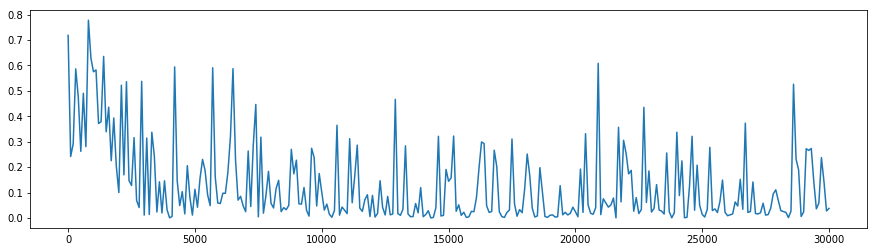

In [18]:
plt.figure().set_size_inches(15, 4)

plt.plot([n * summary_frequency for n in range(0, len(losses))], losses)
plt.show()